## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [105]:
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

## Example Calibration Chessboard Image

(720, 1280, 3)


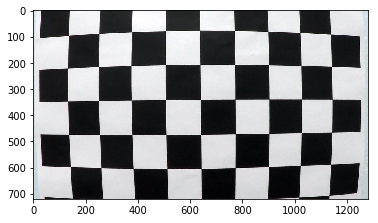

In [106]:
img = cv2.imread('camera_cal/calibration1.jpg')
ishape = img.shape
print(ishape)
plt.imshow(img)

In [107]:
# size of chessboard
nx = 9
ny = 6

In [108]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny),None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

# calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, ishape[:2],None,None)

## Calibration Example Output

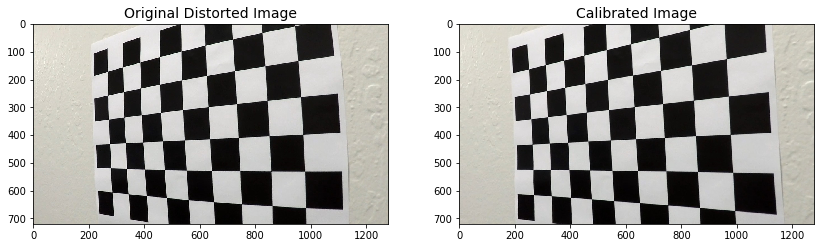

In [109]:
check_img = mpimg.imread("./camera_cal/calibration4.jpg")
check_newimg = cv2.undistort(check_img, mtx, dist, None, mtx)



f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 20))
ax1.imshow(check_img)
ax1.set_title('Original Distorted Image', fontsize=14)
ax2.imshow(check_newimg)
ax2.set_title('Calibrated Image', fontsize=14)

In [34]:
cv2.imwrite('./output_images/distorted.jpg',check_img)
cv2.imwrite('./output_images/undistorted.jpg',check_newimg)

True

## Perspective Transform

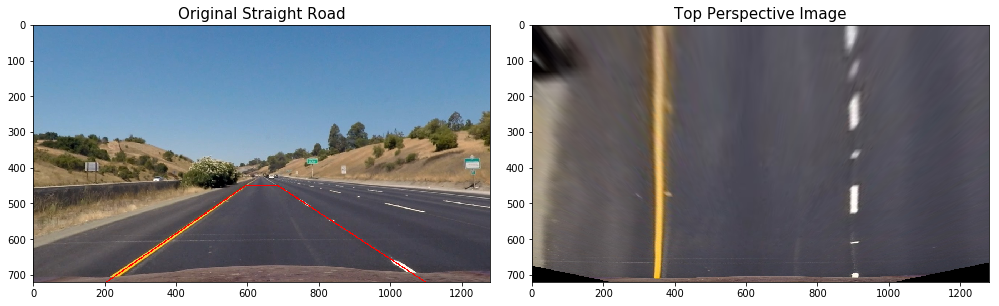

In [110]:
from copy import deepcopy, copy
# we will use the straight lines images to create our Perspective Transform
# we are looking for a rectangle from a perspective from above
sl_img = mpimg.imread('test_images/straight_lines1.jpg')
undist_sl_img = cv2.undistort(sl_img, mtx, dist, None, mtx)

bot_left = [205, 720]
bot_right = [1100, 720]
top_left = [595, 450]
top_right = [685, 450]

src = np.float32([bot_left, bot_right, top_right, top_left])

rect = np.array([[bot_left, bot_right, top_right, top_left]], np.int32)
copyimg = undist_sl_img.copy()
cv2.polylines(copyimg,rect,True,(255,0,0), thickness=2)

dst = np.float32([[350,720], [900, 720],  [900, 1], [350, 1]])

PersT = cv2.getPerspectiveTransform(src, dst)
img_shape = (ishape[1], ishape[0])

warpImg = cv2.warpPerspective(sl_img, PersT, img_shape , flags=cv2.INTER_LINEAR)

InvPersT = cv2.getPerspectiveTransform(dst, src)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 20))
f.tight_layout()
ax1.imshow(copyimg)
ax1.set_title('Original Straight Road', fontsize=15)
ax2.imshow(warpImg)
ax2.set_title('Top Perspective Image', fontsize=15)


In [79]:
copyimgout = cv2.cvtColor(copyimg, cv2.COLOR_RGB2BGR)
warpImgout = cv2.cvtColor(warpImg, cv2.COLOR_RGB2BGR)
cv2.imwrite('./output_images/straight_road.png',copyimgout)
cv2.imwrite('./output_images/looking_down.png',warpImgout)

True

## Thresholding

In [111]:
def get_saturation(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    l = hls[:,:,1]
    binary_output = np.zeros_like(s)
    # get rid of very dark shadows
    binary_output[(s > thresh[0]) & (s <= thresh[1]) & (l > 100)] = 1
    return binary_output

In [112]:
def get_yellow(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    lower = np.uint8([10, 0, 100])
    upper = np.uint8([60, 255, 255])
    yellow = cv2.inRange(hls, lower, upper)
    out = cv2.bitwise_and(hls, hls, mask = yellow)
    out = cv2.cvtColor(out, cv2.COLOR_HLS2RGB)
    out = cv2.cvtColor(out, cv2.COLOR_RGB2GRAY)
    binary_output = np.zeros_like(out)
    binary_output[(out > thresh[0]) & (out <= thresh[1])] = 1
    return binary_output

In [113]:
def get_white(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    lower = np.uint8([0, 180, 0])
    upper = np.uint8([255, 255, 255])
    white = cv2.inRange(hls, lower, upper)
    out = cv2.bitwise_and(hls, hls, mask = white)
    out = cv2.cvtColor(out, cv2.COLOR_HLS2RGB)
    out = cv2.cvtColor(out, cv2.COLOR_RGB2GRAY)
    binary_output = np.zeros_like(out)
    binary_output[(out > thresh[0]) & (out <= thresh[1])] = 1
    return binary_output

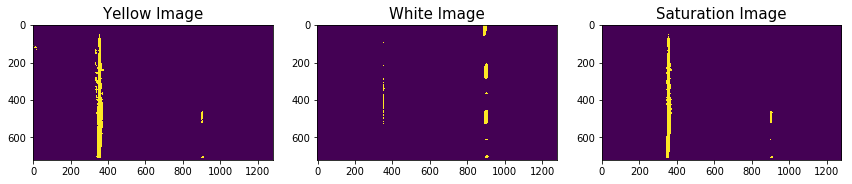

In [114]:

yellow_img = get_yellow(warpImg, (0, 255))
white_img = get_white(warpImg, (0, 255))
sat_img = get_saturation(warpImg, (100, 255))
f, axes = plt.subplots(1, 3, figsize=(12, 15))


axes[0].imshow(yellow_img)
axes[0].set_title('Yellow Image', fontsize=15)
axes[1].imshow(white_img)
axes[1].set_title('White Image', fontsize=15)
axes[2].imshow(sat_img)
axes[2].set_title('Saturation Image', fontsize=15)
f.tight_layout()

plt.savefig("./output_images/three-filters.jpg")

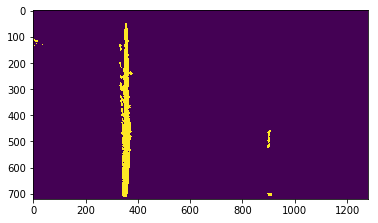

In [116]:
plt.imshow(yellow_img)
plt.savefig("./output_images/yellow.jpg")

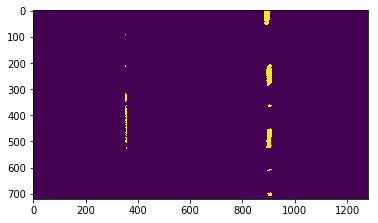

In [117]:
plt.imshow(white_img)
plt.savefig("./output_images/white.jpg")

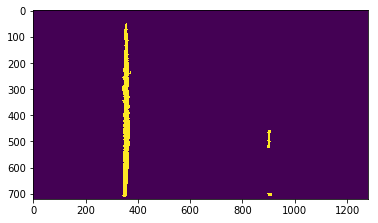

In [118]:
plt.imshow(sat_img)
plt.savefig("./output_images/saturation.jpg")

In [101]:
def combined_filter(img):
    sat = get_saturation(img, (100, 255))
    yel = get_yellow(img, (10, 255))
    wte = get_white(img, (210, 255))
    combin = np.zeros_like(sat)
    combin[(sat == 1) | (yel == 1) | (wte == 1)] = 1
    return combin

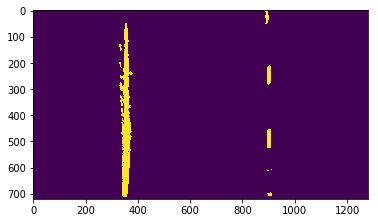

In [119]:
fin_img = combined_filter(warpImg)
plt.imshow(fin_img)

plt.savefig("./output_images/combined.jpg")

In [103]:
cv2.imwrite('./output_images/combined_filter.jpg', fin_img)

True

In [48]:
# initialize future global variables
right_fit = None
left_fit = None
right_lines = []
left_lines = []
line_distance = 0

## Histogram Search

In [49]:
def histogram_search(binary_warped, nwin = 10, mgn = 100, pix = 50, visualize=False):
    # nwin = num sliding windows; mgn = margin window width +/- margin; pix= num pixels to recenter
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    global left_fit
    global right_fit
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = nwin
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = mgn
    # Set minimum number of pixels found to recenter window
    minpix = pix
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix: 
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # check for no line fit
    if (lefty.size == 0) or (righty.size == 0):
        left_fit = None
        right_fit = None
        return None, None
    if (leftx.size == 0) or (rightx.size == 0):
        left_fit = None
        right_fit = None
        return None, None
    if (leftx is None) or (lefty is None) or (rightx is None) or (righty is None):
        left_fit = None
        right_fit = None
        return None, None

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if visualize == True:
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        #plt.savefig('./output_images/histogram.jpg')
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_lane_lines = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_lane_lines = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_lane_lines, right_lane_lines #, (leftx, lefty, rightx, righty, left_fit, right_fit)


### Visualization of Histogram Procedure

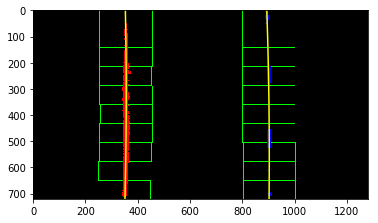

In [50]:
left_lane_lines, right_lane_lines = histogram_search(fin_img, visualize=True)


In [51]:
def fast_histogram(binary_warped, margin=100, visualize=False):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    global left_fit
    global right_fit
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = margin
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # check for no line fit
    if (lefty.size == 0) or (righty.size == 0):
        left_fit = None
        right_fit = None
        return None, None
    if (leftx.size == 0) or (rightx.size == 0):
        left_fit = None
        right_fit = None
        return None, None
    if (leftx is None) or (lefty is None) or (rightx is None) or (righty is None):
        left_fit = None
        right_fit = None
        return None, None
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    print(righty, rightx)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if visualize == True:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        #plt.savefig("./output_images/fast_histogram")
    # return the left and right x pixels for the lines
    return left_fitx, right_fitx # , (leftx, lefty, rightx, righty, left_fit, right_fit)

[  0   0   0 ..., 706 706 706] [888 889 890 ..., 911 912 913]


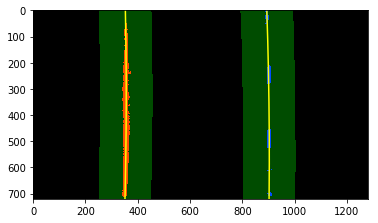

In [52]:
fast_left_lane_lines, fast_right_lane_line = fast_histogram(fin_img, visualize=True)

## Radius of Curvature

### Generate Example Data

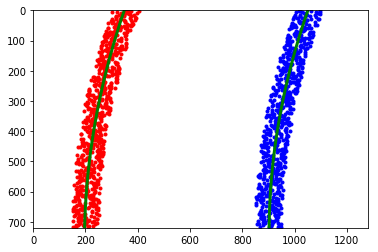

In [53]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images
plt.savefig("./output_images/example_data.jpg")

### Radius of Curvature Function

In [54]:
def rad_curvature(lx, rx):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ploty = np.linspace(0, 719, 720) # to cover same y-range as image
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, lx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    # Example values: 632.1 m    626.2 m
    # now do offset
    center_lane = (lx[719] + rx[719]) / 2
    # assuming a 1280 image width
    offset_in_pixels = abs(640 - center_lane)
    offset_in_meters = xm_per_pix*offset_in_pixels
    print(left_curverad, 'm', right_curverad, 'm', offset_in_meters, 'm')
    return left_curverad, right_curverad, offset_in_meters

In [55]:
left_rad, right_rad, offset = rad_curvature(left_fitx, right_fitx)

640.294094601 m 604.115458671 m 0.476975284046 m


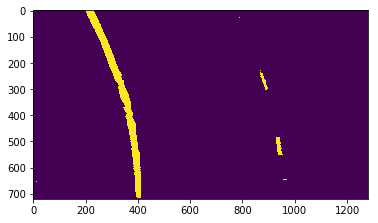

In [56]:
test_img = mpimg.imread('test_images/test2.jpg')
undist_test_img = cv2.undistort(test_img, mtx, dist, None, mtx)
img_shape = (test_img.shape[1], test_img.shape[0])

warpImg = cv2.warpPerspective(undist_test_img, PersT, img_shape , flags=cv2.INTER_LINEAR)
threshwarp_img = combined_filter(warpImg)
yellow_img = get_yellow(warpImg, (100, 255))
white_img = get_white(warpImg, (210, 255))
sat_img = get_saturation(warpImg, (100, 255))
plt.imshow(threshwarp_img)
plt.savefig("./output_images/test2-BirdsEye.jpg")

In [57]:
left_fitx, right_fitx = histogram_search(threshwarp_img)

In [58]:
def draw_path(warped, undist, left_fitx, right_fitx):
    # Create an image to draw the lines on
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, InvPersT, (warped.shape[1], warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

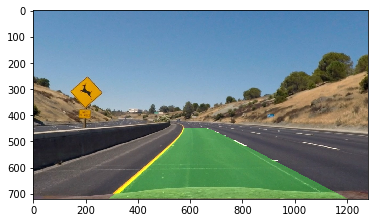

In [59]:
outresult_img = draw_path(threshwarp_img, undist_test_img, left_fitx, right_fitx)
plt.imshow(outresult_img)

In [60]:
# add a function to smooth (average) over a set of lines
def average_lines(line_update, line_window, lines=5):
    # window of lines for simple moving average
    # Hold numLines in line_window and update from line_update (a new line)
    numLines = lines
    # first see if there is a line
    if line_update is not None:
        if len(line_window) < numLines:
            line_window.append(line_update)
            return line_update, line_window
        else:
            line_window[0:numLines - 1] = line_window[1:]
            line_window[numLines - 1] = line_update
            sum_line = np.zeros_like(line_update) 
            for line in line_window:
                sum_line += line
            new_line = sum_line / numLines
            return new_line, line_window
    else:
        # we got issues return None if nothing in window else last element
        if len(line_window) == 0:
            return None, line_window
        else:
            return line_window[-1], line_window
        

In [61]:
# reinitialize future global variables
right_fit = None
left_fit = None
right_lines = []
left_lines = []
average_line_distance = 0

In [62]:
def pipeline(img):
    # store the last images line coefficients
    global left_fit
    global right_fit
    # store the exponential average distance of the lines at the bottom
    global average_line_distance
    # store the line window for smoothing
    global right_lines
    global left_lines
    
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    img_shape = (img.shape[1], img.shape[0])

    warpImg = cv2.warpPerspective(undist_img, PersT, img_shape , flags=cv2.INTER_LINEAR)
    threshwarp_img = combined_filter(warpImg)
    
    bad_frame = False  # reset bad frame flag
    
    if (left_fit is None) or (right_fit is None):
        # bad frame or at beginning: do a full scale search 
        left_lane_lines, right_lane_lines = histogram_search(threshwarp_img)
    else:
        left_lane_lines, right_lane_lines = fast_histogram(threshwarp_img)
    # check predictions
    if (left_lane_lines is None) or (right_lane_lines is None):
        left_lane_lines, right_lane_lines = histogram_search(threshwarp_img)
    # check again
    if (left_lane_lines is None or right_lane_lines is None):
        bad_frame = True
    else:
        line_distance = np.abs(left_lane_lines[img.shape[0]-1] - right_lane_lines[img.shape[0]-1])
        if average_line_distance == 0:
            average_line_distance = line_distance
        else:
            # sanity check
            # is line distance sane
            if (line_distance < 0.8*average_line_distance) or (line_distance > 1.2*average_line_distance):
                bad_frame = True
        
    if bad_frame:
        left_fit = None
        right_fit = None
        if len(left_lines) == 0 or len(right_lines) == 0:
            return undist_img # have no other choice
        else:
            # return previous frame lines
            left_line = left_lines[-1]
            right_line = right_lines[-1]
    else:
        # good frame update stuff
        left_line, left_lines = average_lines(left_lane_lines, left_lines)
        right_line, right_lines = average_lines(right_lane_lines, right_lines)
        line_distance = np.abs(left_line[img.shape[0]-1] - right_line[img.shape[0]-1])
        average_line_distance = .95 * average_line_distance + .05 * line_distance
    
    left_rad, right_rad, offset = rad_curvature(left_line, right_line)
    out_img = draw_path(threshwarp_img, undist_img, left_line, right_line)
    
    avg_rad = (left_rad + right_rad) /2.
    curveout = "Curvature: %.2f (m)" % avg_rad
    offsetout = "Offset: %.2f (m)" % offset
    # write out the stuff on the image
    cv2.putText(out_img, curveout , (50, 50), cv2.FONT_HERSHEY_PLAIN, 2.5, (255,255,255), thickness=2)
    cv2.putText(out_img, offsetout, (50, 100), cv2.FONT_HERSHEY_PLAIN, 2.5, (255,255,255), thickness=2)
    return out_img

[ 26  26  26 ..., 645 645 645] [788 789 790 ..., 966 967 968]
426.845535791 m 665.908515314 m 0.228078292136 m


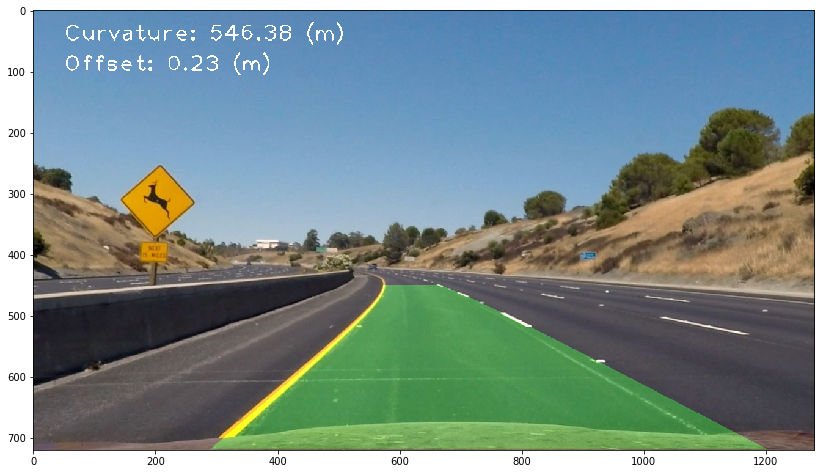

In [65]:
outimg = mpimg.imread('test_images/test2.jpg')
outimg1 = pipeline(outimg)

f, ax = plt.subplots(figsize=(14, 20))
ax.imshow(outimg1)

plt.savefig("./output_images/test2-pipeline.png")

In [66]:
outimg1 = cv2.cvtColor(outimg1, cv2.COLOR_RGB2BGR)
cv2.imwrite('./output_images/test2-pipelined.jpg', outimg1)

True

In [414]:
from moviepy.editor import VideoFileClip

In [415]:
# reinitialize future global variables
right_fit = None
left_fit = None
right_lines = []
left_lines = []
average_line_distance = 0

In [416]:
outfile = './project_video_output.mp4'
clip = VideoFileClip("./project_video.mp4")
outclip = clip.fl_image(pipeline)
outclip.write_videofile(outfile, audio=False)

434.899356541 m 540.162262851 m 0.208751998992 m
[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4






  0%|          | 0/1261 [00:00<?, ?it/s]



  0%|          | 1/1261 [00:00<02:21,  8.88it/s]

[ 70  70  70 ..., 642 642 642] [818 819 820 ..., 950 951 952]
434.899356541 m 540.162262851 m 0.208751998992 m






  0%|          | 2/1261 [00:00<02:46,  7.56it/s]

[ 91  91  92 ..., 662 662 662] [820 821 819 ..., 963 964 965]
425.129583154 m 533.368848093 m 0.209503388179 m






  0%|          | 3/1261 [00:00<02:43,  7.72it/s]

[125 129 130 ..., 683 683 683] [825 824 824 ..., 963 964 965]
432.225023249 m 502.413662976 m 0.211018607156 m






  0%|          | 4/1261 [00:00<02:50,  7.37it/s]

[145 146 147 ..., 703 704 704] [829 829 828 ..., 967 952 953]
447.907595899 m 499.117910527 m 0.216621063052 m






  0%|          | 5/1261 [00:00<02:56,  7.13it/s]

[165 165 165 ..., 711 711 711] [836 837 838 ..., 963 964 965]
436.728623594 m 514.702534837 m 0.212905928217 m






  0%|          | 6/1261 [00:00<02:57,  7.07it/s]

[194 194 194 ..., 711 711 711] [840 841 842 ..., 963 964 965]
440.066259043 m 507.329498304 m 0.215703457492 m






  1%|          | 7/1261 [00:01<02:58,  7.04it/s]

[200 201 202 ..., 711 711 711] [848 848 847 ..., 958 959 960]
451.49805081 m 501.877283455 m 0.219460858299 m






  1%|          | 8/1261 [00:01<03:02,  6.86it/s]

[ 51  51 228 ..., 621 621 621] [773 774 850 ..., 947 948 949]
461.149061303 m 528.897103594 m 0.227871563837 m






  1%|          | 9/1261 [00:01<03:08,  6.63it/s]

[ 50  50  50 ..., 640 640 641] [780 781 782 ..., 960 961 946]
469.758547121 m 564.490492222 m 0.234859714877 m






  1%|          | 10/1261 [00:01<03:05,  6.75it/s]

[255 255 255 ..., 660 660 660] [864 865 866 ..., 961 962 963]
481.625691694 m 605.412689069 m 0.241221995506 m






  1%|          | 11/1261 [00:01<03:03,  6.80it/s]

[ 51 277 277 ..., 680 680 680] [773 869 870 ..., 964 965 966]
491.492307419 m 656.205648475 m 0.246342860406 m






  1%|          | 12/1261 [00:01<03:08,  6.64it/s]

[ 27  28  51 ..., 700 700 700] [790 790 795 ..., 968 969 970]
502.094468558 m 712.776486249 m 0.249473541191 m






  1%|          | 13/1261 [00:01<03:09,  6.59it/s]

[ 68  69  69 ..., 634 634 634] [792 792 793 ..., 947 948 949]
515.913662198 m 709.832057484 m 0.246788776557 m






  1%|          | 14/1261 [00:02<03:07,  6.64it/s]

[ 88  88  89 ..., 654 654 654] [798 799 798 ..., 958 959 960]
531.739773101 m 703.237216966 m 0.24438665556 m






  1%|          | 15/1261 [00:02<03:11,  6.52it/s]

[131 132 132 ..., 675 675 675] [798 797 798 ..., 959 960 961]
536.590633059 m 686.725985152 m 0.240413366261 m






  1%|▏         | 16/1261 [00:02<03:15,  6.37it/s]

[165 165 165 ..., 696 696 696] [801 802 803 ..., 959 960 961]
538.158461481 m 660.311041689 m 0.234721722909 m






  1%|▏         | 17/1261 [00:02<03:00,  6.88it/s]

[181 181 181 ..., 711 711 711] [803 804 805 ..., 958 959 960]
525.170264356 m 638.944689599 m 0.22810109133 m






  1%|▏         | 18/1261 [00:02<02:59,  6.94it/s]

[205 206 206 ..., 711 711 711] [814 812 813 ..., 957 958 959]
505.917687493 m 632.414112533 m 0.221102615951 m






  2%|▏         | 19/1261 [00:02<02:57,  7.01it/s]

[211 211 211 ..., 711 711 711] [821 822 823 ..., 958 959 960]
488.194122719 m 630.470712656 m 0.213818469749 m






  2%|▏         | 20/1261 [00:02<02:53,  7.15it/s]

[224 224 224 ..., 711 711 711] [830 831 832 ..., 959 960 961]
481.478197506 m 638.723390944 m 0.207739956693 m






  2%|▏         | 21/1261 [00:03<02:51,  7.22it/s]

[227 227 227 ..., 630 630 630] [841 842 843 ..., 947 948 949]
483.379335488 m 647.555842413 m 0.202081417983 m






  2%|▏         | 22/1261 [00:03<02:48,  7.37it/s]

[235 236 236 ..., 649 649 649] [855 853 854 ..., 952 953 954]
494.353680101 m 656.503943775 m 0.197971752377 m






  2%|▏         | 23/1261 [00:03<02:49,  7.29it/s]

[  1   1  49 ..., 669 669 669] [765 766 785 ..., 943 944 945]
512.867031872 m 646.16063791 m 0.192526931896 m






  2%|▏         | 24/1261 [00:03<02:47,  7.38it/s]

[274 274 275 ..., 689 689 689] [867 868 865 ..., 958 959 960]
510.820107104 m 637.261350569 m 0.186281650344 m






  2%|▏         | 25/1261 [00:03<02:46,  7.41it/s]

[ 71  71  72 ..., 710 710 710] [779 780 778 ..., 959 960 961]
501.64472232 m 601.425333954 m 0.178696862456 m






  2%|▏         | 26/1261 [00:03<02:47,  7.37it/s]

[ 71  71  72 ..., 640 640 640] [791 792 790 ..., 944 949 950]
491.961931745 m 571.571329995 m 0.172163211929 m






  2%|▏         | 27/1261 [00:03<02:45,  7.44it/s]

[ 73  73  73 ..., 660 660 660] [795 796 797 ..., 942 943 944]
473.620102648 m 543.993118309 m 0.165720381885 m






  2%|▏         | 28/1261 [00:03<02:44,  7.49it/s]

[ 72  72  72 ..., 679 679 679] [808 809 810 ..., 958 959 960]
456.842446092 m 536.433728669 m 0.162056686173 m






  2%|▏         | 29/1261 [00:04<02:47,  7.36it/s]

[ 95  96  98 ..., 700 700 700] [818 818 817 ..., 958 959 960]
446.985593108 m 519.337219758 m 0.158904741075 m






  2%|▏         | 30/1261 [00:04<02:51,  7.18it/s]

[134 135 136 ..., 711 711 711] [822 822 821 ..., 957 958 959]
431.050408257 m 514.848725472 m 0.156407443081 m






  2%|▏         | 31/1261 [00:04<02:49,  7.27it/s]

[175 176 176 ..., 711 711 711] [824 823 824 ..., 957 958 959]
408.259848217 m 508.553529046 m 0.155131040929 m






  3%|▎         | 32/1261 [00:04<02:48,  7.29it/s]

[208 208 209 ..., 711 711 711] [826 827 825 ..., 956 957 958]
386.190010653 m 496.991484092 m 0.153704036491 m






  3%|▎         | 33/1261 [00:04<02:46,  7.36it/s]

[213 213 213 ..., 711 711 711] [834 835 836 ..., 960 961 962]
367.300083632 m 492.263170526 m 0.154299457733 m






  3%|▎         | 34/1261 [00:04<02:45,  7.41it/s]

[235 236 237 ..., 636 636 636] [843 843 842 ..., 942 943 944]
352.295891005 m 499.511235056 m 0.157280419586 m






  3%|▎         | 35/1261 [00:04<02:46,  7.37it/s]

[254 254 254 ..., 656 656 656] [848 849 850 ..., 955 956 957]
343.165723466 m 518.631214165 m 0.16264507114 m






  3%|▎         | 36/1261 [00:05<02:45,  7.40it/s]

[281 281 281 ..., 676 676 676] [854 855 856 ..., 959 960 961]
338.537160306 m 543.238201951 m 0.168275527678 m






  3%|▎         | 37/1261 [00:05<02:45,  7.38it/s]

[114 304 304 ..., 697 697 697] [765 857 858 ..., 959 960 961]
337.244814929 m 561.658635081 m 0.172642733713 m






  3%|▎         | 38/1261 [00:05<02:43,  7.49it/s]

[131 132 133 ..., 628 628 628] [767 767 766 ..., 936 944 945]
330.335818449 m 530.996058035 m 0.172932120561 m






  3%|▎         | 39/1261 [00:05<02:42,  7.54it/s]

[151 151 151 ..., 648 648 648] [768 769 770 ..., 946 947 948]
324.367108422 m 491.904435037 m 0.171203511261 m






  3%|▎         | 40/1261 [00:05<02:42,  7.49it/s]

[151 151 151 ..., 668 668 668] [772 773 774 ..., 949 950 951]
322.439218831 m 456.245702344 m 0.169382668288 m






  3%|▎         | 41/1261 [00:05<02:42,  7.48it/s]

[167 167 167 ..., 687 687 688] [779 780 781 ..., 953 954 952]
320.8624168 m 423.570274956 m 0.16753915936 m






  3%|▎         | 42/1261 [00:05<02:42,  7.50it/s]

[182 182 182 ..., 708 708 708] [789 790 791 ..., 955 956 957]
320.928798833 m 404.419638128 m 0.16845327553 m


[184 184 185 ..., 711 711 711] [798 799 797 ..., 955 956 957]
327.516467149 m 407.248294128 m 0.172592611107 m






  3%|▎         | 43/1261 [00:06<03:00,  6.75it/s]

[195 195 195 ..., 711 711 711] [808 809 810 ..., 956 957 958]
341.054468482 m 413.26696133 m 0.177963063545 m






  3%|▎         | 44/1261 [00:06<03:07,  6.48it/s]



  4%|▎         | 45/1261 [00:06<03:12,  6.32it/s]

[207 207 208 ..., 711 711 711] [822 823 821 ..., 957 958 959]
357.002688953 m 416.921524936 m 0.183958323485 m






  4%|▎         | 46/1261 [00:06<03:04,  6.59it/s]

[222 222 223 ..., 627 627 627] [830 831 829 ..., 949 950 951]
371.734748704 m 439.496574012 m 0.191409588591 m






  4%|▎         | 47/1261 [00:06<03:03,  6.61it/s]

[ 49  50  50 ..., 646 646 646] [745 744 745 ..., 955 956 957]
389.984514282 m 450.866126502 m 0.195677185954 m






  4%|▍         | 48/1261 [00:06<03:03,  6.61it/s]

[ 51  70  70 ..., 667 667 667] [739 747 748 ..., 956 957 958]
407.037673396 m 455.058840237 m 0.198380027059 m






  4%|▍         | 49/1261 [00:07<03:10,  6.35it/s]

[ 73  73  73 ..., 687 687 687] [759 760 761 ..., 960 961 962]
423.91887633 m 469.249302095 m 0.201577089971 m






  4%|▍         | 50/1261 [00:07<03:08,  6.41it/s]

[ 94 114 114 ..., 708 708 708] [765 775 776 ..., 962 963 964]
436.488014407 m 481.742586647 m 0.203153366537 m






  4%|▍         | 51/1261 [00:07<03:13,  6.27it/s]

[ 90  90  90 ..., 637 637 637] [765 766 767 ..., 944 945 946]
454.167792357 m 465.331022149 m 0.201368332928 m






  4%|▍         | 52/1261 [00:07<03:19,  6.05it/s]

[114 115 129 ..., 658 658 658] [766 766 776 ..., 951 952 953]
470.512480778 m 458.871665564 m 0.201377699299 m


[150 151 151 ..., 679 679 679] [782 778 780 ..., 952 953 954]
483.726828433 m 456.301490801 m 0.200424569908 m






  4%|▍         | 53/1261 [00:07<03:23,  5.93it/s]



  4%|▍         | 54/1261 [00:07<03:15,  6.17it/s]

[163 163 164 ..., 700 700 700] [784 785 783 ..., 954 955 956]
492.502414195 m 443.587934112 m 0.197490704901 m






  4%|▍         | 55/1261 [00:07<03:11,  6.29it/s]

[169 169 169 ..., 711 711 711] [791 792 793 ..., 955 956 957]
502.239063392 m 432.424896253 m 0.194141084043 m


[184 184 185 ..., 711 711 711] [802 803 801 ..., 955 956 957]
509.367566054 m 432.972577695 m 0.191306943429 m






  4%|▍         | 56/1261 [00:08<03:23,  5.92it/s]

[205 205 206 ..., 711 711 711] [809 810 809 ..., 955 956 957]
514.212075967 m 435.49782834 m 0.188483224109 m






  5%|▍         | 57/1261 [00:08<03:25,  5.86it/s]



  5%|▍         | 58/1261 [00:08<03:19,  6.02it/s]

[215 215 215 ..., 711 711 711] [816 817 818 ..., 956 957 958]
523.596991291 m 444.19088428 m 0.186557720783 m






  5%|▍         | 59/1261 [00:08<03:14,  6.19it/s]

[251 251 251 ..., 637 638 638] [819 820 821 ..., 949 934 935]
524.209462227 m 470.698900483 m 0.18741950325 m






  5%|▍         | 60/1261 [00:08<03:19,  6.02it/s]

[279 279 280 ..., 659 659 659] [825 826 825 ..., 945 946 947]
518.841693373 m 500.914216962 m 0.186085417717 m






  5%|▍         | 61/1261 [00:08<03:15,  6.13it/s]

[299 299 300 ..., 679 679 679] [832 833 829 ..., 949 950 951]
512.30205094 m 530.760041362 m 0.183744579036 m






  5%|▍         | 62/1261 [00:09<03:17,  6.08it/s]

[322 322 323 ..., 700 700 700] [836 837 834 ..., 951 952 953]
501.123320504 m 558.937697913 m 0.179646044663 m






  5%|▍         | 63/1261 [00:09<03:11,  6.26it/s]

[150 151 151 ..., 634 634 634] [758 757 758 ..., 934 935 936]
491.501706416 m 575.46385688 m 0.173836673144 m






  5%|▌         | 64/1261 [00:09<03:13,  6.20it/s]

[168 168 169 ..., 654 654 654] [763 764 763 ..., 937 938 939]
483.720813721 m 572.798569498 m 0.164899891352 m






  5%|▌         | 65/1261 [00:09<03:13,  6.19it/s]

[168 168 168 ..., 674 674 674] [774 775 776 ..., 940 941 942]
481.460423235 m 572.104859855 m 0.157052194803 m






  5%|▌         | 66/1261 [00:09<03:15,  6.12it/s]

[183 183 183 ..., 694 694 694] [782 783 784 ..., 943 944 945]
478.747147721 m 572.874613059 m 0.149759125164 m






  5%|▌         | 67/1261 [00:09<03:09,  6.30it/s]

[198 198 198 ..., 712 712 712] [791 792 793 ..., 942 943 944]
481.474447276 m 580.106862233 m 0.143068596735 m






  5%|▌         | 68/1261 [00:10<03:11,  6.23it/s]

[211 211 211 ..., 712 712 712] [800 801 802 ..., 941 942 943]
481.09574901 m 598.592624826 m 0.136910378897 m


[227 227 228 ..., 712 712 712] [802 803 800 ..., 942 943 944]
481.003367151 m 607.105159442 m 0.130702455289 m






  5%|▌         | 69/1261 [00:10<03:22,  5.89it/s]



  6%|▌         | 70/1261 [00:10<03:16,  6.07it/s]

[237 237 237 ..., 712 712 712] [812 813 814 ..., 937 938 939]
484.830243332 m 623.936547878 m 0.125796851812 m






  6%|▌         | 71/1261 [00:10<03:11,  6.20it/s]

[252 252 253 ..., 629 630 630] [820 821 818 ..., 936 921 922]
490.147830135 m 687.022097592 m 0.12583264282 m


[ 95  95 264 ..., 649 649 649] [747 748 830 ..., 929 933 934]
499.774519961 m 727.021320605 m 0.123828858609 m






  6%|▌         | 72/1261 [00:10<03:21,  5.90it/s]



  6%|▌         | 73/1261 [00:10<03:20,  5.91it/s]

[109 110 110 ..., 669 669 669] [756 756 757 ..., 927 928 929]
514.656475406 m 665.94031 m 0.117478504159 m






  6%|▌         | 74/1261 [00:11<03:14,  6.10it/s]

[130 130 131 ..., 689 689 689] [766 767 764 ..., 942 943 944]
536.342193002 m 622.382519377 m 0.111999294642 m






  6%|▌         | 75/1261 [00:11<03:10,  6.22it/s]

[114 114 114 ..., 709 709 709] [766 767 768 ..., 946 947 948]
559.987771113 m 574.7230308 m 0.106662468678 m






  6%|▌         | 76/1261 [00:11<03:08,  6.30it/s]

[130 131 131 ..., 638 638 638] [767 767 768 ..., 927 928 929]
584.9541282 m 487.707513225 m 0.0958434997875 m


[112 112 113 ..., 657 657 657] [781 782 780 ..., 933 934 935]
615.568893264 m 444.542441938 m 0.0891293029579 m






  6%|▌         | 77/1261 [00:11<03:22,  5.84it/s]



  6%|▌         | 78/1261 [00:11<03:19,  5.94it/s]

[129 129 130 ..., 677 677 677] [792 793 791 ..., 935 936 937]
644.473299979 m 443.333072026 m 0.0881150286617 m






  6%|▋         | 79/1261 [00:11<03:14,  6.07it/s]

[132 132 132 ..., 698 698 698] [799 800 801 ..., 937 938 939]
670.469324919 m 441.564481028 m 0.0862227996051 m






  6%|▋         | 80/1261 [00:12<03:11,  6.17it/s]

[147 148 148 ..., 712 712 712] [808 807 808 ..., 930 931 932]
682.027959589 m 442.917495476 m 0.0830772112674 m


[179 180 180 ..., 712 712 712] [813 812 813 ..., 935 936 937]
679.68319138 m 455.509804317 m 0.0796061349687 m






  6%|▋         | 81/1261 [00:12<03:19,  5.91it/s]



  7%|▋         | 82/1261 [00:12<03:12,  6.11it/s]

[184 184 185 ..., 712 712 712] [821 822 820 ..., 935 936 937]
658.683550143 m 462.546748447 m 0.0741855337592 m






  7%|▋         | 83/1261 [00:12<03:06,  6.31it/s]

[200 200 201 ..., 712 712 712] [829 830 829 ..., 937 938 939]
634.663636244 m 472.509127847 m 0.0689816621227 m


[206 206 206 ..., 633 633 634] [841 842 843 ..., 940 941 925]
619.118858885 m 508.300846718 m 0.0683010329782 m






  7%|▋         | 84/1261 [00:12<03:20,  5.87it/s]

[225 225 226 ..., 654 654 654] [847 848 847 ..., 940 941 942]
600.371341704 m 547.627234634 m 0.0682363892031 m






  7%|▋         | 85/1261 [00:12<03:23,  5.78it/s]



  7%|▋         | 86/1261 [00:13<03:13,  6.09it/s]

[245 246 246 ..., 675 675 675] [856 855 856 ..., 942 943 944]
589.132382327 m 592.587206373 m 0.068737036604 m






  7%|▋         | 87/1261 [00:13<03:10,  6.15it/s]

[283 283 284 ..., 697 697 697] [854 855 852 ..., 941 942 943]
569.497833783 m 634.883112396 m 0.0697628101437 m


[312 313 313 ..., 623 623 623] [857 855 856 ..., 927 928 929]
542.119464818 m 656.608367446 m 0.0686060196316 m






  7%|▋         | 88/1261 [00:13<03:19,  5.89it/s]



  7%|▋         | 89/1261 [00:13<03:13,  6.07it/s]

[133 133 133 ..., 644 644 644] [773 774 775 ..., 929 930 931]
503.841605306 m 610.576329874 m 0.0622837701881 m






  7%|▋         | 90/1261 [00:13<03:12,  6.07it/s]

[168 168 168 ..., 665 665 665] [777 778 779 ..., 929 930 931]
466.348119419 m 569.029925242 m 0.0569201013837 m






  7%|▋         | 91/1261 [00:13<03:13,  6.05it/s]

[167 167 168 ..., 685 685 685] [788 789 785 ..., 933 934 935]
437.863528626 m 541.716396612 m 0.0532991772742 m


[181 181 182 ..., 705 705 705] [798 799 796 ..., 935 936 937]
420.178961752 m 521.054942255 m 0.0508558218978 m






  7%|▋         | 92/1261 [00:14<03:28,  5.62it/s]



  7%|▋         | 93/1261 [00:14<03:12,  6.05it/s]

[198 198 199 ..., 712 712 712] [802 803 801 ..., 932 933 934]
404.965628694 m 513.042601119 m 0.0499472071635 m






  7%|▋         | 94/1261 [00:14<03:14,  6.00it/s]

[214 215 215 ..., 712 712 712] [807 806 807 ..., 933 934 935]
396.910269765 m 520.657717225 m 0.0511265258971 m






  8%|▊         | 95/1261 [00:14<03:12,  6.04it/s]

[226 227 227 ..., 712 712 712] [820 816 817 ..., 933 934 935]
397.510176848 m 535.363973646 m 0.0517205748562 m






  8%|▊         | 96/1261 [00:14<03:07,  6.20it/s]

[240 240 240 ..., 625 625 625] [824 825 826 ..., 914 915 916]
398.714379818 m 551.103421105 m 0.0529689909557 m


[ 94 258 258 ..., 644 645 645] [759 830 831 ..., 932 916 917]
398.482146708 m 572.451639928 m 0.0547782575545 m






  8%|▊         | 97/1261 [00:14<03:19,  5.83it/s]



  8%|▊         | 98/1261 [00:15<03:14,  5.97it/s]

[266 266 266 ..., 664 664 664] [840 841 842 ..., 932 933 934]
404.10568126 m 597.767979247 m 0.0568956316905 m






  8%|▊         | 99/1261 [00:15<03:11,  6.08it/s]

[113 114 114 ..., 684 684 684] [771 769 770 ..., 935 936 937]
407.924068127 m 589.702095087 m 0.0565137031603 m


[131 132 132 ..., 705 705 705] [787 787 788 ..., 936 937 938]
411.104557428 m 578.448769346 m 0.0572857604087 m






  8%|▊         | 100/1261 [00:15<03:22,  5.73it/s]

[115 148 148 ..., 638 638 638] [781 793 794 ..., 923 924 925]
408.042952256 m 545.158741596 m 0.0562832689308 m






  8%|▊         | 101/1261 [00:15<03:25,  5.64it/s]



  8%|▊         | 102/1261 [00:15<03:17,  5.86it/s]

[147 147 148 ..., 659 659 659] [787 788 786 ..., 924 925 926]
403.749468004 m 503.587054004 m 0.0541732573975 m






  8%|▊         | 103/1261 [00:15<03:15,  5.91it/s]

[151 151 152 ..., 678 678 678] [792 793 792 ..., 928 929 930]
399.580273637 m 470.312437671 m 0.0536938966202 m


[168 168 168 ..., 699 699 699] [798 799 800 ..., 930 931 932]
393.965195129 m 459.09278264 m 0.055841779719 m






  8%|▊         | 104/1261 [00:16<03:23,  5.70it/s]

[165 166 166 ..., 712 712 712] [813 812 813 ..., 932 933 934]
391.430127137 m 452.035493294 m 0.0586826055126 m






  8%|▊         | 105/1261 [00:16<03:23,  5.69it/s]



  8%|▊         | 106/1261 [00:16<03:15,  5.89it/s]

[167 167 168 ..., 712 712 712] [821 822 818 ..., 931 932 933]
391.459297423 m 458.792125187 m 0.0629234218551 m






  8%|▊         | 107/1261 [00:16<03:13,  5.98it/s]

[175 176 176 ..., 711 711 711] [834 833 834 ..., 937 938 939]
393.983591773 m 474.103087488 m 0.0686496314255 m


[199 200 200 ..., 712 712 712] [839 837 838 ..., 928 929 930]
391.284285267 m 486.583210476 m 0.0745316736841 m






  9%|▊         | 108/1261 [00:16<03:15,  5.89it/s]

[225 225 225 ..., 628 628 628] [843 844 845 ..., 940 941 942]
390.848352546 m 531.801259985 m 0.0848172190082 m






  9%|▊         | 109/1261 [00:17<03:20,  5.74it/s]



  9%|▊         | 110/1261 [00:17<03:15,  5.89it/s]

[240 240 240 ..., 648 648 648] [850 851 852 ..., 943 944 945]
384.832773401 m 575.858054887 m 0.0936149719615 m






  9%|▉         | 111/1261 [00:17<03:10,  6.02it/s]

[261 261 262 ..., 669 669 669] [857 858 857 ..., 943 944 945]
379.641073537 m 622.564465117 m 0.101836758249 m






  9%|▉         | 112/1261 [00:17<03:09,  6.07it/s]

[265 265 265 ..., 689 689 689] [869 870 871 ..., 947 948 949]
379.506345445 m 676.465876892 m 0.109259869548 m


[296 296 296 ..., 710 710 710] [872 873 874 ..., 948 949 950]
380.551879319 m 735.911290725 m 0.11551660786 m






  9%|▉         | 113/1261 [00:17<03:17,  5.80it/s]



  9%|▉         | 114/1261 [00:17<03:14,  5.90it/s]

[317 317 317 ..., 639 639 639] [877 878 879 ..., 941 942 943]
381.748508589 m 717.658490121 m 0.116583099504 m






  9%|▉         | 115/1261 [00:18<03:09,  6.06it/s]

[168 168 168 ..., 660 660 660] [804 805 806 ..., 942 943 944]
378.296840666 m 624.206549361 m 0.11560086217 m


[169 182 183 ..., 681 681 681] [802 808 807 ..., 943 944 945]
375.437393777 m 539.028599837 m 0.114511839669 m






  9%|▉         | 116/1261 [00:18<03:16,  5.84it/s]

[168 168 168 ..., 701 701 701] [802 803 804 ..., 945 946 947]
367.055913941 m 475.380323256 m 0.113884586024 m






  9%|▉         | 117/1261 [00:18<03:18,  5.77it/s]



  9%|▉         | 118/1261 [00:18<03:16,  5.82it/s]

[185 186 200 ..., 712 712 712] [811 811 814 ..., 943 944 945]
360.550513893 m 422.604785292 m 0.113268715263 m






  9%|▉         | 119/1261 [00:18<03:09,  6.03it/s]

[199 199 200 ..., 712 712 712] [816 817 815 ..., 943 944 945]
355.825011742 m 385.289721562 m 0.113878346706 m


[227 228 228 ..., 712 712 712] [820 819 820 ..., 943 944 945]
353.476858749 m 374.474397463 m 0.117573417065 m






 10%|▉         | 120/1261 [00:18<03:16,  5.81it/s]



 10%|▉         | 121/1261 [00:19<03:14,  5.87it/s]

[241 241 241 ..., 712 712 712] [828 829 830 ..., 938 939 940]
353.327764394 m 369.967641023 m 0.122708605262 m






 10%|▉         | 122/1261 [00:19<03:10,  5.97it/s]

[260 260 261 ..., 637 638 638] [837 838 837 ..., 947 932 933]
353.45238557 m 370.816136449 m 0.130070994415 m






 10%|▉         | 123/1261 [00:19<03:12,  5.91it/s]

[285 285 285 ..., 658 658 658] [839 840 841 ..., 946 947 948]
353.207157197 m 375.154319448 m 0.13732019836 m






 10%|▉         | 124/1261 [00:19<03:13,  5.88it/s]

[299 300 300 ..., 678 678 678] [848 847 848 ..., 949 950 951]
352.77474682 m 377.734190736 m 0.143911756658 m


[133 133 134 ..., 699 699 699] [755 756 756 ..., 950 951 952]
355.199271781 m 381.625047297 m 0.150052518119 m






 10%|▉         | 125/1261 [00:19<03:15,  5.81it/s]



 10%|▉         | 126/1261 [00:19<03:13,  5.85it/s]

[133 133 133 ..., 625 625 625] [773 774 775 ..., 942 943 944]
361.140051082 m 387.783967232 m 0.155681940375 m






 10%|█         | 127/1261 [00:20<03:13,  5.85it/s]

[158 159 160 ..., 645 645 645] [785 785 784 ..., 944 945 946]
368.217963241 m 383.496416334 m 0.159149354927 m


[149 150 150 ..., 665 665 665] [783 783 784 ..., 947 948 949]
379.64034234 m 382.934339749 m 0.163224488056 m






 10%|█         | 128/1261 [00:20<03:16,  5.76it/s]

[183 183 184 ..., 686 686 686] [788 789 787 ..., 947 948 949]
386.571974284 m 380.707515949 m 0.16704324327 m






 10%|█         | 129/1261 [00:20<03:18,  5.71it/s]



 10%|█         | 130/1261 [00:20<03:13,  5.86it/s]

[195 195 195 ..., 706 706 706] [798 799 800 ..., 950 951 952]
396.303117523 m 382.131096376 m 0.169952249633 m






 10%|█         | 131/1261 [00:20<03:12,  5.87it/s]

[212 213 213 ..., 711 711 711] [803 802 803 ..., 950 951 952]
399.701978363 m 383.138358642 m 0.172590496825 m


[228 228 229 ..., 712 712 712] [811 812 810 ..., 941 942 943]
399.213878521 m 389.309177578 m 0.174809207315 m






 10%|█         | 132/1261 [00:20<03:19,  5.66it/s]

[240 240 240 ..., 711 711 711] [819 820 821 ..., 952 953 954]
396.435870924 m 393.52151944 m 0.177139038461 m






 11%|█         | 133/1261 [00:21<03:21,  5.60it/s]



 11%|█         | 134/1261 [00:21<03:14,  5.79it/s]

[261 261 262 ..., 627 628 628] [828 829 827 ..., 947 932 933]
398.647105422 m 414.927360583 m 0.182935034937 m






 11%|█         | 135/1261 [00:21<03:10,  5.93it/s]

[271 272 272 ..., 646 647 647] [840 838 839 ..., 952 936 937]
402.340666916 m 438.220640264 m 0.189852379958 m






 11%|█         | 136/1261 [00:21<03:10,  5.91it/s]

[284 284 285 ..., 666 666 666] [847 848 846 ..., 941 942 943]
406.838481052 m 461.881825517 m 0.195972861094 m






 11%|█         | 137/1261 [00:21<03:11,  5.87it/s]

[133 133 134 ..., 685 686 686] [791 792 791 ..., 960 944 945]
418.311197595 m 491.883447145 m 0.201685175174 m


[305 305 305 ..., 706 706 706] [869 870 871 ..., 960 961 962]
435.202071404 m 517.97931446 m 0.205998686639 m






 11%|█         | 138/1261 [00:21<03:12,  5.83it/s]



 11%|█         | 139/1261 [00:22<03:09,  5.93it/s]

[320 320 320 ..., 638 638 638] [879 880 881 ..., 941 942 943]
453.110603041 m 518.941034154 m 0.205501426902 m


[333 333 334 ..., 657 657 657] [889 890 887 ..., 956 957 958]





 11%|█         | 140/1261 [00:22<03:23,  5.51it/s]



 11%|█         | 141/1261 [00:22<03:14,  5.75it/s]


468.275881037 m 518.639878456 m 0.203685779555 m
[163 164 164 ..., 678 678 678] [827 826 827 ..., 957 958 959]
481.750450318 m 535.579777852 m 0.202222798454 m






 11%|█▏        | 142/1261 [00:22<03:10,  5.86it/s]



 11%|█▏        | 143/1261 [00:22<03:05,  6.04it/s]

[168 168 168 ..., 699 699 699] [824 825 826 ..., 959 960 961]
489.766832923 m 545.254342386 m 0.199767045436 m
[197 198 198 ..., 711 711 711] [826 825 826 ..., 958 959 960]
483.42074839 m 557.126885826 m 0.19622017061 m






 11%|█▏        | 144/1261 [00:22<03:10,  5.87it/s]

[200 200 200 ..., 711 711 711] [828 829 830 ..., 957 958 959]
474.963218507 m 575.93530627 m 0.192343719392 m
[227 227 227 ..., 711 711 711] [837 838 839 ..., 959 960 961]
467.123910107 m 597.88865214 m 0.189230714898 m






 11%|█▏        | 145/1261 [00:23<03:18,  5.62it/s]



 12%|█▏        | 146/1261 [00:23<03:10,  5.86it/s]



 12%|█▏        | 147/1261 [00:23<03:01,  6.13it/s]

[251 251 252 ..., 712 712 712] [845 846 844 ..., 947 948 949]
456.886317903 m 603.025803144 m 0.186002625627 m
[254 254 254 ..., 636 636 636] [850 851 852 ..., 942 943 944]
450.141706164 m 658.864902086 m 0.188346390604 m






 12%|█▏        | 148/1261 [00:23<03:11,  5.81it/s]

[287 288 288 ..., 657 657 657] [850 848 849 ..., 946 947 948]
440.418939461 m 719.831508398 m 0.191166027639 m
[114 114 114 ..., 677 677 677] [770 771 772 ..., 950 951 952]
431.438595902 m 725.514642969 m 0.191931167615 m






 12%|█▏        | 149/1261 [00:23<03:14,  5.72it/s]



 12%|█▏        | 150/1261 [00:24<03:13,  5.74it/s]



 12%|█▏        | 151/1261 [00:24<03:09,  5.85it/s]

[115 132 133 ..., 697 697 697] [781 787 787 ..., 959 960 961]
425.517810033 m 741.110967879 m 0.19270584255 m
[132 133 133 ..., 626 626 626] [792 791 792 ..., 945 946 947]
428.544417512 m 680.467761682 m 0.190070051464 m






 12%|█▏        | 152/1261 [00:24<03:13,  5.72it/s]

[146 147 147 ..., 646 646 646] [804 803 804 ..., 947 948 949]
428.861178982 m 582.805833272 m 0.18194779982 m
[166 166 166 ..., 666 666 666] [803 804 805 ..., 949 950 951]
435.580586741 m 518.775475747 m 0.174753782235 m






 12%|█▏        | 153/1261 [00:24<03:13,  5.72it/s]



 12%|█▏        | 154/1261 [00:24<03:15,  5.66it/s]



 12%|█▏        | 155/1261 [00:24<03:12,  5.75it/s]

[161 162 163 ..., 686 686 686] [814 814 814 ..., 954 955 956]
447.804107005 m 495.296466983 m 0.171354404602 m
[166 166 167 ..., 706 706 706] [821 822 819 ..., 956 957 958]
456.485799165 m 469.640198145 m 0.167606722779 m






 12%|█▏        | 156/1261 [00:25<03:20,  5.52it/s]

[183 183 183 ..., 711 711 711] [826 827 828 ..., 955 956 957]
457.765467668 m 475.397052086 m 0.16632979584 m
[199 199 199 ..., 711 711 711] [833 834 835 ..., 954 955 956]
457.723134886 m 478.610858689 m 0.164774335981 m






 12%|█▏        | 157/1261 [00:25<03:20,  5.50it/s]



 13%|█▎        | 158/1261 [00:25<03:15,  5.63it/s]



 13%|█▎        | 159/1261 [00:25<03:08,  5.84it/s]

[236 237 237 ..., 712 712 712] [834 833 834 ..., 943 944 945]
453.720244148 m 472.078620596 m 0.161465293805 m
[245 246 246 ..., 627 627 627] [843 842 843 ..., 944 945 946]
449.672238632 m 487.90114139 m 0.161168085397 m






 13%|█▎        | 160/1261 [00:25<03:15,  5.63it/s]



 13%|█▎        | 161/1261 [00:25<03:12,  5.71it/s]

[266 266 266 ..., 648 648 648] [844 845 846 ..., 934 935 936]
441.185496584 m 504.425873312 m 0.160270199136 m
[275 276 276 ..., 667 667 667] [855 854 855 ..., 949 950 951]
436.097443815 m 528.275584794 m 0.160020295456 m






 13%|█▎        | 162/1261 [00:26<03:11,  5.74it/s]



 13%|█▎        | 163/1261 [00:26<03:03,  5.97it/s]

[289 289 290 ..., 687 687 687] [863 864 860 ..., 953 954 955]
429.856739419 m 563.817847481 m 0.160225721646 m
[300 300 301 ..., 708 708 708] [871 872 870 ..., 954 955 956]
431.026575236 m 617.106425036 m 0.16164055238 m






 13%|█▎        | 164/1261 [00:26<03:12,  5.69it/s]

[328 328 328 ..., 639 640 640] [870 871 872 ..., 948 934 935]
428.769839461 m 665.020562877 m 0.160866056614 m
[168 184 184 ..., 661 661 661] [788 796 797 ..., 945 946 947]
424.745710169 m 657.455037621 m 0.157325422966 m






 13%|█▎        | 165/1261 [00:26<03:15,  5.61it/s]



 13%|█▎        | 166/1261 [00:26<03:12,  5.70it/s]



 13%|█▎        | 167/1261 [00:27<03:06,  5.86it/s]

[200 200 200 ..., 681 681 681] [809 810 811 ..., 948 949 950]
418.713431261 m 667.599428317 m 0.15376877082 m
[200 200 200 ..., 702 702 702] [793 794 795 ..., 950 951 952]
409.146549768 m 638.951566336 m 0.149212795681 m






 13%|█▎        | 168/1261 [00:27<03:14,  5.63it/s]

[214 214 214 ..., 711 711 711] [816 817 818 ..., 951 952 953]
404.081659564 m 624.599856696 m 0.145576428648 m
[199 200 200 ..., 711 711 711] [816 815 816 ..., 951 952 953]
396.427047817 m 585.682087159 m 0.139779866777 m






 13%|█▎        | 169/1261 [00:27<03:13,  5.64it/s]



 13%|█▎        | 170/1261 [00:27<03:06,  5.85it/s]



 14%|█▎        | 171/1261 [00:27<03:02,  5.98it/s]

[210 210 210 ..., 711 711 711] [826 827 828 ..., 951 952 953]
400.577228554 m 592.904681178 m 0.1366674577 m
[225 226 226 ..., 711 711 711] [834 833 834 ..., 949 950 951]
405.267096172 m 571.362004143 m 0.131921875578 m






 14%|█▎        | 172/1261 [00:27<03:12,  5.67it/s]



 14%|█▎        | 173/1261 [00:28<03:08,  5.76it/s]

[241 241 242 ..., 639 639 639] [839 840 836 ..., 943 944 945]
415.701490441 m 556.412434313 m 0.125927319936 m
[266 266 266 ..., 660 660 661] [842 843 844 ..., 945 946 931]
417.781915614 m 524.508088621 m 0.117953800842 m






 14%|█▍        | 174/1261 [00:28<03:09,  5.73it/s]



 14%|█▍        | 175/1261 [00:28<03:09,  5.74it/s]

[298 298 299 ..., 682 682 682] [844 845 841 ..., 942 943 944]
412.173721468 m 506.650831956 m 0.11066445953 m
[320 320 321 ..., 703 703 703] [848 849 848 ..., 944 945 946]
397.328996952 m 480.643817143 m 0.10279663959 m






 14%|█▍        | 176/1261 [00:28<03:16,  5.53it/s]



 14%|█▍        | 177/1261 [00:28<03:12,  5.62it/s]

[339 339 340 ..., 634 634 634] [854 855 853 ..., 931 932 933]
382.700894011 m 421.952898553 m 0.0929463436693 m
[184 349 349 ..., 654 654 654] [774 863 864 ..., 931 936 937]
373.730244086 m 386.711094083 m 0.0860290062819 m






 14%|█▍        | 178/1261 [00:28<03:09,  5.70it/s]



 14%|█▍        | 179/1261 [00:29<03:06,  5.81it/s]

[185 200 363 ..., 673 673 673] [783 788 872 ..., 941 942 943]
368.430451024 m 361.215265808 m 0.0818431580886 m
[378 378 378 ..., 694 694 694] [880 881 882 ..., 944 945 946]
370.592027383 m 338.919809801 m 0.0794848673491 m






 14%|█▍        | 180/1261 [00:29<03:07,  5.78it/s]

[200 200 393 ..., 711 711 711] [797 798 890 ..., 947 948 949]
372.759332432 m 315.511397548 m 0.0785766720186 m
[215 215 215 ..., 712 712 712] [800 801 802 ..., 937 938 939]
370.07074989 m 305.364186637 m 0.0816560176343 m






 14%|█▍        | 181/1261 [00:29<03:10,  5.68it/s]



 14%|█▍        | 182/1261 [00:29<03:01,  5.93it/s]

[227 227 227 ..., 711 711 712] [812 813 814 ..., 949 950 936]
365.555577482 m 296.796037257 m 0.0849785584591 m
[250 251 251 ..., 712 712 712] [816 815 816 ..., 938 939 940]
355.359601777 m 286.31835224 m 0.08704231709 m






 15%|█▍        | 183/1261 [00:29<03:06,  5.79it/s]



 15%|█▍        | 184/1261 [00:29<03:07,  5.73it/s]



 15%|█▍        | 185/1261 [00:30<03:06,  5.77it/s]

[275 275 275 ..., 633 633 633] [819 820 821 ..., 946 947 948]
341.920917984 m 281.693011364 m 0.0915171714067 m
[290 292 293 ..., 654 654 654] [825 824 824 ..., 948 949 950]
327.413185861 m 281.360269997 m 0.0952783861069 m






 15%|█▍        | 186/1261 [00:30<03:05,  5.78it/s]



 15%|█▍        | 187/1261 [00:30<03:02,  5.90it/s]

[325 326 326 ..., 676 676 676] [828 825 826 ..., 948 949 950]
311.96452367 m 287.08166054 m 0.0991642540562 m
[338 338 338 ..., 697 697 697] [834 835 836 ..., 946 949 950]
296.295815869 m 292.655252354 m 0.103219479994 m






 15%|█▍        | 188/1261 [00:30<03:11,  5.61it/s]

[200 200 359 ..., 632 632 632] [742 743 839 ..., 937 938 939]
284.608567136 m 298.508030951 m 0.108109680756 m
[374 374 374 ..., 652 652 652] [846 847 848 ..., 941 942 943]
277.066626466 m 292.06846344 m 0.109002700932 m






 15%|█▍        | 189/1261 [00:30<03:13,  5.53it/s]



 15%|█▌        | 190/1261 [00:31<03:10,  5.61it/s]



 15%|█▌        | 191/1261 [00:31<03:07,  5.70it/s]

[390 390 390 ..., 672 672 672] [853 854 855 ..., 944 945 946]
272.75675832 m 292.383640618 m 0.112349305819 m
[253 254 254 ..., 692 692 692] [777 776 777 ..., 947 948 949]
273.289685012 m 300.935702565 m 0.117160090097 m






 15%|█▌        | 192/1261 [00:31<03:17,  5.42it/s]

[240 240 241 ..., 711 711 711] [776 777 775 ..., 949 950 951]
275.363622037 m 309.451657066 m 0.122308154571 m
[253 253 253 ..., 711 711 711] [779 780 781 ..., 950 951 952]
277.828704467 m 321.864353743 m 0.128333776595 m






 15%|█▌        | 193/1261 [00:31<03:14,  5.48it/s]



 15%|█▌        | 194/1261 [00:31<03:08,  5.65it/s]



 15%|█▌        | 195/1261 [00:31<03:03,  5.81it/s]

[265 266 266 ..., 711 711 711] [790 788 789 ..., 950 951 952]
282.597451948 m 342.982584625 m 0.135315905753 m
[278 278 278 ..., 711 711 711] [798 799 800 ..., 950 951 952]
286.387005424 m 362.430259466 m 0.140593222977 m






 16%|█▌        | 196/1261 [00:32<03:15,  5.46it/s]

[265 265 265 ..., 630 631 631] [817 818 819 ..., 944 929 930]
297.639739196 m 389.944530609 m 0.146785396961 m
[252 253 253 ..., 648 649 649] [832 831 832 ..., 951 936 937]
314.062289376 m 422.427954849 m 0.151378027241 m






 16%|█▌        | 197/1261 [00:32<03:14,  5.46it/s]



 16%|█▌        | 198/1261 [00:32<03:11,  5.56it/s]



 16%|█▌        | 199/1261 [00:32<03:02,  5.83it/s]

[250 250 250 ..., 668 668 668] [850 851 852 ..., 941 942 943]
340.187686872 m 463.526216276 m 0.15403693168 m
[249 250 250 ..., 688 688 688] [867 865 866 ..., 947 948 949]
376.052903797 m 512.204546652 m 0.156141977545 m






 16%|█▌        | 200/1261 [00:32<03:10,  5.56it/s]

[275 275 275 ..., 709 709 709] [868 869 870 ..., 961 962 963]
419.081832709 m 567.035817847 m 0.157404977015 m






 16%|█▌        | 201/1261 [00:33<03:18,  5.34it/s]



 16%|█▌        | 202/1261 [00:33<03:14,  5.46it/s]

[292 293 293 ..., 640 640 640] [879 878 879 ..., 953 954 955]
452.789893914 m 578.051852725 m 0.153227460231 m
[133 133 133 ..., 662 662 662] [801 802 803 ..., 953 954 955]
469.121504252 m 571.127882611 m 0.147911942087 m






 16%|█▌        | 203/1261 [00:33<03:13,  5.46it/s]

[352 352 352 ..., 684 684 684] [879 880 881 ..., 954 955 956]
464.321415772 m 563.477004106 m 0.141636926879 m






 16%|█▌        | 204/1261 [00:33<03:22,  5.22it/s]

[374 374 374 ..., 706 706 706] [885 886 887 ..., 954 955 956]
445.845887286 m 544.002801552 m 0.134114607341 m






 16%|█▋        | 205/1261 [00:33<03:40,  4.79it/s]

[199 199 199 ..., 712 712 712] [802 803 804 ..., 943 944 945]
424.984275733 m 502.355169491 m 0.126091393954 m






 16%|█▋        | 206/1261 [00:34<03:52,  4.53it/s]

[198 199 199 ..., 711 711 712] [798 798 799 ..., 952 953 940]
403.941533699 m 476.368597024 m 0.120804590391 m






 16%|█▋        | 207/1261 [00:34<03:59,  4.40it/s]

[254 254 254 ..., 712 712 712] [806 807 808 ..., 940 941 942]
384.211668503 m 452.516758534 m 0.117370593494 m






 16%|█▋        | 208/1261 [00:34<04:09,  4.22it/s]

[266 266 266 ..., 623 623 624] [806 807 808 ..., 939 940 926]
367.697359124 m 437.577371347 m 0.11795592077 m






 17%|█▋        | 209/1261 [00:34<04:13,  4.15it/s]

[264 264 265 ..., 642 643 643] [815 816 814 ..., 946 931 932]
356.021312818 m 425.531826673 m 0.119870168192 m






 17%|█▋        | 210/1261 [00:35<04:16,  4.10it/s]

[275 275 275 ..., 662 662 662] [827 828 829 ..., 948 949 950]
352.543186594 m 432.550311765 m 0.123168479319 m






 17%|█▋        | 211/1261 [00:35<04:14,  4.13it/s]

[275 275 275 ..., 682 682 682] [844 846 847 ..., 953 954 955]
354.497052099 m 443.32216025 m 0.126546468612 m






 17%|█▋        | 212/1261 [00:35<04:24,  3.96it/s]

[297 298 298 ..., 704 704 704] [849 845 846 ..., 954 955 956]
360.743614946 m 459.551682598 m 0.129526294915 m






 17%|█▋        | 213/1261 [00:35<04:21,  4.02it/s]

[318 318 318 ..., 631 631 631] [852 853 854 ..., 942 943 944]
370.247203306 m 448.93362246 m 0.127513631718 m






 17%|█▋        | 214/1261 [00:36<04:15,  4.11it/s]

[131 132 133 ..., 652 652 652] [767 767 766 ..., 945 946 947]
374.748579244 m 458.963706144 m 0.126249669632 m






 17%|█▋        | 215/1261 [00:36<04:02,  4.31it/s]

[151 151 151 ..., 673 673 673] [771 772 773 ..., 946 947 948]
378.966193715 m 466.749432405 m 0.124022896378 m






 17%|█▋        | 216/1261 [00:36<04:00,  4.34it/s]

[163 164 164 ..., 695 695 695] [779 778 779 ..., 946 947 948]
383.675197836 m 468.928956659 m 0.121317407918 m






 17%|█▋        | 217/1261 [00:36<03:54,  4.45it/s]

[181 181 181 ..., 712 712 712] [780 781 782 ..., 940 941 942]
387.684751503 m 471.764835839 m 0.117534128366 m
[182 183 183 ..., 712 712 712] [793 792 793 ..., 937 938 939]
397.665580859 m 499.188321434 m 0.115720431245 m






 17%|█▋        | 218/1261 [00:36<03:37,  4.80it/s]



 17%|█▋        | 219/1261 [00:37<03:27,  5.02it/s]



 17%|█▋        | 220/1261 [00:37<03:18,  5.25it/s]

[214 214 214 ..., 712 712 712] [793 794 795 ..., 941 942 943]
404.871715723 m 500.987958271 m 0.111916251526 m
[214 214 215 ..., 712 712 712] [807 808 806 ..., 937 938 939]
413.819160587 m 511.214134172 m 0.108715581865 m






 18%|█▊        | 221/1261 [00:37<03:30,  4.93it/s]

[237 238 238 ..., 635 636 636] [816 814 815 ..., 937 922 923]
421.232002633 m 562.708373917 m 0.111419096374 m






 18%|█▊        | 222/1261 [00:37<03:37,  4.77it/s]

[253 253 253 ..., 656 656 657] [822 823 824 ..., 938 939 924]
434.591440425 m 629.738121261 m 0.11418069903 m






 18%|█▊        | 223/1261 [00:37<03:40,  4.70it/s]

[274 274 274 ..., 677 677 677] [829 830 831 ..., 938 939 940]
444.345320704 m 696.835603634 m 0.11624624696 m






 18%|█▊        | 224/1261 [00:38<03:50,  4.50it/s]

[305 305 305 ..., 698 698 699] [832 833 834 ..., 944 945 930]
454.837687196 m 802.053641896 m 0.118194787664 m






 18%|█▊        | 225/1261 [00:38<03:43,  4.65it/s]



 18%|█▊        | 226/1261 [00:38<03:25,  5.03it/s]

[133 133 318 ..., 629 629 629] [757 758 840 ..., 928 929 930]
461.736560934 m 896.976772189 m 0.118554765338 m
[151 151 184 ..., 651 651 651] [753 754 774 ..., 928 929 930]
460.50631279 m 857.131267305 m 0.110691233493 m






 18%|█▊        | 227/1261 [00:38<03:22,  5.12it/s]

[151 152 152 ..., 671 671 671] [762 762 763 ..., 933 934 935]
457.424849554 m 755.528041023 m 0.101369800136 m
[165 166 166 ..., 692 692 692] 





 18%|█▊        | 228/1261 [00:38<03:25,  5.02it/s]

[774 772 773 ..., 935 936 937]
455.631788693 m 681.316137709 m 0.0924935550738 m
[183 183 183 ..., 712 712 712] [780 781 782 ..., 936 937 938]
455.492510958 m 617.890773846 m 0.0824622402624 m






 18%|█▊        | 229/1261 [00:39<03:25,  5.03it/s]



 18%|█▊        | 230/1261 [00:39<03:13,  5.32it/s]



 18%|█▊        | 231/1261 [00:39<03:08,  5.46it/s]

[184 184 184 ..., 712 712 712] [789 790 791 ..., 934 935 936]
454.13079736 m 572.447745646 m 0.0723174540842 m
[210 210 210 ..., 712 712 712] [794 795 796 ..., 932 933 934]
456.417491686 m 539.86566874 m 0.0637397478449 m






 18%|█▊        | 232/1261 [00:39<03:18,  5.19it/s]

[212 212 212 ..., 712 712 712] [805 806 807 ..., 930 931 932]
462.767711857 m 541.634101225 m 0.0562684491347 m
[234 234 235 ..., 633 633 633] [812 813 810 ..., 920 921 924]
465.549848279 m 547.208810243 m 0.0493683888521 m






 18%|█▊        | 233/1261 [00:39<03:14,  5.28it/s]



 19%|█▊        | 234/1261 [00:40<03:13,  5.32it/s]

[253 253 253 ..., 654 654 655] [815 816 817 ..., 924 925 911]
472.815552087 m 550.34924405 m 0.0434680849732 m
[275 275 275 ..., 675 675 675] [823 824 825 ..., 914 915 916]
479.421101906 m 549.090465702 m 0.0380268950001 m






 19%|█▊        | 235/1261 [00:40<03:09,  5.40it/s]



 19%|█▊        | 236/1261 [00:40<03:18,  5.17it/s]

[307 307 307 ..., 696 696 696] [822 823 824 ..., 928 929 930]
477.319066864 m 553.526768692 m 0.0327744579193 m






 19%|█▉        | 237/1261 [00:40<03:21,  5.08it/s]



 19%|█▉        | 238/1261 [00:40<03:09,  5.40it/s]

[321 321 321 ..., 625 626 626] [828 829 830 ..., 915 901 902]
467.364958076 m 515.316380592 m 0.0251050984156 m
[184 184 344 ..., 646 646 646] [751 752 834 ..., 915 916 917]
452.622034647 m 479.678485121 m 0.0173585830135 m






 19%|█▉        | 239/1261 [00:40<03:06,  5.49it/s]

[184 185 185 ..., 667 667 667] [750 749 750 ..., 917 918 919]
433.12702186 m 441.667345253 m 0.00904096842157 m
[184 184 185 ..., 687 687 687] [754 755 754 ..., 921 922 923]
416.935217329 m 404.3104278 m 0.0020320358252 m






 19%|█▉        | 240/1261 [00:41<03:16,  5.19it/s]



 19%|█▉        | 241/1261 [00:41<03:09,  5.38it/s]

[199 199 199 ..., 709 709 709] [761 762 763 ..., 923 924 925]
408.196579059 m 374.401671133 m 0.00461531392004 m
[198 198 199 ..., 712 712 712] [774 775 772 ..., 923 924 925]
406.879243844 m 370.511731938 m 0.00648732869219 m






 19%|█▉        | 242/1261 [00:41<03:08,  5.42it/s]



 19%|█▉        | 243/1261 [00:41<03:07,  5.42it/s]

[227 227 227 ..., 712 712 712] [775 776 777 ..., 924 925 926]
403.396474053 m 362.254037678 m 0.00879899462818 m
[239 239 239 ..., 712 712 712] [785 786 787 ..., 922 923 924]
405.963690972 m 360.465719713 m 0.0102457985737 m






 19%|█▉        | 244/1261 [00:41<03:07,  5.41it/s]



 19%|█▉        | 245/1261 [00:42<03:12,  5.27it/s]



 20%|█▉        | 246/1261 [00:42<03:06,  5.44it/s]

[263 264 264 ..., 631 631 631] [791 788 789 ..., 904 905 906]
403.45523605 m 374.605238389 m 0.00896238474087 m
[278 278 284 ..., 652 652 652] [793 794 796 ..., 910 911 912]
400.940928322 m 390.114579378 m 0.00817242783008 m






 20%|█▉        | 247/1261 [00:42<03:04,  5.50it/s]



 20%|█▉        | 248/1261 [00:42<03:02,  5.56it/s]

[289 294 295 ..., 672 672 672] [802 804 803 ..., 921 922 923]
393.109838861 m 408.433504141 m 0.00826374379104 m
[318 318 318 ..., 693 693 693] [805 806 807 ..., 923 924 925]
387.06769083 m 429.154964922 m 0.00852442655055 m






 20%|█▉        | 249/1261 [00:42<03:10,  5.31it/s]



 20%|█▉        | 250/1261 [00:42<02:59,  5.64it/s]

[327 327 327 ..., 622 622 622] [817 818 819 ..., 910 911 912]
383.160596386 m 439.728510353 m 0.00958816883456 m
[343 344 344 ..., 643 643 643] [824 822 823 ..., 900 901 902]
382.545091488 m 437.612852533 m 0.0132645864743 m






 20%|█▉        | 251/1261 [00:43<02:58,  5.66it/s]

[198 199 199 ..., 663 663 663] [761 760 761 ..., 904 905 906]
388.604201403 m 429.154020819 m 0.0164450844322 m
[183 184 184 ..., 683 683 683] [760 759 760 ..., 920 921 922]
393.832687702 m 420.092698449 m 0.0194231998179 m






 20%|█▉        | 252/1261 [00:43<03:03,  5.49it/s]



 20%|██        | 253/1261 [00:43<03:10,  5.29it/s]



 20%|██        | 254/1261 [00:43<03:04,  5.47it/s]

[199 199 200 ..., 704 705 705] [769 770 766 ..., 924 922 923]
403.077297953 m 414.115077537 m 0.0222660310543 m
[200 200 201 ..., 712 712 712] [779 780 779 ..., 921 922 923]
413.447696774 m 418.317966974 m 0.0230640836068 m






 20%|██        | 255/1261 [00:43<03:01,  5.55it/s]

[227 227 227 ..., 712 712 712] [785 786 787 ..., 921 922 923]
419.133424869 m 419.662622518 m 0.0236430749441 m






 20%|██        | 256/1261 [00:44<03:13,  5.20it/s]

[241 241 242 ..., 712 712 712] [797 798 795 ..., 921 922 923]
421.094644315 m 429.33923053 m 0.023597945598 m
[263 263 264 ..., 629 629 630] [803 804 802 ..., 916 917 903]
421.89199352 m 456.042775038 m 0.0186699033269 m






 20%|██        | 257/1261 [00:44<03:10,  5.27it/s]



 20%|██        | 258/1261 [00:44<03:04,  5.44it/s]



 21%|██        | 259/1261 [00:44<03:01,  5.53it/s]

[283 284 284 ..., 650 651 651] [812 811 812 ..., 921 905 906]
426.650209876 m 487.693234467 m 0.0140371594299 m
[296 296 297 ..., 671 671 671] [822 823 820 ..., 909 910 911]
430.146826561 m 517.622888294 m 0.00991166771502 m






 21%|██        | 260/1261 [00:44<03:09,  5.28it/s]

[316 317 317 ..., 692 692 692] [829 827 828 ..., 912 913 914]
436.680518747 m 555.911247178 m 0.00565505884678 m
[323 323 323 ..., 712 712 712] [841 842 843 ..., 929 930 931]
449.577094331 m





 21%|██        | 261/1261 [00:45<03:11,  5.23it/s]



 21%|██        | 262/1261 [00:45<03:04,  5.40it/s]

 608.857255654 m 7.89883044584e-05 m
[184 339 339 ..., 640 640 640] [779 848 849 ..., 911 912 913]
465.121544254 m 570.381944747 m 0.00150379108377 m






 21%|██        | 263/1261 [00:45<03:02,  5.48it/s]

[168 194 195 ..., 660 660 660] [778 790 790 ..., 920 921 922]
474.435127771 m 513.482032701 m 0.00369060319835 m






 21%|██        | 264/1261 [00:45<03:12,  5.17it/s]

[168 168 169 ..., 681 681 681] [787 788 786 ..., 920 921 922]
480.828820698 m 476.025637661 m 0.00503211728095 m
[181 182 182 ..., 702 702 702] [798 795 796 ..., 924 925 926]
491.374075975 m 444.139299073 m 0.00663327951259 m






 21%|██        | 265/1261 [00:45<03:08,  5.29it/s]



 21%|██        | 266/1261 [00:45<03:07,  5.31it/s]



 21%|██        | 267/1261 [00:46<03:03,  5.41it/s]

[182 183 183 ..., 709 709 709] [808 807 808 ..., 927 928 929]
498.832065645 m 414.772612997 m 0.00841619740816 m
[212 212 212 ..., 712 712 712] [815 816 817 ..., 927 928 929]
503.743897602 m 412.121743323 m 0.00727446023778 m






 21%|██▏       | 268/1261 [00:46<03:10,  5.22it/s]

[222 223 223 ..., 712 712 712] [826 825 826 ..., 928 929 930]
511.907991358 m 425.685999963 m 0.00469237573783 m
[225 226 226 ..., 712 712 712] [834 834 835 ..., 929 930 931]
523.172702721 m 437.284965236 m 0.00232872822066 m






 21%|██▏       | 269/1261 [00:46<03:07,  5.29it/s]



 21%|██▏       | 270/1261 [00:46<03:21,  4.92it/s]

[251 251 251 ..., 646 646 646] [841 842 843 ..., 924 925 926]
537.34649176 m 464.323535608 m 0.00322546152616 m






 21%|██▏       | 271/1261 [00:47<03:29,  4.73it/s]

[275 275 276 ..., 668 668 668] [847 848 845 ..., 919 920 921]
539.684545705 m 488.802845852 m 0.00769996531242 m






 22%|██▏       | 272/1261 [00:47<03:43,  4.43it/s]

[150 150 151 ..., 689 690 690] [782 783 782 ..., 933 917 918]
539.399992546 m 507.54380203 m 0.0117811072987 m






 22%|██▏       | 273/1261 [00:47<03:52,  4.25it/s]

[133 151 151 ..., 711 711 711] [777 785 786 ..., 932 933 934]
541.651312156 m 522.887213589 m 0.0159238118226 m






 22%|██▏       | 274/1261 [00:47<03:52,  4.25it/s]

[167 167 168 ..., 641 641 641] [783 784 782 ..., 917 918 924]
538.86553059 m 530.402479751 m 0.0204144445704 m
[168 168 168 ..., 661 661 661] [793 794 796 ..., 916 919 920]
533.48755778 m 517.300880111 m 0.0218349779751 m






 22%|██▏       | 275/1261 [00:47<03:38,  4.51it/s]



 22%|██▏       | 276/1261 [00:48<03:33,  4.62it/s]

[179 179 179 ..., 681 681 681] [807 808 809 ..., 930 931 932]
538.138202556 m 507.502278324 m 0.0245495408429 m
[184 184 184 ..., 702 702 702] [815 816 817 ..., 934 935 936]






 22%|██▏       | 277/1261 [00:48<03:29,  4.69it/s]



 22%|██▏       | 278/1261 [00:48<03:15,  5.02it/s]

551.601196736 m 511.565371182 m 0.0270178914068 m
[193 194 194 ..., 712 712 712] [827 826 827 ..., 934 935 936]
570.540393586 m 519.379278234 m 0.0302284906126 m






 22%|██▏       | 279/1261 [00:48<03:09,  5.18it/s]

[218 219 220 ..., 712 712 712] [832 831 831 ..., 934 935 936]
594.122214002 m 528.819421285 m 0.0333015319966 m
[237 238 238 ..., 712 712 712] [838 837 838 ..., 933 934 935]






 22%|██▏       | 280/1261 [00:48<03:14,  5.05it/s]

619.737873252 m 534.247574597 m 0.0361561941788 m
[252 252 253 ..., 626 626 626] [845 846 844 ..., 919 920 921]
642.036802872 m 550.799775125 m 0.0403900022875 m






 22%|██▏       | 281/1261 [00:49<03:10,  5.15it/s]



 22%|██▏       | 282/1261 [00:49<03:21,  4.85it/s]

[275 275 276 ..., 647 648 648] [851 852 850 ..., 932 916 917]
659.754999785 m 574.131757717 m 0.0458724320825 m






 22%|██▏       | 283/1261 [00:49<03:24,  4.77it/s]

[286 286 286 ..., 667 667 667] [861 862 863 ..., 934 935 936]
681.308591679 m 601.510512991 m 0.0519322176267 m






 23%|██▎       | 284/1261 [00:49<03:28,  4.68it/s]

[305 305 306 ..., 688 688 688] [868 869 867 ..., 929 930 931]
695.354229786 m 636.725736007 m 0.0581097091004 m






 23%|██▎       | 285/1261 [00:50<03:27,  4.69it/s]

[131 131 131 ..., 709 709 709] [822 823 824 ..., 940 941 942]
714.476809583 m 675.878628956 m 0.0647412918353 m
[114 114 115 ..., 639 639 639] [828 829 828 ..., 938 939 940]
733.026418151 m 695.655307599 m 0.0691423742164 m






 23%|██▎       | 286/1261 [00:50<03:17,  4.93it/s]



 23%|██▎       | 287/1261 [00:50<03:07,  5.19it/s]

[133 133 134 ..., 660 660 661] [837 838 836 ..., 940 941 940]
763.672278406 m 696.735808174 m 0.0725067453848 m
[133 134 134 ..., 681 681 681] [848 847 848 ..., 943 944 945]
788.159504896 m 700.602882126 m 0.0758562403652 m






 23%|██▎       | 288/1261 [00:50<03:07,  5.18it/s]



 23%|██▎       | 289/1261 [00:50<03:09,  5.12it/s]

[167 168 168 ..., 703 703 703] [851 850 851 ..., 943 944 945]
816.70998686 m 701.943034069 m 0.0788102289432 m
[183 183 184 ..., 712 712 712] [859 860 858 ..., 937 938 939]
847.881937097 m 705.394498437 m 0.0819298519624 m






 23%|██▎       | 290/1261 [00:50<03:07,  5.18it/s]



 23%|██▎       | 291/1261 [00:51<03:03,  5.29it/s]

[ 51  51 213 ..., 712 712 712] [802 803 861 ..., 939 940 941]
869.807435747 m 701.648957293 m 0.0848937956756 m
[ 73 238 239 ..., 712 712 712] [808 863 863 ..., 940 941 942]
875.462065432 m 701.880085616 m 0.0879620036035 m






 23%|██▎       | 292/1261 [00:51<03:05,  5.22it/s]



 23%|██▎       | 293/1261 [00:51<03:26,  4.70it/s]

[ 73  73  73 ..., 625 625 625] [813 814 815 ..., 928 929 930]
895.213693529 m 691.891350075 m 0.0909010659833 m






 23%|██▎       | 294/1261 [00:51<03:25,  4.71it/s]



 23%|██▎       | 295/1261 [00:51<03:10,  5.07it/s]

[ 93  93  94 ..., 646 646 646] [818 819 817 ..., 940 941 942]
932.781040599 m 682.113320089 m 0.0939251134187 m
[112 113 113 ..., 666 666 666] [834 830 831 ..., 944 945 946]
950.028812042 m 676.519585832 m 0.0964962999626 m






 23%|██▎       | 296/1261 [00:52<03:02,  5.27it/s]

[115 133 133 ..., 687 687 687] [828 832 833 ..., 945 946 947]
984.267856676 m 677.679342326 m 0.0994754875242 m
[131 132 132 ..., 709 709 709] [834 833 834 ..., 945 946 947]
1027.57848113 m 678.712206825 m 0.101514606937 m






 24%|██▎       | 297/1261 [00:52<03:05,  5.21it/s]



 24%|██▎       | 298/1261 [00:52<03:21,  4.77it/s]

[149 149 149 ..., 641 641 641] [843 844 845 ..., 939 940 941]
1039.0901324 m 686.100009099 m 0.102604885366 m
[150 150 150 ..., 661 662 662] [846 847 848 ..., 945 930 931]
1047.10722642 m 697.084208236 m 0.103127167163 m






 24%|██▎       | 299/1261 [00:52<03:13,  4.97it/s]



 24%|██▍       | 300/1261 [00:52<03:05,  5.19it/s]



 24%|██▍       | 301/1261 [00:53<02:59,  5.35it/s]

[151 151 152 ..., 682 682 682] [856 857 855 ..., 945 946 947]
1075.93290597 m 718.432768726 m 0.103892513762 m
[169 169 169 ..., 703 703 703] [858 859 860 ..., 946 947 948]
1109.30147593 m 735.267999805 m 0.103899825584 m






 24%|██▍       | 302/1261 [00:53<03:01,  5.28it/s]

[168 169 169 ..., 711 711 711] [870 869 870 ..., 946 947 948]
1151.39099488 m 761.009031754 m 0.10448423316 m
[195 195 195 ..., 711 711 711] [871 872 873 ..., 947 948 949]
1184.05620616 m 782.04769513 m 0.104562337988 m






 24%|██▍       | 303/1261 [00:53<03:03,  5.22it/s]



 24%|██▍       | 304/1261 [00:53<03:00,  5.30it/s]

[213 213 213 ..., 712 712 712] [874 875 876 ..., 938 939 940]
1227.11592169 m 797.320981223 m 0.104373905943 m
[224 224 225 ..., 621 622 622] [883 884 882 ..., 946 933 934]
1275.31635691 m 883.091291324 m 0.108738188114 m






 24%|██▍       | 305/1261 [00:53<02:57,  5.39it/s]



 24%|██▍       | 306/1261 [00:54<03:03,  5.19it/s]

[261 262 262 ..., 643 644 644] [878 878 879 ..., 947 932 933]
1320.03505031 m 991.159962508 m 0.112448295719 m
[266 266 266 ..., 663 664 664] [891 892 893 ..., 952 936 937]
1367.98230189 m 1166.44176413 m 0.117556979592 m






 24%|██▍       | 307/1261 [00:54<03:04,  5.16it/s]



 24%|██▍       | 308/1261 [00:54<03:01,  5.26it/s]

[114 114 115 ..., 685 685 685] [849 850 848 ..., 950 951 952]
1430.85534037 m 1471.42506233 m 0.123996120469 m
[150 150 151 ..., 706 707 707] [862 863 861 ..., 954 939 940]
1504.96448194 m 2015.65006461 m 0.13039893205 m






 25%|██▍       | 309/1261 [00:54<03:01,  5.25it/s]



 25%|██▍       | 310/1261 [00:54<03:02,  5.21it/s]

[162 163 164 ..., 639 639 639] [867 867 866 ..., 943 944 945]
1611.04518152 m 2538.11218048 m 0.132701439688 m
[213 213 213 ..., 661 661 661] [872 873 874 ..., 943 944 945]
1779.74620977 m 3410.29470069 m 0.13440149809 m






 25%|██▍       | 311/1261 [00:55<03:02,  5.21it/s]



 25%|██▍       | 312/1261 [00:55<03:01,  5.23it/s]

[ 51  51 196 ..., 682 682 682] [836 837 871 ..., 944 945 946]
2021.39991209 m 3897.03849901 m 0.134023140502 m
[228 228 229 ..., 704 704 704] [866 867 867 ..., 944 945 946]
2327.41386816 m 4308.69779445 m 0.131983409433 m






 25%|██▍       | 313/1261 [00:55<03:00,  5.24it/s]



 25%|██▍       | 314/1261 [00:55<02:59,  5.27it/s]

[227 227 228 ..., 712 712 712] [876 877 875 ..., 939 940 941]
2818.92128485 m 4786.22458163 m 0.130273594998 m






 25%|██▍       | 315/1261 [00:55<03:02,  5.19it/s]

[ 94  94  95 ..., 712 712 712] [850 851 850 ..., 940 941 942]
3394.33328337 m 4433.79360508 m 0.127353657058 m
[ 93  93  93 ..., 712 712 712] [860 861 862 ..., 940 941 942]
3921.26177822 m 3872.57089947 m 0.125257649005 m






 25%|██▌       | 316/1261 [00:55<03:00,  5.25it/s]



 25%|██▌       | 317/1261 [00:56<02:59,  5.26it/s]

[ 73  73  74 ..., 624 624 624] [869 870 868 ..., 929 930 931]
4728.75638008 m 2743.76581128 m 0.120286473583 m
[114 115 115 ..., 645 646 646] [865 864 865 ..., 943 928 929]
5658.8289592 m 2254.41312525 m 0.1172582353 m






 25%|██▌       | 318/1261 [00:56<03:00,  5.21it/s]



 25%|██▌       | 319/1261 [00:56<03:06,  5.05it/s]

[131 131 131 ..., 665 665 666] [873 874 875 ..., 945 946 930]
6405.25967281 m 1880.57324283 m 0.114164965544 m
[152 166 166 ..., 686 686 686] [871 871 872 ..., 945 946 947]
8130.69607383 m 1547.95110644 m 0.111729892945 m






 25%|██▌       | 320/1261 [00:56<03:03,  5.14it/s]



 25%|██▌       | 321/1261 [00:56<02:58,  5.25it/s]

[151 151 152 ..., 707 707 707] [881 882 880 ..., 946 947 948]
13835.2820173 m 1359.04261406 m 0.110192571853 m
[ 24  24  25 ..., 641 641 641] [856 857 856 ..., 938 939 940]






 26%|██▌       | 322/1261 [00:57<03:04,  5.09it/s]

96138.0565003 m 1319.1877902 m 0.112654330371 m
[ 27  27  27 ..., 662 662 662] [857 858 859 ..., 938 939 940]
17306.670248 m 1217.22745997 m 0.113692274349 m






 26%|██▌       | 323/1261 [00:57<03:03,  5.12it/s]



 26%|██▌       | 324/1261 [00:57<02:55,  5.35it/s]



 26%|██▌       | 325/1261 [00:57<02:51,  5.47it/s]

[177 177 178 ..., 682 682 682] [899 900 898 ..., 941 942 943]
13990.3275049 m 1153.76064714 m 0.11428293396 m
[ 23  24  24 ..., 703 703 703] [874 873 874 ..., 942 943 944]
12286.3390145 m 1168.77233719 m 0.115203377835 m






 26%|██▌       | 326/1261 [00:57<02:53,  5.40it/s]

[ 44  45  45 ..., 712 712 712] [879 878 879 ..., 941 942 943]
21515.2756021 m 1188.00382843 m 0.115189424946 m






 26%|██▌       | 327/1261 [00:58<02:58,  5.24it/s]



 26%|██▌       | 328/1261 [00:58<02:50,  5.47it/s]

[ 43  43  44 ..., 712 712 712] [885 886 885 ..., 934 935 936]
58398.2534341 m 1245.00044579 m 0.114668393331 m
[ 43  44  44 ..., 712 712 712] [891 890 891 ..., 942 943 944]
14179.5639893 m 1344.20988217 m 0.11424712982 m






 26%|██▌       | 329/1261 [00:58<02:55,  5.32it/s]

[ 21  22  22 ..., 620 620 620] [905 904 905 ..., 938 939 940]
12024.5858026 m 1600.6655596 m 0.118670109946 m
[ 62  64  64 ..., 642 642 642] [901 899 900 ..., 937 938 939]
10910.8018994 m 1850.09776169 m 0.122646873886 





 26%|██▌       | 330/1261 [00:58<03:03,  5.07it/s]

m
[ 89  90  90 ..., 663 663 663] [896 896 897 ..., 949 950 951]
9499.47460408 m 2238.18101986 m 0.12643611232 m






 26%|██▌       | 331/1261 [00:58<02:59,  5.17it/s]



 26%|██▋       | 332/1261 [00:59<02:56,  5.27it/s]



 26%|██▋       | 333/1261 [00:59<02:51,  5.40it/s]

[134 134 135 ..., 685 685 685] [888 889 888 ..., 947 948 949]
9532.11822482 m 2754.01100774 m 0.129771560285 m
[161 162 162 ..., 707 707 707] [887 885 886 ..., 943 946 947]
7739.73537604 m 3347.21575668 m 0.131455716349 m






 26%|██▋       | 334/1261 [00:59<02:56,  5.25it/s]

[165 166 166 ..., 639 639 639] [891 890 891 ..., 939 940 941]
6832.31129285 m 3437.2598568 m 0.129096907847 m






 27%|██▋       | 335/1261 [00:59<02:58,  5.18it/s]

[ 24  25  26 ..., 658 658 658] [874 874 873 ..., 942 943 944]
5604.32696242 m 3594.84288455 m 0.126659096997 m
[  0   0   0 ..., 678 678 678] [890 891 892 ..., 947 948 949]
6150.06289296 m 3533.98161125 m 0.125550741262 m






 27%|██▋       | 336/1261 [00:59<02:54,  5.31it/s]



 27%|██▋       | 337/1261 [00:59<02:51,  5.40it/s]

[  1  23  24 ..., 699 699 699] [894 898 897 ..., 948 949 950]
6270.38577758 m 3666.69976863 m 0.1251467922 m
[ 21  22  22 ..., 712 712 712] [899 899 900 ..., 939 940 941]
8829.14248823 m 3829.90559891 m 0.126984518715 m






 27%|██▋       | 338/1261 [01:00<02:54,  5.29it/s]



 27%|██▋       | 339/1261 [01:00<02:58,  5.18it/s]



 27%|██▋       | 340/1261 [01:00<02:49,  5.43it/s]

[ 25  26  26 ..., 712 712 712] [903 901 902 ..., 938 939 940]
13479.9813081 m 3951.30536131 m 0.128442136328 m
[ 68  69  69 ..., 712 712 712] [893 893 894 ..., 941 942 943]
27457.0561388 m 4019.47719517 m 0.129559856562 m






 27%|██▋       | 341/1261 [01:00<02:46,  5.53it/s]

[ 71  72  72 ..., 711 711 711] [898 897 898 ..., 944 945 946]
35004.5894198 m 4450.54263973 m 0.131062473236 m






 27%|██▋       | 342/1261 [01:00<02:56,  5.20it/s]

[113 114 114 ..., 646 646 646] [892 890 891 ..., 935 936 937]
73111.9921592 m 5123.09531931 m 0.133013998411 m
[113 113 114 ..., 666 666 666] [897 898 896 ..., 935 936 937]
114735.978205 m 5948.46025767 m 0.134103060036 m






 27%|██▋       | 343/1261 [01:01<02:57,  5.17it/s]



 27%|██▋       | 344/1261 [01:01<02:48,  5.44it/s]

[113 113 114 ..., 686 686 686] [903 904 902 ..., 940 941 942]
98973790.1211 m 6612.90382825 m 0.135037008825 m
[115 115 116 ..., 707 707 707] [911 912 911 ..., 952 953 954]
42100.3842193 m 7374.11605829 m 0.135493261571 m






 27%|██▋       | 345/1261 [01:01<02:50,  5.36it/s]



 27%|██▋       | 346/1261 [01:01<02:50,  5.37it/s]

[115 115 116 ..., 635 635 635] [917 918 917 ..., 939 945 946]
24897.8275069 m 6945.77854313 m 0.133945189407 m
[146 146 147 ..., 656 656 656] [913 914 912 ..., 934 935 936]
13089.6392269 m 6192.51284659 m 0.131895916653 m






 28%|██▊       | 347/1261 [01:01<02:47,  5.45it/s]



 28%|██▊       | 348/1261 [01:02<02:49,  5.38it/s]

[146 146 147 ..., 676 676 676] [923 924 921 ..., 936 947 948]
8085.94782028 m 5540.65277592 m 0.130338358557 m
[173 173 173 ..., 697 697 697] [918 919 920 ..., 947 948 949]
5372.18198955 m 5191.57027055 m 0.12860841614 m






 28%|██▊       | 349/1261 [01:02<02:48,  5.43it/s]



 28%|██▊       | 350/1261 [01:02<02:54,  5.22it/s]

[  0   0   0 ..., 711 711 711] [906 907 908 ..., 948 949 950]
4286.21833335 m 4737.07368555 m 0.127198247856 m
[ 22  22  23 ..., 712 712 712] [910 911 909 ..., 937 938 939]
3505.83493312 m 4263.77926272 m 0.126201119826 m






 28%|██▊       | 351/1261 [01:02<02:53,  5.25it/s]



 28%|██▊       | 352/1261 [01:02<02:49,  5.37it/s]

[ 27  27  27 ..., 712 712 712] [913 914 915 ..., 941 942 943]
2944.13310643 m 3860.12658518 m 0.124680616878 m
[ 23  23  23 ..., 712 712 712] [922 923 924 ..., 938 939 940]
2316.99923803 m 3505.9664922 m 0.121712908493 m






 28%|██▊       | 353/1261 [01:02<02:51,  5.31it/s]



 28%|██▊       | 354/1261 [01:03<02:55,  5.17it/s]

[ 50  50  50 ..., 641 641 641] [917 918 919 ..., 941 942 943]
1917.91766944 m 3036.29675994 m 0.118371956307 m
[ 61  62  62 ..., 661 661 661] [924 923 924 ..., 956 957 958]
1679.77512518 m 2787.70670452 m 0.115647312376 m






 28%|██▊       | 355/1261 [01:03<02:50,  5.31it/s]



 28%|██▊       | 356/1261 [01:03<02:49,  5.35it/s]

[ 79  82  84 ..., 683 683 683] [922 921 920 ..., 942 943 944]
1556.94882895 m 2564.994799 m 0.113704240279 m
[114 115 115 ..., 704 705 705] [918 917 918 ..., 958 942 943]
1490.2851044 m 2445.88154013 m 0.113074862459 m






 28%|██▊       | 357/1261 [01:03<02:51,  5.28it/s]



 28%|██▊       | 358/1261 [01:03<02:53,  5.20it/s]



 28%|██▊       | 359/1261 [01:04<02:47,  5.40it/s]

[129 129 129 ..., 636 636 637] [920 921 922 ..., 948 949 933]
1583.11082841 m 2253.96073307 m 0.114197122029 m
[  0   0   0 ..., 658 658 658] [898 899 900 ..., 936 937 938]
1706.700299 m 2188.86466322 m 0.117136622045 m






 29%|██▊       | 360/1261 [01:04<02:46,  5.41it/s]

[  0   0   0 ..., 678 678 678] [905 906 907 ..., 948 949 950]
2129.98678879 m 2140.64680279 m 0.121562281173 m
[  0   0   0 ..., 700 700 700] [911 912 913 ..., 939 948 949]
3385.22532758 m 2180.02838596 m 0.127337552533 m






 29%|██▊       | 361/1261 [01:04<02:47,  5.38it/s]



 29%|██▊       | 362/1261 [01:04<02:52,  5.20it/s]

[ 47  48  48 ..., 712 712 712] [906 905 906 ..., 943 944 945]
7222.93314949 m 2121.57410921 m 0.13142033768 m






 29%|██▉       | 363/1261 [01:04<02:56,  5.09it/s]



 29%|██▉       | 364/1261 [01:05<02:44,  5.45it/s]

[ 26  27  27 ..., 712 712 712] [915 914 915 ..., 937 938 939]
21957.8565765 m 2258.76135438 m 0.136892106337 m
[ 85  86  86 ..., 712 712 712] [903 902 903 ..., 940 941 942]
3799.48258891 m 2348.9384706 m 0.14197719055 m






 29%|██▉       | 365/1261 [01:05<02:48,  5.31it/s]

[ 79  81  82 ..., 622 622 622] [911 910 910 ..., 938 939 940]
2290.3102064 m 2707.94848755 m 0.148371036479 m
[ 92  93  93 ..., 642 642 642] [911 910 911 ..., 947 948 949]
1872.36563311 m 3388.14992038 m 0.153857644851 m






 29%|██▉       | 366/1261 [01:05<02:53,  5.16it/s]



 29%|██▉       | 367/1261 [01:05<02:53,  5.14it/s]

[102 103 104 ..., 663 663 663] [917 917 916 ..., 939 940 941]
1631.6424483 m 4370.13110756 m 0.157466193444 m
[102 103 104 ..., 683 683 683] [923 922 921 ..., 951 952 953]
1504.44763881 m 5497.44290886 m 0.159298617809 m






 29%|██▉       | 368/1261 [01:05<02:46,  5.35it/s]



 29%|██▉       | 369/1261 [01:06<03:00,  4.93it/s]

[  0   1   1 ..., 705 705 705] [901 900 901 ..., 950 951 952]
1435.58398918 m 7329.77872977 m 0.159331931441 m






 29%|██▉       | 370/1261 [01:06<03:10,  4.69it/s]

[138 139 140 ..., 639 639 639] [922 922 921 ..., 934 935 936]
1417.73752248 m 7405.79190965 m 0.155673148858 m






 29%|██▉       | 371/1261 [01:06<03:28,  4.27it/s]

[  0   0   0 ..., 659 659 659] [907 908 909 ..., 946 947 948]
1505.47539333 m 6579.81903389 m 0.14931979647 m






 30%|██▉       | 372/1261 [01:06<03:32,  4.19it/s]

[  0   0   0 ..., 680 680 680] [916 917 918 ..., 936 937 938]
1519.5633195 m 6914.69939806 m 0.144531383674 m
[  0   0   0 ..., 701 701 701] [919 920 921 ..., 934 935 936]
1676.04298228 m 7193.55492291 m 0.138228436237 m






 30%|██▉       | 373/1261 [01:06<03:17,  4.49it/s]



 30%|██▉       | 374/1261 [01:07<03:12,  4.61it/s]

[ 20  21  21 ..., 712 712 712] [917 915 916 ..., 939 940 941]
2097.12930074 m 8295.04824376 m 0.130246920627 m
[ 26  27  27 ..., 712 712 712] [915 914 915 ..., 936 937 938]
3031.39670478 m 9541.3359961 m 0.121862014 m






 30%|██▉       | 375/1261 [01:07<03:09,  4.67it/s]



 30%|██▉       | 376/1261 [01:07<03:01,  4.87it/s]

[ 71  72  72 ..., 712 712 712] [903 903 904 ..., 941 942 943]
5211.87480262 m 10560.4224082 m 0.113676084894 m
[ 83  84  84 ..., 625 625 625] [909 906 907 ..., 943 944 945]
27860.2748247 m 17850.1019212 m 0.107660701085 m






 30%|██▉       | 377/1261 [01:07<02:55,  5.05it/s]



 30%|██▉       | 378/1261 [01:07<03:01,  4.86it/s]

[103 104 104 ..., 645 645 645] [906 905 906 ..., 944 945 946]
7786.62620446 m 35570.8004728 m 0.102044409613 m






 30%|███       | 379/1261 [01:08<03:06,  4.73it/s]

[ 93  93  94 ..., 665 665 665] [915 916 913 ..., 940 943 944]
3429.23659683 m 166978.483371 m 0.0989549271128 m
[ 93  93  94 ..., 685 685 685] [921 922 920 ..., 943 947 948]
2136.68584832 m 27692.8241535 m 0.0968064838305 m






 30%|███       | 380/1261 [01:08<02:58,  4.94it/s]



 30%|███       | 381/1261 [01:08<02:53,  5.06it/s]

[100 101 102 ..., 705 705 705] [924 924 923 ..., 952 953 954]
1870.24954846 m 17666.8776022 m 0.0980400192771 m






 30%|███       | 382/1261 [01:08<02:59,  4.89it/s]

[112 113 113 ..., 635 635 635] [929 928 929 ..., 942 943 944]
1763.0311595 m 28295.0701795 m 0.0977537097424 m






 30%|███       | 383/1261 [01:09<03:02,  4.80it/s]

[135 135 136 ..., 655 656 656] [924 925 924 ..., 946 931 932]
1700.8240038 m 30893.3796135 m 0.0989250161418 m
[154 155 156 ..., 676 676 676] [925 924 924 ..., 943 944 945]
1835.50808977 m 78956.3697639 m 0.1009217298 m






 30%|███       | 384/1261 [01:09<02:55,  5.00it/s]



 31%|███       | 385/1261 [01:09<02:45,  5.29it/s]

[  0   0   0 ..., 696 696 696] [916 917 918 ..., 945 946 947]
2138.43080137 m 96658.4831953 m 0.103829706766 m
[  0   0   0 ..., 712 712 712] [918 919 920 ..., 940 941 942]
2235.98871396 m 58991.4205762





 31%|███       | 386/1261 [01:09<02:51,  5.09it/s]

 m 0.105013139221 m
[  0   0   0 ..., 712 712 712] [929 930 931 ..., 938 939 940]
2334.20295419 m 33869.8992386 m 0.107448662694 m






 31%|███       | 387/1261 [01:09<02:50,  5.13it/s]



 31%|███       | 388/1261 [01:09<02:51,  5.08it/s]



 31%|███       | 389/1261 [01:10<02:41,  5.39it/s]

[  0   0   0 ..., 712 712 712] [921 922 923 ..., 942 943 944]
2537.44186979 m 21870.5206116 m 0.109909494224 m
[  0   0   0 ..., 712 712 712] [925 926 927 ..., 939 940 941]
2603.33004131 m 14072.0824054 m 0.112106033689 m






 31%|███       | 390/1261 [01:10<02:50,  5.11it/s]

[  0   0   0 ..., 641 641 641] [929 930 931 ..., 936 937 938]
2739.17675668 m 10752.2327947 m 0.11406755 m
[  0   0   0 ..., 662 662 662] [933 934 935 ..., 938 939 940]
2751.29657855 m 7973.64867554 m 0.11616127521 m






 31%|███       | 391/1261 [01:10<02:52,  5.05it/s]



 31%|███       | 392/1261 [01:10<02:48,  5.16it/s]

[  8   9   9 ..., 682 682 683] [940 939 940 ..., 951 952 937]
2636.61271713 m 6174.14228345 m 0.116992925765 m
[ 47  48  48 ..., 704 704 704] [930 929 930 ..., 949 950 951]
2586.98756924 m 5110.06880622 m 0.117229110795 m






 31%|███       | 393/1261 [01:10<02:48,  5.15it/s]



 31%|███       | 394/1261 [01:11<02:52,  5.04it/s]

[ 59  60  60 ..., 634 634 634] [931 930 931 ..., 931 932 933]
2675.1902445 m 4913.51851054 m 0.116051072775 m






 31%|███▏      | 395/1261 [01:11<02:57,  4.89it/s]

[ 85  85  85 ..., 655 655 655] [928 929 930 ..., 930 931 932]
2788.34420681 m 4878.69926089 m 0.11387982281 m






 31%|███▏      | 396/1261 [01:11<03:08,  4.58it/s]

[103 104 104 ..., 676 676 676] [928 927 928 ..., 928 929 930]
3138.37660533 m 5196.67756871 m 0.110775225425 m






 31%|███▏      | 397/1261 [01:11<03:13,  4.47it/s]

[112 113 113 ..., 696 696 696] [934 931 932 ..., 943 944 945]
3527.38609315 m 5337.62209771 m 0.10808655055 m






 32%|███▏      | 398/1261 [01:12<03:22,  4.25it/s]

[132 132 133 ..., 712 712 712] [930 931 929 ..., 935 936 937]
3848.51476958 m 5727.52141319 m 0.104530923559 m






 32%|███▏      | 399/1261 [01:12<03:25,  4.19it/s]

[147 147 147 ..., 712 712 712] [934 935 936 ..., 938 939 940]
4084.61499969 m 5359.46900522 m 0.101789238541 m






 32%|███▏      | 400/1261 [01:12<03:23,  4.24it/s]

[167 167 168 ..., 712 712 712] [933 934 932 ..., 939 940 941]
4208.07243281 m 5024.83913298 m 0.0994512892975 m
[  0   0   0 ..., 712 712 712] [924 925 926 ..., 939 940 941]
4407.96412492 m 5295.09918657 m 0.097241422741 m






 32%|███▏      | 401/1261 [01:12<03:09,  4.54it/s]



 32%|███▏      | 402/1261 [01:12<03:09,  4.54it/s]

[  0   0   0 ..., 639 639 639] [924 925 926 ..., 934 935 936]
4712.23975144 m 6590.2016041 m 0.0943104408209 m
[  0   0   0 ..., 661 661 661] [918 919 920 ..., 932 933 934]
5599.30337609 m 7719.43376763 m 0.0925037695393 m





 32%|███▏      | 403/1261 [01:13<03:01,  4.73it/s]





 32%|███▏      | 404/1261 [01:13<03:06,  4.58it/s]

[  0   0   0 ..., 681 681 682] [925 926 927 ..., 946 947 933]
7168.54118202 m 11084.530106 m 0.090474475306 m






 32%|███▏      | 405/1261 [01:13<03:13,  4.43it/s]

[ 21  22  22 ..., 703 703 703] [929 928 929 ..., 944 945 946]
9708.62769131 m 16025.0892208 m 0.0885284086567 m






 32%|███▏      | 406/1261 [01:13<03:24,  4.19it/s]

[ 24  24  24 ..., 635 635 635] [933 934 935 ..., 937 938 939]
12787.1029128 m 18311.4296283 m 0.0862587216778 m






 32%|███▏      | 407/1261 [01:14<03:30,  4.05it/s]

[ 46  46  47 ..., 656 656 656] [935 936 934 ..., 938 939 940]
36283.9481608 m 14971.7849981 m 0.0849451834906 m






 32%|███▏      | 408/1261 [01:14<03:27,  4.11it/s]

[ 70  70  71 ..., 678 678 678] [932 933 931 ..., 935 936 937]
75543.2041193 m 16245.7120149 m 0.0824123417467 m






 32%|███▏      | 409/1261 [01:14<03:17,  4.31it/s]

[ 90  91  91 ..., 699 699 699] [934 932 933 ..., 937 938 939]
38886.4110246 m 15288.0795413 m 0.0795902410584 m






 33%|███▎      | 410/1261 [01:14<03:27,  4.11it/s]

[127 127 128 ..., 712 712 712] [927 928 926 ..., 936 937 938]
2669024.26137 m 18286.0367632 m 0.0747995042051 m






 33%|███▎      | 411/1261 [01:15<03:24,  4.15it/s]

[145 145 145 ..., 712 712 712] [928 929 930 ..., 936 937 938]
30321.4162261 m 19267.5314122 m 0.0700436939387 m






 33%|███▎      | 412/1261 [01:15<03:24,  4.15it/s]

[167 167 167 ..., 712 712 712] [926 927 928 ..., 935 936 937]
11073.8166625 m 21430.038275 m 0.0649265747169 m






 33%|███▎      | 413/1261 [01:15<03:14,  4.36it/s]

[  0   0   0 ..., 712 712 712] [917 918 919 ..., 935 936 937]
6500.53644863 m 17688.1596883 m 0.060494257492 m






 33%|███▎      | 414/1261 [01:15<03:11,  4.42it/s]

[  0   0   0 ..., 641 641 641] [916 917 918 ..., 920 921 922]
4935.61339055 m 12278.97111 m 0.0570906151025 m






 33%|███▎      | 415/1261 [01:16<03:06,  4.53it/s]

[ 21  21  21 ..., 662 662 663] [908 909 910 ..., 931 932 918]
4522.82329616 m 9255.85927753 m 0.0547028540561 m






 33%|███▎      | 416/1261 [01:16<03:03,  4.59it/s]

[  0   0   0 ..., 683 683 683] [922 923 924 ..., 925 926 927]
4122.07491598 m 7971.9433043 m 0.0520312871046 m






 33%|███▎      | 417/1261 [01:16<02:59,  4.70it/s]

[ 43  43  44 ..., 704 704 704] [914 915 913 ..., 934 935 936]
3542.82711078 m 6810.62656785 m 0.049016251399 m






 33%|███▎      | 418/1261 [01:16<03:03,  4.60it/s]

[ 48  48  49 ..., 635 635 635] [918 919 917 ..., 917 918 919]
3116.34367851 m 6240.71968883 m 0.0456416203479 m






 33%|███▎      | 419/1261 [01:16<03:02,  4.62it/s]

[ 65  65  66 ..., 655 655 655] [922 923 921 ..., 931 932 933]
2964.06624999 m 6382.06665636 m 0.042323965187 m






 33%|███▎      | 420/1261 [01:17<02:56,  4.76it/s]

[103 104 104 ..., 677 677 677] [917 913 914 ..., 928 929 931]
2756.36646031 m 6636.35468937 m 0.0394004894082 m






 33%|███▎      | 421/1261 [01:17<02:56,  4.77it/s]

[118 120 121 ..., 698 698 698] [916 915 914 ..., 931 932 933]
2531.83960343 m 6904.09151963 m 0.0369996264673 m






 33%|███▎      | 422/1261 [01:17<02:58,  4.69it/s]

[161 161 161 ..., 712 712 712] [906 907 908 ..., 929 930 931]
2429.2519142 m 7340.83959054 m 0.0344698483855 m






 34%|███▎      | 423/1261 [01:17<03:01,  4.63it/s]

[166 166 167 ..., 712 712 712] [914 915 913 ..., 929 930 931]
2338.43618811 m 7951.63122262 m 0.0316630828244 m
[  0   0   0 ..., 712 712 712] [900 901 902 ..., 928 929 930]
2265.87983601 m 9526.84421349 m 0.0282107330782 m






 34%|███▎      | 424/1261 [01:17<02:52,  4.87it/s]



 34%|███▎      | 425/1261 [01:18<02:49,  4.94it/s]

[  0   0   0 ..., 712 712 712] [899 900 901 ..., 927 928 929]
2335.18016285 m 17279.0831409 m 0.0232487091706 m






 34%|███▍      | 426/1261 [01:18<02:53,  4.81it/s]

[  0   0   0 ..., 639 639 639] [910 911 912 ..., 918 919 920]
2498.58425777 m 123457.282411 m 0.0182582372304 m






 34%|███▍      | 427/1261 [01:18<02:53,  4.82it/s]

[  0   0   0 ..., 661 661 661] [906 907 908 ..., 916 917 918]
2691.64417889 m 23046.440777 m 0.0140255288735 m
[ 20  21  21 ..., 682 683 683] [911 910 911 ..., 930 914 915]
2925.25474909 m 10928.3819677 m 0.0101150085735 m






 34%|███▍      | 428/1261 [01:18<02:48,  4.94it/s]



 34%|███▍      | 429/1261 [01:18<02:42,  5.11it/s]

[ 48  49  49 ..., 704 704 704] [907 905 906 ..., 927 928 929]
3092.96777021 m 8128.41517475 m 0.00626577132076 m
[ 70  71  71 ..., 637 637 637] [909 907 908 ..., 912 913 914]
3384.33968551 m 7597.4722713 m 0.00368791711989 m






 34%|███▍      | 430/1261 [01:19<02:41,  5.13it/s]



 34%|███▍      | 431/1261 [01:19<02:45,  5.01it/s]



 34%|███▍      | 432/1261 [01:19<02:37,  5.27it/s]

[ 72  73  73 ..., 657 657 657] [914 913 914 ..., 923 924 925]
3269.27305818 m 7972.75050801 m 0.00116188071971 m
[ 98  99  99 ..., 679 679 679] [914 912 913 ..., 911 912 913]
3611.08889187 m 8107.11131966 m 0.000941583131192 m






 34%|███▍      | 433/1261 [01:19<02:37,  5.27it/s]

[ 95  96  97 ..., 700 700 700] [921 921 920 ..., 914 915 916]
4357.54692697 m 7817.18592039 m 0.00251177412409 m
[130 130 131 ..., 712 712 712] [916 917 915 ..., 923 924 925]






 34%|███▍      | 434/1261 [01:19<02:43,  5.07it/s]

4812.41109541 m 7436.61653179 m 0.00461957130806 m
[149 149 150 ..., 712 712 712] [917 918 916 ..., 923 924 925]
5606.81195359 m 7445.91503684 m 0.00596694800205 m






 34%|███▍      | 435/1261 [01:20<02:42,  5.08it/s]



 35%|███▍      | 436/1261 [01:20<02:44,  5.00it/s]

[  0   0   0 ..., 712 712 712] [901 902 903 ..., 922 923 924]
11790.7367297 m 6816.31631101 m 0.00648456638843 m
[  1   1   2 ..., 620 620 621] [894 895 894 ..., 923 924 910]
69486.393785 m 5796.02838436 m 0.00828215569255 m






 35%|███▍      | 437/1261 [01:20<02:44,  5.00it/s]



 35%|███▍      | 438/1261 [01:20<02:46,  4.93it/s]

[  0   0   0 ..., 641 641 641] [901 902 903 ..., 913 914 915]
26153.3101074 m 5079.09604985 m 0.0106085786603 m






 35%|███▍      | 439/1261 [01:20<02:55,  4.67it/s]

[ 49  49  49 ..., 663 663 663] [889 890 891 ..., 921 922 923]
6621.15530876 m 4438.70817193 m 0.0108210505488 m
[ 92  92  92 ..., 685 685 685] [884 885 886 ..., 920 921 922]






 35%|███▍      | 440/1261 [01:21<02:48,  4.88it/s]

4726.74660122 m 4008.94549278 m 0.0118695479893 m
[101 102 102 ..., 706 706 706] [891 890 891 ..., 922 923 924]
3990.36418983 m 3609.55210686 m 0.0134209179729 m






 35%|███▍      | 441/1261 [01:21<02:40,  5.09it/s]



 35%|███▌      | 442/1261 [01:21<02:46,  4.92it/s]

[112 112 112 ..., 639 639 639] [891 892 893 ..., 917 918 919]
3669.34551931 m 3412.59492486 m 0.0149763441391 m






 35%|███▌      | 443/1261 [01:21<02:47,  4.87it/s]

[ 90  90  91 ..., 659 659 659] [907 908 906 ..., 920 921 922]
3391.0745443 m 3298.9206788 m 0.0165921878509 m
[112 113 113 ..., 681 681 681] [908 906 907 ..., 909 920 921]
3216.83582687 m 3214.38966369 m 0.0195248142383 m






 35%|███▌      | 444/1261 [01:21<02:41,  5.05it/s]



 35%|███▌      | 445/1261 [01:22<02:36,  5.23it/s]

[128 129 129 ..., 702 702 702] [911 908 909 ..., 921 922 923]
2808.19801339 m 3117.74155297 m 0.0224613323522 m






 35%|███▌      | 446/1261 [01:22<02:45,  4.93it/s]

[152 154 155 ..., 712 712 712] [906 905 905 ..., 919 920 921]
2646.76083986 m 3123.62394335 m 0.0260022697805 m






 35%|███▌      | 447/1261 [01:22<02:52,  4.72it/s]

[  0   0   0 ..., 712 712 712] [881 882 883 ..., 918 919 920]
2581.79124745 m 3250.77388952 m 0.0294158062542 m
[  0   0   0 ..., 712 712 712] [885 886 887 ..., 919 920 921]
2633.74845646 m 3218.20772871 m 0.0330639613745 m






 36%|███▌      | 448/1261 [01:22<02:44,  4.95it/s]



 36%|███▌      | 449/1261 [01:22<02:40,  5.06it/s]

[ 23  24  24 ..., 623 623 623] [886 885 886 ..., 920 921 922]
2965.30251971 m 3470.12892755 m 0.0356526181678 m






 36%|███▌      | 450/1261 [01:23<03:01,  4.48it/s]

[ 41  42  42 ..., 644 644 644] [891 890 891 ..., 921 922 923]
3697.39869421 m 3660.38038079 m 0.0384743195246 m






 36%|███▌      | 451/1261 [01:23<03:05,  4.36it/s]

[ 64  64  65 ..., 665 665 665] [889 890 888 ..., 922 923 924]
5155.06620656 m 3776.57900904 m 0.0414466806792 m






 36%|███▌      | 452/1261 [01:23<03:02,  4.43it/s]

[ 69  69  69 ..., 687 687 687] [893 894 895 ..., 911 912 913]
8212.24316944 m 4034.10164148 m 0.0438315624177 m






 36%|███▌      | 453/1261 [01:23<03:12,  4.20it/s]

[ 73  73  73 ..., 708 708 708] [901 902 903 ..., 924 925 926]
17367.3714557 m 4504.95063293 m 0.045633426848 m






 36%|███▌      | 454/1261 [01:24<03:14,  4.15it/s]

[111 112 112 ..., 639 639 639] [898 896 897 ..., 918 919 920]
30427.9603115 m 4555.37251025 m 0.0480181004083 m
[129 130 130 ..., 660 660 660] [901 898 899 ..., 920 921 922]
8588.8759368 m 4583.13111904 m 0.049379761071 m






 36%|███▌      | 455/1261 [01:24<02:56,  4.57it/s]



 36%|███▌      | 456/1261 [01:24<02:55,  4.60it/s]

[146 146 146 ..., 681 681 681] [899 900 901 ..., 921 922 923]
5698.39330679 m 4803.29729832 m 0.0488796736352 m
[162 162 163 ..., 703 703 703] [902 903 901 ..., 921 922 923]
4728.70470072 m 4835.21853224 m 0.0472244613921 m






 36%|███▌      | 457/1261 [01:24<02:48,  4.76it/s]



 36%|███▋      | 458/1261 [01:24<02:47,  4.80it/s]

[  0   0   0 ..., 712 712 712] [903 904 905 ..., 920 921 922]
4056.06484291 m 5344.40107784 m 0.0445295142059 m






 36%|███▋      | 459/1261 [01:25<02:49,  4.72it/s]

[  0   0   0 ..., 712 712 712] [899 900 901 ..., 920 921 922]
3444.71004649 m 8569.72519141 m 0.0418203227462 m






 36%|███▋      | 460/1261 [01:25<02:51,  4.66it/s]

[  0   0   0 ..., 712 712 712] [906 907 908 ..., 920 921 922]
2962.3408115 m 34974.3554303 m 0.03932109662 m






 37%|███▋      | 461/1261 [01:25<02:47,  4.78it/s]

[ 18  19  19 ..., 625 625 626] [912 911 912 ..., 913 914 908]
2636.68855207 m 8174.6499123 m 0.0323340067103 m






 37%|███▋      | 462/1261 [01:25<02:50,  4.68it/s]

[ 13  14  14 ..., 645 646 646] [920 919 920 ..., 925 910 911]
2275.82033268 m 3993.82485136 m 0.0277138559257 m






 37%|███▋      | 463/1261 [01:26<03:02,  4.37it/s]

[  1   2   2 ..., 666 666 666] [931 930 931 ..., 912 913 914]
2200.83544882 m 2758.01726999 m 0.0226804320624 m






 37%|███▋      | 464/1261 [01:26<03:10,  4.18it/s]

[ 50  50  50 ..., 688 688 688] [921 922 923 ..., 923 924 925]
2293.01796691 m 2304.54147914 m 0.0180198487577 m






 37%|███▋      | 465/1261 [01:26<03:05,  4.29it/s]

[ 67  68  68 ..., 710 710 710] [922 921 922 ..., 920 921 922]
2264.34832481 m 2018.26317411 m 0.0142717198477 m






 37%|███▋      | 466/1261 [01:26<03:10,  4.18it/s]

[101 102 102 ..., 641 641 641] [918 917 918 ..., 920 921 922]
2218.71306805 m 2004.43363374 m 0.0155312048161 m






 37%|███▋      | 467/1261 [01:27<03:14,  4.08it/s]

[114 114 114 ..., 662 662 662] [918 919 920 ..., 920 921 922]
2240.64602416 m 1944.50310104 m 0.0159774319645 m






 37%|███▋      | 468/1261 [01:27<03:03,  4.32it/s]

[132 133 133 ..., 683 683 683] [920 918 919 ..., 921 922 923]
2162.58463112 m 1891.27824468 m 0.0172249475101 m
[150 150 151 ..., 705 705 705] [917 918 916 ..., 921 922 923]
2074.1576547 m 1894.68733552 m 0.0187992666751 m






 37%|███▋      | 469/1261 [01:27<02:52,  4.60it/s]



 37%|███▋      | 470/1261 [01:27<02:55,  4.51it/s]

[150 150 150 ..., 712 712 712] [927 928 929 ..., 921 922 923]
2201.09639087 m 1934.97313737 m 0.0195290138265 m






 37%|███▋      | 471/1261 [01:27<02:49,  4.65it/s]

[  0   0   0 ..., 712 712 712] [919 920 921 ..., 920 921 922]
2465.62044895 m 2106.05013672 m 0.0201167615255 m
[  0   0   0 ..., 712 712 712] [923 924 925 ..., 920 921 922]
2820.44821755 m 2418.67438507 m 0.0206468225007 m






 37%|███▋      | 472/1261 [01:28<02:39,  4.95it/s]



 38%|███▊      | 473/1261 [01:28<02:37,  5.02it/s]

[  0   0   0 ..., 627 628 628] [923 924 925 ..., 924 909 910]
3288.67717659 m 3303.75191807 m 0.0240603084871 m
[ 15  16  16 ..., 649 649 649] [925 925 926 ..., 920 921 922]
3970.39251405 m 5107.29499388 m 0.0264162025707 m






 38%|███▊      | 474/1261 [01:28<02:38,  4.97it/s]



 38%|███▊      | 475/1261 [01:28<02:43,  4.80it/s]

[  0   0   0 ..., 670 670 670] [937 938 939 ..., 909 910 911]
5553.89145137 m 10529.9233577 m 0.0276000214873 m
[ 24  24  24 ..., 691 691 691] [936 937 938 ..., 922 923 924]
8621.98222482 m 49301.898308 m 0.0281020821423 m






 38%|███▊      | 476/1261 [01:28<02:37,  4.97it/s]



 38%|███▊      | 477/1261 [01:29<02:31,  5.18it/s]

[ 24  24  24 ..., 712 712 712] [945 946 947 ..., 925 926 927]
43685.7326458 m 29424.2468808 m 0.0264545456662 m






 38%|███▊      | 478/1261 [01:29<02:37,  4.97it/s]

[ 41  42  42 ..., 642 642 642] [949 947 948 ..., 921 922 923]
47581.6986528 m 20436.6062964 m 0.0226463100497 m






 38%|███▊      | 479/1261 [01:29<02:42,  4.81it/s]

[ 61  61  61 ..., 663 663 663] [950 951 952 ..., 922 923 924]
11734.3757951 m 16067.5329317 m 0.0188415281624 m
[ 67  67  67 ..., 684 684 684] [955 956 957 ..., 924 925 926]
8304.97269309 m 13225.6591466 m 0.0157269255125 m






 38%|███▊      | 480/1261 [01:29<02:37,  4.96it/s]



 38%|███▊      | 481/1261 [01:29<02:34,  5.03it/s]

[ 95  95  96 ..., 706 706 706] [952 953 951 ..., 922 923 924]
8391.66243652 m 12006.3517141 m 0.0136142808306 m
[108 109 109 ..., 712 712 712] [957 955 956 ..., 923 924 925]
12701.3264432 m 10902.2122199 m 0.0138148465 m






 38%|███▊      | 482/1261 [01:30<02:33,  5.08it/s]



 38%|███▊      | 483/1261 [01:30<02:39,  4.88it/s]

[127 127 128 ..., 712 712 712] [958 959 956 ..., 923 924 925]
14929.8695915 m 10312.0488394 m 0.0138828030193 m
[165 165 165 ..., 712 712 712] [948 949 950 ..., 923 924 925]
39935.9874125 m 9904.68419058 m 0.0146612539221 m






 38%|███▊      | 484/1261 [01:30<02:34,  5.04it/s]



 38%|███▊      | 485/1261 [01:30<02:28,  5.21it/s]

[187 188 188 ..., 624 624 624] [951 948 949 ..., 921 922 923]
39901.4879896 m 11392.2050282 m 0.0143709050672 m






 39%|███▊      | 486/1261 [01:30<02:39,  4.86it/s]

[  0   0   0 ..., 647 647 648] [933 934 935 ..., 930 931 916]
28432.5102757 m 7980.05752514 m 0.0147540276134 m






 39%|███▊      | 487/1261 [01:31<02:39,  4.84it/s]

[  0   0   0 ..., 669 669 669] [936 937 938 ..., 922 923 929]
25029.7876889 m 6381.1090796 m 0.0136546779735 m
[ 43  43  44 ..., 691 691 691] [931 932 930 ..., 928 929 930]
25068.9501232 m 5572.15614316 m 0.0118116792795 m






 39%|███▊      | 488/1261 [01:31<02:34,  4.99it/s]



 39%|███▉      | 489/1261 [01:31<02:34,  5.01it/s]

[ 71  71  72 ..., 712 712 712] [925 926 924 ..., 928 929 930]
17634.2670345 m 4826.15342119 m 0.0103120671284 m






 39%|███▉      | 490/1261 [01:31<02:40,  4.81it/s]

[ 91  91  91 ..., 645 645 645] [923 924 925 ..., 926 927 928]
15158.3574983 m 3910.32901292 m 0.0100923303219 m






 39%|███▉      | 491/1261 [01:31<02:40,  4.79it/s]

[112 112 112 ..., 667 667 667] [923 924 925 ..., 914 915 916]
10602.8075693 m 3910.27447518 m 0.00847217894184 m
[115 116 117 ..., 688 688 688] [933 932 931 ..., 919 927 928]
9171.66465988 m 3885.37703761 m 0.00698197749473 m






 39%|███▉      | 492/1261 [01:32<02:33,  5.02it/s]



 39%|███▉      | 493/1261 [01:32<02:31,  5.06it/s]

[134 134 135 ..., 709 709 710] [929 930 929 ..., 928 929 927]
8594.04744456 m 3818.26036493 m 0.00573547579123 m
[141 141 142 ..., 712 712 712] [936 937 936 ..., 927 928 929]





 39%|███▉      | 494/1261 [01:32<02:36,  4.90it/s]


9005.64341767 m 3822.51575564 m 0.00462896528916 m






 39%|███▉      | 495/1261 [01:32<02:37,  4.87it/s]

[157 157 157 ..., 712 712 712] [938 939 940 ..., 927 928 929]
8994.44322505 m 3871.97762212 m 0.00353668443645 m
[182 182 183 ..., 712 712 712] [935 936 934 ..., 927 928 929]
7619.40934816 m 3791.30653205 m 0.00393803268805 m






 39%|███▉      | 496/1261 [01:32<02:30,  5.08it/s]



 39%|███▉      | 497/1261 [01:33<02:24,  5.28it/s]

[  0   0   0 ..., 630 630 630] [928 929 930 ..., 917 918 919]
5634.91422142 m 5004.4878183 m 0.0019824666748 m






 39%|███▉      | 498/1261 [01:33<02:35,  4.89it/s]

[  0   0   0 ..., 651 652 652] [923 924 925 ..., 930 915 916]
4249.41117981 m 7088.60222002 m 0.000620588491814 m
[  0   0   0 ..., 672 672 672] [930 931 932 ..., 929 930 931]
3750.19907262 m 11853.050678 m 0.00100411900519 m






 40%|███▉      | 499/1261 [01:33<02:34,  4.95it/s]



 40%|███▉      | 500/1261 [01:33<02:30,  5.06it/s]

[  0   0   0 ..., 693 693 693] [937 938 939 ..., 930 931 932]
3594.68026923 m 34426.5608438 m 0.00293996286063 m
[  0   0   0 ..., 622 622 622]





 40%|███▉      | 501/1261 [01:33<02:30,  5.05it/s]

 [946 947 948 ..., 927 928 929]
3964.2550705 m 23461.7253636 m 0.00693525372444 m






 40%|███▉      | 502/1261 [01:34<02:36,  4.86it/s]

[  0   0   0 ..., 642 642 642] [954 955 956 ..., 938 939 940]
4547.51177328 m 25570.9306118 m 0.00812145616922 m
[ 31  32  32 ..., 664 665 665] [954 953 954 ..., 939 923 924]






 40%|███▉      | 503/1261 [01:34<02:33,  4.95it/s]

5227.22707698 m 24053.0083348 m 0.0100262333557 m
[ 49  49  50 ..., 686 686 686] [957 958 956 ..., 936 937 938]
5302.92518785 m 22942.5504963 m 0.0119195439769 m






 40%|███▉      | 504/1261 [01:34<02:31,  4.99it/s]



 40%|████      | 505/1261 [01:34<02:28,  5.09it/s]

[ 70  71  71 ..., 708 708 708] [954 952 953 ..., 936 937 938]
4690.22687591 m 21537.4699836 m 0.0133577159579 m






 40%|████      | 506/1261 [01:34<02:34,  4.88it/s]

[ 95  97  97 ..., 712 712 712] [953 952 953 ..., 933 934 935]
4047.1020252 m 25388.0182892 m 0.0134393875279 m
[111 112 112 ..., 712 712 712] [956 954 955 ..., 930 931 932]






 40%|████      | 507/1261 [01:35<02:33,  4.92it/s]

3515.42662484 m 24660.0828214 m 0.0132141164591 m






 40%|████      | 508/1261 [01:35<02:32,  4.93it/s]

[144 144 145 ..., 712 712 712] [949 950 947 ..., 933 934 935]
3288.88212701 m 24043.3775141 m 0.0127938676781 m
[161 162 162 ..., 625 625 625] [951 950 951 ..., 932 933 934]
2507.53245912 m 8692.89507842 m 0.0136583868314 m






 40%|████      | 509/1261 [01:35<02:27,  5.09it/s]



 40%|████      | 510/1261 [01:35<02:28,  5.04it/s]

[  0   0   1 ..., 647 647 647] [936 937 936 ..., 942 943 944]
1996.99198548 m 5779.17439808 m 0.0137446223351 m
[  0   0   0 ..., 669 670 670] [929 930 931 ..., 944 928 929]
1878.91785703 m 8825.48402169 m 0.0103359556043 m






 41%|████      | 511/1261 [01:35<02:29,  5.01it/s]



 41%|████      | 512/1261 [01:36<02:27,  5.06it/s]



 41%|████      | 513/1261 [01:36<02:21,  5.27it/s]

[  0   0   0 ..., 692 692 692] [925 926 927 ..., 938 939 940]
1668.66773068 m 18435.0031988 m 0.00681586941652 m
[ 20  20  21 ..., 621 621 621] [918 919 917 ..., 929 930 931]
1485.11610955 m 44005.885611 m 0.00241778231548 m






 41%|████      | 514/1261 [01:36<02:31,  4.94it/s]

[ 23  24  24 ..., 642 642 642] [922 922 923 ..., 929 930 931]
1613.50345808 m 6179.21840767 m 0.00218123056339 m






 41%|████      | 515/1261 [01:36<02:34,  4.83it/s]

[ 51  51  51 ..., 664 664 664] [919 920 921 ..., 928 929 930]
1645.29562865 m 3394.92316112 m 0.00630559815912 m
[ 62  62  62 ..., 685 685 685] [924 925 926 ..., 930 931 932]






 41%|████      | 516/1261 [01:36<02:30,  4.96it/s]

1636.42201516 m 3283.01017475 m 0.00568198595138 m
[ 71  71  71 ..., 707 707 707] [931 932 933 ..., 929 930 931]
1869.84665935 m 3168.44726876 m 0.00419981434998 m






 41%|████      | 517/1261 [01:37<02:25,  5.12it/s]



 41%|████      | 518/1261 [01:37<02:25,  5.09it/s]

[ 95  96  98 ..., 712 712 712] [931 931 930 ..., 928 929 930]
2768.68858632 m 3198.44765282 m 0.00113084796791 m






 41%|████      | 519/1261 [01:37<02:32,  4.87it/s]



 41%|████      | 520/1261 [01:37<02:24,  5.12it/s]

[110 110 111 ..., 712 712 712] [939 940 938 ..., 928 929 930]
4659.28729628 m 3148.54096979 m 0.00122560859076 m
[  0   0   0 ..., 712 712 712] [920 921 922 ..., 928 929 930]
6527.74967782 m 3155.14935272 m 0.00231355451716 m






 41%|████▏     | 521/1261 [01:37<02:21,  5.24it/s]

[  0   0   0 ..., 624 624 624] [925 926 927 ..., 923 924 925]
6126.24797319 m 3091.90596058 m 0.00250957811803 m






 41%|████▏     | 522/1261 [01:38<02:26,  5.03it/s]

[  8   8   9 ..., 645 645 645] [934 935 933 ..., 937 938 939]
5478.55301731 m 3225.6215811 m 0.00434266445678 m






 41%|████▏     | 523/1261 [01:38<02:31,  4.88it/s]

[ 36  36  37 ..., 668 668 668] [933 934 930 ..., 922 923 924]
4961.4570034 m 3126.65566842 m 0.00591807803247 m
[ 65  65  66 ..., 690 690 690] [928 929 927 ..., 933 934 935]
3110.16364362 m 3052.81810121 m 0.00639377542546 m






 42%|████▏     | 524/1261 [01:38<02:26,  5.04it/s]



 42%|████▏     | 525/1261 [01:38<02:21,  5.21it/s]

[102 102 102 ..., 712 712 712] [923 924 925 ..., 933 934 935]
4142.97395376 m 2964.79146686 m 0.00923233547819 m
[ 95  95  95 ..., 639 639 639] [937 938 939 ..., 934 935 936]
5716.89530445 m 2994.43853046 m 0.0117857669428 m






 42%|████▏     | 526/1261 [01:38<02:23,  5.11it/s]



 42%|████▏     | 527/1261 [01:39<02:27,  4.98it/s]

[102 102 103 ..., 661 661 661] [944 945 943 ..., 933 934 935]
15303.1330213 m 2868.71203803 m 0.0123947791724 m
[102 102 103 ..., 682 682 682] [955 956 954 ..., 934 935 936]
21604.1341957 m 3003.61688096 m 0.0125692494424 m






 42%|████▏     | 528/1261 [01:39<02:24,  5.07it/s]



 42%|████▏     | 529/1261 [01:39<02:21,  5.17it/s]

[141 141 141 ..., 704 705 705] [944 945 946 ..., 934 932 933]
25692.7794569 m 2981.71494661 m 0.0131766894306 m






 42%|████▏     | 530/1261 [01:39<02:29,  4.88it/s]

[  0   0   0 ..., 712 712 712] [930 931 932 ..., 929 930 931]
105931.529795 m 3991.16687045 m 0.0122023063434 m






 42%|████▏     | 531/1261 [01:39<02:33,  4.76it/s]

[ 13  13  13 ..., 712 712 712] [938 939 940 ..., 927 928 929]
20277.0130008 m 6607.83143592 m 0.0108431926959 m
[ 71  71  72 ..., 712 712 712] [925 926 923 ..., 925 926 927]
4225.3994821 m 22360.722166 m 0.00868172748582 m






 42%|████▏     | 532/1261 [01:40<02:25,  5.01it/s]



 42%|████▏     | 533/1261 [01:40<02:25,  5.01it/s]

[ 91  91  91 ..., 627 627 627] [922 923 924 ..., 930 931 932]
2350.42802732 m 5323.92281285 m 0.014935089442 m






 42%|████▏     | 534/1261 [01:40<02:35,  4.69it/s]

[105 105 105 ..., 648 648 648] [926 927 928 ..., 926 927 928]
1789.29016252 m 2335.68418659 m 0.0221444081241 m






 42%|████▏     | 535/1261 [01:40<02:36,  4.63it/s]

[100 100 100 ..., 668 668 668] [934 935 936 ..., 932 933 934]
1678.75486094 m 1756.56802797 m 0.0303287398915 m






 43%|████▎     | 536/1261 [01:40<02:41,  4.49it/s]

[ 89  89  90 ..., 688 688 688] [950 951 947 ..., 936 937 938]
1872.65739492 m 1492.42156662 m 0.0399280263424 m






 43%|████▎     | 537/1261 [01:41<02:39,  4.54it/s]

[109 109 110 ..., 710 710 710] [951 952 948 ..., 935 936 937]
2380.29153386 m 1298.2031932 m 0.0499101394742 m






 43%|████▎     | 538/1261 [01:41<02:43,  4.42it/s]

[109 109 109 ..., 637 637 637] [960 961 962 ..., 935 936 937]
3405.29069281 m 1357.71023558 m 0.0514520703227 m






 43%|████▎     | 539/1261 [01:41<02:40,  4.48it/s]

[148 148 148 ..., 659 659 659] [952 953 954 ..., 925 926 927]
4831.65734633 m 1396.29895916 m 0.05203448649 m






 43%|████▎     | 540/1261 [01:41<02:38,  4.54it/s]

[165 165 166 ..., 680 680 680] [954 955 952 ..., 935 936 937]
13572.0180438 m 1420.84289343 m 0.0528652722372 m
[  0   0   0 ..., 702 702 702] [943 944 945 ..., 933 934 935]






 43%|████▎     | 541/1261 [01:42<02:33,  4.71it/s]

11929.1874104 m 1660.40156948 m 0.0487190951489 m






 43%|████▎     | 542/1261 [01:42<02:37,  4.57it/s]

[  0   0   0 ..., 712 712 712] [941 942 943 ..., 931 932 933]
8575.20222988 m 1997.98197666 m 0.0433963822037 m






 43%|████▎     | 543/1261 [01:42<02:49,  4.23it/s]

[  0   0   0 ..., 712 712 712] [949 950 951 ..., 931 932 933]
6309.37520819 m 2500.99124202 m 0.0378582566539 m






 43%|████▎     | 544/1261 [01:42<02:44,  4.35it/s]

[ 19  19  20 ..., 712 712 712] [953 954 952 ..., 932 933 934]
4966.42043834 m 3513.56931829 m 0.0321153190799 m
[ 13  15  15 ..., 712 712 712] [962 961 962 ..., 931 932 933]
3391.5756725 m 6758.77700841 m





 43%|████▎     | 545/1261 [01:42<02:36,  4.58it/s]

 0.0242689397627 m
[ 39  40  40 ..., 712 712 712] [962 959 960 ..., 929 930 931]
3729.24175428 m 8225.09952694 m 0.0215572742417 m






 43%|████▎     | 546/1261 [01:43<02:29,  4.80it/s]



 43%|████▎     | 547/1261 [01:43<02:24,  4.94it/s]

[ 46  47  47 ..., 637 637 637] [965 964 965 ..., 918 919 920]
4693.28845499 m 10487.9377094 m 0.0203762211501 m






 43%|████▎     | 548/1261 [01:43<02:31,  4.71it/s]

[ 65  66  66 ..., 657 658 658] [967 966 967 ..., 935 918 919]
7564.00507068 m 15868.8679404 m 0.0204347397054 m
[ 88  88  88 ..., 678 678 678] [966 967 968 ..., 932 933 934]
16347.3736877 m 33757.1903641 m 0.020876830334 m






 44%|████▎     | 549/1261 [01:43<02:24,  4.94it/s]



 44%|████▎     | 550/1261 [01:43<02:20,  5.05it/s]

[ 72  73  73 ..., 698 698 698] [986 985 986 ..., 936 937 938]
19280.1268247 m 30988.1372688 m 0.0228322329415 m
[ 94  94  95 ..., 696 696 696] [986 987 985 ..., 933 934 935]
13218.6687848 m 32718.072159 m 0.0237647958024 m






 44%|████▎     | 551/1261 [01:44<02:17,  5.15it/s]



 44%|████▍     | 552/1261 [01:44<02:27,  4.82it/s]

[109 109 110 ..., 712 712 712] [993 994 992 ..., 932 933 934]
7317.26185444 m 44838.7134289 m 0.0229662396182 m






 44%|████▍     | 553/1261 [01:44<02:29,  4.74it/s]

[142 142 142 ..., 712 712 712] [986 987 988 ..., 932 933 934]
4100.47143583 m 100918.381597 m 0.0216617967539 m






 44%|████▍     | 554/1261 [01:44<02:30,  4.69it/s]

[161 162 162 ..., 712 712 712] [990 988 989 ..., 933 934 935]
3623.37928634 m 52971.2483061 m 0.0220686318879 m






 44%|████▍     | 555/1261 [01:45<02:32,  4.64it/s]

[198 198 199 ..., 712 712 712] [981 982 978 ..., 932 933 934]
3789.07315052 m 30472.8183618 m 0.024004287474 m






 44%|████▍     | 556/1261 [01:45<02:33,  4.58it/s]

[  0   0   0 ..., 690 690 690] [972 973 974 ..., 935 936 937]
4055.77276604 m 27863.298532 m 0.0262017490366 m






 44%|████▍     | 557/1261 [01:45<02:40,  4.39it/s]

[  0   0   0 ..., 712 712 712] [973 974 975 ..., 932 933 934]
5929.14091018 m 14470.415866 m 0.0311136747761 m






 44%|████▍     | 558/1261 [01:45<02:36,  4.50it/s]

[  0   0   0 ..., 642 642 642] [983 984 985 ..., 939 940 941]
11026.4649772 m 7388.28637247 m 0.0354090969852 m






 44%|████▍     | 559/1261 [01:45<02:37,  4.46it/s]

[  0   0   0 ..., 660 660 660] [1003 1004 1005 ...,  945  946  947]
8473.34497674 m 7177.69488631 m 0.0362789632621 m






 44%|████▍     | 560/1261 [01:46<02:36,  4.48it/s]

[234 234 234 ..., 677 677 677] [1033 1034 1035 ...,  957  958  959]
6368.78736543 m 4965.39511707 m 0.0390264835814 m






 44%|████▍     | 561/1261 [01:46<02:42,  4.30it/s]

[258 258 259 ..., 700 700 700] [1041 1042 1039 ...,  955  956  957]
6048.32866526 m 3620.95796098 m 0.0394871978178 m






 45%|████▍     | 562/1261 [01:46<02:40,  4.35it/s]

[114 115 115 ..., 710 711 711] [1091 1090 1091 ...,  957  944  945]
5508.41576823 m 3370.11961196 m 0.0400650153082 m
[  0   0   0 ..., 711 711 711] [1047 1048 1049 ...,  950  951  952]
4931.69723491 m 3591.67385225 m 0.0380998360609 m






 45%|████▍     | 563/1261 [01:46<02:32,  4.57it/s]



 45%|████▍     | 564/1261 [01:47<02:29,  4.67it/s]

[108 109 109 ..., 712 712 712] [1005 1003 1004 ...,  942  943  944]
5538.2752102 m 3006.14191461 m 0.0369865382711 m
[  0   0   0 ..., 629 629 629] [953 954 955 ..., 945 946 947]
7126.76008311 m 20749.1772723 m 0.0209516642743 m






 45%|████▍     | 565/1261 [01:47<02:25,  4.80it/s]



 45%|████▍     | 566/1261 [01:47<02:27,  4.70it/s]

[ 26  27  27 ..., 653 654 654] [938 936 937 ..., 941 926 927]
4645.20608005 m 4420.25103057 m 0.00921548024646 m
[ 72  73  73 ..., 675 676 676] 





 45%|████▍     | 567/1261 [01:47<02:26,  4.74it/s]

[925 923 924 ..., 939 923 924]
2988.27388107 m 2065.97422585 m 0.00266773305932 m






 45%|████▌     | 568/1261 [01:47<02:33,  4.51it/s]

[ 90  90  90 ..., 696 696 696] [923 924 925 ..., 936 937 938]
2174.44482694 m 1391.17232498 m 0.00975209493681 m






 45%|████▌     | 569/1261 [01:48<02:36,  4.42it/s]

[ 77  78  78 ..., 624 624 712] [939 937 938 ..., 933 934 931]
1897.86461956 m 1017.84370346 m 0.0145277772975 m






 45%|████▌     | 570/1261 [01:48<02:31,  4.56it/s]

[ 76  77  78 ..., 644 644 644] [951 950 948 ..., 932 933 934]
1831.82223151 m 1059.2981263 m 0.00458102179905 m






 45%|████▌     | 571/1261 [01:48<02:29,  4.62it/s]

[ 48  48  48 ..., 664 664 664] [973 974 975 ..., 936 937 938]
2285.65756729 m 1101.62632547 m 0.00374684103112 m






 45%|████▌     | 572/1261 [01:48<02:29,  4.60it/s]

[ 75  76  77 ..., 686 686 686] [968 968 967 ..., 933 934 935]
3635.02532609 m 1157.56910865 m 0.0123575169543 m






 45%|████▌     | 573/1261 [01:48<02:29,  4.60it/s]

[ 88  88  88 ..., 707 707 707] [973 974 975 ..., 934 935 936]
10222.3973511 m 1227.92885565 m 0.0193728137096 m






 46%|████▌     | 574/1261 [01:49<02:32,  4.49it/s]

[124 125 125 ..., 711 711 711] [970 968 969 ..., 943 944 945]
33279.6940289 m 1305.20820463 m 0.0268714036597 m






 46%|████▌     | 575/1261 [01:49<02:30,  4.55it/s]

[158 158 158 ..., 711 711 712] [964 965 966 ..., 944 945 931]
34847.7772306 m 1300.50762925 m 0.0322633215505 m






 46%|████▌     | 576/1261 [01:49<02:33,  4.46it/s]

[181 181 181 ..., 712 712 712] [959 960 961 ..., 931 932 933]
9336.06243122 m 1281.57425234 m 0.0382689352078 m
[  0   0   0 ..., 637 637 637] [948 949 950 ..., 945 946 947]





 46%|████▌     | 577/1261 [01:49<02:26,  4.67it/s]


4271.65310778 m 1850.64208985 m 0.0540996770354 m
[  0   0   0 ..., 659 659 659] [950 951 952 ..., 946 947 948]
5154.22497532 m 3700.43095219 m 0.0683508730017 m






 46%|████▌     | 578/1261 [01:50<02:21,  4.81it/s]



 46%|████▌     | 579/1261 [01:50<02:24,  4.73it/s]

[ 39  40  41 ..., 681 681 681] [945 945 943 ..., 940 941 942]
4999.92959488 m 99385.2556941 m 0.0786729289926 m






 46%|████▌     | 580/1261 [01:50<02:26,  4.64it/s]

[ 49  50  50 ..., 702 702 702] [946 945 946 ..., 934 935 936]
7149.92699982 m 3507.76157612 m 0.0873976114768 m






 46%|████▌     | 581/1261 [01:50<02:27,  4.61it/s]

[ 67  67  67 ..., 622 622 622] [947 948 949 ..., 935 936 937]
136431.20466 m 1722.23811855 m 0.0952351741114 m






 46%|████▌     | 582/1261 [01:50<02:29,  4.53it/s]

[ 78  79  79 ..., 643 643 643] [950 948 949 ..., 936 937 938]
5934.88400605 m 1628.67338309 m 0.0897102640389 m






 46%|████▌     | 583/1261 [01:51<02:28,  4.57it/s]

[109 109 109 ..., 665 665 665] [941 942 943 ..., 933 934 935]
7109.34176005 m 1651.05239613 m 0.0827977204753 m






 46%|████▋     | 584/1261 [01:51<02:27,  4.58it/s]

[145 145 145 ..., 687 687 687] [933 934 935 ..., 930 931 932]
5048.24740458 m 1644.49457274 m 0.0763578475815 m






 46%|████▋     | 585/1261 [01:51<02:26,  4.61it/s]

[133 134 135 ..., 708 708 708] [945 945 944 ..., 930 931 932]
4160.57885353 m 1565.81253033 m 0.068474102143 m






 46%|████▋     | 586/1261 [01:51<02:31,  4.46it/s]

[177 178 178 ..., 712 712 712] [937 936 937 ..., 937 938 939]
3223.60409184 m 1524.50072877 m 0.0610739678754 m
[185 185 186 ..., 712 712 712] [942 943 942 ..., 936 937 938]
2544.95746945 m 1424.06867595 m 0.0546689022827 m






 47%|████▋     | 587/1261 [01:52<02:25,  4.64it/s]



 47%|████▋     | 588/1261 [01:52<02:26,  4.58it/s]

[210 210 211 ..., 712 712 712] [938 939 937 ..., 936 937 938]
1962.25099428 m 1329.5368546 m 0.0512146144798 m






 47%|████▋     | 589/1261 [01:52<02:30,  4.47it/s]

[226 226 226 ..., 640 640 640] [941 942 943 ..., 935 944 945]
1884.08734083 m 1117.1404859 m 0.0531151607051 m






 47%|████▋     | 590/1261 [01:52<02:28,  4.53it/s]

[221 222 222 ..., 659 659 659] [954 953 954 ..., 945 947 948]
1772.64858714 m 1003.50690639 m 0.0556837887208 m
[233 234 234 ..., 680 680 680] [961 959 960 ..., 945 947 948]
1693.68209254 m 924.486213176 m 0.0544826563813 m






 47%|████▋     | 591/1261 [01:52<02:20,  4.77it/s]



 47%|████▋     | 592/1261 [01:53<02:20,  4.77it/s]

[263 263 264 ..., 701 701 702] [955 956 953 ..., 948 949 934]
1467.21359193 m 892.941685566 m 0.0516173587859 m






 47%|████▋     | 593/1261 [01:53<02:26,  4.55it/s]

[286 286 287 ..., 633 633 633] [952 953 951 ..., 936 937 938]
1339.11488166 m 952.099942435 m 0.0437928287279 m
[308 308 308 ..., 654 654 654] [953 954 955 ..., 935 936 937]






 47%|████▋     | 594/1261 [01:53<02:21,  4.71it/s]

1158.30522905 m 1115.33100154 m 0.0315048161574 m
[  0   0   0 ..., 675 675 675] [987 988 989 ..., 934 935 936]
1099.26181545 m 1233.10315276 m 0.0210307785902 m






 47%|████▋     | 595/1261 [01:53<02:17,  4.86it/s]



 47%|████▋     | 596/1261 [01:53<02:24,  4.62it/s]

[  0   0   0 ..., 695 695 695] [ 998  999 1000 ...,  935  936  937]
1135.97454148 m 1386.31764485 m 0.0134563565024 m






 47%|████▋     | 597/1261 [01:54<02:22,  4.66it/s]

[  0   0   0 ..., 711 711 712] [1003 1004 1005 ...,  936  937  927]
1254.67346138 m 1514.83373434 m 0.00854806691194 m






 47%|████▋     | 598/1261 [01:54<02:21,  4.67it/s]

[  0   0   0 ..., 712 712 712] [1010 1011 1012 ...,  931  932  933]
1261.58788781 m 1401.38418665 m 0.00653534128992 m
[  1   1   2 ..., 712 712 712] [1021 1022 1021 ...,  935  936  937]
1666.06695055 m 1330.37851321 m 0.00517003580226 m






 48%|████▊     | 599/1261 [01:54<02:18,  4.78it/s]



 48%|████▊     | 600/1261 [01:54<02:20,  4.72it/s]

[ 51  51  51 ..., 712 712 712] [1012 1013 1014 ...,  936  937  939]
2165.74656497 m 1326.46988216 m 0.00269125889654 m






 48%|████▊     | 601/1261 [01:55<02:22,  4.65it/s]

[ 26  26  26 ..., 627 627 627] [1030 1031 1032 ...,  942  943  944]
4692.27481437 m 1214.25534617 m 0.00462572817626 m






 48%|████▊     | 602/1261 [01:55<02:22,  4.64it/s]

[ 40  40  40 ..., 647 648 648] [1034 1035 1036 ...,  947  931  932]
20513.0120297 m 1142.17812432 m 0.00634908512218 m
[ 64  64  65 ..., 669 670 670] [1034 1035 1031 ...,  945  929  930]
3247.76545686 m 1083.91805965 m 0.00706425973259 m






 48%|████▊     | 603/1261 [01:55<02:20,  4.70it/s]



 48%|████▊     | 604/1261 [01:55<02:22,  4.61it/s]

[110 110 110 ..., 691 691 691] [1020 1021 1022 ...,  942  943  944]
1895.17438453 m 1031.86634416 m 0.00797673724471 m






 48%|████▊     | 605/1261 [01:55<02:28,  4.41it/s]

[166 166 167 ..., 627 627 627] [996 997 994 ..., 941 942 943]
1315.47860975 m 915.169406138 m 0.00937460022768 m






 48%|████▊     | 606/1261 [01:56<02:25,  4.51it/s]

[226 226 226 ..., 651 651 651] [970 971 972 ..., 934 935 936]
1209.54426834 m 819.422539893 m 0.00388162016576 m






 48%|████▊     | 607/1261 [01:56<02:20,  4.65it/s]

[ 51  52  70 ..., 674 674 674] [1020 1019 1015 ...,  924  931  932]
1063.93908013 m 683.657373997 m 0.00222568328462 m
[ 50  52  54 ..., 694 694 694] [1026 1025 1024 ...,  931  932  933]
975.173002611 m 593.500272525 m 0.00937941117583 





 48%|████▊     | 608/1261 [01:56<02:20,  4.66it/s]



 48%|████▊     | 609/1261 [01:56<02:26,  4.46it/s]

m
[ 60  62  63 ..., 712 712 712] [1026 1025 1025 ...,  929  930  931]
1200.16673812 m 526.443037305 m 0.0197949038209 m






 48%|████▊     | 610/1261 [01:57<02:24,  4.49it/s]

[ 71  71  71 ..., 712 712 712] [1025 1026 1027 ...,  927  928  929]
1318.46719919 m 486.731811111 m 0.030849937682 m






 48%|████▊     | 611/1261 [01:57<02:25,  4.48it/s]

[ 93  93  93 ..., 712 712 712] [1019 1020 1021 ...,  925  926  927]
1545.67377161 m 465.632227426 m 0.0421022483579 m
[127 128 128 ..., 712 712 712] 





 49%|████▊     | 612/1261 [01:57<02:23,  4.52it/s]

[1005 1004 1005 ...,  924  925  926]
1981.57481306 m 463.545297759 m 0.0525463713991 m






 49%|████▊     | 613/1261 [01:57<02:30,  4.30it/s]

[152 153 153 154 154 155 155 156 156 156 157 157 158 158 158 159 159 159
 159 160 160 160 160 161 161 161 161 162 162 162 162 163 163 163 163 163
 164 164 164 164 164 165 165 165 165 165 165 166 166 166 166 166 166 166
 167 167 167 167 167 167 168 168 168 168 168 168 168 169 169 169 169 169
 169 169 170 170 170 170 170 170 170 170 171 171 171 171 171 171 171 172
 172 172 172 172 172 172 173 173 173 173 173 173 173 174 174 174 174 174
 174 174 174 175 175 175 175 175 175 175 175 176 176 176 176 176 176 176
 177 177 177 177 177 177 177 178 178 178 178 178 178 178 179 179 179 179
 179 179 179 180 180 180 180 180 180 180 181 181 181 181 181 181 181 181
 182 182 182 182 182 182 182 182 182 183 183 183 183 183 183 183 183 183
 184 184 184 184 184 184 184 184 184 184 185 185 185 185 185 185 185 185
 185 185 186 186 186 186 186 186 186 186 186 187 187 187 187 187 187 187
 187 188 188 188 188 188 188 188 189 189 189 189 189 190 190 190 190 191
 191 191 192 192 193 193 382 382 382 383 383 383 38





 49%|████▊     | 614/1261 [01:57<02:29,  4.33it/s]

[180 181 181 182 182 182 182 182 183 183 183 183 183 183 184 184 184 184
 184 184 184 184 185 185 185 185 185 185 185 186 186 186 186 186 186 186
 186 187 187 187 187 187 187 187 188 188 188 188 188 188 188 189 189 189
 189 189 189 190 190 190 190 190 190 191 191 191 191 191 191 191 192 192
 192 192 192 192 193 193 193 193 193 193 193 194 194 194 194 194 194 194
 195 195 195 195 195 195 196 196 196 196 196 196 196 197 197 197 197 197
 197 198 198 198 198 198 198 198 199 199 199 199 199 199 199 199 200 200
 200 200 200 200 200 200 201 201 201 201 201 201 201 202 202 202 202 202
 202 202 203 203 203 203 203 203 203 204 204 204 204 204 204 205 205 205
 205 205 206 206 206 206 206 207 207 207 207 208 208 208 208 209 209 209
 209 210 210 210 210 211 211 211 211 212 212 212 212 212 213 213 213 213
 213 214 214 214 214 214 215 215 215 215 215 216 216 216 216 217 217 217
 217 218 218 218 218 219 219 219 219 220 220 220 221 221 222 228 406 407
 407 407 408 408 408 408 408 409 409 409 409 409 40





 49%|████▉     | 615/1261 [01:58<02:24,  4.46it/s]

[194 195 195 ..., 680 680 680] [993 989 990 ..., 921 922 923]
372.622486588 m 430.287901722 m 0.0642584793278 m






 49%|████▉     | 616/1261 [01:58<02:24,  4.48it/s]

[225 225 226 ..., 702 702 702] [979 980 978 ..., 918 919 920]
294.843364318 m 418.902184827 m 0.0690108515173 m






 49%|████▉     | 617/1261 [01:58<02:39,  4.03it/s]

[251 252 252 ..., 629 629 629] [971 970 971 ..., 904 905 906]
254.1755008 m 424.8780167 m 0.0801090679006 m






 49%|████▉     | 618/1261 [01:58<02:29,  4.31it/s]

[266 266 266 ..., 650 650 650] [969 970 971 ..., 901 902 903]
251.319065816 m 434.585695849 m 0.0934639585338 m






 49%|████▉     | 619/1261 [01:59<02:27,  4.35it/s]

[301 302 303 ..., 671 671 671] [958 957 956 ..., 910 911 912]
277.629361032 m 430.918366795 m 0.106245950196 m






 49%|████▉     | 620/1261 [01:59<02:38,  4.04it/s]

[132 133 133 ..., 691 691 691] [1012 1011 1012 ...,  910  911  912]
315.725154186 m 442.565870441 m 0.118506218624 m






 49%|████▉     | 621/1261 [01:59<02:39,  4.01it/s]

[168 169 170 ..., 711 711 711] [1000 1000  999 ...,  910  911  912]
364.636973244 m 459.784730531 m 0.129364941864 m






 49%|████▉     | 622/1261 [01:59<02:39,  4.01it/s]

[149 150 150 ..., 641 641 641] [1017 1016 1017 ...,  908  909  910]
385.311778333 m 497.461599876 m 0.134915809066 m






 49%|████▉     | 623/1261 [02:00<02:38,  4.01it/s]

[167 168 168 ..., 660 661 661] [1020 1018 1019 ...,  912  909  910]
414.520722474 m 545.609440406 m 0.136678481091 m






 49%|████▉     | 624/1261 [02:00<02:43,  3.90it/s]

[168 169 169 ..., 681 681 681] [1025 1024 1025 ...,  909  910  911]
403.043847696 m 649.834407426 m 0.137507399462 m






 50%|████▉     | 625/1261 [02:00<02:35,  4.09it/s]

[239 239 240 ..., 703 703 703] [990 991 989 ..., 905 906 907]
342.755701692 m 716.1710868 m 0.130456597174 m






 50%|████▉     | 626/1261 [02:00<02:39,  3.99it/s]

[242 246 247 ..., 711 711 712] [994 995 994 ..., 906 907 904]
290.113126236 m 808.528368737 m 0.119542641273 m






 50%|████▉     | 627/1261 [02:01<02:38,  3.99it/s]

[250 250 251 ..., 711 711 711] [997 998 996 ..., 907 908 909]
250.923305951 m 810.077499369 m 0.105295266878 m






 50%|████▉     | 628/1261 [02:01<02:37,  4.02it/s]

[280 281 281 ..., 712 712 712] [984 983 984 ..., 906 907 908]
227.332664996 m 801.311671911 m 0.0935120332551 m






 50%|████▉     | 629/1261 [02:01<02:51,  3.70it/s]

[113 114 114 ..., 625 625 625] [1060 1059 1060 ...,  917  918  919]
217.194411042 m 668.882073065 m 0.0744326489832 m






 50%|████▉     | 630/1261 [02:01<02:43,  3.86it/s]

[ 46  46  47 ..., 640 640 641] [1108 1109 1107 ...,  936  937  923]
229.188651467 m 615.797834812 m 0.0607317565361 m






 50%|█████     | 631/1261 [02:02<02:35,  4.04it/s]

[  0   0   0 ..., 659 659 659] [1139 1140 1141 ...,  936  937  938]
256.957434134 m 585.648399864 m 0.0524039379777 m






 50%|█████     | 632/1261 [02:02<02:32,  4.12it/s]

[  0   0   0 ..., 679 679 679] [1143 1144 1145 ...,  936  937  938]
318.826004707 m 568.9742376 m 0.0486597214672 m






 50%|█████     | 633/1261 [02:02<02:32,  4.11it/s]

[  0   0   0 ..., 701 701 701] [1143 1144 1145 ...,  931  932  933]
387.831400128 m 555.391987312 m 0.0459962237718 m






 50%|█████     | 634/1261 [02:02<02:24,  4.33it/s]

[ 65  65  66 ..., 630 630 630] [1104 1105 1102 ...,  931  935  936]
464.949456574 m 608.866861489 m 0.052511401912 m






 50%|█████     | 635/1261 [02:03<02:20,  4.45it/s]

[135 137 138 ..., 654 654 654] [1061 1060 1059 ...,  917  918  919]
507.045402493 m 618.609231668 m 0.0570256044142 m






 50%|█████     | 636/1261 [02:03<02:24,  4.31it/s]

[197 197 198 ..., 676 676 676] [1023 1024 1021 ...,  912  913  922]
477.611403879 m 592.823190795 m 0.0574115907035 m






 51%|█████     | 637/1261 [02:03<02:20,  4.43it/s]

[251 252 252 ..., 696 696 697] [992 990 991 ..., 918 919 918]
426.312900759 m 539.900739789 m 0.0534165408579 m






 51%|█████     | 638/1261 [02:03<02:22,  4.38it/s]

[116 117 119 ..., 712 712 712] [1053 1052 1051 ...,  921  922  923]
401.431280832 m 490.899776702 m 0.0471177732429 m






 51%|█████     | 639/1261 [02:03<02:22,  4.36it/s]

[107 108 109 ..., 712 712 712] [1064 1063 1062 ...,  920  921  922]
407.977342475 m 462.415883452 m 0.0400400324529 m






 51%|█████     | 640/1261 [02:04<02:29,  4.16it/s]

[ 45  46  46 ..., 712 712 712] [1104 1103 1104 ...,  925  926  927]
435.739346794 m 456.887084932 m 0.0320181440285 m






 51%|█████     | 641/1261 [02:04<02:27,  4.20it/s]

[  0   0   0 ..., 712 712 712] [1134 1135 1136 ...,  929  930  931]
490.435124179 m 470.278691549 m 0.0240670129208 m






 51%|█████     | 642/1261 [02:04<02:22,  4.34it/s]

[  0   0   0 ..., 629 629 629] [1137 1138 1139 ...,  933  934  935]
594.727787308 m 499.554198102 m 0.0173583864691 m






 51%|█████     | 643/1261 [02:04<02:17,  4.49it/s]

[  0   0   1 ..., 650 650 651] [1139 1140 1138 ...,  939  942  928]
751.019373785 m 532.059144481 m 0.0110269381556 m






 51%|█████     | 644/1261 [02:05<02:21,  4.36it/s]

[ 49  49  49 ..., 671 671 672] [1111 1112 1113 ...,  933  934  924]
891.549301129 m 553.369321747 m 0.00426258617412 m






 51%|█████     | 645/1261 [02:05<02:22,  4.32it/s]

[ 70  71  71 ..., 692 692 692] [1099 1098 1099 ...,  922  923  924]
1028.36082937 m 555.738695257 m 0.00223242968729 m






 51%|█████     | 646/1261 [02:05<02:17,  4.47it/s]

[112 113 113 ..., 712 712 712] [1076 1074 1075 ...,  934  935  936]
1140.5889975 m 532.525838412 m 0.00901108090836 m






 51%|█████▏    | 647/1261 [02:05<02:14,  4.57it/s]

[129 129 129 ..., 643 643 643] [1065 1066 1067 ...,  936  937  938]
1149.74692833 m 513.206047177 m 0.01545283092 m






 51%|█████▏    | 648/1261 [02:06<02:16,  4.50it/s]

[145 146 146 ..., 663 663 663] [1060 1058 1059 ...,  934  935  936]
1194.37218194 m 500.245983723 m 0.020491690394 m






 51%|█████▏    | 649/1261 [02:06<02:18,  4.43it/s]

[  0   0   0 ..., 683 683 683] [1120 1121 1122 ...,  932  933  934]
1243.04466018 m 494.21163434 m 0.0243494905642 m






 52%|█████▏    | 650/1261 [02:06<02:13,  4.59it/s]

[  0   0   0 ..., 703 703 703] [1121 1122 1123 ...,  932  933  934]
1335.44831285 m 496.247630766 m 0.0272679987541 m
[  0   0   0 ..., 712 712 712] [1117 1118 1119 ...,  931  932  933]
1529.77117347 m 510.525435149 m 0.0290917847374 m





 52%|█████▏    | 651/1261 [02:06<02:09,  4.71it/s]





 52%|█████▏    | 652/1261 [02:06<02:12,  4.61it/s]

[  0   0   0 ..., 712 712 712] [1119 1120 1121 ...,  931  932  933]
1622.59923369 m 524.544203185 m 0.0311952320414 m






 52%|█████▏    | 653/1261 [02:07<02:14,  4.54it/s]

[ 24  24  25 ..., 712 712 712] [1104 1105 1103 ...,  931  932  933]
1553.86406627 m 536.666169503 m 0.0343884843097 m






 52%|█████▏    | 654/1261 [02:07<02:12,  4.59it/s]

[ 41  42  42 ..., 624 625 625] [1095 1094 1095 ...,  943  928  929]
1366.11977809 m 560.055694573 m 0.0369067564344 m
[ 64  64  64 ..., 644 644 645] [1084 1085 1086 ...,  931  932  926]
1141.14605187 m 576.870892341 m 0.0411353121827 m






 52%|█████▏    | 655/1261 [02:07<02:06,  4.78it/s]



 52%|█████▏    | 656/1261 [02:07<02:07,  4.73it/s]

[ 70  71  71 ..., 664 664 664] [1082 1079 1080 ...,  925  926  927]
937.037629666 m 594.440321145 m 0.0460405516045 m






 52%|█████▏    | 657/1261 [02:07<02:09,  4.66it/s]

[ 91  91  91 ..., 683 684 684] [1070 1071 1072 ...,  941  924  925]
794.238323743 m 609.757035638 m 0.0517046572822 m
[113 114 114 ..., 704 704 704] [1060 1058 1059 ...,  929  930  931]
683.27415722 m 626.749336391 m 0.056988635843 m






 52%|█████▏    | 658/1261 [02:08<02:03,  4.86it/s]



 52%|█████▏    | 659/1261 [02:08<02:02,  4.92it/s]

[115 116 117 ..., 634 634 634] [1064 1063 1062 ...,  937  938  939]
614.994276521 m 637.29997901 m 0.0619149760795 m






 52%|█████▏    | 660/1261 [02:08<02:07,  4.73it/s]

[143 144 144 ..., 654 654 654] [1050 1047 1048 ...,  934  935  936]
573.85338357 m 652.206239056 m 0.0640732685713 m






 52%|█████▏    | 661/1261 [02:08<02:10,  4.61it/s]

[146 147 147 ..., 673 673 673] [1049 1048 1049 ...,  934  935  936]
539.215939137 m 666.245619547 m 0.0658740689454 m






 52%|█████▏    | 662/1261 [02:08<02:08,  4.65it/s]

[153 155 156 ..., 693 693 693] [1049 1048 1047 ...,  933  934  935]
525.743116664 m 686.656942784 m 0.0665766468859 m






 53%|█████▎    | 663/1261 [02:09<02:06,  4.72it/s]

[  0   0   0 ..., 712 712 712] [1105 1106 1107 ...,  932  933  934]
520.063849804 m 705.980378933 m 0.0667645527505 m
[  0   0   0 ..., 712 712 712] [1101 1102 1103 ...,  933  934  935]
516.244122407 m 712.691076764 m 0.0680443012629 m






 53%|█████▎    | 664/1261 [02:09<02:00,  4.95it/s]



 53%|█████▎    | 665/1261 [02:09<02:07,  4.66it/s]

[  0   0   0 ..., 712 712 712] [1100 1101 1102 ...,  933  934  935]
517.916132882 m 709.139606024 m 0.0704883927753 m
[ 27  28  29 ..., 712 712 712] [1086 1086 1085 ...,  933  934  935]
534.040528546 m 695.988847477 m 0.0717853958333 m






 53%|█████▎    | 666/1261 [02:09<02:04,  4.79it/s]



 53%|█████▎    | 667/1261 [02:09<01:59,  4.95it/s]

[ 48  48  49 ..., 636 636 636] [1078 1079 1075 ...,  944  945  946]
546.747952302 m 664.602675829 m 0.0749955445332 m
[ 46  47  48 ..., 655 655 655] [1080 1080 1079 ...,  941  942  943]
565.648183373 m 646.604470197 m 0.0778578413948 m






 53%|█████▎    | 668/1261 [02:10<01:55,  5.15it/s]



 53%|█████▎    | 669/1261 [02:10<01:55,  5.12it/s]

[ 57  57  58 ..., 674 674 674] [1079 1080 1077 ...,  946  947  948]
596.480670274 m 633.039907864 m 0.0805371142792 m






 53%|█████▎    | 670/1261 [02:10<02:04,  4.75it/s]

[ 68  68  69 ..., 695 695 695] [1077 1078 1073 ...,  943  944  945]
639.664050712 m 624.859292815 m 0.0821147404649 m
[ 73  73  73 ..., 622 622 622] [1074 1075 1076 ...,  948  949  950]
674.898250008 m 627.654245984 m 0.0840712671157 m






 53%|█████▎    | 671/1261 [02:10<02:00,  4.88it/s]



 53%|█████▎    | 672/1261 [02:11<02:07,  4.62it/s]

[112 112 112 ..., 643 643 643] [1055 1056 1057 ...,  944  945  946]
711.693677531 m 641.29730036 m 0.0833365748529 m






 53%|█████▎    | 673/1261 [02:11<02:13,  4.42it/s]

[126 126 127 ..., 663 663 663] [1052 1053 1051 ...,  943  944  945]
783.779073744 m 647.306293235 m 0.081793303973 m






 53%|█████▎    | 674/1261 [02:11<02:09,  4.52it/s]

[146 147 147 ..., 683 683 683] [1044 1043 1044 ...,  942  943  944]
824.215427886 m 652.265871946 m 0.0811397795696 m






 54%|█████▎    | 675/1261 [02:11<02:07,  4.60it/s]

[  0   0   0 ..., 704 704 704] [1094 1095 1096 ...,  939  940  941]
868.038718095 m 652.486745118 m 0.0808687273459 m






 54%|█████▎    | 676/1261 [02:11<02:06,  4.62it/s]

[  0   0   0 ..., 712 712 712] [1093 1094 1095 ...,  937  938  939]
904.662668558 m 638.072399697 m 0.0815104313026 m






 54%|█████▎    | 677/1261 [02:12<02:09,  4.51it/s]

[  1   2   3 ..., 712 712 712] [1096 1095 1094 ...,  938  939  940]
942.300456887 m 623.260447032 m 0.0832836352583 m






 54%|█████▍    | 678/1261 [02:12<02:09,  4.50it/s]

[ 12  13  14 ..., 712 712 712] [1089 1089 1088 ...,  937  938  939]
947.926809596 m 614.548718982 m 0.0863179077546 m






 54%|█████▍    | 679/1261 [02:12<02:07,  4.56it/s]

[ 30  31  31 ..., 628 628 628] [1084 1083 1084 ...,  943  947  948]
981.029269327 m 593.962577911 m 0.0902712478763 m






 54%|█████▍    | 680/1261 [02:12<02:11,  4.40it/s]

[ 44  44  44 ..., 648 648 648] [1076 1077 1078 ...,  934  935  936]
989.378593147 m 581.446390255 m 0.0940310325864 m






 54%|█████▍    | 681/1261 [02:13<02:10,  4.43it/s]

[ 68  69  69 ..., 668 668 668] [1067 1065 1066 ...,  931  932  933]
1016.86683058 m 575.787983994 m 0.0969239793383 m






 54%|█████▍    | 682/1261 [02:13<02:10,  4.42it/s]

[ 74  76  77 ..., 687 687 687] [1063 1062 1061 ...,  944  945  946]
1053.77508097 m 574.177911576 m 0.0988061526944 m






 54%|█████▍    | 683/1261 [02:13<02:09,  4.47it/s]

[ 92  93  93 ..., 708 708 708] [1057 1055 1056 ...,  934  942  943]
1078.43372965 m 568.841293393 m 0.100651781287 m






 54%|█████▍    | 684/1261 [02:13<02:09,  4.44it/s]

[107 108 109 ..., 636 636 636] [1053 1053 1051 ...,  947  948  949]
1064.41288257 m 578.860844875 m 0.100415206196 m






 54%|█████▍    | 685/1261 [02:13<02:12,  4.36it/s]

[125 126 126 ..., 656 656 656] [1047 1046 1047 ...,  945  946  947]
1043.84772057 m 586.250529988 m 0.10084684638 m






 54%|█████▍    | 686/1261 [02:14<02:07,  4.51it/s]

[  0   0   0 ..., 676 676 676] [1093 1094 1095 ...,  944  945  946]
1033.17583707 m 588.772421826 m 0.101301860815 m






 54%|█████▍    | 687/1261 [02:14<02:06,  4.55it/s]

[  0   0   0 ..., 696 696 696] [1090 1091 1092 ...,  943  944  945]
1004.97015955 m 589.092233185 m 0.101875579355 m
[  0   0   0 ..., 712 712 712]





 55%|█████▍    | 688/1261 [02:14<02:05,  4.57it/s]

 [1090 1091 1092 ...,  939  940  941]
940.579338497 m 589.557433337 m 0.102764207325 m






 55%|█████▍    | 689/1261 [02:14<02:05,  4.54it/s]

[  0   0   0 ..., 712 712 712] [1093 1094 1095 ...,  939  940  941]
917.798796496 m 593.671505547 m 0.103894202373 m






 55%|█████▍    | 690/1261 [02:15<02:06,  4.50it/s]

[  0   0   1 ..., 712 712 712] [1096 1097 1095 ...,  937  938  939]
879.869136903 m 595.281690842 m 0.105108204779 m
[ 23  24  24 ..., 712 712 712] [1088 1086 1087 ...,  939  940  941]
803.209554731 m 599.036307623 m 0.106724395272 m






 55%|█████▍    | 691/1261 [02:15<02:00,  4.72it/s]



 55%|█████▍    | 692/1261 [02:15<02:00,  4.74it/s]

[ 48  49  49 ..., 641 641 641] [1073 1072 1073 ...,  934  935  936]
738.068434948 m 594.873759673 m 0.109651425282 m






 55%|█████▍    | 693/1261 [02:15<02:00,  4.70it/s]

[ 67  67  67 ..., 661 661 661] [1062 1063 1064 ...,  932  933  934]
679.432742544 m 593.000991819 m 0.111677944318 m






 55%|█████▌    | 694/1261 [02:15<01:59,  4.75it/s]

[ 77  78  79 ..., 681 682 682] [1061 1061 1060 ...,  944  928  929]
621.122772446 m 587.442905815 m 0.11264189959 m
[ 95  96  96 ..., 701 701 702] [1055 1054 1055 ...,  944  945  928]
574.164488709 m 585.948131959 m 0.112897824336 m






 55%|█████▌    | 695/1261 [02:16<01:55,  4.90it/s]



 55%|█████▌    | 696/1261 [02:16<02:01,  4.66it/s]

[112 112 112 ..., 634 634 634] [1049 1050 1051 ...,  943  944  945]
545.362038517 m 586.380683258 m 0.112221478966 m






 55%|█████▌    | 697/1261 [02:16<02:03,  4.57it/s]

[133 134 134 ..., 655 668 668] [1042 1040 1041 ...,  942  875  876]
514.383083172 m 590.253249113 m 0.110298850996 m
[  0   0   0 ..., 689 689 689] [1090 1091 1092 ...,  872  873  874]
492.581511839 m 584.995207126 m 0.108513712624 m






 55%|█████▌    | 698/1261 [02:16<01:58,  4.75it/s]



 55%|█████▌    | 699/1261 [02:16<01:55,  4.87it/s]

[  0   0   0 ..., 709 709 710] [1090 1091 1092 ...,  874  875  872]
477.450453526 m 569.944324282 m 0.107796376995 m






 56%|█████▌    | 700/1261 [02:17<02:00,  4.67it/s]

[ 20  21  21 ..., 712 712 712] [1084 1083 1084 ...,  935  936  937]
468.214179343 m 548.39676792 m 0.106450296869 m






 56%|█████▌    | 701/1261 [02:17<01:59,  4.70it/s]

[ 42  43  43 ..., 712 712 712] [1071 1070 1071 ...,  935  936  937]
460.993172832 m 529.83071054 m 0.105104828658 m






 56%|█████▌    | 702/1261 [02:17<01:57,  4.76it/s]

[ 43  44  44 ..., 712 712 712] [1076 1074 1075 ...,  935  936  937]
465.199244462 m 517.708437772 m 0.103724341584 m
[ 57  58  58 ..., 712 712 712] [1068 1067 1068 ...,  935  936  937]
476.595862236 m 505.26983194 m 0.102888287136 m






 56%|█████▌    | 703/1261 [02:17<01:54,  4.89it/s]



 56%|█████▌    | 704/1261 [02:18<01:59,  4.66it/s]

[ 69  69  69 ..., 635 636 636] [1063 1064 1065 ...,  946  930  931]
488.233556306 m 484.615194842 m 0.104661176618 m






 56%|█████▌    | 705/1261 [02:18<02:00,  4.61it/s]

[ 84  85  86 ..., 656 656 656] [1057 1056 1055 ...,  939  940  941]
501.211826257 m 470.126553459 m 0.10536210764 m
[ 94  94  94 ..., 675 675 675] [1052 1053 1054 ...,  942  943  944]
519.908070955 m 461.201294908 m 0.104853442653 m






 56%|█████▌    | 706/1261 [02:18<01:55,  4.81it/s]



 56%|█████▌    | 707/1261 [02:18<01:51,  4.97it/s]

[102 104 104 ..., 695 696 696] [1051 1050 1051 ...,  944  940  941]
542.440834011 m 451.4651212 m 0.103389808406 m






 56%|█████▌    | 708/1261 [02:18<01:57,  4.72it/s]

[120 121 122 ..., 633 633 633] [1045 1045 1044 ...,  940  941  942]
562.208016731 m 447.408809654 m 0.100295740262 m
[  0   1   1 ..., 653 653 653] [1096 1095 1096 ...,  938  939  940]
575.562532267 m 453.383354762 m 0.0938235378897 m






 56%|█████▌    | 709/1261 [02:19<01:52,  4.89it/s]



 56%|█████▋    | 710/1261 [02:19<01:49,  5.04it/s]

[  0   0   0 ..., 673 673 673] [1092 1093 1094 ...,  938  939  940]
599.888011684 m 459.289870594 m 0.0881001475128 m
[  0   0   0 ..., 693 693 693] [1094 1095 1096 ...,  937  938  939]
631.500433676 m 460.96839729 m 0.0837207913751 m






 56%|█████▋    | 711/1261 [02:19<01:47,  5.13it/s]



 56%|█████▋    | 712/1261 [02:19<01:54,  4.81it/s]

[  0   0   0 ..., 712 712 712] [1095 1096 1097 ...,  936  937  938]
650.123785195 m 465.615700053 m 0.08007733928 m






 57%|█████▋    | 713/1261 [02:19<01:55,  4.73it/s]

[  1   1   1 ..., 712 712 712] [1096 1097 1098 ...,  935  936  937]
668.595131693 m 471.948630507 m 0.0772982526996 m
[ 26  27  27 ..., 712 712 712] [1086 1085 1086 ...,  934  935  936]
681.200245696 m 478.233523054 m 0.0758089208347 m






 57%|█████▋    | 714/1261 [02:20<01:51,  4.90it/s]



 57%|█████▋    | 715/1261 [02:20<01:48,  5.03it/s]

[ 54  54  54 ..., 712 712 712] [1071 1072 1073 ...,  932  933  934]
688.08443633 m 484.092527619 m 0.0743709972422 m






 57%|█████▋    | 716/1261 [02:20<01:54,  4.75it/s]

[ 64  65  65 ..., 633 633 634] [1069 1068 1069 ...,  937  938  924]
678.780452278 m 485.435032156 m 0.0751917306547 m
[ 62  63  64 ..., 652 653 653] [1076 1075 1074 ...,  940  924  925]
677.054888642 m 487.926185369 m 0.0760024310565 m






 57%|█████▋    | 717/1261 [02:20<01:51,  4.89it/s]



 57%|█████▋    | 718/1261 [02:20<01:47,  5.03it/s]

[ 67  67  68 ..., 672 672 672] [1078 1079 1077 ...,  926  927  928]
677.112177019 m 492.195413346 m 0.0777011603855 m
[ 78  79  80 ..., 692 692 692] [1077 1076 1075 ...,  938  939  940]
697.600947412 m 498.960279238 m 0.0787482886605 m






 57%|█████▋    | 719/1261 [02:21<01:48,  5.02it/s]



 57%|█████▋    | 720/1261 [02:21<01:47,  5.02it/s]

[ 88  89  89 ..., 712 712 712] [1076 1075 1076 ...,  938  939  940]
711.593575705 m 509.39375009 m 0.0806337259933 m






 57%|█████▋    | 721/1261 [02:21<01:49,  4.91it/s]

[100 101 102 ..., 642 642 642] [1074 1073 1072 ...,  929  930  931]
737.855622141 m 526.554964203 m 0.0808642558509 m
[113 114 114 ..., 662 662 662] [1075 1070 1071 ...,  930  942  943]
769.156124099 m 542.103875764 m 0.0813117197482 m






 57%|█████▋    | 722/1261 [02:21<01:46,  5.08it/s]



 57%|█████▋    | 723/1261 [02:21<01:45,  5.10it/s]

[131 131 132 ..., 682 682 682] [1068 1069 1066 ...,  928  929  930]
789.98322229 m 553.292913839 m 0.0828344947514 m
[148 148 148 ..., 702 703 703] [1063 1064 1065 ...,  944  926  927]
796.997096848 m 564.521292429





 57%|█████▋    | 724/1261 [02:22<01:48,  4.94it/s]

 m 0.0849996137446 m






 57%|█████▋    | 725/1261 [02:22<01:50,  4.85it/s]

[151 151 152 ..., 712 712 712] [1070 1071 1068 ...,  937  938  939]
792.824968214 m 577.497915999 m 0.0881374549754 m
[  0   0   0 ..., 712 712 712] [1128 1129 1130 ...,  937  938  939]
764.025948366 m 584.59697316 m 0.0922809064497 m






 58%|█████▊    | 726/1261 [02:22<01:48,  4.92it/s]



 58%|█████▊    | 727/1261 [02:22<01:47,  4.98it/s]

[  0   0   0 ..., 712 712 712] [1131 1132 1133 ...,  937  938  939]
738.832399038 m 584.747716078 m 0.0968011114678 m






 58%|█████▊    | 728/1261 [02:22<01:49,  4.87it/s]

[  9  10  10 ..., 627 627 627] [1133 1132 1133 ...,  943  944  945]
724.110615196 m 574.237439222 m 0.10249006268 m






 58%|█████▊    | 729/1261 [02:23<01:51,  4.79it/s]

[ 24  24  24 ..., 648 648 648] [1128 1129 1130 ...,  939  940  941]
688.796433972 m 563.86964234 m 0.108206114048 m






 58%|█████▊    | 730/1261 [02:23<01:51,  4.76it/s]

[ 38  39  39 ..., 668 668 668] [1120 1120 1121 ...,  951  952  953]
669.662043732 m 551.617090707 m 0.113999319476 m
[ 64  65  65 ..., 689 689 689] [1109 1108 1109 ...,  950  951  952]
641.700596663 m 541.425353733 m 0.119441298363 m






 58%|█████▊    | 731/1261 [02:23<01:47,  4.91it/s]



 58%|█████▊    | 732/1261 [02:23<01:48,  4.87it/s]

[ 97  98  99 ..., 711 711 711] [1092 1091 1091 ...,  946  947  948]
605.686408532 m 532.214319263 m 0.124666369734 m
[127 127 128 ..., 645 645 645] [1077 1078 1076 ...,  948  949  950]
570.722800011 m 526.052865926 m 0.1279301808 m






 58%|█████▊    | 733/1261 [02:23<01:47,  4.93it/s]



 58%|█████▊    | 734/1261 [02:24<01:43,  5.07it/s]

[  0   0   0 ..., 666 666 666] [1142 1143 1144 ...,  935  936  937]
550.931891663 m 518.028932193 m 0.130740286436 m
[  0   0   0 ..., 686 686 686] [1141 1142 1143 ...,  946  947  948]
525.364445578 m 507.641075481 m 0.133472530788 m






 58%|█████▊    | 735/1261 [02:24<01:42,  5.13it/s]



 58%|█████▊    | 736/1261 [02:24<01:45,  4.97it/s]

[  0   0   0 ..., 707 707 707] [1143 1144 1145 ...,  945  946  947]
512.859540684 m 495.70499644 m 0.135944104733 m






 58%|█████▊    | 737/1261 [02:24<01:49,  4.77it/s]

[  0   0   0 ..., 712 712 712] [1145 1146 1147 ...,  942  943  944]
515.235484223 m 486.417411235 m 0.137934876949 m
[ 16  17  17 ..., 712 712 712] [1141 1140 1141 ...,  943  944  945]






 59%|█████▊    | 738/1261 [02:24<01:46,  4.90it/s]

518.631906352 m 479.053066294 m 0.140080568987 m
[ 22  23  23 ..., 712 712 712] [1142 1137 1138 ...,  939  940  941]
523.787057302 m 475.081356773 m 0.14341477051 m






 59%|█████▊    | 739/1261 [02:25<01:43,  5.03it/s]



 59%|█████▊    | 740/1261 [02:25<01:46,  4.87it/s]

[ 49  50  50 ..., 628 628 628] [1124 1123 1124 ...,  951  952  953]
531.598909891 m 455.099754507 m 0.150468533069 m
[ 68  68  68 ..., 649 649 649] [1115 1116 1117 ...,  943  944  945]
553.129589089 m 440.565319382 m 0.155535310063 m






 59%|█████▉    | 741/1261 [02:25<01:45,  4.93it/s]



 59%|█████▉    | 742/1261 [02:25<01:42,  5.08it/s]

[ 90  90  90 ..., 669 669 669] [1102 1103 1104 ...,  950  951  952]
563.179631988 m 425.957381683 m 0.161058435826 m
[104 105 105 ..., 690 690 690] [1098 1097 1098 ...,  943  944  945]
579.852752078 m 415.9979481 m 0.165242450521 m






 59%|█████▉    | 743/1261 [02:25<01:41,  5.10it/s]



 59%|█████▉    | 744/1261 [02:26<01:43,  5.00it/s]

[126 127 127 ..., 711 711 711] [1088 1086 1087 ...,  947  948  949]
590.181710778 m 404.611159059 m 0.16819722226 m






 59%|█████▉    | 745/1261 [02:26<01:49,  4.73it/s]

[133 134 134 ..., 646 646 646] [1088 1087 1088 ...,  944  952  953]
613.16796235 m 409.484783303 m 0.166452184247 m
[  0   1   1 ..., 665 665 666] [1157 1156 1157 ...,  954  955  941]
628.055866683 m 415.369081122 m 0.166034345707 m






 59%|█████▉    | 746/1261 [02:26<01:45,  4.88it/s]



 59%|█████▉    | 747/1261 [02:26<01:43,  4.96it/s]

[  0   0   0 ..., 686 686 686] [1155 1156 1157 ...,  952  953  954]
656.567521988 m 425.923870294 m 0.166686278286 m
[  0   0   0 ..., 706 706 706] [1158 1159 1160 ...,  953  954  955]
684.239749275 m 437.41344938 m 0.168510660367 m






 59%|█████▉    | 748/1261 [02:26<01:44,  4.92it/s]



 59%|█████▉    | 749/1261 [02:27<01:48,  4.73it/s]

[  0   0   0 ..., 712 712 712] [1162 1163 1164 ...,  942  943  944]
729.451923503 m 454.507854552 m 0.171018936716 m
[  0   0   0 ..., 711 712 712] [1163 1164 1165 ...,  955  942  943]
750.87160024 m 470.213674047 m 0.17486338102 m






 59%|█████▉    | 750/1261 [02:27<01:42,  4.96it/s]



 60%|█████▉    | 751/1261 [02:27<01:39,  5.11it/s]

[  1   1   2 ..., 712 712 712] [1174 1175 1173 ...,  944  945  946]
766.296488884 m 485.177136811 m 0.179404563858 m






 60%|█████▉    | 752/1261 [02:27<01:45,  4.84it/s]

[ 19  19  20 ..., 627 627 627] [1163 1164 1162 ...,  954  955  956]
783.732255705 m 501.466118935 m 0.182680232888 m






 60%|█████▉    | 753/1261 [02:27<01:46,  4.78it/s]

[ 37  38  38 ..., 647 647 647] [1156 1155 1156 ...,  966  967  968]
787.676433835 m 515.476605171 m 0.18652134124 m
[ 71  71  71 ..., 668 668 668] [1137 1138 1139 ...,  965  966  967]
782.956082388 m 522.107697503 m 0.191152516554





 60%|█████▉    | 754/1261 [02:28<01:44,  4.85it/s]



 60%|█████▉    | 755/1261 [02:28<01:41,  5.00it/s]

 m
[ 90  90  90 ..., 689 689 689] [1129 1130 1131 ...,  963  964  965]
781.031593758 m 525.836377149 m 0.196690493664 m






 60%|█████▉    | 756/1261 [02:28<01:46,  4.75it/s]

[ 92  92  93 ..., 710 710 710] [1138 1139 1135 ...,  963  964  965]
766.208955958 m 533.707515507 m 0.2029087902 m






 60%|██████    | 757/1261 [02:28<01:48,  4.65it/s]

[107 107 108 ..., 643 643 643] [1132 1133 1131 ...,  967  968  969]
737.106871907 m 541.587282994 m 0.210415299852 m
[115 116 116 ..., 663 663 663] [1132 1131 1132 ...,  967  968  969]
722.153021115 m 550.759054426 m 0.217682300585 m






 60%|██████    | 758/1261 [02:29<01:44,  4.80it/s]



 60%|██████    | 759/1261 [02:29<01:42,  4.89it/s]

[132 132 133 ..., 684 684 684] [1124 1125 1123 ...,  966  967  968]
698.596660486 m 563.820874845 m 0.225567525506 m






 60%|██████    | 760/1261 [02:29<01:50,  4.53it/s]

[150 150 150 ..., 705 705 705] [1115 1116 1117 ...,  964  965  966]
673.540853484 m 580.696955744 m 0.232969157817 m






 60%|██████    | 761/1261 [02:29<01:51,  4.50it/s]

[  0   0   0 ..., 711 711 711] [1175 1176 1177 ...,  962  963  964]
648.473068293 m 596.240026463 m 0.239640189569 m
[  0   0   0 ..., 711 711 711] [1175 1176 1177 ...,  963  964  965]





 60%|██████    | 762/1261 [02:29<01:46,  4.67it/s]


619.891227792 m 610.939175219 m 0.246259151326 m
[  0   0   0 ..., 711 711 711] [1174 1175 1176 ...,  965  966  967]
590.910436906 m 628.903931428 m 0.25181667634 m






 61%|██████    | 763/1261 [02:30<01:43,  4.79it/s]



 61%|██████    | 764/1261 [02:30<01:46,  4.65it/s]

[  0   0   0 ..., 626 626 627] [1176 1177 1178 ...,  984  985  970]
579.297663605 m 654.622379915 m 0.255105129183 m






 61%|██████    | 765/1261 [02:30<01:48,  4.58it/s]

[ 14  15  16 ..., 647 647 648] [1172 1171 1170 ...,  981  982  967]
575.828752338 m 681.03641096 m 0.257476470015 m






 61%|██████    | 766/1261 [02:30<01:46,  4.64it/s]

[ 44  45  45 ..., 669 669 669] [1151 1150 1151 ...,  964  965  966]
567.408836687 m 699.250663423 m 0.260082195379 m
[ 59  60  61 ..., 689 690 690] [1146 1145 1144 ...,  979  962  963]
558.27363011 m 711.152743949 m 0.262740048551 m






 61%|██████    | 767/1261 [02:30<01:42,  4.80it/s]



 61%|██████    | 768/1261 [02:31<01:45,  4.65it/s]

[ 86  87  87 ..., 711 711 711] [1132 1131 1132 ...,  973  974  975]
543.972078051 m 717.918173208 m 0.265455502159 m






 61%|██████    | 769/1261 [02:31<01:44,  4.71it/s]

[114 115 115 ..., 640 640 640] [1117 1115 1116 ...,  975  976  977]
518.033568743 m 715.595823326 m 0.268987774437 m






 61%|██████    | 770/1261 [02:31<01:43,  4.72it/s]

[136 137 138 ..., 660 661 661] [1106 1105 1104 ...,  977  973  974]
488.144440852 m 714.231801905 m 0.273151335043 m
[  0   0   1 ..., 681 681 681] [1163 1164 1162 ...,  973  974  975]






 61%|██████    | 771/1261 [02:31<01:41,  4.82it/s]

471.908441417 m 720.755245445 m 0.277389690205 m






 61%|██████    | 772/1261 [02:32<01:45,  4.62it/s]

[154 155 156 ..., 702 702 702] [1103 1102 1101 ...,  973  974  975]
468.400544101 m 732.717362764 m 0.280882300802 m






 61%|██████▏   | 773/1261 [02:32<01:43,  4.70it/s]

[  0   0   0 ..., 711 711 711] [1163 1164 1165 ...,  970  971  972]
471.709151552 m 734.779252126 m 0.284224027403 m






 61%|██████▏   | 774/1261 [02:32<01:43,  4.72it/s]

[  0   0   0 ..., 711 711 711] [1160 1161 1162 ...,  970  971  972]
481.563847577 m 716.383522023 m 0.288202701038 m






 61%|██████▏   | 775/1261 [02:32<01:42,  4.74it/s]

[  0   0   0 ..., 711 711 711] [1159 1160 1161 ...,  972  973  974]
499.104260069 m 694.023397866 m 0.291348594409 m






 62%|██████▏   | 776/1261 [02:32<01:47,  4.53it/s]

[ 20  20  20 ..., 628 628 628] [1150 1151 1152 ...,  989  990  991]
522.535005125 m 648.063977291 m 0.296204556122 m






 62%|██████▏   | 777/1261 [02:33<01:50,  4.39it/s]

[ 40  40  40 ..., 649 649 649] [1141 1142 1143 ...,  979  986  987]
528.082371193 m 597.425330996 m 0.301537968136 m
[ 73  73  73 ..., 670 670 670] [1119 1120 1121 ...,  984  985  986]






 62%|██████▏   | 778/1261 [02:33<01:45,  4.59it/s]

530.849503395 m 555.554725707 m 0.306446258795 m
[ 91  91  91 ..., 690 691 691] [1111 1112 1113 ...,  986  970  971]
544.53720395 m 530.192398222 m 0.309300729184 m






 62%|██████▏   | 779/1261 [02:33<01:42,  4.70it/s]



 62%|██████▏   | 780/1261 [02:33<01:45,  4.57it/s]

[107 107 107 ..., 711 711 711] [1101 1102 1103 ...,  971  972  973]
561.526652934 m 512.768384957 m 0.310967890692 m






 62%|██████▏   | 781/1261 [02:33<01:44,  4.57it/s]

[110 111 111 ..., 640 640 640] [1104 1102 1103 ...,  986  987  988]
574.476945593 m 511.217675381 m 0.310485910721 m
[109 109 110 ..., 660 660 660] [1109 1110 1104 ...,  985  986  987]
609.865711833 m 520.145913895 m 0.308139491327 m






 62%|██████▏   | 782/1261 [02:34<01:40,  4.79it/s]



 62%|██████▏   | 783/1261 [02:34<01:37,  4.89it/s]

[133 133 133 ..., 681 681 681] [1096 1097 1098 ...,  983  984  985]
647.030281075 m 533.426606177 m 0.305468789324 m
[147 147 148 ..., 702 702 702] [1092 1093 1087 ...,  982  983  984]
676.89680829 m 547.544751897 m 0.30350103895 m






 62%|██████▏   | 784/1261 [02:34<01:36,  4.93it/s]



 62%|██████▏   | 785/1261 [02:34<01:33,  5.08it/s]

[162 162 162 ..., 711 711 711] [1084 1085 1086 ...,  971  972  973]
705.515568031 m 561.628021786 m 0.301912453085 m
[  0   0   0 ..., 711 711 711] [1126 1127 1128 ...,  971  972  973]






 62%|██████▏   | 786/1261 [02:34<01:34,  5.03it/s]

733.935628035 m 585.485071749 m 0.299652708079 m
[  0   0   0 ..., 710 710 710] [1124 1125 1126 ...,  981  982  983]
754.8434279 m 607.083528926 m 0.297728369008 m






 62%|██████▏   | 787/1261 [02:35<01:34,  5.02it/s]



 62%|██████▏   | 788/1261 [02:35<01:39,  4.78it/s]

[  3   4   4 ..., 628 629 629] [1125 1124 1125 ...,  990  974  975]
781.095681142 m 635.838141507 m 0.294796091305 m






 63%|██████▎   | 789/1261 [02:35<01:38,  4.77it/s]

[ 44  45  45 ..., 650 650 650] [1104 1103 1104 ...,  972  973  974]
794.361578282 m 664.816132836 m 0.292045630872 m






 63%|██████▎   | 790/1261 [02:35<01:39,  4.75it/s]

[ 66  67  67 ..., 671 671 671] [1096 1094 1095 ...,  982  983  984]
823.839940267 m 689.753637402 m 0.288870367983 m
[ 78  78  79 ..., 691 692 692] [1092 1093 1091 ...,  986  969  970]
862.37473704 m 701.371349212 m 0.286684860735 m






 63%|██████▎   | 791/1261 [02:35<01:35,  4.94it/s]



 63%|██████▎   | 792/1261 [02:36<01:32,  5.09it/s]

[ 88  89  89 ..., 622 622 622] [1087 1086 1087 ...,  982  983  984]
904.473319732 m 715.40798221 m 0.284437642731 m






 63%|██████▎   | 793/1261 [02:36<01:46,  4.39it/s]

[112 113 113 ..., 644 644 644] [1076 1075 1076 ...,  977  978  979]
947.865272432 m 726.999917625 m 0.283590744802 m






 63%|██████▎   | 794/1261 [02:36<01:48,  4.30it/s]

[134 135 136 ..., 665 665 665] [1067 1066 1065 ...,  975  976  977]
1022.46510993 m 735.028313661 m 0.282665391466 m
[  0   0   0 ..., 686 686 686] [1089 1090 1091 ...,  973  974  975]






 63%|██████▎   | 795/1261 [02:36<01:43,  4.50it/s]

1085.78936863 m 764.679023937 m 0.281345888999 m
[  0   0   0 ..., 707 707 707] [1086 1087 1088 ...,  972  973  974]
1132.081189 m 793.634272963 m 0.280055362933 m






 63%|██████▎   | 796/1261 [02:37<01:39,  4.67it/s]



 63%|██████▎   | 797/1261 [02:37<01:33,  4.95it/s]

[  0   1   1 ..., 711 711 711] [1090 1088 1089 ...,  964  965  966]
1159.31749161 m 821.945838522 m 0.279737041496 m






 63%|██████▎   | 798/1261 [02:37<01:35,  4.84it/s]

[ 17  17  17 ..., 711 711 711] [1080 1081 1082 ...,  969  970  971]
1174.04209948 m 852.03836762 m 0.27991173326 m
[ 10  10  11 ..., 711 711 711] [1085 1086 1084 ...,  966  967  968]






 63%|██████▎   | 799/1261 [02:37<01:33,  4.93it/s]

1188.68563468 m 911.1273279 m 0.279451449484 m
[ 12  13  13 ..., 633 633 633] 





 63%|██████▎   | 800/1261 [02:37<01:33,  4.91it/s]

[1089 1088 1089 ...,  978  979  980]
1213.96655402 m 967.274016425 m 0.278654683836 m
[ 20  20  21 ..., 653 654 654] [1084 1085 1083 ...,  980  965  966]
1235.20898785 m 1039.59821317 m 0.277491776504 m






 64%|██████▎   | 801/1261 [02:38<01:30,  5.07it/s]



 64%|██████▎   | 802/1261 [02:38<01:33,  4.90it/s]

[ 26  26  26 ..., 674 674 675] [1083 1084 1085 ...,  978  979  964]
1237.56376224 m 1111.87650275 m 0.276340210462 m






 64%|██████▎   | 803/1261 [02:38<01:35,  4.78it/s]

[ 50  51  51 ..., 695 696 696] [1072 1071 1072 ...,  980  963  964]
1226.52539537 m 1184.12992984 m 0.275378696138 m
[ 97  97  98 ..., 628 628 628] [1048 1049 1047 ...,  970  971  972]
1183.27224521 m 1235.28227865 m 0.274911362548 m






 64%|██████▍   | 804/1261 [02:38<01:32,  4.93it/s]



 64%|██████▍   | 805/1261 [02:38<01:30,  5.05it/s]

[  0   0   0 ..., 650 650 650] [1068 1069 1070 ...,  962  963  964]
1053.56292632 m 1209.99470909 m 0.276760833744 m






 64%|██████▍   | 806/1261 [02:39<01:38,  4.63it/s]

[  0   0   0 ..., 671 671 671] [1063 1064 1065 ...,  957  958  959]
988.391826639 m 1081.3875225 m 0.278896035548 m
[  0   0   0 ..., 691 691 691] [1064 1065 1066 ...,  970  971  972]
904.171820916 m 950.322987195 m 0.281725749867 m






 64%|██████▍   | 807/1261 [02:39<01:35,  4.77it/s]



 64%|██████▍   | 808/1261 [02:39<01:32,  4.87it/s]

[  0   1   1 ..., 711 711 711] [1066 1065 1066 ...,  968  969  970]
827.202498043 m 838.825251766 m 0.284348403707 m
[  0   0   0 ..., 711 711 711] [1066 1067 1068 ...,  965  966  967]
746.116883117 m 752.661004067 m 0.288029868209 m






 64%|██████▍   | 809/1261 [02:39<01:29,  5.02it/s]



 64%|██████▍   | 810/1261 [02:39<01:29,  5.05it/s]

[  0   0   0 ..., 711 711 711] [1070 1071 1072 ...,  968  969  970]
701.042312011 m 695.939957731 m 0.290691926453 m






 64%|██████▍   | 811/1261 [02:40<01:33,  4.80it/s]

[  0   0   0 ..., 711 711 711] [1070 1071 1072 ...,  967  968  969]
646.310404548 m 660.123252417 m 0.295024394823 m






 64%|██████▍   | 812/1261 [02:40<01:31,  4.92it/s]

[  0   0   0 ..., 634 634 634] [1075 1076 1077 ...,  967  968  969]
621.895318736 m 617.034040601 m 0.302846824091 m






 64%|██████▍   | 813/1261 [02:40<01:32,  4.86it/s]

[  0   0   0 ..., 655 655 655] [1077 1078 1079 ...,  966  967  968]
611.291825506 m 582.625910808 m 0.308557219027 m






 65%|██████▍   | 814/1261 [02:40<01:35,  4.67it/s]

[  5   6   7 ..., 676 676 676] [1081 1081 1080 ...,  977  978  979]
614.772775601 m 553.386698281 m 0.31042230725 m






 65%|██████▍   | 815/1261 [02:40<01:36,  4.63it/s]

[ 36  37  37 ..., 698 698 698] [1069 1068 1069 ...,  976  977  978]
622.837371246 m 525.301970992 m 0.309055020437 m
[ 82  83  83 ..., 634 634 634] [1047 1046 1047 ...,  962  963  964]






 65%|██████▍   | 816/1261 [02:41<01:32,  4.81it/s]

622.49000663 m 501.012552271 m 0.303103118627 m
[130 130 130 ..., 656 656 656] [1022 1023 1024 ...,  964  965  966]
623.040515994 m 485.739095516 m 0.28909984293 m






 65%|██████▍   | 817/1261 [02:41<01:29,  4.97it/s]



 65%|██████▍   | 818/1261 [02:41<01:32,  4.78it/s]

[  0   0   0 ..., 677 677 677] [1067 1068 1069 ...,  963  964  965]
618.84721746 m 470.90504815 m 0.275509090778 m






 65%|██████▍   | 819/1261 [02:41<01:35,  4.61it/s]

[  0   0   0 ..., 698 698 698] [1070 1071 1072 ...,  964  965  966]
616.898348817 m 458.070724891 m 0.26322324158 m






 65%|██████▌   | 820/1261 [02:42<01:33,  4.69it/s]

[  0   0   0 ..., 711 711 711] [1072 1073 1074 ...,  964  965  966]
616.899286384 m 448.628897791 m 0.25177942682 m






 65%|██████▌   | 821/1261 [02:42<01:31,  4.80it/s]

[  0   0   0 ..., 711 711 711] [1075 1076 1077 ...,  964  965  966]
631.257418431 m 448.639112025 m 0.24095272372 m






 65%|██████▌   | 822/1261 [02:42<01:34,  4.65it/s]

[  0   0   0 ..., 711 711 711] [1082 1083 1084 ...,  963  964  965]
658.281711582 m 456.962251122 m 0.231253324657 m
[  0   0   0 ..., 711 711 711] [1083 1084 1085 ...,  961  962  963]
710.518064389 m 470.241957536 m 0.21995985736 m






 65%|██████▌   | 823/1261 [02:42<01:32,  4.76it/s]



 65%|██████▌   | 824/1261 [02:42<01:31,  4.77it/s]



 65%|██████▌   | 825/1261 [02:43<01:26,  5.06it/s]

[  0   0   0 ..., 639 639 639] [1083 1084 1085 ...,  949  950  951]
768.612555657 m 479.538638247 m 0.208213529601 m
[  0   0   0 ..., 661 661 661] [1090 1091 1092 ...,  947  948  949]
828.123970756 m 485.901483506 m 0.196489541201 m






 66%|██████▌   | 826/1261 [02:43<01:30,  4.83it/s]

[ 35  36  36 ..., 683 683 683] [1076 1075 1076 ...,  943  944  945]
875.58717503 m 485.62708841 m 0.18538738671 m






 66%|██████▌   | 827/1261 [02:43<01:33,  4.65it/s]

[ 61  62  62 ..., 704 704 704] [1065 1064 1065 ...,  956  957  958]
876.279508567 m 481.140734211 m 0.175541578623 m






 66%|██████▌   | 828/1261 [02:43<01:33,  4.62it/s]

[ 82  83  83 ..., 640 640 640] [1058 1057 1058 ...,  938  939  942]
847.210292926 m 474.368410412 m 0.167316882129 m
[107 107 108 ..., 661 661 661] [1047 1048 1045 ...,  941  942  943]
819.981444086 m 467.726038496 m 0.160309292949 m






 66%|██████▌   | 829/1261 [02:43<01:30,  4.80it/s]



 66%|██████▌   | 830/1261 [02:44<01:31,  4.71it/s]

[123 123 124 ..., 682 682 682] [1043 1044 1042 ...,  946  947  948]
784.219361642 m 464.435191896 m 0.154970794119 m






 66%|██████▌   | 831/1261 [02:44<01:34,  4.53it/s]

[138 138 138 ..., 704 704 704] [1040 1041 1042 ...,  934  935  939]
766.887612994 m 467.541474758 m 0.149602425263 m
[150 151 151 ..., 712 712 712] [1041 1036 1037 ...,  935  936  937]
745.521819247 m 473.04987735 m 0.144917206822 m






 66%|██████▌   | 832/1261 [02:44<01:30,  4.72it/s]



 66%|██████▌   | 833/1261 [02:44<01:29,  4.80it/s]

[168 168 168 ..., 712 712 712] [1033 1034 1035 ...,  940  941  942]
716.882373531 m 476.447428045 m 0.141229633471 m






 66%|██████▌   | 834/1261 [02:45<01:33,  4.56it/s]

[180 180 180 ..., 712 712 712] [1031 1032 1033 ...,  932  933  934]
682.839468517 m 483.988617428 m 0.137896821669 m






 66%|██████▌   | 835/1261 [02:45<01:33,  4.57it/s]

[  0   0   0 ..., 623 624 624] [1098 1099 1100 ...,  940  934  935]
658.543269703 m 494.395101864 m 0.132892633767 m






 66%|██████▋   | 836/1261 [02:45<01:31,  4.65it/s]

[  0   0   0 ..., 644 644 645] [1100 1101 1102 ...,  936  937  933]
629.876437479 m 510.822345535 m 0.127696436519 m
[  0   0   0 ..., 665 665 665] [1101 1102 1103 ...,  940  941  942]
615.304360593 m 532.481103134 m 0.12126348669 m






 66%|██████▋   | 837/1261 [02:45<01:28,  4.79it/s]



 66%|██████▋   | 838/1261 [02:45<01:30,  4.70it/s]

[  0   0   0 ..., 687 688 688] [1098 1099 1100 ...,  946  930  931]
596.167633284 m 553.153507357 m 0.113880680066 m
[  0   1   1 ..., 710 710 710] [1103 1102 1103 ...,  934  935  936]






 67%|██████▋   | 839/1261 [02:46<01:29,  4.74it/s]

580.489987465 m 569.626672064 m 0.105490255765 m






 67%|██████▋   | 840/1261 [02:46<01:26,  4.85it/s]

[ 40  40  40 ..., 641 641 641] [1083 1084 1085 ...,  932  933  934]
567.378983069 m 577.899947231 m 0.0970285356836 m
[ 51  51  52 ..., 662 662 662] [1082 1083 1080 ...,  938  939  940]
554.357460385 m 579.629750313 m 0.0893897982652 m






 67%|██████▋   | 841/1261 [02:46<01:25,  4.92it/s]



 67%|██████▋   | 842/1261 [02:46<01:28,  4.71it/s]

[ 51  51  52 ..., 683 683 683] [1087 1088 1085 ...,  939  940  941]
546.002463306 m 579.529831841 m 0.0817438462673 m






 67%|██████▋   | 843/1261 [02:46<01:29,  4.67it/s]

[ 73  74  74 ..., 706 706 706] [1080 1078 1079 ...,  925  926  927]
545.833362018 m 584.971554371 m 0.0738242900472 m
[ 91  91  92 ..., 712 712 712] [1073 1074 1071 ...,  932  933  934]
548.828441048 m 593.991413026 m 0.0660783184649 m






 67%|██████▋   | 844/1261 [02:47<01:25,  4.85it/s]



 67%|██████▋   | 845/1261 [02:47<01:25,  4.87it/s]

[118 119 120 ..., 712 712 712] [1062 1062 1061 ...,  933  934  935]
552.15024824 m 604.450690322 m 0.0588734505753 m






 67%|██████▋   | 846/1261 [02:47<01:26,  4.77it/s]

[160 160 161 ..., 712 712 712] [1044 1045 1042 ...,  932  933  934]
560.652663937 m 606.454522743 m 0.0506131322388 m






 67%|██████▋   | 847/1261 [02:47<01:30,  4.58it/s]

[181 182 182 ..., 629 629 629] [1035 1034 1035 ...,  941  942  943]
570.650913709 m 589.71650067 m 0.0446785201839 m






 67%|██████▋   | 848/1261 [02:47<01:28,  4.67it/s]

[193 193 193 ..., 651 651 651] [1036 1037 1038 ...,  927  928  929]
597.229898547 m 576.445950259 m 0.0385073353734 m






 67%|██████▋   | 849/1261 [02:48<01:27,  4.71it/s]

[  0   0   0 ..., 672 673 673] [1102 1103 1104 ...,  943  927  928]
628.168471545 m 597.74849781 m 0.0290248440259 m






 67%|██████▋   | 850/1261 [02:48<01:32,  4.44it/s]

[  0   0   0 ..., 695 695 695] [1103 1104 1105 ...,  937  938  939]
666.206381514 m 619.12296291 m 0.02122129244 m






 67%|██████▋   | 851/1261 [02:48<01:32,  4.44it/s]

[  0   0   0 ..., 623 623 623] [1108 1109 1110 ...,  928  929  930]
721.579924511 m 649.681556724 m 0.0139914043651 m






 68%|██████▊   | 852/1261 [02:48<01:30,  4.51it/s]

[  0   0   0 ..., 644 644 644] [1115 1116 1117 ...,  940  941  942]
787.829363594 m 696.60342741 m 0.00656980605709 m
[ 34  34  35 ..., 667 667 667] [1105 1106 1104 ...,  936  937  938]
819.087459741 m 741.543762878 m 0.00189729203724 m






 68%|██████▊   | 853/1261 [02:49<01:25,  4.79it/s]



 68%|██████▊   | 854/1261 [02:49<01:27,  4.63it/s]

[ 42  43  43 ..., 689 689 689] [1106 1105 1106 ...,  935  936  937]
852.011959401 m 731.864495382 m 0.00242831147855 m






 68%|██████▊   | 855/1261 [02:49<01:28,  4.57it/s]

[ 64  64  64 ..., 711 711 711] [1102 1103 1104 ...,  934  935  936]
896.689753737 m 731.471209754 m 0.00297681727041 m






 68%|██████▊   | 856/1261 [02:49<01:26,  4.70it/s]

[ 91  91  91 ..., 712 712 712] [1090 1091 1092 ...,  933  934  935]
912.690447924 m 723.981113362 m 0.00508016253548 m
[117 117 118 ..., 712 712 712] [1082 1083 1080 ...,  931  932  933]
926.471195807 m 719.762987826 m 0.00692850620115 m






 68%|██████▊   | 857/1261 [02:49<01:23,  4.84it/s]



 68%|██████▊   | 858/1261 [02:50<01:25,  4.73it/s]

[158 158 159 ..., 712 712 712] [1061 1062 1059 ...,  933  934  935]
960.129154894 m 707.246909817 m 0.00783183583855 m






 68%|██████▊   | 859/1261 [02:50<01:26,  4.66it/s]

[190 190 190 ..., 635 635 635] [1044 1045 1046 ...,  934  935  936]
990.78352046 m 644.677529457 m 0.0132561844408 m






 68%|██████▊   | 860/1261 [02:50<01:25,  4.70it/s]

[  0   0   0 ..., 657 657 657] [1118 1119 1120 ...,  942  943  944]
1019.09666503 m 610.228384592 m 0.0152903985376 m






 68%|██████▊   | 861/1261 [02:50<01:24,  4.75it/s]

[  0   0   0 ..., 680 680 680] [1114 1115 1116 ...,  926  927  928]
1058.63752471 m 581.076413426 m 0.0164062416632 m






 68%|██████▊   | 862/1261 [02:51<01:30,  4.40it/s]

[  0   0   0 ..., 702 702 702] [1115 1116 1117 ...,  932  933  934]
1088.24516551 m 558.148615317 m 0.0171966120742 m
[  0   0   0 ..., 628 629 629] [1118 1119 1120 ...,  945  930  931]
1115.71147227 m 545.203693218 m 0.0177950679419 m






 68%|██████▊   | 863/1261 [02:51<01:27,  4.57it/s]



 69%|██████▊   | 864/1261 [02:51<01:24,  4.72it/s]

[  0   0   0 ..., 650 650 650] [1121 1122 1123 ...,  940  941  942]
1134.7023745 m 568.071969324 m 0.0141434129388 m
[  0   0   0 ..., 672 672 672] [1128 1129 1130 ...,  939  940  941]
1088.95582533 m 578.100412247 m 0.0147481410202 m






 69%|██████▊   | 865/1261 [02:51<01:22,  4.82it/s]



 69%|██████▊   | 866/1261 [02:51<01:27,  4.51it/s]

[ 37  37  37 ..., 694 694 694] [1115 1117 1118 ...,  937  938  939]
1020.98375262 m 584.815779449 m 0.0159391649277 m






 69%|██████▉   | 867/1261 [02:52<01:31,  4.29it/s]

[ 37  38  38 ..., 712 712 712] [1126 1123 1124 ...,  930  931  932]
967.468574123 m 593.57817555 m 0.0170833282606 m






 69%|██████▉   | 868/1261 [02:52<01:34,  4.18it/s]

[ 73  73  73 ..., 712 712 712] [1108 1109 1110 ...,  933  934  935]
925.743149245 m 595.299493184 m 0.018164018013 m






 69%|██████▉   | 869/1261 [02:52<01:34,  4.13it/s]

[112 112 112 ..., 712 712 712] [1087 1088 1089 ...,  933  934  935]
877.27093545 m 590.125389225 m 0.0187415005943 m






 69%|██████▉   | 870/1261 [02:52<01:35,  4.08it/s]

[133 133 133 ..., 712 712 712] [1086 1087 1088 ...,  933  934  935]
879.000007959 m 580.262093287 m 0.0179788889914 m






 69%|██████▉   | 871/1261 [02:53<01:30,  4.30it/s]

[166 166 167 ..., 641 641 641] [1073 1074 1069 ...,  930  931  932]
889.750483485 m 567.095432425 m 0.0176251468232 m






 69%|██████▉   | 872/1261 [02:53<01:28,  4.41it/s]

[180 180 180 ..., 662 662 662] [1071 1072 1073 ...,  931  932  933]
907.330973191 m 555.160458824 m 0.0171244279962 m






 69%|██████▉   | 873/1261 [02:53<01:25,  4.53it/s]

[208 208 208 ..., 684 684 684] [1060 1061 1062 ...,  941  942  943]
921.298172579 m 549.673426763 m 0.0163717203243 m






 69%|██████▉   | 874/1261 [02:53<01:27,  4.40it/s]

[225 225 225 ..., 706 706 706] [1058 1059 1060 ...,  940  941  942]
973.791287002 m 548.758253442 m 0.0153222377008 m






 69%|██████▉   | 875/1261 [02:53<01:27,  4.42it/s]

[  0   0   0 ..., 633 633 633] [1133 1134 1135 ...,  946  947  948]
962.220329297 m 601.127272607 m 0.0121579464584 m






 69%|██████▉   | 876/1261 [02:54<01:25,  4.52it/s]

[  0   0   0 ..., 656 656 656] [1131 1132 1133 ...,  942  943  944]
925.029659802 m 666.466190452 m 0.0103990378691 m
[  0   0   0 ..., 678 678 678] [1135 1136 1137 ...,  940  941  942]
856.09940323 m 738.982052749 m 0.0108213891879 m






 70%|██████▉   | 877/1261 [02:54<01:21,  4.72it/s]



 70%|██████▉   | 878/1261 [02:54<01:24,  4.53it/s]

[  1   2   2 ..., 700 700 701] [1145 1144 1145 ...,  939  940  938]
808.090277419 m 822.907113318 m 0.0119970329381 m
[ 43  43  43 ..., 712 712 712] [1123 1124 1125 ...,  931  932  933]
740.008774992 m 918.854589889 m 0.0139638015918 m






 70%|██████▉   | 879/1261 [02:54<01:22,  4.65it/s]



 70%|██████▉   | 880/1261 [02:55<01:19,  4.80it/s]

[ 73  73  73 ..., 712 712 712] [1108 1109 1110 ...,  932  933  934]
707.332135241 m 888.403354347 m 0.0191233249762 m
[108 108 108 ..., 712 712 712] [1095 1096 1097 ...,  935  936  937]
702.744453107 m 874.285184305 m 0.0221759821374 m






 70%|██████▉   | 881/1261 [02:55<01:18,  4.87it/s]



 70%|██████▉   | 882/1261 [02:55<01:21,  4.67it/s]

[115 116 116 ..., 620 620 620] [1100 1097 1098 ...,  942  943  944]
727.362898811 m 816.437662423 m 0.0265642373803 m






 70%|███████   | 883/1261 [02:55<01:22,  4.60it/s]

[156 156 156 ..., 643 644 644] [1077 1078 1079 ...,  952  936  937]
752.382929666 m 767.113341932 m 0.0289654090365 m






 70%|███████   | 884/1261 [02:55<01:19,  4.74it/s]

[193 194 194 ..., 666 666 667] [1060 1058 1059 ...,  947  948  931]
810.227935111 m 723.479200914 m 0.0298303837927 m
[  0   0   0 ..., 688 688 688] [1116 1117 1118 ...,  945  946  947]






 70%|███████   | 885/1261 [02:56<01:18,  4.80it/s]

883.562851249 m 720.640659754 m 0.0275621452729 m






 70%|███████   | 886/1261 [02:56<01:24,  4.46it/s]

[  0   0   0 ..., 711 711 711] [1106 1107 1108 ...,  941  942  943]
955.972010244 m 709.78716023 m 0.0254808525965 m






 70%|███████   | 887/1261 [02:56<01:22,  4.51it/s]

[  0   0   0 ..., 639 639 639] [1107 1108 1109 ...,  944  945  946]
1024.54071684 m 734.607144866 m 0.0205480820636 m






 70%|███████   | 888/1261 [02:56<01:21,  4.59it/s]

[ 27  27  28 ..., 662 662 662] [1098 1099 1097 ...,  939  940  941]
1092.49730739 m 753.567911248 m 0.0174505985294 m
[ 59  60  61 ..., 684 684 684] [1084 1083 1082 ...,  937  938  939]






 70%|███████   | 889/1261 [02:56<01:18,  4.73it/s]

1169.60664865 m 779.770994346 m 0.0151013143906 m






 71%|███████   | 890/1261 [02:57<01:22,  4.51it/s]

[ 67  67  67 ..., 705 705 705] [1084 1085 1086 ...,  937  938  939]
1258.17901958 m 768.56119833 m 0.0161635407216 m






 71%|███████   | 891/1261 [02:57<01:21,  4.52it/s]

[ 84  84  84 ..., 712 712 712] [1079 1080 1081 ...,  935  936  937]
1358.93924291 m 772.809495758 m 0.018037752337 m






 71%|███████   | 892/1261 [02:57<01:20,  4.60it/s]

[ 97  98  98 ..., 712 712 712] [1081 1080 1081 ...,  932  933  934]
1439.6457346 m 775.367600675 m 0.0203722496172 m






 71%|███████   | 893/1261 [02:57<01:20,  4.59it/s]

[130 130 130 ..., 712 712 712] [1065 1066 1067 ...,  937  938  939]
1562.41252597 m 785.415099763 m 0.0229468735396 m






 71%|███████   | 894/1261 [02:58<01:21,  4.51it/s]

[156 156 156 ..., 626 626 626] [1057 1058 1059 ...,  943  944  945]
1607.46754135 m 756.814443079 m 0.0289908870505 m






 71%|███████   | 895/1261 [02:58<01:24,  4.32it/s]

[193 194 194 ..., 648 648 649] [1045 1041 1042 ...,  953  954  938]
1637.57503076 m 719.276283217 m 0.0349489481085 m
[  0   0   0 ..., 670 670 670] [1109 1110 1111 ...,  951  952  953]
1661.37157503 m 699.674391864 m 0.0394414330303 m






 71%|███████   | 896/1261 [02:58<01:19,  4.57it/s]



 71%|███████   | 897/1261 [02:58<01:18,  4.66it/s]

[  0   0   0 ..., 692 692 692] [1114 1115 1116 ...,  949  950  951]
1702.98164267 m 683.006905971 m 0.0442666561329 m






 71%|███████   | 898/1261 [02:58<01:19,  4.57it/s]

[  0   0   0 ..., 620 620 620] [1117 1118 1119 ...,  939  949  950]
1721.05324122 m 666.296179558 m 0.0492822669638 m






 71%|███████▏  | 899/1261 [02:59<01:19,  4.55it/s]

[  0   0   0 ..., 642 642 642] [1120 1121 1122 ...,  945  946  947]
1716.46204802 m 676.961603801 m 0.051634430392 m






 71%|███████▏  | 900/1261 [02:59<01:17,  4.64it/s]

[ 20  20  21 ..., 664 664 664] [1119 1120 1117 ...,  943  944  945]
1668.40152924 m 688.044149213 m 0.0541634228437 m






 71%|███████▏  | 901/1261 [02:59<01:16,  4.71it/s]

[ 64  64  65 ..., 687 687 687] [1097 1098 1095 ...,  939  940  941]
1543.91036217 m 676.610017994 m 0.0581997866847 m






 72%|███████▏  | 902/1261 [02:59<01:18,  4.56it/s]

[ 72  72  72 ..., 708 708 708] [1097 1098 1099 ...,  939  940  941]
1416.68215152 m 662.646745475 m 0.061856587805 m






 72%|███████▏  | 903/1261 [03:00<01:20,  4.43it/s]

[ 95  95  95 ..., 712 712 712] [1088 1089 1090 ...,  936  937  938]
1241.83330098 m 651.334008804 m 0.0663643785204 m






 72%|███████▏  | 904/1261 [03:00<01:17,  4.62it/s]

[110 110 111 ..., 712 712 712] [1083 1084 1082 ...,  934  935  936]
1128.05970901 m 638.478005149 m 0.0713393712863 m
[130 131 131 ..., 712 712 712] [1080 1076 1077 ...,  935  936  937]
1030.32561464 m 628.78560186 m 0.0762129143047 m






 72%|███████▏  | 905/1261 [03:00<01:15,  4.72it/s]



 72%|███████▏  | 906/1261 [03:00<01:17,  4.61it/s]

[161 161 161 ..., 629 629 629] [1067 1068 1069 ...,  944  945  946]
971.070725043 m 579.46213026 m 0.0855736141993 m






 72%|███████▏  | 907/1261 [03:00<01:19,  4.45it/s]

[181 181 181 ..., 651 651 651] [1060 1061 1062 ...,  945  946  948]
904.258946623 m 540.73240264 m 0.0931615395676 m
[  0   0   0 ..., 674 674 674] [1126 1127 1128 ...,  943  944  945]
837.191711805 m 527.681526921 m 0.0952641756695 m






 72%|███████▏  | 908/1261 [03:01<01:14,  4.72it/s]



 72%|███████▏  | 909/1261 [03:01<01:12,  4.89it/s]

[  0   0   0 ..., 696 696 696] [1122 1123 1124 ...,  947  948  949]
792.877285353 m 517.412433217 m 0.0943544605664 m






 72%|███████▏  | 910/1261 [03:01<01:16,  4.57it/s]

[  0   0   0 ..., 624 624 624] [1121 1122 1123 ...,  935  936  937]
737.133820538 m 508.757677765 m 0.0919576146475 m






 72%|███████▏  | 911/1261 [03:01<01:17,  4.54it/s]

[ 20  20  20 ..., 646 646 646] [1116 1117 1118 ...,  933  934  945]
703.287254332 m 531.132057527 m 0.0836369580501 m
[ 26  27  27 ..., 667 667 667] [1116 1115 1116 ...,  934  935  944]






 72%|███████▏  | 912/1261 [03:01<01:14,  4.69it/s]

676.173659505 m 554.434714102 m 0.0758856814526 m






 72%|███████▏  | 913/1261 [03:02<01:13,  4.76it/s]

[ 69  70  70 ..., 689 689 689] [1094 1093 1094 ...,  940  941  942]
660.074213336 m 551.627230121 m 0.0718961746097 m






 72%|███████▏  | 914/1261 [03:02<01:16,  4.54it/s]

[ 93  93  94 ..., 712 712 712] [1088 1089 1086 ...,  934  935  936]
631.793670609 m 548.207483473 m 0.0690379667694 m






 73%|███████▎  | 915/1261 [03:02<01:15,  4.58it/s]

[109 110 110 ..., 712 712 712] [1084 1082 1083 ...,  932  933  934]
630.640465882 m 545.757478504 m 0.0663031802809 m






 73%|███████▎  | 916/1261 [03:02<01:13,  4.66it/s]

[140 140 141 ..., 712 712 712] [1068 1069 1067 ...,  931  932  933]
631.735094047 m 543.765112897 m 0.0630335926617 m






 73%|███████▎  | 917/1261 [03:03<01:11,  4.78it/s]

[153 154 154 ..., 711 711 711] [1069 1067 1068 ...,  937  938  939]
619.978684682 m 543.323858017 m 0.0600331805236 m






 73%|███████▎  | 918/1261 [03:03<01:16,  4.50it/s]

[182 182 183 ..., 634 634 635] [1057 1058 1053 ...,  931  932  929]
616.983490234 m 555.743636743 m 0.054900997391 m






 73%|███████▎  | 919/1261 [03:03<01:14,  4.56it/s]

[200 200 200 ..., 656 657 657] [1050 1051 1052 ...,  928  926  927]
642.230186561 m 570.92581829 m 0.0484355318287 m






 73%|███████▎  | 920/1261 [03:03<01:14,  4.59it/s]

[  0   0   0 ..., 678 678 679] [1114 1115 1116 ...,  925  926  923]
651.545964816 m 615.784618383 m 0.0394348763126 m






 73%|███████▎  | 921/1261 [03:03<01:13,  4.61it/s]

[  0   0   0 ..., 700 700 701] [1113 1114 1115 ...,  935  936  920]
684.43696517 m 664.83559822 m 0.0304746627406 m






 73%|███████▎  | 922/1261 [03:04<01:16,  4.46it/s]

[  1   1   2 ..., 629 629 629] [1120 1121 1119 ...,  941  942  943]
735.099541308 m 715.594968962 m 0.0213200280999 m






 73%|███████▎  | 923/1261 [03:04<01:16,  4.40it/s]

[ 34  34  35 ..., 651 651 651] [1105 1106 1103 ...,  939  940  941]
781.421425683 m 755.858431517 m 0.0151980131912 m






 73%|███████▎  | 924/1261 [03:04<01:14,  4.51it/s]

[ 51  52  52 ..., 673 673 673] [1100 1098 1099 ...,  926  937  938]
812.623938696 m 798.986084127 m 0.0102517929368 m
[ 98  98  99 ..., 695 695 695] [1074 1075 1072 ...,  933  934  935]
850.463832846 m 779.202332486 m 0.00855256826726 m






 73%|███████▎  | 925/1261 [03:04<01:11,  4.70it/s]



 73%|███████▎  | 926/1261 [03:05<01:14,  4.51it/s]

[127 127 127 ..., 712 712 712] [1056 1057 1058 ...,  931  932  933]
798.041875486 m 766.43787248 m 0.00885262436278 m
[135 136 136 ..., 712 712 712] [1061 1060 1061 ...,  932  933  934]






 74%|███████▎  | 927/1261 [03:05<01:11,  4.65it/s]

779.519899453 m 758.276817093 m 0.00919759043643 m






 74%|███████▎  | 928/1261 [03:05<01:11,  4.66it/s]

[160 160 160 ..., 712 712 712] [1052 1053 1054 ...,  932  933  934]
777.894654576 m 750.439504935 m 0.00945474102553 m
[172 173 173 ..., 712 712 712] [1051 1050 1051 ...,  933  934  935]
782.05552506 m 735.946798885 m 0.0106449322175 m






 74%|███████▎  | 929/1261 [03:05<01:08,  4.84it/s]



 74%|███████▍  | 930/1261 [03:05<01:10,  4.68it/s]

[  0   0   0 ..., 640 640 640] [1116 1117 1118 ...,  943  944  945]
813.571296733 m 675.227661301 m 0.0161206233196 m






 74%|███████▍  | 931/1261 [03:06<01:12,  4.58it/s]

[  0   0   0 ..., 661 662 662] [1115 1116 1117 ...,  945  928  929]
897.669326934 m 620.39312178 m 0.0206211767268 m






 74%|███████▍  | 932/1261 [03:06<01:10,  4.63it/s]

[  0   0   0 ..., 683 683 683] [1120 1121 1122 ...,  940  941  942]
973.065752513 m 568.928187694 m 0.0262245381032 m
[  4   4   4 ..., 705 705 705] [1124 1125 1126 ...,  939  940  941]






 74%|███████▍  | 933/1261 [03:06<01:09,  4.73it/s]

1056.02405386 m 521.643913757 m 0.0320637785678 m






 74%|███████▍  | 934/1261 [03:06<01:12,  4.51it/s]

[ 17  17  17 ..., 635 635 635] [1122 1123 1124 ...,  936  937  938]
1137.21041186 m 486.106763514 m 0.0380493340828 m






 74%|███████▍  | 935/1261 [03:06<01:14,  4.40it/s]

[ 50  51  51 ..., 657 657 657] [1112 1110 1111 ...,  934  935  936]
1056.77178129 m 477.141035455 m 0.0416498405244 m






 74%|███████▍  | 936/1261 [03:07<01:12,  4.51it/s]

[ 81  82  82 ..., 678 678 678] [1097 1094 1095 ...,  942  943  944]
1009.36150402 m 470.266737171 m 0.0452493761542 m
[ 94  94  95 ..., 700 700 700] [1093 1094 1092 ...,  940  941  942]
884.462078088 m 465.238278135 m 0.0502342505588 m






 74%|███████▍  | 937/1261 [03:07<01:08,  4.76it/s]



 74%|███████▍  | 938/1261 [03:07<01:10,  4.58it/s]

[127 127 127 ..., 712 712 712] [1077 1078 1079 ...,  938  939  940]
803.66398548 m 460.603065929 m 0.0545462654357 m






 74%|███████▍  | 939/1261 [03:07<01:09,  4.65it/s]

[144 144 145 ..., 712 712 712] [1075 1076 1073 ...,  938  939  940]
701.292057028 m 455.433150386 m 0.0589008047745 m
[168 169 169 ..., 712 712 712] [1068 1065 1066 ...,  937  938  939]
684.148264191 m 451.961457821 m 0.0595781786787 m






 75%|███████▍  | 940/1261 [03:08<01:06,  4.82it/s]



 75%|███████▍  | 941/1261 [03:08<01:05,  4.90it/s]

[  0   0   0 ..., 622 622 622] [1136 1137 1138 ...,  949  950  951]
655.658465616 m 460.22953805 m 0.0579638110863 m






 75%|███████▍  | 942/1261 [03:08<01:06,  4.77it/s]

[  0   0   0 ..., 643 643 643] [1134 1135 1136 ...,  948  949  950]
670.086558882 m 481.158859416 m 0.0519758086409 m






 75%|███████▍  | 943/1261 [03:08<01:09,  4.58it/s]

[  0   0   0 ..., 665 666 666] [1132 1133 1134 ...,  948  933  934]
645.875864911 m 508.971836007 m 0.046600829585 m






 75%|███████▍  | 944/1261 [03:08<01:08,  4.60it/s]

[  0   0   0 ..., 687 687 687] [1138 1139 1140 ...,  942  943  944]
664.117764646 m 543.853511998 m 0.039530071238 m






 75%|███████▍  | 945/1261 [03:09<01:10,  4.49it/s]

[ 15  16  16 ..., 709 709 709] [1135 1134 1135 ...,  942  943  944]
647.824387585 m 583.546504221 m 0.0349838590679 m






 75%|███████▌  | 946/1261 [03:09<01:12,  4.35it/s]

[ 33  34  34 ..., 641 641 641] [1129 1127 1128 ...,  930  931  932]
634.288797485 m 614.883957405 m 0.0332015666791 m






 75%|███████▌  | 947/1261 [03:09<01:11,  4.42it/s]

[ 39  39  40 ..., 662 662 662] [1130 1131 1125 ...,  928  929  930]
642.059188102 m 629.344328721 m 0.0330227560013 m
[ 76  77  77 ..., 684 684 684] [1111 1110 1111 ...,  938  939  940]
661.522036453 m 635.458207124 m 0.033728648693 m






 75%|███████▌  | 948/1261 [03:09<01:05,  4.75it/s]



 75%|███████▌  | 949/1261 [03:09<01:05,  4.74it/s]

[ 91  91  91 ..., 706 706 706] [1104 1105 1106 ...,  924  925  926]
690.163673873 m 639.647615016 m 0.0348324448929 m






 75%|███████▌  | 950/1261 [03:10<01:06,  4.65it/s]

[114 115 115 ..., 712 712 712] [1096 1095 1096 ...,  934  935  936]
732.664224952 m 647.98051095 m 0.0353338274004 m






 75%|███████▌  | 951/1261 [03:10<01:07,  4.59it/s]

[133 133 133 ..., 712 712 712] [1088 1089 1090 ...,  935  936  937]
794.589558625 m 653.652240039 m 0.0347556537861 m






 75%|███████▌  | 952/1261 [03:10<01:06,  4.64it/s]

[136 137 137 ..., 712 712 712] [1096 1095 1096 ...,  930  931  932]
828.46401462 m 663.948684443 m 0.035244358647 m
[181 181 181 ..., 627 627 627] [1072 1073 1074 ...,  940  941  942]
998.393275798 m 677.123598747 m 0.0323341047555 m






 76%|███████▌  | 953/1261 [03:10<01:04,  4.78it/s]



 76%|███████▌  | 954/1261 [03:11<01:04,  4.73it/s]

[192 192 193 ..., 648 648 648] [1074 1075 1073 ...,  941  942  943]
1127.28120629 m 686.141631311 m 0.0314252236641 m






 76%|███████▌  | 955/1261 [03:11<01:06,  4.57it/s]

[  0   0   0 ..., 670 670 670] [1137 1138 1139 ...,  948  949  950]
1318.05344631 m 743.203014002 m 0.027700601739 m






 76%|███████▌  | 956/1261 [03:11<01:05,  4.63it/s]

[  0   0   0 ..., 692 693 693] [1135 1136 1137 ...,  949  934  935]
1669.37806694 m 791.461263078 m 0.0252209553302 m






 76%|███████▌  | 957/1261 [03:11<01:04,  4.74it/s]

[  0   0   0 ..., 624 624 624] [1139 1140 1141 ...,  954  955  956]
2461.57496411 m 845.130516156 m 0.0232485475788 m






 76%|███████▌  | 958/1261 [03:11<01:05,  4.62it/s]

[ 37  37  38 ..., 647 647 647] [1125 1126 1123 ...,  950  951  952]
2839.24041231 m 904.352639007 m 0.0257473968528 m






 76%|███████▌  | 959/1261 [03:12<01:06,  4.54it/s]

[ 40  41  41 ..., 668 668 668] [1130 1129 1130 ...,  950  951  952]
3591.13477511 m 979.497016113 m 0.0295149504948 m






 76%|███████▌  | 960/1261 [03:12<01:03,  4.72it/s]

[ 86  87  88 ..., 690 690 690] [1105 1104 1103 ...,  947  948  949]
3349.76627839 m 960.123956489 m 0.0389277656099 m






 76%|███████▌  | 961/1261 [03:12<01:04,  4.62it/s]

[110 111 111 ..., 712 712 712] [1099 1097 1098 ...,  940  941  942]
3422.57615547 m 958.781251044 m 0.0471582782595 m






 76%|███████▋  | 962/1261 [03:12<01:08,  4.35it/s]

[129 129 130 ..., 711 711 712] [1091 1092 1090 ...,  949  950  935]
3494.84152067 m 945.631340315 m 0.0562665125339 m






 76%|███████▋  | 963/1261 [03:13<01:08,  4.32it/s]

[164 164 165 ..., 712 712 712] [1076 1077 1075 ...,  939  940  941]
4062.65121836 m 937.802658135 m 0.0656407815215 m






 76%|███████▋  | 964/1261 [03:13<01:06,  4.46it/s]

[170 171 172 ..., 711 711 711] [1081 1080 1079 ...,  952  953  954]
4234.73622291 m 913.879989106 m 0.0760196669497 m
[  0   0   0 ..., 633 633 633] [1125 1126 1127 ...,  967  968  969]
6676.50578353 m 913.635580649 m 0.084180669987 m






 77%|███████▋  | 965/1261 [03:13<01:02,  4.71it/s]



 77%|███████▋  | 966/1261 [03:13<01:06,  4.43it/s]

[  0   0   0 ..., 655 655 655] [1118 1119 1120 ...,  964  965  966]
4868.4816349 m 909.375726411 m 0.0946393279271 m






 77%|███████▋  | 967/1261 [03:13<01:07,  4.36it/s]

[  0   0   0 ..., 677 677 677] [1125 1126 1127 ...,  961  962  963]
3397.04823991 m 895.37588939 m 0.104947819363 m






 77%|███████▋  | 968/1261 [03:14<01:07,  4.33it/s]

[ 33  33  33 ..., 699 699 699] [1106 1107 1108 ...,  959  960  961]
2122.75035269 m 898.545671222 m 0.114812358773 m






 77%|███████▋  | 969/1261 [03:14<01:08,  4.24it/s]

[ 42  42  43 ..., 631 631 631] [1105 1106 1103 ...,  966  967  968]
1652.99829089 m 915.061230111 m 0.121855072899 m






 77%|███████▋  | 970/1261 [03:14<01:09,  4.20it/s]

[ 43  43  43 ..., 652 652 652] [1104 1105 1106 ...,  959  960  966]
1325.79371491 m 932.526313068 m 0.130084473029 m






 77%|███████▋  | 971/1261 [03:14<01:06,  4.35it/s]

[ 69  69  69 ..., 673 673 674] [1092 1093 1094 ...,  966  967  952]
1201.25245928 m 962.108207667 m 0.137496442355 m






 77%|███████▋  | 972/1261 [03:15<01:05,  4.43it/s]

[ 89  90  90 ..., 695 695 695] [1086 1084 1085 ...,  963  964  965]
1175.02761475 m 997.134090115 m 0.143090238553 m






 77%|███████▋  | 973/1261 [03:15<01:03,  4.50it/s]

[124 124 124 ..., 711 711 711] [1068 1069 1070 ...,  959  960  961]
1400.2823739 m 1018.33479014 m 0.144829809862 m






 77%|███████▋  | 974/1261 [03:15<01:04,  4.44it/s]

[127 128 128 ..., 711 711 711] [1067 1065 1066 ...,  961  962  963]
2034.21174172 m 1053.37064226 m 0.144672193389 m






 77%|███████▋  | 975/1261 [03:15<01:07,  4.22it/s]

[164 164 164 ..., 711 711 711] [1052 1053 1054 ...,  960  961  962]
3127.35605638 m 1069.19022303 m 0.145319154822 m






 77%|███████▋  | 976/1261 [03:16<01:04,  4.38it/s]

[  0   0   0 ..., 711 711 711] [1101 1102 1103 ...,  959  960  961]
6869.68088435 m 1061.31935893 m 0.145279150308 m






 77%|███████▋  | 977/1261 [03:16<01:02,  4.52it/s]

[206 206 206 ..., 642 642 642] [1034 1035 1036 ...,  968  969  970]
32185.7632487 m 1183.52033339 m 0.143257025525 m






 78%|███████▊  | 978/1261 [03:16<01:04,  4.42it/s]

[  0   0   0 ..., 665 665 665] [1097 1098 1099 ...,  954  955  956]
264471.988816 m 982.870286915 m 0.153116285301 m






 78%|███████▊  | 979/1261 [03:16<01:06,  4.27it/s]

[  0   0   0 ..., 686 686 686] [1098 1099 1100 ...,  963  964  965]
14712.1146726 m 822.327736656 m 0.164485394554 m
[  0   0   0 ..., 708 708 708]





 78%|███████▊  | 980/1261 [03:16<01:03,  4.45it/s]

 [1099 1100 1101 ...,  961  962  963]
30645.3933753 m 705.858280775 m 0.171729615092 m






 78%|███████▊  | 981/1261 [03:17<01:01,  4.53it/s]

[  0   0   0 ..., 639 639 639] [1100 1101 1102 ...,  950  951  959]
52588.0758267 m 626.230181975 m 0.178819029659 m






 78%|███████▊  | 982/1261 [03:17<01:04,  4.31it/s]

[  1   2   3 ..., 659 659 659] [1108 1108 1107 ...,  960  961  962]
114709.543782 m 536.115208482 m 0.188078879508 m






 78%|███████▊  | 983/1261 [03:17<01:02,  4.41it/s]

[ 16  17  17 ..., 681 681 681] [1099 1098 1099 ...,  957  958  959]
5378.39815656 m 540.329461034 m 0.191632874252 m






 78%|███████▊  | 984/1261 [03:17<01:01,  4.51it/s]

[ 17  18  18 ..., 702 702 702] [1104 1103 1104 ...,  958  959  960]
2621.86099816 m 549.607473756 m 0.194873832875 m
[ 40  40  41 ..., 711 711 711] [1095 1096 1095 ...,  957  958  959]
1684.80385005 m 556.440428671 m 0.199357410857 m






 78%|███████▊  | 985/1261 [03:18<00:58,  4.70it/s]



 78%|███████▊  | 986/1261 [03:18<01:01,  4.50it/s]

[ 69  70  70 ..., 711 711 711] [1083 1082 1083 ...,  960  961  962]
1262.64262403 m 559.543056267 m 0.202616882596 m






 78%|███████▊  | 987/1261 [03:18<01:02,  4.37it/s]

[ 75  76  76 ..., 711 711 711] [1079 1078 1079 ...,  960  961  962]
1066.14589015 m 556.986501955 m 0.203104621465 m
[123 123 124 ..., 696 696 696] [1058 1059 1056 ...,  960  961  962]
1131.58663807 m 





 78%|███████▊  | 988/1261 [03:18<00:59,  4.60it/s]

518.338658981 m 0.203415682261 m






 78%|███████▊  | 989/1261 [03:18<00:59,  4.59it/s]

[126 126 126 ..., 622 623 623] [1061 1062 1063 ...,  956  952  953]
1288.47075212 m 477.957382078 m 0.202685612187 m






 79%|███████▊  | 990/1261 [03:19<01:02,  4.36it/s]

[141 141 141 ..., 643 643 643] [1057 1058 1059 ...,  953  954  955]
1212.28402394 m 463.892832858 m 0.202615454065 m






 79%|███████▊  | 991/1261 [03:19<01:03,  4.26it/s]

[162 162 162 ..., 665 665 665] [1052 1053 1054 ...,  949  950  951]
1102.97337466 m 453.679827045 m 0.199043123591 m






 79%|███████▊  | 992/1261 [03:19<01:04,  4.17it/s]

[176 176 176 ..., 686 686 687] [1048 1049 1050 ...,  950  951  948]
961.654500733 m 448.353680167 m 0.196093055141 m






 79%|███████▊  | 993/1261 [03:19<01:02,  4.31it/s]

[  0   0   0 ..., 708 708 709] [1091 1092 1093 ...,  962  963  946]
883.82982788 m 481.696081998 m 0.183685503461 m






 79%|███████▉  | 994/1261 [03:20<01:04,  4.15it/s]

[  0   0   0 ..., 637 637 637] [1091 1092 1093 ...,  957  958  959]
746.984800314 m 521.749885101 m 0.173948029868 m






 79%|███████▉  | 995/1261 [03:20<01:04,  4.14it/s]

[  9   9  10 ..., 659 659 659] [1097 1098 1096 ...,  955  956  957]
761.729487074 m 536.074007496 m 0.157600977383 m






 79%|███████▉  | 996/1261 [03:20<01:01,  4.31it/s]

[ 27  28  28 ..., 681 681 681] [1086 1085 1086 ...,  953  954  955]
819.507641977 m 546.689635367 m 0.143956563637 m
[ 20  21  21 ..., 702 702 702] [1096 1095 1096 ...,  954  955  956]






 79%|███████▉  | 997/1261 [03:20<00:58,  4.52it/s]

941.399444882 m 558.625451795 m 0.129851758278 m






 79%|███████▉  | 998/1261 [03:21<01:00,  4.35it/s]

[ 45  46  46 ..., 712 712 712] [1087 1085 1086 ...,  939  940  941]
1042.25597032 m 550.566699923 m 0.119306332991 m






 79%|███████▉  | 999/1261 [03:21<01:02,  4.18it/s]

[ 46  46  46 ..., 711 711 711] [1091 1092 1093 ...,  948  949  950]
1226.99505747 m 559.515180122 m 0.104183935165 m






 79%|███████▉  | 1000/1261 [03:21<01:00,  4.34it/s]

[ 77  77  77 ..., 712 712 712] [1078 1079 1080 ...,  931  932  933]
1659.95283847 m 574.179765471 m 0.0889279799457 m






 79%|███████▉  | 1001/1261 [03:21<00:58,  4.45it/s]

[ 89  90  90 ..., 696 705 705] [1081 1079 1080 ...,  937  938  939]
2691.73537703 m 545.909775025 m 0.0830699184699 m






 79%|███████▉  | 1002/1261 [03:21<01:00,  4.25it/s]

[ 62  62  62 ..., 616 616 616] [1109 1110 1111 ...,  956  957  965]
3163.85628248 m 515.113158153 m 0.081202111416 m






 80%|███████▉  | 1003/1261 [03:22<01:02,  4.16it/s]

[ 53  53  54 ..., 636 637 637] [1122 1123 1120 ...,  968  953  954]
3951.49951159 m 500.925646043 m 0.0783931435384 m






 80%|███████▉  | 1004/1261 [03:22<01:00,  4.25it/s]

[ 33  34  34 ..., 657 657 657] [1147 1145 1146 ...,  967  968  969]
6070.84162361 m 484.627764942 m 0.0768680367493 m






 80%|███████▉  | 1005/1261 [03:22<01:01,  4.19it/s]

[ 85  85  85 ..., 680 680 680] [1122 1123 1124 ...,  965  966  967]
6904.23618013 m 464.777018854 m 0.0792107646058 m






 80%|███████▉  | 1006/1261 [03:22<01:00,  4.22it/s]

[  0   0   0 ..., 704 705 705] [1107 1108 1109 ...,  964  949  950]
4420.52648944 m 482.113447888 m 0.0736294932331 m






 80%|███████▉  | 1007/1261 [03:23<00:59,  4.26it/s]

[  0   0   0 ..., 603 603 604] [1114 1115 1116 ...,  956  957  949]
2359.68689 m 515.654830269 m 0.071456729432 m






 80%|███████▉  | 1008/1261 [03:23<01:01,  4.14it/s]

[ 20  21  21 ..., 631 631 631] [1102 1096 1097 ...,  938  939  940]
2579.69404814 m 514.19619437 m 0.0637071269969 m






 80%|████████  | 1009/1261 [03:23<00:58,  4.28it/s]

[ 19  20  20 ..., 653 653 653] [1103 1102 1103 ...,  935  936  937]
2441.75126532 m 510.218203623 m 0.0561209778628 m






 80%|████████  | 1010/1261 [03:23<01:01,  4.07it/s]

[ 20  20  21 ..., 674 674 675] [1108 1109 1107 ...,  941  942  934]
1473.17853602 m 517.893523035 m 0.0500236880294 m






 80%|████████  | 1011/1261 [03:24<01:03,  3.95it/s]

[ 66  66  67 ..., 698 698 698] [1084 1085 1083 ...,  929  930  931]
1222.75866477 m 515.088682148 m 0.0404449187274 m






 80%|████████  | 1012/1261 [03:24<01:01,  4.06it/s]

[ 18  18  19 ..., 711 711 711] [1120 1121 1116 ...,  941  942  943]
1419.98294783 m 513.292864229 m 0.0237376637944 m






 80%|████████  | 1013/1261 [03:24<01:00,  4.12it/s]

[ 54  54  54 ..., 712 712 712] [1098 1099 1100 ...,  935  936  937]
1236.22034222 m 532.962772581 m 0.0126615413367 m






 80%|████████  | 1014/1261 [03:24<01:01,  3.99it/s]

[ 86  86  87 ..., 712 712 712] [1082 1083 1081 ...,  932  933  934]
1120.15334131 m 549.172108092 m 0.00410955003927 m






 80%|████████  | 1015/1261 [03:25<01:01,  4.03it/s]

[107 107 107 ..., 712 712 712] [1078 1079 1080 ...,  931  932  933]
1039.71101173 m 563.941943015 m 0.00259627612451 m






 81%|████████  | 1016/1261 [03:25<01:01,  4.01it/s]

[145 145 146 ..., 634 634 634] [1064 1065 1062 ...,  938  939  940]
867.771743845 m 592.122873921 m 0.00722559247252 m






 81%|████████  | 1017/1261 [03:25<00:58,  4.16it/s]

[177 177 178 ..., 657 657 657] [1052 1053 1051 ...,  934  935  936]
697.737768117 m 597.983155155 m 0.010854974594 m






 81%|████████  | 1018/1261 [03:25<01:00,  4.00it/s]

[224 224 224 ..., 680 680 680] [1028 1029 1030 ...,  931  932  933]
574.05248983 m 612.152516815 m 0.0133386852337 m






 81%|████████  | 1019/1261 [03:26<01:00,  4.02it/s]

[251 252 252 ..., 702 702 702] [1022 1020 1021 ...,  931  932  933]
521.919291085 m 621.248396959 m 0.0179928130939 m






 81%|████████  | 1020/1261 [03:26<01:02,  3.85it/s]

[269 269 270 ..., 639 639 639] [1024 1025 1022 ...,  939  940  941]
493.429949577 m 626.603009997 m 0.0210673483229 m






 81%|████████  | 1021/1261 [03:26<01:02,  3.86it/s]

[315 315 315 ..., 663 663 663] [1000 1001 1002 ...,  936  937  938]
596.726145095 m 620.355239102 m 0.0300676704602 m






 81%|████████  | 1022/1261 [03:26<01:02,  3.82it/s]

[328 329 329 ..., 685 685 685] [1004 1001 1002 ...,  928  935  936]
803.66362751 m 627.258255705 m 0.0387322719647 m






 81%|████████  | 1023/1261 [03:27<01:01,  3.87it/s]

[347 347 347 ..., 707 707 707] [ 999 1000 1001 ...,  934  935  936]
1197.47288136 m 653.67144374 m 0.0469188039016 m






 81%|████████  | 1024/1261 [03:27<01:00,  3.89it/s]

[371 371 371 ..., 712 712 712] [995 996 997 ..., 931 932 933]
2128.39365337 m 699.153978934 m 0.0553011950534 m






 81%|████████▏ | 1025/1261 [03:27<01:03,  3.71it/s]

[390 390 391 ..., 712 712 712] [997 998 993 ..., 928 929 930]
25094.2172791 m 765.707999287 m 0.0653067568866 m






 81%|████████▏ | 1026/1261 [03:28<01:04,  3.66it/s]

[228 228 229 ..., 712 712 712] [1024 1025 1023 ...,  930  931  932]
16578.7683368 m 812.63129421 m 0.0692137160497 m






 81%|████████▏ | 1027/1261 [03:28<01:02,  3.74it/s]

[465 465 465 ..., 634 634 635] [960 961 962 ..., 941 942 927]
4594.39652426 m 596.494078401 m 0.0645838377432 m






 82%|████████▏ | 1028/1261 [03:28<01:00,  3.85it/s]

[  5   7   8 ..., 658 658 658] [1101 1100 1099 ...,  926  934  935]
1809.96432593 m 557.023909465 m 0.0606069016795 m






 82%|████████▏ | 1029/1261 [03:28<01:01,  3.80it/s]

[ 15  15  16 ..., 680 680 680] [1092 1093 1088 ...,  933  934  935]
1142.8859482 m 510.903281668 m 0.0549263467472 m






 82%|████████▏ | 1030/1261 [03:29<01:01,  3.78it/s]

[  9  10  11 ..., 702 702 702] [1097 1097 1096 ...,  932  933  934]
652.897170305 m 466.693247664 m 0.04956914674 m






 82%|████████▏ | 1031/1261 [03:29<00:57,  4.01it/s]

[ 61  61  62 ..., 637 637 637] [1071 1072 1070 ...,  931  932  933]
486.019938968 m 437.699472032 m 0.0474048191773 m






 82%|████████▏ | 1032/1261 [03:29<00:55,  4.14it/s]

[ 69  69  69 ..., 659 659 659] [1071 1072 1073 ...,  928  929  930]
408.899638816 m 520.773398987 m 0.0546363068592 m






 82%|████████▏ | 1033/1261 [03:29<00:53,  4.26it/s]

[ 63  63  63 ..., 680 680 680] [1085 1086 1087 ...,  930  931  932]
376.7111166 m 514.642965624 m 0.0592392028617 m






 82%|████████▏ | 1034/1261 [03:29<00:54,  4.15it/s]

[112 112 113 ..., 703 703 703] [1060 1061 1059 ...,  919  925  926]
334.266915002 m 507.668737797 m 0.0639397741267 m






 82%|████████▏ | 1035/1261 [03:30<00:56,  4.02it/s]

[150 150 151 ..., 712 712 712] [1045 1046 1043 ...,  926  927  928]
345.812623039 m 494.517326974 m 0.0696831061941 m






 82%|████████▏ | 1036/1261 [03:30<00:53,  4.23it/s]

[  0   0   0 ..., 712 712 712] [1107 1108 1109 ...,  924  925  926]
336.415836698 m 476.917162258 m 0.0712168443895 m






 82%|████████▏ | 1037/1261 [03:30<00:52,  4.28it/s]

[  0   0   0 ..., 712 712 712] [1109 1110 1111 ...,  924  925  926]
341.385273884 m 461.253887693 m 0.0726736822739 m






 82%|████████▏ | 1038/1261 [03:30<00:52,  4.28it/s]

[  4   5   6 ..., 649 649 649] [1118 1117 1116 ...,  917  918  919]
365.434562549 m 449.794965571 m 0.0754231473782 m






 82%|████████▏ | 1039/1261 [03:31<00:50,  4.37it/s]

[ 46  46  47 ..., 672 672 672] [1092 1093 1091 ...,  912  913  914]
430.682963071 m 440.817371111 m 0.0804538094288 m






 82%|████████▏ | 1040/1261 [03:31<00:49,  4.48it/s]

[ 20  21  21 ..., 692 692 692] [1114 1113 1114 ...,  926  927  928]
695.143436412 m 446.428187406 m 0.0885168132548 m






 83%|████████▎ | 1041/1261 [03:31<00:50,  4.36it/s]

[ 23  24  24 ..., 624 624 624] [1118 1114 1115 ...,  928  929  930]
2485.10584581 m 467.1384089 m 0.0972306351843 m






 83%|████████▎ | 1042/1261 [03:31<00:48,  4.47it/s]

[ 71  71  71 ..., 648 648 648] [1091 1092 1093 ...,  920  921  922]
49737.6102779 m 480.268001452 m 0.0995721609395 m






 83%|████████▎ | 1043/1261 [03:32<00:47,  4.58it/s]

[ 70  70  70 ..., 669 669 669] [1094 1095 1096 ...,  923  924  925]
5880.36508397 m 495.081196426 m 0.100151572347 m






 83%|████████▎ | 1044/1261 [03:32<00:47,  4.53it/s]

[ 94  94  94 ..., 691 691 691] [1085 1086 1087 ...,  922  923  924]
10612.6272587 m 513.707832253 m 0.0982844006692 m






 83%|████████▎ | 1045/1261 [03:32<00:47,  4.54it/s]

[ 46  46  46 ..., 711 711 711] [1121 1122 1123 ...,  924  925  926]
2433.97258296 m 538.303661056 m 0.0916507846544 m






 83%|████████▎ | 1046/1261 [03:32<00:46,  4.61it/s]



 83%|████████▎ | 1047/1261 [03:32<00:42,  5.00it/s]

[145 145 145 ..., 711 712 712] [1064 1065 1066 ...,  917  916  917]
849.664308031 m 543.890966125 m 0.0876313810342 m
[157 157 157 ..., 687 687 687] [1062 1063 1064 ...,  905  906  907]
633.549095313 m 587.816146685 m 0.090117136781 m






 83%|████████▎ | 1048/1261 [03:33<00:43,  4.95it/s]

[131 131 132 ..., 708 709 709] [1089 1090 1088 ...,  905  904  905]
625.980927558 m 651.479691842 m 0.102299642433 m






 83%|████████▎ | 1049/1261 [03:33<00:43,  4.82it/s]

[147 147 148 ..., 533 533 533] [1083 1084 1082 ...,  954  955  956]
606.765321713 m 727.95171818 m 0.11126207716 m
[161 161 162 ..., 555 555 555] [1082 1083 1079 ...,  951  952  953]






 83%|████████▎ | 1050/1261 [03:33<00:42,  4.91it/s]

554.18618373 m 796.807965389 m 0.123944692966 m
[  0   0   0 ..., 582 582 582]





 83%|████████▎ | 1051/1261 [03:33<00:42,  4.91it/s]

 [1127 1128 1129 ...,  942  943  944]
567.01981261 m 933.456715992 m 0.134005342913 m






 83%|████████▎ | 1052/1261 [03:33<00:45,  4.57it/s]

[  0   0   0 ..., 606 606 606] [1123 1124 1125 ...,  937  938  939]
634.387556706 m 1007.58400999 m 0.142018425891 m






 84%|████████▎ | 1053/1261 [03:34<00:48,  4.25it/s]

[  0   0   0 ..., 627 627 627] [1128 1129 1130 ...,  939  940  941]
682.112751688 m 1043.74283396 m 0.142136521746 m






 84%|████████▎ | 1054/1261 [03:34<00:50,  4.09it/s]

[ 46  47  47 ..., 653 653 653] [1103 1102 1103 ...,  930  931  932]
823.402922136 m 1032.61078441 m 0.142801756824 m






 84%|████████▎ | 1055/1261 [03:34<00:54,  3.79it/s]

[102 102 102 ..., 676 676 676] [1073 1074 1075 ...,  927  928  929]
1060.68678773 m 979.996773227 m 0.137675409898 m






 84%|████████▎ | 1056/1261 [03:35<00:56,  3.60it/s]

[141 141 142 ..., 699 699 699] [1056 1057 1054 ...,  924  925  926]
1392.56763335 m 901.481828785 m 0.12915652697 m






 84%|████████▍ | 1057/1261 [03:35<00:55,  3.67it/s]

[  0   0   0 ..., 712 712 712] [1110 1111 1112 ...,  921  922  923]
1722.42927835 m 789.36650516 m 0.117447602566 m






 84%|████████▍ | 1058/1261 [03:35<00:52,  3.87it/s]

[  0   0   0 ..., 711 711 711] [1109 1110 1111 ...,  921  922  923]
1833.90073201 m 688.635422458 m 0.103120742688 m






 84%|████████▍ | 1059/1261 [03:35<00:50,  3.98it/s]

[ 40  40  41 ..., 712 712 712] [1089 1090 1089 ...,  920  921  922]
1652.5788918 m 613.435931784 m 0.0873225932607 m






 84%|████████▍ | 1060/1261 [03:36<00:52,  3.84it/s]

[ 69  69  70 ..., 630 631 631] [1071 1072 1070 ...,  928  915  916]
1502.08128392 m 528.602775614 m 0.0665663463216 m






 84%|████████▍ | 1061/1261 [03:36<00:54,  3.69it/s]

[115 116 117 ..., 652 653 653] [1043 1043 1042 ...,  924  911  912]
1370.63783423 m 455.452479592 m 0.045739093549 m






 84%|████████▍ | 1062/1261 [03:36<00:54,  3.64it/s]

[124 125 125 ..., 672 673 673] [1042 1040 1041 ...,  925  911  912]
1218.94154995 m 417.754244812 m 0.0258970544764 m






 84%|████████▍ | 1063/1261 [03:36<00:56,  3.49it/s]

[ 64  64  65 ..., 691 691 691] [1081 1082 1080 ...,  927  928  929]
1088.53744172 m 403.977388857 m 0.00734308007891 m






 84%|████████▍ | 1064/1261 [03:37<00:55,  3.53it/s]

[ 37  37  38 ..., 712 712 712] [1103 1104 1102 ...,  930  931  932]
1005.19415376 m 405.553679926 m 0.00725707816527 m






 84%|████████▍ | 1065/1261 [03:37<00:59,  3.29it/s]

[  0   0   0 ..., 642 642 642] [1126 1127 1128 ...,  940  941  942]
980.495317133 m 434.850271699 m 0.0128175167148 m






 85%|████████▍ | 1066/1261 [03:37<00:59,  3.26it/s]

[  0   0   0 ..., 663 663 663] [1132 1133 1134 ...,  940  941  942]
1011.80398664 m 486.772891024 m 0.015780350203 m






 85%|████████▍ | 1067/1261 [03:38<00:55,  3.50it/s]

[ 20  20  20 ..., 685 685 685] [1129 1130 1131 ...,  939  940  941]
1089.56118899 m 540.02515585 m 0.0176817075674 m






 85%|████████▍ | 1068/1261 [03:38<00:54,  3.57it/s]

[ 34  34  34 ..., 708 708 708] [1127 1128 1129 ...,  936  937  938]
1317.75050381 m 574.085840284 m 0.0181760294965 m






 85%|████████▍ | 1069/1261 [03:38<00:52,  3.64it/s]

[ 87  88  88 ..., 712 712 712] [1099 1097 1098 ...,  934  935  936]
1558.92875159 m 586.99996036 m 0.0194837781383 m






 85%|████████▍ | 1070/1261 [03:38<00:49,  3.87it/s]

[123 123 124 ..., 712 712 712] [1085 1086 1083 ...,  935  936  937]
1696.77857525 m 576.06464269 m 0.0219815758766 m






 85%|████████▍ | 1071/1261 [03:39<00:46,  4.12it/s]

[126 127 127 ..., 712 712 712] [1093 1090 1091 ...,  931  932  933]
1779.91881972 m 560.260100202 m 0.0257361193332 m






 85%|████████▌ | 1072/1261 [03:39<00:44,  4.22it/s]

[166 167 167 ..., 631 631 631] [1074 1072 1073 ...,  938  939  940]
1947.07622613 m 532.486173497 m 0.0311720703629 m






 85%|████████▌ | 1073/1261 [03:39<00:44,  4.25it/s]

[183 184 184 ..., 653 653 653] [1072 1069 1070 ...,  935  936  937]
2009.85677207 m 507.943964752 m 0.0367549529844 m






 85%|████████▌ | 1074/1261 [03:39<00:42,  4.39it/s]

[  0   0   0 ..., 675 675 675] [1137 1138 1139 ...,  937  938  939]
1895.61913419 m 525.316788635 m 0.0386555127592 m






 85%|████████▌ | 1075/1261 [03:39<00:41,  4.47it/s]

[  0   0   0 ..., 697 698 698] [1134 1135 1136 ...,  947  931  932]
1781.24800095 m 558.849794943 m 0.0398029920816 m






 85%|████████▌ | 1076/1261 [03:40<00:41,  4.46it/s]

[  0   0   0 ..., 626 626 626] [1138 1139 1140 ...,  948  949  950]
1621.31097554 m 595.869951541 m 0.041630551117 m






 85%|████████▌ | 1077/1261 [03:40<00:40,  4.50it/s]

[ 34  34  34 ..., 651 651 651] [1123 1124 1125 ...,  931  932  933]
1513.41096484 m 650.785110921 m 0.0421765839528 m






 85%|████████▌ | 1078/1261 [03:40<00:41,  4.43it/s]

[ 59  59  60 ..., 673 673 673] [1116 1117 1115 ...,  935  936  937]
1248.8898717 m 714.509655079 m 0.0457151684615 m






 86%|████████▌ | 1079/1261 [03:40<00:40,  4.48it/s]

[ 73  73  73 ..., 695 695 695] [1112 1113 1114 ...,  928  929  930]
1163.22278068 m 720.148219934 m 0.0530814662233 m






 86%|████████▌ | 1080/1261 [03:41<00:39,  4.59it/s]

[ 91  91  92 ..., 712 712 712] [1112 1113 1110 ...,  940  941  942]
1091.60782123 m 712.572390183 m 0.062876868258 m






 86%|████████▌ | 1081/1261 [03:41<00:40,  4.44it/s]

[ 71  71  71 ..., 712 712 712] [1131 1132 1133 ...,  931  932  933]
1085.76378316 m 714.147578013 m 0.0709947602606 m






 86%|████████▌ | 1082/1261 [03:41<00:41,  4.34it/s]

[111 112 112 ..., 712 712 712] [1114 1110 1111 ...,  940  941  942]
1057.60159112 m 729.709966395 m 0.0785976427692 m






 86%|████████▌ | 1083/1261 [03:41<00:41,  4.33it/s]

[138 139 139 ..., 712 712 712] [1104 1103 1104 ...,  941  942  943]
1089.51736062 m 727.87575766 m 0.085504349115 m






 86%|████████▌ | 1084/1261 [03:42<00:40,  4.39it/s]

[161 161 162 ..., 639 639 639] [1097 1098 1095 ...,  962  963  964]
1102.07717889 m 679.370307122 m 0.0965718482301 m






 86%|████████▌ | 1085/1261 [03:42<00:41,  4.27it/s]

[194 194 194 ..., 662 662 662] [1081 1082 1083 ...,  964  965  966]
1040.31327696 m 629.792835018 m 0.106877062245 m






 86%|████████▌ | 1086/1261 [03:42<00:39,  4.41it/s]

[200 200 200 ..., 684 684 684] [1086 1087 1088 ...,  963  964  965]
983.119764269 m 583.417972987 m 0.116023324044 m






 86%|████████▌ | 1087/1261 [03:42<00:40,  4.28it/s]

[  0   0   0 ..., 708 708 708] [1159 1160 1161 ...,  959  960  961]
903.331839546 m 565.898839452 m 0.122021618703 m






 86%|████████▋ | 1088/1261 [03:42<00:39,  4.33it/s]

[  0   0   0 ..., 636 636 636] [1152 1153 1154 ...,  961  962  963]
867.545176584 m 557.285620401 m 0.124163023794 m






 86%|████████▋ | 1089/1261 [03:43<00:39,  4.32it/s]

[  0   0   0 ..., 659 659 659] [1150 1151 1152 ...,  957  958  959]
898.38051655 m 578.913894796 m 0.119672698083 m






 86%|████████▋ | 1090/1261 [03:43<00:38,  4.39it/s]

[ 45  45  46 ..., 682 682 682] [1127 1128 1125 ...,  954  955  956]
1014.72115452 m 596.725375191 m 0.113767071511 m






 87%|████████▋ | 1091/1261 [03:43<00:38,  4.46it/s]

[ 49  50  50 ..., 705 705 705] [1130 1128 1129 ...,  950  951  952]
1136.02629953 m 615.341197776 m 0.108726863432 m






 87%|████████▋ | 1092/1261 [03:43<00:38,  4.42it/s]

[ 73  74  74 ..., 712 712 712] [1119 1118 1119 ...,  940  941  942]
1387.48901133 m 607.129738148 m 0.106240640556 m






 87%|████████▋ | 1093/1261 [03:44<00:38,  4.38it/s]

[ 96  97  97 ..., 711 712 712] [1109 1107 1108 ...,  952  939  940]
1733.50004915 m 600.240975225 m 0.104824515422 m






 87%|████████▋ | 1094/1261 [03:44<00:36,  4.53it/s]

[112 112 112 ..., 711 711 711] [1102 1103 1104 ...,  951  952  953]
1940.67478107 m 595.047295548 m 0.10567763512 m






 87%|████████▋ | 1095/1261 [03:44<00:36,  4.59it/s]

[170 171 171 ..., 631 631 631] [1071 1069 1070 ...,  959  960  961]
1937.43685809 m 584.102994992 m 0.107668345163 m
[201 202 202 ..., 654 654 654]





 87%|████████▋ | 1096/1261 [03:44<00:35,  4.68it/s]

 [1058 1056 1057 ...,  954  955  956]
1976.23327679 m 572.723669767 m 0.108079404219 m
[  0   0   0 ..., 676 676 676] [1112 1113 1114 ...,  954  955  956]
2387.44688786 m 629.229867603 m 0.100508599189 m






 87%|████████▋ | 1097/1261 [03:44<00:33,  4.93it/s]



 87%|████████▋ | 1098/1261 [03:45<00:35,  4.55it/s]

[  0   0   0 ..., 699 699 699] [1108 1109 1110 ...,  950  951  952]
2522.9169995 m 692.515373424 m 0.0959534794685 m






 87%|████████▋ | 1099/1261 [03:45<00:34,  4.65it/s]

[  0   0   0 ..., 627 627 627] [1112 1113 1114 ...,  957  958  959]
2697.28509713 m 776.369217146 m 0.0918218643353 m






 87%|████████▋ | 1100/1261 [03:45<00:34,  4.65it/s]

[  9   9   9 ..., 650 650 650] [1115 1117 1118 ...,  951  952  953]
2643.39012074 m 903.421984669 m 0.0906048372939 m






 87%|████████▋ | 1101/1261 [03:45<00:34,  4.65it/s]

[ 40  40  41 ..., 672 672 672] [1106 1107 1104 ...,  945  950  951]
2394.05238335 m 1063.24557248 m 0.0933288205921 m






 87%|████████▋ | 1102/1261 [03:45<00:33,  4.74it/s]

[  0   1   1 ..., 692 692 692] [1139 1138 1139 ...,  956  957  958]
1803.79844875 m 1066.43431199 m 0.106586815656 m
[ 49  49  49 ..., 712 712 712] [1117 1118 1119 ...,  943  944  945]
1428.21304489 m 1079.01846296 m 0.120131306466 m






 87%|████████▋ | 1103/1261 [03:46<00:32,  4.93it/s]



 88%|████████▊ | 1104/1261 [03:46<00:33,  4.74it/s]

[ 63  64  64 ..., 711 711 711] [1120 1116 1117 ...,  953  954  955]
1196.20372876 m 1076.33220185 m 0.133842562921 m






 88%|████████▊ | 1105/1261 [03:46<00:33,  4.69it/s]

[ 91  91  91 ..., 711 711 711] [1107 1108 1109 ...,  955  956  957]
1084.50930404 m 1090.57420416 m 0.145263866969 m






 88%|████████▊ | 1106/1261 [03:46<00:33,  4.67it/s]

[152 152 152 ..., 712 712 712] [1074 1075 1076 ...,  944  945  946]
1059.69906594 m 1071.75590643 m 0.155023846109 m
[150 150 150 ..., 639 639 639] [1086 1087 1088 ...,  961  962  963]
1027.06877695 m 933.097413512 m 0.1690659195 m






 88%|████████▊ | 1107/1261 [03:47<00:32,  4.80it/s]



 88%|████████▊ | 1108/1261 [03:47<00:31,  4.78it/s]

[198 198 198 ..., 663 663 663] [1060 1061 1062 ...,  953  954  955]
1075.35623322 m 819.677489188 m 0.178448297823 m






 88%|████████▊ | 1109/1261 [03:47<00:32,  4.63it/s]

[213 213 213 ..., 685 685 685] [1058 1059 1060 ...,  966  967  968]
1131.25819534 m 730.056875216 m 0.186799356933 m
[  0   0   0 ..., 708 708 708] [1133 1134 1135 ...,  965  966  967]
1189.12762194 m 634.086105696 m 0.193888635927 m






 88%|████████▊ | 1110/1261 [03:47<00:31,  4.83it/s]



 88%|████████▊ | 1111/1261 [03:47<00:30,  4.97it/s]

[  0   0   0 ..., 635 635 635] [1126 1127 1128 ...,  962  963  964]
1280.94424467 m 555.11316759 m 0.198250846255 m






 88%|████████▊ | 1112/1261 [03:48<00:30,  4.88it/s]

[  0   0   0 ..., 657 657 657] [1133 1134 1135 ...,  964  965  966]
1403.65500824 m 523.214421713 m 0.193363370662 m






 88%|████████▊ | 1113/1261 [03:48<00:31,  4.75it/s]

[ 40  41  41 ..., 681 681 681] [1119 1117 1118 ...,  956  957  958]
1405.66765848 m 490.233979233 m 0.189385916893 m
[ 64  64  65 ..., 703 704 704] [1108 1109 1107 ...,  963  944  952]
1444.64672586 m 461.790539628 m 0.18266943616 m






 88%|████████▊ | 1114/1261 [03:48<00:29,  4.92it/s]



 88%|████████▊ | 1115/1261 [03:48<00:28,  5.11it/s]

[ 71  71  72 ..., 711 711 711] [1108 1109 1106 ...,  956  957  958]
1538.14527143 m 450.204628659 m 0.174525665115 m
[137 137 137 ..., 711 711 711] [1070 1071 1072 ...,  954  955  956]
1387.66736925 m 437.453201885 m 0.168602302852 m






 89%|████████▊ | 1116/1261 [03:48<00:28,  5.17it/s]



 89%|████████▊ | 1117/1261 [03:49<00:29,  4.83it/s]

[170 171 171 ..., 712 712 712] [1057 1056 1057 ...,  940  941  942]
1320.01199177 m 420.275999718 m 0.162878112046 m
[196 197 197 ..., 634 634 634] [1048 1046 1047 ...,  954  955  956]
1287.05270727 m 400.929140053 m 0.159412907837 m






 89%|████████▊ | 1118/1261 [03:49<00:29,  4.88it/s]



 89%|████████▊ | 1119/1261 [03:49<00:29,  4.80it/s]

[  0   0   0 ..., 656 656 656] [1120 1121 1122 ...,  951  952  953]
1287.98147268 m 399.234435261 m 0.152679331985 m






 89%|████████▉ | 1120/1261 [03:49<00:29,  4.71it/s]

[  0   0   0 ..., 677 677 677] [1123 1124 1125 ...,  953  954  955]
1284.34116125 m 416.713337768 m 0.1437862552 m






 89%|████████▉ | 1121/1261 [03:49<00:30,  4.59it/s]

[  0   0   0 ..., 699 699 699] [1125 1126 1127 ...,  953  954  955]
1364.31384242 m 458.499345626 m 0.134205784437 m






 89%|████████▉ | 1122/1261 [03:50<00:29,  4.73it/s]

[  0   0   0 ..., 627 627 627] [1131 1132 1133 ...,  957  958  959]
1351.53085407 m 525.497436483 m 0.126091845444 m
[  0   0   0 ..., 649 649 649] [1138 1139 1140 ...,  945  946  947]
1336.39375907 m 643.475192928 m 0.117822280687 m






 89%|████████▉ | 1123/1261 [03:50<00:28,  4.87it/s]



 89%|████████▉ | 1124/1261 [03:50<00:29,  4.71it/s]

[  0   0   0 ..., 673 673 673] [1131 1132 1133 ...,  937  938  939]
1209.69077755 m 740.805042616 m 0.117160100907 m






 89%|████████▉ | 1125/1261 [03:50<00:28,  4.70it/s]

[  0   0   0 ..., 695 695 695] [1138 1139 1140 ...,  939  940  941]
1113.15030797 m 795.675582377 m 0.120168941253 m






 89%|████████▉ | 1126/1261 [03:50<00:28,  4.79it/s]

[  3   4   4 ..., 711 711 711] [1149 1148 1149 ...,  950  951  952]
989.959958426 m 811.810765175 m 0.125074521017 m
[ 59  59  59 ..., 712 712 712] [1122 1123 1124 ...,  942  943  944]
932.122236811 m 793.011239535 m 0.128926086753 m






 89%|████████▉ | 1127/1261 [03:51<00:27,  4.80it/s]



 89%|████████▉ | 1128/1261 [03:51<00:27,  4.76it/s]

[ 75  75  75 ..., 711 711 711] [1118 1119 1120 ...,  949  950  951]
864.608383402 m 771.816926256 m 0.132472244047 m






 90%|████████▉ | 1129/1261 [03:51<00:27,  4.78it/s]

[137 137 137 ..., 712 712 712] [1085 1086 1087 ...,  940  941  942]
825.844413474 m 743.092858227 m 0.134363661191 m






 90%|████████▉ | 1130/1261 [03:51<00:26,  4.87it/s]

[177 177 177 ..., 643 643 643] [1069 1070 1071 ...,  947  948  949]
785.92662043 m 688.615603542 m 0.13616543801 m
[200 201 202 ..., 665 665 665] 





 90%|████████▉ | 1131/1261 [03:51<00:26,  4.89it/s]

[1064 1063 1062 ...,  958  959  960]
772.427792806 m 638.472072691 m 0.136618754996 m






 90%|████████▉ | 1132/1261 [03:52<00:26,  4.80it/s]

[  0   0   0 ..., 689 689 689] [1113 1114 1115 ...,  954  955  956]
760.703594655 m 638.429795343 m 0.132412524458 m






 90%|████████▉ | 1133/1261 [03:52<00:26,  4.75it/s]

[  0   0   0 ..., 711 711 711] [1121 1122 1123 ...,  953  954  955]
778.444552405 m 645.47775304 m 0.126273434639 m






 90%|████████▉ | 1134/1261 [03:52<00:27,  4.70it/s]

[  0   0   0 ..., 645 645 645] [1118 1119 1120 ...,  945  946  947]
817.777524052 m 671.863536237 m 0.118175919733 m
[ 17  18  18 ..., 668 668 668] [1116 1115 1116 ...,  939  940  941]
904.825646614 m 719.626238652 m 0.108366817669 m






 90%|█████████ | 1135/1261 [03:52<00:26,  4.83it/s]



 90%|█████████ | 1136/1261 [03:53<00:25,  4.81it/s]

[ 48  48  49 ..., 690 690 690] [1101 1102 1098 ...,  942  943  944]
993.312450806 m 776.696480631 m 0.0993366398415 m






 90%|█████████ | 1137/1261 [03:53<00:26,  4.67it/s]

[ 95  96  96 ..., 712 712 712] [1077 1076 1077 ...,  942  943  944]
1070.77559011 m 765.780395951 m 0.0964221040326 m
[112 112 113 ..., 712 712 712] [1071 1072 1070 ...,  934  935  936]






 90%|█████████ | 1138/1261 [03:53<00:25,  4.80it/s]

1116.34376631 m 745.98054692 m 0.0956884842696 m
[147 147 148 ..., 712 712 712] [1057 1058 1054 ...,  934  935  936]
1186.85086754 m 725.471224971 m 0.0952969477159 m






 90%|█████████ | 1139/1261 [03:53<00:24,  4.89it/s]



 90%|█████████ | 1140/1261 [03:53<00:25,  4.73it/s]

[178 178 178 ..., 712 712 712] [1042 1043 1044 ...,  942  943  944]
1193.76508508 m 700.21835652 m 0.0967173434281 m






 90%|█████████ | 1141/1261 [03:54<00:25,  4.76it/s]

[180 180 180 ..., 637 637 637] [1049 1050 1051 ...,  949  950  951]
1219.17450598 m 661.300631103 m 0.101944212961 m
[211 211 211 ..., 659 659 659] [1037 1038 1039 ...,  952  953  954]
1275.55268633 m 618.173197011 m 0.107408613913 m






 91%|█████████ | 1142/1261 [03:54<00:24,  4.86it/s]



 91%|█████████ | 1143/1261 [03:54<00:23,  5.02it/s]

[  0   0   0 ..., 682 682 682] [1102 1103 1104 ...,  948  949  950]
1369.47874698 m 604.922305336 m 0.108852705157 m
[  0   0   0 ..., 705 705 705] [1101 1102 1103 ...,  940  941  942]
1387.81920746 m 594.0903863 m 0.111661090181 m






 91%|█████████ | 1144/1261 [03:54<00:23,  4.99it/s]



 91%|█████████ | 1145/1261 [03:54<00:23,  4.92it/s]

[ 14  15  16 ..., 637 637 637] [1100 1099 1097 ...,  944  945  946]
1447.27186953 m 580.01424095 m 0.113625622356 m






 91%|█████████ | 1146/1261 [03:55<00:23,  4.83it/s]

[ 13  13  13 ..., 658 658 658] [1104 1105 1106 ...,  944  945  946]
1449.39436838 m 589.43044699 m 0.112102682759 m
[ 42  42  42 ..., 680 680 680] [1092 1093 1094 ...,  949  950  951]
1392.25239256 m 609.586047577 m 0.110685809034 m






 91%|█████████ | 1147/1261 [03:55<00:22,  5.03it/s]



 91%|█████████ | 1148/1261 [03:55<00:23,  4.90it/s]

[ 83  84  84 ..., 703 703 703] [1074 1073 1074 ...,  947  948  949]
1311.32081762 m 596.143556068 m 0.112345546785 m






 91%|█████████ | 1149/1261 [03:55<00:23,  4.77it/s]

[ 75  75  75 ..., 711 711 711] [1085 1086 1087 ...,  948  949  950]
1281.18490031 m 593.270154336 m 0.114148333665 m
[114 114 115 ..., 712 712 712] [1069 1070 1068 ...,  934  935  936]
1244.88258432 m 592.705703998 m 0.115112793497 m






 91%|█████████ | 1150/1261 [03:55<00:22,  4.93it/s]



 91%|█████████▏| 1151/1261 [03:56<00:21,  5.09it/s]

[142 143 143 ..., 712 712 712] [1061 1058 1059 ...,  939  940  941]
1249.47177765 m 586.790201043 m 0.11438265399 m
[168 168 168 ..., 629 629 629] [1049 1050 1051 ...,  945  946  947]
1304.24226397 m 558.103570432 m 0.116236795898 m






 91%|█████████▏| 1152/1261 [03:56<00:21,  5.12it/s]



 91%|█████████▏| 1153/1261 [03:56<00:22,  4.84it/s]

[199 200 200 ..., 652 652 652] [1041 1038 1039 ...,  940  941  942]
1378.68935138 m 528.997781504 m 0.117788136529 m






 92%|█████████▏| 1154/1261 [03:56<00:22,  4.79it/s]

[200 200 200 ..., 673 673 673] [1049 1050 1051 ...,  947  948  949]
1452.62617968 m 505.354771164 m 0.117885761311 m






 92%|█████████▏| 1155/1261 [03:56<00:21,  4.87it/s]

[  0   0   0 ..., 696 696 696] [1115 1116 1117 ...,  949  950  951]
1450.1937726 m 510.816978241 m 0.115637079325 m






 92%|█████████▏| 1156/1261 [03:57<00:22,  4.75it/s]

[  0   0   0 ..., 625 625 625] [1119 1120 1121 ...,  951  952  953]
1399.49462063 m 517.610923436 m 0.113481058661 m






 92%|█████████▏| 1157/1261 [03:57<00:22,  4.66it/s]

[  0   0   0 ..., 646 646 646] [1128 1129 1130 ...,  953  954  955]
1318.98822306 m 553.608996138 m 0.108367881632 m
[  0   0   0 ..., 670 670 670] [1128 1129 1130 ...,  943  944  945]
1223.48004682 m 593.862717842 m 0.103928710049 m






 92%|█████████▏| 1158/1261 [03:57<00:21,  4.82it/s]



 92%|█████████▏| 1159/1261 [03:57<00:20,  4.98it/s]

[  0   0   0 ..., 693 693 693] [1139 1140 1141 ...,  947  948  949]
1134.48591736 m 624.169552156 m 0.100112662143 m






 92%|█████████▏| 1160/1261 [03:57<00:20,  4.81it/s]

[ 51  52  52 ..., 712 712 712] [1118 1117 1118 ...,  937  938  939]
987.154279296 m 615.030302811 m 0.100491137711 m






 92%|█████████▏| 1161/1261 [03:58<00:20,  4.86it/s]

[109 109 109 ..., 712 712 712] [1088 1089 1090 ...,  940  941  942]
878.909819053 m 589.078306464 m 0.100585011093 m






 92%|█████████▏| 1162/1261 [03:58<00:20,  4.85it/s]

[121 121 122 ..., 711 711 711] [1091 1092 1090 ...,  944  945  946]
799.19222217 m 562.169423627 m 0.099782946487 m






 92%|█████████▏| 1163/1261 [03:58<00:21,  4.65it/s]

[165 166 166 ..., 712 712 712] [1070 1068 1069 ...,  931  932  933]
752.795279896 m 517.819282637 m 0.101293542327 m






 92%|█████████▏| 1164/1261 [03:58<00:21,  4.42it/s]

[196 196 196 ..., 644 644 644] [1057 1058 1059 ...,  951  952  953]
728.687956847 m 471.640487785 m 0.101251191547 m






 92%|█████████▏| 1165/1261 [03:59<00:25,  3.82it/s]

[200 200 200 ..., 665 665 665] [1066 1067 1068 ...,  953  954  955]
740.960746726 m 440.57842269 m 0.0999252808628 m






 92%|█████████▏| 1166/1261 [03:59<00:24,  3.88it/s]

[  0   0   0 ..., 688 688 688] [1137 1138 1139 ...,  951  952  953]
775.681315238 m 453.066473657 m 0.092469339058 m






 93%|█████████▎| 1167/1261 [03:59<00:24,  3.86it/s]

[  0   0   0 ..., 712 712 712] [1140 1141 1142 ...,  937  938  939]
839.248024156 m 465.858377312 m 0.0843345894304 m






 93%|█████████▎| 1168/1261 [04:00<00:25,  3.62it/s]

[  0   0   0 ..., 645 645 645] [1139 1140 1141 ...,  948  949  950]
897.918762712 m 503.115847108 m 0.0734649135928 m






 93%|█████████▎| 1169/1261 [04:00<00:27,  3.41it/s]

[ 20  20  20 ..., 669 669 669] [1133 1134 1135 ...,  943  944  945]
960.776550004 m 553.747420346 m 0.0634618234726 m






 93%|█████████▎| 1170/1261 [04:00<00:25,  3.59it/s]

[ 40  41  41 ..., 691 691 691] [1130 1128 1129 ...,  942  943  944]
1071.10010762 m 606.756544727 m 0.0542709998569 m






 93%|█████████▎| 1171/1261 [04:00<00:25,  3.50it/s]

[ 93  93  94 ..., 712 712 712] [1104 1105 1101 ...,  938  939  940]
1199.47649345 m 592.074188326 m 0.0525133566017 m






 93%|█████████▎| 1172/1261 [04:01<00:24,  3.60it/s]

[118 119 119 ..., 712 712 712] [1093 1092 1093 ...,  939  940  941]
1277.61612242 m 573.66503923 m 0.05271970718 m






 93%|█████████▎| 1173/1261 [04:01<00:25,  3.43it/s]

[135 135 136 ..., 712 712 712] [1090 1091 1088 ...,  932  933  934]
1434.76535092 m 559.735211922 m 0.0529576555692 m






 93%|█████████▎| 1174/1261 [04:01<00:23,  3.67it/s]

[181 181 181 ..., 712 712 712] [1064 1065 1066 ...,  941  942  943]
1630.79264007 m 544.61471434 m 0.0545083083176 m
[197 197 197 ..., 639 639 639] [1064 1065 1066 ...,  948  949  950]
1755.56965434 m 539.153811931 m 0.0565570035372 m






 93%|█████████▎| 1175/1261 [04:01<00:21,  4.09it/s]



 93%|█████████▎| 1176/1261 [04:02<00:20,  4.19it/s]

[  0   0   0 ..., 661 661 661] [1147 1148 1149 ...,  949  950  951]
1832.53509916 m 555.746166012 m 0.0586238778271 m
[  0   0   0 ..., 684 684 684] [1141 1142 1143 ...,  947  948  949]






 93%|█████████▎| 1177/1261 [04:02<00:18,  4.46it/s]

1966.3734943 m 578.74163618 m 0.0611152697576 m






 93%|█████████▎| 1178/1261 [04:02<00:18,  4.46it/s]

[  0   0   0 ..., 706 707 707] [1149 1150 1151 ...,  950  936  937]
1944.60826622 m 606.049388763 m 0.0658142817233 m
[  0   0   0 ..., 639 639 639] [1149 1150 1151 ...,  943  944  945]






 93%|█████████▎| 1179/1261 [04:02<00:17,  4.62it/s]

1906.34299311 m 643.711379351 m 0.0710121343858 m






 94%|█████████▎| 1180/1261 [04:02<00:17,  4.59it/s]

[ 13  13  13 ..., 662 662 662] [1153 1154 1155 ...,  938  939  940]
1852.77901404 m 670.822960758 m 0.0773862057464 m
[ 22  22  23 ..., 684 684 684] [1154 1155 1153 ...,  937  938  939]
1872.30348472 m 679.155971525 m 0.0853310368263 m






 94%|█████████▎| 1181/1261 [04:03<00:16,  4.76it/s]



 94%|█████████▎| 1182/1261 [04:03<00:16,  4.90it/s]

[ 65  65  66 ..., 707 707 707] [1135 1136 1134 ...,  935  936  937]
1701.99914568 m 676.275721116 m 0.095554545134 m
[ 84  84  84 ..., 712 712 712] [1132 1133 1134 ...,  939  940  941]
1583.72676952 m 666.151948789 m 0.105368794149 m






 94%|█████████▍| 1183/1261 [04:03<00:15,  5.07it/s]



 94%|█████████▍| 1184/1261 [04:03<00:16,  4.77it/s]

[112 112 112 ..., 712 712 712] [1119 1120 1121 ...,  937  938  939]
1419.25842188 m 653.485844561 m 0.116067602991 m






 94%|█████████▍| 1185/1261 [04:03<00:16,  4.75it/s]

[164 165 165 ..., 712 712 712] [1095 1092 1093 ...,  942  943  944]
1288.75036251 m 628.436149129 m 0.127060258906 m
[176 177 177 ..., 631 631 631] [1096 1094 1095 ...,  964  965  966]
1193.23340323 m 561.390901292 m 0.143790615465 m






 94%|█████████▍| 1186/1261 [04:04<00:15,  4.91it/s]



 94%|█████████▍| 1187/1261 [04:04<00:14,  5.15it/s]

[202 203 203 ..., 654 654 654] [1085 1083 1084 ...,  956  957  958]
1162.40626296 m 510.600987691 m 0.157023042883 m
[  0   0   0 ..., 677 677 677] [1158 1159 1160 ...,  965  966  967]
1103.27566282





 94%|█████████▍| 1188/1261 [04:04<00:14,  5.12it/s]

 m 512.789998547 m 0.162995980762 m






 94%|█████████▍| 1189/1261 [04:04<00:14,  4.97it/s]

[  0   0   0 ..., 700 700 700] [1161 1162 1163 ...,  955  956  957]
1025.77070715 m 524.419235966 m 0.16789461151 m
[  0   0   0 ..., 632 632 632] [1156 1157 1158 ...,  953  954  955]
961.790920697 m 541.734653151 m 0.171423903593 m






 94%|█████████▍| 1190/1261 [04:04<00:13,  5.13it/s]



 94%|█████████▍| 1191/1261 [04:05<00:13,  5.23it/s]

[ 13  13  14 ..., 654 655 655] [1155 1156 1154 ...,  965  950  951]
897.886872306 m 598.590175115 m 0.166917144664 m






 95%|█████████▍| 1192/1261 [04:05<00:13,  5.00it/s]

[ 61  62  62 ..., 678 678 678] [1128 1127 1128 ...,  959  960  961]
824.840013053 m 657.665333208 m 0.163565756633 m






 95%|█████████▍| 1193/1261 [04:05<00:13,  4.91it/s]

[100 101 101 ..., 701 701 701] [1106 1105 1106 ...,  956  957  958]
788.957463289 m 635.179107282 m 0.16582463285 m
[108 109 109 ..., 711 711 711]





 95%|█████████▍| 1194/1261 [04:05<00:13,  4.98it/s]

 [1106 1105 1106 ...,  954  955  956]
797.504894833 m 612.600947042 m 0.166811542261 m
[152 152 152 ..., 711 711 711] [1080 1081 1082 ...,  954  955  956]
782.982284712 m 595.568246724 m 0.167030739367 m






 95%|█████████▍| 1195/1261 [04:05<00:12,  5.18it/s]



 95%|█████████▍| 1196/1261 [04:06<00:12,  5.15it/s]

[184 184 185 ..., 712 712 712] [1066 1067 1065 ...,  941  942  943]
774.546061377 m 583.229344842 m 0.166440106497 m






 95%|█████████▍| 1197/1261 [04:06<00:12,  4.99it/s]

[195 196 196 ..., 632 632 632] [1068 1066 1067 ...,  952  953  954]
797.974830094 m 566.97179127 m 0.167698266722 m
[207 207 207 ..., 652 652 652] [1070 1071 1072 ...,  962  963  964]
820.891095225 m 558.874409214 m 0.169219969218 m






 95%|█████████▌| 1198/1261 [04:06<00:12,  5.16it/s]



 95%|█████████▌| 1199/1261 [04:06<00:11,  5.24it/s]

[198 198 198 ..., 673 673 673] [1084 1085 1086 ...,  956  957  958]
826.915674076 m 553.073564958 m 0.172275926588 m






 95%|█████████▌| 1200/1261 [04:06<00:12,  4.88it/s]

[199 199 199 ..., 694 694 694] [1093 1094 1095 ...,  967  968  969]
891.173276133 m 553.866475006 m 0.176162065362 m






 95%|█████████▌| 1201/1261 [04:07<00:12,  4.79it/s]

[  0   0   0 ..., 623 623 623] [1171 1172 1173 ...,  966  967  976]
935.180393339 m 553.005672079 m 0.181831252808 m
[  0   0   0 ..., 645 645 645] [1176 1177 1178 ...,  975  976  977]
980.637541478 m 562.76166425 m 0.185783256209 m






 95%|█████████▌| 1202/1261 [04:07<00:11,  4.99it/s]



 95%|█████████▌| 1203/1261 [04:07<00:11,  5.15it/s]

[  0   0   0 ..., 669 669 669] [1175 1176 1177 ...,  971  972  973]
990.424546449 m 562.601083565 m 0.190743542678 m






 95%|█████████▌| 1204/1261 [04:07<00:11,  4.78it/s]

[ 22  22  22 ..., 693 693 693] [1172 1173 1174 ...,  958  968  969]
966.081284024 m 546.490870498 m 0.195465019791 m






 96%|█████████▌| 1205/1261 [04:07<00:11,  4.89it/s]

[ 62  63  63 ..., 711 711 711] [1155 1154 1155 ...,  958  959  960]
895.152688192 m 522.464254158 m 0.200332134255 m
[126 126 126 ..., 711 711 711] [1119 1120 1121 ...,  963  964  965]
809.760189122 m 489.164885065 m 0.20618312853 m






 96%|█████████▌| 1206/1261 [04:08<00:10,  5.10it/s]



 96%|█████████▌| 1207/1261 [04:08<00:10,  5.22it/s]

[166 167 167 ..., 711 711 711] [1103 1098 1099 ...,  964  965  966]
742.560611516 m 455.213952593 m 0.209801570172 m






 96%|█████████▌| 1208/1261 [04:08<00:10,  4.97it/s]

[182 182 182 ..., 622 622 622] [1099 1100 1101 ...,  975  976  977]
705.229122086 m 422.03414384 m 0.214690150909 m






 96%|█████████▌| 1209/1261 [04:08<00:10,  4.81it/s]

[  0   0   0 ..., 646 646 646] [1168 1169 1170 ...,  969  970  971]
666.90381539 m 426.433164295 m 0.211362602068 m
[  0   0   0 ..., 668 668 668] [1175 1176 1177 ...,  968  969  970]
661.237194222 m 439.807548534 m 0.205822251654 m






 96%|█████████▌| 1210/1261 [04:08<00:10,  4.93it/s]



 96%|█████████▌| 1211/1261 [04:09<00:10,  4.77it/s]

[  0   0   0 ..., 691 691 691] [1175 1176 1177 ...,  965  966  967]
668.740820542 m 463.490268887 m 0.199825666507 m






 96%|█████████▌| 1212/1261 [04:09<00:11,  4.25it/s]

[  0   0   0 ..., 622 622 622] [1181 1182 1183 ...,  968  969  970]
675.982736843 m 499.948118365 m 0.194377188061 m






 96%|█████████▌| 1213/1261 [04:09<00:11,  4.34it/s]

[  0   0   0 ..., 642 642 642] [1187 1188 1189 ...,  971  972  973]
684.805472458 m 566.81050805 m 0.187615867574 m






 96%|█████████▋| 1214/1261 [04:09<00:10,  4.38it/s]

[  6   6   6 ..., 665 665 665] [1196 1197 1198 ...,  968  969  970]
718.368334765 m 582.7011153 m 0.189203253111 m






 96%|█████████▋| 1215/1261 [04:10<00:11,  4.07it/s]

[ 45  45  46 ..., 688 688 688] [1173 1174 1171 ...,  964  965  966]
753.146611219 m 586.604447499 m 0.191463714412 m






 96%|█████████▋| 1216/1261 [04:10<00:11,  3.90it/s]

[ 57  57  57 ..., 711 711 711] [1170 1171 1172 ...,  961  962  963]
794.623186367 m 596.239539571 m 0.194312863908 m






 97%|█████████▋| 1217/1261 [04:10<00:12,  3.61it/s]

[102 102 102 ..., 711 711 711] [1148 1149 1150 ...,  964  965  966]
815.62541011 m 596.45747429 m 0.1989541103 m






 97%|█████████▋| 1218/1261 [04:11<00:11,  3.61it/s]

[120 121 121 ..., 711 711 711] [1149 1144 1145 ...,  962  963  964]
862.958788465 m 584.956042417 m 0.201385379845 m






 97%|█████████▋| 1219/1261 [04:11<00:11,  3.70it/s]

[147 147 147 ..., 711 711 711] [1133 1134 1135 ...,  963  964  965]
906.542675627 m 578.200585128 m 0.204135072509 m






 97%|█████████▋| 1220/1261 [04:11<00:11,  3.46it/s]

[189 190 190 ..., 640 640 640] [1114 1111 1112 ...,  966  967  968]
915.354217852 m 554.937762982 m 0.210515609519 m






 97%|█████████▋| 1221/1261 [04:11<00:11,  3.42it/s]

[204 205 205 ..., 661 661 662] [1115 1110 1111 ...,  981  982  965]
952.639420184 m 538.028478644 m 0.215833131094 m






 97%|█████████▋| 1222/1261 [04:12<00:11,  3.42it/s]

[  0   0   0 ..., 685 685 685] [1191 1192 1193 ...,  975  976  977]
977.219473583 m 543.745484569 m 0.219564726518 m






 97%|█████████▋| 1223/1261 [04:12<00:10,  3.69it/s]

[  0   0   0 ..., 709 709 709] [1183 1184 1185 ...,  970  971  972]
989.249479065 m 546.815096439 m 0.22295420595 m






 97%|█████████▋| 1224/1261 [04:12<00:09,  3.93it/s]

[  0   0   0 ..., 642 642 642] [1188 1189 1190 ...,  975  976  977]
1034.63839462 m 555.51951038 m 0.225385601447 m






 97%|█████████▋| 1225/1261 [04:12<00:08,  4.15it/s]

[ 46  46  46 ..., 665 665 665] [1165 1166 1167 ...,  972  973  974]
1148.2462781 m 576.450923083 m 0.225897329363 m






 97%|█████████▋| 1226/1261 [04:13<00:08,  4.36it/s]

[ 43  43  43 ..., 687 687 687] [1173 1174 1175 ...,  971  972  973]
1202.3311282 m 595.907364325 m 0.227171028752 m






 97%|█████████▋| 1227/1261 [04:13<00:07,  4.45it/s]

[ 38  38  38 ..., 710 710 710] [1182 1183 1184 ...,  970  971  972]
1331.00312295 m 600.622834671 m 0.23007542597 m






 97%|█████████▋| 1228/1261 [04:13<00:07,  4.37it/s]

[ 64  64  64 ..., 711 711 711] [1169 1170 1171 ...,  966  967  968]
1422.46032917 m 606.478229763 m 0.234087753455 m






 97%|█████████▋| 1229/1261 [04:13<00:07,  4.42it/s]

[ 69  69  70 ..., 711 711 711] [1172 1173 1171 ...,  964  965  966]
1514.37634065 m 612.632273218 m 0.237535907215 m






 98%|█████████▊| 1230/1261 [04:14<00:07,  4.41it/s]

[111 111 111 ..., 711 711 711] [1146 1147 1148 ...,  964  965  966]
1671.8693725 m 621.129571967 m 0.239733655675 m






 98%|█████████▊| 1231/1261 [04:14<00:06,  4.32it/s]

[160 160 161 ..., 636 636 637] [1122 1123 1120 ...,  983  984  974]
1859.7581825 m 603.121332035 m 0.242901449632 m






 98%|█████████▊| 1232/1261 [04:14<00:06,  4.28it/s]

[186 187 187 ..., 658 659 659] [1111 1110 1111 ...,  990  972  973]
2112.78270736 m 577.072125377 m 0.245793464809 m






 98%|█████████▊| 1233/1261 [04:14<00:06,  4.32it/s]

[  0   0   0 ..., 682 682 682] [1146 1147 1148 ...,  982  983  984]
2312.61491884 m 647.606111663 m 0.241956514516 m






 98%|█████████▊| 1234/1261 [04:14<00:06,  4.44it/s]

[  0   0   0 ..., 705 705 705] [1144 1145 1146 ...,  982  983  984]
2718.11495357 m 732.448933411 m 0.238886795437 m
[  0   0   0 ..., 636 636 636] [1144 1145 1146 ...,  975  976  977]
2694.09540778 m 867.848017153 m 0.23803883021 m






 98%|█████████▊| 1235/1261 [04:15<00:05,  4.72it/s]



 98%|█████████▊| 1236/1261 [04:15<00:05,  4.59it/s]

[  0   0   0 ..., 659 659 659] [1148 1149 1150 ...,  969  970  971]
3146.76453137 m 1120.20209059 m 0.236510385501 m






 98%|█████████▊| 1237/1261 [04:15<00:05,  4.71it/s]

[  0   0   0 ..., 681 681 681] [1154 1155 1156 ...,  979  980  981]
3444.47856691 m 1615.19468851 m 0.236295485105 m
[ 34  34  35 ..., 704 704 704] [1140 1141 1140 ...,  978  979  980]
3973.62915325 m 1665.8576862 m 0.244833955321 m






 98%|█████████▊| 1238/1261 [04:15<00:04,  4.90it/s]



 98%|█████████▊| 1239/1261 [04:15<00:04,  5.09it/s]

[ 90  91  91 ..., 711 711 711] [1113 1109 1110 ...,  973  974  975]
4628.64612384 m 1708.72830941 m 0.25188659054 m






 98%|█████████▊| 1240/1261 [04:16<00:04,  4.95it/s]

[110 111 111 ..., 710 711 711] [1104 1103 1104 ...,  978  964  965]
4974.37106627 m 1719.23363023 m 0.258980920967 m






 98%|█████████▊| 1241/1261 [04:16<00:04,  4.91it/s]

[154 154 155 ..., 710 711 711] [1083 1084 1082 ...,  979  964  965]
5184.24767035 m 1716.14227568 m 0.265812078216 m
[189 189 189 ..., 632 632 632] [1067 1068 1069 ...,  989  990  995]
6202.79196431 m 1434.9731893 m 0.276092810794 m






 98%|█████████▊| 1242/1261 [04:16<00:03,  5.02it/s]



 99%|█████████▊| 1243/1261 [04:16<00:03,  5.04it/s]

[196 196 196 ..., 653 653 654] [1072 1073 1074 ...,  997  998  981]
7754.04871551 m 1215.41287748 m 0.28568331896 m






 99%|█████████▊| 1244/1261 [04:16<00:03,  4.83it/s]

[  0   0   0 ..., 677 677 677] [1087 1088 1089 ...,  992  993  994]
6697.07364253 m 1330.08186942 m 0.290771123145 m






 99%|█████████▊| 1245/1261 [04:17<00:03,  4.80it/s]

[  0   0   0 ..., 700 700 700] [1088 1089 1090 ...,  991  992  993]
6511.24936069 m 1454.64547008 m 0.29530018132 m
[  0   0   0 ..., 629 629 629] [1082 1083 1084 ...,  992  993  994]
5707.51179258 m 1659.76450851 m 0.300205482804 m






 99%|█████████▉| 1246/1261 [04:17<00:03,  4.93it/s]



 99%|█████████▉| 1247/1261 [04:17<00:02,  4.88it/s]

[ 52  53  54 ..., 654 654 654] [1059 1059 1058 ...,  987  988  989]
4568.96952863 m 2410.819002 m 0.300270729989 m






 99%|█████████▉| 1248/1261 [04:17<00:02,  4.65it/s]

[ 64  65  65 ..., 676 676 676] [1058 1057 1058 ...,  987  988  989]
3753.92967991 m 4590.7312144 m 0.301008864703 m






 99%|█████████▉| 1249/1261 [04:17<00:02,  4.69it/s]

[ 99 100 100 ..., 699 699 699] [1047 1045 1046 ...,  986  987  988]
3286.97929277 m 4664.30812647 m 0.307739534064 m






 99%|█████████▉| 1250/1261 [04:18<00:02,  4.75it/s]

[139 139 140 ..., 711 711 711] [1032 1033 1031 ...,  976  977  978]
3286.09871484 m 4783.19795568 m 0.311535199025 m
[139 139 139 ..., 710 710 710] [1039 1040 1041 ...,  985  986  987]
3753.3035283 m 4901.9450866 m 0.313087363619 m






 99%|█████████▉| 1251/1261 [04:18<00:02,  4.95it/s]



 99%|█████████▉| 1252/1261 [04:18<00:01,  4.75it/s]

[163 163 163 ..., 710 710 710] [1033 1034 1035 ...,  985  986  987]
4583.08826198 m 5076.28943041 m 0.313784077447 m






 99%|█████████▉| 1253/1261 [04:18<00:01,  4.74it/s]

[190 190 190 ..., 628 628 629] [1025 1026 1027 ...,  995  996  980]
5885.39936488 m 3694.25222245 m 0.315270596656 m
[205 205 206 ..., 650 650 650] [1027 1028 1026 ...,  994  995  996]
8004.89382036 m 2789.46821602 m 0.316348673221 m






 99%|█████████▉| 1254/1261 [04:19<00:01,  4.86it/s]



100%|█████████▉| 1255/1261 [04:19<00:01,  5.01it/s]

[  0   0   0 ..., 674 674 674] [1022 1023 1024 ...,  990  991  992]
13171.3879263 m 2691.32891675 m 0.31446826568 m
[  0   0   0 ..., 697 697 697] [1018 1019 1020 ...,  989  990  991]






100%|█████████▉| 1256/1261 [04:19<00:01,  4.97it/s]

34596.7708699 m 2553.10638828 m 0.311025421421 m






100%|█████████▉| 1257/1261 [04:19<00:00,  4.91it/s]

[  0   0   0 ..., 627 627 627] [1014 1015 1016 ...,  976  977  978]
66702.1936727 m 2418.12527672 m 0.307433485754 m






100%|█████████▉| 1258/1261 [04:19<00:00,  4.90it/s]

[ 48  48  49 ..., 650 650 650] [998 999 997 ..., 982 983 984]
12227.7797154 m 2811.35383789 m 0.299832711071 m
[ 47  48  48 ..., 672 672 672]





100%|█████████▉| 1259/1261 [04:20<00:00,  4.88it/s]

 [1003 1002 1003 ...,  983  984  985]
6748.30251299 m 3533.95492763 m 0.291328834073 m






100%|█████████▉| 1260/1261 [04:20<00:00,  4.85it/s]

[ 70  71  71 ..., 695 695 695] [993 993 994 ..., 982 983 984]
5363.24639513 m 3477.29424314 m 0.286412282011 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 



In [417]:
# reinitialize future global variables
right_fit = None
left_fit = None
right_lines = []
left_lines = []
average_line_distance = 0

In [418]:
outfile1 = './challenge_video_output.mp4'
clip1 = VideoFileClip("./challenge_video.mp4")
outclip1 = clip1.fl_image(pipeline)
outclip1.write_videofile(outfile1, audio=False)

381.454191991 m 124.573344397 m 0.116719308034 m
[MoviePy] >>>> Building video ./challenge_video_output.mp4
[MoviePy] Writing video ./challenge_video_output.mp4






  0%|          | 0/485 [00:00<?, ?it/s]



  0%|          | 1/485 [00:00<01:09,  6.94it/s]

[637 637 637 638 638 639 641 641 642 642 642 642 642 643 643 643 643 643
 643 644 644 644 644 644 645 645 645 645 645 645 645 646 646 646 646 646
 646 646 646 647 647 647 647 647 647 647 647 648 648 648 648 648 648 648
 649 649 649 649 649 649 649 649 650 650 650 650 651 651 651 652 652 652
 652 652 652 653 653 653 653 653 653 655 656 656 656 656 657 657 657 657
 657 657 657 658 658 658 658 658 658 659 659 659 659 659 659 659 660 660
 660 660 660 660 660 660 661 661 661 661 661 661 661 661 662 662 662 662
 662 662 662 662 662 663 663 663 663 664 664 664 664 664 664 664 664 665
 665 665 665 665 665 665 665 666 666 666 666 666 667 667 667 668 668 669
 669 669 669 669 669 670 670 670 671 671 671 671 671 672 672 672 672 672
 672 672 673 673 673 673 673 673 673 673 674 674 674 674 674 674 674 674
 675 675 675 675 675 675 675 676 676 676 676 676 676 676 676 676 677 677
 677 677 677 677 677 678 678 678 681 681 681 681 681 681] [912 913 914 911 912 911 911 917 912 913 914 916 917 911 912 913 9





  0%|          | 2/485 [00:00<01:10,  6.80it/s]

[649 649 649 649 650 650 650 655 655 655 655 656 656 656 656 656 657 657
 657 657 657 657 657 657 658 658 658 658 658 658 658 659 659 659 659 659
 659 660 660 660 660 660 660 660 661 661 661 661 661 661 661 661 661 662
 662 662 662 662 662 662 662 662 663 663 663 664 665 665 665 665 666 666
 666 666 666 666 666 668 668 669 669 669 669 670 670 670 670 671 671 671
 671 671 671 671 672 672 672 672 672 672 672 672 673 673 673 673 673 673
 674 674 674 674 675 675 675 675 675 675 675 675 676 676 676 676 676 676
 676 676 676 677 677 677 677 677 677 677 678 678 678 678 678 678 678 678
 678 679 679 679 679 679 679 679 679 679 680 680 680 680 680 680 680 680
 681 681 681 682 682 682 682 682 682 683 683 683 683 683 683 683 683 684
 684 685 685 685 685 685 685 685 685 686 686 686 686 686 686 686 686 686
 687 687 687 687 687 687 687 687 687 688 688 688 688 688 688 688 689 689
 689 689 689 690 691 691 691 691 691 691 692 692 695 695 695 695 695 695
 695 700] [914 915 916 917 911 912 913 912 913 914 





  1%|          | 3/485 [00:00<01:12,  6.65it/s]

[662 662 662 662 662 663 663 663 663 664 664 665 665 668 668 669 669 669
 669 669 669 669 670 670 670 670 670 670 670 670 670 671 671 671 671 671
 671 671 671 672 672 672 672 672 672 672 673 673 673 673 673 673 673 673
 673 674 674 674 674 674 674 674 674 674 674 675 675 675 675 675 675 675
 675 676 676 676 676 676 676 677 677 677 678 678 678 678 679 679 679 679
 679 679 679 680 680 680 680 680 680 682 682 682 683 683 683 683 683 683
 683 684 684 684 684 684 685 685 685 685 685 685 685 685 686 686 686 686
 686 686 686 686 687 687 687 687 687 687 687 687 687 687 688 688 688 688
 688 688 688 688 688 689 689 689 689 689 689 690 690 690 690 691 691 691
 691 691 691 691 692 692 692 692 692 692 692 692 692 693 693 693 693 693
 693 693 693 693 693 694 694 694 694 694 694 694 694 695 695 695 697 697
 697 697 697 697 697 699 700 700 700 701 701 701 701 701 702 702 702 702
 702 703 703 703 703 703 703 703 703 703 704 704 704 705 705 705 705 705
 705 706 706 710 710 710 710 710 710] [915 916 917 





  1%|          | 4/485 [00:00<01:12,  6.67it/s]

[675 675 675 675 675 675 675 676 676 676 677 677 678 678 678 678 678 678
 681 681 681 681 681 682 682 682 682 683 683 683 683 683 683 683 684 684
 684 684 684 684 684 684 684 685 685 685 685 685 685 685 685 685 686 686
 686 686 686 686 687 687 687 687 687 687 688 688 688 688 688 688 688 688
 689 689 690 690 690 690 691 691 691 691 691 691 691 693 693 693 693 693
 693 693 696 696 696 696 696 697 697 697 697 698 698 698 698 699 699 699
 699 699 700 700 700 700 700 701 701 701 701 701 701 701 702 702 702 702
 702 702 703 703 703 703 703 703 704 704 704 704 704 705 705 705 705 706
 706 706 706 706 707 707 707 707 708 709 709 709 710 711 711 711 711 712
 712 712 712 712 714 715 715 717 718] [916 917 918 919 920 921 922 914 915 916 912 913 912 913 914 919 920 921
 913 914 915 916 917 913 914 915 916 913 914 915 916 917 920 921 913 914
 915 916 917 918 919 920 921 913 914 915 916 917 918 919 920 921 913 914
 918 919 920 921 913 914 915 919 920 921 913 914 915 916 919 920 921 922
 914 915 913 





  1%|          | 5/485 [00:00<01:08,  6.97it/s]

[689 689 689 689 689 690 690 690 690 690 691 691 691 692 692 692 693 693
 693 695 695 695 696 696 696 696 696 696 696 696 696 696 697 697 697 697
 698 698 698 698 698 699 699 699 700 700 700 700 700 700 700 701 701 701
 702 702 702 702 702 703 703 703 703 704 704 704 704 705 705 705 705 705
 706 706 708 708 708 708 708 708 708 708 713 714 715 716 717 718 718 718
 718] [917 918 919 920 921 914 915 916 917 918 913 914 915 915 921 922 919 920
 921 913 914 920 912 913 914 915 916 917 918 919 920 921 913 919 920 921
 913 916 917 919 920 913 914 921 913 914 915 918 919 920 921 914 915 921
 913 914 920 921 922 915 919 920 921 913 914 922 923 914 915 919 920 921
 914 915 916 917 918 919 920 921 922 923 924 914 915 915 919 921 922 923
 924]
1344.26025107 m 66.176108559 m 0.107612702198 m






  1%|          | 6/485 [00:00<01:07,  7.13it/s]

[704 704 704 704 704 704 704 705 707 707 707 709 711 711 711 711 713 718] [918 919 920 921 922 923 924 914 921 922 923 914 914 915 922 923 916 915]
826.375442063 m 139.183640469 m 0.103051059308 m






  1%|▏         | 7/485 [00:01<01:06,  7.19it/s]

201.686170709 m 31.7430437283 m 0.0939110935832 m






  2%|▏         | 8/485 [00:01<01:07,  7.11it/s]

201.686170709 m 31.7430437283 m 0.0939110935832 m






  2%|▏         | 9/485 [00:01<01:06,  7.17it/s]

201.686170709 m 31.7430437283 m 0.0939110935832 m






  2%|▏         | 10/485 [00:01<01:06,  7.17it/s]

201.686170709 m 31.7430437283 m 0.0939110935832 m






  2%|▏         | 11/485 [00:01<01:06,  7.09it/s]

201.686170709 m 31.7430437283 m 0.0939110935832 m






  2%|▏         | 12/485 [00:01<01:06,  7.10it/s]

201.686170709 m 31.7430437283 m 0.0939110935832 m






  3%|▎         | 13/485 [00:01<01:06,  7.09it/s]

201.686170709 m 31.7430437283 m 0.0939110935832 m






  3%|▎         | 14/485 [00:02<01:11,  6.63it/s]

201.686170709 m 31.7430437283 m 0.0939110935832 m






  3%|▎         | 15/485 [00:02<01:13,  6.44it/s]

201.686170709 m 31.7430437283 m 0.0939110935832 m






  3%|▎         | 16/485 [00:02<01:09,  6.76it/s]

1033.48316399 m 240.689149368 m 0.0974975382394 m






  4%|▎         | 17/485 [00:02<01:07,  6.98it/s]

[660 660 661 661 661 662 662 662 663 663 664 665 679 679] [909 910 908 909 910 909 910 911 909 910 910 910 911 912]
610.352485999 m 1818.81006285 m 0.0916050944277 m






  4%|▎         | 18/485 [00:02<01:04,  7.27it/s]

[674 674 675 675 676 676 677 678 678 678 679 679 679 681 681 694 694] [908 909 909 910 908 909 908 908 909 910 908 909 910 909 910 910 911]
343.516602179 m 4547.96641177 m 0.0887069629425 m






  4%|▍         | 19/485 [00:02<01:02,  7.50it/s]

[544 688 688 688 689 689 690 690 691 691 691 692 692 693 695 695 696 702
 702 709] [897 908 909 910 909 910 910 911 908 909 910 909 910 910 909 910 910 909
 910 910]
345.928403016 m 112.414234593 m 0.0810367121758 m






  4%|▍         | 20/485 [00:02<01:00,  7.66it/s]

[557 557 557 557 558 643 703 704 704 704 706] [894 895 896 897 895 900 909 909 911 912 909]
476.273938496 m 602.394331097 m 0.0771321354016 m






  4%|▍         | 21/485 [00:02<01:00,  7.62it/s]

[567 567 567 568 568 568 569 569 569 570 570 571 571 571 571 709 713 718] [895 896 897 895 896 897 895 896 897 896 897 895 896 897 898 910 910 910]
686.459957386 m 504.761016008 m 0.0718056373462 m






  5%|▍         | 22/485 [00:03<01:03,  7.28it/s]

[564 564 566 567 577 577 578 578 579 580 581 581 581 581 582 582 582 583
 583 584 670 670 670] [891 892 892 892 892 893 893 894 893 894 892 893 894 895 892 893 894 893
 894 895 899 900 901]
949.866279547 m 1547.84798675 m 0.067128760566 m


[557 557 557 558 558 558 559 559 559 560 560 560 569 569 570 571 571 571
 572 572 573 573 573 573 573 574 574 574 575 575 575 575 576 576 576 577
 577 583 583 588 588 588 589 589 589 589 590 590 590 591 591 591 591 592
 592 593 593 593 593 594 594 594 595 684 684 684] [892 893 894 892 893 894 891 892 893 891 892 893 892 893 892 891 892 893
 893 894 891 892 893 894 895 892 893 894 893 894 895 896 893 894 895 892
 893 893 894 894 895 896 893 894 895 896 895 896 897 894 895 896 897 896
 897 895 896 897 898 895 896 897 895 901 902 903]
1761.67335336 m 1104.55829282 m 0.0604365645778 m






  5%|▍         | 23/485 [00:03<01:10,  6.56it/s]



  5%|▍         | 24/485 [00:03<01:11,  6.47it/s]

[571 571 571 572 572 573 573 573 573 574 574 575 583 583 584 584 584 585
 585 585 585 585 585 586 586 586 586 586 587 587 587 587 587 588 588 588
 588 589 589 589 589 590 590 592 592 592 593 593 593 594 594 601 601 602
 602 602 602 603 603 603 603 604 604 604 604 605 605 605 606 606 606 606
 607 607 607 607 608 608 608 608 608 609 609 609 699 699 699 700] [890 891 892 890 891 889 890 891 892 891 892 891 889 890 890 891 892 889
 890 891 892 893 894 889 890 891 892 893 889 890 891 892 893 890 891 892
 893 890 891 892 893 891 892 891 892 893 890 891 892 890 891 892 893 892
 893 894 895 892 893 894 895 892 893 894 895 893 894 895 893 894 895 896
 893 894 895 896 892 893 894 895 896 892 893 894 901 902 903 900]
1079.74869988 m 1723.84260814 m 0.0569339572236 m






  5%|▌         | 25/485 [00:03<01:10,  6.55it/s]

[577 577 578 578 579 583 583 584 584 585 585 586 586 586 586 587 587 587
 588 588 595 595 596 596 596 596 596 597 597 597 598 598 598 598 598 599
 599 599 599 601 601 601 601 602 602 602 603 603 613 613 613 614 614 614
 614 614 615 615 615 615 615 615 615 616 616 616 616 616 616 617 617 617
 617 617 617 618 618 618 618 618 619 619 619 620 620 620 621 621 621 621
 622 622 622 622 622 622 715 715 715] [887 888 886 887 886 888 889 889 890 889 890 889 890 891 892 889 890 891
 889 890 889 890 888 889 890 891 892 889 890 891 888 889 890 891 892 888
 889 890 891 889 890 891 892 889 890 891 889 890 891 892 893 891 892 893
 894 895 890 891 892 893 894 895 896 891 892 893 894 895 896 891 892 893
 894 895 896 892 893 894 895 896 893 894 895 893 894 895 892 893 894 895
 891 892 893 894 895 896 901 902 903]
873.934825313 m 514.672130329 m 0.0513923139797 m






  5%|▌         | 26/485 [00:03<01:09,  6.62it/s]

[591 592 596 596 596 597 597 598 598 598 598 599 599 599 599 600 600 600
 601 602 602 603 609 610 610 611 611 612 613 614 614 614 615 615 615 616
 616 623 625 626 626 626 626 626 627 627 627 627 627 627 627 627 627 628
 628 628 628 628 628 628 629 629 629 629 629 629 630 630 630 630 631 631
 631 631 631 632 632 632 633 633 633 633 634 634 634 634 635 635 635 635
 636 636 636 636] [884 883 884 885 886 885 886 884 885 886 887 885 886 887 888 885 886 887
 888 887 888 887 886 887 888 886 887 885 888 887 888 889 886 887 888 886
 887 887 887 888 890 891 892 893 886 887 888 889 890 891 892 893 894 887
 888 889 890 891 892 893 887 888 889 890 891 892 888 889 890 891 888 889
 890 891 892 888 889 890 891 892 893 894 891 892 893 894 890 891 892 893
 890 891 892 893]
447.237919391 m 801.48636907 m 0.0613609480038 m


[607 607 607 608 608 608 608 609 612 612 613 613 613 614 614 614 615 619
 622 623 623 624 625 626 626 626 626 627 627 627 627 628 628 629 629 632
 632 633 634 634 638 638 638 639 639 639 639 640 640 640 640 640 640 640
 641 641 641 641 641 641 641 642 642 642 642 642 642 642 643 643 643 643
 643 643 643 643 644 644 644 644 644 645 645 645 645 646 646 646 647 647
 647 647 648 648 648 648 648 649 649 649 649 649 650 650] [885 886 887 885 886 887 888 886 888 889 887 888 889 887 888 889 888 886
 886 886 887 887 890 886 887 888 891 886 887 888 889 886 887 887 888 887
 888 888 888 889 889 890 891 889 890 891 892 888 889 890 891 892 893 894
 888 889 890 891 892 893 894 888 889 890 891 892 893 894 888 889 890 891
 892 893 894 895 888 891 892 893 894 889 890 891 895 894 895 896 892 893
 894 895 891 892 893 894 895 890 891 892 893 894 890 891]
372.670745841 m 145.478327643 m 0.0791250469586 m






  6%|▌         | 27/485 [00:03<01:15,  6.03it/s]



  6%|▌         | 28/485 [00:04<01:14,  6.16it/s]

[617 617 617 618 621 621 621 621 621 622 622 622 622 622 622 623 623 623
 623 623 624 624 624 624 625 625 625 625 625 625 626 626 626 626 626 627
 627 627 627 627 627 628 628 628 628 628 633 633 633 633 633 634 634 634
 634 635 635 635 635 635 636 636 636 636 637 637 638 638 638 638 638 639
 639 639 639 639 640 640 640 640 641 641 641 641 641 642 642 642 642 642
 643 643 643 644 645 645 648 648 652 652 652 652 653 653 653 653 654 654
 654 654 654 654 655 655 655 655 655 655 655 655 656 656 656 656 656 656
 656 656 656 657 657 657 657 657 657 658 658 658 658 658 658 659 659 659
 659 659 660 661 661 661 662 662 662 663 663 663 664 664 664 664 664 664] [882 883 884 882 883 884 885 886 887 882 883 884 885 886 887 882 883 884
 885 886 882 883 884 885 883 884 885 886 887 888 884 885 886 887 888 884
 885 886 887 888 889 885 886 887 888 889 882 883 884 885 889 884 885 886
 887 884 885 886 887 888 884 885 886 887 885 888 885 886 887 888 889 885
 886 887 888 889 885 886 887 888 885 886 887 889 8





  6%|▌         | 29/485 [00:04<01:09,  6.52it/s]

[629 629 629 629 630 630 630 630 632 632 632 633 633 633 633 633 633 633
 634 634 634 634 634 634 634 634 635 635 635 635 635 635 635 636 636 636
 636 637 637 638 638 639 639 639 640 640 640 640 640 641 641 641 641 645
 645 645 646 646 646 646 646 646 646 647 647 647 647 647 648 648 648 648
 649 649 649 649 649 650 650 650 650 650 650 650 651 651 651 651 651 651
 652 652 652 652 652 653 653 653 653 653 653 653 654 654 654 654 655 655
 655 656 656 656 657 657 658 658 658 658 661 661 661 662 662 662 663 663
 664 664 665 665 665 665 666 666 666 666 667 667 667 667 667 668 668 668
 668 668 668 668 669 669 669 669 669 669 669 669 670 670 670 670 670 671
 671 671 671 672 672 672 672 672 672 673 673 673 674 675 675 675 675 676
 676 676 677 678 678 678] [882 883 884 885 881 882 883 884 884 885 886 882 883 884 885 886 887 888
 882 883 884 885 886 887 888 889 882 883 884 885 886 887 888 882 883 884
 888 887 888 887 888 886 887 888 885 886 887 888 889 885 887 888 889 883
 889 890 884 885 886 887 





  6%|▌         | 30/485 [00:04<01:06,  6.85it/s]

[641 641 641 642 642 642 642 643 645 645 645 645 645 645 645 645 646 646
 646 646 646 646 646 646 647 647 647 647 648 648 648 648 648 648 649 649
 649 649 649 649 649 650 650 650 650 650 650 650 650 650 651 651 651 651
 651 651 652 652 654 654 654 654 658 658 658 659 659 659 659 659 660 660
 661 661 661 661 662 662 662 662 662 662 663 663 663 663 663 663 664 664
 664 664 665 665 666 666 666 667 668 668 668 668 669 669 669 670 672 672
 672 672 672 672 672 673 673 674 674 675 675 675 676 678 678 679 679 680
 680 681 681 681 682 682 682 682 682 682 682 682 683 683 683 683 683 683
 683 683 683 683 684 684 684 684 684 684 684 684 685 685 686 686 686 687
 687 687 688 688 690 690 690 690 690 691 691 692 692 692] [884 885 886 883 884 885 886 883 882 883 884 885 886 887 888 889 882 883
 884 886 887 888 889 890 886 887 888 889 882 883 884 885 888 889 882 883
 884 885 886 887 890 882 883 884 885 886 887 888 889 890 882 883 884 885
 888 889 887 888 886 887 888 890 884 889 890 884 885 886 887 888 8





  6%|▋         | 31/485 [00:04<01:03,  7.14it/s]

[525 526 654 654 654 654 655 655 655 655 658 658 658 658 658 659 659 659
 659 660 660 660 661 661 661 661 661 661 662 662 663 663 663 664 664 664
 664 664 664 664 664 665 665 665 665 665 667 668 668 668 668 668 668 668
 672 672 673 675 675 676 676 676 676 677 677 677 678 678 678 678 679 679
 679 679 679 679 680 680 680 680 680 680 681 681 681 681 681 681 682 682
 683 683 683 684 684 685 685 686 686 687 687 687 687 687 689 690 692 692
 692 692 693 693 694 694 694 694 695 695 696 696 696 696 696 696 696 696
 696 697 697 697 697 697 697 698 698 698 698 698 698 698 698 698 698 699
 699 699 699 699 700 700 700 701 701 701 702 705 705 705 705] [872 871 885 886 887 888 884 885 886 887 882 883 884 888 889 883 884 885
 886 884 888 889 883 884 885 886 887 888 883 884 883 884 885 882 883 884
 885 886 887 888 889 883 884 885 887 888 890 885 886 887 888 889 890 891
 884 885 885 885 886 884 885 886 887 885 886 887 885 886 891 892 888 889
 890 891 892 893 886 887 888 889 890 893 886 887 888 891 892 8





  7%|▋         | 32/485 [00:04<01:02,  7.24it/s]

[668 668 668 668 668 669 669 670 670 671 671 672 672 672 672 672 672 672
 673 673 673 673 673 673 673 673 674 674 674 674 674 674 675 675 675 675
 676 676 676 676 676 677 677 677 677 677 678 678 678 678 678 678 679 679
 679 679 679 680 680 682 682 682 682 682 682 682 682 683 683 685 687 688
 688 689 689 691 692 693 693 693 694 694 694 694 694 694 694 695 695 695
 696 696 696 696 696 696 697 697 698 698 698 698 699 701 701 701 701 705
 705 707 707 707 708 710 710 710 711 711 711 711 712 712 713 713 714 714
 714 714 715 715 716 718 718] [884 885 886 887 888 884 885 883 884 883 884 883 884 885 886 887 888 889
 883 884 885 886 887 888 889 890 883 884 885 886 887 888 883 884 885 889
 883 884 889 890 891 887 888 889 890 891 884 885 886 887 888 892 884 885
 886 887 890 884 885 886 887 888 889 890 891 892 893 887 888 886 886 885
 886 885 886 895 887 887 891 892 886 887 888 889 890 894 895 892 893 894
 886 887 888 893 894 895 887 888 886 887 888 889 887 888 889 890 891 887
 888 888 889 896 898 





  7%|▋         | 33/485 [00:04<01:02,  7.23it/s]

[520 521 544 682 682 682 682 682 682 682 683 683 683 683 684 685 685 685
 685 686 686 686 686 686 686 686 687 687 687 687 687 688 688 688 688 688
 689 689 689 689 689 690 690 690 690 690 691 691 691 691 691 691 692 692
 692 693 694 694 695 695 696 697 697 697 697 697 697 697 697 700 701 701
 701 701 702 702 702 702 702 703 703 703 703 704 705 707 707 708 708 709
 709 711 711 711 712 712 713 713 713 714 717 717 717 717 717 717] [870 870 872 884 885 886 887 888 889 890 884 885 886 887 884 884 885 891
 892 884 885 886 889 890 891 892 884 885 889 890 891 885 886 887 888 889
 884 885 886 887 888 884 887 888 891 892 884 885 886 889 890 891 884 885
 886 892 886 887 885 886 893 887 888 889 890 891 892 893 894 888 886 887
 890 891 886 887 890 891 892 886 893 894 895 886 886 886 887 886 887 887
 888 887 888 895 887 888 887 888 889 888 888 889 890 891 892 893]
910.590406574 m 140.790570295 m 0.0292575965267 m






  7%|▋         | 34/485 [00:04<01:02,  7.22it/s]

[530 533 555 556 557 557 697 697 697 697 700 700 700 700 701 701 701 701
 701 701 702 702 702 703 704 704 704 705 705 705 706 707 707 707 707 708
 708 712 712 712 713 713 713 713 713 713 713 715 715 715] [869 869 872 872 871 872 886 887 888 889 884 889 890 891 884 885 887 889
 890 891 883 884 885 884 884 885 886 884 885 886 884 887 888 891 892 884
 887 890 891 892 887 888 889 890 891 892 893 886 887 888]
2409.79552057 m 204.361465902 m 0.0200736811956 m






  7%|▋         | 35/485 [00:05<01:01,  7.29it/s]

[550 551 552 552 552 562 562 563 563 564 564 564 565 566 566 566 566 567
 567 567 568 568 713 713 715] [870 871 870 871 872 872 873 871 872 870 871 872 873 871 872 873 874 871
 872 873 871 872 889 890 885]
2968.4512769 m 1307.81756361 m 0.0137086334564 m






  7%|▋         | 36/485 [00:05<01:01,  7.34it/s]

[552 554 555 555 557 562 565 566 566 566 566 567 567 567 576 576 577 577
 577 578 578 578 579 579 579 579 580 580 580 580 580 581 581 581 581 581
 581 582 582 582 582 582 583 583] [866 866 865 866 866 867 868 866 867 868 869 866 867 868 869 870 868 869
 870 867 868 869 866 867 868 869 867 868 869 870 871 866 867 868 869 870
 871 866 867 868 869 870 867 868]
182.861913101 m 1299.61295706 m 0.0145265409656 m






  8%|▊         | 37/485 [00:05<01:00,  7.39it/s]

2519.82066719 m 3089.99499469 m 0.00306107930312 m






  8%|▊         | 38/485 [00:05<01:01,  7.25it/s]

[569 577 579 580 580 581 581 581 581 582 582 582 585 586 586 586 587 587
 587 587 588 588 588 589 589 589 589 589 589 590 590 590 590 591 591 591
 591 591 591 592 592 592 592 592 592 593 593 593 593 593 593 594 594 600
 600 600 600 601 601 601 601 601 602 602 603 603 603 604 604 605 605 605
 606 606 606 606 606 607 607 607 607 608 608 608 608 609 685 685 685] [863 861 861 863 864 861 862 863 864 861 862 863 863 862 863 864 861 862
 863 864 862 863 864 861 862 863 864 865 866 863 864 865 866 862 863 864
 865 866 867 861 862 863 864 865 866 861 862 863 864 865 866 862 863 865
 866 867 868 864 865 866 867 868 867 868 866 867 868 865 866 864 865 866
 863 864 865 866 867 863 864 865 866 863 864 865 866 865 871 872 873]
13425.269871 m 3176.61979572 m 0.00788495751866 m






  8%|▊         | 39/485 [00:05<01:00,  7.33it/s]

[587 587 587 588 588 589 589 589 590 590 591 591 591 593 594 594 595 595
 596 596 598 598 598 599 599 600 600 600 601 601 602 602 602 602 603 603
 603 603 604 604 604 604 605 605 605 605 611 611 611 611 612 612 612 612
 613 613 613 613 613 614 614 614 615 615 617 617 617 617 617 618 618 618
 618 618 618 619 619 619 619 619 619 620 620 699 699 700 700] [860 861 862 861 862 860 861 862 860 864 862 863 864 863 862 863 862 863
 862 863 862 863 864 863 864 863 864 865 862 863 863 864 865 866 862 863
 864 865 865 866 867 868 864 865 866 867 866 867 868 869 866 867 868 869
 865 866 867 868 869 866 867 868 867 868 864 865 866 867 868 863 864 865
 866 867 868 863 864 865 866 867 868 865 866 873 874 872 873]
4257.62510485 m 852.906317074 m 0.016854997044 m






  8%|▊         | 40/485 [00:05<01:00,  7.35it/s]

[590 591 591 591 592 599 599 601 603 603 604 604 606 606 607 610 610 611
 611 611 612 612 612 612 612 612 613 613 613 613 613 613 614 614 614 614
 614 614 614 615 615 615 615 615 615 616 616 616 616 616 617 617 617 617
 617 622 622 623 623 623 623 624 624 624 624 624 625 625 626 628 629 629
 629 629 630 630 630 630 630 630 631 631 631 631 631 631 631 631 632 632
 632 632 632 632 632 634 634 634 715 715] [863 861 862 863 861 861 862 863 864 865 863 864 862 863 862 863 865 864
 865 866 862 863 864 865 866 867 862 863 864 865 866 867 862 863 864 865
 866 867 868 863 864 865 866 867 868 863 864 865 866 867 863 864 865 866
 867 868 869 866 867 868 869 865 866 867 868 869 868 869 869 869 866 867
 868 869 863 864 865 866 867 868 862 863 864 865 866 867 868 869 862 863
 864 865 866 867 868 865 866 867 873 874]
34875.1490095 m 577.04401461 m 0.0253614471081 m






  8%|▊         | 41/485 [00:05<01:00,  7.35it/s]

[600 600 600 600 601 601 601 609 609 609 609 610 610 610 611 611 612 614
 614 614 615 615 615 615 615 616 616 616 619 620 620 620 621 621 621 622
 622 623 623 623 623 623 623 623 623 624 624 624 624 624 624 624 625 625
 625 625 625 625 625 626 626 626 626 626 626 626 626 627 627 627 627 627
 627 628 628 628 629 629 629 629 629 633 633 633 633 633 633 633 634 634
 634 634 634 634 636 636 637 637 637 637 638 638 638 641 641 642 642 642
 642 642 642 643 643 643 643 643 643 643 644] [864 866 867 868 865 866 867 863 865 866 867 864 865 867 865 866 864 866
 867 868 864 865 866 867 868 864 865 866 865 864 865 868 866 867 868 864
 868 864 865 866 867 868 869 870 871 865 866 867 868 869 870 871 864 865
 866 867 868 869 870 864 865 866 867 868 869 870 871 864 865 867 868 869
 870 868 869 870 865 866 867 868 869 864 865 866 867 868 869 870 866 867
 868 869 870 871 871 872 869 870 871 872 869 870 871 866 867 865 866 867
 868 869 870 864 865 866 867 868 869 870 866]
662.541947318 m 339.507439268 m 





  9%|▊         | 42/485 [00:05<01:00,  7.31it/s]

[612 612 612 613 613 613 613 613 613 613 614 614 614 614 614 621 622 622
 622 622 622 622 623 623 623 623 623 624 624 624 624 625 625 626 626 627
 627 627 627 627 627 628 628 628 628 629 629 631 632 632 632 632 632 632
 632 633 633 633 633 634 634 634 634 634 634 634 634 634 635 635 635 635
 635 635 635 635 635 636 636 636 636 636 636 636 636 637 637 637 637 637
 637 637 638 638 638 638 638 638 639 639 639 639 639 640 640 640 640 640
 641 641 641 641 641 641 642 642 642 642 642 642 642 643 643 646 646 646
 646 647 647 647 647 647 647 647 647 648 648 648 648 648 648 648 648 649
 649 649 649 649 649 650 650 650 650 650 651 651 651 651 651 651 652 652
 652 652 655 655 656 656 656 656 656 656 657 657 657 657 657 657 659] [863 864 867 862 863 864 865 866 867 868 863 864 865 866 867 864 862 863
 864 865 866 867 863 864 865 866 867 863 864 865 866 863 864 868 869 863
 864 865 866 867 868 864 865 866 867 864 865 869 863 864 865 866 867 868
 869 863 864 868 869 863 864 865 866 867 868 869 870 8

[625 625 626 626 626 626 626 626 626 626 627 627 627 627 627 627 627 627
 634 634 634 634 634 635 635 635 635 635 635 636 636 636 636 636 636 636
 637 637 637 637 637 637 637 637 638 638 638 638 639 639 640 640 640 641
 641 641 641 641 642 642 642 642 642 645 646 646 647 647 647 647 647 647
 648 648 648 648 648 648 648 649 649 649 649 650 650 650 650 650 650 650
 650 650 651 651 651 651 651 651 652 652 652 652 652 652 652 652 653 653
 653 653 653 653 653 654 654 654 654 654 654 654 654 654 655 655 655 655
 655 656 656 656 656 656 656 656 656 656 657 657 657 657 660 660 660 660
 660 661 661 661 661 661 661 661 661 662 662 662 662 662 662 662 663 663
 663 663 663 663 664 664 664 664 664 665 665 665 665 665 665 666 669 669
 669 670 671 671 671 671 671 671 671 672 672 673 674 674 674 674] [861 862 860 861 862 863 864 865 866 867 861 862 863 864 865 866 867 868
 861 862 863 864 865 861 862 863 864 865 866 861 862 863 864 865 866 867
 861 862 863 864 865 866 867 868 861 862 863 864 861 862 8





  9%|▉         | 43/485 [00:06<01:08,  6.49it/s]



  9%|▉         | 44/485 [00:06<01:09,  6.35it/s]

[639 639 639 639 640 640 640 640 640 640 640 641 641 641 641 641 641 641
 647 648 648 648 649 650 650 650 650 650 650 650 651 651 651 651 651 651
 651 652 652 652 652 653 653 654 654 654 655 655 655 655 655 655 655 656
 656 656 656 656 656 659 659 659 659 659 659 660 660 660 660 660 661 661
 661 661 661 662 662 662 662 662 662 663 663 663 663 663 663 663 663 664
 664 664 664 664 664 664 664 665 665 665 665 665 665 665 665 665 666 666
 666 666 666 666 666 666 666 666 667 667 667 667 667 667 667 667 668 668
 668 668 668 668 668 668 668 669 669 669 669 669 670 670 670 670 670 670
 671 671 671 671 671 671 671 674 674 674 674 674 675 675 675 675 675 675
 675 675 675 676 676 676 676 676 676 676 676 677 677 677 677 677 677 677
 678 678 678 679 679 679 679 679 680 684 685 685 685 686 686 686 686 686
 686 686 686 688 688] [860 861 865 866 860 861 862 863 864 865 866 860 861 862 863 864 865 866
 861 860 861 862 860 861 862 863 864 865 866 867 861 862 863 864 865 866
 867 861 862 863 864 860 861 

[652 653 653 653 653 653 653 653 653 653 654 654 654 654 654 654 654 655
 655 655 655 655 655 655 655 656 656 656 656 656 656 661 662 662 662 662
 662 662 663 663 663 663 663 663 664 664 664 664 664 665 665 665 665 665
 665 665 666 666 666 666 666 667 667 667 668 668 669 669 669 670 670 670
 670 670 670 670 670 671 671 671 671 673 673 673 673 673 673 674 674 674
 674 674 674 675 675 675 675 675 676 676 676 676 676 677 677 677 677 677
 677 677 677 677 677 678 678 678 678 678 678 678 678 679 679 679 679 679
 679 679 679 679 679 680 680 680 680 680 680 680 680 681 681 681 681 681
 681 681 681 681 682 682 682 682 682 682 682 682 683 683 683 683 683 683
 683 683 683 683 684 684 684 684 684 685 685 685 685 685 686 686 686 686
 686 686 686 686 686 689 689 689 689 689 689 689 689 689 690 690 690 690
 690 690 690 690 691 691 691 691 691 691 691 692 692 692 692 692 692 692
 692 693 693 694 694 694 695 695 695 695 696 696 696 696 700 700 701 701
 701 701 701 701 701 701 702 702 702 702 702 702 70





  9%|▉         | 45/485 [00:06<01:11,  6.15it/s]



  9%|▉         | 46/485 [00:06<01:06,  6.63it/s]

[539 665 665 665 665 665 666 666 666 666 666 666 666 666 667 667 667 667
 667 667 667 667 667 668 668 668 668 668 668 668 668 669 669 669 669 669
 669 669 674 675 675 675 675 676 676 676 677 677 677 677 677 677 678 678
 678 678 678 678 678 678 678 679 679 679 679 679 679 680 680 680 680 680
 681 681 681 682 682 682 682 682 683 683 683 683 683 683 683 683 684 684
 684 684 684 684 684 686 686 687 687 687 687 687 687 687 687 687 687 688
 688 688 688 688 688 688 688 688 688 689 689 689 689 689 690 690 690 690
 690 690 690 690 691 691 691 691 691 691 691 691 691 691 692 692 692 692
 692 692 692 692 692 692 693 693 693 693 693 693 693 694 694 694 694 694
 694 694 694 694 695 695 695 695 695 695 695 695 695 695 696 696 696 696
 696 696 696 696 696 696 697 697 697 698 699 700 700 700 700 700 700 700
 700 703 703 703 703 703 704 704 704 704 704 704 704 704 704 704 705 705
 705 705 705 705 705 705 705 706 707 707 707 707 707 708 708 708 708 709
 709 709 710 710 710 710 716 716 716 717 717 717 71

[546 546 547 547 547 548 548 548 549 549 549 679 679 679 679 679 679 679
 680 680 680 680 681 681 681 681 681 682 682 682 682 682 683 683 683 683
 683 683 683 683 685 685 685 686 686 689 689 689 690 690 691 691 691 691
 691 692 692 692 692 692 692 693 693 694 694 694 694 694 694 695 695 695
 696 696 696 697 697 698 698 698 698 698 699 699 699 699 699 699 699 701
 701 701 702 702 702 702 702 703 703 704 704 704 704 704 704 704 705 705
 705 706 706 706 706 706 706 706 706 707 707 707 707 707 707 707 707 708
 708 708 708 708 709 709 709 709 710 710 710 710 710 711 711 711 711 711
 711 711 712 716 716 716 716 716 716 716 716 716] [853 854 852 853 854 852 853 854 852 853 854 859 860 861 862 863 866 867
 860 865 867 868 859 860 865 866 867 863 864 865 866 867 860 861 862 863
 864 865 866 867 867 868 869 860 865 860 861 868 860 861 860 861 862 867
 868 860 861 862 865 866 868 861 869 860 861 862 863 868 869 860 861 862
 860 861 868 861 866 863 866 867 868 869 861 862 863 864 865 866 867 867
 





 10%|▉         | 47/485 [00:06<01:11,  6.13it/s]

[556 557 557 557 557 558 558 558 559 559 559 559 560 560 560 693 693 693
 693 693 693 693 694 695 695 695 695 696 697 697 697 697 697 697 698 698
 698 698 698 698 700 700 703 703 704 704 704 705 705 706 707 707 707 707
 708 710 710 710 712 712 713 714 714 714 714 714 714 714 714 716]





 10%|▉         | 48/485 [00:07<01:17,  5.61it/s]

 [853 852 853 854 855 852 853 854 852 853 854 855 852 853 854 859 860 861
 862 864 865 866 860 864 865 866 867 860 863 864 865 866 867 868 862 863
 864 865 866 867 860 869 860 861 860 862 863 860 861 861 861 862 863 864
 861 860 861 870 861 862 861 861 862 863 864 865 866 867 868 861]
1283.52248115 m 464.80163765 m 0.064768504993 m
[570 571 571 571 571 571 572 572 572 572 572 573 573 573 573 573 574 574
 646 647 708 708 708 708 709 709 709 709 710 711 711 712 712 713 713 713
 713 713 713 713] [851 849 850 851 852 853 849 850 851 852 853 849 850 851 852 853 850 851
 853 852 859 865 866 867 859 860 868 869 859 858 859 859 860 861 862 863
 864 865 866 867]
6386.28929733 m 2960.58215102 m 0.0704606024023 m






 10%|█         | 49/485 [00:07<01:17,  5.64it/s]



 10%|█         | 50/485 [00:07<01:19,  5.46it/s]

[583 583 583 583 584 584 584 584 584 584 585 585 585 585 585 585 586 586
 660 660 661 661] [848 849 850 851 847 848 849 850 851 852 847 848 849 850 851 852 849 850
 852 853 851 852]
1638.43935415 m 2983.72449013 m 0.0834674370251 m
[592 593 593 593 594 594 595 595 595 595 595 596 596 596 596 596 596 596
 596 597 597 597 597 597 597 597 598 598 598 598 598 598 598 675 675 675]





 11%|█         | 51/485 [00:07<01:20,  5.37it/s]



 11%|█         | 52/485 [00:07<01:25,  5.05it/s]

 [848 846 847 848 846 847 845 846 847 848 849 844 845 846 847 848 849 850
 851 845 846 847 848 849 850 851 844 845 846 847 848 849 850 850 851 852]
589.632567011 m 3686.71690756 m 0.0952034762668 m
[603 603 604 604 605 606 606 606 606 607 607 607 607 607 607 608 608 608
 608 608 608 608 609 609 609 609 609 609 609 609 610 610 610 610 610 610
 689 689 690 690 690] [847 848 846 847 846 845 847 848 849 844 845 846 847 848 849 844 845 846
 847 848 849 850 843 844 845 846 847 848 849 850 844 845 846 847 848 849
 851 852 849 850 851]
256.621578048 m 784.115013738 m 0.103377409128 m
[589 591 591 591 601 601 602 614 614 615 615 615 617 618 619 620 620 620
 620 620 621 621 621 621 621 621 622 622 622 622 622 622 622 623 623 623
 623 623 704 704 705 705 705] [847 846 847 848 842 843 842 846 847 844 845 846 847 846 845 845 846 847
 848 849 844 845 846 847 848 849 843 844 845 846 847 848 849 843 844 845
 846 847 851 852 849 850 851]
178.705726681 m 385.312203169 m 0.112044554286 m






 11%|█         | 53/485 [00:08<01:22,  5.21it/s]



 11%|█         | 54/485 [00:08<01:19,  5.42it/s]



 11%|█▏        | 55/485 [00:08<01:14,  5.75it/s]

[608 609 609 610 613 614 622 623 623 624 624 625 626 627 628 628 628 629
 629 629 629 629 630 630 630 630 631 631 631 631 631 631 632 632 632 632
 632 632 632 632 632 633 633 633 633 633 633 633 633 634 634 634 634] [849 848 849 847 849 848 850 849 850 849 850 849 849 850 848 849 850 846
 847 848 849 850 847 848 849 850 846 847 848 849 850 851 844 845 846 847
 848 849 850 851 852 844 845 846 847 848 849 850 851 845 846 847 848]
302.393640372 m 393.908375814 m 0.130666864066 m
170.565057201 m 3702.72835554 m 0.131538015831 m






 12%|█▏        | 56/485 [00:08<01:14,  5.74it/s]



 12%|█▏        | 57/485 [00:08<01:13,  5.79it/s]

[625 625 626 626 626 633 633 634 637 646 646 646 646 646 647 647 647 647
 647 648 648 651 651 652 652 652 653 653 654 655 655 655 655 655 656 656
 656 656 656 657 657 657 657 657 657 657 657 658 658 658 658 658 658 658
 658 658 659 659 659 659 659 659 659 659 659 660 660 660 660 660 660 660
 661 661 661 661 661 662] [847 848 848 849 850 848 849 848 849 842 843 844 849 850 841 842 843 849
 850 843 849 848 849 847 848 849 842 843 849 845 846 847 848 849 844 845
 846 847 848 843 844 845 846 847 848 849 850 843 844 845 846 847 848 849
 850 851 843 844 845 846 847 848 849 850 851 843 844 845 846 847 848 849
 844 845 846 847 848 846]
169.450229905 m 217.391209162 m 0.128424794314 m
[627 627 627 627 627 627 627 634 637 637 638 638 638 639 639 639 639 639
 639 640 640 644 644 645 645 645 645 646 646 646 646 647 647 647 648 648
 648 648 649 650 651 651 651 652 652 653 655 659 659 659 659 659 659 659
 659 660 660 660 660 660 660 661 661 662 663 663 663 664 665 665 666 666
 667 667 667 667 668 66





 12%|█▏        | 58/485 [00:08<01:11,  5.97it/s]



 12%|█▏        | 59/485 [00:08<01:08,  6.26it/s]

[640 640 641 641 641 641 641 644 645 646 646 647 647 647 648 652 652 653
 653 653 653 653 656 656 657 657 658 658 659 659 660 660 661 661 661 661
 662 662 662 662 662 662 662 663 663 663 663 663 664 664 665 665 666 666
 666 666 666 667 667 667 667 667 669 673 673 673 673 673 673 673 673 674
 674 674 674 674 674 674 674 675 676 676 676 677 677 677 678 678 678 679
 680 680 681 681 683 683 683 684 685 687 687 688 688 688 688 688 688 688
 688 689 689 689 689 689 689 689 690 690 690 690 691 691 691 691] [847 848 844 845 846 847 848 839 846 845 846 841 842 846 840 846 847 845
 846 847 848 849 840 841 839 840 846 847 840 847 839 847 840 845 846 847
 841 842 843 844 845 846 847 840 841 842 843 844 842 843 840 841 842 843
 844 846 847 840 841 842 843 847 847 840 841 842 843 844 845 846 847 840
 841 842 843 844 845 847 848 848 840 841 842 840 848 849 840 847 848 848
 843 844 841 842 846 847 848 840 848 847 848 843 844 845 846 847 848 849
 850 841 842 843 844 845 846 847 841 842 843 844 842 843 8





 12%|█▏        | 60/485 [00:09<01:12,  5.87it/s]



 13%|█▎        | 61/485 [00:09<01:11,  5.96it/s]

[667 667 667 667 667 667 668 668 668 668 668 668 669 671 671 671 671 671
 672 672 672 672 672 673 673 673 673 674 674 674 674 675 676 676 678 678
 679 680 680 680 681 681 681 681 681 681 681 681 684 684 685 685 686 686
 686 687 688 689 689 690 690 690 690 691 691 691 691 691 692 692 692 693
 694 695 696 696 696 696 697 698 702 702 702 702 702 702 702 702 703 703
 703 703 704 704 704 704 704 704 705 705 706 706 707 708 708 710 711 711] [843 844 845 846 847 848 842 843 844 845 846 847 838 838 839 840 841 842
 838 839 840 846 847 839 841 843 844 839 840 841 847 846 839 846 846 847
 847 845 846 847 844 845 846 847 848 849 850 851 839 840 840 841 840 841
 842 839 847 846 847 839 840 844 847 838 839 841 842 843 839 844 847 841
 843 839 839 840 842 843 839 839 840 841 842 845 846 847 848 849 840 841
 844 845 840 841 842 847 848 849 840 841 848 849 849 840 846 849 844 845]
89.4692519971 m 62.7626393171 m 0.137481838567 m
[681 681 681 681 681 681 681 682 682 682 682 682 682 682 684 684 684 684






 13%|█▎        | 62/485 [00:09<01:09,  6.09it/s]



 13%|█▎        | 63/485 [00:09<01:07,  6.21it/s]

[552 552 553 554 554 554 555 555 555 695 695 695 695 696 696 696 696 696
 696 696 696 696 696 701 701 701 702 702 703 704 704 705 708 709 709 710
 710 710 710 710 710 710 710 710 710] [857 858 857 857 858 859 857 858 859 845 846 847 848 842 843 844 845 846
 847 848 849 850 851 839 840 841 839 848 848 839 848 848 839 839 845 839
 844 845 846 847 848 849 850 851 852]
262.462980844 m 83.5042295677 m 0.158116506168 m
[565 565 566 566 566 566 567 567 567 711 711 711 711 711 711 711 711] [855 856 854 855 856 857 855 856 857 843 844 845 846 847 848 849 850]
30.4651649895 m 183.000347564 m 0.164655622629 m






 13%|█▎        | 64/485 [00:09<01:10,  5.94it/s]



 13%|█▎        | 65/485 [00:09<01:07,  6.18it/s]

[576 576 577 577 577 577 578 578 578 578 578 578 579 579 579 579 579 579
 579 580 580 580 580 580 581 581 581 581 581] [852 853 851 852 853 854 850 851 852 853 854 855 850 851 852 853 854 855
 856 852 853 854 855 856 851 852 853 854 855]
7.52312066406 m 71.3701586328 m 0.171345980646 m
7.52312066406 m 71.3701586328 m 0.171345980646 m






 14%|█▎        | 66/485 [00:10<01:09,  6.05it/s]



 14%|█▍        | 67/485 [00:10<01:07,  6.22it/s]

32.2854555716 m 479.270680692 m 0.188652704479 m
[587 589 590 598 603 603 604 604 604 604 604 605 605 605 605 606 606 614
 618 618 618 619 619 619 619 619 620 620 620 620 693 693] [849 853 852 846 850 851 848 849 850 851 852 848 849 850 851 849 850 844
 847 848 849 846 847 848 849 850 846 847 848 849 834 835]
28.3402244983 m 139.282658528 m 0.199698904041 m






 14%|█▍        | 68/485 [00:10<01:09,  5.96it/s]

[591 591 591 591 591 591 591 592 592 592 592 597 598 600 600 600 601 601
 601 602 602 602 616 616 617 617 617 617 618 618 618 629 629 629 630 630
 630 630 630 631 631 631 631 631 632 632 632 632 632 632 633 633 633 633
 633 708 708 708] [848 849 850 851 852 853 854 848 849 850 851 849 848 851 852 853 850 851
 852 849 850 851 849 850 848 849 850 851 848 849 850 846 847 848 845 846
 847 848 849 845 846 847 848 849 845 846 847 848 849 850 844 845 846 847
 848 833 834 835]
30.2465909058 m 95.291444953 m 0.206511479002 m
[603 603 603 603 603 603 603 604 604 604 604 604 605 605 605 612 613 615
 615 615 615 616 616 622 630 631 631 636 636 639 643 643 643 643 643 643
 644 644 644 644 644 644 644 644 645 645 645 645 645 645 645 645 646 646
 646 646 646 646 646] [846 847 848 849 850 851 852 846 847 848 849 850 846 847 848 849 847 848
 849 850 851 849 850 843 848 847 848 841 842 841 841 842 843 844 845 846
 840 841 842 843 844 845 846 847 840 842 843 844 845 846 847 848 842 843
 844 845 846 847 8





 14%|█▍        | 69/485 [00:10<01:12,  5.73it/s]



 14%|█▍        | 70/485 [00:10<01:10,  5.90it/s]

[614 614 614 614 614 614 615 615 615 615 615 615 616 616 616 626 626 626
 627 627 627 627 627 627 627 628 628 628 628 636 637 643 643 643 644 644
 644 644 644 644 647 647 647 648 648 648 650 650 651 651 652 652 652 653
 653 653 654 654 654 655 655 655 655 655 656 656 656 656 656 656 656 657
 657 657 657 657 657 657 658 658 658 658 658 658 658 658 658 659 659 659
 659 659 659 659] [847 848 849 850 851 852 846 847 848 849 850 851 847 848 849 846 847 848
 845 846 847 848 849 850 851 847 848 849 850 844 844 847 848 849 845 846
 847 848 849 850 843 848 849 841 842 848 842 843 841 842 841 842 843 841
 847 848 842 843 844 840 841 842 843 846 840 841 843 844 845 846 847 841
 842 843 844 845 846 847 840 841 842 843 844 845 846 847 848 843 844 845
 846 847 848 849]
169.612374914 m 102.737884658 m 0.214194044671 m






 15%|█▍        | 71/485 [00:11<01:13,  5.62it/s]

[626 626 626 626 627 627 627 627 627 627 628 628 628 628 628 633 633 634
 634 635 635 635 636 636 636 636 637 637 637 637 637 637 637 638 638 638
 638 638 638 638 638 638 639 639 639 639 639 640 640 640 640 640 640 640
 644 648 649 650 650 650 651 651 652 652 652 652 652 653 653 653 653 653
 653 654 655 656 656 656 656 657 657 657 657 657 657 660 660 660 661 661
 662 662 663 663 665 665 666 666 666 667 667 667 668 668 668 668 668 668
 668 668 669 669 669 670 670 670 671 671 671 671 671 671 671 671 671 672
 672 672 672 672 672 672 672 673 673 673 673 673] [847 848 849 850 846 847 848 849 850 851 846 847 848 849 850 845 846 846
 847 849 850 851 848 849 850 851 845 846 847 848 849 850 851 844 845 846
 847 848 849 850 851 852 847 848 849 850 851 845 846 847 848 849 850 851
 843 843 850 848 849 850 848 849 844 846 847 848 849 842 843 844 845 846
 847 843 849 847 848 849 850 845 846 847 848 849 850 841 842 849 841 843
 844 848 841 842 840 841 840 841 842 840 847 848 841 842 843 844 845 846
 





 15%|█▍        | 72/485 [00:11<01:14,  5.56it/s]



 15%|█▌        | 73/485 [00:11<01:13,  5.59it/s]



 15%|█▌        | 74/485 [00:11<01:10,  5.82it/s]

[651 651 651 651 652 652 652 652 652 652 652 652 653 653 653 653 653 653
 653 653 653 654 654 654 654 654 654 654 657 657 658 658 658 658 659 659
 659 659 661 661 661 662 662 662 662 663 663 663 663 663 664 664 664 664
 664 664 664 664 664 665 665 665 665 665 665 666 666 666 666 666 666 666
 666 667 667 667 667 667 667 667 671 671 671 671 672 674 674 674 674 675
 675 675 675 676 676 677 677 677 678 678 678 678 678 679 679 679 679 679
 680 680 680 680 680 681 681 681 681 681 681 681 681 681 681 683 684 684
 684 684 684 684 684 685 685 685 685 685 687 687 687 688 689 689 690 690
 690 691 691 691 691 692 692 693 693 694 694 694 694 694 694 695 695 695
 695 696 696 696 696 696 697 697 697 697 697 697 697 697 697 698 698 698
 698 699 699 699 699 699 699 700 700 700 700 700 700 700 700 701 701 701
 701 701 701 701 701 702 702 702 702 702 702] [845 846 847 850 845 846 847 848 849 850 851 852 845 846 847 848 849 850
 851 852 853 845 846 847 848 849 850 851 844 845 845 846 852 853 844 845
 851 





 15%|█▌        | 75/485 [00:11<01:09,  5.93it/s]

[544 678 678 678 678 678 678 678 679 679 679 679 679 679 680 680 680 681
 681 681 681 681 681 681 681 682 682 682 682 682 682 682 682 684 684 685
 685 686 686 686 686 686 686 687 687 687 688 688 688 688 688 688 688 689
 689 689 690 690 690 690 690 691 691 692 692 692 692 692 692 693 693 693
 694 694 694 694 695 695 695 695 695 695 695 696 696 696 696 696 696 698
 699 700 700 700 701 701 702 702 703 703 703 703 705 705 705 705 705 706
 706 706 706 707 707 707 708 708 708 709 709 709 709 711 711 713 714 714
 715 715 715 715 715 715 715 715 715 715] [876 844 845 846 850 851 852 853 845 846 847 850 851 852 844 845 852 844
 845 846 847 848 849 850 851 844 845 846 847 848 849 850 851 843 844 843
 844 843 844 845 848 849 850 843 844 849 843 844 845 846 847 848 852 850
 851 852 843 844 845 850 851 842 843 842 843 844 845 851 852 842 845 846
 842 843 844 845 845 846 847 848 849 850 851 845 846 847 848 849 850 842
 842 841 842 843 841 842 841 842 841 842 843 844 840 841 842 843 847 840
 841 849 





 16%|█▌        | 76/485 [00:11<01:16,  5.35it/s]



 16%|█▌        | 77/485 [00:12<01:13,  5.59it/s]

[391 392 393 394 395 396 397 398 399 541 541 541 541 542 542 542 542 543
 543 543 544 544 544 555 555 555 555 555 556 556 556 556 556 557 557 557
 557 557 557 558 558 558 558 692 692 692 692 693 693 693 693 693 693 693
 693 694 694 694 694 694 694 694 695 695 695 695 696 696 696 697 697 697
 697 697 697 697 697 697 697 699 699 700 701 701 702 702 702 702 703 703
 703 703 704 704 704 704 705 705 706 706 706 707 707 707 708 708 708 708
 709 709 710 711 711 711 711 711 711 711 711 711 713 713 716 716] [959 958 957 956 956 955 954 953 952 877 878 879 880 877 878 879 880 877
 878 879 876 877 878 872 873 874 875 876 871 872 873 874 875 870 871 872
 873 874 875 871 872 873 874 843 844 845 846 843 844 845 846 847 850 851
 852 842 843 844 849 850 851 852 843 844 851 852 848 849 852 842 843 844
 845 846 847 848 849 850 851 842 843 842 843 844 841 842 844 850 842 843
 847 848 846 847 850 851 849 850 841 842 843 841 842 843 841 842 843 844
 841 845 841 843 844 845 846 847 848 849 850 851 841 842 8





 16%|█▌        | 78/485 [00:12<01:14,  5.49it/s]

[547 547 548 548 548 548 549 549 549 549 549 549 550 550 550 550 550 551
 551 551 562 562 563 563 563 564 564 564 564 565 565 565 565 566 577 577
 577 578 578 578 578 579 579 579 579 580 580 580 580 580 581 581 581 581
 581 581 582 582 582 582 652 653 653] [881 882 879 880 881 882 877 878 879 880 881 882 877 878 879 880 881 877
 878 879 875 876 873 874 875 872 873 874 875 871 872 873 874 871 869 870
 871 868 869 870 871 868 869 870 871 867 868 869 870 871 866 867 868 869
 870 871 867 868 869 870 844 842 843]
2960.69860001 m 357.146779978 m 0.157103245089 m
[559 559 559 559 560 560 560 560 561 561 561 561 561 562 562 562 562 562
 562 563 564 571 572 572 573 573 573 574 574 574 574 575 575 575 575 575
 575 576 576 576 576 576 576 576 577 577 577 577 577 577 577 578 578 578
 578 578 578 579 579 579 579 579 580 580 580 588 589 589 589 589 590 590
 590 590 590 590 591 591 591 591 591 591 591 592 592 592 592 592 592 592
 593 593 593 593 593 593 594 594 594 594 594 594 594 595 595 595 595 595





 16%|█▋        | 79/485 [00:12<01:16,  5.31it/s]

m 0.163599111567 m






 16%|█▋        | 80/485 [00:12<01:21,  5.00it/s]

[575 575 576 576 576 577 577 577 577 578 578 578 578 579 579 586 586 586
 587 587 587 587 587 588 588 588 588 588 588 589 589 589 589 589 589 589
 590 590 590 590 590 590 591 591 591 591 591 591 592 592 592 592 593 598
 598 601 602 602 603 603 603 603 603 603 604 604 604 604 604 604 605 605
 605 605 605 605 606 606 606 606 606 606 606 606 607 607 607 607 607 607
 607 607 608 608 608 608 608 608 608 609 609 609 609 682 682 682 683 683] [873 874 872 873 874 871 872 873 874 870 871 872 873 870 871 867 868 869
 865 866 867 868 869 864 865 866 867 868 869 864 865 866 867 868 869 870
 864 865 866 867 868 869 864 865 866 867 868 869 864 865 866 867 863 862
 863 865 864 865 859 860 863 864 865 866 861 862 863 864 865 866 860 861
 862 863 864 865 859 860 861 862 863 864 865 866 858 859 860 861 862 863
 864 865 858 859 860 861 862 863 864 858 859 863 864 838 839 840 837 838]
1798.51989806 m 357.333717153 m 0.16772986774 m






 17%|█▋        | 81/485 [00:12<01:23,  4.82it/s]

[576 576 577 577 577 577 577 578 578 578 578 578 579 585 585 585 585 585
 586 586 586 586 586 586 587 587 587 587 587 587 587 588 588 588 588 588
 588 588 589 589 589 589 589 589 589 589 590 590 590 590 590 591 591 591
 591 594 595 595 598 598 598 599 599 600 600 601 601 601 602 602 602 602
 602 603 603 603 603 603 603 603 604 604 604 604 604 605 605 605 605 605
 606 606 612 613 613 614 617 617 617 617 617 617 618 618 618 618 618 618
 618 619 619 619 619 619 619 619 619 620 620 620 620 620 620 620 620 621
 621 621 621 621 621 621 621 622 622 622 622 622 697 698 698] [873 874 870 871 872 873 874 869 870 871 872 873 871 867 868 869 870 871
 866 867 868 869 870 871 865 866 867 868 869 870 871 865 866 867 868 869
 870 871 864 865 866 867 868 869 870 871 866 867 868 869 870 865 866 867
 868 863 862 863 866 867 868 866 867 866 867 865 866 867 863 864 865 866
 867 860 861 862 863 864 865 866 861 862 863 864 865 860 861 862 863 864
 859 860 859 858 859 858 857 858 859 860 861 862 856 857 858 8





 17%|█▋        | 82/485 [00:13<01:20,  5.02it/s]



 17%|█▋        | 83/485 [00:13<01:17,  5.21it/s]

[464 464 465 465 465 466 466 466 467 596 597 597 600 600 601 602 603 604
 604 604 604 604 604 605 605 605 605 605 605 605 606 606 606 606 606 606
 606 607 607 607 607 607 607 608 608 608 608 608 608 608 609 609 609 609
 609 609 609 610 610 610 610 610 610 610 611 611 611 611 611 611 611 612
 612 612 612 612 612 612 613 613 613 613 613 616 616 617 618 619 620 621
 621 621 622 622 622 622 622 623 623 623 623 623 623 623 623 624 624 624
 624 624 624 624 624 625 625 625 625 625 625 625 626 626 626 626 626 626
 626 626 627 627 627 627 627 627 627 627 627 627 628 628 628 628 629 629
 630 632 632 632 632 632 633 633 633 633 633 633 633 634 634 634 634 634
 634 634 634 634 635 635 635 635 635 635 635 636 636 637 637 637 637 637
 637 637 638 638 638 638 638 638 638 638 639 639 639 639 639 639 639 639
 640 640 640 640 640 640 640 640 640 641 641 641 641 641 641 641 641 641
 642 642 642 642 642 642 642 642 642 643 643 643 643 643 643 643 643 643
 643 644 644 644 644 644 644 644 644 644 644 645 64





 17%|█▋        | 84/485 [00:13<01:19,  5.07it/s]

[475 475 476 476 477 478 478 479 479 609 609 610 615 616 616 616 617 617
 617 617 617 618 618 618 618 618 619 619 620 620 620 621 621 621 622 622
 622 622 622 622 622 623 623 623 623 623 623 623 624 624 624 624 624 624
 624 624 625 625 625 625 625 625 625 626 626 626 628 629 629 629 630 630
 630 630 630 630 630 630 632 632 633 633 634 634 634 634 635 635 635 635
 635 635 635 635 635 636 636 636 636 636 636 636 636 636 636 637 637 637
 637 637 637 637 637 637 638 638 638 638 638 638 638 638 639 639 639 639
 639 639 639 639 640 640 640 640 640 640 640 640 640 640 641 641 641 641
 641 641 641 641 641 641 642 642 642 642 642 642 643 643 644 644 645 645
 645 645 645 646 646 646 646 646 646 646 646 647 647 647 647 648 648 648
 648 649 649 649 649 649 649 649 650 650 650 650 650 650 651 651 652 652
 652 653 653 653 653 653 653 654 654 654 654 654 654 654 654 655 655 655
 655 655 655 655 655 655 656 656 656 656 656 656 656 656 656 657 657 657
 657 657 657 657 657 657 657 657 658 658 658 658 65





 18%|█▊        | 85/485 [00:13<01:22,  4.88it/s]



 18%|█▊        | 86/485 [00:13<01:15,  5.28it/s]

[475 476 477 478 479 491 623 623 623 623 624 624 624 624 625 626 626 627
 627 628 628 631 631 631 631 631 632 632 632 632 632 632 632 633 633 633
 633 634 634 634 634 634 635 635 635 635 635 635 636 636 636 636 636 637
 637 637 637 637 637 638 638 638 638 638 638 638 638 638 639 639 639 639
 639 639 639 640 640 640 643 643 643 643 643 644 644 644 644 644 644 646
 646 647 647 648 648 648 648 648 648 649 649 649 649 649 649 649 650 650
 650 650 650 650 650 650 650 651 651 651 651 651 651 651 651 651 651 652
 652 652 652 652 652 652 652 652 653 653 653 653 653 653 653 653 653 653
 654 654 654 654 654 654 654 654 654 655 655 655 655 655 655 655 655 655
 655 656 656 656 656 656 656 656 657 657 658 659 659 659 659 659 659 659
 659 660 660 660 660 660 660 660 661 661 661 662 662 662 663 663 663 663
 663 663 664 664 664 664 664 665 665 665 665 666 666 666 666 666 667 667
 667 667 667 667 667 668 668 668 668 668 668 668 668 669 669 669 669 669
 669 669 669 670 670 670 670 670 670 670 670 670 67





 18%|█▊        | 87/485 [00:14<01:16,  5.20it/s]

[499 500 501 507 510 511 514 520 520 652 652 652 652 653 653 653 653 653
 653 653 654 654 654 654 655 655 655 656 656 656 656 656 656 656 657 657
 657 657 657 658 658 658 658 658 658 658 659 659 659 659 659 661 661 661
 661 662 662 662 662 663 663 664 664 664 664 665 665 665 665 665 665 665
 666 666 666 666 666 666 667 667 667 667 667 667 669 669 669 669 669 669
 669 669 670 670 670 670 670 672 672 673 673 673 673 673 674 674 674 674
 674 674 675 675 675 676 677 677 678 678 678 678 678 678 678 678 678 679
 679 679 679 679 679 679 679 680 680 680 680 680 680 680 680 681 681 681
 681 681 681 681 681 681 681 681 682 682 682 682 682 682 682 682 682 683
 683 683 683 683 683 683 683 683 684 684 684 684 684 684 684 684 684 684
 685 685 685 685 685 686 686 686 686 686 686 686 686 686 686 686 686 687
 688 689 689 689 689 689 689 690 690 690 690 691 691 691 691 691 691 691
 691 691 691 692 692 692 692 692 692 692 693 693 693 693 693 693 693 694
 694 694 694 694 694 695 695 695 695 695 695 696 69





 18%|█▊        | 88/485 [00:14<01:20,  4.95it/s]

[520 520 521 530 530 530 531 531 531 532 532 532 533 533 533 667 667 667
 667 667 667 668 668 668 668 668 668 668 668 668 669 669 669 670 670 670
 672 672 672 673 673 673 673 674 674 675 675 675 676 676 676 676 676 677
 677 677 678 678 678 678 678 678 679 679 679 679 679 680 680 680 680 680
 680 680 681 681 681 681 681 682 682 682 682 682 683 683 684 684 684 684
 684 684 685 685 685 685 687 687 687 687 687 688 688 688 688 688 688 688
 689 689 689 689 690 690 690 690 692 693 693 693 693 693 693 693 694 694
 694 694 694 694 694 694 695 695 695 695 695 695 695 695 695 695 696 696
 696 696 696 696 696 696 696 696 696 697 697 697 697 697 697 697 697 697
 698 698 698 698 698 698 698 698 698 698 699 699 699 699 699 699 699 699
 701 701 701 701 701 701 701 701 701 701 702 702 705 705 705 707 707 707
 708 708 708 709 712 712 713 715 716 716 716 716] [902 903 902 898 899 900 898 899 900 897 898 899 897 898 899 859 860 861
 862 863 864 854 855 856 857 858 859 860 861 862 854 855 856 853 854 855
 





 18%|█▊        | 89/485 [00:14<01:21,  4.84it/s]

[522 523 523 523 524 524 539 539 540 540 541 541 542 542 543 543 543 544
 544 544 544 545 545 545 546 682 682 682 682 682 682 682 682 682 682 683
 683 684 684 685 685 685 685 686 686 686 686 687 687 687 687 687 687 687
 688 688 688 689 689 689 690 690 690 691 691 691 692 692 692 692 692 693
 693 693 693 693 694 694 694 694 694 695 695 695 695 695 695 696 696 696
 696 696 696 697 697 697 697 697 697 697 697 698 698 699 699 699 699 699
 700 700 700 700 700 700 700 700 702 702 703 703 704 704 704 704 704 704
 705 705 705 705 705 706 708 708 708 708 708 708 709 709 709 709 709 709
 709 709 709 709 709 710 710 710 710 710 710 711 711 712 713 713 713 714
 714 715] [902 900 901 902 900 901 895 896 894 895 894 895 894 895 893 894 895 892
 893 894 895 892 893 894 893 855 856 857 858 859 860 861 862 863 864 852
 853 851 852 852 853 854 855 855 856 859 860 852 853 854 857 858 859 860
 856 859 860 852 859 860 857 858 859 858 859 860 855 856 857 858 859 855
 856 857 858 859 854 855 857 858 859 853 





 19%|█▊        | 90/485 [00:14<01:19,  4.99it/s]



 19%|█▉        | 91/485 [00:14<01:19,  4.97it/s]

[399 536 536 536 536 537 537 538 538 538 539 539 539 539 540 540 540 540
 541 541 541 547 547 548 548 548 548 549 549 549 549 549 550 550 550 550
 550 551 551 551 551 551 552 552 552 552 553 553 553 554 554 554 555 555
 555 556 562 563 563 563 563 564 564 564 564 564 564 565 565 565 565 565
 565 566 566 566 566 566 566 566 567 567 567 567 567 567 568 568 568 568
 568 712 712 712 712 712 712 712 712 712 712] [965 899 900 901 902 900 901 899 900 901 898 899 900 901 897 898 899 900
 897 898 899 894 895 893 894 895 896 892 893 894 895 896 892 893 894 895
 896 892 893 894 895 896 892 893 894 895 892 893 894 891 892 893 891 892
 893 890 892 889 890 891 892 887 888 889 890 891 892 887 888 889 890 891
 892 886 887 888 889 890 891 892 886 887 888 889 890 891 886 887 888 889
 890 854 855 856 857 858 859 860 861 862 863]
100.069260098 m 323.047631631 m 0.117770185905 m
[413 547 547 547 547 548 548 549 549 550 550 551 551 551 552 552 552 553
 553 554 554 554 555 555 555 556 556 556 557 557 557 558





 19%|█▉        | 92/485 [00:15<01:21,  4.80it/s]

[958 895 896 897 898 896 897 895 896 895 896 894 895 896 894 895 896 894
 895 893 894 895 892 893 894 891 892 893 890 891 892 890 891 890 891 892
 889 890 891 892 893 888 889 890 891 892 893 888 889 891 892 893 887 888
 889 890 891 892 893 887 888 889 890 891 892 886 887 888 889 890 891 886
 887 888 889 890 886 887 888 886 885 886 886 887 884 885 886 887 885 886
 887 888 889 884 885 886 887 888 889 884 885 886 887 888 889 883 884 885
 886 887 888 882 883 884 885 886 887 882 883 884 885 886 861 860 861]
67.2511740368 m 314.385854349 m 0.119207073641 m






 19%|█▉        | 93/485 [00:15<01:19,  4.91it/s]



 19%|█▉        | 94/485 [00:15<01:14,  5.23it/s]

[552 553 557 557 557 557 557 558 558 558 559 559 559 560 560 560 560 560
 561 561 561 561 561 562 562 562 562 562 563 563 563 569 569 570 570 570
 570 570 570 571 571 571 571 571 571 571 572 572 572 572 572 572 572 573
 573 573 573 573 573 573 573 574 574 574 574 574 574 574 575 575 575 575
 575 575 575 575 576 576 576 576 576 576 576 577 577 577 577 577 577 578
 578 578 578 578 578 579 579 579 579 579 580 580 580 580 580 581 581 582
 582 582 583 583 583 584 584 586 586 587 587 587 587 587 588 588 588 588
 589 589 589 589 590 590 590 590 590 590 591 591 591 591 591 591 592 592
 592 592 592 592 593 593 593 593 669 670 670 670] [893 893 892 893 894 895 896 893 894 895 892 893 894 891 892 893 894 895
 891 892 893 894 895 890 891 892 893 894 891 892 893 889 890 887 888 889
 890 891 892 886 887 888 889 890 891 892 886 887 888 889 890 891 892 885
 886 887 888 889 890 891 892 885 886 887 888 889 890 891 884 885 886 887
 888 889 890 891 884 885 886 887 888 889 890 884 885 886 887 888 889 884
 





 20%|█▉        | 95/485 [00:15<01:11,  5.42it/s]



 20%|█▉        | 96/485 [00:15<01:10,  5.54it/s]

[441 441 441 442 442 442 443 443 443 444 444 445 445 445 446 446 446 447
 447 447 447 448 448 448 449 449 450 450 451 580 580 581 581 581 581 581
 581 581 582 582 582 582 582 582 582 583 583 583 583 583 583 583 583 584
 584 584 584 584 584 584 585 585 585 585 585 585 585 585 586 586 586 586
 586 586 587 587 587 587 587 587 588 588 588 588 588 589 589 589 590 590
 590 591 591 592 592 592 592 592 592 593 593 593 593 593 593 593 594 594
 594 594 594 594 594 595 595 595 595 595 596 596 596 596 597 597 597 598
 598 600 600 600 601 601 601 601 601 601 602 602 602 602 602 602 603 603
 603 603 603 603 604 604 604 604 604 605 605 605 605 606 606 606 607 607
 608 608 609 609 609 609 610 610 610 610 610 611 611 611 611 611 612 612
 612 612 612 612 612 613 613 613 613 613 613 613 613 614 614 614 614 614
 614 614 614 615 615 615 615 615 615 615 616 616 616 616 616 616 616 617
 617 617 617 617 617 617 618 618 618 618 618 618 619 619 619 619 619 619
 620 620 700 700 700 701] [939 940 941 939 940 941 





 20%|██        | 97/485 [00:16<01:11,  5.39it/s]



 20%|██        | 98/485 [00:16<01:09,  5.60it/s]

[469 469 470 470 470 471 471 471 471 472 472 472 473 473 473 474 474 475
 475 476 476 476 477 477 478 478 479 479 480 480 480 481 481 482 482 482
 483 483 484 484 484 485 485 486 605 609 609 609 609 610 610 611 611 612
 612 612 613 613 613 613 613 613 614 614 614 614 614 614 614 615 615 615
 615 615 615 615 615 616 616 616 616 616 616 616 617 617 617 617 617 617
 618 618 618 618 618 618 618 619 619 619 619 619 619 620 620 620 620 620
 620 621 621 621 621 621 621 622 622 622 622 622 622 622 623 623 623 623
 623 623 623 624 624 624 624 624 625 625 625 625 626 626 627 627 627 627
 628 628 628 628 628 628 628 628 629 629 629 629 629 629 629 630 630 630
 630 630 630 630 631 631 631 631 631 631 632 632 632 632 632 632 632 632
 632 633 633 633 633 633 633 633 633 633 634 634 634 634 634 634 634 634
 635 635 635 635 635 635 635 636 636 636 636 638 638 638 638 638 639 639
 639 639 639 639 639 639 639 640 640 640 640 640 640 640 640 641 641 641
 641 641 641 641 641 642 642 642 642 642 642 642 64





 20%|██        | 99/485 [00:16<01:07,  5.74it/s]

[500 503 504 505 506 507 632 632 632 632 632 632 632 632 633 633 633 633
 633 633 635 635 635 635 635 636 636 636 636 636 636 636 637 637 637 637
 637 638 638 638 638 638 638 638 638 639 639 639 639 639 639 639 639 640
 640 640 640 640 640 640 640 641 641 641 641 641 641 641 641 641 642 642
 642 642 642 642 642 642 643 643 643 643 643 643 643 644 644 644 644 644
 644 644 644 645 645 645 645 645 645 645 645 646 646 646 646 646 646 647
 647 647 647 647 647 648 648 648 648 648 648 649 649 649 649 649 649 650
 650 650 650 650 650 650 651 651 651 651 651 651 651 651 652 652 652 652
 652 652 652 652 653 653 653 653 653 653 653 653 654 654 654 654 654 654
 654 654 654 654 655 655 655 655 655 655 655 655 655 656 656 656 656 656
 656 656 656 656 657 657 657 657 657 657 657 657 657 657 658 658 658 658
 658 658 658 658 658 659 659 659 659 659 659 659 659 660 660 660 660 660
 660 661 661 661 661 661 661 661 662 662 662 662 662 662 662 662 662 663
 663 663 663 663 663 663 663 664 664 664 664 664 66





 21%|██        | 100/485 [00:16<01:07,  5.68it/s]



 21%|██        | 101/485 [00:16<01:09,  5.52it/s]



 21%|██        | 102/485 [00:16<01:06,  5.72it/s]

[501 503 506 507 508 509 510 510 511 512 512 513 513 513 514 514 514 515
 515 515 516 516 516 516 517 517 517 517 518 518 518 519 519 519 520 520
 520 521 521 521 522 522 522 523 523 524 527 655 655 655 655 655 655 655
 655 655 656 656 656 656 656 656 656 656 656 659 659 659 659 659 659 659
 659 660 660 660 660 660 660 660 660 661 661 661 661 661 661 661 661 661
 661 662 662 662 662 662 662 662 662 662 663 663 663 663 663 663 663 663
 663 663 664 664 664 664 664 664 664 664 664 664 665 665 665 665 665 665
 665 665 665 665 666 666 666 666 666 666 666 666 666 666 667 667 667 667
 667 667 667 667 667 668 668 668 668 668 668 668 668 668 668 669 669 669
 669 669 669 669 669 669 670 670 670 670 670 670 670 670 670 670 671 671
 671 671 671 671 672 672 672 672 672 672 672 673 673 673 673 675 675 676
 676 677 677 677 677 677 677 677 677 678 678 678 678 678 678 678 678 678
 679 679 679 679 679 679 679 679 680 680 680 680 680 680 680 680 680 680
 681 681 681 681 681 681 681 681 681 682 682 682 68





 21%|██        | 103/485 [00:17<01:07,  5.67it/s]

[517 517 518 518 519 519 520 520 520 521 521 527 527 528 528 528 528 529
 529 529 529 529 530 530 530 530 530 530 531 531 531 531 531 532 532 532
 532 532 532 533 533 533 533 533 533 534 534 534 534 534 535 535 535 535
 535 536 536 536 536 537 537 537 538 538 538 539 539 539 540 540 540 541
 541 541 541 682 682 682 682 682 682 682 682 682 683 683 683 683 683 683
 683 683 683 683 685 685 686 686 686 686 686 686 686 686 686 687 687 687
 687 687 687 687 687 687 687 688 688 688 688 688 688 688 688 688 689 689
 689 689 689 689 689 689 689 689 690 690 690 690 690 690 690 690 690 690
 690 691 691 691 691 691 691 691 691 691 691 692 692 692 692 692 692 692
 692 692 692 692 693 693 693 693 693 693 693 693 693 693 693 694 694 694
 694 694 694 694 694 694 694 694 695 695 695 695 695 695 695 695 695 696
 696 696 696 696 696 696 696 696 696 696 697 697 697 697 697 697 697 698
 698 698 698 699 699 699 699 699 699 699 699 699 700 700 700 700 700 700
 700 701 701 701 701 701 702 702 702 703 703 703 70





 21%|██▏       | 104/485 [00:17<01:10,  5.39it/s]



 22%|██▏       | 105/485 [00:17<01:11,  5.33it/s]



 22%|██▏       | 106/485 [00:17<01:07,  5.65it/s]

[370 371 372 523 523 524 524 525 526 526 527 527 527 528 528 528 529 529
 529 529 530 530 530 530 530 531 531 531 531 531 532 532 532 532 533 533
 533 533 533 534 534 534 534 535 535 535 535 536 536 536 536 536 537 537
 537 537 538 538 538 538 538 539 539 539 539 539 539 540 540 540 540 540
 540 540 541 541 541 541 541 541 542 542 542 542 542 542 542 543 543 543
 543 543 543 543 544 544 544 544 544 544 544 545 545 545 545 545 545 546
 546 546 546 546 546 546 547 547 547 547 547 547 547 548 548 548 548 548
 548 549 549 549 549 549 549 550 550 550 550 550 550 550 551 551 551 551
 551 551 552 552 552 552 552 553 553 553 553 554 554 554 554 555 555 555
 555 555 555 556 556 556 556 556 556 556 557 557 557 557 557 557 558 558
 558 558 559 559 559 560 560 560 561 561 561 562 562 562 562 562 711 711
 711 711 712 712 712 713 713 713 713 713 713 713 713 713 715 715 716 716
 717 717 717 717 717 717 717 717] [970 969 968 907 908 906 907 906 906 907 906 907 908 905 906 907 904 905
 906 907 904 905 





 22%|██▏       | 107/485 [00:17<01:07,  5.58it/s]



 22%|██▏       | 108/485 [00:17<01:03,  5.90it/s]

[381 382 386 387 387 388 389 390 390 391 391 392 392 392 393 393 394 394
 394 395 395 395 395 396 396 396 396 397 397 397 397 398 398 398 398 398
 399 399 399 399 399 400 400 400 400 400 401 401 401 401 401 402 402 402
 402 403 403 403 403 404 404 404 404 405 405 405 405 406 406 406 406 406
 407 407 407 407 408 408 408 409 409 409 410 410 411 411 411 412 412 412
 546 547 547 547 547 549 549 550 550 550 551 551 551 551 552 552 552 552
 552 553 553 553 553 554 554 555 555 555 556 556 556 557 557 557 557 558
 558 558 558 559 559 559 559 560 560 560 560 561 561 561 561 561 562 562
 562 562 562 562 562 562 563 563 563 563 563 563 563 563 564 564 564 564
 564 564 564 564 565 565 565 565 565 565 565 565 566 566 566 566 566 566
 566 567 567 567 567 567 567 567 568 568 568 568 568 568 568 569 569 569
 569 569 569 569 569 570 570 570 570 570 570 570 570 571 571 571 571 571
 571 571 571 571 572 572 572 572 572 572 572 572 573 573 573 573 573 573
 573 573 574 574 574 574 574 574 574 575 575 575 57





 22%|██▏       | 109/485 [00:18<01:05,  5.74it/s]

[413 414 415 417 417 418 418 419 419 419 420 420 420 421 421 421 421 422
 422 422 422 423 423 423 423 424 424 424 424 424 425 425 425 425 425 426
 426 426 426 426 427 427 427 427 427 428 428 428 428 429 429 429 429 430
 430 430 430 430 431 431 431 431 432 432 432 432 432 433 433 433 433 434
 434 434 434 434 435 435 435 435 435 435 436 436 436 436 436 436 437 437
 437 437 437 437 438 438 438 438 438 439 439 439 439 439 440 440 440 440
 440 440 441 441 441 441 441 442 442 442 443 574 574 575 575 575 575 576
 576 576 576 577 577 577 578 578 578 578 578 578 579 579 579 579 579 579
 579 579 580 580 580 580 580 580 580 581 581 581 581 581 581 581 581 582
 582 582 582 582 582 582 583 583 583 583 583 583 583 584 584 584 584 585
 585 585 585 586 586 586 586 587 587 587 587 587 588 588 588 588 588 588
 589 589 589 589 589 589 590 590 590 590 590 590 590 590 591 591 591 591
 591 591 591 591 591 592 592 592 592 592 592 592 592 593 593 593 593 593
 593 593 593 594 594 594 594 594 594 594 595 595 59





 23%|██▎       | 110/485 [00:18<01:05,  5.70it/s]



 23%|██▎       | 111/485 [00:18<01:09,  5.38it/s]

[440 440 440 441 441 441 441 442 442 442 442 443 443 443 443 444 444 444
 445 445 445 446 446 446 447 447 447 447 448 448 448 448 449 449 449 449
 450 450 450 450 450 451 451 451 451 452 452 452 452 452 453 453 453 453
 453 454 454 454 454 454 455 455 455 455 455 456 456 456 456 456 456 457
 457 457 457 457 458 458 458 458 458 458 459 459 459 459 459 460 460 460
 460 460 461 461 461 461 461 462 462 462 462 462 463 463 463 463 464 464
 464 464 465 465 465 465 465 466 466 466 466 466 467 467 467 467 467 468
 468 468 468 468 469 469 469 469 469 469 470 470 470 470 470 470 471 471
 471 471 471 471 472 472 472 472 473 473 473 601 601 602 602 603 604 604
 604 604 604 604 605 605 605 605 605 605 605 606 606 606 606 606 606 606
 607 607 607 607 607 607 607 607 608 608 608 608 608 608 608 608 609 609
 609 609 609 609 609 609 610 610 610 610 610 610 610 610 610 611 611 611
 611 611 611 611 611 612 612 612 612 612 612 612 612 613 613 613 613 613
 613 614 614 614 614 614 614 614 614 615 615 615 61





 23%|██▎       | 112/485 [00:18<01:09,  5.38it/s]



 23%|██▎       | 113/485 [00:18<01:07,  5.50it/s]

[462 463 463 464 464 465 465 465 466 466 466 466 467 467 467 467 467 468
 468 468 468 469 469 469 469 469 470 470 470 470 470 471 471 471 471 471
 471 472 472 472 472 472 472 473 473 473 473 473 473 474 474 474 474 474
 474 475 475 475 475 475 475 475 476 476 476 476 476 476 477 477 477 477
 477 477 477 478 478 478 478 478 478 478 479 479 479 479 479 479 480 480
 480 480 480 480 481 481 481 481 481 481 482 482 482 482 482 482 483 483
 483 483 483 483 483 484 484 484 484 484 484 485 485 485 485 485 485 486
 486 486 486 486 486 487 487 487 487 487 487 488 488 488 488 488 488 488
 489 489 489 489 489 489 490 490 490 490 490 491 491 491 491 491 491 492
 492 492 492 492 492 493 493 493 493 493 494 494 494 494 494 494 495 495
 495 495 495 496 496 496 496 496 497 497 497 497 498 627 627 627 627 627
 627 627 628 628 628 628 628 628 628 629 629 629 629 631 631 631 631 631
 631 632 632 632 632 632 632 632 632 632 632 633 633 633 633 633 633 633
 633 633 633 633 634 634 634 634 634 634 634 634 63





 24%|██▎       | 114/485 [00:19<01:08,  5.45it/s]



 24%|██▎       | 115/485 [00:19<01:08,  5.41it/s]

[471 471 471 472 472 472 472 473 473 473 473 473 474 474 474 474 474 475
 475 475 475 475 475 476 476 476 476 476 476 477 477 477 477 477 478 478
 478 478 478 479 479 479 479 479 480 480 480 480 480 480 481 481 481 481
 481 482 482 482 482 482 483 483 483 483 483 483 484 484 484 484 484 484
 485 485 485 485 485 485 486 486 486 486 486 486 487 487 487 487 487 487
 487 488 488 488 488 488 488 489 489 489 489 489 489 489 490 490 490 490
 490 490 491 491 491 491 491 491 491 492 492 492 492 492 492 492 492 493
 493 493 493 493 493 493 494 494 494 494 494 494 494 495 495 495 495 495
 495 495 496 496 496 496 496 496 496 496 497 497 497 497 497 497 497 497
 498 498 498 498 498 498 498 498 499 499 499 499 499 499 499 500 500 500
 500 500 500 500 501 501 501 501 501 501 501 502 502 502 502 502 502 502
 503 503 503 503 503 503 503 504 504 504 504 504 504 505 505 505 505 505
 505 505 506 506 506 506 506 506 506 507 507 507 507 507 507 507 508 508
 508 508 508 508 508 509 509 509 509 509 509 509 51





 24%|██▍       | 116/485 [00:19<01:08,  5.35it/s]



 24%|██▍       | 117/485 [00:19<01:06,  5.52it/s]

[916 917 918 915 916 917 918 914 915 916 917 918 913 914 915 916 917 918
 913 914 915 916 917 913 914 915 916 917 913 914 915 916 913 914 915 916
 913 914 915 916 917 912 913 914 915 916 912 913 914 915 916 911 912 913
 914 915 916 911 912 913 914 915 916 910 911 912 913 914 915 909 910 911
 912 913 914 915 909 910 911 912 913 914 915 908 909 910 911 912 913 914
 908 909 910 911 912 913 914 908 909 910 911 912 913 907 908 909 910 911
 912 913 906 907 908 909 910 911 912 913 906 907 908 909 910 911 912 906
 907 908 909 910 911 912 905 906 907 908 909 910 911 912 905 906 907 908
 909 910 911 912 905 906 907 908 909 910 911 905 906 907 908 909 910 911
 904 905 906 907 908 909 910 911 904 905 906 907 908 909 910 904 905 906
 907 908 909 910 911 904 905 906 907 908 909 910 904 905 906 907 908 909
 910 903 904 905 906 907 908 909 910 903 904 905 906 907 908 909 903 904
 905 906 907 908 903 904 905 906 907 908 902 903 904 905 906 907 908 902
 903 904 905 906 907 902 903 904 905 906 907 902 90





 24%|██▍       | 118/485 [00:19<01:05,  5.59it/s]

[506 506 506 506 507 507 507 507 507 507 507 508 508 508 508 508 508 508
 509 509 509 509 509 509 509 510 510 510 510 510 510 511 511 511 511 511
 511 511 512 512 512 512 512 512 512 513 513 513 513 513 513 513 513 514
 514 514 514 514 514 514 515 515 515 515 515 515 515 515 516 516 516 516
 516 516 516 516 517 517 517 517 517 517 517 517 517 518 518 518 518 518
 518 518 518 518 519 519 519 519 519 519 519 519 520 520 520 520 520 520
 520 520 521 521 521 521 521 521 521 521 522 522 522 522 522 522 522 522
 523 523 523 523 523 523 523 523 523 524 524 524 524 524 524 524 524 524
 525 525 525 525 525 525 525 525 526 526 526 526 526 526 526 526 527 527
 527 527 527 527 527 527 527 528 528 528 528 528 528 528 528 528 529 529
 529 529 529 529 529 529 529 530 530 530 530 530 530 530 530 530 531 531
 531 531 531 531 531 531 532 532 532 532 532 532 532 532 533 533 533 533
 533 533 533 533 533 534 534 534 534 534 534 534 534 534 535 535 535 535
 535 535 535 535 535 536 536 536 536 536 536 536 53





 25%|██▍       | 119/485 [00:19<01:05,  5.59it/s]



 25%|██▍       | 120/485 [00:20<01:06,  5.52it/s]



 25%|██▍       | 121/485 [00:20<01:04,  5.67it/s]

[536 536 537 537 537 537 537 538 538 538 538 538 538 538 538 538 539 539
 539 539 539 539 539 539 539 540 540 540 540 540 540 540 540 541 541 541
 541 541 541 541 541 542 542 542 542 542 542 542 542 543 543 543 543 543
 543 543 543 544 544 544 544 544 544 544 544 545 545 545 545 545 545 545
 546 546 546 546 546 546 546 546 547 547 547 547 547 547 547 548 548 548
 548 548 548 548 549 549 549 549 549 549 549 549 550 550 550 550 550 550
 550 550 550 551 551 551 551 551 551 551 551 552 552 552 552 552 552 552
 552 553 553 553 553 553 553 553 553 553 554 554 554 554 554 554 554 554
 554 555 555 555 555 555 555 555 555 555 556 556 556 556 556 556 556 556
 557 557 557 557 557 557 557 557 557 558 558 558 558 558 558 558 558 558
 559 559 559 559 559 559 559 559 559 560 560 560 560 560 560 560 560 560
 560 561 561 561 561 561 561 561 561 561 562 562 562 562 562 562 562 562
 562 562 563 563 563 563 563 563 563 563 563 564 564 564 564 564 564 564
 564 564 564 565 565 565 565 565 565 565 565 565 56





 25%|██▌       | 122/485 [00:20<01:03,  5.76it/s]

[562 562 562 562 562 562 562 562 562 562 563 563 563 563 563 563 563 563
 563 563 564 564 564 564 564 564 564 564 564 565 565 565 565 565 565 565
 565 566 566 566 566 566 566 566 566 567 567 567 567 567 567 567 568 568
 568 568 568 568 568 568 569 569 569 569 569 569 569 569 570 570 570 570
 570 570 570 570 570 571 571 571 571 571 571 571 571 571 571 572 572 572
 572 572 572 572 572 572 573 573 573 573 573 573 573 573 573 574 574 574
 574 574 574 574 574 574 575 575 575 575 575 575 575 575 575 576 576 576
 576 576 576 576 576 576 577 577 577 577 577 577 577 577 577 578 578 578
 578 578 578 578 578 578 579 579 579 579 579 579 579 579 579 579 580 580
 580 580 580 580 580 580 580 580 581 581 581 581 581 581 581 581 581 581
 582 582 582 582 582 582 582 582 582 582 582 583 583 583 583 583 583 583
 583 583 583 583 584 584 584 584 584 584 584 584 584 584 584 585 585 585
 585 585 585 585 585 585 585 585 586 586 586 586 586 586 586 586 586 586
 586 587 587 587 587 587 587 587 587 587 587 587 58





 25%|██▌       | 123/485 [00:20<01:06,  5.48it/s]



 26%|██▌       | 124/485 [00:20<01:04,  5.57it/s]



 26%|██▌       | 125/485 [00:21<01:01,  5.82it/s]

[587 587 587 587 587 587 587 587 587 587 587 588 588 588 588 588 588 588
 588 588 588 588 589 589 589 589 589 589 589 589 589 589 590 590 590 590
 590 590 590 590 590 591 591 591 591 591 591 591 591 591 592 592 592 592
 592 592 592 593 593 593 593 593 593 593 593 593 594 594 594 594 594 594
 594 594 594 595 595 595 595 595 595 595 595 595 596 596 596 596 596 596
 596 596 596 597 597 597 597 597 597 597 597 597 598 598 598 598 598 598
 598 598 598 599 599 599 599 599 599 599 599 599 600 600 600 600 600 600
 600 600 600 600 601 601 601 601 601 601 601 601 601 601 601 602 602 602
 602 602 602 602 602 602 602 602 603 603 603 603 603 603 603 603 603 603
 603 604 604 604 604 604 604 604 604 604 604 605 605 605 605 605 605 605
 605 605 605 606 606 606 606 606 606 606 606 606 606 607 607 607 607 607
 607 607 607 607 607 607 608 608 608 608 608 608 608 608 608 608 608 609
 609 609 609 609 609 609 609 609 609 609 609 610 610 610 610 610 610 610
 610 610 610 611 611 611 611 611 611 611 611 611 61





 26%|██▌       | 126/485 [00:21<01:02,  5.73it/s]

[612 612 612 612 612 612 612 612 612 612 613 613 613 613 613 613 613 613
 613 613 613 613 614 614 614 614 614 614 614 614 614 614 614 614 615 615
 615 615 615 615 615 615 615 615 615 616 616 616 616 616 616 616 616 616
 617 617 617 617 617 617 617 618 618 618 618 618 618 618 618 618 619 619
 619 619 619 619 619 619 619 619 620 620 620 620 620 620 620 620 620 621
 621 621 621 621 621 621 621 622 622 622 622 622 622 622 622 623 623 623
 623 623 623 623 623 623 623 624 624 624 624 624 624 624 624 624 624 625
 625 625 625 625 625 625 625 625 625 626 626 626 626 626 626 626 626 626
 626 626 627 627 627 627 627 627 627 627 627 627 627 628 628 628 628 628
 628 628 628 628 628 628 629 629 629 629 629 629 629 629 629 629 629 630
 630 630 630 630 630 630 630 630 630 631 631 631 631 631 631 631 631 631
 631 632 632 632 632 632 632 632 632 632 632 632 633 633 633 633 633 633
 633 633 633 633 634 634 634 634 634 634 634 634 634 634 634 635 635 635
 635 635 635 635 635 635 635 635 636 636 636 636 63





 26%|██▌       | 127/485 [00:21<01:03,  5.64it/s]



 26%|██▋       | 128/485 [00:21<01:07,  5.29it/s]

[639 639 639 639 639 639 639 640 640 640 640 640 640 640 640 640 640 640
 640 641 641 641 641 641 641 641 641 641 641 641 641 641 642 642 642 642
 642 642 642 642 642 642 642 642 642 642 643 643 643 643 643 643 643 643
 643 643 643 643 644 644 644 644 644 644 644 645 645 645 645 645 645 645
 645 645 645 646 646 646 646 646 646 646 646 646 646 646 647 647 647 647
 647 647 647 647 647 647 647 648 648 648 648 648 648 648 648 648 648 648
 649 649 649 649 649 650 650 650 650 650 650 651 651 651 651 651 651 651
 651 651 651 651 652 652 652 652 652 652 652 652 652 652 652 652 653 653
 653 653 653 653 653 653 653 653 653 653 654 654 654 654 654 654 654 654
 654 654 654 654 655 655 655 655 655 655 655 655 655 655 655 656 656 656
 656 656 656 656 656 656 656 656 656 657 657 657 657 657 657 657 657 657
 657 657 657 658 658 658 658 658 658 658 658 658 658 658 658 659 659 659
 659 659 659 659 659 659 659 660 660 660 660 660 660 660 660 660 660 661
 661 661 661 661 661 661 661 661 661 661 661 662 66





 27%|██▋       | 129/485 [00:21<01:04,  5.48it/s]



 27%|██▋       | 130/485 [00:21<01:04,  5.47it/s]

[193 194 194 195 195 195 195 196 196 196 196 196 197 197 197 197 197 197
 198 198 198 198 198 198 199 199 199 199 199 199 199 200 200 200 200 200
 200 201 201 201 201 201 201 201 202 202 202 202 202 202 203 203 203 203
 203 203 204 204 204 204 204 205 205 205 205 205 206 206 206 206 207 207
 207 667 667 667 667 667 667 668 668 668 668 668 668 668 668 668 668 668
 668 669 669 669 669 669 669 669 669 669 669 669 669 670 670 670 670 670
 670 670 670 670 670 670 670 671 671 671 671 671 671 671 671 671 671 671
 671 671 671 672 672 672 672 672 672 672 672 672 672 673 673 673 673 673
 674 674 674 674 674 674 674 674 674 674 674 674 674 675 675 675 675 675
 675 675 675 675 675 675 675 676 676 676 676 676 676 676 676 676 676 676
 676 677 677 677 677 677 677 677 677 677 677 677 677 678 678 679 679 679
 679 679 680 680 680 680 680 680 680 680 680 680 680 680 680 681 681 681
 681 681 681 681 681 681 681 681 681 682 682 682 682 682 682 682 682 682
 682 682 682 683 683 683 683 683 683 683 683 683 68





 27%|██▋       | 131/485 [00:22<01:04,  5.47it/s]



 27%|██▋       | 132/485 [00:22<01:05,  5.38it/s]



 27%|██▋       | 133/485 [00:22<01:03,  5.52it/s]

[216 216 216 217 217 217 217 218 218 218 218 218 219 219 219 219 219 220
 220 220 220 220 220 221 221 221 221 221 222 222 222 222 222 222 223 223
 223 223 223 223 224 224 224 224 224 224 224 225 225 225 225 225 225 226
 226 226 226 226 226 226 227 227 227 227 227 227 227 228 228 228 228 228
 228 229 229 229 229 229 229 229 230 230 230 230 230 230 230 231 231 231
 231 231 231 232 232 232 232 232 233 233 233 233 234 234 234 235 235 236
 698 698 699 699 699 699 699 699 699 699 699 699 699 699 699 700 700 700
 700 700 700 700 700 700 700 700 700 701 701 701 701 701 701 701 701 701
 701 701 701 702 702 702 702 702 702 702 702 702 702 702 702 703 703 703
 703 703 703 703 703 703 703 703 703 704 704 704 705 705 705 705 705 705
 705 705 705 705 705 705 705 706 706 706 706 706 706 706 706 706 706 706
 706 707 707 707 707 707 707 707 707 707 707 707 708 708 708 708 708 708
 708 708 708 708 708 708 708 709 709 709 709 709 709 709 709 709 709 709
 709 709 711 711 711 711 711 711 711 711 711 711 71





 28%|██▊       | 134/485 [00:22<01:04,  5.42it/s]

1.29673632991 m 127.01744828 m 0.0928889141747 m
1.29673632991 m 127.01744828 m 0.0928889141747 m






 28%|██▊       | 135/485 [00:22<01:06,  5.28it/s]



 28%|██▊       | 136/485 [00:23<01:06,  5.27it/s]



 28%|██▊       | 137/485 [00:23<01:04,  5.37it/s]

1.29673632991 m 127.01744828 m 0.0928889141747 m
1.29673632991 m 127.01744828 m 0.0928889141747 m






 28%|██▊       | 138/485 [00:23<01:03,  5.43it/s]

1.29673632991 m 127.01744828 m 0.0928889141747 m
1.29673632991 m 127.01744828 m 0.0928889141747 m






 29%|██▊       | 139/485 [00:23<01:05,  5.30it/s]



 29%|██▉       | 140/485 [00:23<01:06,  5.18it/s]



 29%|██▉       | 141/485 [00:24<01:04,  5.36it/s]

1.29673632991 m 127.01744828 m 0.0928889141747 m
1.29673632991 m 127.01744828 m 0.0928889141747 m






 29%|██▉       | 142/485 [00:24<01:03,  5.41it/s]

1.29673632991 m 127.01744828 m 0.0928889141747 m
1.29673632991 m 127.01744828 m 0.0928889141747 m






 29%|██▉       | 143/485 [00:24<01:04,  5.26it/s]



 30%|██▉       | 144/485 [00:24<01:05,  5.20it/s]

1.29673632991 m 127.01744828 m 0.0928889141747 m






 30%|██▉       | 145/485 [00:24<01:08,  4.98it/s]

1.29673632991 m 127.01744828 m 0.0928889141747 m






 30%|███       | 146/485 [00:25<01:10,  4.82it/s]

1.29673632991 m 127.01744828 m 0.0928889141747 m






 30%|███       | 147/485 [00:25<01:11,  4.74it/s]



 31%|███       | 148/485 [00:25<01:06,  5.07it/s]

1.29673632991 m 127.01744828 m 0.0928889141747 m
2.99354259353 m 247.002356106 m 0.00490837044644 m






 31%|███       | 149/485 [00:25<01:03,  5.27it/s]

[ 63  63  64 ..., 585 585 585] [1126 1127 1125 ...,  878  879  880]
3.04757503509 m 232.889346137 m 0.00422708912587 m
[ 79  80  80 ..., 598 598 598] [1115 1114 1115 ...,  879  880  881]
3.09998513671 m 223.562933871 m 0.00865794884866 m






 31%|███       | 150/485 [00:25<01:02,  5.32it/s]



 31%|███       | 151/485 [00:25<01:00,  5.53it/s]

[  0   0   0 ..., 614 614 614] [1175 1176 1177 ...,  870  871  872]
3.46825108976 m 216.256512161 m 0.0174981171131 m
[ 17  18  19 ..., 628 628 628] [1164 1163 1162 ...,  869  870  871]
514.102149773 m 259.952966779 m 0.0389557617438 m






 31%|███▏      | 152/485 [00:26<01:03,  5.24it/s]



 32%|███▏      | 153/485 [00:26<01:00,  5.46it/s]

[ 47  48  48 ..., 642 643 643] [1143 1142 1143 ...,  874  864  865]
526.520688783 m 254.081599708 m 0.0321351292581 m
[ 47  48  49 ..., 656 656 656] [1143 1142 1141 ...,  867  868  869]
560.422822907 m 250.149036599 m 0.023707610483 m






 32%|███▏      | 154/485 [00:26<01:00,  5.43it/s]



 32%|███▏      | 155/485 [00:26<01:02,  5.30it/s]

[ 44  45  46 ..., 670 670 670] [1145 1144 1144 ...,  870  871  872]
582.723191007 m 248.939294618 m 0.0185454007171 m
[ 58  60  61 ..., 685 685 685] [1135 1134 1133 ...,  864  865  866]
615.92013864 m 247.980329829 m 0.011547437329 m






 32%|███▏      | 156/485 [00:26<01:02,  5.26it/s]



 32%|███▏      | 157/485 [00:27<01:01,  5.34it/s]



 33%|███▎      | 158/485 [00:27<01:00,  5.44it/s]

[165 165 165 ..., 700 700 700] [1055 1056 1057 ...,  866  870  875]
611.249794468 m 250.218914005 m 0.00959538626098 m
[194 194 194 ..., 716 716 716] [1035 1036 1037 ...,  875  876  877]
592.367260663 m 252.556679035 m 0.00806638940854 m






 33%|███▎      | 159/485 [00:27<01:02,  5.26it/s]

[201 201 201 ..., 714 716 716] [1033 1034 1035 ...,  875  863  864]
564.886532284 m 254.724995476 m 0.0078274292798 m
[215 215 215 ..., 717 717 717] [1022 1023 1024 ...,  873  874  875]
499.840419794 m 254.326965544 m 0.00908439188602 m






 33%|███▎      | 160/485 [00:27<01:00,  5.36it/s]



 33%|███▎      | 161/485 [00:27<00:59,  5.44it/s]

[111 112 112 ..., 641 641 641] [1093 1092 1093 ...,  868  869  870]
406.205254785 m 253.240201798 m 0.0113869765061 m
[237 237 237 ..., 656 656 656] [1005 1006 1007 ...,  865  866  867]
311.552309186 m 248.692463519 m 0.0160367058762 m






 33%|███▎      | 162/485 [00:28<00:58,  5.49it/s]



 34%|███▎      | 163/485 [00:28<00:59,  5.44it/s]

[253 253 253 ..., 671 671 671] [995 996 997 ..., 872 873 874]
241.965214458 m 244.746204417 m 0.0211672603436 m
[147 148 148 ..., 685 685 685] [1063 1062 1063 ...,  875  876  877]
192.087728666 m 242.818214949 m 0.0268122911362 m






 34%|███▍      | 164/485 [00:28<00:58,  5.47it/s]



 34%|███▍      | 165/485 [00:28<00:59,  5.42it/s]



 34%|███▍      | 166/485 [00:28<00:55,  5.70it/s]

[163 164 165 ..., 701 701 701] [1052 1051 1050 ...,  873  874  875]
154.640652194 m 240.818586704 m 0.0334473278607 m
[175 176 177 ..., 717 717 717] [1044 1043 1042 ...,  873  874  875]
126.586425337 m 238.315848735 m 0.039934232716 m






 34%|███▍      | 167/485 [00:28<00:57,  5.52it/s]

[184 187 296 ..., 662 662 662] [1033 1031  973 ...,  864  865  866]
108.835686836 m 237.48544396 m 0.0447906618627 m
[313 313 313 ..., 677 677 677] [961 962 963 ..., 864 865 866]
94.5477584634 m 237.636453889 m 0.0488543349923 m






 35%|███▍      | 168/485 [00:29<00:57,  5.52it/s]



 35%|███▍      | 169/485 [00:29<00:57,  5.48it/s]



 35%|███▌      | 170/485 [00:29<00:56,  5.56it/s]

[325 325 326 ..., 692 692 692] [955 956 952 ..., 867 868 869]
83.9653346919 m 235.382522705 m 0.0527019205041 m
[243 247 248 ..., 708 708 708] [989 990 988 ..., 866 867 868]
80.8923912393 m 233.936560815 m 0.0539120834087 m






 35%|███▌      | 171/485 [00:29<00:57,  5.45it/s]

[246 247 247 ..., 717 717 717] [987 986 987 ..., 867 868 869]
82.9313040876 m 235.622004936 m 0.0532193463094 m






 35%|███▌      | 172/485 [00:29<01:00,  5.15it/s]



 36%|███▌      | 173/485 [00:30<00:57,  5.44it/s]

[246 247 248 ..., 717 717 717] [991 990 989 ..., 871 872 873]
86.1567363378 m 238.142601381 m 0.0515437487196 m
[252 253 253 ..., 717 717 717] [987 985 986 ..., 868 869 870]
93.4965922407 m 242.205075588 m 0.0455352101064 m






 36%|███▌      | 174/485 [00:30<00:57,  5.45it/s]

[261 261 262 ..., 717 717 717] [981 982 980 ..., 868 869 870]
101.214543738 m 247.961141439 m 0.0439681648547 m
[273 273 273 ..., 584 584 649] [973 974 975 ..., 872 873 864]
191.285674487 m 259.541082568 m 0.0425898211482 m






 36%|███▌      | 175/485 [00:30<00:59,  5.22it/s]



 36%|███▋      | 176/485 [00:30<00:59,  5.21it/s]



 36%|███▋      | 177/485 [00:30<00:56,  5.43it/s]

[273 274 274 ..., 596 664 664] [977 974 975 ..., 873 861 862]
1429.29389869 m 271.95727895 m 0.042828685212 m
[270 271 271 ..., 678 678 678] [979 978 979 ..., 868 869 870]
220.105929602 m 283.780734813 m 0.0425024950935 m






 37%|███▋      | 178/485 [00:30<00:57,  5.31it/s]

[289 290 290 ..., 694 694 694] [966 965 966 ..., 860 861 862]
97.9380751862 m 297.697446846 m 0.0475659744487 m
[301 301 302 ..., 710 710 710] [960 961 959 ..., 861 864 865]
61.8394809415 m 310.423304954 m 0.0487347772936 m






 37%|███▋      | 179/485 [00:31<00:57,  5.34it/s]



 37%|███▋      | 180/485 [00:31<00:56,  5.37it/s]



 37%|███▋      | 181/485 [00:31<00:54,  5.55it/s]

[307 308 308 ..., 650 650 650] [957 956 957 ..., 867 868 869]
56.7052032801 m 319.004579883 m 0.0524933443774 m
[304 304 304 ..., 664 664 664] [960 961 962 ..., 867 868 869]
51.6397370017 m 327.260025834 m 0.0513275269232 m






 38%|███▊      | 182/485 [00:31<00:56,  5.32it/s]

[326 327 327 ..., 679 679 679] [948 946 947 ..., 866 867 868]
48.1815251747 m 335.588992464 m 0.0508574310789 m
[341 341 341 ..., 695 695 695] [938 939 940 ..., 864 865 866]
46.0154584879 m 340.345913143 m 0.0504590885585 m






 38%|███▊      | 183/485 [00:31<00:56,  5.38it/s]



 38%|███▊      | 184/485 [00:32<00:55,  5.47it/s]



 38%|███▊      | 185/485 [00:32<00:53,  5.65it/s]

[341 341 342 ..., 710 710 710] [941 942 940 ..., 866 867 868]
43.3513304081 m 348.856421942 m 0.0462300408007 m
[352 353 353 ..., 717 717 717] [937 935 936 ..., 866 867 868]
40.2901889882 m 353.383976516 m 0.0394870487449 m






 38%|███▊      | 186/485 [00:32<00:55,  5.36it/s]

[362 363 363 ..., 717 717 717] [933 931 932 ..., 866 867 868]
37.585168715 m 357.20650711 m 0.0365475291698 m
[376 377 377 378 378 378 379 379 379 379 380 380 380 380 380 381 381 381
 381 381 381 382 382 382 382 382 382 383 383 383 383 383 383 384 384 384
 384 384 384 384 385 385 385 385 385 385 385 386 386 386 386 386 386 386
 386 387 387 387 387 387 387 387 387 388 388 388 388 388 388 388 388 389
 389 389 389 389 389 389 389 390 390 390 390 390 390 390 390 390 391 391
 391 391 391 391 391 391 391 392 392 392 392 392 392 392 392 392 392 393
 393 393 393 393 393 393 393 393 394 394 394 394 394 394 394 394 394 395
 395 395 395 395 395 395 395 395 396 396 396 396 396 396 396 396 396 397
 397 397 397 397 397 397 397 398 398 398 398 398 398 398 398 399 399 399
 399 399 399 399 399 400 400 400 400 400 400 400 401 401 401 401 401 401
 401 402 402 402 402 402 402 402 403 403 403 403 403 403 403 404 404 404
 404 404 404 404 405 405 405 405 405 405 406 406 406 406 406 406 406 407
 407 407 407 4





 39%|███▊      | 187/485 [00:32<00:56,  5.23it/s]

34.8040799734 m 364.333033782 m 0.0323164822036 m
[390 390 390 391 391 391 391 392 392 392 392 392 393 393 393 393 393 393
 394 394 394 394 394 394 395 395 395 395 395 395 396 396 396 396 396 396
 397 397 397 397 397 397 397 398 398 398 398 398 398 398 399 399 399 399
 399 399 399 399 400 400 400 400 400 400 400 400 401 401 401 401 401 401
 401 401 402 402 402 402 402 402 402 402 403 403 403 403 403 403 403 403
 404 404 404 404 404 404 404 404 405 405 405 405 405 405 405 405 405 406
 406 406 406 406 406 406 406 406 407 407 407 407 407 407 407 407 408 408
 408 408 408 408 408 408 408 409 409 409 409 409 409 409 409 409 410 410
 410 410 410 410 410 410 411 411 411 411 411 411 411 411 412 412 412 412
 412 412 412 413 413 413 413 413 413 413 413 414 414 414 414 414 414 414
 415 415 415 415 415 415 415 416 416 416 416 416 416 416 417 417 417 417
 417 417 417 418 418 418 418 418 418 418 419 419 419 419 419 419 419 420
 420 420 420 420 420 421 421 421 421 421 422 422 422 423 529 529 529 530
 





 39%|███▉      | 188/485 [00:32<00:57,  5.17it/s]

[918 919 920 917 918 919 920 916 917 918 919 920 915 916 917 918 919 920
 915 916 917 918 919 920 914 915 916 917 918 919 914 915 916 917 918 919
 913 914 915 916 917 918 919 913 914 915 916 917 918 919 912 913 914 915
 916 917 918 919 912 913 914 915 916 917 918 919 911 912 913 914 915 916
 917 918 911 912 913 914 915 916 917 918 911 912 913 914 915 916 917 918
 911 912 913 914 915 916 917 918 910 911 912 913 914 915 916 917 918 910
 911 912 913 914 915 916 917 918 910 911 912 913 914 915 916 917 909 910
 911 912 913 914 915 916 917 909 910 911 912 913 914 915 916 917 909 910
 911 912 913 914 915 916 909 910 911 912 913 914 915 916 909 910 911 912
 913 914 915 908 909 910 911 912 913 914 915 908 909 910 911 912 913 914
 908 909 910 911 912 913 914 907 908 909 910 911 912 913 907 908 909 910
 911 912 913 907 908 909 910 911 912 913 906 907 908 909 910 911 912 906
 907 908 909 910 911 906 907 908 909 910 906 907 908 906 883 884 885 881
 882 883 884 885 886 887 881 882 883 884 885 886 88





 39%|███▉      | 189/485 [00:33<00:55,  5.31it/s]



 39%|███▉      | 190/485 [00:33<01:02,  4.75it/s]

[415 416 416 417 417 417 417 418 418 418 418 418 419 419 419 419 419 419
 420 420 420 420 420 421 421 421 421 421 421 422 422 422 422 422 422 423
 423 423 423 423 423 424 424 424 424 424 424 424 425 425 425 425 425 425
 425 426 426 426 426 426 426 426 427 427 427 427 427 427 427 428 428 428
 428 428 428 428 429 429 429 429 429 429 429 429 430 430 430 430 430 430
 430 430 431 431 431 431 431 431 431 432 432 432 432 432 432 432 432 433
 433 433 433 433 433 433 433 434 434 434 434 434 434 434 435 435 435 435
 435 435 435 436 436 436 436 436 436 436 436 437 437 437 437 437 437 437
 437 438 438 438 438 438 438 438 439 439 439 439 439 439 439 440 440 440
 440 440 440 440 441 441 441 441 441 441 441 441 442 442 442 442 442 442
 442 443 443 443 443 443 443 443 444 444 444 444 444 444 445 445 445 445
 445 446 446 446 446 447 555 555 555 555 555 556 556 556 556 556 556 557
 557 557 557 557 557 557 557 558 558 558 558 558 558 558 558 559 559 559
 559 559 559 559 559 559 560 560 560 560 560 560 56





 39%|███▉      | 191/485 [00:33<01:09,  4.23it/s]

[310 311 312 313 314 315 316 317 318 319 320 419 420 420 421 421 421 422
 422 422 422 423 423 423 423 423 424 424 424 424 424 424 425 425 425 425
 425 426 426 426 426 426 426 427 427 427 427 427 427 428 428 428 428 428
 428 429 429 429 429 429 429 429 430 430 430 430 430 430 430 431 431 431
 431 431 431 431 432 432 432 432 432 432 432 433 433 433 433 433 433 433
 434 434 434 434 434 434 434 435 435 435 435 435 435 435 435 436 436 436
 436 436 436 436 437 437 437 437 437 437 437 437 438 438 438 438 438 438
 438 438 439 439 439 439 439 439 439 439 440 440 440 440 440 440 440 441
 441 441 441 441 441 441 441 442 442 442 442 442 442 442 442 443 443 443
 443 443 443 443 444 444 444 444 444 444 444 445 445 445 445 445 445 445
 445 446 446 446 446 446 446 446 446 447 447 447 447 447 447 447 448 448
 448 448 448 448 448 449 449 449 449 449 450 450 450 450 451 451 451 451
 452 566 566 566 566 566 566 566 567 567 567 567 567 567 567 567 568 568
 568 568 568 568 568 568 568 569 569 569 569 569 56





 40%|███▉      | 192/485 [00:33<01:10,  4.13it/s]

[310 311 312 313 313 314 314 314 315 315 315 316 316 316 316 317 317 317
 317 317 318 318 318 318 318 319 319 319 319 319 320 320 320 320 320 321
 321 321 321 322 322 322 322 322 323 323 323 323 324 324 324 325 326 327
 428 428 429 429 429 430 430 430 430 430 430 431 431 431 431 431 432 432
 432 432 432 432 433 433 433 433 433 434 434 434 434 434 434 435 435 435
 435 435 435 435 436 436 436 436 436 436 437 437 437 437 437 437 437 438
 438 438 438 438 438 438 439 439 439 439 439 439 439 440 440 440 440 440
 440 440 441 441 441 441 441 441 441 442 442 442 442 442 442 442 443 443
 443 443 443 443 443 443 444 444 444 444 444 444 444 445 445 445 445 445
 445 445 446 446 446 446 446 446 446 447 447 447 447 447 447 447 447 448
 448 448 448 448 448 448 449 449 449 449 449 449 449 450 450 450 450 450
 450 450 451 451 451 451 451 451 451 452 452 452 452 452 452 452 453 453
 453 453 453 453 454 454 454 454 454 454 455 455 455 455 455 456 456 456
 456 456 457 457 457 457 458 458 458 459 459 460 57





 40%|███▉      | 193/485 [00:34<01:13,  4.00it/s]

[327 327 328 328 328 328 329 329 329 329 330 330 330 330 330 331 331 331
 331 332 332 332 332 333 333 333 333 334 334 334 334 335 335 335 335 336
 336 336 336 336 337 337 337 337 338 338 338 338 338 339 339 339 339 340
 340 341 341 440 440 440 441 441 441 441 442 442 442 442 442 443 443 443
 443 443 444 444 444 444 444 445 445 445 445 445 445 446 446 446 446 446
 446 447 447 447 447 447 447 448 448 448 448 448 448 449 449 449 449 449
 449 450 450 450 450 450 450 451 451 451 451 451 451 452 452 452 452 452
 452 452 453 453 453 453 453 453 454 454 454 454 454 454 454 455 455 455
 455 455 455 455 456 456 456 456 456 456 456 457 457 457 457 457 457 457
 458 458 458 458 458 458 458 458 459 459 459 459 459 459 459 459 460 460
 460 460 460 460 460 460 460 461 461 461 461 461 461 461 461 462 462 462
 462 462 462 462 462 463 463 463 463 463 463 463 463 464 464 464 464 464
 464 464 464 465 465 465 465 465 465 465 465 466 466 466 466 466 466 466
 466 467 467 467 467 467 467 467 468 468 468 468 46





 40%|████      | 194/485 [00:34<01:17,  3.76it/s]

[338 339 339 340 340 341 341 341 342 342 342 343 343 343 343 344 344 344
 344 345 345 345 345 346 346 346 346 346 347 347 347 347 347 347 348 348
 348 348 348 349 349 349 349 350 350 350 350 350 351 351 351 351 352 352
 352 352 353 353 353 354 354 354 354 355 355 355 452 453 453 453 454 454
 454 454 455 455 455 455 455 456 456 456 456 456 457 457 457 457 457 458
 458 458 458 458 459 459 459 459 459 460 460 460 460 460 460 461 461 461
 461 461 461 462 462 462 462 462 462 463 463 463 463 463 463 464 464 464
 464 464 464 464 465 465 465 465 465 465 465 466 466 466 466 466 466 466
 467 467 467 467 467 467 467 468 468 468 468 468 468 468 469 469 469 469
 469 469 469 470 470 470 470 470 470 470 470 471 471 471 471 471 471 471
 471 472 472 472 472 472 472 472 472 473 473 473 473 473 473 473 473 474
 474 474 474 474 474 474 474 475 475 475 475 475 475 475 475 476 476 476
 476 476 476 476 477 477 477 477 477 477 477 477 478 478 478 478 478 478
 478 478 479 479 479 479 479 479 479 479 480 480 48





 40%|████      | 195/485 [00:34<01:12,  4.00it/s]

[351 352 352 353 353 353 354 354 354 354 355 355 355 355 355 356 356 356
 356 356 357 357 357 357 357 358 358 358 358 358 359 359 359 359 359 360
 360 360 360 360 361 361 361 361 361 361 362 362 362 362 362 363 363 363
 363 363 363 364 364 364 364 364 365 365 365 365 366 366 366 367 367 368
 466 466 467 467 467 468 468 468 468 469 469 469 469 469 470 470 470 470
 470 471 471 471 471 471 472 472 472 472 472 472 473 473 473 473 473 474
 474 474 474 474 474 475 475 475 475 475 475 476 476 476 476 476 476 477
 477 477 477 477 477 478 478 478 478 478 478 479 479 479 479 479 479 480
 480 480 480 480 480 480 481 481 481 481 481 481 481 482 482 482 482 482
 482 482 483 483 483 483 483 483 483 484 484 484 484 484 484 484 484 485
 485 485 485 485 485 485 485 486 486 486 486 486 486 486 487 487 487 487
 487 487 487 488 488 488 488 488 488 488 488 489 489 489 489 489 489 489
 490 490 490 490 490 490 490 491 491 491 491 491 491 491 491 492 492 492
 492 492 492 492 492 493 493 493 493 493 493 493 49





 40%|████      | 196/485 [00:34<01:07,  4.29it/s]

16.0440449497 m 236.105715665 m 0.017023606477 m
[370 370 370 370 371 371 371 371 372 372 372 372 372 373 373 373 373 374
 374 374 374 374 375 375 375 375 375 375 376 376 376 376 376 377 377 377
 377 377 377 378 378 378 378 378 378 378 379 379 379 379 379 379 380 380
 380 380 380 381 381 381 381 381 381 382 382 382 382 382 383 383 383 383
 383 383 384 384 384 384 384 385 385 385 385 386 386 386 386 386 387 387
 387 487 487 488 488 488 488 489 489 489 489 490 490 490 490 490 491 491
 491 491 491 491 492 492 492 492 492 492 492 493 493 493 493 493 493 494
 494 494 494 494 494 495 495 495 495 495 495 496 496 496 496 496 496 497
 497 497 497 497 497 498 498 498 498 498 498 499 499 499 499 499 499 500
 500 500 500 500 500 501 501 501 501 501 501 501 502 502 502 502 502 502
 502 503 503 503 503 503 503 503 504 504 504 504 504 504 504 505 505 505
 505 505 505 505 505 506 506 506 506 506 506 506 506 507 507 507 507 507
 507 507 507 508 508 508 508 508 508 508 508 509 509 509 509 509 509 509
 5





 41%|████      | 197/485 [00:35<01:04,  4.47it/s]

m
[370 371 371 372 372 372 373 373 373 373 374 374 374 374 374 375 375 375
 375 375 376 376 376 376 376 377 377 377 377 377 377 378 378 378 378 378
 378 379 379 379 379 379 379 380 380 380 380 380 380 381 381 381 381 381
 381 382 382 382 382 382 383 383 383 383 383 383 384 384 384 384 384 384
 385 385 385 385 385 385 386 386 386 386 386 386 387 387 387 387 387 388
 388 388 388 389 389 389 494 494 495 495 495 495 495 496 496 496 496 496
 497 497 497 497 497 498 498 498 498 498 498 499 499 499 499 499 499 499
 500 500 500 500 500 500 501 501 501 501 501 501 502 502 502 502 502 502
 503 503 503 503 503 503 504 504 504 504 504 504 505 505 505 505 505 505
 506 506 506 506 506 506 507 507 507 507 507 507 507 508 508 508 508 508
 508 508 509 509 509 509 509 509 509 510 510 510 510 510 510 510 511 511
 511 511 511 511 511 511 512 512 512 512 512 512 512 512 513 513 513 513
 513 513 513 513 514 514 514 514 514 514 514 514 515 515 515 515 515 515
 515 516 516 516 516 516 516 516 517 517 517 517 





 41%|████      | 198/485 [00:35<01:03,  4.51it/s]

[924 923 924 922 923 924 921 922 923 924 920 921 922 923 924 920 921 922
 923 924 919 920 921 922 923 918 919 920 921 922 923 917 918 919 920 921
 922 917 918 919 920 921 922 916 917 918 919 920 921 916 917 918 919 920
 921 916 917 918 919 920 915 916 917 918 919 920 915 916 917 918 919 920
 914 915 916 917 918 919 914 915 916 917 918 919 914 915 916 917 918 914
 915 916 917 913 914 915 884 885 882 883 884 885 886 881 882 883 884 885
 881 882 883 884 885 880 881 882 883 884 885 879 880 881 882 883 884 885
 879 880 881 882 883 884 879 880 881 882 883 884 879 880 881 882 883 884
 878 879 880 881 882 883 878 879 880 881 882 883 878 879 880 881 882 883
 878 879 880 881 882 883 877 878 879 880 881 882 883 877 878 879 880 881
 882 883 877 878 879 880 881 882 883 877 878 879 880 881 882 883 876 877
 878 879 880 881 882 883 876 877 878 879 880 881 882 883 876 877 878 879
 880 881 882 883 876 877 878 879 880 881 882 883 876 877 878 879 880 881
 882 876 877 878 879 880 881 882 876 877 878 879 88





 41%|████      | 199/485 [00:35<01:04,  4.44it/s]

[376 377 377 378 378 378 379 379 379 379 380 380 380 380 380 381 381 381
 381 382 382 382 382 382 383 383 383 383 383 383 384 384 384 384 384 385
 385 385 385 385 385 386 386 386 386 386 386 387 387 387 387 387 387 388
 388 388 388 388 389 389 389 389 389 390 390 390 390 390 391 391 391 391
 392 392 392 392 392 393 393 393 393 394 394 394 503 503 503 504 504 504
 504 505 505 505 505 505 506 506 506 506 506 506 507 507 507 507 507 507
 508 508 508 508 508 508 509 509 509 509 509 509 510 510 510 510 510 510
 511 511 511 511 511 511 512 512 512 512 512 513 513 513 513 513 514 514
 514 514 514 514 515 515 515 515 515 515 516 516 516 516 516 516 517 517
 517 517 517 517 517 518 518 518 518 518 518 518 519 519 519 519 519 519
 519 520 520 520 520 520 520 520 521 521 521 521 521 521 521 522 522 522
 522 522 522 522 523 523 523 523 523 523 523 524 524 524 524 524 524 524
 524 525 525 525 525 525 525 525 525 526 526 526 526 526 526 526 526 527
 527 527 527 527 527 527 527 528 528 528 528 528 52





 41%|████      | 200/485 [00:35<01:02,  4.58it/s]



 41%|████▏     | 201/485 [00:35<00:59,  4.79it/s]

[391 392 392 392 393 393 393 393 394 394 394 394 395 395 395 395 395 396
 396 396 396 397 397 397 397 397 398 398 398 398 398 399 399 399 399 399
 400 400 400 400 400 401 401 401 401 401 402 402 402 402 402 403 403 403
 403 403 404 404 404 404 404 405 405 405 405 405 406 406 406 406 406 407
 407 407 407 407 408 408 408 408 409 409 409 409 410 410 410 411 411 412
 412 412 413 413 525 525 525 526 526 526 526 526 526 527 527 527 527 527
 527 527 528 528 528 528 528 528 529 529 529 529 529 529 530 530 530 530
 530 530 530 531 531 531 531 531 531 532 532 532 532 532 532 533 533 533
 533 533 533 534 534 534 534 534 534 535 535 535 535 535 535 535 536 536
 536 536 536 536 536 537 537 537 537 537 537 537 538 538 538 538 538 538
 538 539 539 539 539 539 539 539 539 540 540 540 540 540 540 540 541 541
 541 541 541 541 541 541 542 542 542 542 542 542 542 542 543 543 543 543
 543 543 543 544 544 544 544 544 544 544 545 545 545 545 545 545 545 546
 546 546 546 546 546 546 547 547 547 547 547 547 54





 42%|████▏     | 202/485 [00:36<01:02,  4.51it/s]

[404 404 404 405 405 405 405 406 406 406 406 406 407 407 407 407 407 408
 408 408 408 408 409 409 409 409 409 410 410 410 410 410 410 411 411 411
 411 411 412 412 412 412 412 412 413 413 413 413 413 414 414 414 414 414
 415 415 415 415 415 416 416 416 416 416 417 417 417 417 417 418 418 418
 418 418 419 419 419 419 419 420 420 420 420 421 421 421 421 421 422 422
 422 422 423 423 423 424 424 424 425 425 536 536 536 536 537 537 537 537
 537 537 538 538 538 538 538 538 538 539 539 539 539 539 539 539 540 540
 540 540 540 540 541 541 541 541 541 541 541 542 542 542 542 542 542 542
 543 543 543 543 543 543 544 544 544 544 544 544 544 545 545 545 545 545
 545 545 546 546 546 546 546 546 546 547 547 547 547 547 547 547 547 548
 548 548 548 548 548 548 549 549 549 549 549 549 549 550 550 550 550 550
 550 550 551 551 551 551 551 551 551 552 552 552 552 552 552 552 552 553
 553 553 553 553 553 553 554 554 554 554 554 554 554 554 555 555 555 555
 555 555 555 555 556 556 556 556 556 556 556 556 55





 42%|████▏     | 203/485 [00:36<01:00,  4.65it/s]

[417 417 418 418 418 418 418 419 419 419 419 419 419 420 420 420 420 420
 421 421 421 421 421 422 422 422 422 422 423 423 423 423 423 424 424 424
 424 424 424 425 425 425 425 425 426 426 426 426 426 426 427 427 427 427
 427 427 428 428 428 428 428 429 429 429 429 429 430 430 430 430 430 431
 431 431 431 432 432 432 432 433 433 433 434 434 434 435 435 435 436 436
 436 436 549 549 549 549 550 550 550 550 550 551 551 551 551 551 551 552
 552 552 552 552 552 552 553 553 553 553 553 553 554 554 554 554 554 554
 555 555 555 555 555 555 555 556 556 556 556 556 556 556 557 557 557 557
 557 557 557 558 558 558 558 558 558 558 559 559 559 559 559 559 559 560
 560 560 560 560 560 560 561 561 561 561 561 561 561 562 562 562 562 562
 562 562 562 563 563 563 563 563 563 563 564 564 564 564 564 564 564 564
 565 565 565 565 565 565 565 566 566 566 566 566 566 566 567 567 567 567
 567 567 567 567 568 568 568 568 568 568 568 568 569 569 569 569 569 569
 569 569 570 570 570 570 570 570 570 570 571 571 57





 42%|████▏     | 204/485 [00:36<01:01,  4.58it/s]

[427 427 428 428 428 429 429 429 429 430 430 430 430 430 431 431 431 431
 431 431 432 432 432 432 432 433 433 433 433 433 434 434 434 434 434 434
 435 435 435 435 435 435 436 436 436 436 436 437 437 437 437 437 438 438
 438 438 438 439 439 439 439 439 440 440 440 440 441 441 441 441 441 442
 442 442 442 442 443 443 443 443 444 444 444 444 445 445 445 445 445 446
 446 446 446 446 447 447 447 447 447 448 448 448 449 562 562 562 562 563
 563 563 563 563 564 564 564 564 564 564 565 565 565 565 565 565 566 566
 566 566 566 566 567 567 567 567 567 567 568 568 568 568 568 568 568 568
 569 569 569 569 569 569 569 569 570 570 570 570 570 570 571 571 571 571
 571 571 572 572 572 572 572 573 573 573 573 573 573 574 574 574 574 575
 575 575 575 575 576 576 576 576 576 576 576 577 577 577 577 577 577 577
 577 578 578 578 578 578 578 578 579 579 579 579 579 579 579 579 580 580
 580 580 580 580 580 580 581 581 581 581 581 581 581 581 582 582 582 582
 582 582 582 582 583 583 583 583 583 583 583 583 58





 42%|████▏     | 205/485 [00:36<01:00,  4.59it/s]

[439 440 440 440 440 441 441 441 441 441 442 442 442 442 442 443 443 443
 443 444 444 444 444 444 445 445 445 445 445 446 446 446 446 446 446 447
 447 447 447 447 448 448 448 448 448 449 449 449 449 449 450 450 450 450
 450 451 451 451 451 451 452 452 452 452 452 452 453 453 453 453 453 454
 454 454 454 455 455 455 455 456 456 456 456 456 457 457 457 457 457 458
 458 458 458 459 459 459 459 460 460 460 460 460 461 461 461 461 461 462
 462 462 462 463 463 463 576 576 576 576 576 576 577 577 577 577 577 577
 577 578 578 578 578 578 578 578 579 579 579 579 579 579 579 579 580 580
 580 580 580 580 580 580 581 581 581 581 581 581 581 582 582 582 582 582
 582 582 582 583 583 583 583 583 583 583 584 584 584 584 584 584 584 585
 585 585 585 585 585 585 586 586 586 586 586 586 587 587 587 587 587 587
 588 588 588 588 588 588 588 588 589 589 589 589 589 589 589 589 590 590
 590 590 590 590 590 590 591 591 591 591 591 591 591 591 592 592 592 592
 592 592 592 592 592 593 593 593 593 593 593 593 59





 42%|████▏     | 206/485 [00:36<01:02,  4.46it/s]

[450 450 450 450 451 451 451 451 451 452 452 452 452 452 453 453 453 453
 454 454 454 454 454 455 455 455 455 455 456 456 456 456 456 456 457 457
 457 457 457 457 458 458 458 458 458 459 459 459 459 460 460 460 460 460
 461 461 461 461 461 462 462 462 462 462 463 463 463 463 463 464 464 464
 464 464 465 465 465 465 466 466 466 466 467 467 467 467 467 468 468 468
 468 468 469 469 469 469 469 470 470 470 470 470 471 471 471 471 471 472
 472 472 472 473 473 473 474 474 475 588 588 588 588 588 589 589 589 589
 589 589 589 590 590 590 590 590 590 590 591 591 591 591 591 591 591 591
 592 592 592 592 592 592 592 592 593 593 593 593 593 593 593 593 594 594
 594 594 594 594 594 594 595 595 595 595 595 595 595 595 596 596 596 596
 596 596 596 597 597 597 597 597 597 597 598 598 598 598 598 598 599 599
 599 599 599 600 600 600 600 600 601 601 601 601 601 601 601 601 602 602
 602 602 602 602 602 602 603 603 603 603 603 603 603 603 603 604 604 604
 604 604 604 604 604 604 605 605 605 605 605 605 60





 43%|████▎     | 207/485 [00:37<00:58,  4.73it/s]

[931 891 890 889 890 891 888 889 890 891 888 889 890 891 887 888 889 890
 891 887 888 889 890 891 887 888 889 890 886 887 888 889 890 886 887 888
 889 890 885 886 887 888 889 885 886 887 888 889 884 885 886 887 888 884
 885 886 887 888 884 885 886 887 888 884 885 886 887 883 884 885 886 887
 883 884 885 886 887 883 884 885 886 887 883 884 885 886 882 883 884 885
 886 883 884 885 886 882 883 884 885 886 882 883 884 885 886 882 883 884
 885 882 883 884 882 883 862 863 864 865 866 861 862 863 864 865 866 867
 860 861 862 863 864 865 866 867 860 861 862 863 864 865 866 867 860 861
 862 863 864 865 866 867 860 861 862 863 864 865 866 867 859 860 861 862
 863 864 865 866 867 859 860 861 862 863 864 865 866 867 859 860 861 862
 863 864 865 866 867 859 860 861 862 863 864 865 866 867 859 860 861 862
 863 864 865 866 859 860 861 862 863 864 865 859 860 861 864 859 860 861
 862 863 864 865 866 858 859 860 861 862 863 864 865 866 858 859 860 861
 862 863 864 865 866 858 859 860 861 862 863 864 86





 43%|████▎     | 208/485 [00:37<01:00,  4.59it/s]

[462 462 463 463 463 464 464 464 465 465 465 465 466 466 466 466 467 467
 467 467 468 468 468 468 468 469 469 469 469 469 470 470 470 470 471 471
 471 471 471 472 472 472 472 473 473 473 473 473 474 474 474 474 474 475
 475 475 475 475 476 476 476 476 477 477 477 477 478 478 478 478 478 479
 479 479 479 479 480 480 480 480 480 481 481 481 481 481 482 482 482 482
 482 483 483 483 483 483 484 484 484 484 484 485 485 485 485 485 486 486
 486 486 486 487 487 487 487 487 488 488 488 488 488 489 489 489 489 490
 490 491 491 491 610 611 611 611 611 612 612 612 612 612 612 613 613 613
 613 613 613 614 614 614 614 614 614 614 615 615 615 615 615 615 615 615
 615 616 616 616 616 616 616 616 616 616 617 617 617 617 617 617 617 617
 617 618 618 618 618 618 618 618 618 618 619 619 619 619 619 619 619 619
 619 620 620 620 620 620 620 620 620 621 621 621 621 621 621 621 621 621
 622 622 622 622 622 622 622 623 623 623 623 624 624 624 624 624 625 625
 625 625 625 625 625 625 625 626 626 626 626 626 62





 43%|████▎     | 209/485 [00:37<01:00,  4.56it/s]

[466 466 467 467 467 468 468 468 468 469 469 469 469 469 470 470 470 470
 470 471 471 471 471 471 472 472 472 472 472 472 473 473 473 473 473 474
 474 474 474 474 475 475 475 475 475 476 476 476 476 476 477 477 477 477
 477 478 478 478 478 478 479 479 479 479 479 480 480 480 480 480 481 481
 481 481 482 482 482 482 483 483 483 483 484 484 484 484 485 485 485 485
 486 486 486 486 487 487 487 487 488 488 488 488 489 489 489 489 490 490
 490 490 491 491 491 491 492 492 492 492 493 493 493 493 494 494 494 494
 495 495 495 495 495 496 496 496 496 496 497 497 497 497 498 498 498 499
 499 622 622 622 623 623 623 623 623 624 624 624 624 624 624 624 625 625
 625 625 625 625 625 626 626 626 626 626 626 626 626 627 627 627 627 627
 627 627 627 627 628 628 628 628 628 628 628 628 628 629 629 629 629 629
 629 629 629 629 630 630 630 630 630 630 630 630 630 630 631 631 631 631
 631 631 631 631 631 632 632 632 632 632 632 632 632 632 632 633 633 633
 633 633 633 633 633 633 633 634 634 634 634 634 63





 43%|████▎     | 210/485 [00:37<00:58,  4.71it/s]



 44%|████▎     | 211/485 [00:37<00:54,  5.00it/s]

m 0.048450428032 m
[489 490 490 490 491 491 491 491 491 491 492 492 492 492 492 493 493 493
 493 493 493 494 494 494 494 494 494 495 495 495 495 495 495 496 496 496
 496 496 496 496 497 497 497 497 497 497 498 498 498 498 498 498 499 499
 499 499 499 499 499 500 500 500 500 500 500 501 501 501 501 501 501 502
 502 502 502 502 502 503 503 503 503 503 503 503 504 504 504 504 504 504
 505 505 505 505 505 505 506 506 506 506 506 506 507 507 507 507 507 507
 508 508 508 508 508 509 509 509 509 509 510 510 510 510 510 511 511 511
 511 511 512 512 512 512 513 513 513 513 513 514 514 514 514 514 515 515
 515 515 515 516 516 516 516 516 516 517 517 517 517 517 517 518 518 518
 518 518 518 519 519 519 519 519 519 519 520 520 520 520 520 520 520 521
 521 521 521 521 521 522 522 522 522 523 523 523 651 651 651 651 651 651
 651 652 652 652 652 652 652 652 653 653 653 653 653 654 654 654 654 654
 654 654 654 654 654 655 655 655 655 655 655 655 655 655 655 656 656 656
 656 656 656 656 656 656 656 656





 44%|████▎     | 212/485 [00:38<00:54,  4.99it/s]

[399 399 399 400 506 506 506 507 507 507 507 507 508 508 508 508 509 509
 509 509 509 509 510 510 510 510 510 511 511 511 511 511 511 512 512 512
 512 512 512 513 513 513 513 513 513 514 514 514 514 514 515 515 515 515
 515 516 516 516 516 516 517 517 517 517 517 517 518 518 518 518 519 519
 519 519 519 520 520 520 520 520 521 521 521 521 521 522 522 522 522 523
 523 523 523 523 524 524 524 524 524 525 525 525 525 525 526 526 526 526
 526 526 527 527 527 527 527 527 527 528 528 528 528 528 528 529 529 529
 529 529 530 530 530 530 530 530 531 531 531 531 531 532 532 532 532 532
 533 533 533 533 533 533 534 534 534 534 534 535 535 535 535 535 535 536
 536 536 536 536 536 537 537 537 537 537 538 538 538 538 538 539 539 666
 667 667 667 667 667 667 667 667 667 668 668 668 668 668 669 669 669 669
 669 669 669 669 670 670 670 670 670 670 670 670 670 670 671 671 671 671
 671 671 671 671 671 671 671 672 672 672 672 672 672 672 672 672 672 672
 673 673 673 673 673 673 673 673 673 674 674 674 67





 44%|████▍     | 213/485 [00:38<00:57,  4.76it/s]

[411 411 412 412 412 412 413 413 413 414 517 517 517 517 518 518 518 518
 519 519 519 519 519 520 520 520 520 520 520 521 521 521 521 521 521 522
 522 522 522 522 522 523 523 523 523 523 523 524 524 524 524 524 524 525
 525 525 525 525 526 526 526 526 526 526 527 527 527 527 527 527 528 528
 528 528 528 529 529 529 529 529 529 530 530 530 530 530 530 531 531 531
 531 531 531 532 532 532 532 532 532 533 533 533 533 533 533 534 534 534
 534 534 535 535 535 535 535 535 536 536 536 536 536 536 537 537 537 537
 537 537 538 538 538 538 538 538 539 539 539 539 539 540 540 540 540 540
 541 541 541 541 541 541 542 542 542 542 542 542 543 543 543 543 543 543
 544 544 544 544 544 544 545 545 545 545 545 545 545 546 546 546 546 546
 546 546 547 547 547 547 547 547 547 548 548 548 548 548 548 549 549 549
 549 549 549 549 550 550 550 550 550 550 551 681 681 681 681 681 681 681
 681 681 681 681 682 682 682 682 682 682 682 683 683 683 683 683 684 684
 684 684 684 684 684 684 684 684 684 685 685 685 68





 44%|████▍     | 214/485 [00:38<00:53,  5.03it/s]



 44%|████▍     | 215/485 [00:38<00:52,  5.14it/s]

[413 424 425 533 533 533 534 534 534 535 535 535 535 535 536 536 536 536
 536 536 537 537 537 537 537 537 538 538 538 538 538 538 539 539 539 539
 539 539 540 540 540 540 540 541 541 541 541 541 541 542 542 542 542 542
 542 543 543 543 543 543 544 544 544 544 544 544 544 545 545 545 545 545
 545 545 546 546 546 546 546 546 547 547 547 547 547 547 547 548 548 548
 548 548 548 549 549 549 549 549 549 550 550 550 550 550 550 551 551 551
 551 551 551 552 552 552 552 552 552 553 553 553 553 553 553 554 554 554
 554 554 554 555 555 555 555 555 555 556 556 556 556 556 557 557 557 557
 557 557 557 558 558 558 558 558 558 559 559 559 559 559 559 559 560 560
 560 560 560 560 561 561 561 561 561 561 562 562 562 562 562 562 563 563
 563 563 564 564 564 564 564 565 565 565 565 565 566 566 566 566 566 567
 567 567 567 567 567 567 568 568 568 568 568 568 568 569 569 569 569 569
 569 569 570 570 570 570 570 570 571 571 571 571 571 711 711 711 711 711
 711 711 711 712 713 713 713 713 713 713 713 713 71





 45%|████▍     | 216/485 [00:38<00:53,  5.04it/s]



 45%|████▍     | 217/485 [00:39<00:52,  5.06it/s]

[436 436 436 437 437 437 438 438 438 438 439 439 439 439 440 440 440 440
 441 441 441 441 442 442 442 443 554 554 554 554 554 554 555 555 555 555
 555 555 556 556 556 556 556 556 557 557 557 557 557 557 558 558 558 558
 558 558 559 559 559 559 559 559 560 560 560 560 560 560 561 561 561 561
 561 561 562 562 562 562 562 562 562 563 563 563 563 563 563 564 564 564
 564 564 565 565 565 565 565 565 566 566 566 566 566 566 567 567 567 567
 567 567 567 568 568 568 568 568 568 568 569 569 569 569 569 569 569 569
 570 570 570 570 570 570 570 571 571 571 571 571 571 571 572 572 572 572
 572 572 572 573 573 573 573 573 573 573 574 574 574 574 574 574 574 575
 575 575 575 575 575 576 576 576 576 576 576 577 577 577 577 577 577 577
 578 578 578 578 578 578 578 579 579 579 579 579 579 579 579 580 580 580
 580 580 580 580 581 581 581 581 581 581 581 582 582 582 582 582 582 582
 583 583 583 583 583 583 584 584 584 584 584 584 585 585 585 585 585 585
 586 586 586 586 586 586 587 587 587 587 587 587 58





 45%|████▍     | 218/485 [00:39<00:52,  5.13it/s]



 45%|████▌     | 219/485 [00:39<00:49,  5.33it/s]

[447 448 449 450 451 456 456 456 457 457 458 458 459 459 459 460 460 460
 461 461 461 461 462 462 462 462 462 463 463 463 463 464 464 464 464 465
 465 465 465 466 466 466 466 467 467 467 579 579 579 579 579 579 579 579
 580 580 580 580 580 580 580 580 581 581 581 581 581 581 581 582 582 582
 582 582 582 582 583 583 583 583 583 583 583 583 583 584 584 584 584 584
 584 584 584 585 585 585 585 585 585 585 585 585 586 586 586 586 586 586
 586 586 587 587 587 587 587 587 587 587 588 588 588 588 588 588 588 588
 589 589 589 589 589 589 589 589 589 590 590 590 590 590 590 590 590 591
 591 591 591 591 591 591 591 592 592 592 592 592 592 592 592 593 593 593
 593 593 593 593 593 594 594 594 594 594 594 594 594 595 595 595 595 595
 595 595 595 596 596 596 596 596 596 596 597 597 597 597 597 597 597 598
 598 598 598 598 598 598 598 599 599 599 599 599 599 599 599 600 600 600
 600 600 600 600 600 601 601 601 601 601 601 601 601 602 602 602 602 602
 602 602 603 603 603 603 603 603 603 604 604 604 60





 45%|████▌     | 220/485 [00:39<00:50,  5.27it/s]



 46%|████▌     | 221/485 [00:39<00:52,  5.01it/s]



 46%|████▌     | 222/485 [00:40<00:49,  5.29it/s]

[458 459 460 460 461 461 461 462 462 462 463 463 463 464 464 465 465 466
 466 466 467 467 467 468 468 469 470 470 471 471 471 472 472 473 473 474
 474 474 474 475 475 475 475 476 476 476 476 477 477 477 478 478 478 479
 479 479 479 480 480 480 601 601 601 601 601 601 601 601 601 602 602 602
 602 602 602 602 602 603 603 603 603 603 603 603 603 604 604 604 604 604
 604 604 605 605 605 605 605 605 605 606 606 606 606 606 606 606 606 607
 607 607 607 607 607 607 607 608 608 608 608 608 608 608 608 608 609 609
 609 609 609 609 609 609 609 610 610 610 610 610 610 610 610 611 611 611
 611 611 611 611 611 611 612 612 612 612 612 612 612 612 613 613 613 613
 613 613 613 613 614 614 614 614 614 614 614 614 615 615 615 615 615 615
 615 615 615 616 616 616 616 616 616 616 616 616 617 617 617 617 617 617
 617 617 617 618 618 618 618 618 618 618 618 618 619 619 619 619 619 619
 619 619 620 620 620 620 620 620 620 621 621 621 621 621 621 621 622 622
 622 622 622 622 622 622 623 623 623 623 623 623 62





 46%|████▌     | 223/485 [00:40<00:48,  5.42it/s]

[471 471 471 472 473 473 474 475 475 476 476 478 479 480 482 482 483 483
 483 484 484 484 484 485 485 485 485 486 486 486 487 487 487 487 488 488
 488 488 489 489 489 489 490 490 490 490 491 491 491 491 492 492 492 492
 492 493 493 493 493 494 494 494 494 495 495 495 495 495 496 496 496 496
 496 497 497 497 497 498 498 498 499 499 499 500 624 625 625 625 625 625
 625 625 625 625 626 626 626 626 626 626 626 626 626 627 627 627 627 627
 627 627 627 628 628 628 628 628 628 628 628 629 629 629 629 629 629 629
 630 630 630 630 630 630 630 630 630 631 631 631 631 631 631 631 631 631
 631 632 632 632 632 632 632 632 632 632 632 633 633 633 633 633 633 633
 633 633 634 634 634 634 634 634 634 634 634 635 635 635 635 635 635 635
 635 635 636 636 636 636 636 636 636 636 636 637 637 637 637 637 637 637
 637 637 638 638 638 638 638 638 638 638 639 639 639 639 639 639 639 639
 639 640 640 640 640 640 640 640 640 640 641 641 641 641 641 641 641 641
 641 642 642 642 642 642 642 642 642 643 643 643 64





 46%|████▌     | 224/485 [00:40<00:48,  5.42it/s]



 46%|████▋     | 225/485 [00:40<00:50,  5.11it/s]

[496 497 498 498 498 499 499 500 500 501 501 502 502 502 503 503 503 504
 504 505 505 506 506 506 507 507 507 507 508 508 509 509 509 510 510 510
 511 511 511 512 512 512 512 513 513 513 513 514 514 514 514 514 515 515
 515 515 516 516 516 516 516 517 517 517 517 517 518 518 518 518 518 519
 519 519 519 519 520 520 520 520 520 520 521 521 521 521 521 522 522 522
 522 523 523 523 524 524 524 524 525 525 653 653 653 653 653 653 653 654
 654 654 654 654 654 654 654 654 654 654 655 655 655 655 655 655 655 655
 655 655 655 656 656 656 656 656 656 656 656 657 657 657 657 657 657 657
 657 658 658 658 658 658 658 658 658 658 658 659 659 659 659 659 659 659
 659 659 659 660 660 660 660 660 660 660 660 660 661 661 661 661 661 661
 661 661 661 661 661 662 662 662 662 662 662 662 662 662 662 663 663 663
 663 663 663 663 663 663 664 664 664 664 664 664 664 664 664 665 665 665
 665 665 665 665 665 665 665 666 666 666 666 666 666 666 666 666 666 667
 667 667 667 667 667 667 667 667 667 668 668 668 66





 47%|████▋     | 226/485 [00:40<00:49,  5.20it/s]



 47%|████▋     | 227/485 [00:41<00:48,  5.29it/s]

[521 521 522 523 523 523 524 524 526 527 527 527 528 528 528 529 529 529
 530 530 530 530 531 531 531 531 532 532 532 532 533 533 533 533 533 534
 534 534 534 534 535 535 535 535 535 536 536 536 536 536 537 537 537 537
 537 538 538 538 538 538 539 539 539 539 539 539 540 540 540 540 540 541
 541 541 541 541 542 542 542 542 542 542 543 543 543 543 543 544 544 544
 544 544 544 544 545 545 545 545 545 545 546 546 546 546 546 546 547 547
 547 547 547 548 548 548 548 548 549 549 549 549 549 550 550 550 550 550
 551 551 551 551 552 552 552 552 553 553 553 683 683 683 683 683 683 683
 683 683 683 684 684 684 684 684 684 684 684 684 684 685 685 685 685 685
 685 685 685 685 685 685 685 686 686 686 686 686 686 686 686 686 686 687
 687 687 687 687 687 687 688 688 688 688 688 688 688 688 688 689 689 689
 689 689 689 689 689 689 689 690 690 690 690 690 690 690 690 690 690 691
 691 691 691 691 691 691 691 691 691 691 692 692 692 692 692 692 692 692
 692 692 692 693 693 693 693 693 693 693 693 693 69





 47%|████▋     | 228/485 [00:41<00:51,  5.02it/s]

577.779326754 m 314.301825829 m 0.0796830223596 m






 47%|████▋     | 229/485 [00:41<00:50,  5.05it/s]



 47%|████▋     | 230/485 [00:41<00:48,  5.24it/s]

[544 544 544 545 545 545 546 546 546 547 547 547 548 548 548 549 549 549
 549 550 550 550 550 550 551 551 551 551 552 552 552 552 553 553 553 553
 554 554 554 555 555 555 556 556 557 557 557 558 558 559 559 559 560 560
 560 560 561 561 561 561 562 562 562 562 562 563 563 563 563 563 564 564
 564 564 564 565 565 565 565 565 566 566 566 566 566 566 567 567 567 567
 567 567 567 568 568 568 568 568 568 568 569 569 569 569 569 569 569 570
 570 570 570 570 570 570 571 571 571 571 571 571 571 572 572 572 572 572
 572 572 573 573 573 573 573 573 573 574 574 574 574 574 574 575 575 575
 575 575 575 575 575 576 576 576 576 576 576 577 577 577 577 577 577 713
 713 713 713 713 713 714 714 714 714 714 714 714 715 715 715 715 715 715
 715 715 715 716 716 716 716 717 717 717 717 717 717 717 717] [864 865 866 864 865 866 864 865 866 864 865 866 864 865 866 863 864 865
 866 862 863 864 865 866 862 863 864 865 862 863 864 865 862 863 864 865
 862 863 864 861 862 863 862 863 861 862 863 861 862 861 862 8





 48%|████▊     | 231/485 [00:41<00:47,  5.33it/s]

[561 561 561 561 562 562 562 562 562 562 563 563 563 563 563 564 564 564
 564 564 565 565 565 565 565 566 566 566 566 566 567 567 567 567 567 568
 568 568 568 568 569 569 569 569 569 570 570 570 570 570 571 571 571 571
 571 571 572 572 572 572 572 573 573 573 573 573 574 574 574 574 575 575
 575 575 576 576 576 578 578 579 579 579 579 580 580 580 580 580 581 581
 581 581 581 582 582 582 582 582 583 583 583 583 583 584 584 584 584 584
 584 585 585 585 585 585 585 586 586 586 586 586 586 587 587 587 587 587
 587 587 587 588 588 588 588 588 588 588 588 589 589 589 589 589 589 589
 590 590 590 590 590 590 591 591 591 591 591 591 592 592 592 592 592 592
 593 593 593 593 593 594 594 594 594 594 595 595 595 595 595 595 596 596
 596 596 596 596 596 597 597 597 597 597 597 598 598 598 598 598 598 598
 599 599 599 599 599 668 668] [864 865 866 867 862 863 864 865 866 867 862 863 864 865 866 861 862 863
 864 865 861 862 863 864 865 860 861 862 863 864 860 861 862 863 864 860
 861 862 863 864 860 





 48%|████▊     | 232/485 [00:42<00:48,  5.19it/s]



 48%|████▊     | 233/485 [00:42<00:49,  5.06it/s]



 48%|████▊     | 234/485 [00:42<00:47,  5.25it/s]

[475 583 583 583 583 584 584 584 584 584 584 585 585 585 585 585 585 585
 586 586 586 586 586 586 587 587 587 587 587 587 588 588 588 588 589 589
 590 590 590 590 590 590 591 591 591 591 591 591 591 592 592 592 592 592
 592 592 593 593 593 593 593 593 594 594 594 594 594 594 595 595 595 595
 595 596 596 596 596 596 596 597 597 597 597 597 598 598 598 598 598 599
 599 599 599 599 600 600 600 600 601 601 601 601 601 601 601 602 602 602
 602 602 602 603 603 603 603 603 603 603 604 604 604 604 604 604 604 605
 605 605 605 605 605 605 605 606 606 606 606 606 606 606 606 607 607 607
 607 607 607 608 608 608 608 608 608 608 609 609 609 609 609 609 609 610
 610 610 610 610 610 610 611 611 611 611 611 611 611 612 612 612 612 612
 612 612 612 612 613 613 613 613 613 613 613 613 614 614 614 614 614 614
 614 614 615 615 615 615 615 615 615 616 616 616 616 616 617 617 617 617
 617 617 618 618 618 618 618 618 618 619 619 619 619 619 619 619 620 620
 620 620 620 620 620 621 621 621 621 621 621 621 62





 48%|████▊     | 235/485 [00:42<00:45,  5.52it/s]

[476 477 478 478 479 479 479 480 480 488 489 606 606 606 606 606 607 607
 607 607 607 607 608 608 608 608 608 608 609 609 609 609 609 609 610 610
 610 610 610 610 610 611 611 611 611 611 611 611 612 612 612 612 612 612
 612 612 613 613 613 613 613 613 613 613 614 614 614 614 614 614 614 615
 615 615 615 615 615 615 616 616 616 616 616 616 616 617 617 617 617 617
 617 617 618 618 618 618 618 618 618 618 619 619 619 619 619 619 619 619
 620 620 620 620 621 621 621 621 622 622 622 623 623 623 623 624 624 624
 624 624 624 625 625 625 625 625 625 626 626 626 626 626 626 627 627 627
 627 627 627 627 628 628 628 628 628 628 628 628 629 629 629 629 629 629
 629 629 630 630 630 630 630 630 630 630 631 631 631 631 631 631 631 631
 632 632 632 632 632 632 632 632 633 633 633 633 633 633 633 633 634 634
 634 634 634 634 634 635 635 635 635 635 635 635 635 635 636 636 636 636
 636 636 636 636 637 637 637 637 637 637 637 637 638 638 638 638 638 638
 638 638 638 639 639 639 639 639 639 639 639 640 64





 49%|████▊     | 236/485 [00:42<00:50,  4.93it/s]

[471 472 481 482 483 483 483 484 484 484 485 485 485 486 486 487 488 494
 495 495 495 496 496 617 617 617 617 618 618 618 618 618 618 618 619 619
 619 619 619 619 619 620 620 620 620 620 620 621 621 621 621 621 621 622
 622 622 622 622 622 623 623 623 623 623 623 624 624 624 624 624 624 625
 625 625 625 625 625 625 626 626 626 626 626 626 626 626 627 627 627 627
 627 627 627 628 628 628 628 628 628 628 628 629 629 629 629 629 629 629
 630 630 630 630 630 630 630 631 631 631 631 631 631 631 631 632 632 632
 632 632 633 633 633 633 633 633 634 634 635 635 635 635 636 636 636 636
 636 636 636 637 637 637 637 637 637 637 637 638 638 638 638 638 638 638
 639 639 639 639 639 639 640 640 640 640 640 640 640 640 641 641 641 641
 641 641 641 641 642 642 642 642 642 642 642 642 642 643 643 643 643 643
 643 643 643 643 644 644 644 644 644 644 644 644 645 645 645 645 645 645
 645 645 646 646 646 646 646 646 646 646 647 647 647 647 647 647 647 647
 648 648 648 648 648 648 648 648 649 649 649 649 64





 49%|████▉     | 237/485 [00:43<00:50,  4.89it/s]

[499 503 504 504 505 506 506 507 513 513 514 514 514 515 515 633 633 633
 633 633 633 634 634 634 634 634 634 635 635 635 635 635 636 636 636 636
 636 636 637 637 637 637 637 637 638 638 638 638 638 638 638 639 639 639
 639 639 639 639 639 639 640 640 640 640 640 640 640 640 640 641 641 641
 641 641 641 641 641 641 642 642 642 642 642 642 642 642 642 643 643 643
 643 643 643 643 643 644 644 644 644 644 644 644 644 645 645 645 645 645
 645 645 645 645 646 646 646 646 646 646 647 647 647 647 647 647 647 647
 648 648 648 648 648 649 649 649 649 649 650 650 652 652 652 652 652 653
 653 653 653 653 653 653 654 654 654 654 654 654 654 654 655 655 655 655
 655 655 655 655 656 656 656 656 656 656 656 656 656 657 657 657 657 657
 657 657 657 657 658 658 658 658 658 658 658 658 658 659 659 659 659 659
 659 659 659 659 660 660 660 660 660 660 660 660 660 661 661 661 661 661
 661 661 661 661 662 662 662 662 662 662 662 662 663 663 663 663 663 663
 663 663 664 664 664 664 664 664 664 664 665 665 66





 49%|████▉     | 238/485 [00:43<00:48,  5.05it/s]



 49%|████▉     | 239/485 [00:43<00:47,  5.19it/s]

[514 514 515 516 517 517 517 518 518 519 520 520 521 521 526 527 529 530
 530 530 531 532 533 536 536 536 537 537 537 538 538 538 538 538 539 539
 539 539 540 540 540 541 541 661 661 661 661 661 661 662 662 662 662 662
 662 662 662 663 663 663 663 663 663 663 663 664 664 664 664 664 664 664
 664 664 665 665 665 665 665 665 665 665 665 666 666 666 666 666 666 666
 666 666 667 667 667 667 667 667 667 667 667 668 668 668 668 668 668 668
 668 668 669 669 669 669 669 669 669 669 669 670 670 670 670 670 670 670
 670 670 671 671 671 671 671 671 671 671 672 672 672 672 672 672 672 672
 672 673 673 673 673 673 673 673 673 674 674 674 674 674 674 674 674 674
 675 675 675 675 675 675 675 675 675 676 676 676 676 676 676 676 676 676
 677 677 677 677 677 678 678 678 678 678 678 678 680 680 681 681 681 681
 681 681 681 682 682 682 682 682 682 682 682 682 683 683 683 683 683 683
 683 683 683 683 684 684 684 684 684 684 684 684 684 685 685 685 685 685
 685 685 685 685 686 686 686 686 686 686 686 686 68





 49%|████▉     | 240/485 [00:43<00:50,  4.84it/s]

[523 523 524 524 524 525 525 525 526 526 527 527 527 527 528 528 528 529
 529 530 530 531 531 532 533 533 534 535 536 537 537 538 538 539 544 544
 544 545 545 546 546 546 546 547 547 547 547 547 548 548 548 548 549 549
 549 549 550 550 550 550 551 551 675 675 675 675 675 675 676 676 676 676
 676 676 676 677 677 677 677 677 677 677 677 677 678 678 678 678 678 678
 678 678 679 679 679 679 679 679 679 679 679 680 680 680 680 680 680 680
 680 680 680 681 681 681 681 681 681 681 681 681 681 682 682 682 682 682
 682 682 682 682 682 683 683 683 683 683 683 683 683 684 684 684 684 684
 684 684 684 684 685 685 685 685 685 685 685 685 685 685 686 686 686 686
 686 686 686 686 686 686 687 687 687 687 687 687 687 687 687 688 688 688
 688 688 688 688 688 688 688 689 689 689 689 689 689 689 689 689 690 690
 690 690 690 690 690 690 690 690 691 691 691 691 691 691 691 691 691 692
 692 692 692 692 692 695 695 695 695 695 695 695 695 696 696 696 696 696
 696 696 697 697 697 697 697 697 697 697 698 698 69





 50%|████▉     | 241/485 [00:43<00:49,  4.89it/s]



 50%|████▉     | 242/485 [00:44<00:47,  5.15it/s]

[533 533 534 534 535 535 535 536 536 536 537 537 537 538 538 538 539 539
 540 540 544 547 552 552 553 554 554 554 555 555 555 555 556 556 556 557
 557 557 557 557 558 558 558 558 559 559 559 559 560 560 560 560 560 561
 561 561 561 562 562 562 689 689 689 690 690 690 690 690 690 690 690 691
 691 691 691 692 693 693 693 693 693 693 693 693 693 694 694 694 694 694
 694 694 694 694 694 695 695 695 695 695 695 695 695 696 696 696 696 696
 696 696 696 696 696 696 697 697 697 697 697 697 697 697 697 697 698 698
 698 698 698 698 698 698 698 698 699 699 699 699 699 699 699 699 699 699
 700 700 700 700 700 700 700 700 700 700 701 701 701 701 701 701 701 701
 701 701 702 702 702 702 702 702 702 702 702 702 702 702 703 703 703 703
 703 703 703 703 703 703 704 704 704 704 704 704 704 704 704 704 705 705
 705 705 705 705 705 705 706 706 706 706 706 706 706 706 707 707 707 707
 707 707 708 710 710 710 711 711 711 711 711 711 711 712 712 712 712 712
 712 712 712 712 712 713 713 713 713 713 713 713 71





 50%|█████     | 243/485 [00:44<00:45,  5.27it/s]

[549 549 550 550 551 551 551 552 552 552 553 553 553 554 554 554 554 555
 555 555 555 556 556 556 557 557 557 558 558 560 561 561 561 562 562 562
 562 562 563 563 563 563 564 564 564 564 565 565 565 565 566 566 566 566
 567 567 567 567 568 568 568 568 569 569 569 570 570 571 571 571 571 572
 572 572 572 572 573 573 573 573 574 574 574 574 575 575 575 575 575 576
 576 576 576 576 577 577 577 577 577 578 578 578 578 578 578 579 579 579
 579 579 579 580 580 580 580 580 581 581 581] [868 869 868 869 867 868 869 867 868 869 867 868 869 866 867 868 869 866
 867 868 869 866 867 868 866 867 868 866 867 867 866 867 868 865 866 867
 868 869 865 866 867 868 865 866 867 868 864 865 866 867 864 865 866 867
 863 864 865 866 863 864 865 866 863 864 865 864 865 864 865 866 867 863
 864 865 866 867 863 864 865 866 863 864 865 866 863 864 865 866 867 863
 864 865 866 867 863 864 865 866 867 862 863 864 865 866 867 862 863 864
 865 866 867 862 863 864 865 866 863 864 865]
1948.5735036 m 193.725158391 m 0





 50%|█████     | 244/485 [00:44<00:45,  5.26it/s]



 51%|█████     | 245/485 [00:44<00:47,  5.03it/s]



 51%|█████     | 246/485 [00:44<00:44,  5.32it/s]

[440 441 441 442 442 444 445 446 447 564 565 565 566 566 566 566 566 567
 567 567 567 567 568 568 568 568 569 569 569 569 569 569 570 570 570 570
 570 570 571 571 571 571 571 571 572 572 572 572 572 572 573 573 573 573
 573 574 574 574 574 575 575 575 575 576 576 576 576 577 578 578 578 578
 579 579 579 579 579 580 580 580 580 580 581 581 581 581 581 581 582 582
 582 582 582 582 582 583 583 583 583 583 583 583 584 584 584 584 584 584
 585 585 585 585 585 585 586 586 586 586 586 587 587 587 587 587 588 588
 588 588 588 589 589 589 589 589 589 590 590 590 590 590 590 591 591 591
 591 591 591 591 592 592 592 592 592 593 593 593 593 593 593 594 594 594
 594 594 594 595 595 595 595 595 596 596 596 596 596 597 597 597 597 597
 598 598 598 598 598 598 598 599 599 599 599 599 600 600 600 600 600 601
 601 601 601 601 602 602 602 602 602 603 603 603 603 603] [899 898 899 897 898 898 897 897 896 872 870 871 868 869 870 871 872 868
 869 870 871 872 868 869 870 871 867 868 869 870 871 872 867 868 8





 51%|█████     | 247/485 [00:44<00:44,  5.35it/s]

[455 456 456 457 457 457 458 458 458 459 459 459 459 460 460 460 461 461
 461 461 462 462 462 462 463 463 463 463 464 464 464 464 465 465 465 466
 466 466 587 588 588 589 589 589 589 589 590 590 591 592 592 592 593 593
 593 593 594 594 594 594 594 595 595 595 595 596 596 596 596 596 597 597
 597 597 597 598 598 598 598 598 599 599 600 602 602 602 603 603 603 603
 603 603 604 604 604 604 604 604 604 605 605 605 605 605 605 605 606 606
 606 606 606 606 606 607 607 607 607 607 607 608 608 608 608 608 609 609
 609 609 609 610 610 610 610 610 610 611 611 611 611 612 612 612 612 612
 613 613 613 613 613 614 614 614 614 614 615 615 615 615 615 615 616 616
 616 616 616 616 617 617 617 617 617 617 617 617 618 618 618 618 618 618
 618 619 619 619 619 619 619 620 620 620 620 620 621 621 621 621 622 622
 622 622 622 623 623 623 623 623 623 624 624 624 624 624 624 625 625 625
 625 625 625 626 626 626 626 626 626 627 627 627 627 627 627 628 628 628
 628 628 628 628 629 629 629 700 700 701 701 701] [





 51%|█████     | 248/485 [00:45<00:46,  5.11it/s]



 51%|█████▏    | 249/485 [00:45<00:47,  5.00it/s]



 52%|█████▏    | 250/485 [00:45<00:44,  5.29it/s]

[476 477 478 478 478 479 479 479 479 480 480 480 480 481 481 482 482 483
 483 483 484 484 484 485 485 486 486 486 487 487 488 488 488 489 489 614
 614 614 615 615 615 615 615 615 616 616 616 616 616 617 617 617 617 617
 618 618 618 618 618 618 619 619 619 619 619 619 619 620 620 620 620 620
 620 620 621 621 621 621 621 621 621 622 622 622 622 622 622 622 622 623
 623 623 623 623 623 623 623 623 624 624 624 624 624 625 625 625 625 626
 626 626 626 626 629 629 629 629 629 629 630 630 630 630 630 630 630 630
 630 631 631 631 631 631 631 631 631 631 632 632 632 632 632 632 632 632
 632 633 633 633 633 633 633 633 633 633 634 634 634 634 634 634 634 634
 635 635 635 635 635 635 635 636 636 636 636 636 637 637 637 637 638 638
 638 638 638 638 639 639 639 639 640 640 640 640 641 641 641 641 642 642
 642 642 642 643 643 643 643 643 643 643 644 644 644 644 644 644 644 645
 645 645 645 645 645 645 645 645 646 646 646 646 646 646 646 646 646 647
 647 647 647 647 647 647 648 648 648 648 648 648 64





 52%|█████▏    | 251/485 [00:45<00:43,  5.41it/s]

[497 498 498 498 499 499 499 499 499 500 500 500 500 501 501 501 501 501
 502 502 502 502 503 503 503 503 503 504 504 504 504 504 505 505 505 505
 506 506 506 506 507 507 507 507 507 508 508 508 509 509 509 510 510 510
 510 511 511 511 511 512 512 636 636 639 639 639 640 640 640 640 640 640
 640 640 641 641 641 641 641 641 641 641 641 642 642 642 642 642 642 642
 642 642 643 643 643 643 643 643 643 644 644 644 644 644 644 644 644 645
 645 645 645 645 645 645 646 646 646 646 646 646 646 646 646 647 647 647
 647 647 647 647 647 648 648 648 648 648 648 648 648 649 649 649 649 649
 649 649 649 650 650 650 650 650 650 650 650 650 651 651 651 651 651 651
 651 651 652 652 652 652 652 652 652 653 653 653 653 653 655 656 656 656
 656 656 656 657 657 657 657 657 657 657 657 657 658 658 658 658 658 658
 658 658 658 658 659 659 659 659 659 659 659 659 659 659 660 660 660 660
 660 660 660 660 660 660 661 661 661 661 661 661 661 661 661 661 662 662
 662 662 662 662 662 662 663 663 663 663 663 663 66





 52%|█████▏    | 252/485 [00:45<00:45,  5.07it/s]

[885 884 885 886 887 884 885 886 883 884 885 886 882 883 884 885 886 882
 883 884 885 886 882 883 884 885 881 882 883 884 885 881 882 883 884 885
 881 882 883 884 881 882 883 884 881 882 883 884 881 882 883 884 881 882
 883 884 880 881 882 883 880 881 882 866 867 868 869 870 860 865 866 867
 868 861 862 863 864 865 866 867 868 860 861 862 863 864 865 866 867 859
 860 861 863 864 865 866 867 868 861 862 863 864 865 866 867 868 860 861
 862 865 866 867 868 862 863 864 865 866 867 868 860 861 862 863 864 865
 866 867 868 860 861 862 863 864 865 866 867 859 860 861 862 863 864 865
 866 867 859 860 861 862 863 864 865 866 867 859 860 861 862 863 864 865
 866 867 859 860 861 862 863 864 865 866 867 859 860 861 862 863 864 865
 866 867 862 863 864 865 866 867 868 861 862 863 865 866 867 858 859 860
 861 862 863 864 865 866 867 858 859 860 861 862 863 864 865 866 867 858
 859 860 861 862 863 864 865 866 867 858 859 860 861 862 863 864 865 866
 867 858 859 860 861 862 863 864 865 866 867 858 85





 52%|█████▏    | 253/485 [00:46<00:44,  5.17it/s]



 52%|█████▏    | 254/485 [00:46<00:43,  5.30it/s]



 53%|█████▎    | 255/485 [00:46<00:41,  5.52it/s]

[510 510 510 511 522 523 523 523 523 524 524 524 524 524 525 525 525 525
 525 526 526 526 526 526 526 527 527 527 527 527 527 528 528 528 528 528
 529 529 529 529 529 530 530 530 530 530 531 531 531 531 532 532 532 532
 532 533 533 533 533 533 534 534 534 534 534 535 535 535 535 535 536 536
 536 536 536 537 537 537 537 537 537 538 538 538 538 538 539 539 539 539
 539 540 540 540 677 677 677 677 677 677 679 679 679 680 680 680 680 680
 680 680 681 681 681 681 681 681 681 682 682 682 682 682 682 682 682 682
 683 683 683 683 683 683 683 684 684 684 684 684 684 684 684 684 685 685
 685 685 685 685 686 686 686 686 686 686 686 686 686 686 686 687 687 687
 687 687 687 687 687 687 687 688 688 688 688 688 688 688 688 688 688 689
 689 689 689 689 689 689 689 689 689 690 690 690 690 690 690 690 690 690
 690 690 691 691 691 691 691 691 691 691 691 691 692 692 692 692 692 692
 692 692 692 692 693 693 693 693 693 693 693 693 693 694 694 694 694 694
 694 694 695 695 695 696 696 696 696 696 696 696 69





 53%|█████▎    | 256/485 [00:46<00:44,  5.10it/s]

[524 524 524 525 525 525 526 526 526 526 527 527 527 527 528 528 528 528
 529 529 529 529 530 530 530 530 531 531 531 531 531 532 532 532 533 533
 533 534 535 536 536 537 537 537 538 538 538 538 538 539 539 539 539 539
 539 540 540 540 540 540 541 541 541 541 541 542 542 542 542 542 543 543
 543 543 543 544 544 544 544 544 544 545 545 545 545 545 546 546 546 546
 547 547 547 547 547 548 548 548 548 548 549 549 549 549 549 550 550 550
 550 550 550 551 551 551 551 552 552 552 553 553 553 553 554 554 554 554
 555 555 555 555 555 555 556 556 556 556 556 556 557 557 557 557 557 557
 557 557 558 558 558 558 558 558 558 559 559 559 559 559 559 560 560 560
 560 560 560 561 561 561 561 561 562 562 562 631 707 707 707 707 707 707
 707 707 707 707 709 709 709 710 710 710 710 710 710 710 710 710 711 711
 711 711 711 711 711 711 711 711 712 712 712 712 712 712 712 712 712 712
 713 713 713 713 713 713 714 714 714 714 714 715 715 715 715 715 716 716
 716 717] [887 888 889 887 888 889 887 888 889 890 





 53%|█████▎    | 257/485 [00:46<00:43,  5.19it/s]



 53%|█████▎    | 258/485 [00:47<00:42,  5.35it/s]



 53%|█████▎    | 259/485 [00:47<00:41,  5.46it/s]

[413 544 544 545 545 546 546 547 547 547 547 548 549 549 549 549 550 550
 550 550 551 551 551 551 552 552 552 552 553 553 553 553 554 554 554 561
 561 561 561 562 562 562 562 562 562 562 563 563 563 563 563 564 564 564
 564 564 564 564 565 565 565 565 565 565 566 566 566 566 566 566 567 567
 567 567 567 567 568 568 568 568 568 569 569 569 569 569 569 570 570 570
 570 570 570 571 571 571 571 571 571 571 572 572 572 572 572 573 573 573
 573 573 573 574 574 574 574 574 574 574 575 575 575 575 575 575 575 576
 576 576 576 576 576 576 577 577 577 577 577 577 577 578 578 578 578 578
 578 579 579 579 579 579 579 579 580 580 580 580 580 580 580 581 581 581
 581 581 581 582 582 582 582 582 582 582 583 583 583 583 583 583 583 584
 584 584 584 584 584 584 584 585 585 585 585 585 585 585 585 586 586 586
 586 586 586 587 587 587 587 660 660 660] [920 884 885 884 885 883 884 883 884 885 886 885 884 885 886 887 884 885
 886 887 883 884 885 886 883 884 885 886 882 883 884 885 882 883 884 881
 883 884 





 54%|█████▎    | 260/485 [00:47<00:44,  5.09it/s]

[446 446 447 569 569 569 570 570 570 570 570 571 571 571 571 571 571 571
 572 572 572 572 572 572 573 573 573 573 573 573 574 574 575 576 576 576
 576 576 576 577 577 577 577 577 577 577 578 578 578 578 578 578 579 579
 579 579 579 579 579 580 580 580 580 580 580 581 581 581 585 586 586 586
 587 587 587 587 587 587 587 587 588 588 588 588 588 588 588 589 589 589
 589 589 589 589 589 590 590 590 590 590 590 591 591 591 591 591 591 591
 591 592 592 592 592 592 592 592 593 593 593 593 593 593 593 593 594 594
 594 594 594 594 594 594 595 595 595 595 595 595 595 595 596 596 596 596
 596 596 596 596 597 597 597 597 597 597 597 597 598 598 598 598 598 598
 598 598 598 599 599 599 599 599 599 600 600 600 600 600 600 600 601 601
 601 601 601 601 601 602 602 602 602 602 602 603 603 603 603 603 603 603
 604 604 604 604 604 604 604 605 605 605 605 605 605 606 606 606 606 606
 606 607 607 607 607 607 607 607 608 608 608 608 608 608 609 609 609 609
 609 609 610 610 610 610 610 610 611 611 611 611 61





 54%|█████▍    | 261/485 [00:47<00:43,  5.14it/s]

[901 900 873 874 875 876 872 873 874 875 876 872 873 874 875 872 873 874
 875 872 873 874 875 872 873 874 875 876 872 873 874 875 876 877 878 872
 873 874 875 876 877 878 871 872 873 874 875 876 877 878 871 872 873 874
 875 876 877 871 872 873 874 875 876 877 870 871 872 875 871 875 876 877
 870 871 872 873 874 875 876 877 870 871 872 873 874 875 876 869 870 871
 872 873 874 875 876 870 871 872 873 874 875 870 871 872 873 874 875 869
 870 871 872 873 874 875 876 870 871 872 873 874 875 876 870 871 872 873
 874 875 876 869 870 871 872 873 874 875 876 869 870 871 872 873 874 875
 876 869 870 871 872 873 874 875 876 869 870 871 872 873 874 875 876 869
 870 871 872 873 874 875 870 871 872 873 874 875 870 871 872 873 874 875
 869 870 871 872 873 874 869 870 871 872 873 874 875 870 871 872 873 874
 868 869 870 871 872 873 874 868 869 870 871 872 873 874 868 869 870 871
 872 873 874 868 869 870 871 872 873 874 875 867 868 869 870 871 872 873
 874 867 868 869 870 871 872 873 874 867 868 869 87





 54%|█████▍    | 262/485 [00:47<00:42,  5.29it/s]



 54%|█████▍    | 263/485 [00:48<00:40,  5.44it/s]

[484 484 485 486 487 611 611 611 611 611 612 612 612 612 612 612 612 613
 613 613 613 613 613 614 614 614 614 614 614 614 615 615 615 615 615 615
 615 615 616 616 616 616 616 616 616 617 617 617 617 617 617 618 618 618
 618 618 618 619 619 619 619 619 619 620 620 620 620 620 620 621 621 621
 621 621 621 621 621 622 622 622 622 622 622 622 622 622 623 623 623 623
 623 623 623 623 624 624 624 624 624 624 624 628 628 628 628 628 628 628
 628 628 629 629 629 629 629 629 629 629 630 630 630 630 630 630 630 630
 631 631 631 631 631 631 631 631 631 632 632 632 632 632 632 632 632 632
 633 633 633 633 633 633 633 633 633 634 634 634 634 634 634 634 635 635
 635 635 635 635 635 635 635 636 636 636 636 636 636 636 636 637 637 637
 637 637 637 637 637 637 638 638 638 638 638 638 638 638 638 639 639 639
 639 639 639 639 639 640 640 640 640 640 640 640 641 641 641 641 641 641
 641 642 642 642 642 642 642 642 642 643 643 643 643 643 643 643 644 644
 644 644 644 644 644 644 645 645 645 645 645 645 64





 54%|█████▍    | 264/485 [00:48<00:41,  5.26it/s]



 55%|█████▍    | 265/485 [00:48<00:43,  5.11it/s]



 55%|█████▍    | 266/485 [00:48<00:41,  5.27it/s]

[506 507 507 510 511 637 637 637 637 637 638 638 638 638 638 638 638 639
 639 639 639 639 639 639 640 640 640 640 640 640 641 641 641 641 641 641
 641 642 642 642 642 642 642 642 643 643 643 643 643 643 643 643 644 644
 644 644 644 644 644 645 645 645 645 645 645 645 645 645 646 646 646 646
 646 646 646 646 646 647 647 647 647 647 647 647 647 647 647 648 648 648
 648 648 648 648 648 649 649 649 649 649 649 649 649 650 650 650 650 650
 650 650 650 651 651 651 651 651 651 651 654 654 654 654 654 655 655 655
 655 655 655 655 655 656 656 656 656 656 656 656 656 656 656 657 657 657
 657 657 657 657 657 657 657 658 658 658 658 658 658 658 658 658 658 659
 659 659 659 659 659 659 659 659 659 660 660 660 660 660 660 660 660 661
 661 661 661 661 661 661 661 661 662 662 662 662 662 662 662 662 662 662
 663 663 663 663 663 663 663 663 663 664 664 664 664 664 664 664 664 664
 665 665 665 665 665 665 665 665 665 666 666 666 666 666 666 666 666 666
 666 667 667 667 667 667 667 667 667 667 667 668 66





 55%|█████▌    | 267/485 [00:48<00:39,  5.50it/s]

[506 507 507 510 511 511 512 512 512 513 513 513 513 514 514 514 515 515
 515 515 516 516 516 517 517 517 517 518 518 518 519 519 519 522 523 523
 524 524 524 525 525 525 525 526 526 526 526 527 527 527 527 528 528 528
 528 529 529 529 529 530 530 530 530 531 531 533 533 533 534 534 535 535
 535 663 663 663 664 664 664 664 664 664 664 665 665 665 665 665 665 665
 666 666 666 666 666 666 666 666 666 667 667 667 667 667 667 667 667 667
 668 668 668 668 668 668 668 668 668 668 669 669 669 669 669 669 669 669
 669 670 670 670 670 670 670 670 670 670 670 671 671 671 671 671 671 671
 671 671 671 672 672 672 672 672 672 672 672 672 673 673 673 673 673 673
 673 673 673 674 674 674 674 674 674 674 674 674 675 675 675 675 675 675
 675 675 675 676 676 676 676 676 676 676 676 676 676 677 677 677 677 677
 677 677 677 677 678 678 678 678 678 678 678 678 678 679 679 679 679 679
 679 679 679 682 682 682 682 682 682 682 682 682 683 683 683 683 683 683
 683 683 683 683 684 684 684 684 684 684 684 684 68





 55%|█████▌    | 268/485 [00:48<00:43,  5.04it/s]

[513 513 514 514 536 537 537 538 538 538 539 539 539 540 540 540 540 541
 541 541 541 542 542 542 543 543 543 544 544 544 544 545 678 678 678 678
 678 678 678 678 678 678 679 679 679 679 679 679 679 680 680 680 680 680
 680 681 681 681 681 681 681 681 681 681 681 682 682 682 682 682 682 682
 682 682 682 683 683 683 683 683 683 683 683 683 684 684 684 684 684 684
 684 684 684 684 684 685 685 685 685 685 685 685 685 685 685 686 686 686
 686 686 686 686 686 686 686 686 687 687 687 687 687 687 687 687 687 687
 687 688 688 688 688 688 688 688 688 688 688 689 689 689 689 689 689 689
 689 689 689 690 690 690 690 690 690 690 690 690 690 691 691 691 691 691
 691 691 691 691 691 691 692 692 692 692 692 692 692 692 692 692 692 693
 693 693 693 693 693 693 693 694 694 694 694 694 694 694 694 694 696 696
 696 696 697 697 697 697 697 697 697 698 698 698 698 698 698 698 699 699
 699 699 699 699 699 699 699 699 699 700 700 700 700 700 700 700 700 700
 701 701 701 701 701 701 701 701 701 701 701 702 70





 55%|█████▌    | 269/485 [00:49<00:42,  5.09it/s]



 56%|█████▌    | 270/485 [00:49<00:40,  5.31it/s]

[396 397 398 398 399 400 519 520 520 521 527 527 527 532 532 532 533 533
 533 534 534 534 535 535 535 535 536 536 536 536 537 537 538 538 539 539
 539 540 542 543 544 544 544 545 545 546 546 546 547 547 548 548 548 549
 549 549 549 550 550 550 550 550 551 551 551 551 551 552 552 552 552 552
 553 553 692 692 692 692 692 692 693 693 693 693 693 693 693 693 694 694
 694 694 694 695 695 695 695 695 695 695 695 695 696 696 696 696 696 696
 696 696 696 696 697 697 697 697 697 697 697 697 697 698 698 698 698 698
 698 698 698 698 699 699 699 699 699 699 699 699 699 699 700 700 700 700
 700 700 700 700 700 700 700 701 701 701 701 701 701 701 701 701 701 701
 702 702 702 702 702 702 702 702 703 703 703 703 703 703 703 703 704 704
 704 704 704 704 704 704 704 704 704 705 705 705 705 705 705 705 705 705
 705 706 706 706 706 706 706 706 706 706 706 707 707 707 707 707 707 707
 707 707 707 707 708 708 708 709 709 709 709 709 709 709 709 709 709 711
 711 711 711 712 712 712 712 712 712 712 712 712 71





 56%|█████▌    | 271/485 [00:49<00:39,  5.42it/s]

[544 552 553 554 555 556 557 557 557 557 557 558 558 558 558 558 559 559
 559 559 559 559 560 560 560 560 560 560 561 561 561 561 564 565 565 565
 566 566 566 567 567 567 567 568 568 568 568 568 569 569 569 569 569 569
 570 570 570 570 570 571 571 571 571 571 571 571 572 572 572 572 572 572
 572 572 573 573 573 573 573 573 573 573 574 574 574 574 574 574 574 575
 575 575 575 575 575 576 576 576 576 576 576 576 576 577 577 577 577 577
 577 577 577 577 578 578 578 578 578 578 578 578 651 652] [880 881 880 879 878 879 877 878 879 880 881 877 878 879 880 881 876 877
 878 879 880 881 876 877 878 879 880 881 877 878 879 880 883 881 882 883
 880 881 882 878 879 880 881 876 877 878 879 880 874 875 876 877 878 879
 874 875 876 877 878 873 874 875 876 877 878 879 872 873 874 875 876 877
 878 879 872 873 874 875 876 877 878 879 872 873 874 875 876 877 878 873
 874 875 876 877 878 873 874 875 876 877 878 879 880 872 873 874 875 876
 877 878 879 880 872 873 874 875 876 877 878 879 867 866]
428.6076





 56%|█████▌    | 272/485 [00:49<00:42,  5.02it/s]



 56%|█████▋    | 273/485 [00:49<00:39,  5.32it/s]

[429 430 430 430 431 431 431 432 434 435 556 556 556 557 557 557 557 557
 558 558 558 558 559 559 559 564 564 564 565 565 565 565 565 566 566 567
 567 568 568 568 568 569 569 569 569 570 570 570 571 571 571 571 572 572
 572 572 573 573 573 573 573 573 573 573 574 574 574 574 575 575 575 576
 576 576 576 577 577 577 578 578 578 578 579 579 579 579 579 579 580 580
 580 581 581 581 582 582 582 582 583 583 583 583 583 584 584 584 584 584
 584 584 585 585 585 585 585 585 585 586 586 586 586 586 586 586 586 587
 587 587 587 587 587 587 587 588 588 588 588 588 588 588 588 589 589 589
 589 589 589 589 589 589 590 590 590 590 590 590 590 590 590 591 591 591
 591 591 591 591 591 591 591 591 592 592 592 592 592 592 592 666 666 667
 667 667] [910 910 911 912 909 910 911 910 909 908 877 878 879 875 876 877 878 879
 875 876 877 878 875 876 877 877 878 879 875 876 877 879 880 874 875 874
 875 873 874 875 876 872 873 874 875 872 873 874 872 873 876 877 872 875
 876 877 871 872 873 874 875 876 877 878 





 56%|█████▋    | 274/485 [00:50<00:39,  5.34it/s]



 57%|█████▋    | 275/485 [00:50<00:38,  5.49it/s]

[463 464 465 466 466 467 581 582 582 583 583 583 583 583 584 584 584 584
 584 585 585 586 586 587 587 589 589 589 590 590 591 594 594 594 595 595
 595 595 596 596 596 597 597 597 598 598 598 598 598 598 599 599 599 599
 599 599 599 600 600 600 600 600 600 600 601 601 601 601 601 601 601 602
 602 602 602 602 602 602 603 603 603 603 603 603 604 604 604 605 605 605
 605 606 606 606 606 606 607 607 607 607 608 608 608 608 609 609 609 609
 609 609 610 610 610 610 610 610 610 611 611 611 611 611 611 611 611 612
 612 612 612 612 612 612 612 613 613 613 613 613 613 613 614 614 614 614
 614 614 614 615 615 615 615 615 615 615 616 616 616 616 616 616 617 617
 617 617 617 618 618 618 618 618 618 618 618 619 619 619 619 619 619 619
 620 620 697 697] [896 895 895 894 895 893 872 870 871 867 868 869 870 871 867 868 869 870
 871 872 873 871 872 871 872 872 873 874 873 874 873 865 866 871 865 866
 870 871 864 865 866 865 866 870 864 865 868 869 870 871 865 866 867 868
 869 870 871 864 866 867 868 869 





 57%|█████▋    | 276/485 [00:50<00:40,  5.16it/s]

[475 606 607 608 609 609 609 609 609 610 610 610 610 610 611 611 611 611
 611 611 612 612 612 612 612 612 612 613 613 613 613 613 613 613 614 614
 614 614 614 614 615 615 615 615 615 615 616 616 617 617 617 617 618 618
 619 619 619 619 619 619 620 620 620 620 620 620 620 621 621 621 621 621
 621 621 621 622 622 622 622 622 622 622 623 623 623 623 623 623 623 623
 624 624 624 624 624 624 624 624 625 625 625 625 625 625 625 625 626 626
 626 626 626 626 626 626 626 627 627 627 627 627 627 627 627 627 628 628
 628 628 628 628 628 628 628 629 629 629 629 629 629 629 629 630 630 630
 630 630 630 630 631 631 631 631 631 631 631 632 632 632 633 633 633 633
 633 633 634 634 634 635 635 635 635 635 635 635 635 636 636 636 636 636
 636 636 636 637 637 637 637 637 637 637 637 638 638 638 638 638 638 638
 638 638 638 639 639 639 639 639 639 639 639 639 639 640 640 640 640 640
 640 640 640 640 641 641 641 641 641 641 641 641 641 642 642 642 642 642
 642 642 642 642 643 643 643 643 643 643 643 643 64





 57%|█████▋    | 277/485 [00:50<00:40,  5.12it/s]



 57%|█████▋    | 278/485 [00:50<00:38,  5.36it/s]

 [883 881 880 881 880 880 879 880 881 860 861 862 863 864 859 860 861 862
 863 864 865 858 859 860 861 862 863 864 865 858 859 860 861 862 863 864
 865 858 859 860 861 862 863 864 865 858 859 860 861 862 863 864 865 858
 859 860 863 864 865 858 859 860 861 862 863 864 865 858 859 860 861 862
 863 864 865 858 864 865 866 867 864 865 866 867 868 864 865 861 862 863
 864 857 858 859 860 861 862 863 864 865 857 858 859 860 861 862 863 864
 865 857 858 859 860 861 862 863 864 865 857 858 859 860 861 862 863 864
 865 857 858 859 860 861 862 863 864 857 858 859 860 861 862 863 864 857
 858 859 860 861 862 863 864 858 859 860 861 862 863 864 857 858 859 860
 861 862 863 864 865 856 857 858 859 860 861 862 863 864 857 858 859 860
 861 862 863 864 856 857 858 859 860 861 862 863 864 856 857 858 863 864
 865 866 867 868 869 863 864 865 866 867 863 864 856 857 858 859 860 861
 862 863 855 856 857 858 859 860 861 862 863 855 856 857 858 859 860 861
 862 863 855 856 857 858 859 861 862 863 855 856 8





 58%|█████▊    | 279/485 [00:51<00:38,  5.32it/s]

[506 506 507 507 508 509 510 510 510 511 511 512 514 526 527 527 643 644
 644 644 647 647 647 647 647 647 647 647 648 648 648 648 648 648 648 649
 649 649 649 649 649 649 649 650 650 650 650 650 650 650 650 651 651 651
 651 651 651 651 651 652 652 652 652 652 652 652 652 653 653 653 653 653
 653 653 654 654 654 654 654 654 654 654 654 655 655 655 655 655 655 655
 655 655 655 656 656 656 656 656 656 656 656 656 656 657 657 657 657 657
 657 657 657 657 658 658 658 658 659 659 659 659 660 660 660 660 660 660
 660 660 660 661 661 661 661 661 661 661 661 661 661 662 662 662 662 662
 662 662 662 662 663 663 663 663 663 663 663 663 663 664 664 664 664 664
 664 664 664 664 665 665 665 665 665 665 665 665 665 665 666 666 666 666
 666 666 666 666 666 666 667 667 667 667 667 667 667 667 667 668 668 668
 668 668 668 668 668 668 669 669 669 669 669 669 669 669 669 670 670 670
 670 670 670 670 670 670 670 671 671 671 671 671 671 671 671 671 671 671
 672 672 672 672 672 672 672 672 672 672 672 673 67





 58%|█████▊    | 280/485 [00:51<00:41,  4.94it/s]

[514 514 514 515 516 516 517 517 517 517 518 518 518 519 519 519 520 520
 520 521 521 521 521 522 522 522 523 523 523 524 524 524 525 525 525 526
 526 527 527 535 535 536 536 537 537 537 538 538 538 539 539 539 539 540
 657 657 657 657 657 657 657 658 660 660 660 660 660 661 661 661 661 661
 661 661 661 661 662 662 662 662 662 662 662 663 663 663 663 663 663 663
 663 664 664 664 664 664 664 664 664 665 665 665 665 665 665 665 665 665
 666 666 666 666 666 666 666 666 667 667 667 667 667 667 667 667 667 668
 668 668 668 668 668 668 668 668 669 669 669 669 669 669 669 669 669 670
 670 670 670 670 670 670 670 671 671 671 671 671 671 671 671 671 671 672
 672 672 674 674 674 674 674 674 674 674 675 675 675 675 675 675 675 675
 675 675 676 676 676 676 676 676 676 676 676 676 677 677 677 677 677 677
 677 677 677 678 678 678 678 678 678 678 678 678 678 679 679 679 679 679
 679 679 679 679 680 680 680 680 680 680 680 680 680 680 681 681 681 681
 681 681 681 681 681 681 682 682 682 682 682 682 68





 58%|█████▊    | 281/485 [00:51<00:41,  4.89it/s]

[521 521 522 523 524 524 525 525 526 526 526 527 527 527 528 528 528 528
 529 529 529 530 530 530 530 531 531 535 536 536 536 537 537 537 538 538
 538 538 539 539 539 539 540 540 540 541 546 546 547 547 547 547 548 548
 548 549 549 549 670 670 670 670 670 670 670 671 671 673 673 673 673 673
 673 673 673 673 674 674 674 674 674 674 674 674 675 675 675 675 675 675
 675 675 676 676 676 676 676 676 676 676 676 677 677 677 677 677 677 677
 677 677 678 678 678 678 678 678 678 678 678 678 679 679 679 679 679 679
 679 679 679 679 680 680 680 680 680 680 680 680 680 680 681 681 681 681
 681 681 681 681 681 681 682 682 682 682 682 682 682 682 682 682 683 683
 683 683 683 683 683 683 683 683 684 684 684 684 684 684 684 685 685 685
 685 685 685 685 685 685 685 685 686 688 688 688 688 688 688 688 688 688
 689 689 689 689 689 689 689 689 689 689 690 690 690 690 690 690 690 690
 690 690 691 691 691 691 691 691 691 691 691 692 692 692 692 692 692 692
 692 692 692 693 693 693 693 693 693 693 693 693 69





 58%|█████▊    | 282/485 [00:51<00:39,  5.08it/s]



 58%|█████▊    | 283/485 [00:51<00:38,  5.19it/s]

[535 535 535 536 536 536 537 537 537 538 538 539 539 539 540 540 540 540
 541 541 541 541 542 542 542 543 543 543 543 544 544 544 544 545 545 545
 545 546 546 546 546 547 547 547 548 548 548 549 549 550 550 550 551 551
 552 552 552 553 553 553 553 554 554 554 554 555 555 555 555 556 556 556
 556 557 557 557 557 558 558 558 562 563 563 564 564 564 564 564 565 565
 565 565 566 566 566 566 567 567 567 698 698 698 698 698 698 698 698 698
 698 698 698 698 700 700 701 701 701 701 701 701 701 702 702 702 702 702
 702 702 702 702 702 703 703 703 703 703 703 703 703 703 704 704 704 704
 704 704 704 704 704 704 705 705 705 705 705 705 705 705 705 706 706 706
 706 706 706 706 707 707 707 707 707 707 707 707 707 708 708 708 708 708
 708 708 708 708 708 708 709 709 709 709 709 709 709 709 710 710 710 710
 710 710 710 710 710 710 711 711 711 711 711 711 711 712 712 712 712 712
 713 713 713 713 713 713 714 714 714 714 714 714 714 714 714 714 717] [871 872 873 871 872 873 871 872 873 871 872 871 872 8





 59%|█████▊    | 284/485 [00:52<00:40,  4.96it/s]

[543 544 544 544 545 545 546 546 547 547 547 548 548 548 549 549 549 549
 550 550 550 550 550 551 551 551 551 552 552 552 552 552 553 553 553 553
 554 554 554 554 555 555 555 556 556 557 557 558 558 558 559 559 559 560
 560 560 561 561 561 562 562 562 562 562 562 563 563 563 563 563 564 564
 564 564 564 564 565 565 565 565 566 566 566 566 570 570 571 571 571 571
 571 571 572 572 572 572 572 573 573 573 573 573 573 573 574 574 574 574
 574 574 575 575 575 575 712 713 713 713 713 713 713 713 713 713 713 715] [873 872 873 874 872 873 872 873 872 873 874 872 873 874 871 872 873 874
 870 871 872 873 874 870 871 872 873 870 871 872 873 874 870 871 872 873
 870 871 872 873 870 871 872 870 871 870 871 869 870 871 869 870 871 869
 870 871 869 870 871 868 869 870 871 872 873 868 869 870 871 872 867 868
 869 870 871 872 867 868 869 870 866 867 868 869 868 869 866 867 868 869
 870 871 867 868 869 870 871 866 867 868 869 870 871 872 867 868 869 870
 871 872 868 869 870 871 855 854 860 861 862 863 8





 59%|█████▉    | 285/485 [00:52<00:45,  4.44it/s]

[550 550 551 551 551 552 552 552 552 552 553 553 553 553 554 554 554 554
 555 555 555 555 556 556 556 557 557 557 557 558 558 558 558 559 559 559
 559 560 560 560 560 560 561 561 561 561 561 561 562 562 562 562 562 562
 563 563 563 563 564 564 565 565 565 566 566 566 566 567 567 567 567 567
 568 568 568 568 568 569 569 569 569 569 570 570 570 570 570 571 571 571
 571 571 571 572 572 572 577 577 577 577 578 578 578 578 578 579 579 580
 580 581 581 581 581 581 582 582 582 582 582 582 583 583 583 583 583 583
 583 584 584 584 584 584 584 585 585 585] [874 875 873 874 875 872 873 874 875 876 872 873 874 875 872 873 874 875
 872 873 874 875 872 873 874 872 873 874 875 872 873 874 875 872 873 874
 875 871 872 873 874 875 870 871 872 873 874 875 869 870 871 872 873 874
 870 871 872 873 871 872 870 871 872 870 871 872 873 869 870 871 872 873
 869 870 871 872 873 869 870 871 872 873 869 870 871 872 873 868 869 870
 871 872 873 868 869 870 868 869 870 871 868 869 870 871 872 870 871 869
 870 867 





 59%|█████▉    | 286/485 [00:52<00:46,  4.28it/s]

[439 440 440 441 441 441 441 442 442 442 443 557 557 558 558 558 559 559
 559 560 560 560 560 561 561 561 561 562 562 562 562 563 563 563 563 564
 564 564 564 564 564 565 565 565 565 565 566 566 566 566 566 567 567 567
 567 567 567 568 568 568 568 569 569 569 571 575 575 575 575 576 576 576
 577 577 578 578 578 579 579 579 579 579 579 580 580 580 580 580 580 580
 581 581 581 581 581 581 581 582 582 582 582 582 582 583 583 583 583 583
 584 584 584 587 587 587 587 587 588 588 588 588 588 588 589 589 589 589
 589 589 590 590 590 590 590 590 590 591 591 591 591 591 591 591 591 592
 592 592 592 592 592 593 593 593 593 593 593 594 594 594 594 594 594 595
 595 595 595 595 662 662 663 663] [899 898 899 897 898 899 900 897 898 899 897 874 875 874 875 876 874 875
 876 873 874 875 876 873 874 875 876 873 874 875 876 873 874 875 876 872
 873 874 875 876 877 872 873 874 875 876 872 873 874 875 876 871 872 873
 874 875 876 872 873 874 875 873 874 875 875 871 872 873 874 872 873 874
 872 873 871 872 





 59%|█████▉    | 287/485 [00:52<00:46,  4.28it/s]

[430 430 431 445 446 446 446 447 447 566 566 566 567 567 567 567 567 568
 568 568 568 569 569 569 569 570 570 570 571 571 571 571 571 572 572 572
 572 573 573 573 574 574 575 576 576 576 577 577 577 577 577 577 578 578
 578 578 578 578 579 579 579 579 579 579 580 580 580 580 580 580 580 581
 581 581 581 581 581 582 582 582 582 582 583 583 583 583 584 584 585 585
 585 585 585 585 585 586 586 586 586 586 586 586 587 587 587 587 587 587
 587 588 588 588 588 588 588 588 589 589 589 589 589 589 589 590 590 590
 590 591 591 591 591 591 592 592 592 592 592 592 593 593 593 593 593 593
 594 594 594 595 595 596 596 596 597 597 597 598 598 598 598 598 598 598
 599 599 599 599 599 599 600 600 600 600 600 600 600 601 601 601 601 601
 601 601 602 602 602 602 602 602 603 603 603 603 603 604 604 604 604 604
 604 605 605 605 605 605 605 606 606 606 606 606 677 677] [903 904 903 898 897 898 899 897 898 874 875 876 873 874 875 876 877 873
 874 875 876 873 874 875 876 873 874 875 873 874 875 876 877 873 8





 59%|█████▉    | 288/485 [00:53<00:46,  4.24it/s]

[577 578 578 580 581 583 583 583 584 584 584 584 584 585 585 585 585 586
 586 586 586 586 587 587 587 587 587 587 587 588 588 588 588 588 588 589
 589 589 589 589 589 590 590 590 590 590 590 590 591 591 591 591 591 591
 591 592 592 592 592 592 592 592 593 593 593 593 593 593 593 593 594 594
 594 594 594 594 595 595 595 595 595 595 596 596 596 597 597 597 597 597
 597 597 598 598 598 598 598 598 598 599 599 599 599 599 599 599 600 600
 600 600 600 600 600 600 601 601 601 601 601 601 601 602 602 602 602 602
 602 602 603 603 603 603 603 603 603 604 604 604 604 604 604 605 605 605
 605 605 605 605 606 606 606 606 606 606 607 607 607 607 607 608 608 608
 608 609 609 609 609 610 610 610 610 610 610 611 611 611 611 611 611 611
 611 612 612 612 612 612 612 612 613 613 613 613 613 613 613 614 614 614
 614 614 614 615 615 615 615 615 615 616 616 616 616 617 617 617 617 617
 617 618 618 618 618 618 618 619 619 619 619 619 619 619 620 620 620 620
 620 692 692 692 692 692 692] [872 871 872 872 871 





 60%|█████▉    | 289/485 [00:53<00:48,  4.05it/s]

[470 471 471 471 590 590 591 591 591 591 591 592 592 593 593 597 597 597
 598 598 598 598 598 599 599 599 599 599 600 600 600 600 600 600 600 601
 601 601 601 601 601 602 602 602 602 602 602 602 603 603 603 603 603 603
 603 604 604 604 604 604 604 605 605 605 605 605 605 605 606 606 606 606
 606 606 606 607 607 607 607 607 607 607 608 608 608 608 608 609 609 609
 611 611 611 611 612 612 612 612 612 612 612 613 613 613 613 613 613 613
 614 614 614 614 614 614 614 615 615 615 615 615 615 615 616 616 616 616
 616 616 616 617 617 617 617 617 617 617 618 618 618 618 618 618 618 619
 619 619 619 619 619 619 619 620 620 620 620 620 620 620 621 621 621 622
 622 622 623 623 623 623 623 624 624 624 624 624 624 624 624 625 625 625
 625 625 625 625 626 626 626 626 626 626 626 627 627 627 627 627 627 627
 627 628 628 628 628 628 628 628 629 629 629 629 629 629 629 630 630 630
 630 630 630 630 631 631 631 632 632 632 632 632 632 632 633 633 633 633
 633 633 633 633 634 634 634 634 634 634 634 707 70





 60%|█████▉    | 290/485 [00:53<00:47,  4.07it/s]

[460 461 462 470 479 480 480 480 481 482 482 483 483 483 484 484 484 485
 485 486 487 604 605 606 606 606 607 607 612 612 612 612 612 613 613 613
 613 613 614 614 614 614 615 615 615 616 617 617 617 618 618 618 618 619
 619 619 619 619 619 619 620 620 620 620 620 620 620 621 621 621 621 621
 621 621 622 622 622 622 622 622 622 623 623 623 624 624 624 624 625 625
 625 625 625 625 626 626 626 626 626 626 626 627 627 627 627 627 627 627
 627 628 628 628 628 628 628 628 628 629 629 629 629 629 629 629 629 630
 630 630 630 630 630 630 630 630 631 631 631 631 631 631 631 632 632 632
 632 632 632 632 632 632 633 633 633 633 633 633 633 633 633 633 634 634
 634 634 634 634 634 634 634 635 635 635 635 635 635 636 636 636 636 636
 636 637 637 637 637 637 638 638 638 638 638 638 638 638 639 639 639 639
 639 639 639 639 640 640 640 640 640 640 640 641 641 641 641 641 641 641
 642 642 642 642 642 642 642 642 643 643 643 643 643 643 643 644 644 644
 644 644 644 645 645 645 645 645 645 645 646 646 64





 60%|██████    | 291/485 [00:53<00:46,  4.14it/s]

[470 487 488 488 488 489 490 490 491 491 491 492 492 492 493 493 494 495
 616 616 616 617 617 617 617 618 618 618 619 620 621 621 621 622 622 622
 622 622 622 623 623 623 624 624 624 624 624 625 625 625 625 625 625 626
 626 626 626 626 626 626 627 627 627 627 627 627 628 628 628 628 628 628
 628 628 629 629 629 630 630 630 630 630 630 630 631 631 631 631 631 631
 631 631 632 632 632 632 632 632 632 632 632 633 633 633 633 633 633 633
 633 634 634 634 634 634 635 635 636 636 637 637 637 637 637 637 637 637
 637 637 638 638 638 638 638 638 638 638 639 639 639 639 639 640 640 640
 640 640 640 640 640 641 641 641 641 641 641 641 641 641 642 642 642 642
 642 642 642 642 642 643 643 643 643 643 643 643 644 644 644 644 644 644
 644 645 645 645 645 645 645 646 646 646 646 646 646 647 647 647 647 647
 647 647 647 648 648 648 648 648 648 649 649 649 650 650 651 651 651 651
 651 651 651 651 652 652 652 652 652 652 652 652 652 653 653 653 653 653
 653 653 653 653 654 654 654 654 654 654 654 654 65





 60%|██████    | 292/485 [00:54<00:48,  3.95it/s]

[484 503 503 504 504 505 505 505 506 506 506 507 507 507 507 508 508 508
 630 630 630 630 630 630 630 630 631 631 631 631 631 631 631 631 634 634
 634 635 635 635 636 636 636 636 636 637 637 637 637 637 637 637 637 638
 638 638 638 638 638 639 639 639 639 639 640 640 640 640 640 640 640 641
 641 641 641 641 641 642 642 642 642 642 642 643 643 643 643 643 643 644
 644 644 644 644 644 644 645 645 645 645 645 646 646 646 646 646 647 647
 647 647 647 647 647 648 648 648 648 648 648 648 648 648 649 650 650 651
 651 651 651 651 651 651 651 652 652 652 652 652 652 652 653 653 653 653
 654 654 654 654 654 654 654 654 655 655 655 655 655 655 655 656 656 656
 656 656 656 656 657 657 657 657 657 657 657 657 657 657 658 658 658 658
 658 658 658 658 659 659 659 659 659 659 659 659 660 660 660 660 660 660
 660 661 661 661 661 661 661 661 661 661 661 662 662 662 662 662 662 662
 662 662 663 663 663 663 663 665 665 665 665 665 665 665 665 665 665 666
 666 666 666 666 666 666 666 666 667 667 667 667 66





 60%|██████    | 293/485 [00:54<00:53,  3.56it/s]

[492 516 517 517 517 518 518 519 519 519 520 520 520 520 521 521 521 643
 643 643 643 643 644 644 644 644 644 644 644 645 645 645 645 645 645 649
 649 649 649 649 649 649 650 650 650 650 651 651 651 651 651 651 651 652
 652 652 652 652 652 652 652 652 653 653 653 653 653 653 653 653 653 654
 654 654 654 654 654 654 655 655 655 655 655 655 655 655 655 655 656 656
 656 656 656 656 656 656 656 657 657 657 657 657 657 657 657 658 658 658
 658 658 658 658 658 659 659 659 659 659 659 659 659 660 660 660 660 660
 660 660 660 661 661 661 661 661 661 661 661 661 662 662 662 662 662 662
 662 663 664 665 665 665 665 665 665 665 665 666 666 666 666 666 666 666
 666 666 667 667 667 667 667 667 668 668 668 668 668 668 668 668 668 669
 669 669 669 669 669 669 669 669 670 670 670 670 670 670 670 670 670 670
 671 671 671 671 671 671 671 671 671 671 672 672 672 672 672 672 672 672
 672 673 673 673 673 673 673 673 673 673 674 674 674 674 674 674 675 675
 675 675 675 675 676 676 676 676 676 676 677 677 67





 61%|██████    | 294/485 [00:54<00:52,  3.64it/s]

[503 510 511 514 517 526 527 527 527 528 528 529 529 529 530 530 656 656
 656 656 656 656 656 656 657 657 657 657 657 657 657 658 658 658 658 658
 658 658 662 662 662 662 663 663 663 664 664 664 665 665 665 665 665 666
 666 666 666 666 666 667 667 667 667 667 667 667 667 668 668 668 668 668
 668 668 668 668 669 669 669 669 669 669 669 669 669 669 670 670 670 670
 670 670 670 670 670 671 671 671 671 671 671 672 672 672 672 672 672 673
 673 673 673 673 673 674 674 674 674 674 675 675 675 675 675 675 675 675
 676 676 676 676 676 676 676 678 678 678 678 678 678 678 678 678 678 679
 679 679 679 679 679 679 680 680 680 680 680 680 681 681 681 681 681 681
 681 681 681 681 682 682 682 682 682 682 683 683 683 683 683 683 683 683
 684 684 684 684 684 684 684 685 685 685 685 685 685 685 685 685 686 686
 686 686 686 686 686 686 687 687 687 687 687 688 688 688 688 688 688 689
 689 689 689 689 689 690 690 690 690 690 690 690 690 690 691 691 691 691
 692 692 693 693 693 693 693 693 693 693 693 693 69





 61%|██████    | 295/485 [00:54<00:51,  3.71it/s]

[510 535 536 536 537 537 538 538 538 539 539 539 670 670 671 671 671 671
 671 671 672 672 672 672 672 672 672 677 677 677 677 677 678 679 679 679
 679 680 680 680 680 680 680 680 681 681 681 681 681 681 681 682 682 682
 682 682 683 683 683 683 683 683 684 684 684 684 684 684 685 685 685 685
 685 686 686 686 686 686 686 687 687 687 687 688 688 688 688 688 688 688
 689 689 689 689 689 690 690 690 690 690 690 690 690 691 692 693 693 693
 693 694 694 694 694 694 694 695 695 695 695 695 695 696 696 696 696 696
 696 696 696 696 697 697 697 697 697 698 698 699 699 699 699 699 699 699
 699 699 699 700 700 700 700 700 700 700 700 701 701 701 701 701 702 702
 702 702 702 703 703 703 703 703 704 704 704 704 704 704 705 705 705 705
 705 705 705 705 706 706 706 706 707 707 708 708 708 708 709 709 709 709
 709 709 709 710 710 710 711 711 711 711 711 712 713 713 713 714 714 714
 714 714 714 714 715 715 715 715 715 715 716 717 717 717] [875 871 870 871 870 871 870 871 872 869 870 871 862 863 861 862 8





 61%|██████    | 296/485 [00:55<00:46,  4.04it/s]



 61%|██████    | 297/485 [00:55<00:41,  4.48it/s]

[514 514 514 515 535 535 536 537 544 544 545 545 545 546 546 546 546 547
 547 547 547 548 683 684 684 684 684 684 685 685 685 685 685 685 685 685
 686 686 686 686 686 686 686 688 688 691 691 692 692 692 693 693 693 693
 694 694 694 694 695 695 695 695 695 695 695 695 695 695 696 696 696 696
 696 696 696 697 697 697 697 697 698 698 698 699 699 699 699 699 699 699
 700 700 700 701 701 701 701 701 701 701 701 702 702 702 702 702 702 702
 703 704 704 704 704 705 705 705 705 705 705 705 705 705 707 707 709 709
 709 709 709 710 710 710 710 710 710 710 712 713 713 714 714 714 714 714
 714 715 715 716 716] [876 877 878 877 874 875 874 873 872 873 871 872 873 871 872 873 874 871
 872 873 874 872 859 861 862 865 866 867 861 862 863 864 865 866 867 868
 861 862 863 864 865 866 867 859 862 859 860 858 859 863 862 865 866 867
 858 859 862 868 858 859 861 862 863 864 865 866 867 868 858 859 860 862
 865 866 867 859 862 863 864 865 859 860 861 858 859 860 861 866 867 868
 863 864 865 858 861 862 863 





 61%|██████▏   | 298/485 [00:55<00:39,  4.71it/s]

[532 533 533 533 554 554 555 555 556 556 557 557 557 558 559 559 560 560
 561 561 561 562 562 562 562 562 563 563 563 563 564 564 567 567 567 568
 568 568 568 568 569 569 569 569 569 716 716 716 716 716] [876 875 876 877 874 875 873 874 873 874 872 873 874 873 873 874 872 873
 871 872 873 870 871 872 873 874 870 871 872 873 870 871 872 873 874 870
 871 872 873 874 869 870 871 872 873 863 864 865 866 867]
111.01891347 m 2111.22008708 m 0.0539034597237 m
[557 557 557 558 558 559 559 560 561 562 562 563 570 570 570 571 571 571
 571 571 571 572 572 572 572 573 573 573 573 573 574 574 574 574 575 575
 575 575 575 575 576 576 576 576 576 576 577 577 577 577 578 578 578 578
 578 579 579 579 579 579 579 580 580 580 580 580 581 581 581 581 655] [874 875 876 874 875 873 874 874 875 874 875 873 871 872 873 869 870 871
 872 873 874 870 871 872 873 869 870 871 872 873 870 871 872 873 869 870
 871 872 873 874 869 870 871 872 873 874 869 870 871 872 870 871 872 873
 874 869 870 871 872 873 874 869 87





 62%|██████▏   | 299/485 [00:55<00:38,  4.78it/s]



 62%|██████▏   | 300/485 [00:55<00:37,  4.90it/s]



 62%|██████▏   | 301/485 [00:56<00:35,  5.16it/s]

[556 557 557 557 558 558 558 559 559 559 560 560 560 560 561 561 561 561
 562 562 562 563 570 570 570 571 571 571 572 572 572 572 573 573 573 573
 573 574 574 574 575 575 576 576 577 577 583 583 583 583 583 584 584 584
 584 584 584 584 585 585 585 585 585 585 585 586 586 586 586 586 586 587
 587 587 588 588 588 588 588 589 589 589 589 589 589 589 589 590 590 590
 590 590 590 591 591 591 591 591 591 591 592 592 592 592 592 593 593 593
 593 670 670] [875 874 875 876 873 874 875 873 874 875 872 873 874 875 872 873 874 875
 873 874 875 873 871 872 873 870 871 872 870 871 872 873 869 870 871 872
 873 870 871 872 871 874 872 873 871 872 868 869 870 872 873 867 868 869
 870 871 872 873 867 868 869 870 871 872 873 868 869 870 871 872 873 871
 872 873 868 869 870 871 872 866 867 868 869 870 871 872 873 867 868 869
 870 871 872 867 868 869 870 871 872 873 868 869 870 871 872 868 869 870
 871 860 862]
117.951484568 m 2984.84098792 m 0.0527773093323 m
[562 562 562 563 563 563 564 571 571 571 572 5





 62%|██████▏   | 302/485 [00:56<00:36,  5.08it/s]

[577 578 578 579 585 585 586 586 587 587 588 593 593 593 593 594 594 594
 594 594 595 595 595 595 596 596 596 596 596 597 597 601 601 602 602 603
 603 603 609 609 610 610 610 611 611 611 612 612 612 612 613 613 613 613
 614 614 614 615 615 615 615 616 616 616 616 616 616 617 617 617 617 617
 617 617 618 618 618 618 618 618 618 619 619 619 619 619 620 620 620 620
 620 620 621 621 621 621 701 701] [870 868 869 868 866 870 869 870 869 870 869 867 868 869 870 865 866 867
 868 869 865 866 867 868 864 865 866 867 868 865 866 869 870 868 869 867
 868 869 867 868 866 867 868 866 867 868 863 864 867 868 863 866 867 868
 866 867 868 865 866 867 868 863 864 865 866 867 868 862 863 864 865 866
 867 868 862 863 864 865 866 867 868 864 865 866 867 868 863 864 865 866
 867 868 863 864 865 866 858 859]
91.1026275996 m 553.921306501 m 0.0713861664725 m






 62%|██████▏   | 303/485 [00:56<00:37,  4.87it/s]

[589 590 590 591 591 592 592 593 593 593 596 596 596 596 597 597 598 605
 605 605 606 606 611 611 611 611 611 612 612 612 612 612 612 612 613 613
 613 613 613 614 614 614 614 615 616 616 616 617 621 621 621 622 622 622
 622 623 623 623 623 623 623 624 624 624 624 624 624 625 625 625 625 625
 625 625 626 626 626 626 627 627 627 627 627 627 627 627 627 628 628 628
 628 628 628 628 629 629 629 629 629 629 629 629 630 630 630 630 630 630
 630 631 631 631 631 631 631 632 632 632 632 632 632 632 632 632 633 633
 633 633 633 633 633 634 634 634 634 634] [869 868 869 867 868 866 867 866 869 870 864 865 866 870 869 870 869 868
 869 870 868 869 863 864 867 868 869 862 863 864 866 867 868 869 864 865
 866 867 868 864 865 866 867 869 867 868 869 868 866 867 868 865 866 867
 868 863 864 865 866 867 868 863 864 865 866 867 868 862 863 864 865 866
 867 868 865 866 867 868 861 862 863 864 865 866 867 868 869 862 863 864
 865 866 867 868 861 862 863 864 865 866 867 868 861 862 863 864 865 866
 867 861 





 63%|██████▎   | 304/485 [00:56<00:35,  5.10it/s]



 63%|██████▎   | 305/485 [00:56<00:34,  5.25it/s]

[  0   0   0   0   0   0   0   0   1   1   1   1   1   1   1   1   1   2
   2   2   2   2   2   2   2   2   3   3   3   3   3   3   3   3   3   4
   4   4   4   4   4   4   4   4   5   5   5   5   5   5   5   5   5   6
   6   6   6   6   6   6   6   6   7   7   7   7   7   7   7   7   7   8
   8   8   8   8   8   8   8   8   9   9   9   9   9   9   9   9   9  10
  10  10  10  10  10  10  10  10  11  11  11  11  11  11  11  11  11  12
  12  12  12  12  12  12  12  12  13  13  13  13  13  13  13  13  13  14
  14  14  14  14  14  14  14  14  15  15  15  15  15  15  15  15  15  16
  16  16  16  16  16  16  16  16  16  17  17  17  17  17  17  17  17  17
  18  18  18  18  18  18  18  18  18  18  19  19  19  19  19  19  19  19
  19  20  20  20  20  20  20  20  20  20  20  21  21  21  21  21  21  21
  21  21  22  22  22  22  22  22  22  22  22  22  23  23  23  23  23  23
  23  23  23  24  24  24  24  24  24  24  24  24  24  25  25  25  25  25
  25  25  25  25  26  26  26  26  26  26  26  26  2





 63%|██████▎   | 306/485 [00:57<00:37,  4.80it/s]

[ 23  23  24  24  24  24  25  25  25  25  25  25  26  26  26  26  26  26
  26  27  27  27  27  27  27  27  27  27  28  28  28  28  28  28  28  28
  29  29  29  29  29  29  29  29  29  30  30  30  30  30  30  30  30  31
  31  31  31  31  31  31  31  32  32  32  32  32  32  32  32  33  33  33
  33  33  33  33  33  34  34  34  34  34  34  34  34  35  35  35  35  35
  35  35  35  36  36  36  36  36  36  36  36  37  37  37  37  37  37  37
  37  38  38  38  38  38  38  38  38  39  39  39  39  39  39  39  39  40
  40  40  40  40  40  40  40  40  41  41  41  41  41  41  41  41  42  42
  42  42  42  42  42  42  42  43  43  43  43  43  43  43  43  43  44  44
  44  44  44  44  44  44  44  44  45  45  45  45  45  45  45  45  45  46
  46  46  46  46  46  46  46  46  46  47  47  47  47  47  47  47  47  47
  48  48  48  48  48  48  48  48  48  48  49  49  49  49  49  49  49  49
  49  49  50  50  50  50  50  50  50  50  50  50  51  51  51  51  51  51
  51  51  51  51  52  52  52  52  52  52  52  52  5





 63%|██████▎   | 307/485 [00:57<00:40,  4.43it/s]

[ 49  49  49  50  50  50  50  50  50  50  51  51  51  51  51  51  52  52
  52  52  52  52  52  53  53  53  53  53  53  54  54  54  54  54  54  54
  55  55  55  55  55  55  55  56  56  56  56  56  56  56  57  57  57  57
  57  57  57  58  58  58  58  58  58  58  59  59  59  59  59  59  60  60
  60  60  60  60  60  61  61  61  61  61  61  61  61  62  62  62  62  62
  62  62  63  63  63  63  63  63  63  63  64  64  64  64  64  64  64  65
  65  65  65  65  65  65  65  66  66  66  66  66  66  66  67  67  67  67
  67  67  67  67  68  68  68  68  68  68  68  69  69  69  69  69  69  69
  69  70  70  70  70  70  70  70  70  71  71  71  71  71  71  71  71  72
  72  72  72  72  72  72  72  73  73  73  73  73  73  73  73  73  74  74
  74  74  74  74  74  74  75  75  75  75  75  75  75  75  76  76  76  76
  76  76  76  77  77  77  77  77  77  78 514 645 645 645 645 645 645 646
 646 646 646 646 646 647 647 647 648 649 649 649 649 650 650 650 650 650
 650 651 651 651 651 651 651 652 652 652 652 653 65





 64%|██████▎   | 308/485 [00:57<00:40,  4.34it/s]

[ 63  64  64  65  65  65  66  66  66  66  67  67  67  67  67  68  68  68
  68  68  68  69  69  69  69  69  69  69  70  70  70  70  70  70  70  71
  71  71  71  71  71  71  71  71  72  72  72  72  72  72  72  72  72  72
  73  73  73  73  73  73  73  73  73  73  73  74  74  74  74  74  74  74
  74  74  74  75  75  75  75  75  75  75  75  75  75  75  76  76  76  76
  76  76  76  76  76  76  77  77  77  77  77  77  77  77  77  77  78  78
  78  78  78  78  78  78  78  78  79  79  79  79  79  79  79  79  79  79
  80  80  80  80  80  80  80  80  80  81  81  81  81  81  81  81  81  81
  81  82  82  82  82  82  82  82  82  82  83  83  83  83  83  83  83  83
  84  84  84  84  84  84  84  84  84  85  85  85  85  85  85  85  85  86
  86  86  86  86  86  86  86  87  87  87  87  87  87  87  87  88  88  88
  88  88  88  88  88  89  89  89  89  89  89  89  89  90  90  90  90  90
  90  90  90  91  91  91  91  91  91  91  91  92  92  92  92  92  92  92
  92  93  93  93  93  93  93  93  94  94  94  94  9





 64%|██████▎   | 309/485 [00:57<00:40,  4.35it/s]

[ 65  66  67  67  67  68  68  68  68  69  69  69  69  69  69  70  70  70
  70  70  70  70  71  71  71  71  71  71  71  71  72  72  72  72  72  72
  72  72  72  73  73  73  73  73  73  73  73  73  74  74  74  74  74  74
  74  74  74  74  75  75  75  75  75  75  75  75  75  76  76  76  76  76
  76  76  76  76  76  77  77  77  77  77  77  77  77  77  77  78  78  78
  78  78  78  78  78  78  78  79  79  79  79  79  79  79  79  79  79  80
  80  80  80  80  80  80  80  80  81  81  81  81  81  81  81  81  81  81
  82  82  82  82  82  82  82  82  82  82  83  83  83  83  83  83  83  83
  83  83  84  84  84  84  84  84  84  84  84  84  85  85  85  85  85  85
  85  85  85  86  86  86  86  86  86  86  86  86  86  87  87  87  87  87
  87  87  87  87  87  88  88  88  88  88  88  88  88  88  88  89  89  89
  89  89  89  89  89  89  89  90  90  90  90  90  90  90  90  90  90  90
  91  91  91  91  91  91  91  91  91  91  92  92  92  92  92  92  92  92
  92  92  92  93  93  93  93  93  93  93  93  93  9





 64%|██████▍   | 310/485 [00:58<00:40,  4.32it/s]

[ 59  60  60  60  61  61  61  61  62  62  62  62  62  62  63  63  63  63
  63  63  63  64  64  64  64  64  64  64  65  65  65  65  65  65  65  65
  66  66  66  66  66  66  66  66  67  67  67  67  67  67  67  67  67  68
  68  68  68  68  68  68  68  68  69  69  69  69  69  69  69  69  69  69
  70  70  70  70  70  70  70  70  70  71  71  71  71  71  71  71  71  71
  71  72  72  72  72  72  72  72  72  72  72  73  73  73  73  73  73  73
  73  73  73  73  73  74  74  74  74  74  74  74  74  74  74  74  75  75
  75  75  75  75  75  75  75  75  75  75  76  76  76  76  76  76  76  76
  76  76  76  77  77  77  77  77  77  77  77  77  77  77  78  78  78  78
  78  78  78  78  78  78  78  78  79  79  79  79  79  79  79  79  79  79
  79  80  80  80  80  80  80  80  80  80  80  80  80  81  81  81  81  81
  81  81  81  81  81  81  81  82  82  82  82  82  82  82  82  82  82  82
  83  83  83  83  83  83  83  83  83  83  83  83  84  84  84  84  84  84
  84  84  84  84  84  85  85  85  85  85  85  85  8





 64%|██████▍   | 311/485 [00:58<00:42,  4.11it/s]

[ 67  68  69  69  69  70  70  70  70  70  71  71  71  71  71  71  71  72
  72  72  72  72  72  72  73  73  73  73  73  73  73  73  73  74  74  74
  74  74  74  74  74  74  75  75  75  75  75  75  75  75  75  76  76  76
  76  76  76  76  76  76  76  77  77  77  77  77  77  77  77  77  77  78
  78  78  78  78  78  78  78  78  79  79  79  79  79  79  79  79  79  79
  80  80  80  80  80  80  80  80  80  80  81  81  81  81  81  81  81  81
  81  81  82  82  82  82  82  82  82  82  82  82  82  83  83  83  83  83
  83  83  83  83  83  83  84  84  84  84  84  84  84  84  84  84  84  85
  85  85  85  85  85  85  85  85  85  85  86  86  86  86  86  86  86  86
  86  86  86  86  87  87  87  87  87  87  87  87  87  87  87  87  88  88
  88  88  88  88  88  88  88  88  88  88  89  89  89  89  89  89  89  89
  89  89  89  89  89  90  90  90  90  90  90  90  90  90  90  90  90  90
  91  91  91  91  91  91  91  91  91  91  91  91  91  92  92  92  92  92
  92  92  92  92  92  92  92  92  93  93  93  93  9





 64%|██████▍   | 312/485 [00:58<00:40,  4.29it/s]

[ 51  51  51  51  52  52  52  52  52  52  52  53  53  53  53  53  53  54
  54  54  54  54  54  54  55  55  55  55  55  55  55  56  56  56  56  56
  56  56  57  57  57  57  57  57  57  57  58  58  58  58  58  58  58  58
  59  59  59  59  59  59  59  59  59  60  60  60  60  60  60  60  60  60
  61  61  61  61  61  61  61  61  61  62  62  62  62  62  62  62  62  62
  62  63  63  63  63  63  63  63  63  63  63  64  64  64  64  64  64  64
  64  64  64  64  65  65  65  65  65  65  65  65  65  65  65  66  66  66
  66  66  66  66  66  66  66  66  66  67  67  67  67  67  67  67  67  67
  67  67  67  68  68  68  68  68  68  68  68  68  68  68  68  69  69  69
  69  69  69  69  69  69  69  69  69  69  69  70  70  70  70  70  70  70
  70  70  70  70  70  70  70  71  71  71  71  71  71  71  71  71  71  71
  71  71  71  71  72  72  72  72  72  72  72  72  72  72  72  72  72  72
  72  73  73  73  73  73  73  73  73  73  73  73  73  73  73  73  74  74
  74  74  74  74  74  74  74  74  74  74  74  74  7





 65%|██████▍   | 313/485 [00:58<00:38,  4.50it/s]

176.196763828 m 88.7278621948 m 0.0800270910997 m
[555 555 555 556 556 556 556 557 557 557 558 558 558 558 559 559 559 559
 559 559 560 560 560 560 560 560 560 561 561 561 561 561 561 562 562 562
 562 562 563 568 568 568 569 569 569 569 569 569 570 570 570 570 570 571
 571 571 571 571 572 572 572 572 572 573 573 573 573 573 573 573 574 574
 574 574 574 574 575 575 575 575 575 576 576 576 576 577 577 577 578 578
 579 579 583 583 584 584 584 584 585 585 585 585 585 585 586 586 586 588
 588 588 588 589 589 589 589 589 589 589 590 590 590 590 590 590 590 591
 591 591 591 591 591 591 591 592 592 592 592 592 592 593 593 673 673 673] [872 873 874 871 872 873 874 871 872 873 871 872 873 874 870 871 872 873
 874 875 869 870 871 872 873 874 875 869 870 871 872 873 874 869 870 871
 872 873 870 871 872 873 869 870 871 872 873 874 869 870 871 872 873 868
 869 870 871 872 869 870 871 872 873 868 869 870 871 872 873 874 868 869
 870 871 872 873 868 869 870 871 872 869 870 871 872 868 869 870 868 869






 65%|██████▍   | 314/485 [00:58<00:36,  4.68it/s]



 65%|██████▍   | 315/485 [00:59<00:36,  4.61it/s]



 65%|██████▌   | 316/485 [00:59<00:34,  4.93it/s]

[430 565 566 566 566 567 567 567 567 568 568 568 569 569 569 569 570 571
 571 571 571 572 572 572 572 573 573 573 573 573 573 573 574 574 574 574
 574 574 575 575 575 575 575 575 576 576 576 581 581 582 582 582 583 583
 583 583 583 584 584 584 584 584 585 585 585 585 585 585 586 586 586 586
 586 587 587 587 588 588 588 588 589 589 589 589 589 589 589 590 590 590
 590 590 590 590 591 591 591 591 591 591 591 592 592 592 592 592 593 595
 595 596 596 596 596 596 596 596 596 597 597 597 597 597 597 597 598 598
 598 598 598 598 598 598 599 599 599 599 599 599 599 599 600 600 600 600
 600 600 600 601 601 601 601 601 601 601 602 602 602 602 602 602 603 603
 603 603 603 603 604 604 604 604 604 604 605 605 605 605 605 605 606 606
 606 606 606 688 688] [895 871 870 871 872 869 870 871 872 869 870 871 868 869 870 871 869 868
 872 873 874 870 871 872 873 867 868 869 870 871 872 873 867 868 869 870
 871 872 866 867 868 869 870 871 867 868 869 867 868 866 867 868 866 867
 868 869 873 867 868 869 871 





 65%|██████▌   | 317/485 [00:59<00:33,  4.98it/s]

[446 446 447 447 447 447 448 448 449 450 451 452 594 594 595 595 595 596
 596 596 596 596 596 596 596 596 597 597 597 597 597 597 597 598 598 598
 598 598 598 598 598 599 599 599 599 599 599 599 600 600 600 600 600 600
 600 600 601 601 601 601 601 601 601 601 602 602 602 602 602 602 602 603
 603 603 603 603 603 604 604 604 604 605 609 610 611 611 611 611 611 611
 611 612 612 612 612 612 612 612 613 613 613 613 613 613 613 614 614 614
 614 614 614 614 614 615 615 615 615 615 615 615 615 616 616 616 616 616
 616 617 617 617 617 617 617 618 618 618 618 618 618 618 619 619 619 619
 619 619 620 620 620 620 621 621 623 623 623 624 624 624 624 624 624 624
 625 625 625 625 625 625 625 625 625 626 626 626 626 626 626 626 626 626
 627 627 627 627 627 627 627 627 628 628 628 628 628 628 628 628 629 629
 629 629 629 629 629 629 630 630 630 630 630 630 630 630 630 631 631 631
 631 631 631 631 631 632 632 632 632 632 632 632 632 633 633 633 633 633
 633 633 633 634 634 634 634 634 634 634 634 634 63





 66%|██████▌   | 318/485 [00:59<00:34,  4.87it/s]

[461 462 466 466 467 479 608 608 609 609 609 609 609 609 610 610 610 610
 610 611 611 611 611 611 611 612 612 612 612 612 612 612 613 613 613 613
 613 613 613 614 614 614 614 614 614 614 615 615 615 615 615 615 615 616
 616 616 616 616 616 616 617 617 617 617 618 618 618 622 622 623 623 623
 623 623 623 623 623 623 624 624 624 624 624 624 624 624 624 625 625 625
 625 625 625 625 625 625 626 626 626 626 626 626 626 626 627 627 627 627
 627 627 627 627 628 628 628 628 628 628 628 628 629 629 629 629 629 629
 629 629 629 630 630 630 630 630 630 630 630 630 631 631 631 631 631 631
 631 631 631 632 632 632 632 632 632 632 633 633 633 633 633 633 633 633
 633 633 634 634 634 634 634 634 634 634 635 635 635 635 635 635 636 637
 637 637 638 638 638 638 638 638 638 638 639 639 639 639 639 639 639 639
 639 640 640 640 640 640 640 640 640 640 641 641 641 641 641 641 641 641
 641 642 642 642 642 642 642 642 642 642 643 643 643 643 643 643 643 644
 644 644 644 644 644 644 644 644 645 645 645 645 64





 66%|██████▌   | 319/485 [00:59<00:34,  4.79it/s]

[473 475 475 488 615 615 615 615 616 616 620 620 620 621 621 621 621 621
 621 622 622 622 622 622 622 622 623 623 623 623 623 623 623 623 624 624
 624 624 624 624 624 624 625 625 625 625 625 625 625 625 626 626 626 626
 626 626 626 626 627 627 627 627 627 628 628 628 628 628 628 628 628 629
 629 629 629 629 629 629 629 630 630 630 630 630 630 631 631 631 634 634
 634 634 634 634 635 635 635 635 635 635 635 635 635 636 636 636 636 636
 636 636 636 636 637 637 637 637 637 637 637 637 637 638 638 638 638 638
 638 638 638 639 639 639 639 639 639 639 640 640 640 640 640 640 640 640
 641 641 641 641 641 641 641 641 641 641 642 642 642 642 642 642 642 642
 642 643 643 643 643 643 643 643 643 643 644 644 644 644 644 644 644 644
 645 645 645 645 645 645 645 645 646 646 646 646 646 646 646 646 646 647
 647 647 647 647 647 647 647 647 648 648 648 648 648 648 648 649 649 650
 650 650 651 651 651 651 651 651 651 651 652 652 652 652 652 652 652 652
 653 653 653 653 653 653 653 653 654 654 654 654 65





 66%|██████▌   | 320/485 [01:00<00:34,  4.82it/s]



 66%|██████▌   | 321/485 [01:00<00:33,  4.97it/s]

[483 484 485 487 488 489 506 507 507 507 641 641 641 641 641 641 641 641
 642 642 642 642 642 642 642 646 646 646 646 646 646 646 646 647 647 647
 647 647 647 647 647 648 648 648 648 648 648 648 648 649 649 649 649 649
 649 649 649 649 650 650 650 650 650 650 650 650 651 651 651 651 651 651
 651 651 652 652 652 652 652 652 652 652 653 653 653 653 653 653 653 653
 653 654 654 654 654 654 654 654 654 655 655 655 655 655 655 655 655 655
 656 656 656 656 656 656 656 657 657 657 657 657 657 658 658 658 658 658
 661 661 661 661 661 662 662 662 662 662 662 662 662 663 663 663 663 663
 663 663 663 663 664 664 664 664 664 664 664 664 664 665 665 665 665 665
 665 665 665 665 665 666 666 666 666 666 666 666 666 666 667 667 667 667
 667 667 667 667 667 668 668 668 668 668 668 668 668 668 668 668 669 669
 669 669 669 669 669 669 669 669 670 670 670 670 670 670 670 670 670 670
 671 671 671 671 671 671 671 671 671 671 671 672 672 672 672 672 672 672
 672 672 672 672 673 673 673 673 673 673 673 673 67





 66%|██████▋   | 322/485 [01:00<00:33,  4.92it/s]



 67%|██████▋   | 323/485 [01:00<00:33,  4.84it/s]

[503 506 507 514 514 515 515 516 517 524 530 531 532 532 533 670 670 670
 670 670 670 670 670 671 671 671 671 672 672 672 672 672 672 672 672 675
 675 675 675 675 675 675 676 676 676 676 676 676 677 677 677 677 677 677
 677 678 678 678 678 678 678 678 678 678 679 679 679 679 679 679 679 679
 680 680 680 680 680 681 681 681 681 681 681 681 681 681 682 682 682 682
 682 682 682 682 683 683 683 683 683 683 683 683 683 684 684 684 684 684
 684 684 685 685 685 685 685 685 686 686 686 686 686 686 686 686 687 687
 687 687 687 687 688 688 688 688 688 688 688 689 689 689 689 689 691 691
 691 691 691 691 691 692 692 692 692 693 693 693 693 693 694 694 694 694
 694 694 694 695 695 695 695 695 695 695 695 695 696 696 696 696 696 696
 696 696 696 696 696 697 697 697 697 697 697 697 697 697 698 698 698 698
 698 698 698 698 698 699 699 699 699 699 699 699 699 699 700 700 700 700
 700 700 700 701 701 701 701 701 701 701 702 702 702 702 702 702 702 702
 702 703 703 703 703 703 703 703 703 703 704 704 70





 67%|██████▋   | 324/485 [01:01<00:32,  4.92it/s]



 67%|██████▋   | 325/485 [01:01<00:31,  5.14it/s]

[526 526 526 527 527 527 527 528 528 528 529 529 529 530 530 530 533 535
 536 536 536 537 537 537 538 538 539 539 541 547 547 547 548 548 548 549
 549 549 550 550 550 551 551 552 552 552 553 553 553 554 554 555 555 556
 556 557 557 557 557 558 558 558 559 559 559 559 560 560 560 560 560 561
 561 561 561 561 562 562 562 562 562 700 700 700 702 702 702 702 702 703
 703 703 703 703 703 703 703 703 703 705 706 706 706 706 707 707 707 708
 708 708 709 709 709 709 710 710 710 710 711 711 712 712 712 713 713 713
 714 714 714 714 717 717 717] [869 870 871 868 869 870 871 868 869 870 868 869 870 868 869 870 869 869
 868 869 870 867 868 869 867 868 867 868 867 867 868 869 866 867 868 866
 867 868 866 867 868 866 867 865 866 867 865 866 867 865 866 865 866 865
 866 865 866 867 868 865 866 867 865 866 867 868 864 865 866 867 868 864
 865 866 867 868 864 865 866 867 868 853 854 855 854 855 856 859 862 853
 854 855 856 857 858 859 860 861 862 853 859 860 861 862 853 861 862 853
 861 862 853 854 862 





 67%|██████▋   | 326/485 [01:01<00:32,  4.90it/s]

[538 538 538 539 539 539 539 540 540 540 540 541 541 541 542 542 543 544
 545 545 546 546 547 547 547 548 548 548 549 549 549 549 550 550 550 550
 551 551 551 551 552 552 552 552 553 554 554 555 557 557 557 558 558 559
 559 559 560 560 560 561 561 561 561 562 562 562 562 563 563 563 568 568
 568 569 569 569 569 570 570 571 571 572 572 572 573 573 573 573 574 574
 574 574 574 575 575 575 575 576] [866 867 868 865 866 867 868 864 865 866 867 865 866 867 865 866 865 866
 866 867 865 866 864 865 866 864 865 866 864 865 866 867 863 864 865 866
 863 864 865 866 863 864 865 866 865 865 866 865 865 866 867 865 866 864
 865 866 863 864 865 863 864 865 866 862 863 864 865 862 863 864 862 863
 864 862 863 864 865 863 864 863 864 862 863 864 861 862 863 864 862 863
 864 865 866 863 864 865 866 864]
160.866606086 m 361.567088104 m 0.0461395163992 m






 67%|██████▋   | 327/485 [01:01<00:32,  4.85it/s]

[547 548 548 549 549 549 550 550 550 550 551 551 552 552 554 554 555 555
 555 555 556 556 556 556 557 557 557 557 558 558 558 558 559 559 559 560
 560 560 561 561 561 562 562 562 563 567 567 568 568 568 569 569 569 569
 570 570 571 571 571 572 572 572 572 573 573 573 573 574 574 576 576 577
 582 582 583 583 583 583 583 583 584 584 584 584 584 584 585 585 585 585
 585 585 585 585 586 586 586 586 586 586 587 587] [867 866 867 865 866 867 865 866 867 868 865 866 864 865 867 868 866 867
 868 869 865 866 867 868 865 866 867 868 865 866 867 868 865 866 867 865
 866 867 865 866 867 865 866 867 866 866 867 864 865 866 863 864 865 866
 865 866 864 865 866 863 864 865 866 862 863 864 865 863 864 865 866 863
 864 865 862 863 864 865 866 867 862 863 864 865 866 867 861 862 863 864
 865 866 867 868 862 863 864 865 866 867 865 866]
164.014208882 m 259.816110851 m 0.0252886213072 m






 68%|██████▊   | 328/485 [01:01<00:31,  4.95it/s]

[559 559 560 560 560 560 561 561 561 561 562 562 562 563 565 566 566 566
 567 567 568 568 569 571 572 572 573 573 573 574 579 581 582 582 582 583
 583 583 583 583 584 584 584 584 584 585 585 585 586 586 586 586 587 587
 587 587 588 588 589 590 590 591 591 591 591 592 592 594 595 595 595 595
 596 596 596 596 596 596 597 597 597 597 597 597 597 598 598 598 598 598
 598 598 598 599 599 599 599] [866 867 865 866 867 868 865 866 867 868 865 866 867 866 866 864 865 866
 864 865 863 864 863 864 863 864 862 863 864 863 866 867 865 866 867 863
 864 865 866 867 862 863 864 865 866 863 864 865 862 863 864 865 861 862
 863 864 861 862 866 864 865 862 863 864 865 862 863 865 863 864 865 866
 862 863 864 865 866 867 861 862 863 864 865 866 867 861 862 863 864 865
 866 867 868 862 864 865 866]
171.285705348 m 125.305578562 m 0.0224714221805 m
[571 571 577 578 578 580 580 580 581 581 581 581 581 581 581 582 582 582
 582 582 582 582 583 583 583 583 583 583 583 584 584 584 584 584 585 585
 585 586 586 5





 68%|██████▊   | 329/485 [01:02<00:31,  5.01it/s]



 68%|██████▊   | 330/485 [01:02<00:29,  5.20it/s]

[582 583 583 586 586 587 587 587 588 588 588 588 589 589 589 589 589 590
 590 590 590 590 590 591 592 592 592 592 592 593 593 593 593 593 593 593
 594 594 594 594 594 594 594 595 595 595 595 595 595 595 596 596 596 596
 596 596 597 597 597 597 597 597 597 598 598 598 598 599 600 600 600 601
 601 601 601 601 602 602 602 602 602 602 603 603 603 603 603 603 603 604
 604 604 604 604 604 605 605 605 605 605 606 606 606 606 606 607 607 607
 608 608 608 609 609 609 609 610 610 610 610 610 610 611 611 611 611 611
 612 612 612 613 613 613 614 614 615 615 615 615 616 616 616 616 617 617
 617 617 617 618 618 618 618 618 619 619 619 619 619 620 620 620 620 620
 621 621 621 621 622 622 622 622 622 622 623 623 623 623 623 623 624 624
 624 624 624 624 625 625 625 625 625 625 625 708 708 708 708 708 708 708] [864 861 862 865 866 864 865 866 863 864 865 866 862 863 864 865 866 860
 861 862 863 864 865 859 861 862 863 864 865 860 861 862 863 864 865 866
 860 861 862 863 864 865 866 859 860 861 862 863 8





 68%|██████▊   | 331/485 [01:02<00:30,  4.97it/s]

[466 475 596 596 596 596 596 596 597 597 597 597 598 599 599 599 600 600
 600 600 601 601 601 601 601 601 602 602 602 602 602 602 602 603 603 603
 603 603 603 603 604 604 604 604 605 605 605 605 606 606 606 606 606 606
 607 607 607 607 607 607 608 608 608 608 608 608 608 609 609 609 609 609
 609 609 609 610 610 610 610 610 610 610 611 611 611 611 611 611 611 612
 612 612 612 612 612 613 613 613 613 614 614 614 614 614 615 615 615 615
 615 615 615 616 616 616 616 616 616 616 617 617 617 617 617 617 617 618
 618 618 618 618 618 618 619 619 619 619 619 619 619 620 620 620 620 620
 621 621 621 622 622 622 622 622 622 622 623 623 623 623 623 623 623 624
 624 624 624 624 624 625 625 625 625 625 625 626 626 626 626 627 627 627
 627 628 628 628 628 628 628 628 628 629 629 629 629 629 629 630 630 630
 630 630 631 631 631 631 631 632 632 632 633 633 633 633 633 633 634 634
 634 634 634 634 634 635 635 635 635 635 635 636 636 636 636 636 636 636
 637 637 637 637 637 637 637 638 638 638 638 638 63





 68%|██████▊   | 332/485 [01:02<00:30,  5.03it/s]



 69%|██████▊   | 333/485 [01:02<00:29,  5.24it/s]

[487 488 488 620 620 620 621 621 621 621 621 621 621 622 622 622 624 624
 624 625 625 625 625 625 625 626 626 626 626 626 627 627 627 627 627 627
 627 628 628 628 628 628 628 628 629 629 629 629 629 629 629 630 630 630
 630 630 630 631 631 631 631 632 632 632 632 633 633 633 633 633 633 633
 633 634 634 634 634 634 634 634 634 635 635 635 635 635 636 636 636 636
 636 636 636 637 637 637 637 637 637 637 637 638 638 638 638 638 638 638
 638 639 639 639 639 639 639 639 639 640 640 640 640 640 640 640 641 641
 641 641 641 641 642 642 642 642 642 642 642 642 642 643 643 643 643 643
 643 644 644 644 644 644 644 644 645 645 645 645 645 645 645 645 646 646
 646 646 646 646 646 646 647 647 647 647 647 647 647 647 648 648 648 648
 648 648 648 648 649 649 649 649 649 649 650 650 650 650 650 650 651 651
 651 651 651 651 651 651 652 652 652 652 652 653 653 653 653 654 654 654
 654 654 654 654 655 655 655 655 655 656 656 656 656 656 656 657 657 657
 657 658 658 658 658 658 659 659 659 659 659 659 65





 69%|██████▉   | 334/485 [01:02<00:30,  5.01it/s]

 [866 865 866 865 866 867 865 866 865 866 858 859 860 861 862 863 864 865
 866 867 858 859 860 861 862 863 864 865 866 858 859 860 861 862 863 864
 865 866 859 860 861 862 863 864 865 859 860 861 862 863 864 865 866 859
 860 861 862 863 864 865 866 858 859 860 861 862 863 864 865 866 857 858
 859 860 861 862 863 864 865 858 859 860 861 862 863 864 857 858 859 860
 861 862 863 864 865 857 858 859 860 861 862 863 864 865 858 859 860 861
 862 863 864 865 861 862 863 864 865 861 862 863 864 865 860 861 862 863
 864 865 866 858 859 860 861 862 863 864 865 857 858 859 860 861 862 863
 858 859 860 861 865 858 859 863 864 865 860 861 862 863 864 865 858 859
 860 861 862 863 864 865 858 859 860 861 862 863 864 865 866 857 858 859
 860 861 862 863 864 865 866 858 859 860 861 862 863 864 865 866 857 858
 859 860 863 864 865 857 858 861 862 863 864 865 857 861 862 863 864 865
 866 860 861 862 863 864 865 858 859 860 861 862 863 864 865 857 858 859
 860 861 862 856 857 858 859 860 861 862 857 858 8





 69%|██████▉   | 335/485 [01:03<00:31,  4.77it/s]

[499 500 503 503 511 512 513 513 514 514 514 515 515 516 516 517 517 646
 646 646 646 646 646 646 646 647 647 647 647 647 647 647 647 647 648 648
 648 648 648 648 648 648 648 649 649 649 649 649 649 649 649 650 650 650
 650 650 650 650 651 651 651 651 651 651 652 652 652 652 652 652 652 652
 652 653 653 653 653 653 653 653 653 653 654 654 654 654 654 654 654 654
 654 655 655 655 655 655 655 655 656 656 656 656 656 656 656 656 656 656
 657 657 657 657 657 657 657 657 658 658 658 658 658 658 658 658 658 659
 659 659 659 659 659 659 659 660 660 660 660 660 660 660 661 661 661 661
 661 661 661 661 662 662 662 662 662 662 662 663 663 663 663 664 664 664
 664 664 664 664 664 665 665 665 665 665 665 665 666 666 666 666 666 666
 666 666 667 667 667 667 667 667 667 667 667 667 668 668 668 668 668 668
 668 668 668 668 669 669 669 669 669 669 669 669 669 670 670 670 670 670
 670 670 670 670 670 670 671 671 671 671 671 671 671 671 671 671 672 672
 672 672 672 672 672 673 673 673 673 673 673 673 67





 69%|██████▉   | 336/485 [01:03<00:29,  4.98it/s]



 69%|██████▉   | 337/485 [01:03<00:28,  5.12it/s]

[516 517 517 517 518 520 526 527 527 527 528 528 528 529 529 529 530 530
 530 530 531 531 532 533 535 535 536 536 537 538 539 539 540 541 541 541
 542 542 542 543 543 543 544 544 544 544 544 545 545 674 674 674 674 674
 674 674 674 674 675 675 675 675 675 675 675 675 675 675 676 676 676 676
 676 676 676 676 676 677 677 677 677 677 678 678 678 678 678 678 678 679
 679 679 679 679 679 679 679 679 680 680 680 680 680 680 680 680 680 680
 681 681 681 681 681 681 681 681 681 681 681 682 682 682 682 682 682 682
 682 682 682 682 683 683 683 683 683 683 683 683 683 683 683 684 684 684
 684 684 684 684 685 685 685 685 685 685 686 686 686 686 686 686 686 686
 687 687 687 687 687 687 687 687 687 688 688 688 688 688 688 688 688 688
 688 689 689 689 689 689 689 689 690 690 690 690 690 690 690 690 691 691
 692 692 692 692 693 693 693 693 693 693 693 693 693 693 694 694 695 695
 695 695 696 696 696 696 697 697 697 697 697 697 697 697 698 698 698 698
 698 698 698 698 698 699 699 699 699 699 699 699 69





 70%|██████▉   | 338/485 [01:03<00:30,  4.86it/s]

[526 526 527 527 527 528 528 528 528 529 529 529 529 530 530 530 530 530
 531 531 531 531 532 532 532 532 533 533 533 534 534 534 535 535 535 536
 536 536 537 537 538 538 538 539 541 542 542 543 544 546 546 547 547 547
 547 548 548 548 552 553 554 554 555 555 556 556 557 557 557 688 689 689
 689 689 689 689 689 690 690 690 690 690 690 690 690 690 691 691 691 691
 692 692 692 692 692 693 693 693 693 693 693 693 693 694 694 694 694 694
 695 695 695 695 695 696 696 696 696 696 696 696 696 696 697 697 697 697
 697 698 698 698 698 698 698 698 699 699 699 699 699 699 699 699 699 699
 700 700 700 700 700 700 700 700 700 701 701 701 705 705 705 705 705 705
 705 705 705 706 707 708 708 708 708 708 711 711 713 715 715 716] [858 859 857 858 859 856 857 858 859 856 857 858 859 855 856 857 858 859
 856 857 858 859 856 857 858 859 856 857 858 856 857 858 856 857 858 856
 857 858 857 858 856 857 858 857 857 857 858 857 857 857 858 856 857 858
 859 856 857 858 858 857 857 858 857 858 857 858 857 858 8





 70%|██████▉   | 339/485 [01:04<00:29,  4.91it/s]

[533 539 539 540 541 541 541 542 542 542 543 543 543 544 544 544 544 545
 545 545 545 546 546 546 547 547 547 547 548 548 552 552 552 552 559 560
 561 561 561 562 562 562 562 562 563 563 563 564 564 564 564 564 565 565
 565 565 566 566 566 566 567 567 567 703 703 703 703 703 703 704 704 704
 704 705 705 705 705 705 705 707 707 707 707 708 709 711 712 713 713 713
 713 714 715 716] [859 858 859 858 857 858 859 858 859 860 858 859 860 857 858 859 860 857
 858 859 860 857 858 859 856 857 858 859 857 858 857 858 859 860 859 858
 857 858 859 856 857 858 859 860 857 858 859 856 857 858 859 860 857 858
 859 860 857 858 859 860 858 859 860 855 856 858 859 861 862 862 863 864
 865 856 857 858 859 860 861 859 860 864 865 855 864 866 857 856 857 858
 859 855 865 856]
507.607186361 m 2335.55982528 m 0.0613871389725 m
[550 552 552 552 552 553 553 553 553 554 554 554 554 555 555 555 555 555
 556 556 556 556 557 557 557 557 558 558 558 559 562 562 562 563 563 564
 564 564 567 567 568 568 568 569 569 5





 70%|███████   | 340/485 [01:04<00:28,  5.13it/s]



 70%|███████   | 341/485 [01:04<00:27,  5.19it/s]



 71%|███████   | 342/485 [01:04<00:26,  5.32it/s]

[552 559 560 560 560 560 561 561 561 562 562 562 562 562 563 563 563 564
 564 564 565 565 565 566 566 566 567 567 567 568 568 568 569 569 571 571
 571 571 573 576 576 577 577 577 577 577 577 578 578 578 578 578 579 579
 579 580 580 581 581 582 582 582 582 582 583 583 583 583 583 583 584 584
 584 584 584 585 585 585 585 585 586 586 586 586 587 587 587 588 588 588
 588 588 589 589 589 589 589 589 589 590 590] [858 859 857 858 859 860 857 858 859 856 857 858 859 860 857 858 859 859
 860 861 858 859 860 858 859 860 857 858 859 856 857 858 855 856 855 856
 859 860 859 859 860 856 857 858 859 860 861 857 858 859 860 861 858 859
 860 857 858 855 856 856 857 858 859 860 855 856 857 858 859 860 855 856
 858 859 860 854 857 858 859 860 857 858 859 860 858 859 860 856 857 858
 859 860 855 856 857 858 859 860 861 859 860]
1910.96111332 m 3496.10924991 m 0.0627371569728 m
[566 567 573 573 573 574 574 574 575 575 575 575 575 576 576 576 576 576
 577 577 577 577 577 577 578 578 578 578 578 578 579 57





 71%|███████   | 343/485 [01:04<00:28,  5.02it/s]



 71%|███████   | 344/485 [01:04<00:26,  5.29it/s]

[577 577 578 578 578 579 579 579 579 580 580 580 581 581 581 582 583 584
 584 584 585 585 585 585 586 586 586 587 587 587 587 587 587 588 588 588
 588 589 589 589 589 589 589 589 590 590 590 590 590 590 591 591 591 591
 591 591 592 592 592 592 592 592 593 593 593 593 593 594 594 594 594 595
 595 595 595 595 595 596 596 596 596 596 596 596 597 597 597 597 597 597
 598 598 598 598 598 599 599 601 602 602 603 603 603 603 604 604 604 604
 605 605 605 605 606 606 606 606 606 607 607 607 607 607 607 608 608 608
 608 608 609 609 609 609 609 611 611 612 612 612 612 612 613 613 613 613
 613 613 614 614 614 614 614 615 616 616 616 616 616 616 617 617 617 617
 617 617 618 618 618 618] [853 854 852 853 854 851 852 853 854 851 852 853 850 851 852 854 853 852
 853 854 849 850 853 854 852 853 854 849 850 851 852 853 854 851 852 853
 854 850 851 852 853 854 855 856 850 851 852 853 854 855 849 850 851 852
 853 854 850 851 852 853 854 855 851 852 853 854 855 851 852 853 854 850
 851 852 853 854 855 849 





 71%|███████   | 345/485 [01:05<00:26,  5.35it/s]

[593 594 594 594 594 595 595 595 595 596 596 596 596 596 597 597 597 597
 597 598 598 598 598 598 598 599 599 599 600 600 601 601 603 603 603 604
 604 604 605 605 605 605 606 606 606 606 606 606 607 607 607 607 607 608
 608 608 608 608 608 609 609 609 609 609 609 610 610 610 610 610 611 611
 611 611 611 611 612 612 612 612 612 612 612 613 613 613 613 613 613 613
 614 614 614 614 614 614 615 615 615 616 616 616 616 617 617 617 617 617
 617 618 618 618 618 618 618 618 618 619 619 619 619 619 619 619 620 620
 620 620 621 621 622 622 622 622 622 623 623 623 623 623 623 624 624 624
 624 624 625 625 625 625 625 626 626 626 626 627 627 627 627 627 627 627
 627 628 628 628 628 628 628 629 629 629 629 629 629 629 629 630 630 630
 630 630 630 630 630 631 631 631 631 631 632 632 632 632 632 632 633 633
 633 633 633 633 633 633 634 634 634 634 634 634 634 635 635 635 635 635
 636 636 637 637 637 637 637 638 638 638 638 638 639 639 639 698 698] [862 860 861 862 863 859 860 861 862 859 860 861 862 8





 71%|███████▏  | 346/485 [01:05<00:27,  5.09it/s]

m






 72%|███████▏  | 347/485 [01:05<00:29,  4.68it/s]

[490 491 491 491 492 492 492 493 495 496 623 623 623 624 624 624 625 625
 625 626 626 626 627 627 627 628 628 628 628 628 629 629 629 629 629 629
 630 630 630 630 630 630 631 631 631 631 631 631 632 632 632 632 632 632
 632 632 633 633 633 633 633 633 633 633 633 634 634 634 634 634 634 635
 635 635 635 635 635 635 636 636 636 636 637 637 637 638 638 638 638 639
 639 639 639 639 639 639 640 640 640 640 640 640 640 641 641 641 641 641
 642 642 642 642 642 643 643 643 643 643 643 643 644 644 644 644 644 644
 645 645 645 645 645 645 646 646 646 646 646 646 646 646 647 647 647 647
 647 647 647 647 648 648 648 648 648 648 648 649 649 649 649 649 649 650
 650 650 650 650 650 650 651 651 651 651 651 652 653 653 653 653 654 654
 654 654 654 654 655 655 655 655 655 656 656 656 656 656 656 656 656 657
 657 657 657 657 657 657 657 657 658 658 658 658 658 658 658 658 659 659
 659 659 659 659 659 659 659 660 660 660 660 660 660 660 660 660 661 661
 661 661 661 661 661 661 661 661 662 662 662 662 66





 72%|███████▏  | 348/485 [01:05<00:28,  4.73it/s]

[507 508 509 509 510 510 510 510 511 511 511 511 512 512 512 513 513 513
 514 514 514 639 639 639 640 640 640 640 640 640 641 641 641 641 641 642
 642 642 642 642 642 642 643 643 643 643 643 643 643 643 644 644 644 644
 644 644 644 645 645 645 645 645 645 645 646 646 646 646 646 646 646 646
 646 647 647 647 647 647 647 647 647 647 648 648 648 648 648 648 648 648
 649 649 649 649 649 649 649 650 650 650 650 650 650 650 651 651 651 651
 652 652 652 653 653 653 654 654 654 654 654 655 655 655 655 655 655 655
 656 656 656 656 656 656 656 657 657 657 657 657 657 657 657 658 658 658
 658 658 658 658 658 659 659 659 659 659 659 659 659 659 660 660 660 660
 660 660 660 660 661 661 661 661 661 661 661 661 661 662 662 662 662 662
 662 662 662 662 663 663 663 663 663 663 663 664 664 664 664 664 664 664
 665 665 665 665 665 665 665 665 666 666 666 666 666 666 667 667 667 667
 667 667 667 667 667 668 668 668 668 668 668 668 668 669 669 670 670 670
 670 670 670 670 671 671 671 671 672 673 673 673 67





 72%|███████▏  | 349/485 [01:06<00:28,  4.78it/s]

[503 507 510 511 512 512 513 513 513 513 514 514 514 514 515 515 515 516
 516 516 517 517 517 520 521 523 523 523 524 524 651 651 651 651 651 651
 652 652 652 652 653 653 653 653 653 654 654 654 654 654 654 654 655 655
 655 655 655 655 655 655 655 656 656 656 656 656 656 656 656 656 657 657
 657 657 657 657 657 657 657 658 658 658 658 658 658 658 658 659 659 659
 659 659 659 659 659 660 660 660 660 660 660 660 660 660 661 661 661 661
 661 661 661 661 661 661 662 662 662 662 662 662 662 662 663 663 663 663
 663 663 663 664 664 664 664 664 664 664 664 664 665 665 665 665 665 665
 665 666 666 666 666 667 667 667 667 667 667 668 668 668 668 668 668 668
 669 669 670 670 670 671 671 671 671 671 671 672 672 672 672 672 672 673
 673 673 673 673 673 673 673 674 674 674 674 674 674 674 675 675 675 675
 675 675 675 675 675 676 676 676 676 676 676 676 676 676 677 677 677 677
 677 677 677 677 678 678 678 678 678 678 678 679 679 679 679 679 679 679
 679 679 680 680 680 680 680 680 680 681 682 682 68





 72%|███████▏  | 350/485 [01:06<00:29,  4.62it/s]

[507 514 517 524 524 525 526 526 527 527 527 528 528 528 529 529 529 530
 530 530 530 531 531 531 531 532 532 533 533 533 535 535 536 536 536 537
 665 665 665 665 665 665 665 665 666 666 667 667 667 668 668 668 668 668
 668 668 669 669 669 669 669 669 669 669 670 670 670 670 670 670 670 671
 671 671 671 671 671 671 672 672 672 672 672 673 673 673 673 673 673 674
 674 674 674 674 674 674 674 674 675 675 675 675 675 675 675 675 675 675
 676 676 676 676 676 676 676 676 676 676 677 677 677 677 677 677 677 677
 677 678 678 678 678 678 678 678 679 679 679 679 679 680 681 681 681 682
 682 682 682 682 682 682 682 682 683 683 683 684 684 685 685 685 685 685
 685 686 686 686 686 686 686 686 686 686 686 687 687 687 687 687 687 687
 687 687 688 688 688 688 688 688 688 688 688 688 689 689 689 689 689 689
 689 689 689 690 690 690 690 690 690 690 690 691 691 691 691 691 691 691
 691 692 692 692 692 692 692 693 693 693 693 693 693 694 694 694 694 694
 694 694 694 695 695 695 695 695 696 697 697 698 69





 72%|███████▏  | 351/485 [01:06<00:28,  4.71it/s]

[514 517 530 533 533 533 534 534 535 535 535 536 536 536 536 537 537 538
 538 539 539 539 540 543 543 544 544 544 544 545 545 545 545 546 546 547
 679 679 679 679 679 679 679 681 681 681 681 681 681 681 682 682 682 682
 682 682 682 682 682 682 683 683 683 683 683 683 683 683 684 684 684 684
 684 685 685 685 685 685 685 685 686 686 686 686 686 686 686 686 687 687
 687 687 687 687 687 687 687 688 688 688 688 688 688 688 688 688 689 689
 689 689 689 689 689 689 689 689 690 690 690 690 690 690 690 690 691 691
 691 691 692 692 692 692 692 692 692 693 693 693 693 693 693 693 693 693
 694 694 694 694 694 694 694 694 695 695 696 696 696 696 696 696 697 697
 697 697 697 697 698 698 699 699 699 700 700 700 700 700 700 700 700 701
 701 701 701 701 701 701 701 702 702 702 703 703 703 703 703 703 703 704
 704 704 704 704 704 704 705 705 705 705 706 706 706 706 706 706 706 706
 706 706 707 707 707 707 707 708 708 708 709 709 709 709 709 709 710 710
 710 712 712 712 712 714 714 714 714 714 714 714 71





 73%|███████▎  | 352/485 [01:06<00:27,  4.84it/s]

1453.11103614 m 8740.65868118 m 0.0828899617732 m
[533 533 539 539 539 540 540 540 541 541 541 541 542 542 543 544 544 547
 547 548 549 550 550 550 550 551 551 551 552 552 552 552 552 553 553 553
 553 554 554 554 554 555 555 555 555 556 556 556 557 557 557 558 558 558
 559 559 559 559 560 560 560 560 561 561 561 561 562 562 562 562 563 563
 563 564 564 564 564 564 565 565 565 565 565 566 566 566 566 566 567 567
 567 567 567 708 708 708 708 708 708 708 708 708 710 710 712 713 713 713
 714] [850 851 850 851 852 850 851 852 849 850 851 852 851 852 851 850 851 851
 852 851 851 850 851 852 853 850 851 852 849 850 851 852 853 849 850 851
 852 849 850 851 852 850 851 852 853 851 852 853 851 852 853 851 852 853
 850 851 852 853 850 851 852 853 850 851 852 853 850 851 852 853 851 852
 853 851 852 853 854 855 851 852 853 854 855 851 852 853 854 855 851 852
 853 854 855 856 857 858 859 860 861 862 863 864 853 862 863 853 854 857
 863]
725.412367483 m 6737.54590776 m 0.0778018625678 m






 73%|███████▎  | 353/485 [01:06<00:26,  5.05it/s]



 73%|███████▎  | 354/485 [01:07<00:26,  4.89it/s]

[543 544 544 544 545 545 546 549 549 550 550 550 551 551 552 552 552 552
 553 553 554 554 555 555 555 555 560 561 561 561 562 562 562 562 563 563
 563 564 564 564 564 564 565 565 565 565 565 566 566 566 566 566 567 567
 567 567 567 568 568 568 568 568 569 569 569 569 569 570 571 571 571 572
 572 572 572 573 573 573 573 573 573 574 574 574 574 575 575 575 575 575
 576 576 576 576 576 577 577 577 577 577 577 578 578 578 578 578 578 579
 579 579 579 579 579 580 580 580 580 580] [851 849 850 851 849 850 849 850 851 849 850 851 850 851 849 850 851 852
 850 851 850 851 849 850 851 852 852 850 851 852 849 850 851 852 849 850
 851 849 850 851 852 853 849 850 851 852 853 849 850 851 852 853 849 850
 851 852 853 849 850 851 852 853 849 850 851 852 853 850 852 853 854 851
 852 853 854 849 850 851 852 853 854 850 851 852 853 850 851 852 853 854
 850 851 852 853 854 850 851 852 853 854 855 850 851 852 853 854 855 850
 851 852 853 854 855 850 851 852 853 854]
949.086583773 m 588.845725071 m 0.053835





 73%|███████▎  | 355/485 [01:07<00:26,  4.87it/s]

[551 551 552 552 552 552 552 553 553 553 553 554 554 554 557 557 557 558
 558 559 559 559 560 560 560 561 561 561 562 562 562 562 563 563 563 564
 564 564 564 564 565 565 565 567 567 568 569 569 569 570 570 570 571 571
 571 571 572 572 572 573 573 573 573 573 573 574 574 574 574 574 574 575
 575 575 575 575 575 575 576 576 576 576 576 577 577 577 577 577 578 578
 578 578 578 579 579 579 579 579 580 580 580 580 580 581 581 581 581 581
 581 582 582 582 582 583 583 583 583 583 584 584 584 584 584 584 585 585
 585 585 585 586 586 586 586 587 587 587 587 587 587 588 588 588 588 588
 588 589 589 589 589 589 589 589 590 590 590 590 590] [854 855 851 852 853 854 855 851 852 853 854 851 852 853 853 854 855 853
 854 853 854 855 853 854 855 853 854 855 853 854 855 856 853 854 855 852
 853 854 855 856 853 854 855 855 856 855 854 855 856 853 854 855 853 854
 855 856 853 854 855 852 853 854 855 856 857 852 853 854 855 856 857 851
 852 853 854 855 856 857 852 853 854 855 856 852 853 854 855 856 852 8





 73%|███████▎  | 356/485 [01:07<00:25,  4.97it/s]



 74%|███████▎  | 357/485 [01:07<00:24,  5.17it/s]

[573 573 573 574 574 574 574 574 575 575 575 575 575 575 576 576 576 576
 577 577 577 578 578 578 579 579 579 582 582 583 583 583 583 584 584 584
 584 584 584 585 585 585 585 585 585 585 586 586 586 586 586 586 588 589
 589 589 589 589 589 590 590 590 590 590 591 591 591 591 591 591 592 592
 592 592 592 593 593 593 593 593 593 594 594 594 594 594 595 595 595 595
 595 595 596 596 596 596 596 596 596 596 597 597 597 597 597 597 597 597
 598 598 598 598 598 598 598 598 599 599 599 599 599 599 600 600 600 600
 600 600 601 601 601 601 601 601 601 602 602 602 602 602 602 602 603 603
 603 603 603 603 603 604 604 604 604 604 604 605 605 605 605 605 605 605
 606 606 606 606 606 606 606 607 607 607 607 607 607 607 608 608 608 608
 608 608 608 609 609 609 609 609 609 610 610 610 610 610 610 611 611 611
 611 611 611 611 612 612 612 612 612 612 613 613 613 613 613 613 613 614
 614 614 614 614 614 614 615 615 615 615 615 615 673] [855 856 857 852 853 854 855 856 851 852 853 854 855 856 852 853 854 8





 74%|███████▍  | 358/485 [01:07<00:27,  4.64it/s]

[585 585 586 586 586 586 586 587 587 587 587 587 587 587 588 588 591 591
 591 592 592 592 592 592 593 593 593 593 593 593 594 594 594 594 594 594
 595 595 595 595 595 595 596 596 596 596 596 596 596 597 597 597 597 597
 597 598 598 598 598 598 599 599 599 599 599 600 600 600 600 600 600 600
 601 601 601 601 601 601 601 602 602 602 602 602 602 603 603 603 603 603
 604 604 604 604 604 604 604 605 605 605 605 605 605 605 606 606 606 606
 606 607 607 607 607 608 608 608 608 608 608 609 609 609 609 609 609 609
 610 610 610 610 610 610 610 610 611 611 611 611 611 611 611 612 612 612
 612 612 612 612 613 613 613 613 613 613 614 614 614 614 614 614 615 615
 615 615 615 615 615 616 616 616 616 616 616 616 617 617 617 617 617 617
 617 618 618 618 618 618 618 618 619 619 619 619 619 619 619 619 620 620
 620 620 620 620 620 620 621 621 621 621 621 621 621 621 622 622 622 622
 622 622 622 622 623 623 623 623 623 623 623 623 624 624 624 624 624 624
 624 625 625 625 625 625 625 625 626 626 626 626 62





 74%|███████▍  | 359/485 [01:08<00:29,  4.28it/s]

[596 597 597 597 597 597 597 598 598 598 598 598 598 598 598 599 599 599
 599 599 599 600 600 600 600 600 600 601 601 601 601 602 602 602 602 602
 603 603 603 603 603 603 604 604 604 604 604 604 604 605 605 605 605 605
 605 606 606 606 606 607 607 607 607 607 608 608 608 608 608 608 608 609
 609 609 609 609 609 609 609 610 610 610 610 610 610 611 611 611 611 612
 612 612 612 612 613 613 613 613 613 614 614 614 614 615 615 615 615 615
 615 615 616 616 616 616 616 616 616 617 617 617 617 617 617 617 617 618
 618 618 618 618 618 618 618 619 619 619 619 619 619 619 619 620 620 620
 620 620 620 620 621 621 621 621 621 621 621 622 622 622 622 622 622 622
 622 623 623 623 623 623 623 623 623 624 624 624 624 624 624 624 624 625
 625 625 625 625 625 625 626 626 626 626 626 626 626 626 627 627 627 627
 627 627 627 628 628 628 628 628 628 628 628 629 629 629 629 629 629 629
 629 630 630 630 630 630 630 630 630 631 631 631 631 631 631 631 631 632
 632 632 632 632 632 632 632 632 633 633 633 633 63





 74%|███████▍  | 360/485 [01:08<00:29,  4.30it/s]

[610 610 610 611 611 611 611 611 612 612 612 612 612 612 612 612 613 613
 613 613 613 613 613 613 614 614 614 614 614 614 614 615 615 615 616 616
 616 617 617 617 617 618 618 618 618 618 619 619 619 619 619 619 620 620
 620 620 620 620 621 621 621 621 621 621 621 622 622 622 622 622 622 622
 622 623 623 623 623 623 623 624 624 624 624 624 624 624 625 625 625 625
 625 625 627 627 627 627 627 627 627 628 628 628 628 628 628 629 629 629
 629 629 629 630 630 630 630 630 630 631 631 631 631 631 631 631 631 632
 632 632 632 632 632 632 632 632 633 633 633 633 633 633 633 633 633 634
 634 634 634 634 634 634 634 634 635 635 635 635 635 635 635 635 635 636
 636 636 636 636 636 636 636 637 637 637 637 637 637 637 637 638 638 638
 638 638 638 638 638 638 639 639 639 639 639 639 639 639 639 639 640 640
 640 640 640 640 640 640 640 641 641 641 641 641 641 641 641 642 642 642
 642 642 642 642 642 643 643 643 643 643 643 643 643 643 644 644 644 644
 644 644 644 644 644 644 645 645 645 645 645 645 64





 74%|███████▍  | 361/485 [01:08<00:28,  4.31it/s]

[622 623 623 623 623 623 624 624 624 624 624 625 625 625 625 625 625 626
 626 626 626 627 627 627 628 628 628 628 628 629 629 629 629 629 629 629
 629 630 630 630 630 630 630 630 630 631 631 631 631 631 631 631 631 632
 632 632 632 632 632 632 632 633 633 633 633 633 633 633 633 634 634 634
 634 634 635 635 635 635 635 635 635 636 636 636 636 636 636 636 636 637
 637 637 637 637 637 638 638 638 638 639 639 639 639 639 639 639 639 639
 640 640 640 640 640 640 640 640 640 640 641 641 641 641 641 641 641 642
 642 642 642 642 642 642 642 643 643 643 643 643 643 643 643 643 644 644
 644 644 644 644 644 644 645 645 645 645 645 645 645 645 645 646 646 646
 646 646 646 646 646 646 647 647 647 647 647 647 647 647 647 648 648 648
 648 648 648 648 648 648 649 649 649 649 649 649 649 649 650 650 650 650
 650 650 650 650 651 651 651 651 651 651 651 651 652 652 652 652 652 652
 652 652 652 653 653 653 653 653 653 653 653 653 653 654 654 654 654 654
 654 654 654 655 655 655 655 655 655 655 655 655 65





 75%|███████▍  | 362/485 [01:08<00:28,  4.26it/s]

[507 507 510 510 514 636 637 637 637 637 637 637 637 638 638 638 638 638
 638 639 639 639 639 639 639 640 640 640 640 641 641 642 642 642 642 642
 642 643 643 643 643 643 643 643 643 644 644 644 644 644 644 644 644 644
 645 645 645 645 645 645 645 646 646 646 646 646 646 646 646 647 647 647
 647 647 647 648 648 648 648 648 648 648 648 649 649 649 649 650 650 650
 650 650 650 650 651 651 651 651 651 651 651 651 652 652 653 653 654 654
 654 654 654 654 654 654 654 655 655 655 655 655 655 655 655 655 655 656
 656 656 656 656 656 656 656 656 657 657 657 657 657 657 657 657 658 658
 658 658 658 658 658 658 658 659 659 659 659 659 659 659 659 659 660 660
 660 660 660 660 660 660 660 661 661 661 661 661 661 661 661 662 662 662
 662 662 662 662 662 662 663 663 663 663 663 663 663 663 663 664 664 664
 664 664 664 664 664 664 665 665 665 665 665 665 665 665 665 666 666 666
 666 666 666 666 666 666 666 667 667 667 667 667 667 667 667 667 668 668
 668 668 668 668 668 668 668 668 669 669 669 669 66





 75%|███████▍  | 363/485 [01:09<00:28,  4.33it/s]

[516 517 517 517 518 527 527 649 649 649 649 649 649 650 650 650 650 650
 650 650 651 651 651 651 651 651 652 652 652 652 652 652 652 653 653 653
 653 653 653 653 654 654 654 654 654 654 654 654 654 654 655 655 655 655
 655 655 655 655 655 656 656 656 656 656 656 656 656 656 657 657 657 657
 657 657 657 657 657 657 658 658 658 658 658 658 658 658 658 658 659 659
 659 659 659 659 660 660 660 660 660 660 660 660 660 661 661 661 661 661
 661 661 661 662 662 662 662 662 662 662 662 663 663 663 663 663 663 663
 663 663 664 664 664 664 664 664 664 664 665 665 665 665 665 666 666 666
 666 666 666 666 666 667 667 667 667 667 667 667 667 667 667 668 668 668
 668 668 668 668 668 668 668 669 669 669 669 669 669 669 669 669 669 670
 670 670 670 670 670 670 670 670 670 671 671 671 671 671 671 671 671 671
 672 672 672 672 672 672 672 672 672 672 673 673 673 673 673 673 673 673
 673 674 674 674 674 674 674 674 674 674 675 675 675 675 675 675 675 676
 676 676 676 676 676 676 676 676 677 677 677 677 67





 75%|███████▌  | 364/485 [01:09<00:28,  4.32it/s]

[526 527 536 536 537 537 538 538 538 539 539 539 539 540 540 540 541 541
 663 663 664 664 664 664 664 664 664 665 665 665 665 665 665 667 667 667
 668 668 668 668 668 668 668 668 669 669 669 669 669 669 669 669 669 670
 670 670 670 670 670 670 670 670 671 671 671 671 671 671 671 671 671 671
 672 672 672 672 672 672 672 672 672 672 673 673 673 673 673 673 673 673
 673 674 674 674 674 674 674 674 674 674 675 675 675 675 675 675 675 675
 675 675 676 676 676 676 676 677 677 677 677 677 677 677 677 677 678 678
 678 678 678 678 678 679 679 679 679 679 679 679 680 681 681 681 681 681
 681 681 682 682 682 682 682 682 682 682 683 683 683 683 683 683 683 683
 683 683 684 684 684 684 684 684 684 684 684 685 685 685 685 685 685 685
 685 685 685 686 686 686 686 686 686 686 686 686 686 687 687 687 687 687
 687 687 687 687 687 688 688 688 688 688 688 688 688 688 688 688 689 689
 689 689 689 689 689 689 689 689 690 690 690 690 690 690 690 690 690 691
 691 691 691 691 691 691 691 691 691 692 692 692 69





 75%|███████▌  | 365/485 [01:09<00:28,  4.23it/s]

[535 536 536 536 537 537 537 538 538 538 538 539 539 539 539 540 546 547
 547 547 547 548 548 548 548 549 549 549 549 550 550 550 550 551 551 551
 552 552 552 678 678 678 678 678 678 678 679 679 679 679 679 680 680 680
 680 680 680 681 681 681 681 681 681 682 682 682 682 682 682 682 683 683
 683 683 684 684 684 684 684 684 684 685 685 685 685 685 685 685 685 685
 685 686 686 686 686 686 686 686 686 686 687 687 687 687 687 687 687 687
 687 687 688 688 688 689 689 689 690 690 690 690 690 690 690 690 690 690
 691 691 691 691 691 692 692 692 692 692 692 692 693 693 693 693 693 693
 693 693 693 694 694 694 694 696 696 696 696 696 696 696 696 697 697 697
 697 697 697 697 697 698 698 698 698 698 698 698 698 698 698 699 699 699
 699 699 699 699 699 699 700 700 700 700 700 700 700 700 700 701 701 701
 701 701 701 701 701 701 702 702 702 702 702 702 702 702 702 702 703 703
 703 703 703 703 703 703 703 704 704 704 704 704 704 704 704 704 704 705
 705 705 705 705 705 705 705 705 705 706 706 706 70





 75%|███████▌  | 366/485 [01:09<00:28,  4.17it/s]

[552 552 552 553 553 553 554 554 554 554 555 555 555 556 557 561 561 561
 562 562 562 562 562 563 563 563 563 563 564 564 564 564 564 565 565 565
 565 565 566 566 566 566 566 567 567 567 694 694 694 694 694 694 694 694
 694 695 696 696 696 696 696 697 697 697 697 697 697 697 697 698 698 698
 698 698 698 699 699 699 699 699 699 699 699 699 699 700 700 700 700 700
 700 700 700 701 701 701 701 701 701 701 702 702 702 702 702 702 703 703
 703 703 703 703 703 703 703 703 704 704 705 705 705 705 706 706 706 706
 706 706 706 706 706 707 707 707 709 709 709 709 709 709 709 709 710 710
 710 711 712 712 713 713 714 715 715 715 715 715 715] [841 842 843 841 842 843 840 841 842 843 840 841 842 841 842 842 843 844
 841 842 843 844 845 841 842 843 844 845 841 842 843 844 845 841 842 843
 844 845 841 842 843 844 845 842 843 844 851 852 853 854 855 856 857 858
 859 848 848 849 850 856 857 848 849 852 853 854 855 856 857 852 853 854
 855 856 857 848 849 850 851 852 853 854 855 856 857 848 849 850 851 8





 76%|███████▌  | 367/485 [01:10<00:28,  4.13it/s]

[557 557 557 557 558 558 559 562 563 563 563 564 564 564 564 565 565 565
 566 566 566 567 567 567 568 568 569 569 569 569 570 570 570 571 571 571
 572 573 574 574 574 575 575 575 575 575 576 576 576 576 576 577 577 577
 577 577 577 578 578 578 578 578 579 579 579 579 709 709 709 709 709 709
 709 709 709 710 711 712 713 713 714 715] [839 840 841 842 840 841 840 841 840 841 842 839 840 841 842 840 841 842
 840 841 842 840 841 842 840 841 840 841 842 843 841 842 843 841 842 843
 842 842 842 843 844 841 842 843 844 845 841 842 843 844 845 841 842 843
 844 845 846 841 842 843 844 845 841 842 843 844 852 853 854 855 856 857
 858 859 860 848 851 857 849 855 858 851]
913.547726983 m 4113.00795819 m 0.0857624797048 m






 76%|███████▌  | 368/485 [01:10<00:28,  4.14it/s]

[559 559 560 560 561 561 562 562 562 562 563 563 566 566 567 567 567 567
 568 568 568 568 569 569 569 569 570 570 570 570 571 571 571 571 572 572
 574 574 575 575 575 575 576 576 577 577 577 577 578 578 578 578 579 579
 579 581 581 584 584 584 585 585 585 585 585 586 586 586 586 587 587 587
 587 587 587 588 588 588 588 588 588 589 589 589 589 589 589 590 590 590
 590 590 590 591 591 591 591 591 592] [837 838 837 838 837 838 836 837 838 839 837 838 838 839 837 838 839 840
 837 838 839 840 837 838 839 840 837 838 839 840 837 838 839 840 838 839
 839 840 838 839 840 841 839 840 838 839 840 841 838 839 840 841 837 838
 839 839 840 840 841 842 839 840 841 842 843 839 840 841 842 838 839 840
 841 842 843 839 840 841 842 843 844 839 840 841 842 843 844 839 840 841
 842 843 844 840 841 842 843 844 842]
1003.65601064 m 440.202675932 m 0.0612813759132 m






 76%|███████▌  | 369/485 [01:10<00:28,  4.12it/s]

[567 567 567 568 568 569 569 569 570 570 570 571 571 571 571 571 572 572
 572 572 572 573 573 573 573 573 574 574 574 575 578 579 579 579 579 580
 580 580 580 581 581 581 581 582 582 582 583 583 583 583 584 584 584 584
 585 585 585 585 585 586 586 586 586 587 587 587 587 587 588 588 588 588
 589 589 589 589 589 589 590 590 590 591 591 592 592 593 593 593 596 596
 596 596 596 596 597 597 597 597 597 598 598 598 598 598 598 599 599 599
 599 599 600 600 600 600 600 600 601 601 601 601 601 602 602 602 602 603] [838 839 840 838 839 838 839 840 838 839 840 837 838 839 840 841 837 838
 839 840 841 836 837 838 839 840 837 838 839 838 841 839 840 841 842 838
 839 840 841 837 838 839 840 838 839 840 838 839 840 841 838 839 840 841
 837 838 839 840 841 838 839 840 841 838 839 840 841 842 839 840 841 842
 838 839 840 841 842 843 839 840 841 838 839 840 841 839 840 841 839 840
 841 842 843 844 839 840 841 842 843 839 840 841 842 843 844 840 841 842
 843 844 840 841 842 843 844 845 840 841 842 843 8





 76%|███████▋  | 370/485 [01:10<00:28,  4.00it/s]

[573 573 574 574 575 575 575 576 576 576 576 576 577 577 577 577 577 577
 578 578 578 578 578 579 579 579 579 580 583 583 583 583 583 584 584 584
 584 584 585 585 585 587 587 587 588 588 588 588 588 589 589 589 589 589
 589 590 590 590 590 590 591 591 592 592 592 592 593 593 593 593 593 594
 595 595 595 595 596 596 596 596 596 597 597 597 597 597 598 598 598 598
 598 599 599 599 600 600 600 600 600 601 601 601 601 601 602 602 602 603
 603 603 603 603 603 604 604 604 604 604 604 604 605 605 605 605 605 605
 606 606 606 606 606 606 606 606 607 607 607 607 607 607 608 608 608 608
 608 608 609 609 609 609 609 609 610 610 610 670] [845 846 844 845 843 844 845 843 844 845 846 847 842 843 844 845 846 847
 842 843 844 845 846 843 844 845 846 844 843 844 845 846 847 843 844 845
 846 847 842 843 844 847 848 849 844 845 846 847 848 843 844 845 846 847
 848 843 844 845 846 847 843 848 846 847 848 849 844 845 846 847 848 847
 845 846 847 848 844 845 846 847 848 844 845 846 847 848 844 845 846 847
 





 76%|███████▋  | 371/485 [01:11<00:27,  4.12it/s]

[577 578 578 579 579 579 580 581 581 581 582 582 582 582 582 583 583 583
 583 583 584 584 584 584 585 585 585 585 585 585 586 586 586 586 586 586
 587 587 587 587 587 587 587 588 588 588 588 588 589 589 592 592 592 592
 593 593 593 593 593 593 593 594 594 594 594 594 594 595 595 595 595 595
 595 596 596 596 596 596 596 597 597 597 597 597 598 598 598 598 599 599
 599 599 600 600 600 600 600 601 601 601 601 601 601 601 601 602 602 602
 602 602 602 602 603 603 603 603 603 603 603 604 604 604 604 604 604 605
 605 605 605 605 605 606 606 606 606 606 606 607 607 607 607 610 610 611
 611 611 611 611 611 612 612 612 612 612 612 612 613 613 613 613 613 613
 614 614 614 614 614 615 615 615 615 615 615 615 616 616 616 616 616 616
 617 617 617 617 617 617 618 618 618 618 618 618 619 619 619 619 619 620
 620 620 620 620 621 621 621 684] [846 845 846 844 845 846 845 846 847 848 845 846 847 848 849 845 847 848
 849 850 846 847 848 849 845 846 847 848 849 850 845 846 847 848 849 850
 844 845 846 847 





 77%|███████▋  | 372/485 [01:11<00:25,  4.35it/s]

[589 589 589 592 593 593 593 593 593 593 594 594 594 595 595 595 595 595
 595 596 596 596 596 596 596 596 597 597 597 597 597 597 597 598 598 598
 598 598 598 598 598 598 599 599 599 599 599 599 599 600 600 600 600 600
 600 601 601 604 605 605 605 605 605 605 606 606 606 606 606 607 607 607
 608 608 608 608 609 609 609 609 609 609 609 610 610 610 610 610 610 610
 611 611 611 611 611 611 611 612 612 612 612 612 612 612 613 613 613 613
 613 613 613 613 614 614 614 614 614 614 614 614 615 615 615 615 615 615
 615 615 616 616 616 616 616 617 617 617 617 617 618 618 618 618 618 619
 619 619 619 620 620 621 621 621 622 622 622 622 622 622 623 623 623 623
 623 623 624 624 624 624 624 625 625 625 625 625 626 626 626 626 626 626
 627 627 627 627 627 627 627 627 628 628 628 628 628 628 628 629 629 629
 629 629 629 629 629 630 630 630 630 630 631 631 631 631 631 631 632 632
 632 632 632 632 633 633 633 633 633 633 635 635 635 635 699 699 699 699] [845 846 847 845 844 845 846 847 848 849 845 846 8





 77%|███████▋  | 373/485 [01:11<00:24,  4.58it/s]



 77%|███████▋  | 374/485 [01:11<00:27,  4.02it/s]

[612 612 616 616 617 617 619 619 619 620 620 621 621 621 621 621 622 622
 622 622 622 623 623 623 623 623 623 623 624 624 624 624 624 624 624 625
 625 625 627 627 628 628 628 628 628 628 629 629 629 629 629 629 629 630
 630 630 630 630 631 631 631 631 631 631 631 632 632 632 632 632 632 632
 632 632 633 633 633 633 633 633 633 633 633 634 634 634 634 634 634 634
 634 635 635 635 635 635 635 635 635 635 636 636 636 636 636 636 636 636
 636 637 637 637 637 637 637 637 637 638 638 638 638 638 638 638 639 639
 639 639 639 639 639 639 640 640 640 641 641 641 641 641 641 641 641 641
 642 642 642 642 642 642 642 642 642 643 643 643 643 643 643 643 643 644
 644 644 644 644 644 645 645 645 645 646 646 647 647 647 647 647 647 647
 648 648 648 648 648 648 648 648 648 649 649 649 649 649 649 649 650 650
 650 650 650 650 650 650 651 651 651 651 651 651 652 652 652 652 652 652
 652 652 653 653 653 653 653 653 653 653 654 654 654 654 654 654 655 655
 655 655 655 655 656 656 656 656 656 656 656 656 65





 77%|███████▋  | 375/485 [01:11<00:26,  4.23it/s]

[628 628 628 628 628 629 629 629 629 629 629 630 630 630 630 630 630 631
 631 631 631 631 631 631 631 632 632 632 632 632 632 632 632 632 633 633
 633 633 633 633 633 633 634 634 634 634 634 634 634 634 634 634 635 635
 635 635 635 635 635 635 635 636 636 636 636 636 636 636 636 636 637 637
 637 637 637 637 638 638 639 640 640 640 640 640 640 640 640 640 641 641
 641 641 641 641 641 641 641 642 642 642 642 642 642 642 642 642 642 643
 643 643 643 643 643 643 643 643 644 644 644 644 644 644 644 644 645 645
 645 645 645 645 645 645 646 646 646 646 646 646 646 646 646 647 647 647
 647 647 647 647 647 647 648 648 648 648 648 648 648 648 649 649 649 649
 649 649 649 649 649 649 650 650 650 650 650 650 650 650 650 651 651 651
 651 651 651 651 651 651 652 652 652 652 652 652 652 652 652 653 653 653
 653 653 653 653 653 654 654 654 654 654 654 654 654 655 655 655 655 655
 655 655 655 656 656 656 656 656 656 656 656 657 657 657 657 657 657 657
 658 658 659 659 659 659 659 659 659 659 659 660 66





 78%|███████▊  | 376/485 [01:12<00:25,  4.30it/s]

[637 637 637 638 638 638 639 640 641 641 641 641 641 641 641 641 642 642
 642 642 642 642 642 642 643 643 643 643 643 643 643 644 644 644 644 644
 644 644 644 644 644 645 645 645 645 645 645 645 645 645 646 646 646 646
 646 646 646 646 646 647 647 647 647 647 647 647 647 647 647 648 648 648
 648 648 648 648 648 648 648 649 649 649 649 649 649 649 649 650 650 650
 650 650 650 650 650 651 651 651 651 651 651 654 654 654 654 654 654 654
 654 654 655 655 655 655 655 655 655 655 656 656 656 656 656 656 656 657
 657 657 657 657 657 657 657 657 657 658 658 658 658 658 658 658 658 658
 658 659 659 659 659 659 659 659 659 659 659 660 660 660 660 660 660 660
 660 660 661 661 661 661 661 661 661 661 661 662 662 662 662 662 662 662
 662 662 662 663 663 663 663 663 663 663 663 663 664 664 664 664 664 664
 664 664 664 665 665 665 665 665 665 665 665 665 666 666 666 666 666 666
 666 666 666 666 667 667 667 667 667 667 667 667 667 668 668 668 668 668
 668 668 668 668 669 669 669 669 669 669 669 669 66





 78%|███████▊  | 377/485 [01:12<00:26,  4.08it/s]

[492 495 495 496 496 497 650 650 650 650 650 651 651 651 654 654 654 654
 654 654 654 654 654 655 655 655 655 655 655 655 655 656 656 656 656 656
 656 656 656 656 656 657 657 657 657 657 657 657 657 657 657 658 658 658
 658 658 658 658 658 658 659 659 659 659 659 659 659 660 660 660 660 660
 660 660 660 661 661 661 661 661 661 661 661 661 662 662 662 662 662 662
 662 662 662 662 663 663 663 663 663 663 663 663 663 664 664 664 664 664
 664 664 664 665 667 667 667 667 667 667 667 668 668 668 668 668 668 668
 669 669 669 669 669 669 669 670 670 670 670 670 670 670 670 671 671 671
 671 671 671 671 671 671 672 672 672 672 672 672 672 672 672 672 673 673
 673 673 673 673 673 673 673 673 673 674 674 674 674 674 674 674 674 674
 674 675 675 675 675 675 675 675 675 676 676 676 676 676 676 676 676 677
 677 677 677 677 677 677 677 677 677 677 678 678 678 678 678 678 678 678
 678 678 678 679 679 679 679 679 679 679 679 679 679 679 680 680 680 680
 680 680 680 680 680 680 681 681 681 681 681 681 68





 78%|███████▊  | 378/485 [01:12<00:26,  4.07it/s]

[507 507 527 530 530 530 531 531 532 532 532 533 533 533 665 665 665 665
 665 665 666 666 666 668 668 668 668 668 668 668 668 668 669 669 669 669
 669 669 669 669 669 670 670 670 670 670 670 670 670 670 670 670 671 671
 671 671 671 671 671 671 671 671 671 672 672 672 672 672 672 672 672 673
 673 673 673 673 673 673 673 674 674 674 674 674 674 674 674 674 675 675
 675 675 675 675 675 675 675 675 676 676 676 676 676 676 676 676 676 677
 677 677 677 677 678 678 678 678 678 678 678 678 678 678 678 679 679 679
 679 679 679 679 679 679 680 680 680 680 680 682 682 682 682 682 682 682
 682 682 683 683 683 683 683 683 683 683 683 683 684 684 684 684 684 684
 684 684 684 685 685 685 685 685 685 685 685 685 685 685 686 686 686 686
 686 686 686 686 686 686 687 687 687 687 687 687 687 687 687 687 687 688
 688 688 688 688 688 688 688 688 688 689 689 689 689 689 689 689 689 689
 689 689 690 690 690 690 690 690 690 690 691 691 691 691 691 691 691 691
 692 692 692 692 692 692 692 692 692 692 692 693 69





 78%|███████▊  | 379/485 [01:12<00:24,  4.29it/s]

[513 514 514 514 515 516 516 517 517 518 520 520 521 521 522 523 523 524
 524 679 679 679 679 679 679 679 682 682 682 682 682 682 682 682 682 682
 683 683 683 683 683 683 683 683 683 683 683 684 684 684 684 684 684 684
 684 684 684 684 685 685 685 685 685 685 685 685 686 686 686 686 686 686
 686 686 686 687 687 687 687 687 687 687 687 688 688 688 688 688 688 688
 689 689 689 689 689 689 689 689 689 689 689 690 690 690 690 690 690 690
 690 690 690 690 691 691 691 691 691 691 692 692 692 692 692 692 692 692
 692 693 693 693 693 693 693 693 693 693 694 694 694 694 694 694 694 694
 694 696 696 696 697 697 697 697 697 697 697 697 697 698 698 698 698 698
 698 699 699 699 699 699 699 700 700 700 700 701 701 701 701 702 702 702
 702 703 703 703 703 703 703 703 703 703 703 703 704 704 704 704 704 704
 704 705 705 705 705 706 706 706 706 706 706 707 707 707 707 707 707 707
 707 707 707 708 708 708 708 708 709 709 709 709 709 709 709 710 710 710
 710 710 711 711 711 711 711 711 711 711 711 712 71





 78%|███████▊  | 380/485 [01:13<00:23,  4.52it/s]



 79%|███████▊  | 381/485 [01:13<00:21,  4.82it/s]

[529 530 530 530 531 531 532 532 533 533 533 534 534 535 535 536 536 536
 537 537 537 538 538 539 539 539 540 540 540 541 541 541 542 542 543 556
 557 557 557 557 558 558 558 558 559 559 559 559 560 560 560 560 561 561
 561 562 562 562 562 563 563 563 564 564 564 564 709 709 710 710 710 710
 710 710 710 710 713 713 713 713 714 714 715 715] [846 845 846 847 845 846 845 846 845 846 847 846 847 846 847 845 846 847
 845 846 847 845 846 845 846 847 845 846 847 845 846 847 845 846 845 847
 845 846 847 848 845 846 847 848 845 846 847 848 845 846 847 848 846 847
 848 845 846 847 848 846 847 848 845 846 847 848 853 854 849 850 851 852
 853 854 855 856 853 854 855 856 848 850 848 858]
767.689918806 m 3182.85778517 m 0.109438616088 m






 79%|███████▉  | 382/485 [01:13<00:22,  4.64it/s]

[538 538 538 539 539 539 551 551 552 552 552 552 552 553 553 553 553 554
 554 554 555 555 555 557 558 558 559 559 559 560 566 566 566 567 567 567
 567 567 568 568 568 568 569 569 569 569 569 570 570 570 570 570 571 571
 571 571 571 571 572 572 572 572 573 573 574 574 574 575 575 575 575 575
 575 576] [845 846 847 845 846 847 846 847 845 846 847 848 849 845 846 847 848 846
 847 848 846 847 848 848 847 848 846 847 848 847 845 846 847 845 846 847
 848 849 847 848 849 850 847 848 849 850 851 846 847 848 849 850 845 846
 847 848 849 850 846 847 848 849 848 849 847 848 849 845 846 847 848 849
 850 847]
1319.25957327 m 1569.94589994 m 0.118885777038 m
[549 549 549 550 550 550 550 551 551 551 552 552 555 556 556 557 557 557
 557 558 558 558 558 559 559 559 560 560 560 562 562 562 563 563 564 564
 571 571 571 571 571 572 572 572 572 573 573 573 579 579 579 579 579 579
 580 580 580 580 580 581 581 581 582 583 583 584 584 585 585 586 586 586
 587 587 587 587 587 587 587 588 588 588 588 588 588 58





 79%|███████▉  | 383/485 [01:13<00:21,  4.85it/s]



 79%|███████▉  | 384/485 [01:13<00:22,  4.56it/s]

[557 557 557 558 558 558 558 559 559 559 559 560 560 560 560 561 561 562
 562 563 563 564 564 564 565 565 565 565 566 566 566 566 567 567 567 567
 568 568 568 568 568 569 569 569 570 570 571 571 572 575 581 581 581 581
 581 582 582 582 582 582 583 583 583 583 583 584 589 589 589 589 589 589
 589 590 590 590 590 590 591 591 591 591 591 591 592 592 592 592 592 592
 593 593 593 593 594 594 594 595 595 596 596 596 597 597 597 598 598 598
 598 598 598 598 599 599 599 599 599 599 599 599 600 600 600 600 600 600
 674] [846 847 848 845 846 847 848 845 846 847 848 845 846 847 848 846 847 847
 848 848 849 847 848 849 847 848 849 850 847 848 849 850 847 848 849 850
 846 847 848 849 850 847 848 849 848 849 848 849 848 846 846 847 848 849
 850 846 847 848 849 850 845 846 847 848 849 847 845 846 847 848 849 850
 851 845 846 847 848 849 845 846 847 850 851 852 845 846 847 848 849 850
 846 847 848 849 845 846 847 845 846 845 846 847 846 847 848 846 847 848
 849 850 851 852 845 846 847 848 849 850 851 





 79%|███████▉  | 385/485 [01:14<00:21,  4.60it/s]

[572 572 572 573 573 573 573 573 574 574 574 574 575 575 576 576 576 577
 577 577 577 578 578 578 578 578 579 579 579 579 579 580 580 580 580 581
 581 581 581 581 582 582 582 582 582 583 583 583 583 583 584 584 584 584
 585 585 588 588 588 589 589 589 589 589 589 589 589 590 590 590 590 590
 590 591 591 591 593 594 596 596 596 596 596 596 597 597 597 597 597 598
 598 598 598 598 604 604 604 604 604 604 605 605 605 605 605 605 605 606
 606 606 606 606 606 607 607 607 607 607 608 608 608 609 609 609 610 610
 610 610 611 611 611 611 612 612 612 612 612 612 612 613 613 613 613 613
 613 614 614 614 614 614 614 614 615 615 615 615 615 615 690 690] [844 845 846 842 843 844 845 846 842 843 844 845 842 843 845 846 847 844
 845 846 847 844 845 846 847 848 845 846 847 848 849 845 846 847 848 844
 845 846 847 848 844 845 846 847 848 844 845 846 847 848 844 845 846 847
 845 846 843 844 845 841 842 843 844 845 846 847 848 842 843 844 845 846
 847 842 843 844 844 843 842 843 844 846 847 848 844 845 8





 80%|███████▉  | 386/485 [01:14<00:21,  4.51it/s]

[470 471 471 587 587 587 587 587 587 587 588 588 588 588 588 588 589 589
 589 589 590 590 590 590 591 591 591 592 592 592 592 592 592 593 593 593
 593 593 593 593 594 594 594 594 594 595 595 595 596 597 597 598 598 598
 598 598 599 599 599 599 600 601 602 603 603 603 603 604 604 604 604 605
 605 605 605 606 606 606 606 606 606 607 607 607 607 607 607 607 608 608
 608 608 608 608 608 609 609 609 609 609 609 610 610 610 610 611 611 611
 611 611 611 611 612 612 612 612 613 613 619 619 619 619 619 620 620 620
 620 620 620 620 621 621 621 621 621 621 621 622 622 622 622 622 623 623
 624 624 624 624 625 625 625 625 625 625 625 626 626 626 626 627 627 627
 627 627 627 627 628 628 628 706 706] [842 841 842 839 840 841 842 843 844 845 839 840 841 842 843 844 839 840
 844 845 839 840 843 844 840 843 844 840 841 842 843 844 845 839 840 841
 842 843 844 845 840 841 842 843 844 840 841 842 845 843 844 842 843 844
 845 846 841 842 843 844 841 841 840 840 841 842 843 840 841 842 843 840
 841 842 843 





 80%|███████▉  | 387/485 [01:14<00:20,  4.67it/s]

[479 479 480 480 481 481 482 600 600 600 600 600 600 600 600 601 601 601
 601 601 601 601 602 602 602 602 602 602 602 603 603 603 603 603 603 604
 604 604 604 604 605 605 605 605 605 605 606 606 606 606 606 606 606 606
 607 607 607 607 607 607 607 608 608 608 608 608 608 609 609 609 610 610
 611 611 611 611 612 612 612 612 613 613 614 615 615 615 616 616 616 617
 617 617 617 618 618 618 619 619 620 620 620 620 620 621 621 621 621 621
 621 622 622 622 622 622 622 622 623 623 623 623 623 623 624 624 624 624
 625 625 625 625 625 626 626 626 631 631 631 632 632 632 632 632 632 632
 633 633 633 633 633 633 633 633 634 634 634 634 634 634 635 635 635 635
 635 636 636 636 637 637 637 637 638 638 638 638 638 639 639 639 639 640
 640 640 640 641 641 642 642 642 642 642 643 643 643 643 643 643 643 643
 644 644 644] [840 841 840 841 839 840 839 838 839 840 841 842 843 844 845 838 839 840
 841 842 843 844 838 839 840 841 842 843 844 839 840 841 842 843 844 838
 839 840 841 842 840 841 842 843 844 





 80%|████████  | 388/485 [01:14<00:20,  4.62it/s]

[487 488 488 488 489 489 490 490 491 491 491 611 611 612 612 612 612 612
 612 612 612 613 613 613 613 613 613 613 614 614 614 614 614 614 615 615
 615 615 616 616 616 617 617 617 617 618 618 618 618 618 618 619 619 619
 619 620 620 620 621 621 622 622 624 624 624 625 625 625 626 626 628 628
 629 631 631 631 632 632 632 632 632 632 633 633 633 633 633 633 633 633
 634 634 634 634 634 635 635 635 635 636 636 636 637 637 637 637 637 638
 638 638 638 638 638 638 639 639 639 639 639 639 639 639 640 640 640 640
 640 640 640 641 644 644 644 644 644 644 644 645 645 645 645 645 645 645
 645 645 646 646 646 646 646 646 646 646 646 647 647 647 647 647 647 647
 647 648 648 648 648 648 648 649 649 649 649 649 650 650 650 650 650 650
 650 650 651 651 651 651 652 652 652 653 653 653 653 654 654 654 654 654
 654 655 655 655 655 655 655 655 655 655 656 656 656 656 656 656 656 657
 657 657 657 657 657 657 657 658 658 658 658 658 658] [842 841 842 843 841 842 841 842 840 841 842 845 846 839 840 841 842 8





 80%|████████  | 389/485 [01:15<00:21,  4.56it/s]

[484 485 487 488 488 492 492 493 496 496 496 497 498 499 499 623 623 624
 624 624 624 624 624 624 625 625 625 625 625 625 626 626 626 626 626 627
 627 627 628 628 628 629 629 630 630 630 630 630 631 631 631 631 631 631
 632 632 632 632 632 632 633 633 633 633 633 633 633 634 634 634 636 636
 636 636 636 636 636 637 637 637 637 637 637 637 637 638 638 638 638 638
 638 641 641 641 641 641 641 641 641 642 642 642 642 642 642 642 643 643
 643 643 643 643 643 644 644 644 644 644 644 646 646 646 646 647 647 647
 647 647 647 647 647 648 648 648 648 648 648 649 649 649 650 650 650 650
 651 651 651 652 652 652 652 652 652 652 652 652 653 653 653 653 653 653
 653 653 653 657 657 657 657 657 657 657 657 657 657 658 658 658 658 658
 658 658 658 658 658 659 659 659 659 659 659 659 660 660 660 660 660 660
 660 661 661 661 661 661 661 661 661 661 662 662 662 662 662 662 662 662
 662 663 663 663 663 663 663 664 664 664 664 664 665 665 665 665 665 665
 665 666 666 666 666 666 666 667 667 667 667 667 66





 80%|████████  | 390/485 [01:15<00:21,  4.46it/s]

[491 492 492 493 494 495 495 496 496 496 499 500 500 501 502 502 503 503
 503 504 504 504 504 505 505 505 506 506 506 507 507 507 507 636 636 636
 636 636 636 636 637 637 637 637 637 637 637 637 637 638 638 638 638 638
 638 638 639 639 639 639 640 641 641 641 641 641 642 642 642 642 642 643
 643 643 643 643 643 643 644 644 644 644 644 644 644 644 644 645 645 645
 645 646 646 646 646 646 646 647 647 647 647 647 647 647 648 648 649 649
 649 650 650 650 650 650 650 650 650 651 651 651 651 651 651 654 654 654
 654 654 654 654 655 655 655 655 656 657 657 657 657 657 657 657 657 657
 658 658 658 658 658 658 658 658 659 659 659 659 659 659 659 659 659 660
 660 660 660 660 660 660 661 661 661 662 662 662 662 662 663 663 663 663
 664 664 664 664 664 665 665 665 665 665 666 666 666 666 666 666 666 666
 666 666 667 667 667 667 667 667 667 667 667 667 670 670 670 670 671 671
 671 671 671 671 671 672 672 672 672 672 672 672 672 672 673 673 673 673
 673 673 673 673 673 673 673 674 674 674 674 674 67





 81%|████████  | 391/485 [01:15<00:19,  4.76it/s]



 81%|████████  | 392/485 [01:15<00:18,  4.92it/s]

[503 507 507 507 517 517 518 518 518 519 519 519 520 520 520 520 521 521
 521 522 522 522 522 523 523 523 524 524 524 525 525 525 526 526 526 526
 527 527 527 527 528 528 528 528 528 529 529 529 529 529 529 530 530 530
 530 530 530 531 531 531 531 532 532 532 532 665 665 665 665 665 666 666
 666 666 666 666 666 666 667 667 667 667 667 667 667 667 667 668 668 668
 668 668 668 668 669 669 669 669 670 670 670 670 670 670 670 671 671 671
 671 671 671 671 671 671 672 672 672 672 672 672 672 672 672 672 673 673
 673 673 673 673 673 673 673 673 674 674 674 674 674 674 674 674 674 674
 675 675 675 675 675 675 675 675 675 676 676 676 676 676 676 676 676 676
 677 677 677 680 680 680 680 681 681 681 681 681 681 681 681 681 683 683
 684 684 684 684 684 684 684 685 685 685 685 685 685 685 685 685 686 686
 686 686 686 686 686 686 687 687 687 687 687 687 687 687 687 687 688 688
 688 688 688 688 688 688 689 689 689 689 689 689 689 689 690 690 690 690
 690 690 690 690 690 690 690 691 691 691 691 691 69





 81%|████████  | 393/485 [01:15<00:19,  4.69it/s]

[526 526 527 527 527 528 528 530 530 530 531 531 531 532 532 532 532 533
 533 533 533 534 534 534 534 535 535 535 536 536 536 537 537 539 540 540
 541 541 541 541 542 542 542 542 542 543 543 543 543 544 544 544 544 544
 545 545 545 545 545 546 546 680 680 680 680 681 681 681 681 681 681 681
 682 682 682 682 682 682 682 682 682 683 683 683 683 683 683 683 683 684
 684 684 684 684 685 685 685 685 685 685 685 685 685 686 686 686 686 686
 686 686 686 686 687 687 687 687 687 687 687 687 687 687 687 688 688 688
 688 688 688 688 688 689 689 689 689 689 689 689 689 689 689 690 690 690
 690 690 690 690 690 691 691 691 691 691 691 691 691 691 691 692 692 692
 692 692 695 696 696 696 696 696 697 697 697 697 697 697 697 697 699 699
 699 699 699 699 699 700 700 700 700 700 700 700 700 700 700 700 700 701
 701 701 701 701 701 701 701 702 702 702 702 702 702 702 702 702 702 702
 703 703 703 703 703 703 703 703 704 704 704 704 704 704 704 704 704 705
 705 705 705 705 705 706 706 706 706 706 706 707 70





 81%|████████  | 394/485 [01:16<00:19,  4.67it/s]

[527 533 533 533 534 534 534 535 535 535 535 536 536 536 536 536 537 537
 537 537 538 538 538 538 539 539 539 539 540 540 540 541 541 542 542 543
 543 543 544 544 544 545 545 545 546 546 546 547 547 547 548 548 549 549
 549 550 550 551 551 552 552 552 552 552 553 553 553 553 553 554 554 554
 554 554 555 555 555 555 555 556 694 694 695 695 695 695 695 695 696 696
 696 696 696 696 696 696 696 696 697 697 697 697 697 697 697 697 697 698
 698 698 698 698 698 699 699 699 700 700 700 700 700 701 701 701 701 701
 701 702 702 702 702 702 702 702 702 702 702 703 703 703 703 703 703 703
 703 703 704 704 704 704 704 704 704 704 704 705 705 705 705 705 705 705
 705 705 705 705 706 706 706 706 706 706 706 706 707 707 707 707 707 711
 712 712 712 712 712 712 712 712 714 715 716 716 716 716 716] [847 846 847 848 846 847 848 845 846 847 848 845 846 847 848 849 845 846
 847 848 845 846 847 848 845 846 847 848 846 847 848 846 847 846 847 845
 846 847 845 846 847 845 846 847 845 846 847 845 846 847 845 8





 81%|████████▏ | 395/485 [01:16<00:18,  4.89it/s]



 82%|████████▏ | 396/485 [01:16<00:17,  5.09it/s]

[547 547 557 557 558 558 559 559 559 560 560 562 562 562 563 563 563 564
 564 564 564 564 565 565 565 565 565 566 566 566 566 567 567 567 568 568
 569 570 570 571 571 571 571 571 572 572 572 572 572 573 573 573 573 574
 574 574 574 575 575 575 575 575 576 576 576 576 576 577 577 577 577 577
 577 578 578 578 578 578 578 579 579 579 579 579 579 580 580 580 580] [849 850 849 850 848 849 847 848 849 847 848 848 849 850 847 848 849 846
 847 848 849 850 845 846 847 848 849 845 846 847 848 845 846 847 845 846
 845 847 848 845 846 847 848 849 845 846 847 848 849 845 846 847 848 846
 847 848 849 845 846 847 848 849 845 846 847 848 849 845 846 847 848 849
 850 845 846 847 848 849 850 844 845 846 847 848 849 844 845 846 847]
859.939419678 m 211.189664828 m 0.136121929932 m






 82%|████████▏ | 397/485 [01:16<00:18,  4.85it/s]

[560 561 562 562 569 569 570 570 570 571 571 571 571 572 572 572 572 572
 573 573 573 573 573 573 573 574 574 574 574 574 575 575 575 575 575 575
 576 576 576 576 576 577 577 577 577 577 578 578 578 578 578 579 579 579
 579 579 580 580 580 580 580 581 581 581 581 582 582 582 583 583 583 584
 585 586 586 586 586 586 586 587 587 587 587 587 587 587 587 588 588 588
 588 588 588 589 589 590 590 590 590 590 590 591 591 591 591 591 591 591
 591 592 592 592 592 592 592 592 593 593 593 593 593 593 593 593 594 594] [849 849 848 849 849 850 847 848 849 846 847 848 849 845 846 847 848 849
 844 845 846 847 848 849 850 845 846 847 848 849 845 846 847 848 849 850
 845 846 847 848 849 845 846 847 848 849 845 846 847 848 849 844 845 846
 847 848 844 845 846 847 848 844 845 846 847 844 845 846 843 844 845 844
 846 843 844 845 846 847 848 842 843 844 845 846 847 848 849 843 844 845
 846 847 848 848 849 844 845 846 847 848 849 843 844 845 846 847 848 849
 850 843 844 845 846 847 848 849 842 843 844 845 8





 82%|████████▏ | 398/485 [01:16<00:17,  4.85it/s]

[581 583 583 583 584 584 584 584 585 585 585 585 586 586 586 586 586 586
 587 587 587 587 587 587 587 588 588 588 588 588 589 589 589 589 589 589
 590 590 590 590 590 590 591 591 591 591 591 591 591 592 592 592 592 592
 592 593 593 593 593 593 593 594 594 594 594 594 595 595 595 595 596 596
 596 596 596 596 597 597 597 597 597 597 598 598 598 598 598 598 599 599
 599 599 599 599 600 600 600 600 600 600 600 601 601 601 601 601 601 602
 602 602 602 602 603 603 603 603 603 603 604 604 604 604 604 604 605 605
 605 605 605 605 605 605 606 606 606 606 606 606 606 607 607 607] [845 847 848 849 846 847 848 849 845 846 847 848 844 845 846 847 848 849
 843 844 845 846 847 848 849 845 846 847 848 849 844 845 846 847 848 849
 844 845 846 847 848 849 843 844 845 846 847 848 849 844 845 846 847 848
 849 843 844 845 846 847 848 843 844 845 846 847 843 844 845 846 844 845
 846 848 849 850 844 846 847 848 849 850 845 846 847 848 849 850 844 845
 846 847 848 849 843 844 845 846 847 848 849 843 844 845 8





 82%|████████▏ | 399/485 [01:17<00:17,  4.84it/s]

[587 587 587 588 588 588 589 589 589 589 589 589 589 590 590 590 590 590
 590 591 591 591 591 596 596 597 598 598 598 598 599 599 599 599 600 600
 600 600 601 601 601 601 601 601 601 602 602 602 602 602 602 602 603 603
 603 603 604 604 604 604 604 604 604 605 605 605 605 605 605 606 606 606
 606 606 606 607 607 607 607 607 607 607 608 608 608 608 608 608 608 609
 609 609 609 609 609 610 610 610 610 610 611 611 611 611 612 612 612 612
 613 613 613 614 614 614 614 614 615 615 615 615 615 615 615 615 616 616
 616 616 616 616 616 616 617 617 617 617 617 617 617 618 618 618 618 618
 618 618 619 619 619 619 619 619 619 620 620 620 620 620 620 621 621 621
 621 621 621 622 622 622 622 623 623 623 694] [841 842 843 841 842 843 841 842 843 844 845 846 847 841 842 843 844 845
 846 841 842 846 847 841 842 841 840 841 842 844 840 841 843 844 842 843
 844 846 840 841 842 844 845 846 847 840 841 842 843 844 845 846 841 842
 845 846 840 841 842 843 844 845 846 840 841 843 844 845 846 842 843 844
 845 





 82%|████████▏ | 400/485 [01:17<00:17,  4.98it/s]



 83%|████████▎ | 401/485 [01:17<00:17,  4.81it/s]

[608 609 609 610 611 611 612 612 612 612 612 613 613 613 613 613 613 614
 614 614 614 614 614 614 615 615 615 615 615 615 615 616 616 616 616 617
 619 620 621 621 621 621 621 622 622 622 622 622 622 622 623 623 623 623
 623 623 624 624 624 624 624 624 624 625 625 625 625 625 625 626 627 627
 627 627 628 628 628 628 629 629 629 630 630 630 630 631 631 631 631 631
 632 632 632 632 632 633 633 633 633 633 633 634 634 634 634 634 635 635
 635 635 635 636 636 636 637 637 637 637 637 637 637 638 638 638 638 638
 638 638 638 638 638 639 639 639 639 639 639 639 639 639 640 640 640 640
 640 640 640 641 641 641 641 641 642 642 642 642 642 642 642 642 643 643
 643 643 643 643 643 643 643 644 644 644 644 644 644 644 644 644 645 645
 645 645 645 645 645 646 646 646 646 646 646 646 647 647 647 647 647 647
 647 648 648 648 648 648 648 649 649 649 649 649 649] [845 844 845 844 849 850 847 848 849 850 851 846 847 848 849 850 851 845
 846 847 848 849 850 851 845 846 847 848 849 850 851 846 847 848 849 8





 83%|████████▎ | 402/485 [01:17<00:17,  4.88it/s]



 83%|████████▎ | 403/485 [01:17<00:15,  5.17it/s]

[612 617 617 618 618 621 621 621 622 622 622 623 623 623 623 624 624 624
 624 625 625 625 625 625 625 626 626 626 626 626 626 626 627 627 627 627
 627 627 631 631 631 632 632 632 632 632 633 633 633 633 633 633 633 633
 634 634 634 634 634 634 634 634 634 635 635 635 635 635 635 635 635 636
 636 636 636 636 636 636 636 636 637 637 637 637 637 637 637 637 638 638
 638 638 638 638 638 638 638 639 639 639 639 639 639 639 640 640 640 640
 640 641 641 641 642 642 642 642 642 643 643 643 643 643 643 643 644 644
 644 644 644 644 645 645 645 645 645 645 645 646 646 646 646 647 647 647
 647 647 648 648 648 648 648 648 648 648 649 649 649 649 649 649 649 649
 650 650 650 650 650 650 650 650 651 651 651 651 651 651 651 651 651 651
 652 652 652 652 652 652 652 653 653 653 653 653 653 653 653 653 653 654
 654 654 654 654 654 654 654 654 655 655 655 655 655 655 655 655 655 656
 656 656 656 656 656 657 657 657 657 657 657 657 658 658 658 658 658 658
 658 659 659 659 659 659 659 659 659 660 660 660 66





 83%|████████▎ | 404/485 [01:18<00:15,  5.16it/s]

[506 507 510 511 640 640 640 640 641 641 641 641 647 647 648 648 648 648
 649 649 649 649 649 649 649 650 650 650 650 650 650 651 652 653 653 653
 653 653 653 653 653 654 654 654 654 654 654 654 654 654 655 655 655 655
 655 655 655 655 656 656 656 656 656 656 656 656 659 659 659 660 660 660
 660 660 660 660 660 660 661 661 661 661 661 661 661 661 661 661 662 662
 662 662 662 662 662 662 663 663 663 663 663 663 663 663 663 664 664 664
 664 664 664 664 664 665 665 665 665 665 665 665 665 665 665 666 666 666
 666 666 666 666 667 667 667 667 667 667 667 667 667 667 668 668 668 668
 668 668 668 668 668 668 669 669 669 669 669 669 669 670 670 670 670 670
 670 671 671 671 671 671 671 672 672 672 672 672 672 673 673 673 673 673
 673 673 673 673 673 674 674 674 674 674 674 674 674 675 675 675 675 675
 676 676 676 677 677 677 677 677 677 677 677 677 678 678 678 678 678 679
 679 679 679 679 679 679 679 679 680 680 680 680 680 680 680 680 680 681
 681 681 681 681 681 681 682 682 682 682 682 682 68





 84%|████████▎ | 405/485 [01:18<00:16,  4.88it/s]

[523 524 655 655 656 656 656 656 656 656 656 656 659 659 660 660 660 660
 661 661 662 662 663 663 664 664 664 664 664 664 664 664 665 665 665 665
 665 665 665 666 666 667 667 668 668 668 668 668 668 668 668 669 669 669
 669 669 669 669 670 670 670 670 670 670 671 671 671 671 671 671 671 671
 671 672 672 672 672 672 672 672 672 675 675 675 675 675 675 675 675 675
 676 676 676 676 676 676 676 676 676 676 677 677 677 677 677 677 677 677
 678 678 678 678 678 678 678 678 678 679 679 679 679 679 679 679 679 680
 680 680 680 680 680 681 681 681 681 681 681 681 682 682 682 682 682 682
 682 682 682 682 683 683 683 683 683 683 683 683 683 684 684 684 684 684
 684 684 684 685 685 685 685 685 685 685 686 686 686 686 686 686 686 686
 687 687 687 687 687 687 687 688 688 688 688 688 688 688 689 689 689 689
 689 689 689 690 690 690 690 690 690 690 690 690 691 691 691 692 692 692
 692 692 692 692 693 693 693 693 693 694 694 694 695 695 695 695 695 695
 695 695 695 695 696 696 696 696 696 696 696 696 69





 84%|████████▎ | 406/485 [01:18<00:16,  4.87it/s]

[529 530 530 530 531 532 532 533 533 538 539 539 541 670 670 670 670 670
 670 670 671 671 671 671 671 671 671 671 674 674 674 674 674 674 675 676
 678 678 678 678 678 678 678 678 678 678 679 679 679 679 679 679 679 679
 679 680 680 680 680 681 681 682 682 683 683 683 684 684 684 684 685 685
 686 686 686 686 686 686 687 687 687 687 687 687 687 687 690 690 690 690
 690 690 690 691 691 692 692 692 692 693 693 693 693 693 693 693 693 694
 694 694 694 694 694 694 694 694 694 695 695 695 695 695 695 695 696 696
 696 696 696 696 696 696 696 696 696 697 697 697 697 697 697 697 697 697
 697 697 698 698 698 698 698 698 698 698 698 699 699 699 699 699 699 699
 700 700 700 700 701 701 701 701 701 702 702 702 702 702 703 703 703 704
 704 704 704 705 705 705 705 705 705 706 706 706 706 706 706 706 706 706
 708 708 708 708 708 708 708 708 708 709 709 709 709 709 710 710 710 710
 710 710 710 710 710 710 710 711 711 713 713 713 714 714 714 715] [858 857 858 859 858 857 858 857 858 858 857 858 857 848 8





 84%|████████▍ | 407/485 [01:18<00:15,  5.03it/s]



 84%|████████▍ | 408/485 [01:18<00:14,  5.13it/s]

[  0   0   1   1   2   2   3   3   4 544 544 544 545 547 559 559 560 560
 560 561 561 561 562 562 562 563 568 568 568 569 569 569 569 570 570 570
 571 571 571 571 571 701 701 702 702 702 702 702 702 702 703 703 703 703
 703 706 707 707 708 709 709 710 710 710 710 711 711 711 711 711 711 711
 711 711 711 711 714 715 715 717] [888 889 888 889 887 888 887 888 887 851 852 853 852 852 850 851 850 851
 852 850 851 852 849 850 851 850 850 851 852 849 850 851 852 849 850 851
 848 849 850 851 852 842 843 845 846 847 848 849 850 851 846 847 848 849
 850 851 841 851 841 841 844 841 846 850 851 841 842 843 844 845 846 847
 848 849 850 851 850 843 851 842]
397.343540198 m 1244.35791229 m 0.140117053036 m






 84%|████████▍ | 409/485 [01:19<00:15,  4.85it/s]

[547 547 548 565 565 566 566 566 567 567 567 571 572 572 572 573 573 573
 573 573 574 574 574 574 574 575 575 575 575 575 576 576 576 576 577 577
 577] [858 859 858 857 858 856 857 858 856 857 858 858 856 857 858 855 856 857
 858 859 855 856 857 858 859 855 856 857 858 859 855 856 857 858 855 856
 857]
453.732200956 m 15155.8619701 m 0.140869131661 m






 85%|████████▍ | 410/485 [01:19<00:15,  4.80it/s]

[554 555 555 556 557 557 557 557 558 558 558 559 559 573 573 576 577 577
 578 581 581 581 581 581 581 582 582 582 582 582 582 583 583 583 583 583
 583 584 584 584 584 584 585 585 585 585 585 585 586 586 586 586 586 587
 587 587] [862 861 862 862 861 862 863 864 861 862 863 861 862 859 860 861 860 861
 860 857 858 859 860 861 862 857 858 859 860 861 862 857 858 859 860 861
 862 858 859 860 861 862 857 858 859 860 861 862 858 859 860 861 862 858
 859 860]
472.294014391 m 489.838003842 m 0.114448263037 m
[559 559 560 560 560 561 561 561 561 562 562 562 562 562 563 563 563 563
 564 564 578 579 579 580 581 582 582 582 583 583 583 583 584 584 584 584
 584 585 585 585 585 585 586 586 586 586 587 587 588 588 588 589 589 589
 589 589 589 590 590 590 590 590 590 591 591 591 591 591 591 591 592 592
 592 592 592 593 593 593 593 593 593 594 594 594 594 595] [868 869 867 868 869 867 868 869 870 867 868 869 870 871 867 868 869 870
 867 868 867 865 866 865 864 866 867 868 865 866 867 868 864 865 866 8





 85%|████████▍ | 411/485 [01:19<00:15,  4.93it/s]



 85%|████████▍ | 412/485 [01:19<00:14,  5.02it/s]

[571 571 571 572 572 573 573 574 574 575 575 575 575 576 576 576 576 576
 577 577 577 577 577 578 578 578 578 578 579 579 579 579 592 592 593 593
 594 594 594 594 594 595 595 595 595 595 596 596 596 596 596 596 597 597
 597 597 597 598 598 598 598 598 599 599 599 600 600 600 601 601 602 602
 603 603 603 603 604 604 604 604 604 604 605 605 605 605 605 605 606 606
 606 606 606 606 607 607 607 607 607] [866 867 868 866 867 865 866 870 871 868 869 870 871 867 868 869 870 871
 866 867 868 869 870 866 867 868 869 870 866 867 868 869 864 865 863 864
 864 865 866 867 868 864 865 866 867 868 863 864 865 866 867 868 863 864
 865 866 867 862 863 864 865 867 862 863 864 862 863 868 862 863 862 863
 862 863 864 866 863 864 865 866 867 868 863 864 865 866 867 868 862 863
 864 865 866 867 862 863 864 865 866]
4823.13806886 m 159.100770963 m 0.0684221096397 m






 85%|████████▌ | 413/485 [01:19<00:15,  4.79it/s]

[584 584 584 585 585 585 585 585 586 586 586 586 586 587 587 587 588 588
 589 589 589 589 589 589 590 590 590 590 590 590 590 591 591 591 591 591
 591 591 592 592 592 592 592 592 592 593 593 593 593 593 603 603 604 604
 604 604 604 604 605 605 605 605 605 605 606 606 606 606 606 607 607 607
 607 607 608 608 608 608 608 609 609 609 609 609 610 610 610 610 611 611
 612 612 613 613 613 613 613 614 614 614 614 614 614 615 615 615 615 615
 615 615 616 616 616 616 616 616 616 617 617 617 617 617 617 617 618 618
 618 618 618 618 618 619 619 619 619 619 619 619 619 620 620 620 620 620
 620 621 621 621 621 621 622 622 692 692 692] [868 869 870 865 866 867 868 869 864 865 866 867 868 864 865 866 869 870
 865 867 868 869 870 871 865 866 867 868 869 870 871 864 865 866 867 868
 869 870 864 865 866 867 868 869 870 865 866 867 868 869 863 864 863 864
 865 866 867 868 862 863 864 865 866 867 862 863 864 865 866 862 863 864
 865 866 863 864 865 866 867 863 864 865 866 867 863 864 865 866 863 864
 863 





 85%|████████▌ | 414/485 [01:20<00:14,  4.81it/s]

[598 598 598 599 599 600 601 601 602 602 602 602 602 603 603 603 603 603
 604 604 604 604 604 605 605 605 605 605 605 606 606 606 606 606 606 606
 607 607 615 615 617 617 617 618 618 618 619 619 619 619 619 620 620 620
 620 620 621 621 621 621 621 622 622 622 623 623 623 623 623 623 624 624
 624 624 625 625 625 625 625 626 626 626 626 626 626 627 627 627 627 627
 627 627 628 628 628 628 628 628 628 629 629 629 629 629 629 629 630 630
 630 630 630 630 631 631 631 631 631 631 632 632 632 632 632 632 632 633
 633 633 633 633 633 633 633 633 634 634 634 634 634 634 634 635 635 635
 635 635 635 635 636 636 636 636 636 708] [862 863 864 862 863 867 866 867 863 864 865 866 867 862 863 864 865 866
 862 863 864 865 866 862 863 864 865 866 867 861 862 863 864 865 866 867
 864 865 863 864 862 863 864 861 862 863 860 861 862 863 864 860 861 862
 863 864 860 861 862 863 864 861 862 863 861 862 863 864 865 866 862 863
 864 865 861 862 863 864 865 860 861 862 863 864 865 859 860 861 862 863
 864 866 





 86%|████████▌ | 415/485 [01:20<00:14,  4.91it/s]

 [859 860 861 862 863 864 860 861 862 863 864 860 861 862 863 864 865 860
 861 862 863 864 865 860 861 862 863 864 861 862 863 860 861 859 860 861
 859 860 862 863 859 860 861 862 863 864 863 858 859 860 857 858 859 858
 859 860 857 858 857 858 859 862 863 858 859 860 861 862 863 859 860 861
 862 863 864 859 860 861 862 857 858 859 860 861 857 858 859 860 857 858
 859 860 861 862 857 858 859 860 863 864 856 857 858 859 861 862 863 864
 856 857 858 859 860 861 862 863 856 857 858 861 862 863 860 861 862 863
 857 858 859 860 861 862 863 864 857 858 859 860 861 862 863 858 859 860
 861 862 859 860 861 862]
669.485771691 m 112.434896163 m 0.0661772109329 m






 86%|████████▌ | 416/485 [01:20<00:14,  4.89it/s]

[625 625 625 626 626 626 626 626 626 626 627 627 627 627 627 627 627 628
 628 628 628 628 628 629 629 630 630 631 631 631 632 632 632 632 633 633
 633 633 633 634 634 634 634 634 634 634 634 635 635 635 635 635 635 635
 635 639 641 642 642 643 643 646 647 647 648 648 648 649 649 649 650 650
 651 651 651 651 651 651 651 652 652 652 652 652 652 652 653 653 653 653
 653 654 654 654 654 655 655 655 655 656 656 656 656 656 657 657 657 657
 658 658 658 658 658 658 658 658 659 659 659 659 659 659 659 659 660 660
 660 660 660 660 660 660 661 661 661 661 661 661 661 661 662 662 662 662
 662 662 663 663 663 663 663 663 663 664 664 664 664 664 664 665 665 666
 666] [860 861 864 859 860 861 862 863 864 865 859 860 861 862 863 864 865 859
 860 861 863 864 865 859 860 863 864 862 863 864 861 862 863 864 859 860
 862 863 864 858 859 861 862 863 864 865 866 858 859 860 861 862 863 864
 865 859 858 858 859 858 861 858 857 858 857 858 859 857 858 859 857 858
 857 858 859 860 861 862 863 858 859 860 861 





 86%|████████▌ | 417/485 [01:20<00:14,  4.82it/s]

 [869 868 867 868 860 861 860 861 863 859 860 861 862 865 861 862 863 864
 859 860 861 859 859 860 859 860 861 862 859 860 864 865 859 860 861 862
 863 864 865 859 860 861 862 863 864 865 858 858 859 858 859 862 863 864
 865 859 860 861 862 858 859 858 864 857 858 857 858 857 858 859 860 861
 858 859 860 861 862 857 858 859 860 861 857 858 859 863 864 865 857 858
 859 860 861 862 863 864 865 858 859 860 861 862 863 864 865 859 860 861
 857 858 859 857 858 859 860 863 864 857 858 859 861 864 856 857 858 859
 860 861 864 865 856 857 858 859 860 861 862 863 864 856 857 859 860 863
 864 860 861 862 863 864 856 857 858 859 860 861 862 863 857 858 857 858
 859 860 861 862 863 864 857 858 859 860 861 862 863 864 859 860 861 862
 856 857 858 859 860 863 864 861 862 863 864]
1050.60509506 m 105.23617207 m 0.0828222773335 m






 86%|████████▌ | 418/485 [01:20<00:14,  4.77it/s]

[521 522 523 523 523 524 524 650 650 650 650 650 650 650 651 651 651 651
 651 651 652 652 652 652 653 654 654 654 654 655 655 655 655 655 656 656
 656 656 657 657 658 658 658 658 658 658 658 659 659 660 660 660 660 660
 660 660 660 661 661 661 661 661 661 662 662 662 662 662 662 662 662 662
 669 669 669 670 670 670 670 670 670 670 671 672 673 673 673 673 674 674
 674 674 675 675 675 676 676 677 677 678 678 678 678 678 679 679 679 679
 679 679 679 680 680 680 680 680 680 680 680 681 681 683 683 684 684 684
 684 684 684 685 685 685 685 685 685 685 685 686 686 686 686 686 686 687
 687 687 687 687 687 687 687 687 687 688 688 688 688 688 688 688 688 689
 689 690 690 690 690 690 690 691 691 691 691 691 692 692 692 692 692 692
 692 692 693 694 694 695 695 695 695 695] [869 869 868 869 870 868 869 860 861 862 863 864 865 866 860 861 862 863
 864 865 860 861 862 866 860 860 861 862 867 859 860 861 867 868 860 861
 866 867 859 860 859 860 861 862 863 864 865 866 867 859 860 861 862 864
 865 866 





 86%|████████▋ | 419/485 [01:21<00:13,  4.89it/s]



 87%|████████▋ | 420/485 [01:21<00:13,  4.88it/s]

[532 532 533 533 533 533 534 534 534 535 535 535 536 536 536 537 538 538
 539 539 545 546 547 672 673 673 677 677 677 677 678 678 678 678 678 679
 679 679 679 679 680 680 681 681 681 682 682 682 682 682 683 683 683 683
 683 684 684 684 684 684 684 684 684 685 685 685 686 686 686 686 686 687
 687 687 687 687 687 687 687 688 688 688 688 688 688 688 688 688 689 689
 689 689 689 689 689 689 690 690 690 690 690 690 690 691 691 691 691 691
 691 691 691 691 699 700 702 702 703 703 704 704 705 706 706 707 707 707
 707 708 708 708 708 709 709 709 709 709 709 709 710 710 710 710 710 710
 710 710 710 710 712 713 713 713 714 714 714 715] [869 870 868 869 870 871 868 869 870 868 869 870 868 869 870 869 868 869
 868 869 869 868 867 861 861 862 861 862 867 868 861 862 863 867 869 861
 862 863 868 869 861 862 865 867 868 861 864 865 866 867 861 862 863 864
 868 861 862 863 865 866 867 868 869 860 861 868 860 861 862 868 869 860
 861 862 863 864 865 866 867 860 861 862 863 864 865 866 867 868 861 862
 





 87%|████████▋ | 421/485 [01:21<00:13,  4.87it/s]



 87%|████████▋ | 422/485 [01:21<00:13,  4.84it/s]

[533 533 533 533 534 534 534 535 535 535 536 536 536 537 538 539 548 548
 548 549 549 549 549 550 550 550 550 551 551 551 552 552 552 552 553 559
 559 559 560 560 560 561 561 561 561 562 562 562 562 562 700 700 700 701
 704 705 705 705 705 706 706 706 706 706 706 706 706 706 707 707 707 707
 707 707 707 708 708 709 709 709 709 710 710 711 712 712 712 712 713 713
 713 714 714 716] [876 877 878 879 876 877 878 876 877 878 876 877 878 877 876 877 876 877
 878 875 876 877 878 875 876 877 878 875 876 877 874 875 876 877 876 875
 876 877 875 876 877 874 875 876 877 874 875 876 877 878 864 865 866 864
 874 870 871 872 873 864 865 866 867 868 869 870 871 872 864 865 866 867
 872 873 874 864 872 864 865 872 873 864 866 864 864 865 866 867 864 867
 871 864 873 874]
387.430683462 m 1382.29712133 m 0.0760239949862 m
[544 544 547 552 552 552 553 553 553 554 554 554 554 555 555 555 555 556
 556 557 557 557 557 557 558 558 558 558 558 559 559 559 559 559 560 560
 560 560 560 561 561 561 561 562 562 5





 87%|████████▋ | 423/485 [01:21<00:12,  5.04it/s]



 87%|████████▋ | 424/485 [01:22<00:12,  5.08it/s]

433.411487745 m 1241.22785354 m 0.070332486431 m
[569 569 569 569 570 570 570 571 571 571 571 572 573 576 576 576 577 577
 577 577 578 578 578 579 579 580 580 582 582 583 583 583 584 584 584 584
 584 584 584 585 585 585 585 585 585 586 586 586 586 586 587 587 587 588
 588 589 591 593 593 594 594 594 595 595 595 596 596 596 596 596 596 597
 597 597 597 597 597 598 598 598 598 598 598 598 599 599 599 684 685 685
 685 685 685 685]





 88%|████████▊ | 425/485 [01:22<00:12,  4.93it/s]

 [876 877 878 879 876 877 878 875 876 877 878 877 876 877 878 879 875 876
 877 878 875 876 877 875 879 878 879 877 878 875 876 877 874 875 876 877
 878 879 880 874 875 876 877 878 879 874 875 876 877 878 874 875 876 874
 875 874 875 878 879 877 878 879 876 877 878 874 875 876 877 878 879 874
 875 876 877 878 879 873 874 875 876 877 878 879 875 876 877 874 871 872
 873 874 875 876]
339.073364502 m 1301.53317181 m 0.0635336631364 m






 88%|████████▊ | 426/485 [01:22<00:12,  4.89it/s]

[571 581 581 581 581 581 581 582 582 582 582 582 582 583 583 583 583 583
 583 584 584 584 584 589 589 589 589 590 590 591 591 592 592 592 593 593
 593 593 596 596 596 596 596 597 597 597 597 597 597 598 598 598 598 598
 598 598 599 599 599 599 599 600 600 600 601 601 602 602 602 602 603 603
 603 603 603 604 604 604 604 605 605 605 605 605 606 606 606 606 606 606
 607 607 607 608 608 608 608 609 609 609 609 609 609 610 610 610 610 610
 610 610 611 611 611 611 611 611 611 612 612 612 612 700 700 700 700] [875 874 875 876 877 878 879 874 875 876 877 878 879 873 874 875 876 877
 878 874 875 876 877 875 876 879 880 878 879 878 879 875 876 877 874 875
 876 879 874 875 876 877 879 874 875 876 877 878 879 873 874 875 876 877
 878 879 873 874 875 876 877 874 875 876 874 875 876 877 878 879 874 875
 876 877 878 874 875 876 877 874 875 876 877 878 873 874 875 876 877 878
 875 876 877 875 876 877 878 874 875 876 877 878 879 873 874 875 876 877
 878 879 873 874 875 876 877 878 879 875 876 877 878 8





 88%|████████▊ | 427/485 [01:22<00:11,  4.84it/s]

 [872 871 872 873 874 873 874 875 876 871 872 873 874 875 870 871 872 873
 874 875 870 871 872 873 874 875 871 872 873 874 872 873 872 871 872 875
 873 874 875 876 872 873 874 875 876 877 871 872 873 874 875 876 875 876
 874 875 876 877 872 873 874 875 876 871 872 873 874 875 870 871 872 873
 874 870 871 872 873 874 871 872 873 874 875 871 872 873 874 871 872 873
 871 872 873 874 875 876 871 872 873 874 875 871 872 873 872 875 871 872
 873 874 875 876 871 872 873 874 875 876 870 871 872 873 874 875 876 877
 870 871 872 873 874 875 873 874 875 876 877 878 879]
346.508586324 m 17148.0231901 m 0.0484398218501 m
[602 603 603 603 603 603 604 604 604 604 605 605 605 605 605 606 606 606
 607 607 607 608 608 608 609 609 609 610 610 610 610 611 611 611 611 611
 612 612 612 612 613 613 613 614 614 615 615 615 615 616 616 616 616 616
 617 617 617 618 618 619 619 619 620 620 620 620 620 620 621 621 621 621
 621 622 622 622 623 623 623 623 624 624 624 625 625 625 625 626 626 626
 626 626 627 627 62





 88%|████████▊ | 428/485 [01:22<00:11,  4.98it/s]



 88%|████████▊ | 429/485 [01:23<00:11,  4.85it/s]

[616 616 616 616 616 617 617 617 617 617 618 618 618 618 618 619 619 619
 619 619 619 620 620 620 620 620 620 620 621 621 621 621 621 621 622 622
 622 622 623 623 623 623 623 623 624 624 624 624 624 624 624 625 625 625
 625 625 625 626 626 626 626 626 627 627 627 627 628 628 628 628 629 629
 629 629 629 630 630 630 630 631 631 631 632 632 632 632 632 632 633 633
 633 633 634 634 634 634 634 634 635 635 635 635 635 635 635 635 636 636
 636 636 636 636 636 637 637 637 637 637 637 637 638 638 638 638 638 638
 638 638 639 639 639 639 639 639 639 639 640 640 640 640 640 640 640 640
 641 641 641 641 642 642 642 643 643 644 644 645 645 645 645 645 645 645
 645 646 646 646 646 646 646 647 647 647 647 647 647 647 647 648 648 648
 648 648 648 648 648 649 649 649 649 649 649 650 650 650 651 651 651 652
 652 652 652 652 652 653 653 653 653 653 653 653 653 653 654 654 654 654
 654 654 654 654] [871 872 873 874 875 871 872 873 874 875 870 871 872 873 874 870 871 872
 873 874 875 870 871 872 873 874 





 89%|████████▊ | 430/485 [01:23<00:11,  4.69it/s]

[618 619 619 619 619 619 624 624 624 624 624 625 625 625 625 625 625 626
 626 627 627 627 628 628 628 628 628 628 628 629 629 629 629 629 629 629
 630 630 630 630 630 630 630 631 631 631 631 631 631 632 632 632 633 633
 633 633 633 633 634 634 634 634 634 634 634 634 635 635 635 635 635 636
 636 637 638 638 638 639 639 639 639 639 640 640 640 640 640 640 640 640
 641 641 641 641 641 641 641 641 642 642 642 642 642 642 642 643 643 643
 643 643 643 643 643 644 644 644 644 644 645 645 645 645 645 645 646 646
 646 647 647 647 647 648 648 648 648 648 648 648 649 649 649 649 649 649
 650 650 650 650 650 650 650 650 651 651 651 651 651 651 651 651 651 652
 652 652 652 652 653 653 654 654 654 655 655 655 655 655 656 656 656 656
 656 656 656 656 657 657 657 657 657 657 657 658 658 658 658 658 658 658
 658 659 659 659 659 659 659 660 660 660 661 661 661 661 661 661 662 662
 662 662 663 663 663 663 663 664 664 665 665 665 665 665 665 665 665 665
 666 666 666 666 666 666 666 666 667] [880 876 877 





 89%|████████▉ | 431/485 [01:23<00:11,  4.79it/s]

1523.23118596 m 398.800606031 m 0.0312828624399 m
[492 495 496 507 644 644 644 644 644 644 644 645 645 648 648 648 648 649
 649 649 649 649 649 649 650 650 650 650 650 650 650 651 651 651 652 652
 652 653 653 653 654 655 655 655 655 655 655 655 655 656 656 656 656 656
 656 657 657 657 658 658 660 660 660 660 660 660 660 660 661 661 661 661
 661 661 661 661 662 662 663 664 665 665 665 665 665 666 666 666 666 667
 667 667 668 668 668 668 668 669 669 669 669 669 670 670 670 671 671 671
 671 671 672 672 672 672 672 672 673 673 673 674 675 675 675 676 676 676
 676 678 678 678 678 678 678 678 679 679 679 679 679 679 679 679 679 680
 680 681 681 681 681 682 682 682 682 682 683 683 683 683 683 683 683 683
 684 684 684 684 684 684 684 684 685 685 685 686 687 687 687 688 688 688
 688 689 689 690 690 690 691 691 691 692 692 692 693 693 693 693 693 693
 693 694 694 694 694 694 694 694 694 694 695 695 695 695 695 695 696 696
 696]





 89%|████████▉ | 432/485 [01:23<00:10,  4.88it/s]

 [886 886 885 886 879 880 881 882 883 884 885 881 882 879 880 885 886 879
 880 881 883 884 885 886 879 880 881 882 883 884 885 879 880 886 879 880
 883 879 880 881 881 878 879 880 881 882 883 884 885 879 880 881 882 883
 884 879 880 881 879 880 878 879 880 881 882 883 884 885 877 878 879 880
 881 882 883 884 880 881 886 885 879 883 885 886 887 882 883 884 885 879
 880 881 879 880 885 886 887 879 880 881 882 883 879 880 886 879 880 881
 885 886 879 880 883 885 886 887 879 880 881 879 879 880 887 878 879 885
 886 878 879 880 881 882 883 884 876 877 878 879 880 881 882 883 884 880
 881 879 881 882 886 878 879 881 882 886 878 879 880 883 884 885 886 887
 878 879 880 881 882 883 884 887 879 886 887 878 879 880 881 879 880 881
 882 878 879 878 879 886 879 880 887 878 879 880 879 880 881 882 884 885
 886 877 878 879 880 881 882 883 884 885 876 877 878 879 880 881 880 881
 882]
720.591199835 m 364.392938931 m 0.0278604796775 m






 89%|████████▉ | 433/485 [01:24<00:10,  4.75it/s]

[517 657 657 657 657 657 657 657 658 658 658 658 658 661 661 661 661 661
 662 662 662 663 664 664 664 665 665 665 665 665 665 665 665 666 667 667
 668 668 668 668 668 668 668 669 669 669 670 670 670 670 670 671 671 671
 671 672 672 672 672 672 673 674 674 674 674 674 674 674 674 674 675 675
 675 675 675 675 675 675 675 678 678 678 678 678 678 678 679 680 680 680
 681 681 681 681 681 681 682 682 682 682 683 683 683 683 683 684 684 684
 684 684 684 684 684 685 685 685 686 686 686 686 687 687 687 688 688 689
 689 690 690 691 691 692 692 692 692 692 692 692 693 693 693 693 693 693
 693 693 693 693 694 694 694 694 694 694 694 694 694 694 695 696 696 696
 696 697 697 697 697 698 698 700 700 701 701 701 701 701 701 701 701 702
 702 702 703 703 704 705 705 705 705 706 706 706 707 708 708 708 708 708
 708 708 709 709 709 710 710 710 710 710 710 710 710 710 710] [888 881 882 883 884 885 886 887 881 882 883 884 885 880 881 887 888 889
 887 888 889 882 880 881 882 880 881 883 884 885 886 887 888 8





 89%|████████▉ | 434/485 [01:24<00:10,  4.72it/s]

[530 530 532 533 671 671 671 671 671 672 672 672 672 672 672 672 672 672
 672 675 675 675 675 676 676 676 676 676 678 678 678 678 678 679 680 680
 680 680 681 681 681 681 681 681 681 682 682 682 683 683 683 683 683 684
 684 684 684 685 685 685 686 686 687 687 688 688 688 689 689 689 689 689
 689 690 690 690 690 690 690 690 690 690 692 692 693 693 694 694 694 694
 695 696 696 696 696 696 697 697 697 697 697 697 698 698 698 698 698 698
 699 699 699 700 700 700 700 701 701 701 701 702 702 702 702 702 703 703
 703 704 704 704 704 705 705 705 706 706 706 706 707 707 707 707 707 708
 708 708 708 708 709 709 709 709 709 709 709 709 710 710 710 710 710 712
 712 712 712 712 713 713 714 715] [890 891 890 891 882 883 885 886 889 881 882 883 884 885 886 887 888 889
 890 885 886 888 889 881 886 887 888 889 881 882 887 888 889 883 882 883
 884 885 882 883 884 886 888 889 890 882 888 889 882 883 884 885 886 881
 882 888 889 881 882 883 882 883 881 882 885 886 887 881 882 883 884 885
 886 879 880 881 





 90%|████████▉ | 435/485 [01:24<00:10,  4.85it/s]

[892 891 892 891 892 891 892 892 893 891 892 893 894 891 892 893 891 892
 893 891 892 892 882 881 882 883 884 885 886 887 888 889 890 891 884 882
 881 882 883 890 882 886 887 882 887 890 881 882 883 890 891 881 882 883
 884 885 886 890 891 882 883 884 885 886 881 882 883 881 882 883 884 885
 886 890 882 883 889 890 881 882 883 884 885 886 889 882 885 886 881 882
 883 884 885 886 889 890 883 884 885 886 887 888 879 880 881 882 883 884
 885 886 887 891 882 882 883 884 885 886 887 891 881 882 886 887 888 889
 890 881 882 892 881 882]
1437.29178572 m 3257.70584067 m 0.0138484115047 m
[527 530 530 531 531 532 532 532 533 533 533 534 535 535 535 536 536 536
 537 537 537 538 538 538 539 539 539 540 541 555 556 556 557 557 557 558
 558 558 558 559 559 559 559 701 702 702 703 704 704 704 704 704 704 704
 704 704 704 706 706 706 707 707 707 707 707 708 708 708 708 708 709 709
 709 710 710 711 711 711 712 713 715] 





 90%|████████▉ | 436/485 [01:24<00:10,  4.87it/s]

[889 888 889 888 889 887 888 889 887 888 889 888 887 888 889 887 888 889
 887 888 889 887 888 889 887 888 889 888 887 889 889 890 888 889 890 887
 888 889 890 887 888 889 890 881 880 881 887 879 880 881 882 883 884 885
 886 887 888 881 883 884 880 881 882 890 891 880 881 884 887 888 880 886
 887 888 889 880 881 882 881 880 880]
1161.96862118 m 2536.32979365 m 0.0108677885816 m
[544 546 546 547 547 547 547 548 548 549 549 550 550 551 551 552 552 552
 552 553 553 562 568 569 569 569 569 570 570 570 570 571 571 571 571 572
 572 572 572 573 573 573 573 573 573 574 574 574 718 718] [884 884 885 883 884 885 886 884 885 884 885 884 885 884 885 883 884 885
 886 884 885 885 885 883 884 885 886 883 884 886 887 885 886 887 888 884
 885 886 887 883 884 885 886 887 888 885 886 887 888 889]
1454.39477168 m 1693.22919551 m 0.00801515523155 m






 90%|█████████ | 437/485 [01:24<00:09,  4.85it/s]



 90%|█████████ | 438/485 [01:25<00:09,  4.71it/s]

[552 552 552 553 554 556 556 557 557 557 557 558 558 558 558 559 559 559
 560 562 562 562 562 563 563 563 564 564 564 565 565 566 566 566 567 567
 567 575 576 579 583 583 584 584 585 585 585 585 586 586 586 586 587 587] [885 886 887 886 885 885 886 884 885 886 887 883 884 885 886 883 884 885
 884 884 885 886 887 884 885 886 883 884 885 885 886 884 885 886 884 885
 886 886 885 885 883 884 887 888 885 886 887 888 885 886 887 888 886 887]
8396.29143141 m 1112.5613228 m 0.00182358625578 m
8396.29143141 m 1112.5613228 m 0.00182358625578 m






 91%|█████████ | 439/485 [01:25<00:09,  4.91it/s]



 91%|█████████ | 440/485 [01:25<00:08,  5.02it/s]

500.914977633 m 338.171343686 m 0.0201847708074 m






 91%|█████████ | 441/485 [01:25<00:09,  4.74it/s]

[581 581 581 582 582 582 585 585 585 585 586 586 586 587 587 588 588 588
 588 588 589 589 589 589 589 590 590 590 590 590 591 591 591 591 591 591
 592 592 592 592 592 593 593 593 593 593 594 594 594 594 594 595 595 595
 595 596 596 597 597 597 598 598 598 600 600 600 601 604 605 605 605 606
 606 606 615 616 618 618 618 618 618 619 619 619 619 619 620 620 620 620
 621 621 621 621 621 621 622 622 622 622 622 622 622 623 623 623 623 623
 623 703] [890 891 892 889 890 891 889 890 891 892 889 890 891 889 890 888 889 891
 892 893 889 890 891 892 893 889 890 891 892 893 888 889 890 891 892 893
 888 889 890 891 892 888 889 890 891 892 887 889 890 891 892 889 890 891
 892 890 891 889 890 891 888 889 890 890 891 892 891 893 891 892 893 890
 891 892 892 888 889 890 891 892 893 889 890 891 892 893 890 891 892 893
 889 890 891 892 893 894 888 889 890 891 892 893 894 888 889 890 891 892
 893 882]
345.082988026 m 611.120671605 m 0.0186007567112 m






 91%|█████████ | 442/485 [01:25<00:09,  4.70it/s]

[589 590 598 598 601 601 602 602 602 602 603 603 603 603 603 603 603 604
 604 604 604 604 604 605 605 605 605 605 606 606 606 606 606 607 607 608
 608 609 609 609 610 610 610 610 611 611 611 612 612 612 614 614 617 618
 618 618 618 618 619 619 619 619 620 620 620 620 620 621 621 621 621 623
 625 626 627 627 627 627 628 628 628 629 629 629 630 630 633 633 633 634
 634 634 634 635 635 635 635 635 635 636 636 636 636 636 636 636 637 637
 637 637 637 637] [892 891 889 890 892 893 890 891 892 893 889 890 891 892 893 894 895 889
 890 891 892 893 894 889 890 891 892 893 889 890 891 892 893 891 892 890
 891 888 889 892 889 890 891 892 888 889 890 887 888 889 891 892 889 888
 889 893 894 895 891 892 893 894 891 892 893 894 895 891 892 893 894 888
 893 887 887 888 893 894 887 888 889 887 888 889 887 888 887 893 894 891
 892 893 894 890 891 892 893 894 895 889 890 891 892 893 894 895 888 889
 890 891 892 893]
402.811052324 m 292.675772503 m 0.0295910773472 m
[608 612 612 612 613 613 613 613 614 6





 91%|█████████▏| 443/485 [01:26<00:08,  4.81it/s]

[895 889 890 891 889 890 891 892 889 890 891 892 893 894 895 889 890 891
 892 893 894 895 891 892 893 894 895 891 892 893 894 895 896 890 891 892
 893 894 895 890 891 892 893 894 893 891 892 894 895 889 890 893 894 895
 888 889 890 891 892 894 895 888 889 890 893 894 895 888 890 891 892 893
 894 895 889 890 891 893 894 895 888 889 889 890 891 889 890 894 895 888
 892 893 894 891 892 893 891 894 895 892 893 894 895 896 892 893 894 895
 896 893 888 889 888 888 888 889 890 893 894 888 889 890 894 895 888 889
 890 895 887 888 889 894 895 891 892 893 894 895 889 890 891 892 893 894
 895 896 888 889 890 892 893 894]
25536.6568864 m 297.862035789 m 0.0300230252333 m
[617 617 618 618 618 618 618 622 622 622 623 625 625 626 626 626 626 626
 627 627 627 627 628 628 628 628 628 629 629 629 629 629 629 630 630 630
 631 631 631 631 631 631 632 632 632 632 632 632 633 633 633 633 633 633
 633 634 634 634 634 634 634 634 635 635 635 635 635 635 636 636 636 637
 637 637 638 638 638 638 638 638 638 639





 92%|█████████▏| 444/485 [01:26<00:08,  4.96it/s]



 92%|█████████▏| 445/485 [01:26<00:08,  4.90it/s]

[632 636 637 637 637 638 638 639 639 639 639 639 640 640 640 640 640 640
 641 641 641 642 642 642 642 643 643 643 643 644 644 645 645 645 645 645
 646 646 646 646 647 647 647 647 647 647 647 647 648 648 648 648 648 648
 648 648 649 649 649 649 649 651 652 652 653 653 655 656 657 657 657 657
 657 658 658 658 659 659 659 659 659 659 659 660 660 660 660 660 660 661
 661 661 661 662 662 662 662 662 663 663 663 663 663 663 663 663 663 664
 664 664 664 664 664 664 664 665 665 665 668 668 670 674 675 675 675 675
 675 675 676 678 678 679 679 679 680 680 680 680 680 681 681 681 681 681
 681 681 681 681 681 683] [891 891 887 888 889 890 891 888 889 890 891 892 887 888 889 890 891 892
 889 890 891 887 888 889 893 886 887 892 893 892 893 887 888 889 891 892
 891 892 893 894 888 889 890 891 892 893 894 895 887 888 889 890 891 892
 893 894 888 889 890 891 892 887 886 889 887 891 886 887 886 887 890 891
 892 886 889 890 887 888 889 890 891 892 893 886 887 888 889 892 893 886
 887 893 894 887 888 890 





 92%|█████████▏| 446/485 [01:26<00:08,  4.81it/s]

[646 646 646 646 646 646 647 650 651 651 653 653 654 655 655 656 656 656
 657 657 657 657 658 658 658 658 658 658 659 659 659 660 660 660 660 661
 661 661 661 661 661 662 662 662 662 662 662 662 663 663 663 663 663 663
 663 663 664 664 664 665 665 666 666 666 666 666 667 667 667 667 667 667
 667 668 668 668 668 668 668 668 669 669 669 669 670 670 670 671 671 671
 671 671 671 672 672 672 672 673 673 673 673 673 673 674 674 674 674 675
 675 675 676 676 676 676 676 676 676 676 677 677 677 678 678 678 678 678
 678 678 678 679 679 679 679 679 679 680 680 680 680 680 682 682 682 683
 683 683 683 683 683 684 684 685 686 689 690 695 695 695 695 696 696 696
 696 696 696 696 697 697 697 698 699 699 699] [888 889 890 891 892 893 886 892 886 887 887 888 886 886 887 886 887 892
 889 890 891 892 887 888 889 890 892 893 887 892 893 886 887 888 889 885
 886 890 891 893 894 888 889 890 891 892 893 894 887 888 889 890 891 892
 893 894 888 889 890 887 892 885 886 887 890 891 887 888 889 890 891 892
 893 





 92%|█████████▏| 447/485 [01:26<00:07,  4.85it/s]

[661 661 661 661 661 661 661 661 664 664 664 664 664 664 664 665 665 665
 665 665 665 665 667 667 668 668 669 669 670 670 670 670 670 670 670 671
 671 672 672 672 673 674 674 674 674 674 675 675 675 675 675 675 675 676
 676 676 676 676 676 676 677 677 677 677 677 677 677 678 678 678 678 678
 678 678 678 678 680 680 681 681 681 681 681 681 682 682 683 683 684 684
 684 684 684 684 685 686 686 687 687 688 688 690 690 690 691 691 691 692
 692 692 693 693 693 694 694 694 694 694 694 695 695 695 695 695 695 695
 695 695 697 697 698 698 698 698 699 699 699 699 699 699 700 700 701 701
 701 701 702 702 702 702 706 706 706 707 708 708 709 709 709 710 710 711
 711 711 712 712 712 712 712 712 712 712 713 713 713 713] [886 887 888 889 890 891 892 893 885 886 889 890 891 892 893 885 886 887
 888 891 892 893 886 887 885 886 892 893 885 886 887 890 891 892 893 886
 887 885 886 892 885 885 887 888 889 893 885 886 887 890 891 892 893 884
 885 886 890 891 892 893 888 889 890 891 892 893 894 886 887 888 8





 92%|█████████▏| 448/485 [01:27<00:07,  5.05it/s]



 93%|█████████▎| 449/485 [01:27<00:07,  4.79it/s]

[539 547 547 549 549 549 550 550 550 550 689 689 689 689 689 689 689 689
 689 692 693 694 694 694 694 695 695 696 696 697 697 697 698 698 698 698
 699 699 699 699 700 700 700 700 700 700 700 700 700 700 701 701 701 701
 701 701 701 701 702 702 702 702 702 702 702 703 703 704 704 704 704 705
 705 705 706 706 706 707 707 707 707 707 707 707 707 707 707 707 710 713
 713 714] [889 889 890 890 891 892 889 890 891 892 891 892 893 894 895 896 897 898
 899 893 891 889 890 891 892 890 891 891 898 889 890 891 890 891 897 898
 889 890 895 898 889 890 891 892 893 894 895 897 898 899 888 889 890 891
 896 897 898 899 889 890 891 895 896 897 898 892 897 889 890 891 898 890
 891 895 897 898 899 890 891 892 893 894 895 896 897 898 899 900 891 889
 899 890]
190.620640569 m 450.69710571 m 0.03134694409 m
[530 530 546 547 547 547 557 557 557 558 558 558 559 559 559 559 560 560
 560 560 703 703 703 704 704 704 704 704 704 704 704 704 704 704 706 706
 707 707 708 708 712 714 718] 





 93%|█████████▎| 450/485 [01:27<00:07,  4.86it/s]

[892 893 893 892 893 894 893 894 895 893 894 895 893 894 895 896 893 894
 895 896 892 897 898 893 894 895 896 897 898 899 900 901 902 903 899 900
 891 892 892 902 891 902 900]
3841.70818577 m 567.071110515 m 0.0442407532227 m
[539 539 539 540 540 540 541 541 541 541 542 542 542 543 543 552 552 552
 555 555 556 557 557 557 567 567 567 567 568 568 568 568 568 568 569 569
 569 569 569 569 569 570 570 570 570 570 570 571 571 571 571 571 571 571
 572 572 572] [895 896 897 894 895 896 894 895 896 897 894 895 896 894 895 894 895 896
 896 897 897 895 896 897 896 897 898 899 895 896 897 898 899 900 894 895
 896 897 898 899 900 895 896 897 898 899 900 894 895 896 897 898 899 900
 895 896 897]
4429.46013145 m 683.097949052 m 0.0588481813362 m






 93%|█████████▎| 451/485 [01:27<00:06,  4.98it/s]



 93%|█████████▎| 452/485 [01:27<00:06,  5.12it/s]

[547 547 548 548 548 549 549 549 549 549 550 550 550 550 551 551 551 552
 560 562 562 562 563 563 563 563 564 564 564 564 564 565 565 565 565 565
 566 566 566 566 567 576 576 576 577 577 577 577 577 577 577 578 578 578
 578 578 578 579 579 579 579 579 579 580 580 580 580 580 580 580 581 581
 581 581 581 581 582 582 582 582 582] [899 900 899 900 901 898 899 900 901 902 898 899 900 901 898 899 900 898
 899 900 901 902 899 900 901 902 898 899 900 901 902 898 899 900 901 902
 898 899 900 901 899 900 901 902 898 899 900 901 902 903 904 898 899 900
 901 902 903 898 899 900 901 902 903 898 899 900 901 902 903 904 898 899
 900 901 902 903 898 899 900 901 902]
604.02772315 m 3523.42278697 m 0.0685102228052 m






 93%|█████████▎| 453/485 [01:28<00:06,  4.87it/s]

[557 558 559 559 559 559 559 560 560 560 560 560 560 561 561 561 561 562
 562 562 562 563 563 563 574 574 574 575 575 575 575 575 575 576 576 576
 576 576 576 577 577 577 577 577 577 578 578 578 578 578 579 579 579 579
 580 585 585 586 587 587 588 588 588 588 588 589 589 589 589 589 589 590
 590 590 590 590 591 591 591 591 592 592 592 592 593 593 593 593 593 593
 594 594 594 594 594] [900 901 899 900 901 902 903 899 900 901 902 903 904 900 901 902 903 899
 900 901 902 899 900 901 901 902 903 899 900 901 902 903 904 899 900 901
 902 903 904 899 900 901 902 903 904 899 900 901 902 903 900 901 902 903
 902 901 902 901 900 901 900 901 902 903 904 899 900 901 902 903 904 899
 900 901 902 903 899 900 901 902 900 901 902 903 900 901 902 903 904 905
 900 901 902 903 904]
298.68086451 m 94053.1041722 m 0.0756558840694 m






 94%|█████████▎| 454/485 [01:28<00:06,  4.84it/s]

[568 568 568 569 569 569 569 569 570 570 570 570 570 571 571 571 571 571
 571 572 572 572 572 572 573 573 573 573 573 574 581 581 581 582 582 583
 585 585 585 585 586 586 587 587 587 587 588 588 588 588 589 589 589 589
 589 589 590 590 590 590 591 598 598 599 599 599 600 600 600 601 601 601
 602 602 603 603 603 603 603 603 603 604 604 604 604 604 604 605 605 605
 605 605 606 606 686 686] [904 905 906 903 904 905 906 907 903 904 905 906 907 902 903 904 905 906
 907 902 903 904 905 906 901 902 903 904 905 903 903 904 905 903 904 903
 903 904 905 906 904 905 903 905 906 907 904 905 906 907 903 904 905 906
 907 908 903 904 905 906 905 904 905 904 905 906 903 904 905 903 904 905
 904 905 904 905 906 907 908 909 910 904 905 906 907 908 909 904 905 906
 907 908 906 907 902 903]
292.7003386 m 1163.03250447 m 0.07855901585 m
[571 571 572 572 572 573 573 573 577 578 578 579 579 580 580 581 581 582
 583 583 583 583 583 583 584 584 584 584 584 584 585 585 585 585 585 585
 586 586 591 591 596 596 5





 94%|█████████▍| 455/485 [01:28<00:05,  5.03it/s]



 94%|█████████▍| 456/485 [01:28<00:05,  5.13it/s]

[585 585 591 591 591 592 592 593 594 594 594 595 595 595 596 596 596 596
 596 597 597 597 597 597 597 598 598 598 598 598 598 598 612 612 614 614
 614 614 614 614 615 615 615 615 615 615 615 615 615 616 616 616 616 616
 616 616 616 617 622 622 623 623 624 624 625 625 626 626 626 627 627 628
 628 629 629 629 629 629 630 630 630 630 630 630 630 630 631 631 631 631
 631 631 631 632 632 632 632 632 632 718 718] [906 907 907 908 909 907 908 909 907 908 909 906 907 908 906 907 908 911
 912 906 907 908 909 910 911 905 906 907 908 909 910 911 907 908 907 908
 909 910 911 912 905 906 907 908 909 910 911 912 913 905 906 907 908 909
 910 911 912 906 906 912 906 907 906 907 907 908 906 907 908 906 907 906
 907 906 907 908 909 912 906 907 908 909 910 911 912 913 906 907 908 909
 910 911 912 906 907 908 909 910 911 904 905]
663.934672022 m 501.699826964 m 0.074899811994 m






 94%|█████████▍| 457/485 [01:28<00:05,  4.82it/s]

[599 599 600 600 600 600 600 607 607 608 608 608 609 609 609 610 610 610
 610 611 611 611 611 612 612 612 612 612 612 612 612 612 613 613 613 613
 613 613 613 614 614 614 614 614 618 618 618 618 618 619 619 621 622 622
 623 623 623 623 624 624 624 624 627 627 628 628 629 629 629 629 629 630
 630 630 630 630 630 630 630 631 631 631 631 631 631 631 631 632 632 636
 636 637 637 637 637 638 638 638 639 639 639 639 640 640 640 641 641 641
 641 642 642 642 642 643 643 643 643 643 644 644 644 644 645 645 645 645
 645 645 645 645 645 645 646 646 646 646 646 646 646 646 646 646 647 647
 647 647 647 647 647 647 648 648 681] [ 905  906  904  905  906  907  908  906  907  906  907  908  905  906  907
  905  906  908  909  906  907  908  909  904  905  906  907  908  909  910
  911  912  904  905  906  907  908  909  910  904  905  906  907  908  904
  905  906  907  908  904  911  905  904  905  904  905  906  907  904  905
  906  907  905  906  905  906  905  906  907  908  910  905  906  907  90





 94%|█████████▍| 458/485 [01:29<00:05,  4.89it/s]



 95%|█████████▍| 459/485 [01:29<00:05,  5.07it/s]

[629 629 629 629 629 629 629 629 630 630 630 630 630 630 631 631 631 638
 639 639 639 641 642 642 642 642 642 643 643 643 643 643 643 643 643 643
 644 644 644 644 644 644 644 644 645 645 648 648 649 649 649 650 650 650
 651 651 652 652 653 653 653 654 655 656 656 656 657 657 657 658 658 658
 659 659 659 660 660 661 661 661 661 661 661 661 661 661 662 662 662 662
 662 662 662 662 662 662 666 666 667 667 667 667 668 668 668 668 669 669
 669 669 670 670 670 670 670 671 671 672 672 673 673 673 673 673 674 674
 674 674 674 674 674 674 675 675 675 675 675 676 676 676 676 676 676 677
 677 677 677 677 677 677 677 678 678 678 678 678 678 678 678 678 678 679
 679 679 679 679 681 681 681] [900 901 902 903 904 905 906 907 900 901 902 903 904 905 901 902 903 907
 901 902 906 906 902 903 904 905 906 900 901 902 903 904 905 906 907 908
 900 901 902 903 904 905 906 907 900 901 901 902 902 903 907 903 904 905
 902 903 902 903 902 906 907 902 907 903 904 905 901 902 903 904 905 906
 901 902 903 902 903 





 95%|█████████▍| 460/485 [01:29<00:04,  5.10it/s]



 95%|█████████▌| 461/485 [01:29<00:04,  4.90it/s]

[657 657 657 657 657 657 657 657 657 657 658 658 658 658 658 658 658 658
 659 659 659 661 661 661 661 663 664 664 664 664 665 665 665 665 665 666
 666 666 666 667 667 667 668 668 668 668 668 669 669 669 671 671 671 671
 671 671 672 672 672 672 672 672 672 672 672 672 673 673 673 673 673 673
 673 673 673 676 676 677 678 678 678 678 678 679 679 679 681 681 682 683
 684 684 684 684 685 685 685 685 685 685 686 686 687 687 687 688 688 688
 689 689 690 690 690 690 690 690 690 690 690 691 691 691 691 691 692 692
 692 692 692 692 692 692 692 695 695 696 696 696 696 696 696 696 696 696
 696 696 697 697 697 697 697 697 697 697 697 697 698 698 698 698 698 698
 699 699 699 700 700 700 700 700 701 701 701 701 701 702 702 702 702 702
 702 702 702 703 703 703 703 704 704 704 705 705 705 705 705 706 706 707
 707 707 707 707 707 708 708 708 708 708 708 709 709 709 709 709 709 709
 710 710 711] [901 902 903 904 905 906 907 908 909 910 901 902 903 904 905 906 907 908
 902 903 904 903 904 905 910 910 903 





 95%|█████████▌| 462/485 [01:29<00:04,  4.95it/s]



 95%|█████████▌| 463/485 [01:30<00:04,  5.25it/s]

[685 686 686 686 686 687 687 687 687 687 687 687 687 687 687 688 688 688
 688 688 688 688 690 691 691 691 693 693 693 693 693 693 694 694 694 694
 694 694 694 694 694 694 695 695 695 695 695 695 695 695 695 695 695 695
 696 696 696 696 696 696 696 697 697 697 697 697 697 697 697 697 698 698
 698 698 698 698 698 698 699 699 699 699 699 699 699 700 700 700 700 700
 700 700 700 700 701 701 701 701 701 701 701 702 702 702 702 703 703 703
 703 703 703 703 703 704 704 704 704 704 704 704 704 704 708 708 709 709
 709 714] [905 904 905 911 912 903 904 905 906 907 908 909 910 911 912 903 904 905
 906 907 908 909 913 904 905 906 904 905 906 907 908 909 903 904 905 906
 907 908 909 910 911 912 903 904 905 906 907 908 909 910 911 912 913 914
 903 904 905 910 911 912 913 903 904 905 907 908 910 911 912 913 904 905
 906 907 908 909 910 911 903 904 905 908 909 911 912 904 905 907 908 909
 910 911 912 913 904 905 909 910 911 912 913 903 904 905 906 905 906 907
 908 909 910 911 912 903 904 905 906 907 





 96%|█████████▌| 464/485 [01:30<00:04,  5.25it/s]



 96%|█████████▌| 465/485 [01:30<00:03,  5.08it/s]

[716] [907]
1345.7542184 m 212.557358686 m 0.0897089467347 m






 96%|█████████▌| 466/485 [01:30<00:03,  4.91it/s]

[659 660] [909 907]
3221.93830534 m 289.390770075 m 0.0975356604631 m






 96%|█████████▋| 467/485 [01:30<00:03,  5.00it/s]

1422.04376055 m 315.086093942 m 0.0870073487429 m
[573 573 573 575 575 575 575 575 575 576 576 576 576 577 577 577 577 589
 589 590 591 591 591 591 591 592 592 592 593 593 597 597 598 598 598 598
 599 599 602 602 603 603 603 603 604 604 604 605 606 606 606 606 691 691
 691 691 691 692 692] [899 900 901 900 901 902 903 904 905 901 902 903 904 901 902 903 904 903
 904 905 903 904 905 906 907 904 905 906 905 906 904 905 902 903 904 905
 902 903 905 906 903 904 905 906 903 904 905 905 904 905 906 907 906 907
 908 909 910 905 906]
1496.18238893 m 416.392819012 m 0.0862013993687 m






 96%|█████████▋| 468/485 [01:31<00:03,  5.05it/s]



 97%|█████████▋| 469/485 [01:31<00:03,  4.93it/s]

[583 583 585 587 587 587 589 589 589 589 590 590 602 602 603 603 603 603
 604 604 604 605 605 605 606 606 611 612 612 612 613 613 613 613 614 614
 614 614 615 615 615 616 616 616 617 617 617 618 618 618 618 619 619 620
 620 620 620 621 621 623 623 623 624 624 624 624 707 707 707] [900 901 902 902 903 904 903 904 905 906 904 905 905 906 904 905 906 907
 905 906 907 906 907 908 907 908 907 905 906 907 903 904 905 906 902 903
 904 905 902 908 909 907 908 909 906 907 908 905 906 907 908 903 904 904
 907 908 909 907 908 910 911 912 909 910 911 912 906 907 908]
2552.24086647 m 50.3227211378 m 0.0888095205642 m
[597 598 598 599 599 600 600 600 601 601 601 601 601 602 602 602 602 603
 603 603 603 603 604 610 610 611 611 612 613 613 613 614 614 614 615 615
 615 615 615 615 615 616 616 616 616 616 616 616 616 617 617 617 617 617
 618 618 618 618 618 618 619 619 623 624 624 624 625 625 625 625 626 626
 626 626 626 626 626 627 627 627 627 627 627 627 628 628 628 628 629 629
 629 629 630 630 633 63





 97%|█████████▋| 470/485 [01:31<00:03,  4.90it/s]



 97%|█████████▋| 471/485 [01:31<00:02,  4.98it/s]

[612 615 615 615 615 615 615 615 616 616 616 616 616 617 617 617 617 621
 621 622 622 622 622 622 623 623 623 624 627 627 628 628 628 628 628 629
 629 629 629 630 630 630 630 630 630 630 630 631 631 631 631 631 632 632
 632 632 636 637 637 637 638 638 638 638 638 639 639 639 639 639 639 639
 640 640 640 640 641 641 641 641 641 641 642 642 642 642 642 642 642 643
 643 643 643 643 643 644 644 644 644 644 645 645 645 645 646 646 646 646
 646 646 646 647 647 647 647 647 647 648 648 648 648 652 652 652 652 652
 652 652] [903 902 903 904 906 907 908 909 906 907 908 909 910 906 907 908 909 908
 909 902 903 907 908 909 908 909 910 908 903 904 903 904 907 908 909 905
 906 907 908 904 905 906 907 908 909 910 911 906 907 908 909 910 906 907
 908 909 905 908 909 910 905 906 907 908 909 904 905 906 907 910 911 912
 905 909 910 911 905 906 907 908 909 910 904 905 906 907 908 909 910 904
 905 908 909 910 911 907 908 909 910 911 905 906 909 910 904 905 906 907
 908 909 910 905 906 907 908 909 910 905 





 97%|█████████▋| 472/485 [01:31<00:02,  4.97it/s]



 98%|█████████▊| 473/485 [01:32<00:02,  4.88it/s]

[633 633 634 634 634 634 634 635 635 635 635 635 636 636 637 637 637 638
 638 639 639 639 640 640 640 640 640 641 641 641 641 641 642 642 642 642
 642 642 642 642 643 643 643 643 643 643 643 644 644 644 644 644 644 644
 648 649 650 650 650 650 651 651 651 651 652 652 652 652 652 653 653 653
 653 653 653 653 654 654 656 656 656 657 657 657 657 657 658 658 658 658
 658 658 658 659 659 659 659 659 659 660 660 663 664 664 664 664 664 665
 665 665 666 666 666 667 667 667 667 667 667 667 668 668 668 668 668 668
 669 669 669 669 669 669 669 670 670 671 671 671 671 671 671 671 672 672
 672 672 672 672 672 672 672 673 674 674 674 675 675 675 676 676 677 677
 677 677 677 677 678 678 678 678 678 678 678 678 678 678 680 680 680 680
 680 680 680 681 681 681 681 681 681 681] [910 911 906 907 908 909 910 904 905 906 907 908 906 911 907 908 909 906
 907 905 910 911 908 909 910 911 912 905 906 907 910 911 904 905 906 907
 909 910 911 912 908 909 910 911 912 913 914 908 909 910 911 912 913 914
 906 911 





 98%|█████████▊| 474/485 [01:32<00:02,  5.02it/s]



 98%|█████████▊| 475/485 [01:32<00:02,  4.72it/s]

[656 656 656 656 656 657 657 657 657 657 657 661 661 661 661 661 662 662
 662 662 662 662 663 663 664 664 664 664 664 664 664 665 665 665 665 665
 665 666 666 666 666 666 666 667 667 667 667 667 667 667 667 668 668 668
 668 668 668 668 668 669 669 669 669 670 670 670 670 670 670 670 670 670
 671 671 671 671 671 671 671 672 672 672 672 672 672 672 672 676 677 678
 678 679 679 680 680 681 681 682 683 683 683 684 684 684 684 684 684 685
 685 685 686 686 686 686 686 687 687 687 687 687 688 688 688 688 688 688
 688 688 689 689 689 689 689 689 689 689 689 689 691 691 691 691 692 692
 692 692 692 692 693 693 693 693 693 693 693 694 694 694 694 694 694 694
 694 694 695 695 695 695 695 695 695 695 695 695 696 696 696 696 696 696
 696 696 696 696 697 697 697 697 697 697 697 697 698 698 698 698 698 698
 698 698 698 698 699 699 699 699 699 699 699 699 700 700 700 700 700 700
 702 702 702 702 702 702 702 702 703 703 703 703 703 703 704 704 704 704
 704 704 704 705 705 705 705 705 705 705 705 706 70





 98%|█████████▊| 476/485 [01:32<00:01,  4.72it/s]

[671 671 671 671 672 672 672 672 672 672 672 672 677 677 678 678 678 678
 679 679 679 680 680 680 680 680 681 681 681 682 682 683 683 684 684 684
 684 684 684 685 685 685 685 686 686 686 686 686 687 687 687 687 687 687
 687 688 688 688 688 688 688 688 688 688 690 690 690 690 691 691 691 691
 691 691 692 692 692 692 692 693 693 693 693 693 693 693 693 694 694 694
 694 694 694 694 694 694 694 695 695 695 695 695 695 695 695 696 696 696
 696 696 696 696 697 697 697 697 698 698 699 699 700 700 701 701 701 701
 701 701 701 701 701 702 702 702 702 702 702 702 702 702 702 703 703 703
 704 704 704 704 704 704 704 705 705 705 705 705 705 705 705 707 707 707
 707 707 708 708 708 708 710 710] [912 913 914 915 910 911 912 913 914 915 916 917 914 915 907 908 909 915
 907 908 913 908 912 913 914 915 908 909 916 908 909 909 910 908 909 910
 911 912 913 907 908 909 910 907 908 909 910 915 911 912 913 914 915 916
 917 910 911 912 913 914 915 916 917 918 907 908 909 915 908 913 914 915
 916 917 908 909 





 98%|█████████▊| 477/485 [01:32<00:01,  4.84it/s]

 38.8519620779 m 0.118873638716 m
[702 702 702 702 703 703 703 703 703 703 703 703 703 703 705 706 706 706
 707 708 708 708 711] [908 914 915 916 910 911 912 913 914 915 916 917 918 919 907 908 916 917
 908 907 908 909 908]
396.894828563 m 111.042955717 m 0.104938508192 m






 99%|█████████▊| 478/485 [01:33<00:01,  5.10it/s]



 99%|█████████▉| 479/485 [01:33<00:01,  4.96it/s]

1316.31024977 m 15.6418741848 m 0.0698678003418 m






 99%|█████████▉| 480/485 [01:33<00:01,  4.82it/s]

1316.31024977 m 15.6418741848 m 0.0698678003418 m
1316.31024977 m 15.6418741848 m 0.0698678003418 m






 99%|█████████▉| 481/485 [01:33<00:00,  4.91it/s]



 99%|█████████▉| 482/485 [01:33<00:00,  5.05it/s]

1316.31024977 m 15.6418741848 m 0.0698678003418 m






100%|█████████▉| 483/485 [01:34<00:00,  4.73it/s]

543.178337324 m 99.182626786 m 0.13165715187 m






100%|█████████▉| 484/485 [01:34<00:00,  4.80it/s]

[608 608 609 609 609 609 622 622 622 622 623 623 623 623 623 637 637 637
 637 638 638] [905 906 903 904 905 906 906 907 908 909 905 906 907 908 909 908 909 910
 911 908 909]
2408.2078152 m 224.847413731 m 0.128672498244 m
[608 608 609 609 609 609 622 622 622 622 623 623 623 623 623 637 637 637
 637 638 638] [905 906 903 904 905 906 906 907 908 909 905 906 907 908 909 908 909 910
 911 908 909]
1015.5862645 m 332.915411834 m 0.126224085623 m






100%|██████████| 485/485 [01:34<00:00,  5.08it/s]





[MoviePy] Done.
[MoviePy] >>>> Video ready: ./challenge_video_output.mp4 



In [419]:
# reinitialize future global variables
right_fit = None
left_fit = None
right_lines = []
left_lines = []
average_line_distance = 0

In [420]:
outfile2 = './harder_challenge_video_output.mp4'
clip2 = VideoFileClip("./harder_challenge_video.mp4")
outclip2 = clip2.fl_image(pipeline)
outclip2.write_videofile(outfile2, audio=False)

154.409775629 m 365.007411241 m 0.272389166975 m
[MoviePy] >>>> Building video ./harder_challenge_video_output.mp4
[MoviePy] Writing video ./harder_challenge_video_output.mp4






  0%|          | 0/1200 [00:00<?, ?it/s]

[  0   0   0 ..., 711 711 712] [653 654 655 ..., 854 855 908]
110.355429432 m 429.859068564 m 0.24859546801 m






  0%|          | 1/1200 [00:00<02:49,  7.05it/s]

[  0   0   0 ..., 711 711 711] [633 634 635 ..., 855 856 857]






  0%|          | 2/1200 [00:00<03:07,  6.39it/s]



  0%|          | 3/1200 [00:00<03:02,  6.56it/s]

122.636427175 m 429.430373879 m 0.235649466224 m
[  0   0   0 ..., 711 712 712] [625 626 627 ..., 859 907 908]
129.087828778 m 436.725821524 m 0.227010432332 m






  0%|          | 4/1200 [00:00<03:06,  6.41it/s]



  0%|          | 5/1200 [00:00<02:58,  6.68it/s]

[  0   0   0 ..., 711 711 711] [623 624 625 ..., 858 859 860]
130.870406238 m 459.473054821 m 0.22173068431 m
[  0   0   0 ..., 711 711 711] [622 623 624 ..., 859 860 861]
124.584330645 m 449.658279694 m 0.229851252451 m






  0%|          | 6/1200 [00:00<03:06,  6.40it/s]



  1%|          | 7/1200 [00:01<02:59,  6.64it/s]

[  0   0   0 ..., 712 712 712] [623 624 625 ..., 903 905 906]
129.86541602 m 475.906904421 m 0.221293301686 m
[  0   0   0 ..., 712 712 712] [624 625 626 ..., 919 920 921]
129.422387006 m 523.93622268 m 0.213416579588 m






  1%|          | 8/1200 [00:01<03:07,  6.35it/s]



  1%|          | 9/1200 [00:01<03:04,  6.46it/s]

[  0   0   0 ..., 711 711 712] [630 631 632 ..., 941 942 937]
122.752381548 m 632.551542638 m 0.201363241094 m
[  0   0   0 ..., 711 711 711] [632 633 634 ..., 859 860 861]
114.251266277 m 990.778995161 m 0.178684620063 m






  1%|          | 10/1200 [00:01<03:09,  6.28it/s]



  1%|          | 11/1200 [00:01<03:07,  6.35it/s]

[  0   0   0 ..., 713 713 713] [637 638 639 ..., 930 931 933]
105.600035637 m 7285.79382071 m 0.146319155471 m
[  0   0   0 ..., 711 711 711] [755 756 757 ..., 860 861 862]
98.2747808081 m 1018.91202412 m 0.111034894797 m






  1%|          | 12/1200 [00:01<03:14,  6.11it/s]



  1%|          | 13/1200 [00:02<03:06,  6.37it/s]

[  0   0   0 ..., 711 711 711] [756 757 758 ..., 978 979 980]
94.1478914061 m 464.249930519 m 0.0774820278261 m
[  0   0   0 ..., 711 711 711] [ 743  744  745 ..., 1007 1008 1009]
93.6928472481 m 313.545825824 m 0.0537706397544 m






  1%|          | 14/1200 [00:02<03:10,  6.21it/s]

[  0   0   0 ..., 712 712 712] [758 759 760 ..., 925 926 927]
94.4497414907 m 248.492042155 m 0.0434627678926 m
[  0   0   0 ..., 711 711 711] [801 802 803 ..., 860 861 862]
94.2520719968 m 211.885767543 m 0.0413717430885 m






  1%|▏         | 15/1200 [00:02<03:19,  5.94it/s]



  1%|▏         | 16/1200 [00:02<03:18,  5.95it/s]

[  0   0   0 ..., 711 711 711] [820 821 822 ..., 859 860 861]
90.5294251872 m 186.990392855 m 0.0406970299319 m
[ 31  31  31 ..., 711 711 712] [822 823 824 ..., 943 944 939]
84.7949343027 m 166.169975632 m 0.0368872516278 m






  1%|▏         | 17/1200 [00:02<03:18,  5.96it/s]



  2%|▏         | 18/1200 [00:02<03:16,  6.03it/s]

[ 57  57  58 ..., 711 711 711] [828 829 825 ..., 855 856 857]
78.121669421 m 146.082847546 m 0.0246226435984 m
[ 86  86  86 ..., 709 710 710] [ 816  817  818 ..., 1021  930  975]
66.0838837963 m 115.396949401 m 0.0131362406441 m






  2%|▏         | 19/1200 [00:03<03:16,  6.02it/s]



  2%|▏         | 20/1200 [00:03<03:14,  6.08it/s]



  2%|▏         | 21/1200 [00:03<03:02,  6.45it/s]

77.5883716995 m 163.745884398 m 0.0276269346117 m
[  0   0   0 ..., 711 711 711] [653 654 655 ..., 849 850 851]
70.4328015182 m 183.602843366 m 0.0328867910965 m






  2%|▏         | 22/1200 [00:03<03:00,  6.53it/s]



  2%|▏         | 23/1200 [00:03<02:54,  6.73it/s]

[  0   0   0 ..., 711 711 711] [664 665 666 ..., 849 850 851]
64.0587616332 m 210.205455841 m 0.0415474059571 m
[ 95  95  95 ..., 712 712 712] [850 851 852 ..., 938 939 940]
59.9192244828 m 232.661914242 m 0.0444369383198 m






  2%|▏         | 24/1200 [00:03<02:55,  6.70it/s]



  2%|▏         | 25/1200 [00:03<02:55,  6.71it/s]

[ 90  91  91 ..., 710 710 710] [ 857  855  856 ..., 1057 1058 1059]
50.9576185369 m 179.466206427 m 0.0239002911739 m
62.9985192158 m 568.791562663 m 0.0594639807293 m






  2%|▏         | 26/1200 [00:04<02:54,  6.72it/s]



  2%|▏         | 27/1200 [00:04<02:53,  6.76it/s]

[  0   0   0 ..., 712 712 712] [651 652 653 ..., 932 939 940]
57.142192393 m 1066.93642265 m 0.0569757413053 m
[  0   0   0 ..., 712 712 712] [658 659 660 ..., 939 940 952]
53.0545127885 m 325.18989093 m 0.0593784777956 m






  2%|▏         | 28/1200 [00:04<02:55,  6.67it/s]



  2%|▏         | 29/1200 [00:04<02:52,  6.78it/s]

61.3333924836 m 7224.73365809 m 0.0449304205083 m
[  0   0   0 ..., 712 712 712] [680 681 682 ..., 908 909 910]
85.2830898323 m 344.892872094 m 0.0100604428381 m






  2%|▎         | 30/1200 [00:04<03:00,  6.49it/s]



  3%|▎         | 31/1200 [00:04<02:54,  6.70it/s]

67.7364784916 m 871.742647288 m 0.0131030058105 m
[  0   0   0 ..., 711 711 711] [706 707 708 ..., 976 977 978]
80.0335705873 m 682.180573793 m 0.0898231541584 m






  3%|▎         | 32/1200 [00:05<03:04,  6.33it/s]

74.1503786211 m 367.42690171 m 0.00562669418782 m
[  9  10  11 ..., 711 711 711] [994 994 993 ..., 988 989 990]
75.1704047791 m 455.21043996 m 0.0697482088178 m






  3%|▎         | 33/1200 [00:05<03:14,  6.00it/s]



  3%|▎         | 34/1200 [00:05<03:25,  5.68it/s]



  3%|▎         | 35/1200 [00:05<03:17,  5.88it/s]

70.944197951 m 1097.77510181 m 0.0268475113252 m
[ 43  43  43 ..., 711 711 711] [1028 1029 1030 ...,  975  976  979]
69.1458117778 m 898.515902567 m 0.0586608854888 m






  3%|▎         | 36/1200 [00:05<03:14,  5.97it/s]



  3%|▎         | 37/1200 [00:05<03:13,  6.01it/s]

[ 78  78  78 ..., 711 711 711] [1032 1033 1034 ...,  983  984  985]
59.8878420858 m 296.462366339 m 0.0987685115539 m
[114 114 114 ..., 711 711 711] [1031 1032 1033 ...,  869  870  966]
52.2184954926 m 181.272142274 m 0.159373013938 m






  3%|▎         | 38/1200 [00:06<03:18,  5.84it/s]

[148 148 148 ..., 711 711 711] [1032 1033 1034 ...,  867  868  869]
45.6655302561 m 125.607845727 m 0.216844367286 m
[179 179 179 ..., 711 711 711] [1035 1036 1037 ...,  869  942  943]
40.3122088976 m 109.489721812 m 0.216169314727 m






  3%|▎         | 39/1200 [00:06<03:24,  5.69it/s]



  3%|▎         | 40/1200 [00:06<03:23,  5.71it/s]



  3%|▎         | 41/1200 [00:06<03:14,  5.95it/s]

[200 200 200 ..., 711 711 711] [1039 1040 1041 ...,  868  869  870]
37.4401628603 m 99.0342362128 m 0.21648937531 m
[222 223 223 ..., 711 711 711] [1012 1010 1011 ...,  869  870  871]
35.0103698451 m 91.1793078188 m 0.217841613581 m






  4%|▎         | 42/1200 [00:06<03:05,  6.23it/s]

[236 237 237 ..., 711 711 711] [1023 1019 1020 ...,  869  870  871]
33.106459872 m 85.7186773438 m 0.22004033351 m
[248 248 249 ..., 711 711 711] [1031 1032 1029 ...,  869  870  871]
31.8187397544 m 81.3861191885 m 0.220340480455 m






  4%|▎         | 43/1200 [00:06<03:21,  5.75it/s]



  4%|▎         | 44/1200 [00:07<03:39,  5.26it/s]

[263 264 264 ..., 711 711 711] [1041 1037 1038 ...,  869  870  871]
30.8291879484 m 78.0685255017 m 0.220476491258 m






  4%|▍         | 45/1200 [00:07<03:50,  5.01it/s]

[275 275 275 ..., 711 711 711] [1049 1050 1051 ...,  871  979  980]
30.0527893388 m 74.7179022723 m 0.220071218298 m
[285 285 285 ..., 711 711 711] [1062 1063 1064 ...,  869  870  871]
29.549802222 m 71.9267618533 m 0.221579312821 m






  4%|▍         | 46/1200 [00:07<03:47,  5.08it/s]



  4%|▍         | 47/1200 [00:07<03:44,  5.13it/s]

[296 296 296 ..., 711 711 711] [1075 1076 1077 ...,  870  871  872]
29.0730809966 m 68.9225883912 m 0.223543387145 m






  4%|▍         | 48/1200 [00:07<03:54,  4.92it/s]

[304 305 305 ..., 711 711 711] [1088 1076 1077 ...,  870  871  872]
28.4900233694 m 66.4309221366 m 0.23026664943 m






  4%|▍         | 49/1200 [00:08<03:56,  4.87it/s]

[313 313 313 ..., 711 711 711] [1088 1089 1090 ...,  871  872  873]
27.8595325025 m 64.2634274888 m 0.240035810477 m
[318 318 318 ..., 711 711 711] [1107 1108 1109 ...,  874  967  968]
27.5596340102 m 62.5882304908 m 0.244120501365 m






  4%|▍         | 50/1200 [00:08<03:48,  5.03it/s]



  4%|▍         | 51/1200 [00:08<03:40,  5.21it/s]

[320 320 320 ..., 711 711 711] [1126 1127 1128 ...,  873  874  875]
27.4382710475 m 61.3616104054 m 0.247340698771 m
[335 335 335 ..., 711 711 711] [1134 1135 1136 ...,  874  875  876]
27.3973149685 m 60.2708044959 m 0.246779846796 m






  4%|▍         | 52/1200 [00:08<03:40,  5.22it/s]



  4%|▍         | 53/1200 [00:08<03:28,  5.51it/s]

[347 347 347 ..., 711 711 711] [1144 1145 1146 ...,  874  875  876]
27.3351653308 m 59.3668120467 m 0.245846092627 m
[364 364 364 ..., 711 711 711] [1148 1149 1150 ...,  873  874  875]






  4%|▍         | 54/1200 [00:09<03:37,  5.28it/s]

27.4980474866 m 58.8209298691 m 0.239241896809 m
[374 374 374 ..., 711 711 711] [1116 1117 1118 ...,  874  875  876]
27.58080696 m 58.9920317732 m 0.235336345018 m






  5%|▍         | 55/1200 [00:09<03:35,  5.32it/s]



  5%|▍         | 56/1200 [00:09<03:37,  5.25it/s]

[385 385 385 ..., 711 711 711] [1128 1129 1130 ...,  874  875  876]
27.6008125722 m 59.3702203901 m 0.227246971731 m
[393 394 394 ..., 711 711 711] [1145 1144 1145 ...,  875  876  877]
27.6460264311 m 60.7181777469 m 0.219116898495 m






  5%|▍         | 57/1200 [00:09<03:34,  5.32it/s]



  5%|▍         | 58/1200 [00:09<03:33,  5.34it/s]

[407 408 408 ..., 711 711 711] [1149 1145 1146 ...,  876  877  878]
27.9495719725 m 63.9196703374 m 0.206122289301 m
[410 410 410 ..., 711 711 711] [1014 1015 1172 ...,  878  879  880]
28.3704201845 m 69.9840679519 m 0.194392677684 m






  5%|▍         | 59/1200 [00:10<03:34,  5.33it/s]



  5%|▌         | 60/1200 [00:10<03:30,  5.41it/s]

[391 392 393 ..., 711 711 711] [1050 1049 1048 ...,  880  881  882]
28.751206621 m 85.6826802891 m 0.189824449789 m






  5%|▌         | 61/1200 [00:10<03:40,  5.16it/s]

[184 185 185 ..., 711 711 711] [1279 1278 1279 ...,  881  882  883]
29.2961233196 m 120.079062347 m 0.174708586204 m
[208 209 209 ..., 711 711 711] [1279 1278 1279 ...,  884  885  886]
29.8445351773 m 172.388711536 m 0.14037708698 m






  5%|▌         | 62/1200 [00:10<03:32,  5.36it/s]



  5%|▌         | 63/1200 [00:10<03:34,  5.30it/s]

[240 241 241 ..., 711 711 711] [1279 1278 1279 ...,  884  885  886]
30.3624451063 m 234.644836047 m 0.0910073436902 m
[271 272 272 ..., 711 711 711] [1279 1278 1279 ...,  885  886  887]
30.5967959327 m 259.027210385 m 0.0279088933483 m






  5%|▌         | 64/1200 [00:10<03:29,  5.42it/s]



  5%|▌         | 65/1200 [00:11<03:34,  5.29it/s]

[300 301 301 ..., 711 711 711] [1279 1278 1279 ...,  885  886  887]
30.7168434643 m 167.700507628 m 0.0666406368785 m
[328 328 329 ..., 708 709 709] [1278 1279 1277 ..., 1036 1024 1025]






  6%|▌         | 66/1200 [00:11<03:37,  5.21it/s]

30.4632106006 m 71.8764193137 m 0.276673808398 m
39.3423119797 m 186.148183064 m 0.146054684847 m






  6%|▌         | 67/1200 [00:11<03:35,  5.25it/s]



  6%|▌         | 68/1200 [00:11<03:33,  5.30it/s]

[230 230 230 ..., 709 709 709] [ 986  987  988 ..., 1018 1019 1023]
290.883163625 m 306.381488051 m 0.272095200035 m






  6%|▌         | 69/1200 [00:11<03:44,  5.04it/s]

290.883163625 m 306.381488051 m 0.272095200035 m






  6%|▌         | 70/1200 [00:12<03:48,  4.95it/s]

290.883163625 m 306.381488051 m 0.272095200035 m
290.883163625 m 306.381488051 m 0.272095200035 m






  6%|▌         | 71/1200 [00:12<03:38,  5.17it/s]



  6%|▌         | 72/1200 [00:12<03:37,  5.19it/s]

290.883163625 m 306.381488051 m 0.272095200035 m






  6%|▌         | 73/1200 [00:12<03:46,  4.97it/s]

290.883163625 m 306.381488051 m 0.272095200035 m
290.883163625 m 306.381488051 m 0.272095200035 m






  6%|▌         | 74/1200 [00:12<03:41,  5.08it/s]



  6%|▋         | 75/1200 [00:13<03:31,  5.32it/s]

290.883163625 m 306.381488051 m 0.272095200035 m






  6%|▋         | 76/1200 [00:13<03:38,  5.15it/s]

67.1660055138 m 138.686253381 m 0.269472428734 m
[309 309 310 ..., 710 710 710] [1170 1171 1167 ..., 1026 1027 1028]
53.2157278635 m 84.4649136579 m 0.598187512588 m






  6%|▋         | 77/1200 [00:13<03:40,  5.10it/s]



  6%|▋         | 78/1200 [00:13<03:37,  5.16it/s]



  7%|▋         | 79/1200 [00:13<03:26,  5.43it/s]

232.965363699 m 112.640110933 m 0.378673832541 m
[337 338 338 ..., 710 710 710] [1202 1196 1197 ..., 1057 1058 1059]
51.9676012667 m 73.0408576781 m 0.609771948223 m






  7%|▋         | 80/1200 [00:14<03:32,  5.27it/s]

153.32605725 m 99.7351416503 m 0.46836925956 m
[364 364 364 ..., 710 710 710] [1230 1231 1232 ..., 1048 1049 1050]
61.4387920256 m 97.0574817874 m 0.503880006703 m






  7%|▋         | 81/1200 [00:14<03:28,  5.38it/s]



  7%|▋         | 82/1200 [00:14<03:29,  5.35it/s]

[372 372 372 ..., 710 710 710] [1258 1259 1260 ..., 1056 1057 1058]
53.6030275021 m 74.7295352009 m 0.524365296832 m






  7%|▋         | 83/1200 [00:14<03:32,  5.26it/s]

[388 388 388 ..., 710 710 710] [1271 1272 1273 ..., 1034 1035 1036]
56.0687175018 m 78.4740917235 m 0.463865570666 m
[406 406 407 ..., 710 710 710] [1278 1279 1276 ..., 1056 1057 1058]
60.4829671821 m 96.3599683019 m 0.381080373954 m






  7%|▋         | 84/1200 [00:14<03:34,  5.20it/s]



  7%|▋         | 85/1200 [00:15<03:31,  5.27it/s]

[426 427 427 ..., 710 710 710] [1279 1277 1278 ..., 1054 1057 1058]
67.9038610771 m 149.557379405 m 0.297021528061 m
[447 448 448 ..., 710 710 710] [1279 1277 1278 ..., 1055 1056 1057]






  7%|▋         | 86/1200 [00:15<03:35,  5.16it/s]



  7%|▋         | 87/1200 [00:15<03:25,  5.41it/s]

73.7388641599 m 525.513131262 m 0.241071413618 m
[468 468 469 ..., 710 710 712] [1278 1279 1275 ..., 1044 1045  947]
79.6959353273 m 214.587385149 m 0.189662567732 m






  7%|▋         | 88/1200 [00:15<03:27,  5.35it/s]

[127 127 127 ..., 712 712 712] [1020 1021 1022 ...,  916  917  918]
79.1241432961 m 99.0529089097 m 0.181047158174 m
[  0   0   0 ..., 710 710 710] [ 681  682  683 ..., 1048 1049 1050]
72.1490657998 m 74.4493825931 m 0.224690771833 m






  7%|▋         | 89/1200 [00:15<03:31,  5.25it/s]



  8%|▊         | 90/1200 [00:15<03:34,  5.18it/s]

[ 19  19  19 ..., 704 704 705] [ 714  715  716 ..., 1077 1087 1055]
61.955758412 m 64.7113090315 m 0.292753477132 m
[ 49  49  49 ..., 709 709 710] [ 746  747  748 ..., 1059 1063 1058]
51.5043594051 m 59.6878816893 m 0.375503910294 m






  8%|▊         | 91/1200 [00:16<03:34,  5.16it/s]



  8%|▊         | 92/1200 [00:16<03:20,  5.53it/s]

[ 65  65  65 ..., 702 702 702] [ 785  786  787 ..., 1042 1043 1044]
42.5678447404 m 63.4632214574 m 0.475800061992 m
[ 69  69  69 ..., 708 708 708] [ 802  803  804 ..., 1042 1043 1068]
36.5004654871 m 66.8339884532 m 0.538856757331 m






  8%|▊         | 93/1200 [00:16<03:25,  5.39it/s]



  8%|▊         | 94/1200 [00:16<03:28,  5.31it/s]

[ 47  48  48 ..., 708 708 708] [ 740  736  737 ..., 1053 1060 1061]
32.4788179812 m 67.5092628192 m 0.554122987012 m
[ 46  46  46 ..., 705 706 709] [ 771  772  773 ..., 1066 1074 1060]
29.6490554381 m 67.1847692281 m 0.526264132635 m






  8%|▊         | 95/1200 [00:16<03:29,  5.28it/s]



  8%|▊         | 96/1200 [00:17<03:34,  5.15it/s]

[ 43  43  43 ..., 702 705 706] [ 774  775  776 ..., 1028 1017 1072]
26.1120494844 m 66.070525097 m 0.365842853694 m
26.1120494844 m 66.070525097 m 0.365842853694 m






  8%|▊         | 97/1200 [00:17<03:30,  5.23it/s]



  8%|▊         | 98/1200 [00:17<03:30,  5.24it/s]

26.1120494844 m 66.070525097 m 0.365842853694 m
26.1120494844 m 66.070525097 m 0.365842853694 m






  8%|▊         | 99/1200 [00:17<03:31,  5.21it/s]



  8%|▊         | 100/1200 [00:17<03:36,  5.08it/s]

26.1120494844 m 66.070525097 m 0.365842853694 m
26.1120494844 m 66.070525097 m 0.365842853694 m






  8%|▊         | 101/1200 [00:18<03:30,  5.22it/s]



  8%|▊         | 102/1200 [00:18<03:25,  5.34it/s]

26.1120494844 m 66.070525097 m 0.365842853694 m
26.1120494844 m 66.070525097 m 0.365842853694 m






  9%|▊         | 103/1200 [00:18<03:29,  5.23it/s]



  9%|▊         | 104/1200 [00:18<03:35,  5.09it/s]

26.1120494844 m 66.070525097 m 0.365842853694 m
26.1120494844 m 66.070525097 m 0.365842853694 m






  9%|▉         | 105/1200 [00:18<03:36,  5.07it/s]



  9%|▉         | 106/1200 [00:19<03:43,  4.89it/s]

26.1120494844 m 66.070525097 m 0.365842853694 m
26.1120494844 m 66.070525097 m 0.365842853694 m






  9%|▉         | 107/1200 [00:19<03:39,  4.98it/s]



  9%|▉         | 108/1200 [00:19<03:38,  4.99it/s]

26.1120494844 m 66.070525097 m 0.365842853694 m
26.1120494844 m 66.070525097 m 0.365842853694 m






  9%|▉         | 109/1200 [00:19<03:32,  5.12it/s]



  9%|▉         | 110/1200 [00:19<03:34,  5.08it/s]

26.1120494844 m 66.070525097 m 0.365842853694 m
26.1120494844 m 66.070525097 m 0.365842853694 m






  9%|▉         | 111/1200 [00:20<03:35,  5.05it/s]



  9%|▉         | 112/1200 [00:20<03:34,  5.08it/s]

26.1120494844 m 66.070525097 m 0.365842853694 m






  9%|▉         | 113/1200 [00:20<03:47,  4.78it/s]

26.1120494844 m 66.070525097 m 0.365842853694 m
33.1659881053 m 326.288485381 m 0.47102444997 m






 10%|▉         | 114/1200 [00:20<03:34,  5.07it/s]



 10%|▉         | 115/1200 [00:20<03:32,  5.10it/s]

[227 227 227 ..., 702 704 708] [1145 1146 1147 ..., 1001  998 1004]
38.2520692061 m 129.859538707 m 0.389107561116 m






 10%|▉         | 116/1200 [00:21<03:42,  4.87it/s]

[227 227 228 ..., 711 711 711] [1154 1156 1150 ...,  875  876  877]
46.5227522904 m 56.4004078231 m 0.293499612089 m






 10%|▉         | 117/1200 [00:21<03:59,  4.53it/s]

[241 241 241 ..., 711 711 711] [1202 1203 1204 ...,  964  965  966]
60.4451272427 m 37.338984476 m 0.2089933611 m






 10%|▉         | 118/1200 [00:21<04:17,  4.20it/s]

[247 247 247 ..., 711 711 711] [1244 1245 1246 ...,  875  876  877]
90.2604520372 m 29.0370018044 m 0.150427502398 m






 10%|▉         | 119/1200 [00:21<04:20,  4.15it/s]

[242 243 244 ..., 711 711 711] [1279 1279 1279 ...,  877  988  989]
83.9499953063 m 29.3083132011 m 0.103329920381 m






 10%|█         | 120/1200 [00:22<04:33,  3.94it/s]

[349 349 349 ..., 711 711 711] [1092 1093 1094 ...,  877  878  879]
79.8031648626 m 28.2909462143 m 0.0843127274209 m






 10%|█         | 121/1200 [00:22<04:20,  4.14it/s]

[350 351 351 ..., 711 711 711] [1124 1122 1123 ...,  878  879  880]
76.0772045314 m 27.0979438256 m 0.0857588682555 m






 10%|█         | 122/1200 [00:22<04:21,  4.12it/s]

[357 358 358 ..., 711 711 711] [1147 1144 1145 ...,  879  880  881]
72.1930619586 m 25.9643040485 m 0.0906440160325 m






 10%|█         | 123/1200 [00:22<04:19,  4.15it/s]

[362 362 362 ..., 711 711 711] [1172 1173 1174 ...,  880  881  882]
68.906955807 m 24.9437385671 m 0.0916358490711 m






 10%|█         | 124/1200 [00:23<04:14,  4.23it/s]

[364 364 364 ..., 711 711 711] [1206 1207 1208 ...,  881  882  883]
65.8993101894 m 24.0220583542 m 0.0890456116589 m






 10%|█         | 125/1200 [00:23<04:20,  4.13it/s]

[365 365 366 ..., 711 711 711] [1236 1237 1234 ...,  882  883  884]
63.3488658154 m 23.5069963617 m 0.0778114020825 m






 10%|█         | 126/1200 [00:23<04:12,  4.25it/s]

[361 361 362 ..., 711 711 711] [1272 1273 1270 ...,  884  885  886]
60.8828348109 m 23.1709180243 m 0.0678853207929 m






 11%|█         | 127/1200 [00:23<04:03,  4.41it/s]

[367 368 368 ..., 711 711 711] [1279 1274 1275 ...,  886  887  888]
59.2066117925 m 22.9811504693 m 0.0563433737084 m






 11%|█         | 128/1200 [00:23<04:07,  4.33it/s]

[375 375 375 ..., 711 711 711] [1277 1278 1279 ...,  887  888  889]
58.1950186153 m 22.9573043434 m 0.0430483540651 m
[384 384 384 ..., 711 711 711] 





 11%|█         | 129/1200 [00:24<04:00,  4.46it/s]

[1272 1273 1274 ...,  888  889  890]
56.9489575394 m 23.0349814239 m 0.0341452165489 m






 11%|█         | 130/1200 [00:24<03:49,  4.66it/s]

[391 391 392 ..., 711 711 711] [1278 1279 1274 ...,  889  890  891]
52.1466317903 m 23.1746813361 m 0.0519137741637 m
[400 401 401 ..., 712 712 712] [1279 1276 1277 ...,  888  889  890]
48.2082506702 m 23.1939709202 m 0.0667035097302 m






 11%|█         | 131/1200 [00:24<03:39,  4.88it/s]



 11%|█         | 132/1200 [00:24<03:37,  4.91it/s]

[409 410 410 ..., 712 712 712] [1279 1275 1276 ...,  888  889  890]
44.8259629217 m 23.1810658231 m 0.0804767810749 m






 11%|█         | 133/1200 [00:25<03:45,  4.73it/s]

[418 418 418 ..., 712 712 712] [1277 1278 1279 ...,  888  889  890]
41.7623368161 m 23.0735463874 m 0.0951624989106 m






 11%|█         | 134/1200 [00:25<03:43,  4.78it/s]

[427 428 428 ..., 712 712 712] [1279 1275 1276 ...,  888  889  890]
39.3123143578 m 22.8976780702 m 0.104346434842 m
[434 434 434 ..., 712 712 712] [1277 1278 1279 ...,  889  890  891]
39.1636378725 m 22.7658546975 m 0.0848523629615 m






 11%|█▏        | 135/1200 [00:25<03:32,  5.00it/s]



 11%|█▏        | 136/1200 [00:25<03:33,  4.99it/s]

[440 441 441 ..., 712 712 712] [1279 1276 1277 ...,  891  892  893]
39.2199239424 m 22.7236999078 m 0.0678118284913 m






 11%|█▏        | 137/1200 [00:25<03:41,  4.80it/s]

[446 446 446 ..., 711 712 712] [1276 1277 1278 ...,  895  892  893]
39.51546584 m 22.7649742059 m 0.0521856944572 m
[454 454 454 ..., 712 712 712] [1277 1278 1279 ...,  892  893  894]
39.802266101 m 22.8533789488 m 0.0379911056808 m






 12%|█▏        | 138/1200 [00:26<03:35,  4.92it/s]



 12%|█▏        | 139/1200 [00:26<03:28,  5.09it/s]

[461 461 461 ..., 712 712 712] [1275 1276 1277 ...,  893  894  895]
40.410885746 m 23.0787375483 m 0.0242351413109 m
[465 466 466 ..., 712 712 712] [1279 1275 1276 ...,  894  895  896]
41.1112333102 m 23.3339260656 m 0.0103984327311 m






 12%|█▏        | 140/1200 [00:26<03:23,  5.21it/s]



 12%|█▏        | 141/1200 [00:26<03:37,  4.88it/s]

[471 472 472 ..., 712 712 712] [1279 1276 1277 ...,  895  896  897]
41.8404500139 m 23.6242250099 m 0.00313214769413 m
[477 477 477 ..., 712 712 712] [1277 1278 1279 ...,  896  897  898]
42.6438084024 m 23.9403660611 m 0.0170245100486 m






 12%|█▏        | 142/1200 [00:26<03:26,  5.13it/s]



 12%|█▏        | 143/1200 [00:26<03:19,  5.29it/s]

[483 483 483 ..., 712 712 712] [1277 1278 1279 ...,  897  898  899]
43.621546498 m 24.2818598679 m 0.0302634237054 m
[488 488 489 ..., 712 712 712] [1278 1279 1275 ...,  898  899  900]
44.5930486184 m 24.6419284801 m 0.0417909774145 m






 12%|█▏        | 144/1200 [00:27<03:19,  5.30it/s]



 12%|█▏        | 145/1200 [00:27<03:30,  5.02it/s]

[493 493 493 ..., 712 712 712] [1277 1278 1279 ...,  899  900  901]
45.5617699024 m 25.0669358123 m 0.0514457945308 m






 12%|█▏        | 146/1200 [00:27<03:29,  5.03it/s]

[497 497 497 ..., 712 712 712] [1277 1278 1279 ...,  901  902  903]
46.9016375308 m 25.6258465767 m 0.0609632443278 m
[501 502 502 ..., 712 712 712] [1279 1276 1277 ...,  902  903  904]
48.3465637008 m 26.1825999104 m 0.0695784280938 m






 12%|█▏        | 147/1200 [00:27<03:22,  5.21it/s]



 12%|█▏        | 148/1200 [00:27<03:35,  4.88it/s]

[505 506 506 ..., 712 712 712] [1279 1277 1278 ...,  904  905  906]
50.0471549242 m 26.8599519537 m 0.077124964028 m






 12%|█▏        | 149/1200 [00:28<03:37,  4.84it/s]

[509 510 510 ..., 712 712 712] [1279 1277 1278 ...,  907  908  909]
52.1469206457 m 27.6390833281 m 0.0839747575273 m






 12%|█▎        | 150/1200 [00:28<03:35,  4.86it/s]

[514 514 514 ..., 712 712 712] [1277 1278 1279 ...,  910  911  912]
54.3387368763 m 28.4317958034 m 0.0891978390035 m
[518 518 519 ..., 712 712 712] [1278 1279 1275 ...,  913  914  915]
56.3556428101 m 29.1827371543 m 0.0927044548485 m






 13%|█▎        | 151/1200 [00:28<03:25,  5.10it/s]



 13%|█▎        | 152/1200 [00:28<03:28,  5.02it/s]

[522 522 523 ..., 712 712 712] [1278 1279 1275 ...,  915  916  917]
58.1971145466 m 30.0166154985 m 0.0944042315268 m






 13%|█▎        | 153/1200 [00:28<03:34,  4.88it/s]



 13%|█▎        | 154/1200 [00:29<03:18,  5.28it/s]

[526 526 527 ..., 712 713 713] [1278 1279 1275 ...,  920  917  918]
59.8094090895 m 30.84160626 m 0.094938264239 m
[529 530 530 ..., 713 713 713] [1279 1276 1277 ...,  918  919  920]
61.1184349968 m 31.6057738684 m 0.0937735714998 m






 13%|█▎        | 155/1200 [00:29<03:15,  5.34it/s]

[533 533 533 ..., 713 713 713] [1277 1278 1279 ...,  921  922  923]
62.2526464776 m 32.4091323448 m 0.0920376691174 m






 13%|█▎        | 156/1200 [00:29<03:25,  5.08it/s]



 13%|█▎        | 157/1200 [00:29<03:10,  5.48it/s]

[536 536 537 ..., 713 713 713] [1278 1279 1275 ...,  923  924  925]
62.9728918648 m 33.179423496 m 0.0890922531785 m
[539 540 540 ..., 713 713 713] [1279 1276 1277 ...,  925  926  927]
63.1332442177 m 33.8896431154 m 0.084789944448 m






 13%|█▎        | 158/1200 [00:29<03:21,  5.18it/s]

[542 542 543 ..., 713 713 713] [1278 1279 1275 ...,  926  927  928]
62.8277166635 m 34.4742705405 m 0.0798897393671 m
[544 545 545 ..., 713 713 713] [1279 1276 1277 ...,  927  928  929]
61.607586014 m 34.9681515878 m 0.0743259143179 m






 13%|█▎        | 159/1200 [00:30<03:22,  5.14it/s]



 13%|█▎        | 160/1200 [00:30<03:21,  5.17it/s]

[547 547 547 ..., 713 713 713] [1277 1278 1279 ...,  928  929  930]
60.1874807236 m 35.2350677676 m 0.0690291345719 m
[548 549 549 ..., 713 713 713] [1279 1276 1277 ...,  928  929  930]
58.4685520698 m 35.1921433326 m 0.0636575691832 m






 13%|█▎        | 161/1200 [00:30<03:19,  5.20it/s]



 14%|█▎        | 162/1200 [00:30<03:19,  5.19it/s]

[550 550 551 ..., 713 713 713] [1278 1279 1275 ...,  929  930  931]
57.0156722444 m 34.9194333656 m 0.0598809503516 m
[551 551 552 ..., 713 713 713] [1278 1279 1275 ...,  930  931  932]
56.2749591966 m 34.620167152 m 0.0570615757834 m






 14%|█▎        | 163/1200 [00:30<03:18,  5.23it/s]



 14%|█▎        | 164/1200 [00:31<03:21,  5.15it/s]

[552 552 553 ..., 713 713 713] [1278 1279 1275 ...,  930  931  932]
56.315328694 m 34.2575762226 m 0.0552406721312 m






 14%|█▍        | 165/1200 [00:31<03:32,  4.87it/s]

[553 553 553 ..., 713 713 713] [1277 1278 1279 ...,  932  933  934]
56.7682052781 m 34.0728016151 m 0.0538689942482 m
[553 554 554 ..., 713 713 713] [1279 1277 1278 ...,  932  933  934]
57.8493164207 m 34.0186227858 m 0.0530742608544 m






 14%|█▍        | 166/1200 [00:31<03:24,  5.07it/s]



 14%|█▍        | 167/1200 [00:31<03:19,  5.17it/s]

[554 555 555 ..., 713 713 713] [1279 1276 1277 ...,  934  935  936]
59.7368004058 m 34.0893792644 m 0.0522016166105 m






 14%|█▍        | 168/1200 [00:31<03:30,  4.89it/s]

[555 555 555 ..., 713 713 713] [1277 1278 1279 ...,  935  936  937]
62.5776626912 m 34.2380421128 m 0.0519172966772 m
[555 556 556 ..., 713 713 713] [1279 1276 1277 ...,  936  937  938]






 14%|█▍        | 169/1200 [00:32<03:27,  4.96it/s]



 14%|█▍        | 170/1200 [00:32<03:15,  5.28it/s]

64.7329666752 m 34.5135044121 m 0.0508295574935 m
[556 556 557 ..., 713 713 713] [1278 1279 1275 ...,  936  937  938]
67.6787589914 m 34.7225310616 m 0.0495935441231 m






 14%|█▍        | 171/1200 [00:32<03:14,  5.28it/s]

[558 558 558 ..., 713 713 713] [1277 1278 1279 ...,  934  935  937]
70.0196501103 m 34.8521726611 m 0.0469236380631 m
[562 562 562 ..., 713 713 713] [1274 1275 1276 ...,  938  939  940]
70.4026390489 m 34.5359189444 m 0.0416998868454 m






 14%|█▍        | 172/1200 [00:32<03:19,  5.16it/s]



 14%|█▍        | 173/1200 [00:32<03:25,  5.00it/s]

[570 570 571 ..., 713 713 713] [1261 1262 1255 ...,  939  940  941]
70.0892936618 m 33.7661926689 m 0.0344524107864 m
[579 579 579 ..., 713 713 713] [1237 1238 1239 ...,  934  935  936]
70.6847120187 m 32.7421962431 m 0.0258650146127 m






 14%|█▍        | 174/1200 [00:33<03:19,  5.14it/s]



 15%|█▍        | 175/1200 [00:33<03:13,  5.30it/s]

[588 588 588 ..., 713 713 713] [1214 1215 1216 ...,  935  936  937]
70.0236791752 m 31.541050847 m 0.0157218279324 m






 15%|█▍        | 176/1200 [00:33<03:23,  5.04it/s]

[596 596 596 ..., 713 713 713] [1196 1197 1198 ...,  934  935  936]
67.4016910628 m 30.3436907275 m 0.00457368696405 m
[605 605 605 ..., 713 713 713] [1174 1175 1176 ...,  934  935  936]
63.5276132496 m 29.4924385463 m 0.00571443669763 m






 15%|█▍        | 177/1200 [00:33<03:19,  5.12it/s]



 15%|█▍        | 178/1200 [00:33<03:18,  5.15it/s]

[615 615 615 ..., 713 713 713] [1151 1152 1153 ...,  935  936  937]
58.131169453 m 28.6390198101 m 0.0161902478546 m
[623 623 623 ..., 713 713 713] [1135 1136 1137 ...,  936  937  938]
51.113955023 m 27.7653718395 m 0.0256600318224 m






 15%|█▍        | 179/1200 [00:33<03:15,  5.23it/s]



 15%|█▌        | 180/1200 [00:34<03:18,  5.14it/s]

[631 632 632 ..., 713 713 713] [1119 1114 1115 ...,  938  939  940]
44.3111331739 m 26.7600059721 m 0.0349046188097 m






 15%|█▌        | 181/1200 [00:34<03:26,  4.93it/s]

[641 641 641 ..., 712 713 713] [1096 1097 1098 ...,  956  940  941]
41.483326424 m 25.6543199268 m 0.0421677154537 m
[650 650 650 ..., 713 713 713] [1078 1079 1080 ...,  943  944  945]
37.2356174752 m 24.6656111038 m 0.0488275096249 m






 15%|█▌        | 182/1200 [00:34<03:15,  5.22it/s]



 15%|█▌        | 183/1200 [00:34<03:16,  5.17it/s]

[658 658 658 658 659 659 659 659 659 659 660 660 660 660 660 660 660 660
 660 660 660 661 661 661 661 661 661 661 661 661 661 661 661 661 662 662
 662 662 662 662 662 662 662 662 662 662 662 662 663 663 663 663 663 663
 663 663 663 663 663 663 663 663 663 664 664 664 664 664 664 664 664 664
 664 664 664 664 664 664 664 665 665 665 665 665 665 665 665 665 665 665
 665 665 665 665 665 666 666 666 666 666 666 666 666 666 666 666 666 666
 666 666 666 667 667 667 667 667 667 667 667 667 667 667 667 667 667 667
 667 668 668 668 668 668 668 668 668 668 668 668 668 668 668 668 668 669
 669 669 669 669 669 669 669 669 669 669 669 669 669 669 669 670 670 670
 670 670 670 670 670 670 670 670 670 670 670 670 670 671 671 671 671 671
 671 671 671 671 671 671 671 671 671 671 671 671 672 672 672 672 672 672
 672 672 672 672 672 672 672 672 672 672 672 673 673 673 673 673 673 673
 673 673 673 673 673 673 673 673 673 673 674 674 674 674 674 674 674 674
 674 674 674 674 674 674 674 674 674 675 675 675 67





 15%|█▌        | 184/1200 [00:35<03:24,  4.97it/s]

[667 667 667 668 668 668 668 668 668 668 668 668 669 669 669 669 669 669
 669 669 669 669 669 669 669 669 670 670 670 670 670 670 670 670 670 670
 670 670 670 670 671 671 671 671 671 671 671 671 671 671 671 671 671 671
 672 672 672 672 672 672 672 672 672 672 672 672 672 672 672 673 673 673
 673 673 673 673 673 673 673 673 673 673 673 673 674 674 674 674 674 674
 674 674 674 674 674 674 674 674 674 675 675 675 675 675 675 675 675 675
 675 675 675 675 675 675 675 676 676 676 676 676 676 676 676 676 676 676
 676 676 676 676 676 677 677 677 677 677 677 677 677 677 677 677 677 677
 677 677 677 678 678 678 678 678 678 678 678 678 678 678 678 678 678 678
 678 679 679 679 679 679 679 679 679 679 679 679 679 679 679 679 679 679
 680 680 680 680 680 680 680 680 680 680 680 680 680 680 680 680 680 681
 681 681 681 681 681 681 681 681 681 681 681 681 681 681 681 681 682 682
 682 682 682 682 682 682 682 682 682 682 682 682 682 682 682 683 683 683
 683 683 683 683 683 683 683 683 683 683 683 683 68





 15%|█▌        | 185/1200 [00:35<03:32,  4.78it/s]

[675 675 676 676 676 676 676 676 676 676 676 677 677 677 677 677 677 677
 677 677 677 677 677 677 677 677 678 678 678 678 678 678 678 678 678 678
 678 678 678 678 679 679 679 679 679 679 679 679 679 679 679 679 679 679
 680 680 680 680 680 680 680 680 680 680 680 680 680 680 680 681 681 681
 681 681 681 681 681 681 681 681 681 681 681 681 682 682 682 682 682 682
 682 682 682 682 682 682 682 682 682 682 683 683 683 683 683 683 683 683
 683 683 683 683 683 683 683 684 684 684 684 684 684 684 684 684 684 684
 684 684 684 684 685 685 685 685 685 685 685 685 685 685 685 685 685 685
 685 685 685 686 686 686 686 686 686 686 686 686 686 686 686 686 686 686
 686 686 687 687 687 687 687 687 687 687 687 687 687 687 687 687 687 687
 688 688 688 688 688 688 688 688 688 688 688 688 688 688 688 688 689 689
 689 689 689 689 689 689 689 689 689 689 689 689 689 689 689 690 690 690
 690 690 690 690 690 690 690 690 690 690 690 690 690 690 691 691 691 691
 691 691 691 691 691 691 691 691 691 691 691 691 69





 16%|█▌        | 186/1200 [00:35<03:22,  5.00it/s]



 16%|█▌        | 187/1200 [00:35<03:19,  5.09it/s]

[692 692 693 693 693 693 693 693 693 694 694 694 694 694 694 694 694 694
 694 694 694 695 695 695 695 695 695 695 695 695 695 695 695 695 695 695
 696 696 696 696 696 696 696 696 696 696 696 696 696 696 697 697 697 697
 697 697 697 697 697 697 697 697 697 697 697 698 698 698 698 698 698 698
 698 698 698 698 698 698 698 698 699 699 699 699 699 699 699 699 699 699
 699 699 699 699 699 700 700 700 700 700 700 700 700 700 700 700 700 700
 700 700 700 701 701 701 701 701 701 701 701 701 701 701 701 701 701 701
 702 702 702 702 702 702 702 702 702 702 702 702 702 702 702 702 703 703
 703 703 703 703 703 703 703 703 703 703 703 703 703 703 704 704 704 704
 704 704 704 704 704 704 704 704 704 704 704 704 705 705 705 705 705 705
 705 705 705 705 705 705 705 705 705 705 706 706 706 706 706 706 706 706
 706 706 706 706 706 706 706 706 707 707 707 707 707 707 707 707 707 707
 707 707 707 707 707 707 708 708 708 708 708 708 708 708 708 708 708 708
 708 708 708 708 709 709 709 709 709 709 709 709 70





 16%|█▌        | 188/1200 [00:35<03:20,  5.04it/s]



 16%|█▌        | 189/1200 [00:36<03:21,  5.02it/s]

1.07545764474 m 21.5892476422 m 0.0455910573323 m
1.07545764474 m 21.5892476422 m 0.0455910573323 m






 16%|█▌        | 190/1200 [00:36<03:18,  5.10it/s]



 16%|█▌        | 191/1200 [00:36<03:15,  5.17it/s]

1.07545764474 m 21.5892476422 m 0.0455910573323 m
1.07545764474 m 21.5892476422 m 0.0455910573323 m






 16%|█▌        | 192/1200 [00:36<03:18,  5.08it/s]



 16%|█▌        | 193/1200 [00:36<03:18,  5.07it/s]

1.07545764474 m 21.5892476422 m 0.0455910573323 m






 16%|█▌        | 194/1200 [00:36<03:23,  4.94it/s]

1.07545764474 m 21.5892476422 m 0.0455910573323 m






 16%|█▋        | 195/1200 [00:37<03:20,  5.01it/s]

1.07545764474 m 21.5892476422 m 0.0455910573323 m






 16%|█▋        | 196/1200 [00:37<03:23,  4.93it/s]

1.07545764474 m 21.5892476422 m 0.0455910573323 m






 16%|█▋        | 197/1200 [00:37<03:30,  4.76it/s]

3.23541248879 m 25.6930249997 m 0.0651013344959 m






 16%|█▋        | 198/1200 [00:37<03:26,  4.86it/s]

[517 518 518 ..., 625 626 626] [1279 1278 1279 ..., 1129 1124 1125]
3.04359236133 m 37.8456017834 m 0.0663414274452 m
[  0   0   0 ..., 636 636 636] [1217 1218 1219 ..., 1101 1102 1103]
2.94824735577 m 71.7025771077 m 0.0779789586165 m






 17%|█▋        | 199/1200 [00:38<03:19,  5.02it/s]



 17%|█▋        | 200/1200 [00:38<03:26,  4.85it/s]

[  0   0   0 ..., 648 648 648] [1137 1138 1139 ..., 1067 1077 1078]
3.23055426439 m 449.442822266 m 0.130598811578 m






 17%|█▋        | 201/1200 [00:38<03:27,  4.81it/s]

[  0   0   0 ..., 665 666 666] [1081 1082 1083 ..., 1172 1165 1166]
641.241807821 m 77.992991584 m 0.253072359763 m






 17%|█▋        | 202/1200 [00:38<03:26,  4.83it/s]

[  0   0   0 ..., 676 677 677] [1043 1044 1045 ..., 1147 1140 1141]
703.051089591 m 99.3086448096 m 0.437295980325 m






 17%|█▋        | 203/1200 [00:38<03:27,  4.80it/s]

[  0   0   0 ..., 687 687 687] [1022 1023 1024 ..., 1120 1121 1122]
2057.82638278 m 117.864610147 m 0.603892051957 m
[  0   0   0 ..., 696 697 697] [1147 1148 1149 ..., 1109 1102 1103]






 17%|█▋        | 204/1200 [00:39<03:28,  4.77it/s]

240.510988667 m 140.977947464 m 0.729200906199 m






 17%|█▋        | 205/1200 [00:39<03:42,  4.47it/s]

[ 28  29  30 ..., 702 702 705] [1080 1078 1077 ...,  983 1098  980]
139.883780284 m 156.390979332 m 0.809358786365 m
[ 74  75 102 ..., 709 710 710] [ 996  997 1190 ...,  972  958  966]






 17%|█▋        | 206/1200 [00:39<03:33,  4.67it/s]

101.239052595 m 167.126917424 m 0.821421660432 m
[ 92  92  93 ..., 704 704 705] [1218 1219 1216 ...,  974 1088  973]
92.3833284777 m 198.499550579 m 0.794946610212 m






 17%|█▋        | 207/1200 [00:39<03:27,  4.78it/s]



 17%|█▋        | 208/1200 [00:39<03:27,  4.79it/s]

[ 92  92  93 ..., 703 703 703] [1175 1176 1175 ..., 1091 1092 1093]
246.011270319 m 777.58919884 m 0.875679627362 m






 17%|█▋        | 209/1200 [00:40<03:43,  4.43it/s]

95.6239017928 m 220.880109492 m 0.663077074397 m
[ 44  49  50 ..., 712 712 713] [1064 1061 1060 ...,  952  953  936]






 18%|█▊        | 210/1200 [00:40<03:37,  4.55it/s]

121.796057037 m 259.950238799 m 0.55522473977 m
[ 93  94  95 ..., 713 713 713] [1002 1002  999 ...,  935  936  937]
145.417690802 m 319.769005498 m 0.439762292866 m






 18%|█▊        | 211/1200 [00:40<03:32,  4.66it/s]



 18%|█▊        | 212/1200 [00:40<03:32,  4.65it/s]

[109 110 110 ..., 713 713 713] [962 961 962 ..., 935 936 937]
177.048115476 m 372.459755548 m 0.319918193421 m






 18%|█▊        | 213/1200 [00:41<03:43,  4.42it/s]

[144 145 146 ..., 713 713 713] [1161 1161 1159 ...,  931  932  933]
181.920702908 m 424.52163954 m 0.18279371243 m
[178 179 180 ..., 713 713 713] [1118 1117 1116 ...,  925  926  927]






 18%|█▊        | 214/1200 [00:41<03:32,  4.64it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 18%|█▊        | 215/1200 [00:41<03:38,  4.51it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 18%|█▊        | 216/1200 [00:41<03:45,  4.37it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 18%|█▊        | 217/1200 [00:41<03:38,  4.50it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 18%|█▊        | 218/1200 [00:42<03:36,  4.53it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 18%|█▊        | 219/1200 [00:42<03:36,  4.54it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 18%|█▊        | 220/1200 [00:42<03:42,  4.41it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 18%|█▊        | 221/1200 [00:42<03:40,  4.45it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 18%|█▊        | 222/1200 [00:43<03:45,  4.34it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 19%|█▊        | 223/1200 [00:43<03:38,  4.47it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 19%|█▊        | 224/1200 [00:43<03:44,  4.35it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 19%|█▉        | 225/1200 [00:43<03:56,  4.13it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 19%|█▉        | 226/1200 [00:44<03:48,  4.26it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 19%|█▉        | 227/1200 [00:44<03:43,  4.36it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 19%|█▉        | 228/1200 [00:44<03:52,  4.19it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 19%|█▉        | 229/1200 [00:44<03:46,  4.28it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 19%|█▉        | 230/1200 [00:44<03:43,  4.35it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 19%|█▉        | 231/1200 [00:45<03:44,  4.32it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 19%|█▉        | 232/1200 [00:45<03:48,  4.24it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 19%|█▉        | 233/1200 [00:45<03:57,  4.08it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 20%|█▉        | 234/1200 [00:45<03:56,  4.08it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 20%|█▉        | 235/1200 [00:46<03:57,  4.07it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 20%|█▉        | 236/1200 [00:46<04:04,  3.95it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 20%|█▉        | 237/1200 [00:46<04:05,  3.93it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 20%|█▉        | 238/1200 [00:46<04:11,  3.82it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 20%|█▉        | 239/1200 [00:47<04:16,  3.74it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 20%|██        | 240/1200 [00:47<04:22,  3.65it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 20%|██        | 241/1200 [00:47<04:14,  3.76it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 20%|██        | 242/1200 [00:48<04:09,  3.84it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 20%|██        | 243/1200 [00:48<04:10,  3.81it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 20%|██        | 244/1200 [00:48<04:14,  3.75it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 20%|██        | 245/1200 [00:48<04:25,  3.60it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 20%|██        | 246/1200 [00:49<04:24,  3.61it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 21%|██        | 247/1200 [00:49<04:08,  3.84it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 21%|██        | 248/1200 [00:49<04:12,  3.77it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 21%|██        | 249/1200 [00:49<04:17,  3.70it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 21%|██        | 250/1200 [00:50<04:14,  3.73it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 21%|██        | 251/1200 [00:50<04:06,  3.84it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 21%|██        | 252/1200 [00:50<04:09,  3.81it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 21%|██        | 253/1200 [00:51<04:13,  3.73it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 21%|██        | 254/1200 [00:51<04:09,  3.80it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 21%|██▏       | 255/1200 [00:51<03:55,  4.02it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m






 21%|██▏       | 256/1200 [00:51<04:03,  3.88it/s]

286.907162375 m 2832.83183848 m 0.190057222408 m
339.589463828 m 1773.9591882 m 





 21%|██▏       | 257/1200 [00:51<03:50,  4.09it/s]



 22%|██▏       | 258/1200 [00:52<03:56,  3.99it/s]

0.131036381526 m
[  0   0   0 ..., 714 714 714] [1181 1183 1184 ...,  961  962  963]
1423.55881658 m 874.385474935 m 0.0698628672704 m






 22%|██▏       | 259/1200 [00:52<03:46,  4.15it/s]

[  4   4   5 ..., 714 714 714] [1252 1253 1250 ...,  961  962  963]
692.12940351 m 344.01631237 m 0.0139031399687 m






 22%|██▏       | 260/1200 [00:52<03:45,  4.17it/s]

[  3   4   5 ..., 714 714 714] [1207 1206 1205 ...,  927  928  929]
299.567927374 m 220.803904741 m 0.0403836249895 m






 22%|██▏       | 261/1200 [00:52<03:53,  4.03it/s]

[  0   0   0 ..., 714 714 714] [1230 1231 1232 ...,  937  938  939]
209.61528516 m 188.987653963 m 0.110721822134 m






 22%|██▏       | 262/1200 [00:53<03:45,  4.16it/s]

[ 36  36  37 ..., 713 713 714] [1261 1262 1259 ...,  945  946  932]
238.503230115 m 198.090055297 m 0.139884434727 m






 22%|██▏       | 263/1200 [00:53<03:49,  4.08it/s]

[ 79  80  80 ..., 713 714 714] [1279 1278 1279 ...,  948  926  928]
240.323027657 m 189.912452426 m 0.14342522598 m






 22%|██▏       | 264/1200 [00:53<03:50,  4.07it/s]

[134 135 135 ..., 714 714 714] [1279 1278 1279 ...,  939  940  941]
228.010164308 m 165.958834826 m 0.136151174659 m






 22%|██▏       | 265/1200 [00:53<03:42,  4.20it/s]

[183 184 184 ..., 713 713 713] [1279 1278 1279 ...,  934  946  947]
205.095798076 m 133.889986642 m 0.120297009016 m






 22%|██▏       | 266/1200 [00:54<03:44,  4.17it/s]

[229 230 231 ..., 714 714 714] [1279 1279 1278 ...,  928  929  930]
188.475324744 m 104.83050178 m 0.102229253413 m






 22%|██▏       | 267/1200 [00:54<03:33,  4.36it/s]

[263 267 268 ..., 713 713 713] [1251 1246 1246 ...,  949  950  951]
179.512112796 m 82.7515214219 m 0.0843250723903 m






 22%|██▏       | 268/1200 [00:54<03:33,  4.37it/s]

[300 301 302 ..., 714 714 714] [1251 1250 1252 ...,  954  955  956]
196.637001218 m 66.7761181803 m 0.0756930210578 m






 22%|██▏       | 269/1200 [00:54<03:29,  4.45it/s]

[343 343 344 ..., 714 714 714] [1278 1279 1277 ...,  928  929  957]
262.451322431 m 55.1312919674 m 0.0727758085107 m






 22%|██▎       | 270/1200 [00:55<03:27,  4.49it/s]

[349 350 350 ..., 714 714 714] [1278 1277 1278 ...,  955  956  957]
688.143359794 m 46.9296386083 m 0.0768930978445 m






 23%|██▎       | 271/1200 [00:55<03:24,  4.55it/s]

[403 403 404 ..., 714 714 714] [1278 1279 1275 ...,  928  929  930]
1157.15280592 m 40.290833133 m 0.0793647931144 m






 23%|██▎       | 272/1200 [00:55<03:28,  4.46it/s]

[429 429 430 ..., 714 714 714] [1278 1279 1275 ...,  939  940  941]
328.206234253 m 35.1839307721 m 0.080030633506 m






 23%|██▎       | 273/1200 [00:55<03:35,  4.30it/s]

[452 452 452 ..., 714 714 714] [1254 1255 1256 ...,  951  952  953]
193.534762232 m 31.2377974968 m 0.0760469006185 m






 23%|██▎       | 274/1200 [00:55<03:39,  4.21it/s]

[471 471 471 ..., 714 714 714] [1260 1261 1262 ...,  950  951  952]
141.576319543 m 27.095190795 m 0.0596475726266 m






 23%|██▎       | 275/1200 [00:56<03:33,  4.33it/s]

[490 491 491 ..., 714 714 715] [1274 1270 1271 ...,  964  965  960]
113.052845887 m 23.9693688906 m 0.0383670173486 m






 23%|██▎       | 276/1200 [00:56<03:35,  4.29it/s]

[506 506 507 ..., 715 715 715] [1203 1207 1200 ...,  904  910  911]
85.3486350586 m 22.3967396155 m 0.0194085128817 m






 23%|██▎       | 277/1200 [00:56<03:42,  4.15it/s]

[523 523 524 ..., 714 714 714] [1208 1209 1204 ...,  950  951  952]
65.5483323494 m 22.1681139845 m 0.00341725767821 m






 23%|██▎       | 278/1200 [00:56<03:42,  4.14it/s]

[550 550 550 ..., 714 714 714] [1254 1255 1256 ...,  944  945  946]
53.3821006956 m 25.089342053 m 0.0414500503661 m






 23%|██▎       | 279/1200 [00:57<03:35,  4.27it/s]

[543 543 544 ..., 714 714 714] [1278 1279 1275 ...,  932  935  936]
38.8953280082 m 77.8593306087 m 0.137987104829 m






 23%|██▎       | 280/1200 [00:57<03:37,  4.23it/s]

38.8953280082 m 77.8593306087 m 0.137987104829 m






 23%|██▎       | 281/1200 [00:57<03:44,  4.10it/s]

38.8953280082 m 77.8593306087 m 0.137987104829 m






 24%|██▎       | 282/1200 [00:57<03:42,  4.12it/s]

38.8953280082 m 77.8593306087 m 0.137987104829 m






 24%|██▎       | 283/1200 [00:58<03:43,  4.10it/s]

38.8953280082 m 77.8593306087 m 0.137987104829 m






 24%|██▎       | 284/1200 [00:58<03:35,  4.24it/s]

60.1078237518 m 27.8670499673 m 0.0573810561395 m






 24%|██▍       | 285/1200 [00:58<03:42,  4.11it/s]

[535 535 536 ..., 713 713 713] [910 912 905 ..., 944 945 946]
81.081089268 m 29.9709855835 m 0.0923107835365 m






 24%|██▍       | 286/1200 [00:58<03:50,  3.97it/s]

[544 544 544 ..., 712 712 713] [917 918 919 ..., 875 876 948]
256.371664632 m 29.379836973 m 0.135259522158 m






 24%|██▍       | 287/1200 [00:59<03:48,  4.00it/s]

[557 557 557 ..., 693 693 693] [922 924 925 ..., 943 944 945]
902.773786074 m 27.9257794516 m 0.142350829321 m






 24%|██▍       | 288/1200 [00:59<03:42,  4.10it/s]

[571 571 571 ..., 702 702 702] [922 923 924 ..., 944 945 953]
32.5246736095 m 24.6038887929 m 0.119780099754 m






 24%|██▍       | 289/1200 [00:59<03:59,  3.80it/s]

[422 423 423 ..., 712 712 712] [1279 1277 1278 ...,  957  958  959]
26.4862048067 m 23.0836002539 m 0.116109838181 m






 24%|██▍       | 290/1200 [00:59<03:53,  3.90it/s]

[430 430 430 ..., 714 714 714] [1272 1273 1274 ...,  927  928  929]
24.2497207108 m 22.808357053 m 0.0866069833186 m






 24%|██▍       | 291/1200 [01:00<03:45,  4.03it/s]

[444 444 444 ..., 713 713 713] [1277 1278 1279 ...,  968  969  970]
20.8904575216 m 23.7231274585 m 0.0490789000452 m






 24%|██▍       | 292/1200 [01:00<03:44,  4.05it/s]

[460 461 461 ..., 714 714 714] [1200 1197 1198 ...,  927  928  929]
20.3830638539 m 24.821918436 m 0.043596438595 m






 24%|██▍       | 293/1200 [01:00<04:00,  3.76it/s]

[443 444 444 ..., 713 713 713] [1262 1259 1260 ...,  987  988  989]
86.0538306196 m 26.0211613584 m 0.0495966728048 m






 24%|██▍       | 294/1200 [01:00<03:57,  3.81it/s]

[449 450 450 ..., 713 713 713] [1211 1209 1210 ...,  968 1013 1014]
153.032242233 m 28.4460796682 m 0.046325376715 m






 25%|██▍       | 295/1200 [01:01<03:48,  3.95it/s]

[443 443 443 ..., 712 712 712] [1254 1255 1256 ...,  987  988  989]
167.67343829 m 31.652465844 m 0.0468163597324 m






 25%|██▍       | 296/1200 [01:01<03:52,  3.88it/s]

[441 442 442 ..., 714 714 714] [1279 1278 1279 ...,  935  936  937]
256.809034831 m 35.3870058028 m 0.0503047660795 m






 25%|██▍       | 297/1200 [01:01<03:50,  3.92it/s]

[465 466 466 ..., 714 714 714] [1254 1252 1253 ...,  937  938  939]
531.630627615 m 39.1868475908 m 0.0520330559564 m






 25%|██▍       | 298/1200 [01:01<04:04,  3.68it/s]

[471 497 497 ..., 713 713 713] [1279 1253 1254 ...,  992  993  994]
1071.8858122 m 44.5856530732 m 0.0497363795103 m






 25%|██▍       | 299/1200 [01:02<03:59,  3.76it/s]

[511 511 511 ..., 713 713 713] [1277 1278 1279 ..., 1011 1012 1013]
3284.70314146 m 53.1343157407 m 0.045176598438 m






 25%|██▌       | 300/1200 [01:02<04:03,  3.70it/s]

[525 526 526 ..., 713 713 713] [1279 1276 1277 ...,  989  992  993]
3468.77742737 m 72.1874452992 m 0.0345799917264 m






 25%|██▌       | 301/1200 [01:02<03:56,  3.81it/s]

[540 540 540 ..., 713 713 713] [1253 1254 1255 ...,  931  932  933]
2371.30172695 m 407.067305155 m 0.00962488589806 m






 25%|██▌       | 302/1200 [01:03<03:58,  3.77it/s]

[163 163 163 ..., 713 713 713] [1124 1125 1126 ...,  982  983  984]
2634.53542321 m 117.281796035 m 0.0110197025888 m






 25%|██▌       | 303/1200 [01:03<03:56,  3.79it/s]

[164 164 165 ..., 713 713 713] [1135 1136 1134 ...,  916  917  918]
3989.01914623 m 55.8004798313 m 0.0299282211807 m






 25%|██▌       | 304/1200 [01:03<03:52,  3.86it/s]

[162 162 162 ..., 714 714 714] [1163 1164 1165 ...,  927  928  929]
10010.2829971 m 40.0883125632 m 0.0374586291388 m






 25%|██▌       | 305/1200 [01:03<03:45,  3.98it/s]

[165 165 165 ..., 714 714 714] [1195 1196 1197 ...,  927  928  929]
24995.7462198 m 33.6754724792 m 0.0200595532503 m






 26%|██▌       | 306/1200 [01:04<03:46,  3.94it/s]

[169 169 169 ..., 713 713 713] [1220 1221 1222 ...,  945  969  970]
6506.63406879 m 33.1248340577 m 0.0404586346168 m






 26%|██▌       | 307/1200 [01:04<03:49,  3.89it/s]

[173 173 173 ..., 713 713 713] [1258 1259 1260 ..., 1008 1009 1011]
1553.57415054 m 33.4169936175 m 0.124498777118 m






 26%|██▌       | 308/1200 [01:04<03:37,  4.11it/s]

[  0   0   0 ..., 711 711 711] [652 653 654 ..., 979 980 981]
433.548515941 m 40.0166511968 m 0.377502503794 m






 26%|██▌       | 309/1200 [01:04<03:33,  4.18it/s]

433.548515941 m 40.0166511968 m 0.377502503794 m






 26%|██▌       | 310/1200 [01:04<03:31,  4.21it/s]

882.507915341 m 36.8779651778 m 0.150763742873 m






 26%|██▌       | 311/1200 [01:05<03:32,  4.19it/s]

[144 144 145 ..., 710 710 711] [929 930 924 ..., 929 930 913]
490.134529439 m 43.6800344937 m 0.170680346302 m






 26%|██▌       | 312/1200 [01:05<03:31,  4.20it/s]

[145 145 145 ..., 712 712 712] [969 970 971 ..., 948 960 961]
364.888887319 m 60.3913795411 m 0.17717465077 m






 26%|██▌       | 313/1200 [01:05<03:26,  4.30it/s]

[133 134 134 ..., 719 719 719] [1027 1023 1024 ...,  996  997  998]
255.837804534 m 108.127139656 m 0.164110494255 m






 26%|██▌       | 314/1200 [01:05<03:29,  4.22it/s]

[120 120 120 ..., 677 677 677] [1046 1047 1048 ...,  869  870  871]
315.947525874 m 181.8743915 m 0.0662151968466 m






 26%|██▋       | 315/1200 [01:06<03:35,  4.11it/s]

[ 69  70  70 ..., 685 685 685] [792 790 791 ..., 861 862 863]
711.792921793 m 92.1312487851 m 0.111973983248 m






 26%|██▋       | 316/1200 [01:06<03:23,  4.35it/s]

711.792921793 m 92.1312487851 m 0.111973983248 m






 26%|██▋       | 317/1200 [01:06<03:29,  4.22it/s]

711.792921793 m 92.1312487851 m 0.111973983248 m






 26%|██▋       | 318/1200 [01:06<03:27,  4.24it/s]

711.792921793 m 92.1312487851 m 0.111973983248 m






 27%|██▋       | 319/1200 [01:07<03:36,  4.06it/s]

156.859146609 m 100.260670585 m 0.109500244513 m






 27%|██▋       | 320/1200 [01:07<03:30,  4.17it/s]

[188 188 188 ..., 440 440 443] [1058 1059 1061 ..., 1273 1279 1279]
116.71570248 m 78.4371382893 m 0.132767891987 m






 27%|██▋       | 321/1200 [01:07<03:25,  4.29it/s]

[202 203 203 ..., 447 448 448] [1076 1073 1074 ..., 1277 1274 1275]
95.3342615843 m 64.1426569178 m 0.16155436531 m






 27%|██▋       | 322/1200 [01:07<03:35,  4.08it/s]

[227 227 228 ..., 710 710 710] [1070 1074 1067 ...,  963  964  965]
80.8620124401 m 52.2495204672 m 0.1785342251 m






 27%|██▋       | 323/1200 [01:08<03:40,  3.97it/s]

[253 253 253 ..., 472 472 473] [1056 1057 1058 ..., 1267 1268 1266]
60.9313196992 m 43.3185185923 m 0.181641249463 m






 27%|██▋       | 324/1200 [01:08<03:35,  4.07it/s]

[267 267 267 ..., 485 486 486] [1043 1044 1045 ..., 1257 1254 1255]
53.2444790836 m 33.5889362941 m 0.0964388614377 m






 27%|██▋       | 325/1200 [01:08<03:35,  4.06it/s]

53.2444790836 m 33.5889362941 m 0.0964388614377 m






 27%|██▋       | 326/1200 [01:08<03:31,  4.14it/s]

53.2444790836 m 33.5889362941 m 0.0964388614377 m






 27%|██▋       | 327/1200 [01:09<03:27,  4.22it/s]

53.2444790836 m 33.5889362941 m 0.0964388614377 m






 27%|██▋       | 328/1200 [01:09<03:24,  4.27it/s]

63.9625056545 m 49.2773446103 m 0.656264594544 m






 27%|██▋       | 329/1200 [01:09<03:27,  4.19it/s]

[364 364 364 ..., 519 524 526] [1148 1149 1150 ..., 1270 1266 1261]
76.0528011263 m 60.0756199898 m 1.16106564001 m






 28%|██▊       | 330/1200 [01:09<03:26,  4.21it/s]

[379 380 380 ..., 532 532 532] [1149 1135 1136 ..., 1257 1258 1259]
142.317257038 m 73.951589513 m 1.59673734765 m






 28%|██▊       | 331/1200 [01:09<03:21,  4.32it/s]

[382 382 382 ..., 659 659 660] [1162 1163 1164 ..., 1222 1223 1219]
61.4075760873 m 161.657087424 m 2.43107005527 m






 28%|██▊       | 332/1200 [01:10<03:24,  4.24it/s]

61.4075760873 m 161.657087424 m 2.43107005527 m






 28%|██▊       | 333/1200 [01:10<03:22,  4.28it/s]

61.4075760873 m 161.657087424 m 2.43107005527 m






 28%|██▊       | 334/1200 [01:10<03:27,  4.17it/s]

61.4075760873 m 161.657087424 m 2.43107005527 m






 28%|██▊       | 335/1200 [01:10<03:22,  4.27it/s]

61.4075760873 m 161.657087424 m 2.43107005527 m






 28%|██▊       | 336/1200 [01:11<03:43,  3.86it/s]

61.4075760873 m 161.657087424 m 2.43107005527 m






 28%|██▊       | 337/1200 [01:11<04:15,  3.38it/s]

61.4075760873 m 161.657087424 m 2.43107005527 m






 28%|██▊       | 338/1200 [01:11<03:58,  3.61it/s]

61.4075760873 m 161.657087424 m 2.43107005527 m






 28%|██▊       | 339/1200 [01:12<03:47,  3.79it/s]

61.4075760873 m 161.657087424 m 2.43107005527 m






 28%|██▊       | 340/1200 [01:12<03:47,  3.79it/s]

61.4075760873 m 161.657087424 m 2.43107005527 m






 28%|██▊       | 341/1200 [01:12<03:51,  3.70it/s]

61.4075760873 m 161.657087424 m 2.43107005527 m






 28%|██▊       | 342/1200 [01:12<03:35,  3.98it/s]

382.957395629 m 102.036164434 m 1.85531707587 m






 29%|██▊       | 343/1200 [01:13<03:51,  3.71it/s]

[451 451 451 ..., 658 658 658] [1101 1102 1103 ..., 1176 1177 1178]
58.4080968643 m 192.303942164 m 2.70863947468 m






 29%|██▊       | 344/1200 [01:13<04:00,  3.55it/s]

[460 460 460 ..., 669 670 670] [1062 1063 1064 ..., 1183 1126 1127]
40.6182118213 m 105.014249433 m 2.99001091851 m






 29%|██▉       | 345/1200 [01:13<03:53,  3.66it/s]

[473 473 473 ..., 676 677 677] [1054 1055 1056 ..., 1177 1171 1172]
36.4480952919 m 74.6468101359 m 3.24794421831 m






 29%|██▉       | 346/1200 [01:14<03:52,  3.67it/s]

[484 485 485 ..., 685 685 685] [1254 1252 1253 ..., 1160 1161 1162]
41.7904823256 m 52.8794846546 m 4.01566830229 m






 29%|██▉       | 347/1200 [01:14<03:54,  3.64it/s]

41.7904823256 m 52.8794846546 m 4.01566830229 m






 29%|██▉       | 348/1200 [01:14<03:58,  3.58it/s]

41.7904823256 m 52.8794846546 m 4.01566830229 m






 29%|██▉       | 349/1200 [01:14<03:58,  3.56it/s]

41.7904823256 m 52.8794846546 m 4.01566830229 m






 29%|██▉       | 350/1200 [01:15<03:49,  3.71it/s]

41.7904823256 m 52.8794846546 m 4.01566830229 m






 29%|██▉       | 351/1200 [01:15<03:54,  3.62it/s]

41.7904823256 m 52.8794846546 m 4.01566830229 m






 29%|██▉       | 352/1200 [01:15<03:47,  3.73it/s]

41.7904823256 m 52.8794846546 m 4.01566830229 m






 29%|██▉       | 353/1200 [01:15<03:59,  3.54it/s]

36.4517789412 m 78.531673164 m 2.96871256466 m






 30%|██▉       | 354/1200 [01:16<04:04,  3.46it/s]

[  0   0   0 ..., 712 712 712] [1088 1089 1090 ..., 1044 1048 1049]
33.6297956975 m 83.8814286222 m 2.86471554344 m






 30%|██▉       | 355/1200 [01:16<04:07,  3.42it/s]

[  4   4   4 ..., 712 712 712] [1266 1267 1268 ..., 1047 1048 1049]
49.2906312918 m 101.136835298 m 2.2149492555 m






 30%|██▉       | 356/1200 [01:16<04:03,  3.46it/s]

[  0   0   0 ..., 712 712 712] [1066 1067 1068 ..., 1047 1048 1049]
672.893419197 m 268.89236034 m 0.921341692956 m






 30%|██▉       | 357/1200 [01:17<04:05,  3.44it/s]

112.128163647 m 162.372293505 m 1.67902775781 m






 30%|██▉       | 358/1200 [01:17<04:24,  3.18it/s]

[  0   0   0 ..., 709 709 709] [1079 1080 1081 ..., 1061 1062 1063]
5875.80043297 m 381.853489113 m 1.13907523485 m






 30%|██▉       | 359/1200 [01:17<04:05,  3.42it/s]

[  0   0   0 ..., 711 711 711] [1114 1115 1116 ..., 1052 1053 1054]
171.760742471 m 398.007269945 m 1.17415440839 m






 30%|███       | 360/1200 [01:18<04:13,  3.32it/s]

[  0   0   0 ..., 711 711 711] [1167 1168 1169 ..., 1015 1053 1054]
154.426284658 m 452.785748506 m 1.20266608649 m






 30%|███       | 361/1200 [01:18<03:53,  3.59it/s]

[  0   0   0 ..., 711 711 711] [1078 1079 1080 ..., 1052 1053 1054]
121.889206194 m 505.980731007 m 1.1685502212 m






 30%|███       | 362/1200 [01:18<03:45,  3.72it/s]

149.589616295 m 868.130199983 m 1.23692085553 m






 30%|███       | 363/1200 [01:18<03:34,  3.91it/s]

[  0   0   0 ..., 711 711 711] [971 972 973 ..., 991 992 993]
204.816917707 m 2208.63938246 m 1.1799641256 m






 30%|███       | 364/1200 [01:19<03:45,  3.71it/s]

[  0   0   0 ..., 706 706 706] [ 969  970  971 ..., 1063 1064 1065]
321.643178432 m 2707.28816304 m 1.16322267526 m






 30%|███       | 365/1200 [01:19<03:47,  3.67it/s]

[  0   0   0 ..., 714 714 714] [ 973  974  975 ..., 1030 1031 1032]
632.247316432 m 606.03384918 m 1.18107638669 m






 30%|███       | 366/1200 [01:19<03:47,  3.66it/s]

[  0   0   0 ..., 718 718 718] [ 986  987  988 ..., 1017 1018 1019]
87754.2550524 m 338.219490455 m 1.21835974803 m






 31%|███       | 367/1200 [01:19<03:50,  3.62it/s]

[  0   0   0 ..., 718 718 718] [1031 1032 1033 ..., 1017 1018 1019]
4572.13715172 m 276.52318021 m 1.2839562174 m






 31%|███       | 368/1200 [01:20<03:54,  3.55it/s]

[  0   0   0 ..., 718 718 718] [1093 1094 1095 ..., 1017 1018 1019]
2958.74860796 m 233.522970024 m 1.35022626791 m






 31%|███       | 369/1200 [01:20<03:59,  3.48it/s]

[  0   0   0 ..., 716 716 716] [1020 1021 1022 ..., 1022 1023 1024]
4341.34666155 m 205.795722904 m 1.39844871237 m






 31%|███       | 370/1200 [01:20<03:57,  3.49it/s]

[  0   0   0 ..., 716 716 716] [1037 1038 1039 ..., 1025 1026 1027]
8527.65529627 m 191.495775767 m 1.43646225311 m






 31%|███       | 371/1200 [01:21<03:57,  3.49it/s]

[  0   0   0 ..., 710 711 711] [1041 1042 1043 ..., 1058 1053 1054]
146912.463312 m 184.430103497 m 1.46303096112 m






 31%|███       | 372/1200 [01:21<04:01,  3.42it/s]

[  0   0   0 ..., 711 711 711] [1041 1042 1043 ..., 1052 1053 1054]
3512.85811655 m 180.681803076 m 1.47349578886 m






 31%|███       | 373/1200 [01:21<04:04,  3.38it/s]

[  0   0   0 ..., 711 711 711] [1040 1041 1042 ..., 1052 1053 1054]
1647.35944403 m 180.429919722 m 1.46969024991 m






 31%|███       | 374/1200 [01:21<03:54,  3.52it/s]

[  0   0   0 ..., 711 711 711] [1037 1038 1039 ..., 1052 1053 1054]
937.924390853 m 184.328038187 m 1.44742462321 m






 31%|███▏      | 375/1200 [01:22<03:58,  3.46it/s]

[  0   0   0 ..., 711 711 711] [1085 1086 1087 ..., 1051 1052 1053]
574.014567563 m 190.85481381 m 1.40179171145 m






 31%|███▏      | 376/1200 [01:22<04:01,  3.41it/s]

[  0   0   0 ..., 710 711 711] [1037 1038 1039 ..., 1058 1045 1046]
412.100079958 m 201.387579794 m 1.34416397331 m






 31%|███▏      | 377/1200 [01:22<04:05,  3.35it/s]

[  0   0   0 ..., 710 710 710] [1017 1018 1019 ..., 1034 1035 1044]
308.823110748 m 217.569837241 m 1.27799921762 m






 32%|███▏      | 378/1200 [01:23<04:05,  3.35it/s]

[  0   0   0 ..., 710 710 710] [ 997  998  999 ..., 1042 1043 1044]
209.219250111 m 279.682490849 m 1.14209824532 m






 32%|███▏      | 379/1200 [01:23<04:10,  3.27it/s]

209.219250111 m 279.682490849 m 1.14209824532 m






 32%|███▏      | 380/1200 [01:23<04:10,  3.28it/s]

209.219250111 m 279.682490849 m 1.14209824532 m






 32%|███▏      | 381/1200 [01:24<04:18,  3.17it/s]

209.219250111 m 279.682490849 m 1.14209824532 m






 32%|███▏      | 382/1200 [01:24<04:22,  3.12it/s]

209.219250111 m 279.682490849 m 1.14209824532 m






 32%|███▏      | 383/1200 [01:24<04:24,  3.08it/s]

209.219250111 m 279.682490849 m 1.14209824532 m






 32%|███▏      | 384/1200 [01:25<04:27,  3.05it/s]

209.219250111 m 279.682490849 m 1.14209824532 m






 32%|███▏      | 385/1200 [01:25<04:30,  3.01it/s]

209.219250111 m 279.682490849 m 1.14209824532 m






 32%|███▏      | 386/1200 [01:25<04:37,  2.93it/s]

209.219250111 m 279.682490849 m 1.14209824532 m






 32%|███▏      | 387/1200 [01:26<04:32,  2.99it/s]

209.219250111 m 279.682490849 m 1.14209824532 m






 32%|███▏      | 388/1200 [01:26<04:29,  3.02it/s]

209.219250111 m 279.682490849 m 1.14209824532 m






 32%|███▏      | 389/1200 [01:26<04:30,  2.99it/s]

291.228245761 m 286.177430648 m 1.11134023249 m






 32%|███▎      | 390/1200 [01:27<04:16,  3.16it/s]

[ 47  48  48 ..., 719 719 719] [1014 1013 1014 ..., 1012 1013 1014]
272.505327952 m 354.99502569 m 0.967461375594 m






 33%|███▎      | 391/1200 [01:27<04:07,  3.27it/s]

[  0   0   0 ..., 719 719 719] [1039 1040 1041 ..., 1002 1003 1004]
264.33799127 m 365.886747209 m 0.860622263566 m






 33%|███▎      | 392/1200 [01:27<03:56,  3.42it/s]

[ 76  77  78 ..., 719 719 719] [1023 1022 1021 ...,  905  906  907]
257.791969983 m 344.8587788 m 0.776103409989 m






 33%|███▎      | 393/1200 [01:27<03:49,  3.51it/s]

[ 17  18  19 ..., 719 719 719] [1056 1056 1055 ..., 1012 1013 1014]
261.889400727 m 304.345980942 m 0.711082375747 m






 33%|███▎      | 394/1200 [01:28<03:57,  3.40it/s]

[159 159 160 ..., 719 719 719] [ 980  981  976 ..., 1012 1013 1014]
226.93534706 m 217.721299633 m 0.757815638657 m






 33%|███▎      | 395/1200 [01:28<03:55,  3.42it/s]

[181 182 182 ..., 711 711 713] [ 974  972  973 ..., 1053 1054  954]
205.160214705 m 171.121372766 m 0.80635019491 m






 33%|███▎      | 396/1200 [01:28<03:53,  3.44it/s]

[166 166 167 ..., 710 710 710] [ 991  992  988 ..., 1057 1058 1059]
192.467291697 m 146.827036841 m 0.852658454863 m






 33%|███▎      | 397/1200 [01:29<03:47,  3.52it/s]

[163 163 163 ..., 711 711 711] [ 999 1000 1001 ...,  977 1053 1054]
183.745573753 m 130.034199387 m 0.89465225614 m






 33%|███▎      | 398/1200 [01:29<03:53,  3.43it/s]

[130 131 131 ..., 710 710 710] [1028 1026 1027 ..., 1057 1058 1059]
180.910007253 m 106.340843471 m 0.987046615762 m






 33%|███▎      | 399/1200 [01:29<03:59,  3.35it/s]

180.910007253 m 106.340843471 m 0.987046615762 m






 33%|███▎      | 400/1200 [01:29<03:58,  3.36it/s]

180.910007253 m 106.340843471 m 0.987046615762 m






 33%|███▎      | 401/1200 [01:30<03:51,  3.45it/s]

180.910007253 m 106.340843471 m 0.987046615762 m






 34%|███▎      | 402/1200 [01:30<04:02,  3.29it/s]

180.910007253 m 106.340843471 m 0.987046615762 m






 34%|███▎      | 403/1200 [01:30<04:08,  3.20it/s]

180.910007253 m 106.340843471 m 0.987046615762 m






 34%|███▎      | 404/1200 [01:31<04:08,  3.20it/s]

180.910007253 m 106.340843471 m 0.987046615762 m






 34%|███▍      | 405/1200 [01:31<04:02,  3.27it/s]

180.910007253 m 106.340843471 m 0.987046615762 m






 34%|███▍      | 406/1200 [01:31<04:13,  3.14it/s]

180.910007253 m 106.340843471 m 0.987046615762 m






 34%|███▍      | 407/1200 [01:32<04:17,  3.08it/s]

180.910007253 m 106.340843471 m 0.987046615762 m






 34%|███▍      | 408/1200 [01:32<04:20,  3.04it/s]

180.910007253 m 106.340843471 m 0.987046615762 m






 34%|███▍      | 409/1200 [01:32<04:25,  2.98it/s]

180.910007253 m 106.340843471 m 0.987046615762 m






 34%|███▍      | 410/1200 [01:33<04:13,  3.12it/s]

180.910007253 m 106.340843471 m 0.987046615762 m






 34%|███▍      | 411/1200 [01:33<04:19,  3.05it/s]

180.910007253 m 106.340843471 m 0.987046615762 m






 34%|███▍      | 412/1200 [01:33<04:14,  3.09it/s]

180.910007253 m 106.340843471 m 0.987046615762 m






 34%|███▍      | 413/1200 [01:34<04:23,  2.99it/s]

214.417803834 m 166.728394765 m 1.00377014226 m






 34%|███▍      | 414/1200 [01:34<04:11,  3.13it/s]

[  0   1   1 ..., 719 719 719] [1048 1048 1049 ..., 1012 1013 1014]
1739.45905597 m 305.870159381 m 1.36258250468 m






 35%|███▍      | 415/1200 [01:34<04:12,  3.11it/s]

244.479783217 m 219.274938569 m 1.11034862599 m






 35%|███▍      | 416/1200 [01:35<04:02,  3.23it/s]

[  0   0   0 ..., 719 719 719] [1101 1102 1103 ..., 1012 1013 1014]
296.088856515 m 338.162711549 m 1.22400204542 m






 35%|███▍      | 417/1200 [01:35<04:00,  3.25it/s]

[  0   0   0 ..., 719 719 719] [ 973  974  975 ..., 1012 1013 1014]
412.995683758 m 77211.9873855 m 1.45352811859 m






 35%|███▍      | 418/1200 [01:35<04:10,  3.12it/s]

363.860169388 m 901.833132589 m 1.25364795803 m






 35%|███▍      | 419/1200 [01:36<03:59,  3.26it/s]

[  0   0   0 ..., 719 719 719] [1034 1035 1036 ..., 1012 1013 1014]
440.321746292 m 1453.5305662 m 1.28989762686 m






 35%|███▌      | 420/1200 [01:36<03:55,  3.31it/s]

[ 24  24  24 ..., 719 719 719] [1058 1059 1060 ..., 1012 1013 1014]
345.908890187 m 6787.52219182 m 1.2608919739 m






 35%|███▌      | 421/1200 [01:36<03:54,  3.32it/s]

[  0   0   0 ..., 719 719 719] [ 963  964  965 ..., 1012 1013 1014]
316.619860642 m 5557.10115169 m 1.2392082281 m






 35%|███▌      | 422/1200 [01:36<03:59,  3.25it/s]

[  0   0   0 ..., 719 719 719] [ 967  968  969 ..., 1012 1013 1014]
286.141258397 m 4874.18270553 m 1.20752911403 m






 35%|███▌      | 423/1200 [01:37<03:55,  3.29it/s]

[  0   0   0 ..., 719 719 719] [ 996  997  998 ..., 1012 1013 1014]
243.528903393 m 522.809564751 m 1.29513254824 m






 35%|███▌      | 424/1200 [01:37<03:48,  3.39it/s]

274.690309313 m 5534.63909002 m 1.18829101681 m






 35%|███▌      | 425/1200 [01:37<03:41,  3.49it/s]

[  0   0   0 ..., 719 719 719] [1037 1038 1039 ..., 1011 1012 1013]
267.312893683 m 10721.1554712 m 1.18206548934 m






 36%|███▌      | 426/1200 [01:38<03:41,  3.49it/s]

[  0   0   0 ..., 719 719 719] [1055 1056 1057 ...,  994 1012 1013]
246.347241976 m 1453.36912923 m 1.17943263633 m






 36%|███▌      | 427/1200 [01:38<03:44,  3.44it/s]

[  0   0   0 ..., 719 719 719] [1049 1050 1051 ...,  995  996 1012]
217.49393763 m 516.09797364 m 1.18304715139 m






 36%|███▌      | 428/1200 [01:38<03:40,  3.50it/s]

[  0   0   0 ..., 719 719 719] [1085 1086 1087 ...,  995 1012 1013]
192.788176281 m 264.448824792 m 1.19750602946 m






 36%|███▌      | 429/1200 [01:38<03:39,  3.52it/s]

[  0   0   0 ..., 719 719 719] [1123 1124 1125 ...,  993 1012 1013]
168.702183364 m 181.754466429 m 1.29004654979 m






 36%|███▌      | 430/1200 [01:39<03:37,  3.54it/s]

[  0   0   0 ..., 719 719 719] [1153 1154 1155 ...,  995 1012 1013]
142.523709835 m 113.487681049 m 1.47356677488 m






 36%|███▌      | 431/1200 [01:39<03:48,  3.37it/s]

142.523709835 m 113.487681049 m 1.47356677488 m






 36%|███▌      | 432/1200 [01:39<03:39,  3.49it/s]

142.523709835 m 113.487681049 m 1.47356677488 m






 36%|███▌      | 433/1200 [01:40<03:49,  3.34it/s]

142.523709835 m 113.487681049 m 1.47356677488 m






 36%|███▌      | 434/1200 [01:40<03:49,  3.34it/s]

142.523709835 m 113.487681049 m 1.47356677488 m






 36%|███▋      | 435/1200 [01:40<03:42,  3.44it/s]

142.523709835 m 113.487681049 m 1.47356677488 m






 36%|███▋      | 436/1200 [01:40<03:36,  3.53it/s]

142.523709835 m 113.487681049 m 1.47356677488 m






 36%|███▋      | 437/1200 [01:41<03:33,  3.57it/s]

142.523709835 m 113.487681049 m 1.47356677488 m






 36%|███▋      | 438/1200 [01:41<03:39,  3.48it/s]

142.523709835 m 113.487681049 m 1.47356677488 m






 37%|███▋      | 439/1200 [01:41<03:34,  3.55it/s]

142.523709835 m 113.487681049 m 1.47356677488 m






 37%|███▋      | 440/1200 [01:42<03:37,  3.49it/s]

179.88336017 m 198.821807263 m 1.27505346291 m






 37%|███▋      | 441/1200 [01:42<03:31,  3.59it/s]

[  0   0   0 ..., 716 717 718] [1031 1032 1033 ...,  971 1009 1004]
193.027966522 m 237.230291344 m 1.23612469536 m






 37%|███▋      | 442/1200 [01:42<03:24,  3.71it/s]

[  0   0   0 ..., 710 717 718] [ 992  993  994 ..., 1059 1009 1004]
205.857295514 m 317.517440419 m 1.17729307565 m






 37%|███▋      | 443/1200 [01:42<03:15,  3.87it/s]

[  0   0   0 ..., 711 717 718] [ 981  982  983 ...,  986 1009 1004]
225.776094495 m 561.403459651 m 1.10808132835 m






 37%|███▋      | 444/1200 [01:43<03:28,  3.63it/s]

[  0   0   0 ..., 717 718 718] [ 982  983  984 ..., 1009 1003 1004]
257.574203606 m 2939.68355356 m 1.03416066485 m






 37%|███▋      | 445/1200 [01:43<03:33,  3.53it/s]

[  0   0   0 ..., 710 710 710] [1007 1008 1009 ..., 1050 1051 1052]
233.978908218 m 927.343972718 m 1.05755500666 m






 37%|███▋      | 446/1200 [01:43<03:27,  3.64it/s]

[  0   0   0 ..., 710 710 710] [ 935  936  937 ..., 1044 1050 1051]
242.509121801 m 494.480301096 m 1.10599853109 m






 37%|███▋      | 447/1200 [01:43<03:22,  3.72it/s]

[  0   0   0 ..., 710 710 710] [ 982  983  984 ..., 1056 1057 1058]
290.478398637 m 326.281257353 m 1.17563770008 m






 37%|███▋      | 448/1200 [01:44<03:17,  3.81it/s]

[  0   0   0 ..., 710 710 710] [1045 1046 1047 ..., 1055 1056 1057]
365.749276881 m 240.292506596 m 1.24710732684 m






 37%|███▋      | 449/1200 [01:44<03:15,  3.84it/s]

[  0   0   0 ..., 710 710 710] [1112 1113 1114 ..., 1055 1056 1057]
463.328842002 m 193.496042376 m 1.31005083834 m






 38%|███▊      | 450/1200 [01:44<03:09,  3.96it/s]

[  0   0   0 ..., 710 710 710] [1174 1175 1176 ..., 1056 1057 1058]
577.195246273 m 169.666354332 m 1.361282976 m






 38%|███▊      | 451/1200 [01:44<03:12,  3.90it/s]

[  0   0   0 ..., 709 709 710] [1253 1254 1255 ..., 1062 1063 1044]
633.808115098 m 154.825726463 m 1.40542136887 m






 38%|███▊      | 452/1200 [01:45<03:11,  3.91it/s]

[ 61  62  62 ..., 710 710 710] [1279 1278 1279 ..., 1044 1045 1046]
476.568704745 m 142.49471848 m 1.43447426455 m






 38%|███▊      | 453/1200 [01:45<03:05,  4.04it/s]

[243 243 243 ..., 710 710 710] [1179 1180 1181 ..., 1050 1051 1052]
281.477644968 m 129.468086195 m 1.44651123571 m






 38%|███▊      | 454/1200 [01:45<03:08,  3.97it/s]

[263 263 263 ..., 710 710 710] [1207 1208 1209 ..., 1030 1031 1032]
170.160175579 m 121.112600849 m 1.43688790287 m






 38%|███▊      | 455/1200 [01:45<03:03,  4.07it/s]

[276 276 276 ..., 706 706 706] [1261 1262 1263 ..., 1076 1077 1078]
112.041172724 m 116.541990856 m 1.41329354596 m






 38%|███▊      | 456/1200 [01:46<03:06,  3.99it/s]

[289 289 289 ..., 710 710 710] [1259 1260 1261 ..., 1056 1057 1058]
79.1310907544 m 116.572697229 m 1.37847292674 m






 38%|███▊      | 457/1200 [01:46<02:59,  4.14it/s]

[502 502 502 ..., 710 710 710] [1188 1189 1190 ..., 1037 1038 1039]
59.4139819722 m 239.019679099 m 1.33125774948 m






 38%|███▊      | 458/1200 [01:46<02:57,  4.17it/s]

[  0   0   0 ..., 676 676 676] [ 306  307  308 ..., 1176 1177 1178]
40.9655020394 m 72.1793394782 m 1.23090807659 m






 38%|███▊      | 459/1200 [01:46<03:09,  3.91it/s]

40.9655020394 m 72.1793394782 m 1.23090807659 m






 38%|███▊      | 460/1200 [01:47<03:02,  4.06it/s]

40.9655020394 m 72.1793394782 m 1.23090807659 m






 38%|███▊      | 461/1200 [01:47<03:07,  3.93it/s]

40.9655020394 m 72.1793394782 m 1.23090807659 m






 38%|███▊      | 462/1200 [01:47<03:18,  3.72it/s]

40.9655020394 m 72.1793394782 m 1.23090807659 m






 39%|███▊      | 463/1200 [01:47<03:12,  3.83it/s]

40.9655020394 m 72.1793394782 m 1.23090807659 m






 39%|███▊      | 464/1200 [01:48<03:15,  3.77it/s]

40.9655020394 m 72.1793394782 m 1.23090807659 m






 39%|███▉      | 465/1200 [01:48<03:17,  3.72it/s]

40.9655020394 m 72.1793394782 m 1.23090807659 m






 39%|███▉      | 466/1200 [01:48<03:19,  3.69it/s]

40.9655020394 m 72.1793394782 m 1.23090807659 m






 39%|███▉      | 467/1200 [01:49<03:16,  3.73it/s]

40.9655020394 m 72.1793394782 m 1.23090807659 m






 39%|███▉      | 468/1200 [01:49<03:15,  3.74it/s]

40.9655020394 m 72.1793394782 m 1.23090807659 m






 39%|███▉      | 469/1200 [01:49<03:10,  3.84it/s]

40.9655020394 m 72.1793394782 m 1.23090807659 m






 39%|███▉      | 470/1200 [01:49<03:14,  3.75it/s]

40.9655020394 m 72.1793394782 m 1.23090807659 m






 39%|███▉      | 471/1200 [01:50<03:11,  3.81it/s]

40.9655020394 m 72.1793394782 m 1.23090807659 m






 39%|███▉      | 472/1200 [01:50<03:12,  3.77it/s]

40.9655020394 m 72.1793394782 m 1.23090807659 m






 39%|███▉      | 473/1200 [01:50<03:10,  3.81it/s]

40.9655020394 m 72.1793394782 m 1.23090807659 m






 40%|███▉      | 474/1200 [01:50<03:09,  3.84it/s]

64.9251299729 m 387.239053823 m 0.891606282708 m






 40%|███▉      | 475/1200 [01:51<03:08,  3.85it/s]

[  0   0   0 ..., 718 718 718] [457 458 459 ..., 623 624 625]
74.9926952353 m 13015.0323141 m 0.413106637277 m






 40%|███▉      | 476/1200 [01:51<03:09,  3.83it/s]

[  0   0   0 ..., 716 717 717] [431 432 433 ..., 634 627 628]
944.891471407 m 329.26562059 m 1.02193387648 m






 40%|███▉      | 477/1200 [01:51<03:13,  3.74it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 40%|███▉      | 478/1200 [01:51<03:08,  3.84it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 40%|███▉      | 479/1200 [01:52<03:11,  3.76it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 40%|████      | 480/1200 [01:52<03:06,  3.85it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 40%|████      | 481/1200 [01:52<03:05,  3.88it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 40%|████      | 482/1200 [01:53<03:21,  3.56it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 40%|████      | 483/1200 [01:53<03:17,  3.64it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 40%|████      | 484/1200 [01:53<03:14,  3.67it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 40%|████      | 485/1200 [01:53<03:20,  3.57it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 40%|████      | 486/1200 [01:54<03:13,  3.69it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 41%|████      | 487/1200 [01:54<03:05,  3.85it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 41%|████      | 488/1200 [01:54<03:08,  3.78it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 41%|████      | 489/1200 [01:54<03:17,  3.60it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 41%|████      | 490/1200 [01:55<03:12,  3.69it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 41%|████      | 491/1200 [01:55<03:09,  3.75it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 41%|████      | 492/1200 [01:55<03:08,  3.75it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 41%|████      | 493/1200 [01:55<03:00,  3.92it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 41%|████      | 494/1200 [01:56<03:04,  3.83it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 41%|████▏     | 495/1200 [01:56<02:58,  3.96it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 41%|████▏     | 496/1200 [01:56<03:08,  3.73it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 41%|████▏     | 497/1200 [01:57<02:59,  3.91it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 42%|████▏     | 498/1200 [01:57<03:01,  3.87it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 42%|████▏     | 499/1200 [01:57<02:57,  3.95it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 42%|████▏     | 500/1200 [01:57<02:59,  3.90it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 42%|████▏     | 501/1200 [01:58<02:50,  4.09it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 42%|████▏     | 502/1200 [01:58<02:56,  3.96it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 42%|████▏     | 503/1200 [01:58<02:49,  4.11it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 42%|████▏     | 504/1200 [01:58<02:49,  4.12it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 42%|████▏     | 505/1200 [01:59<02:58,  3.89it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 42%|████▏     | 506/1200 [01:59<02:55,  3.96it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 42%|████▏     | 507/1200 [01:59<02:50,  4.06it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 42%|████▏     | 508/1200 [01:59<02:56,  3.92it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 42%|████▏     | 509/1200 [02:00<02:58,  3.87it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 42%|████▎     | 510/1200 [02:00<02:56,  3.92it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 43%|████▎     | 511/1200 [02:00<02:52,  4.00it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 43%|████▎     | 512/1200 [02:00<02:48,  4.08it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 43%|████▎     | 513/1200 [02:01<02:58,  3.84it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 43%|████▎     | 514/1200 [02:01<02:52,  3.97it/s]

944.891471407 m 329.26562059 m 1.02193387648 m
944.891471407 m 329.26562059 m 1.02193387648 m






 43%|████▎     | 515/1200 [02:01<02:38,  4.32it/s]



 43%|████▎     | 516/1200 [02:01<02:41,  4.24it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 43%|████▎     | 517/1200 [02:01<02:45,  4.12it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 43%|████▎     | 518/1200 [02:02<02:48,  4.05it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 43%|████▎     | 519/1200 [02:02<02:40,  4.24it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 43%|████▎     | 520/1200 [02:02<02:49,  4.00it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 43%|████▎     | 521/1200 [02:02<02:46,  4.08it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 44%|████▎     | 522/1200 [02:03<02:48,  4.03it/s]

944.891471407 m 329.26562059 m 1.02193387648 m
944.891471407





 44%|████▎     | 523/1200 [02:03<02:39,  4.24it/s]

 m 329.26562059 m 1.02193387648 m






 44%|████▎     | 524/1200 [02:03<02:45,  4.08it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 44%|████▍     | 525/1200 [02:03<02:47,  4.03it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 44%|████▍     | 526/1200 [02:04<02:46,  4.04it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 44%|████▍     | 527/1200 [02:04<02:42,  4.14it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 44%|████▍     | 528/1200 [02:04<02:45,  4.07it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 44%|████▍     | 529/1200 [02:04<02:47,  4.00it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 44%|████▍     | 530/1200 [02:05<02:40,  4.18it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 44%|████▍     | 531/1200 [02:05<02:36,  4.26it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 44%|████▍     | 532/1200 [02:05<02:44,  4.05it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 44%|████▍     | 533/1200 [02:05<02:43,  4.08it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 44%|████▍     | 534/1200 [02:06<02:41,  4.12it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 45%|████▍     | 535/1200 [02:06<02:38,  4.20it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 45%|████▍     | 536/1200 [02:06<02:41,  4.12it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 45%|████▍     | 537/1200 [02:06<02:45,  4.01it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 45%|████▍     | 538/1200 [02:07<02:45,  3.99it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 45%|████▍     | 539/1200 [02:07<02:43,  4.05it/s]

944.891471407 m 329.26562059 m 1.02193387648 m
944.891471407 m 329.26562059 m 1.02193387648 m






 45%|████▌     | 540/1200 [02:07<02:33,  4.30it/s]



 45%|████▌     | 541/1200 [02:07<02:32,  4.31it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 45%|████▌     | 542/1200 [02:08<02:37,  4.17it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 45%|████▌     | 543/1200 [02:08<02:31,  4.33it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 45%|████▌     | 544/1200 [02:08<02:31,  4.34it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 45%|████▌     | 545/1200 [02:08<02:36,  4.19it/s]

944.891471407 m 329.26562059 m 1.02193387648 m
944.891471407 m 329.26562059 m





 46%|████▌     | 546/1200 [02:08<02:27,  4.44it/s]

 1.02193387648 m






 46%|████▌     | 547/1200 [02:09<02:27,  4.44it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 46%|████▌     | 548/1200 [02:09<02:30,  4.34it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 46%|████▌     | 549/1200 [02:09<02:30,  4.34it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 46%|████▌     | 550/1200 [02:09<02:29,  4.36it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 46%|████▌     | 551/1200 [02:10<02:26,  4.44it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 46%|████▌     | 552/1200 [02:10<02:35,  4.17it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 46%|████▌     | 553/1200 [02:10<02:34,  4.20it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 46%|████▌     | 554/1200 [02:10<02:26,  4.41it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 46%|████▋     | 555/1200 [02:11<02:22,  4.51it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 46%|████▋     | 556/1200 [02:11<02:25,  4.43it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 46%|████▋     | 557/1200 [02:11<02:34,  4.17it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 46%|████▋     | 558/1200 [02:11<02:31,  4.23it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 47%|████▋     | 559/1200 [02:11<02:26,  4.38it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 47%|████▋     | 560/1200 [02:12<02:33,  4.16it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 47%|████▋     | 561/1200 [02:12<02:35,  4.12it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 47%|████▋     | 562/1200 [02:12<02:27,  4.34it/s]

944.891471407 m 329.26562059 m 1.02193387648 m
944.891471407 m 329.26562059 m 1.02193387648 m






 47%|████▋     | 563/1200 [02:12<02:19,  4.56it/s]



 47%|████▋     | 564/1200 [02:13<02:18,  4.60it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 47%|████▋     | 565/1200 [02:13<02:21,  4.48it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 47%|████▋     | 566/1200 [02:13<02:20,  4.53it/s]

944.891471407 m 329.26562059 m 1.02193387648 m
944.891471407 m 329.26562059 m





 47%|████▋     | 567/1200 [02:13<02:15,  4.69it/s]

 1.02193387648 m






 47%|████▋     | 568/1200 [02:13<02:22,  4.43it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 47%|████▋     | 569/1200 [02:14<02:25,  4.33it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 48%|████▊     | 570/1200 [02:14<02:20,  4.49it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 48%|████▊     | 571/1200 [02:14<02:19,  4.52it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 48%|████▊     | 572/1200 [02:14<02:14,  4.69it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 48%|████▊     | 573/1200 [02:15<02:16,  4.58it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 48%|████▊     | 574/1200 [02:15<02:19,  4.49it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 48%|████▊     | 575/1200 [02:15<02:17,  4.54it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 48%|████▊     | 576/1200 [02:15<02:22,  4.37it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 48%|████▊     | 577/1200 [02:15<02:19,  4.48it/s]

944.891471407 m 329.26562059 m 1.02193387648 m






 48%|████▊     | 578/1200 [02:16<02:24,  4.30it/s]

0.78525841876 m 449.532290106 m 0.174468227549 m






 48%|████▊     | 579/1200 [02:16<02:35,  4.00it/s]

[535 535 535 ..., 712 712 712] [897 898 899 ..., 903 904 905]
2.00609501446 m 346.654382453 m 0.124170452318 m






 48%|████▊     | 580/1200 [02:16<02:44,  3.78it/s]

2.00609501446 m 346.654382453 m 0.124170452318 m






 48%|████▊     | 581/1200 [02:17<02:39,  3.88it/s]

2.00609501446 m 346.654382453 m 0.124170452318 m






 48%|████▊     | 582/1200 [02:17<02:35,  3.98it/s]

2.00609501446 m 346.654382453 m 0.124170452318 m






 49%|████▊     | 583/1200 [02:17<02:35,  3.96it/s]

2.00609501446 m 346.654382453 m 0.124170452318 m






 49%|████▊     | 584/1200 [02:17<02:37,  3.90it/s]

2.00609501446 m 346.654382453 m 0.124170452318 m






 49%|████▉     | 585/1200 [02:18<02:29,  4.11it/s]

2.00609501446 m 346.654382453 m 0.124170452318 m






 49%|████▉     | 586/1200 [02:18<02:23,  4.29it/s]

2.00609501446 m 346.654382453 m 0.124170452318 m






 49%|████▉     | 587/1200 [02:18<02:21,  4.32it/s]

2.00609501446 m 346.654382453 m 0.124170452318 m






 49%|████▉     | 588/1200 [02:18<02:23,  4.27it/s]

2.00609501446 m 346.654382453 m 0.124170452318 m






 49%|████▉     | 589/1200 [02:18<02:25,  4.21it/s]

2.00609501446 m 346.654382453 m 0.124170452318 m






 49%|████▉     | 590/1200 [02:19<02:33,  3.97it/s]

2.00609501446 m 346.654382453 m 0.124170452318 m






 49%|████▉     | 591/1200 [02:19<02:33,  3.98it/s]

2.00609501446 m 346.654382453 m 0.124170452318 m






 49%|████▉     | 592/1200 [02:19<02:24,  4.22it/s]

0.853656253899 m 372.782526622 m 0.0658355137821 m






 49%|████▉     | 593/1200 [02:19<02:29,  4.05it/s]

[  0   0   0 ..., 712 713 713] [972 973 974 ..., 903 854 912]
1.42708142256 m 1237.82751551 m 0.236488734465 m






 50%|████▉     | 594/1200 [02:20<02:26,  4.15it/s]

[  0   0   0 ..., 713 713 715] [991 992 993 ..., 854 912 905]
19.5975682157 m 291.089861354 m 0.377641973173 m






 50%|████▉     | 595/1200 [02:20<02:17,  4.40it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 50%|████▉     | 596/1200 [02:20<02:18,  4.37it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 50%|████▉     | 597/1200 [02:20<02:18,  4.36it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 50%|████▉     | 598/1200 [02:21<02:23,  4.21it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 50%|████▉     | 599/1200 [02:21<02:16,  4.41it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 50%|█████     | 600/1200 [02:21<02:14,  4.46it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 50%|█████     | 601/1200 [02:21<02:18,  4.33it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 50%|█████     | 602/1200 [02:22<02:19,  4.27it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 50%|█████     | 603/1200 [02:22<02:23,  4.15it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 50%|█████     | 604/1200 [02:22<02:17,  4.32it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 50%|█████     | 605/1200 [02:22<02:22,  4.19it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 50%|█████     | 606/1200 [02:22<02:23,  4.14it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 51%|█████     | 607/1200 [02:23<02:31,  3.92it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 51%|█████     | 608/1200 [02:23<02:29,  3.96it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 51%|█████     | 609/1200 [02:23<02:31,  3.89it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 51%|█████     | 610/1200 [02:24<02:28,  3.97it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 51%|█████     | 611/1200 [02:24<02:21,  4.15it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 51%|█████     | 612/1200 [02:24<02:30,  3.90it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 51%|█████     | 613/1200 [02:24<02:29,  3.94it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 51%|█████     | 614/1200 [02:25<02:26,  3.99it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 51%|█████▏    | 615/1200 [02:25<02:36,  3.74it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 51%|█████▏    | 616/1200 [02:25<02:40,  3.65it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 51%|█████▏    | 617/1200 [02:25<02:42,  3.58it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 52%|█████▏    | 618/1200 [02:26<02:40,  3.62it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 52%|█████▏    | 619/1200 [02:26<02:36,  3.71it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 52%|█████▏    | 620/1200 [02:26<02:43,  3.56it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 52%|█████▏    | 621/1200 [02:27<02:43,  3.53it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 52%|█████▏    | 622/1200 [02:27<02:41,  3.57it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 52%|█████▏    | 623/1200 [02:27<02:39,  3.62it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 52%|█████▏    | 624/1200 [02:27<02:46,  3.46it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 52%|█████▏    | 625/1200 [02:28<02:39,  3.59it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 52%|█████▏    | 626/1200 [02:28<02:39,  3.61it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 52%|█████▏    | 627/1200 [02:28<02:37,  3.65it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 52%|█████▏    | 628/1200 [02:29<02:48,  3.39it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 52%|█████▏    | 629/1200 [02:29<02:46,  3.44it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 52%|█████▎    | 630/1200 [02:29<02:41,  3.52it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 53%|█████▎    | 631/1200 [02:29<02:38,  3.60it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 53%|█████▎    | 632/1200 [02:30<02:41,  3.52it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 53%|█████▎    | 633/1200 [02:30<02:44,  3.44it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 53%|█████▎    | 634/1200 [02:30<02:39,  3.54it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 53%|█████▎    | 635/1200 [02:30<02:39,  3.53it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 53%|█████▎    | 636/1200 [02:31<02:49,  3.33it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 53%|█████▎    | 637/1200 [02:31<02:52,  3.27it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 53%|█████▎    | 638/1200 [02:31<02:52,  3.25it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 53%|█████▎    | 639/1200 [02:32<02:57,  3.15it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 53%|█████▎    | 640/1200 [02:32<02:53,  3.23it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 53%|█████▎    | 641/1200 [02:32<02:54,  3.21it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 54%|█████▎    | 642/1200 [02:33<02:49,  3.29it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 54%|█████▎    | 643/1200 [02:33<02:46,  3.34it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 54%|█████▎    | 644/1200 [02:33<02:51,  3.23it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 54%|█████▍    | 645/1200 [02:34<02:46,  3.34it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 54%|█████▍    | 646/1200 [02:34<02:47,  3.30it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 54%|█████▍    | 647/1200 [02:34<02:47,  3.30it/s]

19.5975682157 m 291.089861354 m 0.377641973173 m






 54%|█████▍    | 648/1200 [02:35<02:51,  3.21it/s]

1.42543783254 m 2973.81005846 m 0.00555135962739 m






 54%|█████▍    | 649/1200 [02:35<02:43,  3.37it/s]

[135 135 135 ..., 692 694 694] [ 909  910  911 ..., 1040 1030 1031]
1.43885578124 m 1579.54825054 m 0.268453257172 m






 54%|█████▍    | 650/1200 [02:35<02:45,  3.32it/s]

[159 159 159 ..., 692 692 695] [ 922  923  924 ..., 1046 1047 1052]
14.2821967455 m 1319.65377988 m 0.305690135071 m






 54%|█████▍    | 651/1200 [02:35<02:41,  3.41it/s]

[180 180 180 ..., 700 700 701] [ 902  903  904 ..., 1044 1045 1042]
13.8843628801 m 1137.65357498 m 0.353894833999 m






 54%|█████▍    | 652/1200 [02:36<02:45,  3.32it/s]

[202 202 202 ..., 711 711 711] [ 887  888  889 ..., 1036 1037 1038]
69.7362140683 m 418.193174062 m 0.349658719082 m






 54%|█████▍    | 653/1200 [02:36<02:44,  3.33it/s]

[213 213 213 ..., 697 697 697] [ 872  873  874 ..., 1043 1044 1045]
60.5048731306 m 313.102166446 m 0.348751391626 m






 55%|█████▍    | 654/1200 [02:36<02:42,  3.36it/s]

[224 224 224 ..., 706 706 706] [ 864  865  866 ..., 1039 1040 1041]
53.8781386682 m 250.307978169 m 0.362443224033 m






 55%|█████▍    | 655/1200 [02:37<02:37,  3.47it/s]

[231 231 231 ..., 713 713 713] [853 854 855 ..., 930 931 932]
48.7589166258 m 212.112029676 m 0.388443691349 m






 55%|█████▍    | 656/1200 [02:37<02:37,  3.45it/s]

[235 235 235 ..., 713 713 713] [852 853 854 ..., 933 934 935]
45.8504790354 m 189.937976536 m 0.404715704199 m






 55%|█████▍    | 657/1200 [02:37<02:35,  3.48it/s]

[233 233 233 ..., 713 713 713] [844 845 846 ..., 926 927 932]
44.5730198802 m 178.85244507 m 0.410296313903 m






 55%|█████▍    | 658/1200 [02:37<02:36,  3.46it/s]

[237 237 237 ..., 710 711 711] [833 834 835 ..., 996 959 960]
44.4637687432 m 172.688494062 m 0.402470742901 m






 55%|█████▍    | 659/1200 [02:38<02:33,  3.52it/s]

[228 228 228 ..., 713 713 713] [790 791 792 ..., 929 930 932]
45.7598756082 m 174.652106671 m 0.37738221834 m






 55%|█████▌    | 660/1200 [02:38<02:43,  3.31it/s]

[226 226 226 ..., 712 712 712] [926 927 928 ..., 952 953 954]
48.2692686137 m 182.834380495 m 0.338149240809 m






 55%|█████▌    | 661/1200 [02:38<02:39,  3.38it/s]

[213 213 213 ..., 713 713 713] [906 907 908 ..., 927 928 929]
56.132162978 m 218.434044123 m 0.244192290741 m






 55%|█████▌    | 662/1200 [02:39<02:35,  3.46it/s]

56.132162978 m 218.434044123 m 0.244192290741 m






 55%|█████▌    | 663/1200 [02:39<02:39,  3.37it/s]

56.132162978 m 218.434044123 m 0.244192290741 m






 55%|█████▌    | 664/1200 [02:39<02:42,  3.29it/s]

56.132162978 m 218.434044123 m 0.244192290741 m






 55%|█████▌    | 665/1200 [02:40<02:39,  3.36it/s]

56.132162978 m 218.434044123 m 0.244192290741 m






 56%|█████▌    | 666/1200 [02:40<02:39,  3.35it/s]

56.132162978 m 218.434044123 m 0.244192290741 m






 56%|█████▌    | 667/1200 [02:40<02:37,  3.39it/s]

56.132162978 m 218.434044123 m 0.244192290741 m






 56%|█████▌    | 668/1200 [02:40<02:35,  3.42it/s]

56.132162978 m 218.434044123 m 0.244192290741 m






 56%|█████▌    | 669/1200 [02:41<02:41,  3.28it/s]

56.132162978 m 218.434044123 m 0.244192290741 m






 56%|█████▌    | 670/1200 [02:41<02:41,  3.29it/s]

56.132162978 m 218.434044123 m 0.244192290741 m






 56%|█████▌    | 671/1200 [02:41<02:41,  3.27it/s]

56.132162978 m 218.434044123 m 0.244192290741 m






 56%|█████▌    | 672/1200 [02:42<02:36,  3.37it/s]

57.1119500036 m 265.683774881 m 0.216382350128 m






 56%|█████▌    | 673/1200 [02:42<02:30,  3.50it/s]

[342 342 342 ..., 719 719 719] [812 813 814 ..., 883 884 885]
66.5361507845 m 447.579285151 m 0.0985064778553 m






 56%|█████▌    | 674/1200 [02:42<02:38,  3.33it/s]

[364 364 365 ..., 719 719 719] [811 812 808 ..., 880 881 882]
75.3927801778 m 780.658152431 m 0.0159284703406 m






 56%|█████▋    | 675/1200 [02:42<02:29,  3.50it/s]

[366 366 367 ..., 719 719 719] [714 715 708 ..., 858 859 860]
79.2323454182 m 946.690089994 m 0.220508501257 m






 56%|█████▋    | 676/1200 [02:43<02:30,  3.48it/s]

79.2323454182 m 946.690089994 m 0.220508501257 m






 56%|█████▋    | 677/1200 [02:43<02:26,  3.57it/s]

79.2323454182 m 946.690089994 m 0.220508501257 m






 56%|█████▋    | 678/1200 [02:43<02:34,  3.38it/s]

79.2323454182 m 946.690089994 m 0.220508501257 m






 57%|█████▋    | 679/1200 [02:44<02:27,  3.53it/s]

79.2323454182 m 946.690089994 m 0.220508501257 m






 57%|█████▋    | 680/1200 [02:44<02:25,  3.57it/s]

79.2323454182 m 946.690089994 m 0.220508501257 m






 57%|█████▋    | 681/1200 [02:44<02:23,  3.62it/s]

79.2323454182 m 946.690089994 m 0.220508501257 m






 57%|█████▋    | 682/1200 [02:44<02:26,  3.53it/s]

79.2323454182 m 946.690089994 m 0.220508501257 m






 57%|█████▋    | 683/1200 [02:45<02:26,  3.53it/s]

79.2323454182 m 946.690089994 m 0.220508501257 m






 57%|█████▋    | 684/1200 [02:45<02:22,  3.61it/s]

79.2323454182 m 946.690089994 m 0.220508501257 m






 57%|█████▋    | 685/1200 [02:45<02:28,  3.46it/s]

79.2323454182 m 946.690089994 m 0.220508501257 m






 57%|█████▋    | 686/1200 [02:46<02:38,  3.23it/s]

79.2323454182 m 946.690089994 m 0.220508501257 m






 57%|█████▋    | 687/1200 [02:46<02:26,  3.51it/s]

79.2323454182 m 946.690089994 m 0.220508501257 m






 57%|█████▋    | 688/1200 [02:46<02:20,  3.64it/s]

152.265085896 m 4610.97871669 m 0.0781638228505 m






 57%|█████▋    | 689/1200 [02:46<02:26,  3.49it/s]

[ 91  91  91 ..., 719 719 719] [1007 1008 1009 ...,  961  962  963]
820.417572385 m 449.807890418 m 0.118257574212 m






 57%|█████▊    | 690/1200 [02:47<02:23,  3.55it/s]

[111 111 111 ..., 719 719 719] [997 998 999 ..., 971 972 973]
721.44054639 m 290.644505165 m 0.0598606933684 m






 58%|█████▊    | 691/1200 [02:47<02:20,  3.62it/s]

[121 121 121 ..., 719 719 719] [984 985 986 ..., 981 982 983]
234.329315859 m 197.816643752 m 0.00849218908827 m






 58%|█████▊    | 692/1200 [02:47<02:15,  3.75it/s]

[115 115 115 ..., 719 719 719] [985 986 987 ..., 985 986 987]
1731.56411697 m 152.833780328 m 0.0851548379251 m






 58%|█████▊    | 693/1200 [02:47<02:13,  3.80it/s]

[109 109 109 ..., 719 719 719] [982 983 984 ..., 984 985 986]
93.9423980394 m 154.775986691 m 0.122000721192 m






 58%|█████▊    | 694/1200 [02:48<02:12,  3.81it/s]

[104 104 104 ..., 719 719 719] [981 982 983 ..., 988 989 990]
51.3019918193 m 171.192343673 m 0.158388235079 m






 58%|█████▊    | 695/1200 [02:48<02:11,  3.85it/s]

[ 99 100 100 ..., 719 719 719] [ 983  977  978 ..., 1012 1013 1014]
36.096023938 m 198.401897823 m 0.196621285543 m






 58%|█████▊    | 696/1200 [02:48<02:09,  3.89it/s]

[104 104 104 ..., 719 719 719] [ 969  970  971 ..., 1012 1013 1014]
27.9774811872 m 241.031588371 m 0.236762400525 m






 58%|█████▊    | 697/1200 [02:49<02:08,  3.90it/s]

[116 116 117 ..., 719 719 719] [ 959  960  957 ..., 1012 1013 1014]
27.0996228787 m 224.071858313 m 0.271199913613 m






 58%|█████▊    | 698/1200 [02:49<02:10,  3.83it/s]

[134 134 135 ..., 719 719 719] [ 944  945  943 ..., 1012 1013 1014]
25.8911191708 m 163.336911748 m 0.305502279254 m






 58%|█████▊    | 699/1200 [02:49<02:08,  3.89it/s]

[149 150 150 ..., 719 719 719] [ 932  927  928 ..., 1012 1013 1014]
24.5433613137 m 128.324850894 m 0.328208709589 m






 58%|█████▊    | 700/1200 [02:49<02:07,  3.94it/s]

[157 157 158 ..., 719 719 719] [ 923  924  920 ..., 1012 1013 1014]
23.1924672949 m 104.625483908 m 0.33922812512 m






 58%|█████▊    | 701/1200 [02:50<02:11,  3.80it/s]

[174 174 174 ..., 719 719 719] [ 910  911  912 ..., 1012 1013 1014]
21.9318156677 m 89.5056056183 m 0.342657736728 m






 58%|█████▊    | 702/1200 [02:50<02:09,  3.83it/s]

[186 186 187 ..., 719 719 719] [ 899  900  897 ..., 1012 1013 1014]
20.7125581767 m 81.4506893296 m 0.359093616135 m






 59%|█████▊    | 703/1200 [02:50<02:04,  3.99it/s]

[207 207 207 ..., 719 719 719] [ 880  881  882 ..., 1007 1008 1009]
18.9900960118 m 73.7056009573 m 0.417171705408 m






 59%|█████▊    | 704/1200 [02:50<02:07,  3.90it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 59%|█████▉    | 705/1200 [02:51<02:03,  4.00it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 59%|█████▉    | 706/1200 [02:51<02:00,  4.10it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 59%|█████▉    | 707/1200 [02:51<02:07,  3.87it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 59%|█████▉    | 708/1200 [02:51<02:06,  3.90it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 59%|█████▉    | 709/1200 [02:52<02:05,  3.91it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 59%|█████▉    | 710/1200 [02:52<02:06,  3.88it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 59%|█████▉    | 711/1200 [02:52<02:09,  3.77it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 59%|█████▉    | 712/1200 [02:52<02:04,  3.92it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 59%|█████▉    | 713/1200 [02:53<02:08,  3.78it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 60%|█████▉    | 714/1200 [02:53<02:06,  3.83it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 60%|█████▉    | 715/1200 [02:53<02:07,  3.79it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 60%|█████▉    | 716/1200 [02:53<02:09,  3.73it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 60%|█████▉    | 717/1200 [02:54<02:03,  3.91it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 60%|█████▉    | 718/1200 [02:54<02:05,  3.85it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 60%|█████▉    | 719/1200 [02:54<02:01,  3.94it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 60%|██████    | 720/1200 [02:54<02:04,  3.86it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 60%|██████    | 721/1200 [02:55<01:57,  4.08it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 60%|██████    | 722/1200 [02:55<01:59,  4.01it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 60%|██████    | 723/1200 [02:55<01:57,  4.06it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 60%|██████    | 724/1200 [02:55<02:00,  3.96it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 60%|██████    | 725/1200 [02:56<02:04,  3.81it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 60%|██████    | 726/1200 [02:56<02:05,  3.79it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 61%|██████    | 727/1200 [02:56<02:04,  3.80it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 61%|██████    | 728/1200 [02:57<02:08,  3.66it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 61%|██████    | 729/1200 [02:57<02:05,  3.76it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 61%|██████    | 730/1200 [02:57<02:02,  3.84it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 61%|██████    | 731/1200 [02:57<01:56,  4.02it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 61%|██████    | 732/1200 [02:58<01:59,  3.91it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 61%|██████    | 733/1200 [02:58<02:03,  3.79it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 61%|██████    | 734/1200 [02:58<02:03,  3.78it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 61%|██████▏   | 735/1200 [02:58<01:59,  3.89it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 61%|██████▏   | 736/1200 [02:59<02:04,  3.73it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 61%|██████▏   | 737/1200 [02:59<02:06,  3.66it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 62%|██████▏   | 738/1200 [02:59<01:59,  3.85it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 62%|██████▏   | 739/1200 [02:59<01:58,  3.87it/s]

18.9900960118 m 73.7056009573 m 0.417171705408 m






 62%|██████▏   | 740/1200 [03:00<01:58,  3.87it/s]

23.1430906308 m 88.6092978884 m 0.329624394385 m






 62%|██████▏   | 741/1200 [03:00<01:53,  4.05it/s]

[527 527 527 ..., 711 711 711] [887 888 889 ..., 890 923 924]
306.555706383 m 214.711191716 m 0.18832411998 m






 62%|██████▏   | 742/1200 [03:00<01:58,  3.86it/s]

27.469327649 m 81.9597309257 m 0.299343988548 m






 62%|██████▏   | 743/1200 [03:00<01:53,  4.03it/s]

[517 548 548 ..., 712 712 712] [870 875 876 ..., 942 943 947]
338.975433585 m 65.6730013191 m 0.187791225855 m






 62%|██████▏   | 744/1200 [03:01<01:57,  3.88it/s]

38.3406149624 m 79.5213377128 m 0.251839028305 m






 62%|██████▏   | 745/1200 [03:01<01:57,  3.86it/s]

[573 573 573 ..., 713 713 713] [861 865 866 ..., 932 933 934]
59.1339586668 m 85.1307903401 m 0.20949675902 m






 62%|██████▏   | 746/1200 [03:01<01:54,  3.95it/s]

[564 573 585 ..., 713 713 713] [854 851 861 ..., 932 933 934]
159.438278201 m 122.197606164 m 0.154701105723 m






 62%|██████▏   | 747/1200 [03:01<01:58,  3.82it/s]

[  0   0   0 ..., 713 713 713] [488 489 490 ..., 931 932 933]
96.3077588182 m 160.185193449 m 0.147494196443 m






 62%|██████▏   | 748/1200 [03:02<01:58,  3.81it/s]

[  0   0   0 ..., 713 713 713] [407 408 409 ..., 933 934 937]
42.6552047899 m 197.589177 m 0.152289573579 m






 62%|██████▏   | 749/1200 [03:02<01:56,  3.88it/s]

42.6552047899 m 197.589177 m 0.152289573579 m






 62%|██████▎   | 750/1200 [03:02<01:59,  3.76it/s]

42.6552047899 m 197.589177 m 0.152289573579 m






 63%|██████▎   | 751/1200 [03:03<02:01,  3.70it/s]

106.619853837 m 367.583675124 m 0.067810243988 m






 63%|██████▎   | 752/1200 [03:03<02:03,  3.62it/s]

[  0   0   0 ..., 712 712 712] [761 762 763 ..., 953 954 955]
421.531980244 m 425.334648439 m 0.210628536418 m






 63%|██████▎   | 753/1200 [03:03<02:02,  3.66it/s]

421.531980244 m 425.334648439 m 0.210628536418 m






 63%|██████▎   | 754/1200 [03:03<02:04,  3.58it/s]

95.9221306346 m 1417.21010574 m 0.01815330193 m






 63%|██████▎   | 755/1200 [03:04<02:06,  3.51it/s]

[  0   0   0 ..., 710 711 711] [818 819 820 ..., 866 864 865]
122.555969391 m 433.048484036 m 0.0485775439128 m






 63%|██████▎   | 756/1200 [03:04<02:02,  3.64it/s]

[  0   0   0 ..., 710 710 711] [820 821 822 ..., 863 864 863]
202.058669935 m 1085.16091149 m 0.113513197788 m






 63%|██████▎   | 757/1200 [03:04<02:04,  3.55it/s]

[  0   0   0 ..., 702 702 702] [831 832 833 ..., 857 858 859]
1084.39952589 m 1249.29090235 m 0.177503927785 m






 63%|██████▎   | 758/1200 [03:04<02:03,  3.58it/s]

[  0   0   0 ..., 700 702 702] [845 846 847 ..., 847 856 857]
456.633082497 m 410.621635542 m 0.191414719849 m






 63%|██████▎   | 759/1200 [03:05<02:03,  3.57it/s]

[  0   0   0 ..., 705 708 708] [843 844 845 ..., 848 847 848]
252.263216141 m 172.622619039 m 0.280182496737 m






 63%|██████▎   | 760/1200 [03:05<02:00,  3.65it/s]

252.263216141 m 172.622619039 m 0.280182496737 m






 63%|██████▎   | 761/1200 [03:05<02:01,  3.62it/s]

252.263216141 m 172.622619039 m 0.280182496737 m






 64%|██████▎   | 762/1200 [03:06<02:02,  3.58it/s]

252.263216141 m 172.622619039 m 0.280182496737 m






 64%|██████▎   | 763/1200 [03:06<02:02,  3.56it/s]

252.263216141 m 172.622619039 m 0.280182496737 m






 64%|██████▎   | 764/1200 [03:06<01:54,  3.80it/s]

252.263216141 m 172.622619039 m 0.280182496737 m






 64%|██████▍   | 765/1200 [03:06<01:55,  3.77it/s]

252.263216141 m 172.622619039 m 0.280182496737 m






 64%|██████▍   | 766/1200 [03:07<02:00,  3.60it/s]

252.263216141 m 172.622619039 m 0.280182496737 m






 64%|██████▍   | 767/1200 [03:07<02:02,  3.53it/s]

252.263216141 m 172.622619039 m 0.280182496737 m






 64%|██████▍   | 768/1200 [03:07<01:56,  3.70it/s]

252.263216141 m 172.622619039 m 0.280182496737 m






 64%|██████▍   | 769/1200 [03:07<01:59,  3.60it/s]

252.263216141 m 172.622619039 m 0.280182496737 m






 64%|██████▍   | 770/1200 [03:08<02:00,  3.58it/s]

252.263216141 m 172.622619039 m 0.280182496737 m






 64%|██████▍   | 771/1200 [03:08<01:56,  3.69it/s]

252.263216141 m 172.622619039 m 0.280182496737 m






 64%|██████▍   | 772/1200 [03:08<01:55,  3.72it/s]

252.263216141 m 172.622619039 m 0.280182496737 m






 64%|██████▍   | 773/1200 [03:09<01:58,  3.59it/s]

252.263216141 m 172.622619039 m 0.280182496737 m






 64%|██████▍   | 774/1200 [03:09<01:53,  3.74it/s]

531.826184663 m 242.957407619 m 0.230207259201 m






 65%|██████▍   | 775/1200 [03:09<01:56,  3.65it/s]

[285 285 285 ..., 706 706 710] [815 816 817 ..., 837 838 837]
928.638402863 m 160.820590545 m 0.256078098047 m






 65%|██████▍   | 776/1200 [03:09<01:50,  3.85it/s]

[  0   0   0 ..., 710 710 710] [1234 1235 1236 ...,  836  837  838]
1351.12200281 m 126.181511713 m 0.290962331483 m






 65%|██████▍   | 777/1200 [03:10<01:52,  3.76it/s]

[  0   0   0 ..., 709 710 710] [1265 1266 1267 ...,  836  836  837]
4348.2983998 m 103.172431175 m 0.324229197183 m






 65%|██████▍   | 778/1200 [03:10<01:58,  3.57it/s]

[ 72  73  74 ..., 708 709 710] [1248 1247 1246 ...,  837  836  836]
5728.5593716 m 83.8242611744 m 0.299093190639 m






 65%|██████▍   | 779/1200 [03:10<01:55,  3.66it/s]

[310 310 310 ..., 708 709 710] [872 873 874 ..., 836 836 836]
1248.45773011 m 67.1157665076 m 0.231713079252 m






 65%|██████▌   | 780/1200 [03:10<01:50,  3.82it/s]

[320 320 320 ..., 709 710 710] [889 890 891 ..., 838 835 836]
568.850731467 m 58.2465987138 m 0.156592090447 m






 65%|██████▌   | 781/1200 [03:11<01:53,  3.69it/s]

[115 115 116 ..., 707 707 707] [1278 1279 1275 ...,  843  844  845]
540.039208196 m 53.0090887478 m 0.101397638889 m






 65%|██████▌   | 782/1200 [03:11<01:55,  3.63it/s]

[343 343 343 ..., 708 708 708] [773 917 922 ..., 835 841 842]
541.031790485 m 49.0113435719 m 0.0459933387572 m






 65%|██████▌   | 783/1200 [03:11<01:54,  3.64it/s]

[344 345 345 ..., 708 708 708] [785 784 785 ..., 841 842 843]
596.559161972 m 47.8117856883 m 0.0293177443714 m






 65%|██████▌   | 784/1200 [03:12<01:50,  3.76it/s]

[343 343 343 ..., 710 710 710] [800 801 802 ..., 837 838 843]
690.737426902 m 48.9698459183 m 0.0435057908599 m






 65%|██████▌   | 785/1200 [03:12<01:50,  3.75it/s]

[348 348 348 ..., 710 710 710] [815 816 817 ..., 844 845 846]
800.119171303 m 51.2277497764 m 0.0581075139557 m






 66%|██████▌   | 786/1200 [03:12<01:54,  3.61it/s]

[350 351 351 ..., 710 710 710] [807 805 806 ..., 845 846 847]
920.856780721 m 53.1750354028 m 0.047169375661 m






 66%|██████▌   | 787/1200 [03:12<01:53,  3.63it/s]

[358 359 359 ..., 710 710 710] [817 816 817 ..., 843 844 845]
915.681187165 m 58.1703614169 m 0.0455396535066 m






 66%|██████▌   | 788/1200 [03:13<01:52,  3.67it/s]

[367 368 368 ..., 710 710 710] [830 827 828 ..., 844 845 846]
828.110865246 m 67.0263870169 m 0.0428394890629 m






 66%|██████▌   | 789/1200 [03:13<01:52,  3.66it/s]

[373 373 374 ..., 710 710 710] [843 844 842 ..., 845 846 847]
713.576974608 m 87.613131534 m 0.0481719459543 m






 66%|██████▌   | 790/1200 [03:13<01:52,  3.64it/s]

[226 226 227 ..., 710 710 710] [771 772 767 ..., 845 846 847]
593.277647864 m 141.181701974 m 0.0491849613258 m






 66%|██████▌   | 791/1200 [03:13<01:51,  3.66it/s]

[229 230 230 ..., 710 710 710] [789 787 788 ..., 846 847 848]
490.075406397 m 253.038102142 m 0.0131513164396 m






 66%|██████▌   | 792/1200 [03:14<01:48,  3.77it/s]

[239 239 239 ..., 710 710 710] [802 803 804 ..., 846 847 851]
425.271647831 m 429.879380999 m 0.0478821029937 m






 66%|██████▌   | 793/1200 [03:14<01:48,  3.75it/s]

[252 252 252 ..., 710 710 710] [816 817 818 ..., 850 851 852]
388.402392007 m 412.401846035 m 0.129065515732 m






 66%|██████▌   | 794/1200 [03:14<01:54,  3.56it/s]

[263 263 263 ..., 670 671 671] [832 833 834 ..., 840 840 841]
360.200878014 m 120.608148746 m 0.348293393821 m






 66%|██████▋   | 795/1200 [03:15<01:51,  3.63it/s]

360.200878014 m 120.608148746 m 0.348293393821 m






 66%|██████▋   | 796/1200 [03:15<01:50,  3.66it/s]

360.200878014 m 120.608148746 m 0.348293393821 m






 66%|██████▋   | 797/1200 [03:15<01:50,  3.64it/s]

360.200878014 m 120.608148746 m 0.348293393821 m






 66%|██████▋   | 798/1200 [03:15<01:55,  3.47it/s]

360.200878014 m 120.608148746 m 0.348293393821 m






 67%|██████▋   | 799/1200 [03:16<01:50,  3.63it/s]

360.200878014 m 120.608148746 m 0.348293393821 m






 67%|██████▋   | 800/1200 [03:16<01:49,  3.66it/s]

1097.11255009 m 366.711642194 m 0.166251656919 m






 67%|██████▋   | 801/1200 [03:16<01:48,  3.67it/s]

[  0   0   0 ..., 718 718 718] [943 944 945 ..., 914 915 916]
12067.7989079 m 241.799386977 m 0.196341948889 m






 67%|██████▋   | 802/1200 [03:16<01:48,  3.68it/s]

[  0   0   0 ..., 718 718 718] [950 951 952 ..., 943 944 945]
821.929066272 m 207.50620884 m 0.186599980467 m






 67%|██████▋   | 803/1200 [03:17<01:49,  3.62it/s]

[  0   0   0 ..., 717 717 717] [974 975 976 ..., 976 977 978]
242.84982931 m 203.872745692 m 0.142765872417 m






 67%|██████▋   | 804/1200 [03:17<01:47,  3.69it/s]

[  0   0   0 ..., 713 713 713] [1005 1006 1007 ...,  926  927  928]
88.7410350385 m 213.219773255 m 0.0371682634384 m






 67%|██████▋   | 805/1200 [03:17<01:51,  3.54it/s]

123.053732924 m 288.577947903 m 0.0224311799252 m






 67%|██████▋   | 806/1200 [03:18<01:52,  3.50it/s]

[  0   0   0 ..., 713 713 713] [1027 1028 1029 ...,  927  931  932]
63.6276719902 m 325.8256103 m 0.0696248931278 m






 67%|██████▋   | 807/1200 [03:18<01:50,  3.55it/s]

[  0   0   0 ..., 712 712 713] [1038 1039 1040 ...,  930  931  928]
35.3340341616 m 490.883408151 m 0.184813931685 m






 67%|██████▋   | 808/1200 [03:18<01:47,  3.65it/s]

[  0   0   0 ..., 712 712 712] [1062 1063 1064 ...,  918  919  920]
23.3882697288 m 1418.41733901 m 0.302582535003 m






 67%|██████▋   | 809/1200 [03:18<01:49,  3.58it/s]

[  0   0   0 ..., 712 712 712] [1080 1081 1082 ...,  908  909  910]
17.2377779983 m 1198.94518198 m 0.413098003472 m






 68%|██████▊   | 810/1200 [03:19<01:48,  3.59it/s]

[  0   0   0 ..., 712 712 712] [1089 1090 1091 ...,  900  901  902]
12.9445557043 m 529.662834482 m 0.474252027397 m






 68%|██████▊   | 811/1200 [03:19<01:52,  3.46it/s]

[  0   0   0 ..., 711 711 713] [1094 1095 1096 ...,  892  893  714]
10.2747443911 m 328.001075072 m 0.519673942673 m






 68%|██████▊   | 812/1200 [03:19<01:48,  3.56it/s]

[  0   0   0 ..., 716 716 716] [1092 1093 1094 ...,  709  710  711]
8.70337802054 m 238.187694972 m 0.545412801347 m






 68%|██████▊   | 813/1200 [03:20<01:45,  3.66it/s]

[  0   0   0 ..., 710 710 710] [1085 1086 1087 ...,  863  864  865]
6.58373840499 m 151.98557656 m 0.576773413516 m






 68%|██████▊   | 814/1200 [03:20<01:53,  3.40it/s]

6.58373840499 m 151.98557656 m 0.576773413516 m






 68%|██████▊   | 815/1200 [03:20<01:47,  3.58it/s]

12.3006813199 m 218.211298757 m 0.46184590362 m






 68%|██████▊   | 816/1200 [03:20<01:45,  3.63it/s]

[  0   0   0 ..., 719 719 719] [1208 1209 1210 ...,  947  948  949]
33.7622191999 m 202.227100363 m 0.36846518868 m






 68%|██████▊   | 817/1200 [03:21<01:43,  3.69it/s]

[  0   0   0 ..., 719 719 719] [1043 1044 1045 ...,  941  942  943]
27.4230172071 m 187.836983087 m 0.277867200156 m






 68%|██████▊   | 818/1200 [03:21<01:49,  3.47it/s]

[  0   0   0 ..., 719 719 719] [1035 1036 1037 ...,  922  923  924]
5.82535902677 m 168.154639578 m 0.106160245643 m






 68%|██████▊   | 819/1200 [03:21<01:47,  3.54it/s]

5.82535902677 m 168.154639578 m 0.106160245643 m






 68%|██████▊   | 820/1200 [03:22<01:44,  3.65it/s]

13.2786617073 m 223.17306655 m 0.0698880667485 m






 68%|██████▊   | 821/1200 [03:22<01:44,  3.64it/s]

[ 53  53  53 ..., 719 719 719] [1183 1184 1185 ..., 1013 1014 1015]
8.94305953417 m 269.882097408 m 0.109243355955 m






 68%|██████▊   | 822/1200 [03:22<01:45,  3.58it/s]

[ 86  86  86 ..., 719 719 719] [1214 1215 1216 ..., 1013 1014 1015]
11.928997285 m 257.643224964 m 0.159561224104 m






 69%|██████▊   | 823/1200 [03:22<01:43,  3.66it/s]

[  0   0   0 ..., 719 719 719] [1161 1162 1163 ..., 1013 1014 1015]
20.9458729159 m 241.956223357 m 0.186878354378 m






 69%|██████▊   | 824/1200 [03:23<01:41,  3.70it/s]

[  0   0   0 ..., 719 719 719] [ 981  982  983 ..., 1013 1014 1015]
92.1734035881 m 235.280286752 m 0.233408399045 m






 69%|██████▉   | 825/1200 [03:23<01:45,  3.55it/s]

[  0   0   0 ..., 719 719 719] [ 982  983  984 ..., 1001 1002 1003]
106.279936626 m 180.111859005 m 0.145039384629 m






 69%|██████▉   | 826/1200 [03:23<01:44,  3.56it/s]

[  0   0   0 ..., 719 719 719] [1022 1023 1024 ...,  809  810  811]
136.106966425 m 151.330320876 m 0.0663972191438 m






 69%|██████▉   | 827/1200 [03:23<01:45,  3.54it/s]

[  0   0   0 ..., 685 685 685] [1078 1079 1080 ...,  865  866  867]
192.564737147 m 136.055187435 m 0.0535245523171 m






 69%|██████▉   | 828/1200 [03:24<01:43,  3.60it/s]

[  0   0   0 ..., 694 694 695] [1077 1078 1079 ...,  861  862  849]
311.945904171 m 127.250925645 m 0.077398504891 m






 69%|██████▉   | 829/1200 [03:24<01:43,  3.58it/s]

[  0   0   0 ..., 704 704 704] [1060 1061 1062 ...,  855  856  857]
754.83054582 m 120.175458911 m 0.0832010894764 m






 69%|██████▉   | 830/1200 [03:24<01:40,  3.69it/s]

[  0   0   0 ..., 689 689 689] [1031 1032 1033 ...,  899  900  901]
1842.05088871 m 115.196957578 m 0.104994191398 m






 69%|██████▉   | 831/1200 [03:25<01:44,  3.55it/s]

[  0   0   0 ..., 702 702 702] [1003 1004 1005 ...,  935  936  937]
430.905531087 m 110.420999125 m 0.134986022677 m






 69%|██████▉   | 832/1200 [03:25<01:41,  3.64it/s]

[  0   0   0 ..., 712 712 712] [935 936 937 ..., 932 933 934]
230.203072557 m 105.741435716 m 0.121030526642 m






 69%|██████▉   | 833/1200 [03:25<01:44,  3.52it/s]

[  0   0   0 ..., 712 712 712] [905 906 907 ..., 908 909 910]
159.546946723 m 101.571588061 m 0.0899409273758 m






 70%|██████▉   | 834/1200 [03:25<01:45,  3.48it/s]

[  0   0   0 ..., 712 712 712] [895 896 897 ..., 996 997 998]
129.977982024 m 99.0022132602 m 0.0902123089717 m






 70%|██████▉   | 835/1200 [03:26<01:46,  3.44it/s]

[  0   0   0 ..., 712 712 712] [ 898  899  900 ..., 1045 1046 1047]
105.154089868 m 98.4031421195 m 0.156859808601 m






 70%|██████▉   | 836/1200 [03:26<01:43,  3.52it/s]

105.154089868 m 98.4031421195 m 0.156859808601 m






 70%|██████▉   | 837/1200 [03:26<01:46,  3.41it/s]

105.154089868 m 98.4031421195 m 0.156859808601 m






 70%|██████▉   | 838/1200 [03:27<01:49,  3.30it/s]

144.560349926 m 116.121148178 m 0.344591919272 m






 70%|██████▉   | 839/1200 [03:27<01:44,  3.46it/s]

[  0   0   0 ..., 711 711 711] [1081 1082 1083 ..., 1052 1053 1054]
176.504752853 m 144.060797457 m 0.621469498991 m






 70%|███████   | 840/1200 [03:27<01:44,  3.46it/s]

[  0   0   0 ..., 711 711 711] [1075 1076 1077 ..., 1052 1053 1054]
246.028288386 m 196.967669231 m 0.911686048234 m






 70%|███████   | 841/1200 [03:28<01:44,  3.45it/s]

[  0   0   0 ..., 707 707 707] [1072 1073 1074 ..., 1056 1057 1058]
451.885294426 m 318.498128686 m 1.21041702584 m






 70%|███████   | 842/1200 [03:28<01:44,  3.44it/s]

[  0   0   0 ..., 710 710 710] [1070 1071 1072 ..., 1057 1058 1059]
3708.65337869 m 802.84210088 m 1.50202244003 m






 70%|███████   | 843/1200 [03:28<01:44,  3.41it/s]

[  0   0   0 ..., 709 710 710] [1070 1071 1072 ..., 1063 1058 1059]
1271.66100407 m 956.640895401 m 1.61488687955 m






 70%|███████   | 844/1200 [03:28<01:42,  3.48it/s]

4542.12913127 m 1006.02319918 m 1.49144304124 m






 70%|███████   | 845/1200 [03:29<01:40,  3.53it/s]

[  0   0   0 ..., 691 691 691] [1072 1073 1074 ..., 1081 1082 1083]
1964.05246296 m 1379.77857735 m 1.52081483507 m






 70%|███████   | 846/1200 [03:29<01:46,  3.31it/s]

[  0   0   0 ..., 699 699 699] [1072 1073 1074 ..., 1103 1104 1105]
254.367988366 m 12674.3192655 m 1.60687889668 m






 71%|███████   | 847/1200 [03:29<01:49,  3.21it/s]

254.367988366 m 12674.3192655 m 1.60687889668 m






 71%|███████   | 848/1200 [03:30<01:49,  3.22it/s]

254.367988366 m 12674.3192655 m 1.60687889668 m






 71%|███████   | 849/1200 [03:30<01:52,  3.13it/s]

254.367988366 m 12674.3192655 m 1.60687889668 m






 71%|███████   | 850/1200 [03:30<01:57,  2.98it/s]

11954.2841974 m 1956.4744581 m 1.3925036895 m






 71%|███████   | 851/1200 [03:31<01:52,  3.09it/s]

[  0   0   0 ..., 711 711 711] [ 982  983  984 ..., 1052 1053 1054]
2288.17213261 m 2479.62329995 m 1.2670665234 m






 71%|███████   | 852/1200 [03:31<01:49,  3.17it/s]

[  0   0   0 ..., 710 710 712] [ 965  966  967 ..., 1057 1058 1028]
1604.67812448 m 2110.9686688 m 1.1398167901 m






 71%|███████   | 853/1200 [03:31<01:51,  3.12it/s]

[  0   0   0 ..., 707 707 707] [ 943  944  945 ..., 1037 1038 1039]
1134.80879087 m 1052.0275741 m 1.07897779116 m






 71%|███████   | 854/1200 [03:32<01:49,  3.15it/s]

[  6   6   7 ..., 711 711 711] [ 977  978  976 ..., 1052 1053 1054]
668.585651492 m 607.433554083 m 0.973259405376 m






 71%|███████▏  | 855/1200 [03:32<01:46,  3.25it/s]

[ 16  16  17 ..., 710 710 710] [ 948  949  943 ..., 1057 1058 1059]
1180.89321126 m 281.53286655 m 1.07828696779 m






 71%|███████▏  | 856/1200 [03:32<01:53,  3.03it/s]

1180.89321126 m 281.53286655 m 1.07828696779 m






 71%|███████▏  | 857/1200 [03:33<02:05,  2.73it/s]

1180.89321126 m 281.53286655 m 1.07828696779 m






 72%|███████▏  | 858/1200 [03:33<02:11,  2.61it/s]

1180.89321126 m 281.53286655 m 1.07828696779 m






 72%|███████▏  | 859/1200 [03:33<02:09,  2.64it/s]

1180.89321126 m 281.53286655 m 1.07828696779 m






 72%|███████▏  | 860/1200 [03:34<02:10,  2.60it/s]

1180.89321126 m 281.53286655 m 1.07828696779 m






 72%|███████▏  | 861/1200 [03:34<02:09,  2.62it/s]

1180.89321126 m 281.53286655 m 1.07828696779 m






 72%|███████▏  | 862/1200 [03:35<02:08,  2.62it/s]

1180.89321126 m 281.53286655 m 1.07828696779 m






 72%|███████▏  | 863/1200 [03:35<02:02,  2.75it/s]

1180.89321126 m 281.53286655 m 1.07828696779 m






 72%|███████▏  | 864/1200 [03:35<02:04,  2.70it/s]

1180.89321126 m 281.53286655 m 1.07828696779 m






 72%|███████▏  | 865/1200 [03:36<02:00,  2.79it/s]

1180.89321126 m 281.53286655 m 1.07828696779 m






 72%|███████▏  | 866/1200 [03:36<01:56,  2.86it/s]

1180.89321126 m 281.53286655 m 1.07828696779 m






 72%|███████▏  | 867/1200 [03:36<01:56,  2.86it/s]

1180.89321126 m 281.53286655 m 1.07828696779 m






 72%|███████▏  | 868/1200 [03:37<01:53,  2.91it/s]

1180.89321126 m 281.53286655 m 1.07828696779 m






 72%|███████▏  | 869/1200 [03:37<01:59,  2.78it/s]

1180.89321126 m 281.53286655 m 1.07828696779 m






 72%|███████▎  | 870/1200 [03:37<01:54,  2.88it/s]

1180.89321126 m 281.53286655 m 1.07828696779 m






 73%|███████▎  | 871/1200 [03:38<01:51,  2.95it/s]

1180.89321126 m 281.53286655 m 1.07828696779 m






 73%|███████▎  | 872/1200 [03:38<01:52,  2.90it/s]

1180.89321126 m 281.53286655 m 1.07828696779 m






 73%|███████▎  | 873/1200 [03:38<01:48,  3.00it/s]

1180.89321126 m 281.53286655 m 1.07828696779 m






 73%|███████▎  | 874/1200 [03:39<01:53,  2.88it/s]

1180.89321126 m 281.53286655 m 1.07828696779 m






 73%|███████▎  | 875/1200 [03:39<01:50,  2.93it/s]

1180.89321126 m 281.53286655 m 1.07828696779 m






 73%|███████▎  | 876/1200 [03:39<01:50,  2.93it/s]

1180.89321126 m 281.53286655 m 1.07828696779 m






 73%|███████▎  | 877/1200 [03:40<01:51,  2.90it/s]

1180.89321126 m 281.53286655 m 1.07828696779 m






 73%|███████▎  | 878/1200 [03:40<01:50,  2.92it/s]

1180.89321126 m 281.53286655 m 1.07828696779 m






 73%|███████▎  | 879/1200 [03:40<01:48,  2.95it/s]

1180.89321126 m 281.53286655 m 1.07828696779 m






 73%|███████▎  | 880/1200 [03:41<01:45,  3.04it/s]

1180.89321126 m 281.53286655 m 1.07828696779 m






 73%|███████▎  | 881/1200 [03:41<01:41,  3.15it/s]

1180.89321126 m 281.53286655 m 1.07828696779 m






 74%|███████▎  | 882/1200 [03:41<01:40,  3.15it/s]

1180.89321126 m 281.53286655 m 1.07828696779 m






 74%|███████▎  | 883/1200 [03:42<01:44,  3.04it/s]

1180.89321126 m 281.53286655 m 1.07828696779 m






 74%|███████▎  | 884/1200 [03:42<01:42,  3.09it/s]

1180.89321126 m 281.53286655 m 1.07828696779 m






 74%|███████▍  | 885/1200 [03:42<01:39,  3.16it/s]

1180.89321126 m 281.53286655 m 1.07828696779 m






 74%|███████▍  | 886/1200 [03:43<01:34,  3.32it/s]

1180.89321126 m 281.53286655 m 1.07828696779 m






 74%|███████▍  | 887/1200 [03:43<01:38,  3.17it/s]

1180.89321126 m 281.53286655 m 1.07828696779 m






 74%|███████▍  | 888/1200 [03:43<01:35,  3.25it/s]

1414.97281712 m 3233.79120974 m 0.850628231506 m






 74%|███████▍  | 889/1200 [03:44<01:31,  3.39it/s]

[349 349 349 ..., 719 719 719] [1074 1075 1076 ..., 1012 1013 1014]
66317.9932328 m 447.229335607 m 0.714611714895 m






 74%|███████▍  | 890/1200 [03:44<01:29,  3.46it/s]

[369 370 370 ..., 719 719 719] [1063 1060 1061 ..., 1012 1013 1014]
1849.49643024 m 184.981752813 m 0.561855318153 m






 74%|███████▍  | 891/1200 [03:44<01:30,  3.40it/s]

[391 391 391 ..., 719 719 719] [1045 1046 1047 ..., 1012 1013 1014]
1110.38764537 m 108.148847504 m 0.398465238085 m






 74%|███████▍  | 892/1200 [03:44<01:29,  3.42it/s]

[406 406 406 ..., 719 719 719] [1034 1035 1036 ..., 1012 1013 1014]
833.303897761 m 71.9796572537 m 0.23172819718 m






 74%|███████▍  | 893/1200 [03:45<01:25,  3.58it/s]

[429 429 429 ..., 719 719 719] [1018 1019 1020 ..., 1012 1013 1014]
646.370103317 m 59.2790253466 m 0.234820728376 m






 74%|███████▍  | 894/1200 [03:45<01:24,  3.62it/s]

[446 446 446 ..., 719 719 719] [1008 1009 1010 ..., 1012 1013 1014]
548.038150708 m 52.1845274861 m 0.243791615626 m






 75%|███████▍  | 895/1200 [03:45<01:24,  3.63it/s]

[459 459 459 ..., 719 719 719] [1001 1002 1003 ..., 1012 1013 1014]
477.546062778 m 47.7014445718 m 0.25996129334 m






 75%|███████▍  | 896/1200 [03:45<01:24,  3.58it/s]

[472 472 472 ..., 719 719 719] [ 996  997  998 ..., 1012 1013 1014]
467.834030795 m 45.9090403783 m 0.276133039479 m






 75%|███████▍  | 897/1200 [03:46<01:24,  3.61it/s]

[485 485 485 ..., 719 719 719] [ 989  990  991 ..., 1010 1011 1012]
670.972061074 m 47.4148745914 m 0.277862974812 m






 75%|███████▍  | 898/1200 [03:46<01:21,  3.72it/s]

[500 500 500 ..., 719 719 719] [ 980  981  982 ..., 1012 1013 1014]
2443.25331502 m 53.8086148801 m 0.268917444911 m






 75%|███████▍  | 899/1200 [03:46<01:21,  3.70it/s]

[510 510 511 ..., 719 719 719] [ 975  977  974 ..., 1012 1013 1014]
1032.20723133 m 70.9207176769 m 0.249293352723 m






 75%|███████▌  | 900/1200 [03:47<01:23,  3.61it/s]

[526 526 526 ..., 719 719 719] [ 967  968  969 ..., 1011 1012 1013]
282.217888713 m 151.038708772 m 0.215435453978 m






 75%|███████▌  | 901/1200 [03:47<01:21,  3.66it/s]

[538 538 538 ..., 719 719 719] [ 962  969  970 ..., 1005 1006 1010]
186.702184943 m 464.999280087 m 0.172275393863 m






 75%|███████▌  | 902/1200 [03:47<01:18,  3.78it/s]

[548 549 549 ..., 719 719 719] [ 959  957  958 ...,  999 1000 1001]
147.180508843 m 94.3120720512 m 0.131466508574 m






 75%|███████▌  | 903/1200 [03:47<01:16,  3.88it/s]

[556 556 557 ..., 719 719 719] [ 958  959  956 ...,  999 1000 1001]
168.152007026 m 60.3449840696 m 0.0952420816741 m






 75%|███████▌  | 904/1200 [03:48<01:19,  3.72it/s]

[567 567 567 ..., 719 719 719] [ 954  955  962 ..., 1002 1003 1004]
366.819056812 m 50.4376444136 m 0.0649707929823 m






 75%|███████▌  | 905/1200 [03:48<01:15,  3.88it/s]

[577 577 577 ..., 719 719 719] [ 960  961  962 ..., 1001 1002 1010]
332.737985598 m 57.8794859577 m 0.0462722350791 m






 76%|███████▌  | 906/1200 [03:48<01:14,  3.95it/s]

[590 590 590 ..., 719 719 719] [ 952  953  954 ...,  999 1000 1001]
221.873710433 m 79.2944227493 m 0.0287008754239 m






 76%|███████▌  | 907/1200 [03:48<01:15,  3.88it/s]

[599 599 599 ..., 719 719 719] [ 942  949  950 ..., 1000 1001 1013]
220.760230909 m 187.85713315 m 0.0149467235016 m






 76%|███████▌  | 908/1200 [03:49<01:17,  3.77it/s]

[612 612 612 ..., 719 719 719] [ 944  945  946 ..., 1010 1012 1013]
1878.67392025 m 259.764337827 m 0.0021429746016 m






 76%|███████▌  | 909/1200 [03:49<01:15,  3.84it/s]

[623 623 623 ..., 719 719 719] [ 931  932  939 ..., 1011 1012 1013]
88.0644159013 m 68.9867853871 m 0.0137191046067 m






 76%|███████▌  | 910/1200 [03:49<01:15,  3.87it/s]

[634 634 634 634 634 634 635 635 635 635 635 635 635 635 635 635 635 636
 636 636 636 636 636 636 636 636 636 636 636 637 637 637 637 637 637 637
 637 637 637 637 637 637 638 638 638 638 638 638 638 638 638 638 638 638
 638 638 638 639 639 639 639 639 639 639 639 639 639 639 639 639 640 640
 640 640 640 640 640 640 640 640 640 641 641 641 641 641 641 641 641 641
 641 641 641 641 641 641 642 642 642 642 642 642 642 642 642 642 642 642
 642 642 643 643 643 643 643 643 643 643 644 644 690 690 690 690 690 690
 690 690 690 690 690 690 690 690 690 690 690 690 691 691 691 691 691 691
 691 691 691 691 691 691 691 691 691 691 691 691 691 691 691 692 692 692
 692 692 692 692 692 692 692 692 692 692 692 692 692 692 692 692 692 692
 693 693 693 693 693 693 693 693 693 693 693 693 693 693 693 693 693 693
 693 693 693 694 694 694 694 694 694 694 694 694 694 694 694 694 694 694
 694 694 694 694 694 694 694 695 695 695 695 695 695 695 695 695 695 695
 695 695 695 695 695 695 695 695 695 695 695 696 69





 76%|███████▌  | 911/1200 [03:49<01:15,  3.82it/s]

[645 646 646 646 646 646 646 646 647 647 647 647 647 647 647 647 648 648
 648 648 648 648 648 648 648 648 648 649 649 649 649 649 649 649 649 649
 649 649 649 649 649 649 650 650 650 650 650 650 650 650 650 650 650 650
 650 650 651 651 651 651 651 651 651 651 651 651 651 651 651 652 652 652
 652 652 652 652 652 652 652 652 652 652 652 653 653 653 653 653 653 653
 653 653 653 653 653 653 653 653 654 654 654 654 654 654 654 654 700 700
 700 700 700 700 700 700 700 700 700 700 700 700 700 700 700 700 701 701
 701 701 701 701 701 701 701 701 701 701 701 701 701 701 701 701 701 701
 702 702 702 702 702 702 702 702 702 702 702 702 702 702 702 702 702 702
 702 702 703 703 703 703 703 703 703 703 703 703 703 703 703 703 703 703
 703 703 703 703 703 704 704 704 704 704 704 704 704 704 704 704 704 704
 704 704 704 704 704 704 704 704 705 705 705 705 705 705 705 705 705 705
 705 705 705 705 705 705 705 705 705 705 705 705 706 706 706 706 706 706
 706 706 706 706 706 706 706 706 706 706 706 706 70





 76%|███████▌  | 912/1200 [03:50<01:20,  3.58it/s]

[657 657 658 658 658 658 658 658 658 658 658 659 659 659 659 659 659 659
 659 660 660 660 660 660 660 660 660 660 660 660 660 661 661 661 661 661
 661 661 661 661 661 661 661 662 662 662 662 662 662 662 662 662 662 662
 662 662 662 663 663 663 663 663 663 663 663 663 663 663 663 663 663 664
 664 664 664 664 664 664 664 664 664 664 664 664 664 664 665 665 665 665
 665 665 665 665 665 665 666 666 666 666 666 666 710 710 710 710 710 710
 710 710 710 710 710 710 710 711 711 711 711 711 711 711 711 711 711 711
 711 711 711 711 711 711 711 711 711 711 711 711 711 711 711 711 711 711
 711 711 711 711 711 711 711 711 711 711 711 711 711 711 711 711 711 711
 711 711 711 711 711 711 711 711 712 712 712 712 712 712 712 712 712 712
 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712
 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712
 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712
 712 712 712 712 712 712 712 713 713 713 713 713 71





 76%|███████▌  | 913/1200 [03:50<01:16,  3.76it/s]

[668 669 669 669 669 669 669 670 670 670 670 670 670 670 670 670 670 670
 670 671 671 671 671 671 671 671 671 671 671 671 671 671 672 672 672 672
 672 672 672 672 672 672 672 672 673 673 673 673 673 673 673 673 673 673
 673 673 673 673 674 674 674 674 674 674 674 674 674 674 674 674 674 674
 674 675 675 675 675 675 675 675 675 676 676 676 676 708 708 709 709 710
 710 711 711 711 711 711 711 711 711 711 711 711 711 711 711 711 711 711
 711 711 711 711 711 711 711 711 711 711 711 711 711 711 711 711 711 711
 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712
 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712
 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712
 712 712 712 712 712 712 712 712 712 712 713 713 713 713 713 713 713 713
 713 713 713 713 713 713 713 713 713 713 713 713 713 713 713 713 713 713
 713 713 713 713 713 713 713 713 713 713 713 713 713 713 713 713 713 713
 713 713 713 713 713 713 713 713 713 713 713 713 71





 76%|███████▌  | 914/1200 [03:50<01:15,  3.78it/s]

[679 679 680 680 680 680 680 680 680 680 680 680 681 681 681 681 681 681
 681 681 681 681 681 681 682 682 682 682 682 682 682 682 682 682 682 682
 682 683 683 683 683 683 683 683 683 683 683 683 683 683 683 684 684 684
 684 684 684 684 684 684 684 684 684 684 684 684 685 685 685 685 685 685
 685 685 685 685 685 685 685 685 686 686 686 686 686 686 687 687 687 688
 688 707 707 707 707 707 707 707 707 707 707 707 707 707 707 707 708 708
 708 708 708 708 708 708 708 708 708 708 708 708 708 708 708 708 708 708
 708 708 709 709 710 710 711 711 711 711 711 711 711 711 711 711 711 711
 711 711 711 711 711 711 711 711 711 711 711 711 711 711 711 711 711 711
 711 711 711 711 711 712 712 712 712 712 712 712 712 712 712 712 712 712
 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712
 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712
 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712 712
 712 713 713 713 713 713 713 713 713 713 713 713 71





 76%|███████▋  | 915/1200 [03:51<01:18,  3.61it/s]

31.8780875374 m 2.71261176527 m 0.0810468551115 m






 76%|███████▋  | 916/1200 [03:51<01:22,  3.46it/s]

31.8780875374 m 2.71261176527 m 0.0810468551115 m






 76%|███████▋  | 917/1200 [03:51<01:29,  3.15it/s]

31.8780875374 m 2.71261176527 m 0.0810468551115 m






 76%|███████▋  | 918/1200 [03:52<01:33,  3.02it/s]

31.8780875374 m 2.71261176527 m 0.0810468551115 m






 77%|███████▋  | 919/1200 [03:52<01:29,  3.13it/s]

31.8780875374 m 2.71261176527 m 0.0810468551115 m






 77%|███████▋  | 920/1200 [03:52<01:32,  3.04it/s]

31.8780875374 m 2.71261176527 m 0.0810468551115 m






 77%|███████▋  | 921/1200 [03:53<01:35,  2.91it/s]

31.8780875374 m 2.71261176527 m 0.0810468551115 m






 77%|███████▋  | 922/1200 [03:53<01:33,  2.97it/s]

31.8780875374 m 2.71261176527 m 0.0810468551115 m






 77%|███████▋  | 923/1200 [03:53<01:29,  3.10it/s]

31.8780875374 m 2.71261176527 m 0.0810468551115 m






 77%|███████▋  | 924/1200 [03:53<01:26,  3.18it/s]

31.8780875374 m 2.71261176527 m 0.0810468551115 m






 77%|███████▋  | 925/1200 [03:54<01:26,  3.18it/s]

31.8780875374 m 2.71261176527 m 0.0810468551115 m






 77%|███████▋  | 926/1200 [03:54<01:21,  3.35it/s]

31.8780875374 m 2.71261176527 m 0.0810468551115 m






 77%|███████▋  | 927/1200 [03:54<01:24,  3.25it/s]

31.8780875374 m 2.71261176527 m 0.0810468551115 m






 77%|███████▋  | 928/1200 [03:55<01:22,  3.28it/s]

31.8780875374 m 2.71261176527 m 0.0810468551115 m






 77%|███████▋  | 929/1200 [03:55<01:23,  3.25it/s]

31.8780875374 m 2.71261176527 m 0.0810468551115 m






 78%|███████▊  | 930/1200 [03:55<01:19,  3.39it/s]

40.7015600403 m 4.51858916188 m 0.0158387530479 m






 78%|███████▊  | 931/1200 [03:56<01:20,  3.36it/s]

[683 684 684 687 687 687 687 688 688 688 688 688 688 688 689 689 689 689
 689 689 689 689 689 689 690 690 690 690 690 691 692 692 692 692 692 693
 693 693 693 693 693 693 693 694 694 694 694 694 694 694 694 695 695 695
 695 695 695 695 695 695 695 695 696 696 696 696 696 696 696 696 696 697
 697 697 697 697 697 697 697 697 697 697 698 698 698 698 698 702 702 702
 703 703 703 703 703 703 703 703 703 703 703 703 703 704 704 704 704 704
 704 704 704 704 704 704 704 704 704 704 705 705 705 705 705 705 705 705
 705 705 705 706 706 706 706 706 706 706 706 706 706 706 707 707 707 707
 707 708 708 708 708 708 708 708 708 708 709 709 709 709 709 710 710 710
 710 710 710 710] [905 900 904 904 905 906 907 900 901 902 903 904 905 906 898 899 900 901
 902 903 904 905 909 910 900 901 902 903 904 898 905 906 907 908 909 897
 898 902 903 904 905 906 907 901 902 903 904 905 906 907 908 899 900 901
 902 903 904 905 906 907 908 909 897 898 901 902 903 904 905 906 907 897
 898 899 900 901 902 903 904 905 





 78%|███████▊  | 932/1200 [03:56<01:16,  3.51it/s]

[501 503 503 504 504 504 504 505 505 505 505 505 506 506 506 506 506 506
 506 507 507 507 507 507 507 507 507 508 508 508 508 508 508 508 508 508
 509 509 509 509 509 509 509 509 509 510 510 510 510 510 510 510 510 510
 511 511 511 511 511 511 511 511 511 512 512 512 512 512 512 512 512 512
 513 513 513 513 513 513 513 513 513 514 514 514 514 514 514 514 515 515
 515 515 516 516 516 516 517 517 517 517 687 688 688 688 688 688 688 689
 689 689 689 689 690 690 691 691 691 691 691 692 692 692 692 692 692 692
 693 693 693 693 693 693 695 695 695 695 696 696 696 696 696 696 696 697
 697 697 697 697 697 697 698 698 698 698 698 698 698 699 699 699 699 699
 700 700 700 700 700 700 700 700 700 701 701 701 701 701 701 701 701 701
 702 702 702 702 702 704 704 704 704 704 704 704 704 704 704 705 705 705
 705 705 705 705 705 705 705 705 705 705 706 706 706 706 706 706 706 706
 706 706 706 706 707 707 707 707 707 707 707 707 707 708 708 708 708 708
 708 709 709 709 709 709 709 709 710 710 710 710] [





 78%|███████▊  | 933/1200 [03:56<01:13,  3.63it/s]

[506 511 511 512 512 512 512 513 513 513 513 513 514 514 514 514 514 515
 515 515 515 515 515 516 516 516 516 516 517 517 517 517 523 523 523 523
 523 524 524 524 524 524 524 525 525 525 525 525 525 526 526 526 526 526
 526 527 527 527 527 527 527 527 528 528 528 528 528 528 528 529 529 529
 529 529 529 529 530 530 530 530 530 530 531 531 531 684 687 687 688 688
 688 688 688 689 689 689 689 689 690 690 691 691 691 691 691 692 692 692
 692 692 692 692 692 693 693 693 693 693 693 693 694 694 694 694 694 695
 695 695 695 695 695 695 696 696 696 696 696 696 696 696 696 697 697 697
 697 697 697 697 698 698 698 698 698 698 699 699 699 700 700 700 700 700
 700 700 700 700 700 701 701 701 701 701 701 701 701 701 701 702 702 702
 702 702 702 702 702 703 703 703 703 704 705 705 705 705 705 705 705 705
 705 705 705 706 706 706 706 706 706 706 706 706 706 707 707 707 707 707
 707 707 707 708 708 708 708 708 708 708 708 708 709 709 709 709 709 710
 710 710 710 710 710] [419 413 414 412 413 414 415 





 78%|███████▊  | 934/1200 [03:56<01:14,  3.59it/s]

[509 509 509 510 510 510 510 511 511 511 511 516 516 516 517 517 517 517
 518 518 518 526 527 527 527 527 528 528 528 528 529 529 529 529 529 529
 530 530 530 530 530 530 531 531 531 531 531 532 532 532 546 546 547 547
 547 547 547 548 548 672 675 684 687 687 687 687 687 688 688 688 688 688
 688 688 689 689 689 689 689 689 690 690 690 690 690 690 691 691 691 691
 691 691 691 692 692 692 692 692 692 692 692 692 692 693 693 693 693 693
 693 693 693 693 694 694 694 694 694 694 694 695 695 695 695 695 695 695
 696 696 696 696 696 696 696 696 696 696 696 697 697 697 697 697 697 697
 697 697 698 698 698 698 698 698 698 698 698 698 699 699 699 699 699 699
 699 700 700 700 700 700 700 700 700 700 700 700 701 701 701 701 701 701
 701 701 701 701 701 702 702 702 702 702 702 702 702 702 703 703 703 703
 703 703 703 704 704 704 704 704 704 704 704 704 704 704 705 705 705 705
 705 705 705 705 705 705 706 706 706 706 706 706 706 706 706 706 707 707
 707 707 707 707 707 707 707 707 708 708 708 708 70





 78%|███████▊  | 935/1200 [03:57<01:16,  3.47it/s]

[517 517 517 518 523 523 523 524 524 524 525 527 552 552 552 552 553 553
 553 554 555 675 675 678 678 679 679 679 683 683 683 685 685 685 685 685
 686 686 686 686 686 686 686 686 687 687 687 687 687 687 687 687 688 688
 688 688 688 688 688 688 689 689 689 689 689 689 689 690 690 690 690 690
 690 690 690 690 691 691 691 691 691 691 691 691 692 692 692 692 692 692
 692 692 693 693 693 693 693 693 693 693 694 694 694 694 694 694 694 694
 695 695 695 695 695 695 695 695 695 695 695 695 695 696 696 696 696 696
 696 696 696 696 696 696 696 696 696 697 697 697 697 697 697 697 697 697
 697 697 697 697 698 698 698 698 698 698 698 698 698 698 698 698 698 699
 699 699 699 699 699 699 699 699 699 699 699 699 700 700 700 700 700 700
 700 700 701 701 701 701 701 701 701 701 701 701 701 702 702 702 702 702
 702 702 702 702 702 702 703 703 703 703 703 703 703 703 703 703 703 703
 703 704 704 704 704 704 704 704 704 704 704 704 704 704 705 705 705 705
 705 705 705 705 705 705 705 705 706 706 706 706 70





 78%|███████▊  | 936/1200 [03:57<01:18,  3.36it/s]

[547 547 547 552 552 552 553 659 660 663 663 664 664 665 665 665 665 666
 666 666 666 666 666 666 666 666 666 667 667 667 667 667 667 667 667 668
 668 668 668 669 669 669 669 670 670 670 670 670 671 671 671 672 672 672
 672 672 672 672 672 673 673 673 673 673 673 673 673 673 673 673 674 674
 674 674 674 674 674 674 674 674 674 674 674 675 675 675 675 675 675 675
 675 675 675 675 675 675 675 676 676 676 676 676 676 676 676 676 676 676
 676 677 677 677 677 677 677 677 677 677 677 677 677 678 678 678 678 678
 678 678 678 678 678 679 679 679 679 679 679 679 679 679 680 680 680 680
 680 680 680 680 680 681 681 681 681 681 681 681 681 681 681 681 681 682
 682 682 682 682 682 682 682 682 683 683 683 683 683 683 683 683 683 683
 683 683 684 684 684 684 684 684 684 684 684 684 684 684 684 685 685 685
 685 685 685 685 685 685 685 685 685 685 685 686 686 686 686 686 686 686
 686 686 686 686 687 687 687 687 687 687 687 687 687 687 687 687 687 687
 688 688 688 688 688 688 688 688 688 688 688 688 68





 78%|███████▊  | 937/1200 [03:57<01:21,  3.23it/s]

1.01452250308 m 27.5147478354 m 0.175023227821 m






 78%|███████▊  | 938/1200 [03:58<01:23,  3.13it/s]

[663 663 664 664 664 665 666 666 667 668 668 668 668 668 668 669 669 669
 672 672 672 673 673 673 673 673 673 673 673 673 673 674 674 674 674 674
 674 674 674 674 674 674 674 674 675 675 675 675 675 675 675 675 675 675
 675 675 675 676 676 676 676 676 676 676 676 676 676 676 676 676 677 677
 677 677 677 677 677 677 677 678 678 678 678 678 678 678 678 678 679 679
 679 679 679 679 679 679 680 680 680 680 680 680 680 680 680 681 681 681
 681 681 681 681 681 681 682 682 682 682 682 682 682 682 682 682 682 682
 683 683 683 683 683 683 683 683 683 683 683 683 683 683 684 684 684 684
 684 684 684 684 684 684 684 684 684 685 685 685 685 685 685 685 685 685
 685 685 685 685 685 686 686 686 686 686 686 686 686 686 686 686 686 686
 686 687 687 687 687 687 687 687 687 687 687 687 687 687 688 688 688 688
 688 688 688 688 688 688 688 688 688 689 689 689 689 689 689 689 689 689
 689 689 689 689 690 690 690 690 690 690 690 690 690 690 690 690 690 690
 690 691 691 691 691 691 691 691 691 691 691 691 69





 78%|███████▊  | 939/1200 [03:58<01:23,  3.12it/s]

[627 665 668 668 668 669 670 672 672 672 672 672 673 673 673 673 673 673
 673 673 673 673 674 674 674 674 674 674 674 674 674 674 674 674 675 675
 675 675 675 675 675 675 675 675 676 676 676 676 676 676 676 677 677 677
 677 678 678 678 679 679 679 679 679 680 680 680 680 680 681 681 681 681
 681 681 681 681 681 682 682 682 682 682 682 682 682 682 682 683 683 683
 683 683 683 683 683 683 683 683 683 683 683 684 684 684 684 684 684 684
 684 684 684 684 684 685 685 685 685 685 685 685 685 685 685 685 685 685
 686 686 686 686 686 686 686 686 686 686 686 686 686 687 687 687 687 687
 687 687 687 687 687 687 687 687 688 688 688 688 688 688 688 688 688 688
 688 688 688 689 689 689 689 689 689 689 689 689 689 689 689 689 690 690
 690 690 690 690 690 690 690 690 690 690 690 690 691 691 691 691 691 691
 691 691 691 691 691 691 691 691 692 692 692 692 692 692 692 692 692 692
 692 692 692 693 693 693 693 693 693 693 693 693 693 693 693 693 694 694
 694 694 694 694 694 694 694 694 694 694 694 695 69





 78%|███████▊  | 940/1200 [03:58<01:29,  2.89it/s]

[669 669 672 672 673 673 673 673 674 674 674 674 674 675 675 676 676 677
 677 677 678 678 678 678 679 679 679 679 680 680 680 680 680 681 681 681
 681 681 681 681 681 681 681 682 682 682 682 682 682 682 682 682 682 682
 682 683 683 683 683 683 683 683 683 683 683 683 683 683 683 684 684 684
 684 684 684 684 684 684 684 684 684 684 685 685 685 685 685 685 685 685
 685 685 685 685 685 686 686 686 686 686 686 686 686 686 686 686 686 687
 687 687 687 687 687 687 687 687 687 687 687 687 688 688 688 688 688 688
 688 688 688 688 688 688 688 688 689 689 689 689 689 689 689 689 689 689
 689 689 689 689 690 690 690 690 690 690 690 690 690 690 690 690 690 690
 691 691 691 691 691 691 691 691 691 691 691 691 691 692 692 692 692 692
 692 692 692 692 692 692 692 692 692 693 693 693 693 693 693 693 693 693
 693 693 693 693 694 694 694 694 694 694 694 694 694 694 694 694 694 694
 695 695 695 695 695 695 695 695 695 695 695 695 695 696 696 696 696 696
 696 696 696 696 696 696 696 696 697 697 697 697 69





 78%|███████▊  | 941/1200 [03:59<01:31,  2.84it/s]

[618 618 618 618 618 618 618 618 619 619 619 619 619 619 619 619 619 620
 620 620 620 620 620 620 620 620 621 621 621 621 621 621 621 622 622 622
 622 622 622 622 622 623 623 623 623 623 623 623 623 623 623 623 623 624
 624 624 624 624 624 624 624 624 624 624 624 625 625 625 625 625 625 625
 625 625 625 625 625 626 626 626 626 626 626 626 626 626 626 627 627 627
 627 627 627 627 627 627 628 628 628 628 628 628 629 629 629 629 629 630
 630 630 630 631 643 644 644 644 644 644 644 645 645 645 645 645 646 646
 646 646 647 664 664 665 665 665 665 665 666 666 666 666 666 667 667 667
 667 667 667 668 668 668 668 668 669 669 669 669 669 669 669 669 669 670
 670 672 675 675 675 676 676 676 676 676 676 676 677 677 677 677 677 677
 678 678 678 678 678 678 678 679 679 679 679 679 679 679 679 679 679 680
 680 680 680 680 680 680 681 681 681 681 681 681 681 681 682 682 682 682
 682 682 682 682 682 682 682 682 683 683 683 683 683 683 683 683 683 683
 683 683 683 684 684 684 684 684 684 684 684 684 68





 78%|███████▊  | 942/1200 [03:59<01:44,  2.46it/s]

[589 609 610 611 612 612 612 612 612 612 613 613 613 613 613 613 614 614
 614 614 615 615 616 616 618 621 621 622 622 622 622 623 623 623 623 623
 623 623 623 623 623 624 624 624 624 624 624 624 624 624 624 624 624 625
 625 625 625 625 625 625 625 625 625 625 625 626 626 626 626 626 626 626
 626 626 626 626 626 627 627 627 627 627 627 627 627 627 627 627 627 627
 628 628 628 628 628 628 628 628 628 628 628 628 628 629 629 629 629 629
 629 629 629 629 629 629 629 630 630 630 630 630 630 630 630 630 630 630
 630 630 630 631 631 631 631 631 631 631 631 631 631 631 631 631 632 632
 632 632 632 632 632 632 632 632 632 632 632 633 633 633 633 633 633 633
 633 633 633 633 633 633 634 634 634 634 634 634 634 634 634 634 634 634
 635 635 635 635 635 635 635 635 635 635 636 636 636 636 636 636 636 636
 636 636 636 637 637 637 637 637 637 637 637 637 637 637 638 638 638 638
 638 638 638 638 638 638 638 639 639 639 639 639 639 639 639 639 640 644
 645 645 645 646 647 647 648 648 648 649 649 649 64





 79%|███████▊  | 943/1200 [04:00<01:44,  2.45it/s]

[579 579 580 ..., 711 711 711] [964 965 962 ..., 899 900 901]
186.107759756 m 348.568659163 m 0.0706281763212 m






 79%|███████▊  | 944/1200 [04:00<01:40,  2.54it/s]

[578 579 579 ..., 711 711 711] [974 972 973 ..., 901 902 904]
224.853662464 m 98.2324950975 m 0.0535429919097 m






 79%|███████▉  | 945/1200 [04:00<01:29,  2.84it/s]

[581 582 582 ..., 711 711 711] [978 976 977 ..., 901 902 903]
17.4078324688 m 45.3178400517 m 0.0670383158654 m
[585 585 585 ..., 711 711 711] [980 981 983 ..., 900 901 902]
14.7011409309 m 36.891923061 m 0.0674091663818 m






 79%|███████▉  | 946/1200 [04:01<01:17,  3.29it/s]



 79%|███████▉  | 947/1200 [04:01<01:08,  3.67it/s]

[587 588 588 ..., 711 711 711] [986 983 984 ..., 899 900 901]
18.841846699 m 30.8189523834 m 0.0646751927071 m






 79%|███████▉  | 948/1200 [04:01<01:04,  3.91it/s]

[594 594 595 ..., 711 711 711] [984 985 981 ..., 897 898 899]
23.6613270038 m 27.2990539473 m 0.0587023672023 m






 79%|███████▉  | 949/1200 [04:01<01:02,  4.03it/s]

[602 602 603 ..., 711 711 711] [978 979 975 ..., 895 896 897]
22.3173845769 m 24.6749769118 m 0.0537567718079 m






 79%|███████▉  | 950/1200 [04:01<00:59,  4.21it/s]

[609 609 610 ..., 711 711 711] [975 976 972 ..., 893 894 895]
65.3389768599 m 22.4092939796 m 0.0447646822411 m
[617 618 618 ..., 711 711 711] [969 966 967 ..., 892 893 894]
59.3789881412 m 20.6098306425 m 0.0400770067159 m






 79%|███████▉  | 951/1200 [04:02<00:55,  4.45it/s]



 79%|███████▉  | 952/1200 [04:02<00:55,  4.47it/s]

[625 625 625 ..., 711 711 711] [963 964 965 ..., 890 891 892]
78.1017309259 m 19.1824350397 m 0.00101563811059 m
[632 632 632 ..., 711 711 711] [958 959 960 ..., 888 889 890]
325.589017442 m 18.2000726416 m 0.0516079997058 m






 79%|███████▉  | 953/1200 [04:02<00:52,  4.70it/s]



 80%|███████▉  | 954/1200 [04:02<00:52,  4.72it/s]

[639 639 640 ..., 711 711 711] [955 956 952 ..., 887 888 889]
102.51626391 m 17.5446616771 m 0.112955528791 m






 80%|███████▉  | 955/1200 [04:02<00:52,  4.70it/s]

[647 647 647 ..., 711 711 711] [947 948 949 ..., 886 887 888]
48.5858353788 m 16.8999727213 m 0.173132554936 m
[621 654 654 654 654 655 655 655 655 655 655 655 655 656 656 656 656 656
 656 656 656 656 656 656 657 657 657 657 657 657 657 657 657 657 657 657
 657 658 658 658 658 658 658 658 658 658 658 658 658 658 658 659 659 659
 659 659 659 659 659 659 659 659 659 659 659 660 660 660 660 660 660 660
 660 660 660 660 660 660 660 661 661 661 661 661 661 661 661 661 661 661
 661 661 661 662 662 662 662 662 662 662 662 662 662 662 662 662 662 663
 663 663 663 663 663 663 663 663 663 663 663 663 663 663 664 664 664 664
 664 664 664 664 664 664 664 664 664 664 664 664 665 665 665 665 665 665
 665 665 665 665 665 665 665 665 665 665 666 666 666 666 666 666 666 666
 666 666 666 666 666 666 666 667 667 667 667 667 667 667 667 667 667 667
 667 667 667 667 667 668 668 668 668 668 668 668 668 668 668 668 668 668
 668 668 668 669 669 669 669 669 669 669 669 669 669 669 669 669 669 669
 670 670 670 





 80%|███████▉  | 956/1200 [04:03<00:51,  4.71it/s]

[1011  943  944  945  946  941  942  943  944  945  948  949  950  939  940
  941  942  943  944  945  946  947  948  949  936  937  938  939  940  941
  942  943  944  945  946  947  948  933  934  935  936  937  938  939  940
  941  942  943  944  945  946  931  932  933  934  935  936  937  938  939
  940  941  942  943  944  929  930  931  932  933  934  935  936  937  938
  939  940  941  942  928  929  930  931  932  933  934  935  936  937  938
  939  940  941  926  927  928  929  930  931  932  933  934  935  936  937
  938  939  924  925  926  927  928  929  930  931  932  933  934  935  936
  937  938  922  923  924  925  926  927  928  929  930  931  932  933  934
  935  936  937  920  921  922  923  924  925  926  927  928  929  930  931
  932  933  934  935  919  920  921  922  923  924  925  926  927  928  929
  930  931  932  933  917  918  919  920  921  922  923  924  925  926  927
  928  929  930  931  932  916  917  918  919  920  921  922  923  924  925
  926  927  





 80%|███████▉  | 957/1200 [04:03<00:53,  4.54it/s]

[615 616 616 616 616 616 617 617 617 617 617 618 618 618 618 618 618 619
 619 619 619 619 619 619 620 620 620 620 620 620 620 621 621 621 621 621
 621 621 621 622 622 622 622 622 622 622 623 623 623 623 623 623 623 624
 624 624 624 624 624 625 625 625 625 625 625 626 626 626 626 626 626 626
 627 627 627 627 627 627 627 628 628 628 628 629 629 629 629 630 630 630
 631 631 632 661 662 662 662 662 663 663 663 663 663 663 663 663 663 663
 663 664 664 664 664 664 664 664 664 664 664 664 664 664 665 665 665 665
 665 665 665 665 665 665 665 665 665 665 665 666 666 666 666 666 666 666
 666 666 666 666 666 666 666 666 666 667 667 667 667 667 667 667 667 667
 667 667 667 667 667 667 668 668 668 668 668 668 668 668 668 668 668 668
 668 668 668 668 669 669 669 669 669 669 669 669 669 669 669 669 669 669
 669 670 670 670 670 670 670 670 670 670 670 670 670 670 670 670 670 671
 671 671 671 671 671 671 671 671 671 671 671 671 671 671 672 672 672 672
 672 672 672 672 672 672 672 672 672 672 672 672 67





 80%|███████▉  | 958/1200 [04:03<00:55,  4.38it/s]

[619 619 619 619 620 620 620 620 620 621 621 621 621 621 621 622 622 622
 622 622 622 622 623 623 623 623 623 623 623 624 624 624 624 624 624 624
 625 625 625 625 625 625 625 625 626 626 626 626 626 626 626 627 627 627
 627 627 627 628 628 628 628 628 628 628 629 629 629 629 629 629 630 630
 630 630 630 630 630 631 631 631 631 631 631 631 631 632 632 632 632 632
 632 632 633 633 633 633 633 633 633 634 634 634 634 634 634 635 635 635
 635 635 635 636 636 636 636 636 636 637 637 637 637 637 637 638 638 638
 638 639 639 639 640 640 656 656 657 657 657 657 657 658 658 658 658 658
 659 659 659 659 659 659 660 660 660 660 660 660 661 661 661 661 661 661
 661 662 662 668 668 668 668 669 669 669 669 669 669 669 669 669 669 670
 670 670 670 670 670 670 670 670 670 670 670 670 670 671 671 671 671 671
 671 671 671 671 671 671 671 671 671 671 672 672 672 672 672 672 672 672
 672 672 672 672 672 672 672 673 673 673 673 673 673 673 673 673 673 673
 673 673 673 673 674 674 674 674 674 674 674 674 67





 80%|███████▉  | 959/1200 [04:03<00:54,  4.43it/s]

[622 622 622 622 623 623 623 623 624 624 624 624 624 625 625 625 625 625
 625 625 626 626 626 626 626 626 626 627 627 627 627 627 627 627 627 628
 628 628 628 628 628 628 629 629 629 629 629 629 629 630 630 630 630 630
 630 630 631 631 631 631 631 631 632 632 632 632 632 632 632 633 633 633
 633 633 633 633 634 634 634 634 634 634 634 634 635 635 635 635 635 635
 635 636 636 636 636 636 636 636 637 637 637 637 637 637 638 638 638 638
 638 638 638 639 639 639 639 639 639 640 640 640 640 640 641 641 641 641
 641 641 642 642 642 642 642 642 642 643 643 643 643 643 643 643 644 644
 644 644 644 644 645 645 645 645 645 645 645 646 646 646 646 647 647 647
 656 660 660 660 661 661 661 662 662 662 662 662 662 662 662 663 663 663
 663 663 663 664 664 664 664 664 664 664 664 664 665 665 665 665 665 665
 665 665 665 666 666 666 666 666 666 666 666 666 667 667 667 667 667 667
 667 667 668 668 668 668 668 668 668 669 669 669 669 669 676 676 676 676
 676 676 676 676 676 676 677 677 677 677 677 677 67





 80%|████████  | 960/1200 [04:04<00:53,  4.50it/s]

[625 626 626 626 626 626 627 627 627 627 627 628 628 628 628 628 628 628
 628 629 629 629 629 629 629 629 630 630 630 630 630 630 630 631 631 631
 631 631 631 631 632 632 632 632 632 632 632 633 633 633 633 633 633 633
 633 634 634 634 634 634 634 634 634 634 635 635 635 635 635 635 635 635
 635 635 636 636 636 636 636 636 636 636 636 636 637 637 637 637 637 637
 637 637 637 637 638 638 638 638 638 638 638 638 638 638 639 639 639 639
 639 639 639 639 639 639 640 640 640 640 640 640 640 640 640 640 641 641
 641 641 641 641 641 641 641 641 642 642 642 642 642 642 642 642 642 642
 643 643 643 643 643 643 643 643 643 643 644 644 644 644 644 644 644 644
 644 644 645 645 645 645 645 645 645 645 645 645 645 646 646 646 646 646
 646 646 646 646 646 647 647 647 647 647 647 647 647 647 647 647 648 648
 648 648 648 648 648 648 648 648 649 649 649 649 649 649 649 649 649 650
 650 650 650 650 650 650 650 650 651 651 651 651 651 651 651 652 652 652
 652 652 652 653 653 662 663 663 664 664 664 665 66





 80%|████████  | 961/1200 [04:04<00:51,  4.60it/s]

[624 625 625 625 626 626 626 627 627 627 628 628 628 629 630 631 631 632
 638 638 639 639 639 639 640 640 640 640 640 640 641 641 641 641 641 641
 641 642 642 642 642 642 642 642 643 643 643 643 643 643 643 644 644 644
 644 644 644 644 644 645 645 645 645 645 645 645 645 646 646 646 646 646
 646 646 646 647 647 647 647 647 647 647 647 648 648 648 648 648 648 648
 648 649 649 649 649 649 649 649 649 650 650 650 650 650 650 650 650 651
 651 651 651 651 651 651 651 652 652 652 652 652 652 652 652 653 653 653
 653 653 653 653 653 653 654 654 654 654 654 654 654 654 655 655 655 655
 655 655 655 655 655 656 656 656 656 656 656 656 657 657 657 657 657 657
 657 657 658 658 658 658 658 658 658 659 659 659 659 659 659 660 660 660
 660 660 660 661 661 661 661 661 662 662 662 662 662 663 663 663 663 673
 674 674 674 674 674 675 675 675 675 675 675 675 676 676 676 676 676 676
 676 676 676 676 677 677 677 677 677 677 677 677 677 677 677 677 677 678
 678 678 678 678 678 678 678 678 678 678 678 679 67





 80%|████████  | 962/1200 [04:04<00:53,  4.43it/s]

[589 627 627 628 628 628 629 629 629 629 630 630 630 630 631 631 631 632
 633 634 640 640 641 641 641 641 641 642 642 642 642 642 642 643 643 643
 643 643 643 643 644 644 644 644 644 644 644 645 645 645 645 645 645 645
 645 646 646 646 646 646 646 646 646 647 647 647 647 647 647 647 647 648
 648 648 648 648 648 648 648 649 649 649 649 649 649 649 649 649 650 650
 650 650 650 650 650 650 650 651 651 651 651 651 651 651 651 651 652 652
 652 652 652 652 652 652 652 653 653 653 653 653 653 653 653 653 653 654
 654 654 654 654 654 654 654 654 654 655 655 655 655 655 655 655 655 655
 655 656 656 656 656 656 656 656 656 656 656 657 657 657 657 657 657 657
 657 657 657 658 658 658 658 658 658 658 658 658 659 659 659 659 659 659
 659 659 660 660 660 660 660 660 660 660 660 661 661 661 661 661 661 661
 661 662 662 662 662 662 662 662 662 663 663 663 663 663 663 663 664 664
 664 664 664 664 664 664 665 665 665 665 665 665 665 666 666 666 666 666
 666 666 667 667 667 667 667 668 668 668 668 669 66





 80%|████████  | 963/1200 [04:04<00:52,  4.49it/s]

[594 594 594 594 594 595 595 595 595 595 595 595 595 595 596 596 596 596
 596 596 596 596 596 640 641 641 642 642 642 642 643 643 643 644 644 644
 644 645 645 645 645 645 646 646 646 646 646 646 646 646 647 647 647 647
 647 647 647 647 648 648 648 648 648 648 648 648 649 649 649 649 649 649
 649 649 650 650 650 650 650 650 650 650 651 651 651 651 651 651 651 651
 652 652 652 652 652 652 652 652 653 653 653 653 653 653 653 653 654 654
 654 654 654 654 654 654 655 655 655 655 655 655 655 655 655 656 656 656
 656 656 656 656 656 657 657 657 657 657 657 657 657 658 658 658 658 658
 658 658 658 658 659 659 659 659 659 659 659 659 659 660 660 660 660 660
 660 660 660 660 661 661 661 661 661 661 661 661 661 661 662 662 662 662
 662 662 662 662 662 662 662 663 663 663 663 663 663 663 663 663 663 664
 664 664 664 664 664 664 664 664 664 665 665 665 665 665 665 665 665 665
 665 666 666 666 666 666 666 666 666 666 666 666 667 667 667 667 667 667
 667 667 667 667 667 668 668 668 668 668 668 668 66





 80%|████████  | 964/1200 [04:04<00:51,  4.62it/s]

[600 600 600 600 600 600 601 601 601 601 601 601 601 601 601 601 642 642
 642 643 643 644 644 644 645 645 645 645 646 646 646 646 647 647 647 647
 648 648 648 648 648 648 649 649 649 649 649 649 649 649 650 650 650 650
 650 650 650 650 651 651 651 651 651 651 651 652 652 652 652 652 652 652
 653 653 653 653 653 653 653 653 654 654 654 654 654 654 654 655 655 655
 655 655 655 655 656 656 656 656 656 656 656 656 657 657 657 657 657 657
 657 657 658 658 658 658 658 658 658 658 658 659 659 659 659 659 659 659
 659 659 660 660 660 660 660 660 660 660 660 661 661 661 661 661 661 661
 661 661 662 662 662 662 662 662 662 662 662 662 663 663 663 663 663 663
 663 663 663 663 664 664 664 664 664 664 664 664 664 664 664 665 665 665
 665 665 665 665 665 665 665 665 666 666 666 666 666 666 666 666 666 666
 666 666 667 667 667 667 667 667 667 667 667 667 667 668 668 668 668 668
 668 668 668 668 668 668 668 669 669 669 669 669 669 669 669 669 669 669
 669 670 670 670 670 670 670 670 670 670 670 670 67





 80%|████████  | 965/1200 [04:05<00:50,  4.64it/s]

[605 605 605 605 606 606 606 606 606 606 606 606 606 606 606 607 607 607
 607 607 607 607 607 651 651 652 652 652 652 652 652 653 653 653 653 653
 653 653 654 654 654 654 654 654 655 655 655 655 655 656 656 656 656 656
 656 657 657 657 657 657 657 657 658 658 658 658 658 658 658 659 659 659
 659 659 659 659 659 660 660 660 660 660 660 660 660 660 661 661 661 661
 661 661 661 661 661 662 662 662 662 662 662 662 662 662 662 663 663 663
 663 663 663 663 663 663 663 664 664 664 664 664 664 664 664 664 664 664
 665 665 665 665 665 665 665 665 665 665 665 666 666 666 666 666 666 666
 666 666 666 666 667 667 667 667 667 667 667 667 667 667 667 667 667 668
 668 668 668 668 668 668 668 668 668 668 668 668 669 669 669 669 669 669
 669 669 669 669 669 670 670 670 670 670 670 670 670 670 670 670 671 671
 671 671 671 671 671 671 671 671 672 672 672 672 672 672 672 672 672 672
 672 673 673 673 673 673 673 673 673 673 673 673 674 674 674 674 674 674
 674 674 674 674 674 675 675 675 675 675 675 675 67





 80%|████████  | 966/1200 [04:05<00:49,  4.73it/s]

[1233 1234 1235 1236 1237 1226 1227 1228 1229 1230 1231 1232 1233 1234 1235
 1236 1223 1224 1225 1226 1227 1228 1229 1230 1231 1232 1233 1234 1021 1022
 1023 1024 1025 1026 1018 1019 1020 1021 1022 1015 1016 1017 1018 1019 1020
 1012 1013 1014 1015 1016 1017 1010 1011 1012 1013 1014 1007 1008 1009 1010
 1011 1004 1005 1006 1007 1008 1001 1002 1003 1004 1005 1006 1007 1008  998
  999 1000 1001 1002 1003 1004 1005 1006  994  995  996  997  998  999 1000
 1001 1002 1003  991  992  993  994  995  996  997  998  999 1000  988  989
  990  991  992  993  994  995  996  997  998  985  986  987  988  989  990
  991  992  993  994  995  982  983  984  985  986  987  988  989  990  991
  992  979  980  981  982  983  984  985  986  987  988  989  976  977  978
  979  980  981  982  983  984  985  986  973  974  975  976  977  978  979
  980  981  982  983  971  972  973  974  975  976  977  978  979  980  981
  968  969  970  971  972  973  974  975  976  977  978  979  965  966  967
  968  969  





 81%|████████  | 967/1200 [04:05<00:48,  4.78it/s]



 81%|████████  | 968/1200 [04:05<00:45,  5.12it/s]

23.3654351358 m 7.14906838805 m 0.181526843851 m
23.3654351358 m 7.14906838805 m 0.181526843851 m






 81%|████████  | 969/1200 [04:05<00:45,  5.10it/s]

20.2823525973 m 9.76149155681 m 0.151066899661 m
[495 495 495 ..., 711 711 711] [909 910 911 ..., 908 909 910]
16.265704681 m 14.0259225763 m 0.123898536691 m






 81%|████████  | 970/1200 [04:06<00:45,  5.10it/s]



 81%|████████  | 971/1200 [04:06<00:46,  4.88it/s]

[499 499 499 ..., 711 711 711] [883 884 885 ..., 911 912 913]
10.3814250801 m 36.5563892348 m 0.0812893151158 m
[506 506 506 ..., 711 711 712] [860 861 862 ..., 917 918 914]
24.0348514354 m 62.946898436 m 0.0502158154424 m






 81%|████████  | 972/1200 [04:06<00:45,  5.05it/s]



 81%|████████  | 973/1200 [04:06<00:47,  4.82it/s]

[510 510 510 ..., 712 712 712] [837 838 839 ..., 918 919 920]
2.61958218635 m 17.9994703942 m 0.00329496437114 m
[518 518 519 ..., 712 712 712] [826 827 814 ..., 919 920 921]





 81%|████████  | 974/1200 [04:06<00:46,  4.83it/s]


0.732106937524 m 13.8079876171 m 0.0530774115052 m






 81%|████████▏ | 975/1200 [04:07<00:50,  4.48it/s]

0.732106937524 m 13.8079876171 m 0.0530774115052 m






 81%|████████▏ | 976/1200 [04:07<00:50,  4.45it/s]

0.732106937524 m 13.8079876171 m 0.0530774115052 m






 81%|████████▏ | 977/1200 [04:07<00:49,  4.49it/s]

4.66428620477 m 14.5313892669 m 0.568792818778 m






 82%|████████▏ | 978/1200 [04:07<00:50,  4.41it/s]

[538 538 538 ..., 712 712 712] [730 733 734 ..., 933 934 935]
23.656889134 m 11.0907763922 m 2.94239226138 m






 82%|████████▏ | 979/1200 [04:08<00:49,  4.46it/s]

23.656889134 m 11.0907763922 m 2.94239226138 m






 82%|████████▏ | 980/1200 [04:08<00:49,  4.48it/s]

23.656889134 m 11.0907763922 m 2.94239226138 m






 82%|████████▏ | 981/1200 [04:08<00:48,  4.54it/s]

23.656889134 m 11.0907763922 m 2.94239226138 m






 82%|████████▏ | 982/1200 [04:08<00:49,  4.38it/s]

23.656889134 m 11.0907763922 m 2.94239226138 m






 82%|████████▏ | 983/1200 [04:09<00:49,  4.41it/s]

23.656889134 m 11.0907763922 m 2.94239226138 m






 82%|████████▏ | 984/1200 [04:09<00:46,  4.60it/s]

23.656889134 m 11.0907763922 m 2.94239226138 m






 82%|████████▏ | 985/1200 [04:09<00:46,  4.58it/s]

23.656889134 m 11.0907763922 m 2.94239226138 m






 82%|████████▏ | 986/1200 [04:09<00:47,  4.50it/s]

23.656889134 m 11.0907763922 m 2.94239226138 m






 82%|████████▏ | 987/1200 [04:09<00:47,  4.53it/s]

23.656889134 m 11.0907763922 m 2.94239226138 m






 82%|████████▏ | 988/1200 [04:10<00:45,  4.64it/s]

23.656889134 m 11.0907763922 m 2.94239226138 m






 82%|████████▏ | 989/1200 [04:10<00:46,  4.54it/s]

23.656889134 m 11.0907763922 m 2.94239226138 m






 82%|████████▎ | 990/1200 [04:10<00:47,  4.41it/s]

23.656889134 m 11.0907763922 m 2.94239226138 m
23.656889134 m 11.0907763922 m 2.94239226138 m






 83%|████████▎ | 991/1200 [04:10<00:45,  4.56it/s]



 83%|████████▎ | 992/1200 [04:10<00:44,  4.65it/s]

23.656889134 m 11.0907763922 m 2.94239226138 m






 83%|████████▎ | 993/1200 [04:11<00:45,  4.55it/s]

23.656889134 m 11.0907763922 m 2.94239226138 m






 83%|████████▎ | 994/1200 [04:11<00:45,  4.52it/s]

23.656889134 m 11.0907763922 m 2.94239226138 m






 83%|████████▎ | 995/1200 [04:11<00:46,  4.45it/s]

23.656889134 m 11.0907763922 m 2.94239226138 m






 83%|████████▎ | 996/1200 [04:11<00:44,  4.55it/s]

4.33676971057 m 37.1332684635 m 0.662484195052 m






 83%|████████▎ | 997/1200 [04:12<00:46,  4.40it/s]

[670 670 677 677 678 678 678 678 678 678 679 679 679 679 679 680 680 680
 680 680 680 680 680 680 681 681 681 681 681 681 681 681 682 682 682 682
 682 682 682 682 682 683 683 683 683 683 683 683 683 683 684 684 684 684
 684 684 684 684 684 685 685 685 685 685 685 685 685 685 685 686 686 686
 686 686 686 686 686 686 686 687 687 687 687 687 687 687 687 687 687 687
 688 688 688 688 688 688 688 688 689 689 689 689 691 691 691 691 692 692
 692 692 692 695 695 695 696 696 696 696 696 696 696 696 696 697 697 697
 697 697 697 697 697 697 698 698 698 698 698 698 698 698 698 698 698 698
 698 699 699 699 699 699 699 699 699 699 699 700 700 700 700 700 700 700
 701 701 701 701 701 701 702 702 702 702 702 702 703 703 703 703 703 703
 703 704 704 704 704 704 704 704 704 704 704 704 704 705 705 705 705 705
 705 705 705 705 705 705 705 705 705 706 706 706 706 706 706 706 706 706
 706 706 706 707 707 707 707 707 707 707 707 707 707 707 708 708 708 708
 708 708 708 708 708 708 709 709 709 709 709 709 70





 83%|████████▎ | 998/1200 [04:12<00:45,  4.48it/s]

[679 679 679 679 679 680 680 680 680 680 680 680 680 681 681 681 681 681
 681 681 681 681 681 682 682 682 682 682 682 682 682 682 683 683 683 683
 683 683 683 683 683 684 684 684 684 684 684 684 685 685 685 685 685 685
 685 685 685 685 686 686 686 686 686 686 686 686 686 686 687 687 687 687
 687 687 687 687 687 687 688 688 688 688 688 688 688 688 689 689 689 689
 689 689 689 689 689 690 690 690 690 690 690 690 690 691 691 691 691 691
 691 692 692 692 694 694 694 694 694 695 695 695 698 698 698 699 700 700
 700 701 701 701 701 701 701 701 702 702 702 702 702 703 703 703 703 704
 704 704 704 705 705 705 705 705 706 706 706 706 706 706 707 707 707 708
 708 708 708 708 708 708 709 709 709 709 709 709 709 709 709 709 710 710
 710 710 710] [1183 1184 1185 1186 1187 1173 1174 1175 1176 1177 1178 1179 1180 1165 1166
 1167 1168 1169 1170 1171 1172 1173 1174 1159 1160 1161 1162 1163 1164 1165
 1166 1167 1152 1153 1154 1155 1156 1157 1158 1159 1160 1147 1148 1149 1150
 1151 1152 1153 1137 1138 11





 83%|████████▎ | 999/1200 [04:12<00:44,  4.47it/s]

[682 682 682 682 683 683 683 683 683 683 683 683 683 684 684 684 684 684
 684 684 684 684 685 685 685 685 685 685 685 685 685 685 685 686 686 686
 686 686 686 686 686 686 687 687 687 687 687 687 687 687 687 687 687 688
 688 688 688 688 688 688 688 688 688 689 689 689 689 689 689 689 689 689
 689 690 690 690 690 690 690 690 690 690 690 691 691 691 691 691 691 691
 691 692 692 692 692 692 692 692 692 693 693 693 693 693 693 693 693 694
 694 694 694 694 694 694 694 694 695 695 695 695 695 695 695 696 696 696
 696 696 696 696 697 697 697 697 697 697 697 698 698 698 698 698 701 701
 703 703 703 703 704 704 704 704 704 705 705 705 705 705 705 706 706 706
 706 706] [1170 1172 1173 1174 1162 1163 1164 1165 1166 1167 1168 1169 1170 1154 1155
 1156 1157 1158 1159 1160 1161 1162 1145 1146 1147 1148 1149 1150 1151 1152
 1153 1154 1155 1140 1141 1142 1143 1144 1145 1146 1147 1148 1130 1131 1132
 1133 1134 1135 1136 1137 1138 1139 1140 1125 1126 1127 1128 1129 1130 1131
 1132 1133 1134 1119 1120 112





 83%|████████▎ | 1000/1200 [04:12<00:44,  4.48it/s]

[677 685 685 685 685 685 686 686 686 686 686 686 686 687 687 687 687 687
 687 687 687 687 687 687 688 688 688 688 688 688 688 688 688 688 688 688
 689 689 689 689 689 689 689 689 689 689 690 690 690 690 690 690 690 690
 690 691 691 691 691 691 691 691 691 691 692 692 692 692 692 692 692 693
 693 693 693 693 693 693 694 694 694 694 694 695 695 695 695 695 696 696
 696 696 696 696 696 696 696 696 697 697 697 697 697 697 697 697 697 698
 698 698 698 698 698 698 699 699 699 699 700 700 700 700 700 701 701 701
 701 706 706] [1218 1157 1158 1160 1161 1162 1148 1149 1150 1151 1152 1153 1154 1139 1140
 1141 1142 1143 1144 1145 1146 1147 1148 1149 1132 1133 1134 1135 1136 1137
 1138 1139 1140 1141 1142 1143 1125 1126 1127 1128 1129 1130 1131 1132 1133
 1134 1120 1121 1122 1123 1124 1125 1126 1127 1128 1114 1115 1116 1117 1118
 1119 1120 1121 1122 1109 1110 1111 1112 1113 1114 1115 1104 1105 1106 1107
 1108 1109 1110 1098 1099 1100 1101 1102 1092 1093 1094 1095 1096 1081 1082
 1083 1084 1085 108





 83%|████████▎ | 1001/1200 [04:12<00:44,  4.52it/s]

29.8140705369 m 3.74639221773 m 0.320615797618 m
29.8140705369 m 3.74639221773 m 0.320615797618 m






 84%|████████▎ | 1002/1200 [04:13<00:41,  4.74it/s]



 84%|████████▎ | 1003/1200 [04:13<00:44,  4.44it/s]

29.8140705369 m 3.74639221773 m 0.320615797618 m






 84%|████████▎ | 1004/1200 [04:13<00:43,  4.55it/s]

29.8140705369 m 3.74639221773 m 0.320615797618 m






 84%|████████▍ | 1005/1200 [04:13<00:42,  4.58it/s]

49.1407448159 m 5.1112148948 m 0.462250347097 m






 84%|████████▍ | 1006/1200 [04:14<00:45,  4.24it/s]

[552 552 552 552 552 552 552 552 552 552 552 552 552 552 552 553 553 553
 553 553 553 553 553 553 553 553 553 553 553 553 553 553 553 553 553 553
 554 554 554 554 554 554 554 554 554 554 554 554 554 554 554 554 554 554
 554 554 554 554 554 554 554 554 554 555 555 555 555 555 555 555 555 555
 555 555 555 555 555 555 555 555 555 555 555 555 555 555 555 555 555 555
 555 555 555 555 556 556 556 556 556 556 556 556 556 556 556 556 556 556
 556 556 556 556 556 556 556 556 556 556 556 556 556 556 556 556 556 556
 556 557 557 557 557 557 557 557 557 557 557 557 557 557 557 557 557 557
 557 557 557 557 557 557 557 557 557 557 557 557 557 557 557 557 557 557
 558 558 558 558 558 558 558 558 558 558 558 558 558 558 558 558 558 558
 558 558 558 558 558 558 558 558 558 558 558 558 558 558 558 558 558 558
 558 558 559 559 559 559 559 559 559 559 559 559 559 559 559 559 559 559
 559 559 559 559 559 559 559 559 559 559 559 559 559 559 559 559 559 559
 559 559 559 559 559 559 560 560 560 560 560 560 56





 84%|████████▍ | 1007/1200 [04:14<00:44,  4.37it/s]

488.112402508 m 5539.22404329 m 0.852086240282 m






 84%|████████▍ | 1008/1200 [04:14<00:43,  4.41it/s]

488.112402508 m 5539.22404329 m 0.852086240282 m






 84%|████████▍ | 1009/1200 [04:14<00:43,  4.34it/s]

488.112402508 m 5539.22404329 m 0.852086240282 m






 84%|████████▍ | 1010/1200 [04:15<00:45,  4.16it/s]

488.112402508 m 5539.22404329 m 0.852086240282 m
488.112402508 m 5539.22404329 m 0.852086240282 m






 84%|████████▍ | 1011/1200 [04:15<00:42,  4.47it/s]



 84%|████████▍ | 1012/1200 [04:15<00:40,  4.65it/s]

488.112402508 m 5539.22404329 m 0.852086240282 m






 84%|████████▍ | 1013/1200 [04:15<00:41,  4.54it/s]

488.112402508 m 5539.22404329 m 0.852086240282 m






 84%|████████▍ | 1014/1200 [04:15<00:40,  4.57it/s]

488.112402508 m 5539.22404329 m 0.852086240282 m






 85%|████████▍ | 1015/1200 [04:16<00:41,  4.49it/s]

488.112402508 m 5539.22404329 m 0.852086240282 m






 85%|████████▍ | 1016/1200 [04:16<00:40,  4.56it/s]

488.112402508 m 5539.22404329 m 0.852086240282 m






 85%|████████▍ | 1017/1200 [04:16<00:40,  4.53it/s]

488.112402508 m 5539.22404329 m 0.852086240282 m






 85%|████████▍ | 1018/1200 [04:16<00:41,  4.41it/s]

488.112402508 m 5539.22404329 m 0.852086240282 m






 85%|████████▍ | 1019/1200 [04:17<00:40,  4.50it/s]

488.112402508 m 5539.22404329 m 0.852086240282 m






 85%|████████▌ | 1020/1200 [04:17<00:39,  4.53it/s]

488.112402508 m 5539.22404329 m 0.852086240282 m






 85%|████████▌ | 1021/1200 [04:17<00:38,  4.60it/s]

488.112402508 m 5539.22404329 m 0.852086240282 m






 85%|████████▌ | 1022/1200 [04:17<00:40,  4.39it/s]

57.6657962621 m 5.59918859022 m 0.531258625251 m






 85%|████████▌ | 1023/1200 [04:17<00:39,  4.47it/s]

[309 309 309 ..., 717 717 717] [ 913  920  922 ..., 1020 1021 1022]
74.5663874864 m 218.474072059 m 0.799506606054 m
74.5663874864 m 218.474072059 m 0.799506606054 m






 85%|████████▌ | 1024/1200 [04:18<00:37,  4.67it/s]



 85%|████████▌ | 1025/1200 [04:18<00:38,  4.54it/s]

74.5663874864 m 218.474072059 m 0.799506606054 m






 86%|████████▌ | 1026/1200 [04:18<00:40,  4.30it/s]

74.5663874864 m 218.474072059 m 0.799506606054 m






 86%|████████▌ | 1027/1200 [04:18<00:41,  4.22it/s]

107.183545351 m 8.16018322123 m 0.753061762368 m






 86%|████████▌ | 1028/1200 [04:19<00:40,  4.22it/s]

[  0   0   0 ..., 597 597 597] [1078 1079 1080 ..., 1100 1101 1102]
513.666939153 m 14.6832864588 m 0.944240629419 m






 86%|████████▌ | 1029/1200 [04:19<00:42,  4.02it/s]

[ 21  21  22 ..., 602 602 602] [1274 1275 1270 ..., 1078 1079 1080]
120.406601545 m 901.917898345 m 1.17000889048 m






 86%|████████▌ | 1030/1200 [04:19<00:42,  3.98it/s]

[ 68  68  68 ..., 612 612 612] [1262 1263 1264 ..., 1179 1180 1181]
100.858291122 m 886.287391893 m 1.28606514793 m






 86%|████████▌ | 1031/1200 [04:19<00:41,  4.12it/s]

[205 205 205 ..., 621 621 621] [1242 1269 1270 ..., 1131 1132 1133]
105.235863975 m 1982.54328555 m 1.42205388225 m






 86%|████████▌ | 1032/1200 [04:20<00:39,  4.22it/s]

[ 73  73  73 ..., 629 629 630] [1195 1196 1197 ..., 1115 1116 1095]
103.169124129 m 1952.25095739 m 1.40559555296 m






 86%|████████▌ | 1033/1200 [04:20<00:41,  4.07it/s]

[259 259 259 ..., 636 636 636] [1221 1222 1238 ..., 1083 1084 1085]
115.796175476 m 4261.54071635 m 1.36616576194 m






 86%|████████▌ | 1034/1200 [04:20<00:40,  4.06it/s]

[284 284 284 ..., 643 643 643] [1277 1278 1279 ..., 1057 1058 1059]
127.571180753 m 1183.87482205 m 1.27909060731 m






 86%|████████▋ | 1035/1200 [04:20<00:39,  4.22it/s]

[220 220 220 ..., 717 717 717] [1210 1211 1212 ..., 1018 1019 1020]
140.558547198 m 591.524883518 m 1.18557920849 m






 86%|████████▋ | 1036/1200 [04:21<00:38,  4.22it/s]

[ 60  61  61 ..., 717 717 717] [1278 1276 1277 ..., 1017 1018 1019]
118.345156194 m 458.645201445 m 1.12793788849 m






 86%|████████▋ | 1037/1200 [04:21<00:38,  4.23it/s]

[ 90  90  90 ..., 716 716 716] [1212 1213 1214 ..., 1006 1007 1008]
100.878183366 m 389.69588416 m 1.10965698936 m






 86%|████████▋ | 1038/1200 [04:21<00:37,  4.28it/s]

[392 392 393 ..., 700 700 701] [1245 1246 1189 ..., 1106 1107 1103]
81.5616940777 m 871.635744592 m 1.15028756959 m






 87%|████████▋ | 1039/1200 [04:21<00:38,  4.23it/s]

[429 429 429 ..., 708 709 709] [1272 1273 1274 ..., 1068 1062 1063]
76.3197653094 m 777.667156237 m 1.20582952353 m






 87%|████████▋ | 1040/1200 [04:21<00:37,  4.32it/s]

[466 466 466 ..., 710 710 710] [1140 1141 1142 ..., 1057 1058 1059]
81.6935951912 m 440.078974208 m 1.25030873814 m






 87%|████████▋ | 1041/1200 [04:22<00:36,  4.33it/s]

[451 451 451 ..., 711 711 711] [1277 1278 1279 ..., 1052 1053 1054]
138.075366387 m 276.890872737 m 1.24013376834 m






 87%|████████▋ | 1042/1200 [04:22<00:36,  4.29it/s]

[420 420 420 ..., 711 711 711] [1276 1277 1278 ..., 1052 1053 1054]
488.867584492 m 204.030506271 m 1.20817093564 m






 87%|████████▋ | 1043/1200 [04:22<00:35,  4.41it/s]

[435 436 436 ..., 710 710 711] [1235 1211 1212 ..., 1001 1002  999]
863.033044828 m 339.156991249 m 1.1545282622 m






 87%|████████▋ | 1044/1200 [04:22<00:35,  4.34it/s]

[458 459 459 ..., 711 711 711] [1279 1275 1276 ..., 1052 1053 1054]
331.510592898 m 804.272147389 m 1.09397297007 m






 87%|████████▋ | 1045/1200 [04:23<00:36,  4.28it/s]

[470 470 470 ..., 712 712 712] [1227 1228 1229 ...,  969  970  971]
205.888680044 m 229.669087087 m 1.03678048787 m






 87%|████████▋ | 1046/1200 [04:23<00:34,  4.43it/s]

[396 397 397 ..., 712 712 712] [1279 1278 1279 ...,  970  971  972]
89.5633035268 m 137.960379844 m 0.984059440338 m






 87%|████████▋ | 1047/1200 [04:23<00:34,  4.48it/s]

[396 396 396 ..., 712 712 712] [1274 1275 1276 ...,  963  971  972]
39.6846553047 m 94.1490095457 m 0.936720060774 m






 87%|████████▋ | 1048/1200 [04:23<00:33,  4.52it/s]

[408 408 408 ..., 713 713 713] [1266 1267 1268 ...,  931  932  933]
32.1218616653 m 78.2053572151 m 0.871507548168 m






 87%|████████▋ | 1049/1200 [04:23<00:34,  4.41it/s]

[428 428 429 ..., 713 713 713] [1278 1279 1271 ...,  932  933  934]
30.3846748149 m 69.6095703196 m 0.80076527039 m






 88%|████████▊ | 1050/1200 [04:24<00:33,  4.52it/s]

[439 439 439 ..., 713 713 713] [1266 1267 1268 ...,  932  933  934]
28.2059604956 m 62.284667413 m 0.739174572079 m






 88%|████████▊ | 1051/1200 [04:24<00:33,  4.43it/s]

[408 409 410 ..., 713 713 713] [1273 1273 1273 ...,  951  956  957]
28.2606242653 m 52.3033192653 m 0.677738164947 m






 88%|████████▊ | 1052/1200 [04:24<00:33,  4.37it/s]

[387 387 387 ..., 719 719 719] [1242 1243 1244 ...,  991  992  993]
37.6623325635 m 49.4546304472 m 0.614322002993 m






 88%|████████▊ | 1053/1200 [04:24<00:34,  4.32it/s]

[377 377 377 ..., 719 719 719] [1274 1275 1276 ..., 1012 1013 1014]
47.9548012466 m 48.0293224993 m 0.568120750387 m
[392 392 392 ..., 719 719 719] [1274 1275 1276 ..., 1012 1013 1014]






 88%|████████▊ | 1054/1200 [04:25<00:32,  4.52it/s]

61.5282146392 m 49.1016315323 m 0.530382789473 m






 88%|████████▊ | 1055/1200 [04:25<00:32,  4.48it/s]

[363 363 363 ..., 719 719 719] [1238 1239 1240 ..., 1013 1014 1015]
89.5623701236 m 51.4694368499 m 0.494852161569 m






 88%|████████▊ | 1056/1200 [04:25<00:33,  4.32it/s]

[407 407 407 ..., 719 719 719] [1107 1108 1109 ..., 1012 1013 1014]
226.457932172 m 49.9426009616 m 0.446647732116 m






 88%|████████▊ | 1057/1200 [04:25<00:31,  4.50it/s]

[500 500 500 ..., 719 719 719] [1182 1183 1184 ..., 1012 1013 1014]
472.278947759 m 44.0225688466 m 0.394854121985 m
[477 477 478 ..., 719 719 719] [1255 1256 1253 ..., 1013 1014 1015]






 88%|████████▊ | 1058/1200 [04:25<00:30,  4.64it/s]

139.883651969 m 42.6468424615 m 0.352376604921 m






 88%|████████▊ | 1059/1200 [04:26<00:31,  4.55it/s]

[354 354 354 ..., 719 719 719] [1167 1168 1169 ..., 1013 1014 1015]
88.9830188216 m 40.3897063487 m 0.316038243971 m






 88%|████████▊ | 1060/1200 [04:26<00:31,  4.39it/s]

[480 480 480 ..., 719 719 719] [1241 1242 1243 ..., 1013 1014 1015]
65.949204753 m 39.2649156232 m 0.284724312381 m






 88%|████████▊ | 1061/1200 [04:26<00:31,  4.43it/s]

[483 483 484 ..., 719 719 719] [1278 1279 1270 ..., 1013 1014 1015]
53.453246328 m 38.8394141836 m 0.269614277004 m






 88%|████████▊ | 1062/1200 [04:26<00:31,  4.35it/s]

[507 507 507 ..., 719 719 719] [1175 1176 1177 ..., 1013 1014 1015]
45.2820858826 m 39.9285811487 m 0.268005221501 m






 89%|████████▊ | 1063/1200 [04:27<00:30,  4.44it/s]

[456 456 457 ..., 719 719 719] [1252 1253 1249 ..., 1013 1014 1015]
37.9671860871 m 38.2033569828 m 0.268938830752 m
[480 480 480 ..., 719 719 719] [1151 1152 1153 ..., 1013 1014 1015]
32.1714040262 m





 89%|████████▊ | 1064/1200 [04:27<00:29,  4.62it/s]

 38.7507025496 m 0.280344642727 m






 89%|████████▉ | 1065/1200 [04:27<00:29,  4.63it/s]

[392 392 392 ..., 719 719 719] [1276 1277 1278 ..., 1013 1014 1015]
27.8568842752 m 39.2376735506 m 0.296043447059 m






 89%|████████▉ | 1066/1200 [04:27<00:28,  4.63it/s]

[134 134 134 ..., 719 719 719] [1086 1087 1088 ..., 1013 1014 1015]
24.7524531773 m 42.6540276747 m 0.321904809051 m






 89%|████████▉ | 1067/1200 [04:27<00:29,  4.54it/s]

[ 72  73  73 ..., 719 719 719] [ 986  985  986 ..., 1013 1014 1015]
31.5276768275 m 47.0555884124 m 0.356218310245 m






 89%|████████▉ | 1068/1200 [04:28<00:29,  4.43it/s]

[ 37  38  38 ..., 719 719 719] [ 914  913  914 ..., 1013 1014 1015]
41.2449848722 m 53.2289389065 m 0.383208979758 m






 89%|████████▉ | 1069/1200 [04:28<00:29,  4.45it/s]

[348 348 349 ..., 719 719 719] [1278 1279 1276 ..., 1013 1014 1015]
54.4604421377 m 56.0259661842 m 0.398698761573 m






 89%|████████▉ | 1070/1200 [04:28<00:28,  4.57it/s]

[364 364 364 ..., 719 719 719] [1201 1202 1203 ..., 1013 1014 1015]
74.8890259354 m 52.1074320221 m 0.410706813159 m






 89%|████████▉ | 1071/1200 [04:28<00:28,  4.57it/s]

[ 66  66  66 ..., 719 719 719] [ 438  439  440 ..., 1013 1014 1015]
90.6111914869 m 47.1648845403 m 0.416451953571 m






 89%|████████▉ | 1072/1200 [04:29<00:29,  4.36it/s]

[100 101 101 ..., 719 719 719] [ 303  303  304 ..., 1013 1014 1015]
48.6498947216 m 42.7714554276 m 0.42238894597 m






 89%|████████▉ | 1073/1200 [04:29<00:27,  4.55it/s]

[270 271 271 ..., 719 719 719] [1057 1056 1057 ..., 1013 1014 1015]
37.7795603678 m 39.8036385548 m 0.435883472475 m
[215 215 216 ..., 719 719 719] [ 989  990  988 ..., 1013 1014 1015]
33.5829964967 m 38.1597205591 m 0.467167286209 m






 90%|████████▉ | 1074/1200 [04:29<00:26,  4.75it/s]



 90%|████████▉ | 1075/1200 [04:29<00:27,  4.58it/s]

[225 225 225 ..., 719 719 719] [ 899  900  901 ..., 1013 1014 1015]
31.5711963867 m 37.9287511133 m 0.499790871509 m






 90%|████████▉ | 1076/1200 [04:29<00:26,  4.62it/s]

[210 211 211 ..., 719 719 719] [ 905  905  906 ..., 1013 1014 1015]
31.3267195898 m 38.375740562 m 0.523959673412 m






 90%|████████▉ | 1077/1200 [04:30<00:26,  4.69it/s]

[142 142 142 ..., 719 719 719] [ 790  791  792 ..., 1013 1014 1015]
31.4416366613 m 38.5895450392 m 0.531980128683 m






 90%|████████▉ | 1078/1200 [04:30<00:25,  4.72it/s]

[106 106 106 ..., 719 719 719] [ 669  670  671 ..., 1013 1014 1015]
31.2098116527 m 38.2834458727 m 0.531091877543 m






 90%|████████▉ | 1079/1200 [04:30<00:26,  4.57it/s]

[ 74  75  75 ..., 719 719 719] [ 550  550  551 ..., 1013 1014 1015]
30.733701808 m 37.7571268853 m 0.511708360039 m






 90%|█████████ | 1080/1200 [04:30<00:26,  4.58it/s]

[315 316 316 ..., 719 719 719] [1204 1203 1204 ..., 1013 1014 1015]
30.3364829398 m 39.6176798614 m 0.493025097288 m






 90%|█████████ | 1081/1200 [04:31<00:26,  4.57it/s]

[241 241 242 ..., 719 719 719] [1178 1179 1177 ..., 1013 1014 1015]
30.575422239 m 42.7171870566 m 0.497243880742 m






 90%|█████████ | 1082/1200 [04:31<00:26,  4.48it/s]

[ 39  39  40 ..., 719 719 719] [ 891  892  891 ..., 1013 1014 1015]
30.8724896255 m 47.6058439347 m 0.524888647764 m






 90%|█████████ | 1083/1200 [04:31<00:28,  4.11it/s]

[ 47  48  48 ..., 719 719 719] [ 780  779  780 ..., 1013 1014 1015]
31.4015397734 m 55.2078370539 m 0.580481153097 m






 90%|█████████ | 1084/1200 [04:31<00:28,  4.01it/s]

[ 58  58  59 ..., 719 719 719] [1063 1064 1063 ..., 1013 1014 1015]
32.2269807753 m 67.1636566978 m 0.657988297957 m






 90%|█████████ | 1085/1200 [04:32<00:27,  4.22it/s]

[ 21  21  21 ..., 719 719 719] [1012 1013 1014 ..., 1013 1014 1015]
35.3641199005 m 95.0475438121 m 0.846436815044 m






 90%|█████████ | 1086/1200 [04:32<00:27,  4.15it/s]

35.7267965585 m 87.9405787186 m 0.679722777666 m






 91%|█████████ | 1087/1200 [04:32<00:27,  4.04it/s]

[ 24  25  25 ..., 719 719 719] [ 791  790  791 ..., 1013 1014 1015]
1273.85503727 m 314.118746329 m 0.575976197327 m






 91%|█████████ | 1088/1200 [04:32<00:29,  3.85it/s]

1273.85503727 m 314.118746329 m 0.575976197327 m






 91%|█████████ | 1089/1200 [04:33<00:28,  3.90it/s]

1273.85503727 m 314.118746329 m 0.575976197327 m






 91%|█████████ | 1090/1200 [04:33<00:28,  3.87it/s]

1273.85503727 m 314.118746329 m 0.575976197327 m






 91%|█████████ | 1091/1200 [04:33<00:30,  3.62it/s]

1273.85503727 m 314.118746329 m 0.575976197327 m






 91%|█████████ | 1092/1200 [04:33<00:30,  3.57it/s]

1273.85503727 m 314.118746329 m 0.575976197327 m






 91%|█████████ | 1093/1200 [04:34<00:29,  3.61it/s]

1273.85503727 m 314.118746329 m 0.575976197327 m






 91%|█████████ | 1094/1200 [04:34<00:28,  3.68it/s]

1273.85503727 m 314.118746329 m 0.575976197327 m






 91%|█████████▏| 1095/1200 [04:34<00:29,  3.54it/s]

1273.85503727 m 314.118746329 m 0.575976197327 m






 91%|█████████▏| 1096/1200 [04:35<00:28,  3.61it/s]

1273.85503727 m 314.118746329 m 0.575976197327 m






 91%|█████████▏| 1097/1200 [04:35<00:28,  3.66it/s]

1273.85503727 m 314.118746329 m 0.575976197327 m






 92%|█████████▏| 1098/1200 [04:35<00:26,  3.82it/s]

1273.85503727 m 314.118746329 m 0.575976197327 m






 92%|█████████▏| 1099/1200 [04:35<00:26,  3.75it/s]

1273.85503727 m 314.118746329 m 0.575976197327 m






 92%|█████████▏| 1100/1200 [04:36<00:26,  3.72it/s]

1273.85503727 m 314.118746329 m 0.575976197327 m






 92%|█████████▏| 1101/1200 [04:36<00:26,  3.79it/s]

1273.85503727 m 314.118746329 m 0.575976197327 m






 92%|█████████▏| 1102/1200 [04:36<00:25,  3.78it/s]

1273.85503727 m 314.118746329 m 0.575976197327 m






 92%|█████████▏| 1103/1200 [04:36<00:25,  3.80it/s]

1273.85503727 m 314.118746329 m 0.575976197327 m






 92%|█████████▏| 1104/1200 [04:37<00:26,  3.62it/s]

1273.85503727 m 314.118746329 m 0.575976197327 m






 92%|█████████▏| 1105/1200 [04:37<00:26,  3.65it/s]

1273.85503727 m 314.118746329 m 0.575976197327 m






 92%|█████████▏| 1106/1200 [04:37<00:24,  3.77it/s]

1273.85503727 m 314.118746329 m 0.575976197327 m






 92%|█████████▏| 1107/1200 [04:37<00:23,  3.88it/s]

1273.85503727 m 314.118746329 m 0.575976197327 m






 92%|█████████▏| 1108/1200 [04:38<00:23,  3.94it/s]

43.4206304155 m 112.622126192 m 0.399419725726 m






 92%|█████████▏| 1109/1200 [04:38<00:22,  4.04it/s]

[  0   0   0 ..., 719 719 719] [150 151 152 ..., 780 781 782]
61.8323380761 m 151.182620999 m 0.112995943064 m






 92%|█████████▎| 1110/1200 [04:38<00:22,  4.07it/s]

[  0   0   0 ..., 719 719 719] [ 62  63  64 ..., 783 784 785]
117.099425397 m 209.18161425 m 0.197974482243 m






 93%|█████████▎| 1111/1200 [04:38<00:21,  4.17it/s]

[  0   0   0 ..., 719 719 719] [ 36  37  38 ..., 786 787 788]
816.115651307 m 339.295338855 m 0.528967961332 m






 93%|█████████▎| 1112/1200 [04:39<00:20,  4.34it/s]

[ 41  42  42 ..., 719 719 719] [  0   0   1 ..., 790 791 792]
491.950608408 m 352.343028499 m 0.821010535858 m






 93%|█████████▎| 1113/1200 [04:39<00:20,  4.28it/s]

[143 143 143 ..., 719 719 719] [  0   1   2 ..., 787 788 789]
296.029611077 m 363.597255144 m 0.851021789066 m






 93%|█████████▎| 1114/1200 [04:39<00:19,  4.37it/s]

[192 193 193 ..., 719 719 719] [  0   0   1 ..., 786 787 788]
103.961550439 m 275.936899713 m 0.99859185576 m






 93%|█████████▎| 1115/1200 [04:39<00:19,  4.42it/s]

247.326075689 m 1200.57699616 m 0.94659194267 m






 93%|█████████▎| 1116/1200 [04:39<00:18,  4.54it/s]

[452 452 452 ..., 719 719 719] [552 553 554 ..., 750 751 752]
207.74167714 m 917.757760212 m 1.0432747506 m






 93%|█████████▎| 1117/1200 [04:40<00:18,  4.49it/s]

[457 457 458 ..., 719 719 719] [520 521 520 ..., 746 747 748]
174.099184974 m 387.593317737 m 1.14704847011 m






 93%|█████████▎| 1118/1200 [04:40<00:18,  4.42it/s]

[452 452 459 ..., 719 719 719] [641 642 487 ..., 743 744 745]
155.192273749 m 174.696201687 m 1.32739917799 m






 93%|█████████▎| 1119/1200 [04:40<00:18,  4.38it/s]

155.192273749 m 174.696201687 m 1.32739917799 m






 93%|█████████▎| 1120/1200 [04:40<00:17,  4.51it/s]

155.192273749 m 174.696201687 m 1.32739917799 m






 93%|█████████▎| 1121/1200 [04:41<00:17,  4.46it/s]

131.059400297 m 1168.32907372 m 1.34843197295 m






 94%|█████████▎| 1122/1200 [04:41<00:18,  4.26it/s]

[  0   0   0 ..., 711 711 711] [860 861 862 ..., 460 461 462]
98.1788490626 m 2225.33311681 m 1.57010252011 m






 94%|█████████▎| 1123/1200 [04:41<00:17,  4.39it/s]

[  0   0   0 ..., 712 712 712] [941 951 952 ..., 455 456 458]
75.679776226 m 294.974547916 m 1.74719717562 m






 94%|█████████▎| 1124/1200 [04:41<00:16,  4.49it/s]

[  0   0   0 ..., 712 712 712] [881 882 883 ..., 452 453 454]
73.3926476043 m 168.599778649 m 1.91370553786 m






 94%|█████████▍| 1125/1200 [04:42<00:17,  4.34it/s]

[  0   0   0 ..., 713 713 713] [887 888 889 ..., 446 447 448]
71.0194698706 m 125.29670251 m 2.07682531892 m






 94%|█████████▍| 1126/1200 [04:42<00:16,  4.38it/s]

[  0   0   0 ..., 713 713 713] [815 816 817 ..., 442 443 444]
81.1119130292 m 142.749867702 m 2.12210823354 m






 94%|█████████▍| 1127/1200 [04:42<00:16,  4.44it/s]

[  0   0   0 ..., 713 713 713] [740 741 742 ..., 438 439 440]
120.868333969 m 161.299376829 m 2.11768852181 m






 94%|█████████▍| 1128/1200 [04:42<00:16,  4.47it/s]

[  0   0   0 ..., 713 713 713] [672 673 674 ..., 440 441 442]
198.57279542 m 177.376568285 m 2.11344678393 m






 94%|█████████▍| 1129/1200 [04:42<00:15,  4.55it/s]

[  0   0   0 ..., 713 713 719] [598 599 600 ..., 409 410 533]
234.573071848 m 185.82083581 m 2.11090412796 m






 94%|█████████▍| 1130/1200 [04:43<00:16,  4.35it/s]

[  0   0   0 ..., 713 713 713] [525 528 529 ..., 408 409 410]
295.068553944 m 193.96776551 m 2.10003487394 m
[  0   0   0 ..., 713 713 713] [453 454 455 ..., 405 406 407]
159.993053539 m 202.086485329 m 2.11712102977 m






 94%|█████████▍| 1131/1200 [04:43<00:14,  4.63it/s]



 94%|█████████▍| 1132/1200 [04:43<00:14,  4.70it/s]

[  0   0   0 ..., 714 714 714] [379 380 381 ..., 399 401 402]
54.1410329242 m 211.222988938 m 2.16350661975 m






 94%|█████████▍| 1133/1200 [04:43<00:14,  4.64it/s]

[  0   0   0 ..., 714 714 714] [306 307 308 ..., 394 395 396]
17.4170781958 m 228.628987593 m 2.31677398276 m






 94%|█████████▍| 1134/1200 [04:44<00:14,  4.60it/s]

17.4170781958 m 228.628987593 m 2.31677398276 m






 95%|█████████▍| 1135/1200 [04:44<00:15,  4.21it/s]

53.9619946024 m 284.838004452 m 1.63644619555 m






 95%|█████████▍| 1136/1200 [04:44<00:14,  4.30it/s]

[  0   0   0 ..., 444 444 444] [962 963 964 ..., 916 917 918]
53.6739369851 m 309.870658714 m 1.2019878402 m






 95%|█████████▍| 1137/1200 [04:44<00:14,  4.36it/s]

[  0   0   0 ..., 451 451 451] [919 920 921 ..., 881 882 883]
377.280832859 m 284.978545556 m 0.084463034825 m






 95%|█████████▍| 1138/1200 [04:44<00:14,  4.34it/s]

377.280832859 m 284.978545556 m 0.084463034825 m






 95%|█████████▍| 1139/1200 [04:45<00:14,  4.31it/s]

377.280832859 m 284.978545556 m 0.084463034825 m






 95%|█████████▌| 1140/1200 [04:45<00:13,  4.47it/s]

377.280832859 m 284.978545556 m 0.084463034825 m






 95%|█████████▌| 1141/1200 [04:45<00:13,  4.24it/s]

377.280832859 m 284.978545556 m 0.084463034825 m






 95%|█████████▌| 1142/1200 [04:45<00:13,  4.35it/s]

377.280832859 m 284.978545556 m 0.084463034825 m






 95%|█████████▌| 1143/1200 [04:46<00:13,  4.30it/s]

48.7610516619 m 536.943146341 m 0.848521940672 m
[  0   0   0 ..., 715 715 715]





 95%|█████████▌| 1144/1200 [04:46<00:12,  4.47it/s]

 [733 734 735 ..., 678 679 680]
70.0599194885 m 453.990098633 m 0.321322315554 m






 95%|█████████▌| 1145/1200 [04:46<00:12,  4.44it/s]

70.0599194885 m 453.990098633 m 0.321322315554 m






 96%|█████████▌| 1146/1200 [04:46<00:13,  4.11it/s]

70.0599194885 m 453.990098633 m 0.321322315554 m






 96%|█████████▌| 1147/1200 [04:47<00:12,  4.29it/s]

70.0599194885 m 453.990098633 m 0.321322315554 m






 96%|█████████▌| 1148/1200 [04:47<00:12,  4.27it/s]

70.0599194885 m 453.990098633 m 0.321322315554 m






 96%|█████████▌| 1149/1200 [04:47<00:11,  4.29it/s]

70.0599194885 m 453.990098633 m 0.321322315554 m






 96%|█████████▌| 1150/1200 [04:47<00:11,  4.34it/s]

70.0599194885 m 453.990098633 m 0.321322315554 m






 96%|█████████▌| 1151/1200 [04:47<00:11,  4.40it/s]

70.0599194885 m 453.990098633 m 0.321322315554 m






 96%|█████████▌| 1152/1200 [04:48<00:11,  4.24it/s]

70.0599194885 m 453.990098633 m 0.321322315554 m






 96%|█████████▌| 1153/1200 [04:48<00:10,  4.31it/s]

70.0599194885 m 453.990098633 m 0.321322315554 m






 96%|█████████▌| 1154/1200 [04:48<00:10,  4.24it/s]

70.0599194885 m 453.990098633 m 0.321322315554 m






 96%|█████████▋| 1155/1200 [04:48<00:10,  4.26it/s]

66.6674547051 m 161.468664901 m 0.260391284 m






 96%|█████████▋| 1156/1200 [04:49<00:10,  4.26it/s]

[237 237 237 ..., 564 564 564] [753 754 755 ..., 543 544 545]
113.036991335 m 34.5956588735 m 0.737653741591 m






 96%|█████████▋| 1157/1200 [04:49<00:10,  4.19it/s]

113.036991335 m 34.5956588735 m 0.737653741591 m






 96%|█████████▋| 1158/1200 [04:49<00:09,  4.26it/s]

113.036991335 m 34.5956588735 m 0.737653741591 m
113.036991335 m 34.5956588735 m 0.737653741591 m






 97%|█████████▋| 1159/1200 [04:49<00:09,  4.47it/s]



 97%|█████████▋| 1160/1200 [04:50<00:09,  4.39it/s]

113.036991335 m 34.5956588735 m 0.737653741591 m






 97%|█████████▋| 1161/1200 [04:50<00:09,  4.18it/s]

513.823338641 m 80.1787644476 m 0.242817013583 m






 97%|█████████▋| 1162/1200 [04:50<00:08,  4.34it/s]

[258 258 259 ..., 569 569 569] [668 669 668 ..., 514 515 516]
714.723908725 m 40.9994292527 m 0.19926750516 m






 97%|█████████▋| 1163/1200 [04:50<00:08,  4.39it/s]

714.723908725 m 40.9994292527 m 0.19926750516 m






 97%|█████████▋| 1164/1200 [04:51<00:08,  4.26it/s]

714.723908725 m 40.9994292527 m 0.19926750516 m






 97%|█████████▋| 1165/1200 [04:51<00:08,  3.99it/s]

714.723908725 m 40.9994292527 m 0.19926750516 m






 97%|█████████▋| 1166/1200 [04:51<00:08,  4.10it/s]

714.723908725 m 40.9994292527 m 0.19926750516 m






 97%|█████████▋| 1167/1200 [04:51<00:07,  4.29it/s]

714.723908725 m 40.9994292527 m 0.19926750516 m






 97%|█████████▋| 1168/1200 [04:51<00:07,  4.31it/s]

714.723908725 m 40.9994292527 m 0.19926750516 m






 97%|█████████▋| 1169/1200 [04:52<00:07,  4.16it/s]

714.723908725 m 40.9994292527 m 0.19926750516 m






 98%|█████████▊| 1170/1200 [04:52<00:07,  4.03it/s]

714.723908725 m 40.9994292527 m 0.19926750516 m






 98%|█████████▊| 1171/1200 [04:52<00:07,  4.09it/s]

714.723908725 m 40.9994292527 m 0.19926750516 m






 98%|█████████▊| 1172/1200 [04:52<00:06,  4.21it/s]

714.723908725 m 40.9994292527 m 0.19926750516 m






 98%|█████████▊| 1173/1200 [04:53<00:06,  4.33it/s]

714.723908725 m 40.9994292527 m 0.19926750516 m






 98%|█████████▊| 1174/1200 [04:53<00:06,  4.29it/s]

714.723908725 m 40.9994292527 m 0.19926750516 m






 98%|█████████▊| 1175/1200 [04:53<00:05,  4.27it/s]

1971.81762031 m 960.195763967 m 0.320712622195 m
[305 306 309 ..., 650 650 650] [478 478 479 ..., 181 182 183]






 98%|█████████▊| 1176/1200 [04:53<00:05,  4.46it/s]

248.277560397 m 106.463731541 m 0.788981705452 m






 98%|█████████▊| 1177/1200 [04:54<00:05,  4.22it/s]

[370 370 370 ..., 657 657 657] [470 471 473 ..., 182 183 184]
95.0979131833 m 50.8300995805 m 1.1733175911 m
[410 410 411 ..., 665 665 665] [527 528 508 ..., 179 180 181]






 98%|█████████▊| 1178/1200 [04:54<00:04,  4.47it/s]

77.3389699391 m 32.2161262272 m 1.77042419912 m






 98%|█████████▊| 1179/1200 [04:54<00:04,  4.46it/s]

[321 423 423 ..., 673 673 674] [442 504 505 ..., 172 173 168]
57.7593505774 m 28.2260928143 m 2.26607385376 m






 98%|█████████▊| 1180/1200 [04:54<00:04,  4.45it/s]

[437 437 437 ..., 681 681 681] [499 500 501 ..., 170 171 172]
48.3031727338 m 27.5816297562 m 2.27003488991 m






 98%|█████████▊| 1181/1200 [04:54<00:04,  4.45it/s]

[452 452 452 ..., 689 689 689] [494 495 496 ..., 170 171 172]
37.7390951749 m 26.0198896416 m 2.32343025774 m






 98%|█████████▊| 1182/1200 [04:55<00:04,  4.33it/s]

37.7390951749 m 26.0198896416 m 2.32343025774 m






 99%|█████████▊| 1183/1200 [04:55<00:04,  4.16it/s]

37.7390951749 m 26.0198896416 m 2.32343025774 m






 99%|█████████▊| 1184/1200 [04:55<00:03,  4.28it/s]

37.7390951749 m 26.0198896416 m 2.32343025774 m
37.7390951749 m 26.0198896416 m 2.32343025774 m






 99%|█████████▉| 1185/1200 [04:55<00:03,  4.53it/s]



 99%|█████████▉| 1186/1200 [04:56<00:03,  4.60it/s]

37.7390951749 m 26.0198896416 m 2.32343025774 m






 99%|█████████▉| 1187/1200 [04:56<00:03,  4.23it/s]

37.7390951749 m 26.0198896416 m 2.32343025774 m






 99%|█████████▉| 1188/1200 [04:56<00:02,  4.26it/s]

37.7390951749 m 26.0198896416 m 2.32343025774 m






 99%|█████████▉| 1189/1200 [04:56<00:02,  4.34it/s]

37.7390951749 m 26.0198896416 m 2.32343025774 m






 99%|█████████▉| 1190/1200 [04:57<00:02,  4.20it/s]

37.7390951749 m 26.0198896416 m 2.32343025774 m






 99%|█████████▉| 1191/1200 [04:57<00:02,  4.27it/s]

37.7390951749 m 26.0198896416 m 2.32343025774 m
37.7390951749 m 26.0198896416 m 2.32343025774 m






 99%|█████████▉| 1192/1200 [04:57<00:01,  4.53it/s]



 99%|█████████▉| 1193/1200 [04:57<00:01,  4.45it/s]

37.7390951749 m 26.0198896416 m 2.32343025774 m






100%|█████████▉| 1194/1200 [04:58<00:01,  4.18it/s]

37.7390951749 m 26.0198896416 m 2.32343025774 m






100%|█████████▉| 1195/1200 [04:58<00:01,  4.26it/s]

37.7390951749 m 26.0198896416 m 2.32343025774 m






100%|█████████▉| 1196/1200 [04:58<00:00,  4.33it/s]

37.7390951749 m 26.0198896416 m 2.32343025774 m






100%|█████████▉| 1197/1200 [04:58<00:00,  4.35it/s]

37.7390951749 m 26.0198896416 m 2.32343025774 m






100%|█████████▉| 1198/1200 [04:58<00:00,  4.32it/s]

37.7390951749 m 26.0198896416 m 2.32343025774 m






100%|█████████▉| 1199/1200 [04:59<00:00,  4.40it/s]

37.7390951749 m 26.0198896416 m 2.32343025774 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./harder_challenge_video_output.mp4 

